The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1     811.7
filter j105908m1246          WFC3/IR G102    1    4711.7


 1 j105900m1253 164.747 -12.878
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1     460.0
filter j105900m1253         WFC3/IR F105W    1     811.7
filter j105900m1253          WFC3/IR G102    1    4711.7


 2 j105912m1254 164.794 -12.903
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1     811.7
filter j105912m1254          WFC3/IR G102    1    4711.7


 3 j105836m1254 164.644 -12.893
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1     811.7
filter j105836m1254          WFC3/IR G102    1    4711.7


 4 j113812m1134 174.554 -11.573
target_name
-----------
CL1138-11.0 

filter j113812m1134         WFC3/IR F105W    1     811.7
filter j113812m1134          WFC3/IR

In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [6]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [7]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j130132m1142'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [8]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=jref$0461802dj_idc.fits
/home/jrcooper/grizli/jref/0461802dj_idc.fits exists
Calib: PFLTFILE=jref$qb12257pj_pfl.fits
/home/jrcooper/grizli/jref/qb12257pj_pfl.fits exists
Calib: NPOLFILE=jref$02c1450rj_npl.fits
/home/jrcooper/grizli/jref/02c1450rj_npl.fits exists
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=jref$0461802dj_idc.fits
/home/jrcooper/grizli/jref/0461802dj_idc.fits exists
Calib: PFLTFILE=jref$qb12257pj_pfl.fits
/home/jrcooper/grizli/jref/qb12257pj_pfl.fits exists
Calib: NPOLFILE=jref$02c1450rj_npl.fits
/home/jrcooper/grizli/jref/02c1450rj_npl.fits exists
Calib: IDCTAB=jref$0461802dj_idc.fits


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [9]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1301-11.2-c1b-13-105.0-F105W 4
CL1301-11.2-c1b-15-308.0-F105W 4
CL1301-11.2-c1b-13-105.0-G102 4
CL1301-11.2-c1b-15-308.0-G102 4
jc1b11-c1b-11-136.0-F814W 4

 == Grism groups ==

ic1b-105.0-f105w 4 ic1b-105.0-g102 4
ic1b-308.0-f105w 4 ic1b-308.0-g102 4


ic1b-105.0-f105w                4
ic1b-308.0-f105w                4
ic1b-105.0-g102                 4
ic1b-308.0-g102                 4
ic1b-136.0-f814w                4


In [10]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1301-11.2-c1b-13-105.0-F105W 4
CL1301-11.2-c1b-15-308.0-F105W 4
CL1301-11.2-c1b-13-105.0-G102 4
CL1301-11.2-c1b-15-308.0-G102 4
jc1b11-c1b-11-136.0-F814W 4

 == Grism groups ==

cl1301-11.2-c1b-13-105.0-f105w 4 cl1301-11.2-c1b-13-105.0-g102 4
cl1301-11.2-c1b-15-308.0-f105w 4 cl1301-11.2-c1b-15-308.0-g102 4


cl1301-11.2-c1b-13-105.0-f105w  4
cl1301-11.2-c1b-15-308.0-f105w  4
cl1301-11.2-c1b-13-105.0-g102   4
cl1301-11.2-c1b-15-308.0-g102   4
jc1b11-c1b-11-136.0-f814w       4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [11]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1301-11.2-c1b-13-105.0-f105w 4 cl1301-11.2-c1b-13-105.0-g102 4
Skip cl1301-11.2-c1b-13-105.0-f105w
1 cl1301-11.2-c1b-15-308.0-f105w 4 cl1301-11.2-c1b-15-308.0-g102 4
Skip cl1301-11.2-c1b-15-308.0-f105w
Skip cl1301-11.2-c1b-15-308.0-f105w
Skip cl1301-11.2-c1b-13-105.0-f105w
Skip jc1b11-c1b-11-136.0-f814w
Skip cl1301-11.2-c1b-15-308.0-g102
Skip cl1301-11.2-c1b-13-105.0-g102
utils.fix_flt_nan: jc1b11l6q_flc.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b11l6q_flc.fits[SCI,2] NaNPixels=0
utils.fix_flt_nan: ic1b15qzq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b13ejq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b11ldq_flc.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b11ldq_flc.fits[SCI,2] NaNPixels=0
utils.fix_flt_nan: jc1b11kyq_flc.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b11kyq_flc.fits[SCI,2] NaNPixels=0
utils.fix_flt_nan: ic1b13ehq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b13eqq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b13exq_flt.fits[SCI,1] NaNPix

In [12]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [13]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1301-11.2-c1b-13-105.0-f105w_shifts.log  jc1b11-c1b-11-136.0-f814w_shifts.log
cl1301-11.2-c1b-15-308.0-f105w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b13e9q_flt.fits'] = ['ic1b13ecq_flt.fits']
# match['ic1b13ehq_flt.fits'] = ['ic1b13ejq_flt.fits']
# match['ic1b13eoq_flt.fits'] = ['ic1b13eqq_flt.fits']
# match['ic1b13evq_flt.fits'] = ['ic1b13exq_flt.fits']
ic1b13e9q_flt.fits   0.000  -0.000  0.00000  1.00000    50  0.000  0.000
ic1b13ehq_flt.fits   0.084   0.012  0.00000  1.00000    40  0.070  0.093
ic1b13eoq_flt.fits  -0.107  -0.113  0.00000  1.00000    42  0.051  0.104
ic1b13evq_flt.fits   0.008  -0.006  0.00000  1.00000    41  0.060  0.112
# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b15qdq_flt.fits'] = ['ic1b15qgq_flt.fits']
# match['ic1b15qlq_flt.fits'] = ['ic1b15qnq_flt.fits']
# match['ic1b15qsq_flt.fits'] = ['ic1b15quq_flt.fits']
# match['ic1b15qzq_flt.fits'] = ['ic1b15r1q_flt.fits']
ic1b15qdq_flt.fits  -0.000   

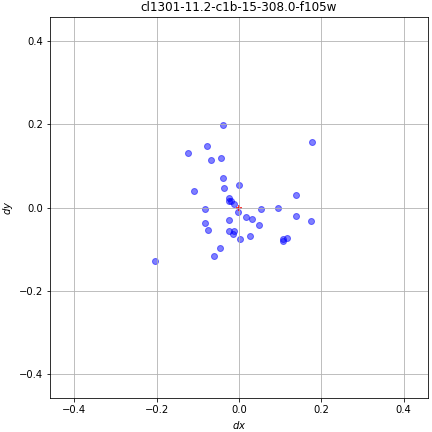

In [14]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1301-11.2-c1b-15-308.0-f105w_wcs.png") 


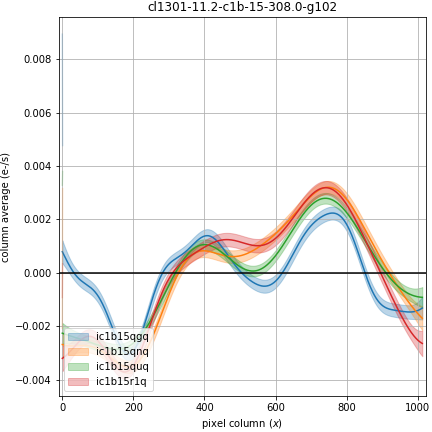

In [15]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1301-11.2-c1b-15-308.0-g102_column.png") 

In [16]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

cl1301-11.2-c1b-13-105.0-f105w_wcs.log: 0 1.4420 0.4273 0.0039 1.00014 0.041 6
cl1301-11.2-c1b-15-308.0-f105w_wcs.log: 0 -2.7134 -2.8325 0.0096 1.00016 0.065 38
jc1b11-c1b-11-136.0-f814w_wcs.log: 0 0.0000 0.0000 0.0000 1.00000 0.001 0


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [17]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

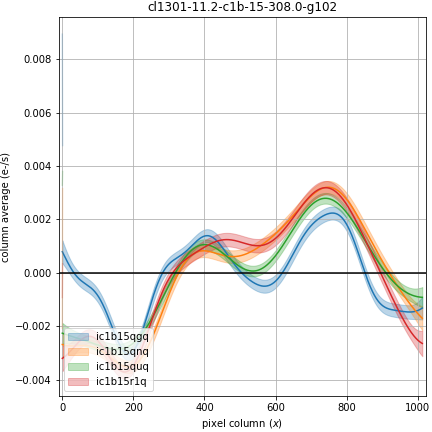

In [18]:
from IPython.display import Image
Image(filename = "./cl1301-11.2-c1b-15-308.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [19]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1301-11.2-c1b-13-105.0-f105w        -0.02   -0.17
cl1301-11.2-c1b-15-308.0-f105w         0.07    0.14
jc1b11-c1b-11-136.0-f814w              5.27    4.63


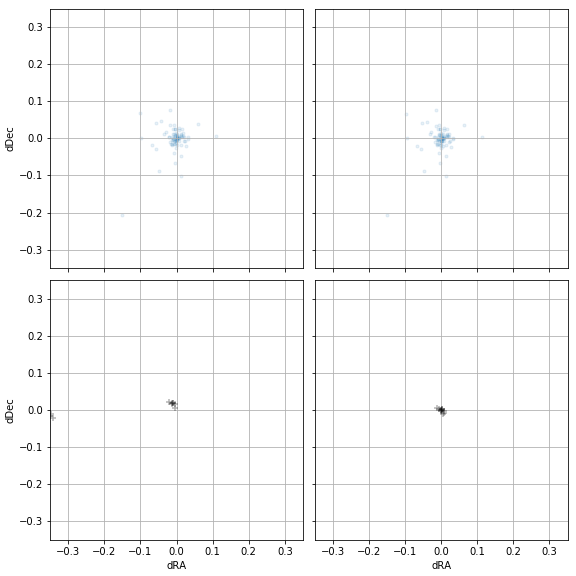

In [20]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [21]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [22]:
!ls -1 j*_dr?_sci.fits

j130132m1142-f105w_drz_sci.fits
j130132m1142-f814w_drc_sci.fits
j130132m1142-ir_drc_sci.fits
jc1b11-c1b-11-136.0-f814w_drc_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [23]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j130132m1142-ir.cat.fits
j130132m1142-ir_drc_wht.fits
j130132m1142-ir_drc_sci.fits
j130132m1142-ir_seg.fits
j130132m1142-ir_bkg.fits
j130132m1142_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j130132m1142-ir_drc_sci.fits
WHT_FILE:	j130132m1142-ir_drc_wht.fits
GET_BACK:	False
ERR_SCALE:	0.8895414471626282
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j130132m1142-f105w_drz_sci.fits
F105W_WHT_FILE:	j130132m1142-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5374509692192078
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [24]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [25]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b13ecq.01.GrismFLT.fits!
Load ic1b15r1q.01.GrismFLT.fits!
Load ic1b13ejq.01.GrismFLT.fits!
Load ic1b15qgq.01.GrismFLT.fits!
Load ic1b15quq.01.GrismFLT.fits!
Load ic1b13exq.01.GrismFLT.fits!
Load ic1b15qnq.01.GrismFLT.fits!
Load ic1b13eqq.01.GrismFLT.fits!
Files loaded - 7.73 sec.


### The final contamination model ###

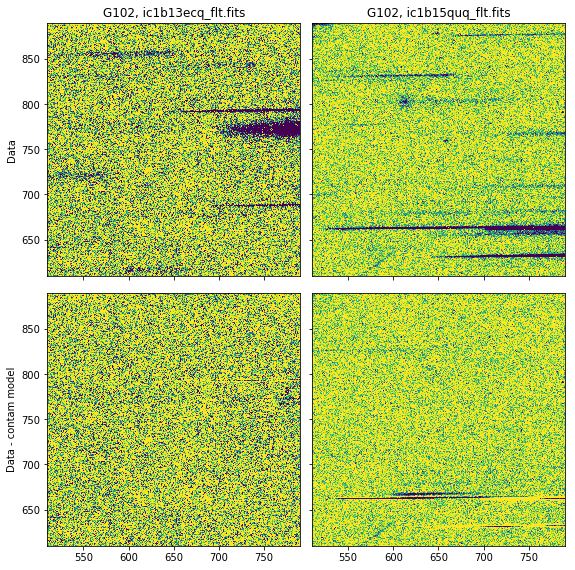

In [26]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [29]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j130132m1142/Extractions/a_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 


In [30]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [31]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

['j130132m1142-f105w_psf.fits'] 

Filename: j130132m1142-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


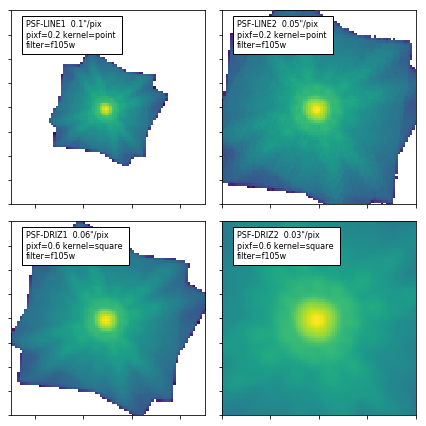

In [32]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [33]:
os.chdir('../Extractions')

In [34]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

0/299: 176 4
j130132m1142_00176.beams.fits
1/299: 465 4
j130132m1142_00465.beams.fits
2/299: 303 8
j130132m1142_00303.beams.fits
3/299: 50 0
4/299: 147 0
5/299: 436 8
j130132m1142_00436.beams.fits
6/299: 607 4
j130132m1142_00607.beams.fits
7/299: 684 4
j130132m1142_00684.beams.fits
8/299: 669 2
j130132m1142_00669.beams.fits
9/299: 541 6
j130132m1142_00541.beams.fits
10/299: 120 0
11/299: 180 0
12/299: 641 7
j130132m1142_00641.beams.fits
13/299: 581 8
j130132m1142_00581.beams.fits
14/299: 66 0
15/299: 631 8
j130132m1142_00631.beams.fits
16/299: 257 4
j130132m1142_00257.beams.fits
17/299: 604 8
j130132m1142_00604.beams.fits
18/299: 419 8
j130132m1142_00419.beams.fits
19/299: 301 4
j130132m1142_00301.beams.fits
20/299: 208 0
21/299: 491 8
j130132m1142_00491.beams.fits
22/299: 579 4
j130132m1142_00579.beams.fits
23/299: 666 8
j130132m1142_00666.beams.fits
24/299: 463 8
j130132m1142_00463.beams.fits
25/299: 369 4
j130132m1142_00369.beams.fits
26/299: 23 0
27/299: 358 8
j130132m1142_00358.be

j130132m1142_00667.beams.fits
246/299: 689 4
j130132m1142_00689.beams.fits
247/299: 397 8
j130132m1142_00397.beams.fits
248/299: 698 0
249/299: 130 0
250/299: 25 0
251/299: 316 8
j130132m1142_00316.beams.fits
252/299: 98 0
253/299: 390 8
j130132m1142_00390.beams.fits
254/299: 204 0
255/299: 253 8
j130132m1142_00253.beams.fits
256/299: 268 8
j130132m1142_00268.beams.fits
257/299: 428 8
j130132m1142_00428.beams.fits
258/299: 104 0
259/299: 367 2
j130132m1142_00367.beams.fits
260/299: 170 0
261/299: 420 8
j130132m1142_00420.beams.fits
262/299: 626 1
j130132m1142_00626.beams.fits
263/299: 381 8
j130132m1142_00381.beams.fits
264/299: 568 8
j130132m1142_00568.beams.fits
265/299: 209 0
266/299: 8 0
267/299: 198 0
268/299: 190 4
j130132m1142_00190.beams.fits
269/299: 171 0
270/299: 661 4
j130132m1142_00661.beams.fits
271/299: 443 8
j130132m1142_00443.beams.fits
272/299: 524 5
j130132m1142_00524.beams.fits
273/299: 695 4
j130132m1142_00695.beams.fits
274/299: 62 0
275/299: 575 8
j130132m1142_00

  1.0043  185110.3 (0.7425) 151/341
  1.0124  185115.6 (0.7425) 152/341
  1.0204  185123.2 (0.7425) 153/341
  1.0285  185098.1 (0.7425) 154/341
  1.0367  185017.4 (0.7425) 155/341
  1.0448  185052.5 (0.7425) 156/341
  1.0530  184923.4 (0.7425) 157/341
  1.0612  184953.0 (0.7425) 158/341
  1.0695  184566.3 (0.7425) 159/341
  1.0778  184755.4 (0.7425) 160/341
  1.0861  184624.2 (0.7425) 161/341
  1.0945  184359.9 (0.7425) 162/341
  1.1029  184298.8 (0.7425) 163/341
  1.1113  183965.5 (0.7425) 164/341
  1.1198  184120.4 (0.7425) 165/341
  1.1283  183939.3 (0.7425) 166/341
  1.1368  184231.8 (0.7425) 167/341
  1.1454  184302.0 (0.7425) 168/341
  1.1540  184202.3 (0.7425) 169/341
  1.1626  184530.1 (0.7425) 170/341
  1.1713  184915.8 (0.7425) 171/341
  1.1800  185212.2 (0.7425) 172/341
  1.1887  185427.7 (0.7425) 173/341
  1.1975  185726.9 (0.7425) 174/341
  1.2063  185313.5 (0.7425) 175/341
  1.2151  185458.3 (0.7425) 176/341
  1.2240  185470.1 (0.7425) 177/341
  1.2329  185109.5 (0.7425) 

  3.2687  184222.4 (1.5378) 340/341
  3.2858  183940.3 (1.5378) 341/341
First iteration: z_best=1.5378

- 1.5296  182509.1 (1.5296) 1/33
- 1.5301  182432.8 (1.5301) 2/33
- 1.5306  182342.2 (1.5306) 3/33
- 1.5311  182249.9 (1.5311) 4/33
- 1.5316  182161.7 (1.5316) 5/33
- 1.5321  182085.9 (1.5321) 6/33
- 1.5326  182026.1 (1.5326) 7/33
- 1.5331  181963.5 (1.5331) 8/33
- 1.5336  181881.1 (1.5336) 9/33
- 1.5341  181813.5 (1.5341) 10/33
- 1.5346  181798.8 (1.5346) 11/33
- 1.5351  181795.8 (1.5351) 12/33
- 1.5356  181767.0 (1.5356) 13/33
- 1.5361  181719.2 (1.5361) 14/33
- 1.5366  181664.6 (1.5366) 15/33
- 1.5371  181625.1 (1.5371) 16/33
- 1.5376  181593.9 (1.5376) 17/33
- 1.5381  181580.4 (1.5381) 18/33
- 1.5386  181588.3 (1.5381) 19/33
- 1.5391  181624.8 (1.5381) 20/33
- 1.5396  181691.8 (1.5381) 21/33
- 1.5401  181780.4 (1.5381) 22/33
- 1.5406  181883.5 (1.5381) 23/33
- 1.5411  181980.4 (1.5381) 24/33
- 1.5416  182040.1 (1.5381) 25/33
- 1.5421  182058.5 (1.5381) 26/33
- 1.5426  182065.7 (1

  1.0285  313426.8 (0.2603) 154/341
  1.0367  313255.3 (0.2603) 155/341
  1.0448  313214.9 (0.2603) 156/341
  1.0530  313181.9 (0.2603) 157/341
  1.0612  313168.4 (0.2603) 158/341
  1.0695  313343.5 (0.2603) 159/341
  1.0778  313478.4 (0.2603) 160/341
  1.0861  313678.2 (0.2603) 161/341
  1.0945  313565.4 (0.2603) 162/341
  1.1029  313353.8 (0.2603) 163/341
  1.1113  312983.2 (0.2603) 164/341
  1.1198  312709.4 (0.2603) 165/341
  1.1283  312677.0 (0.2603) 166/341
  1.1368  312517.7 (0.2603) 167/341
  1.1454  312765.9 (0.2603) 168/341
  1.1540  313228.2 (0.2603) 169/341
  1.1626  313474.1 (0.2603) 170/341
  1.1713  314017.8 (0.2603) 171/341
  1.1800  314287.4 (0.2603) 172/341
  1.1887  314565.2 (0.2603) 173/341
  1.1975  314833.0 (0.2603) 174/341
  1.2063  314920.0 (0.2603) 175/341
  1.2151  314832.7 (0.2603) 176/341
  1.2240  314642.9 (0.2603) 177/341
  1.2329  314522.4 (0.2603) 178/341
  1.2419  314469.2 (0.2603) 179/341
  1.2509  314229.0 (0.2603) 180/341
  1.2599  314053.9 (0.2603) 

- 2.0106  311962.9 (2.0106) 3/33
- 2.0111  311959.8 (2.0111) 4/33
- 2.0116  311958.7 (2.0116) 5/33
- 2.0121  311958.7 (2.0116) 6/33
- 2.0126  311958.4 (2.0126) 7/33
- 2.0131  311956.3 (2.0131) 8/33
- 2.0136  311949.9 (2.0136) 9/33
- 2.0141  311939.7 (2.0141) 10/33
- 2.0146  311930.7 (2.0146) 11/33
- 2.0151  311925.1 (2.0151) 12/33
- 2.0156  311916.5 (2.0156) 13/33
- 2.0161  311907.8 (2.0161) 14/33
- 2.0166  311902.0 (2.0166) 15/33
- 2.0171  311899.7 (2.0171) 16/33
- 2.0176  311901.1 (2.0171) 17/33
- 2.0181  311906.1 (2.0171) 18/33
- 2.0186  311913.8 (2.0171) 19/33
- 2.0191  311923.0 (2.0171) 20/33
- 2.0196  311932.1 (2.0171) 21/33
- 2.0201  311939.7 (2.0171) 22/33
- 2.0206  311945.0 (2.0171) 23/33
- 2.0211  311948.1 (2.0171) 24/33
- 2.0216  311949.7 (2.0171) 25/33
- 2.0221  311950.5 (2.0171) 26/33
- 2.0226  311951.0 (2.0171) 27/33
- 2.0231  311952.0 (2.0171) 28/33
- 2.0236  311953.8 (2.0171) 29/33
- 2.0241  311957.6 (2.0171) 30/33
- 2.0246  311963.6 (2.0171) 31/33
- 2.0251  311971.8 (2

  1.0204  148991.1 (0.2755) 153/341
  1.0285  148884.7 (0.2755) 154/341
  1.0367  148822.5 (0.2755) 155/341
  1.0448  149033.7 (0.2755) 156/341
  1.0530  149063.2 (0.2755) 157/341
  1.0612  149042.6 (0.2755) 158/341
  1.0695  149202.2 (0.2755) 159/341
  1.0778  149196.5 (0.2755) 160/341
  1.0861  149256.6 (0.2755) 161/341
  1.0945  149445.1 (0.2755) 162/341
  1.1029  149622.2 (0.2755) 163/341
  1.1113  150027.8 (0.2755) 164/341
  1.1198  150543.2 (0.2755) 165/341
  1.1283  151054.5 (0.2755) 166/341
  1.1368  151376.6 (0.2755) 167/341
  1.1454  151776.9 (0.2755) 168/341
  1.1540  152298.3 (0.2755) 169/341
  1.1626  153118.2 (0.2755) 170/341
  1.1713  153619.6 (0.2755) 171/341
  1.1800  154247.1 (0.2755) 172/341
  1.1887  154946.7 (0.2755) 173/341
  1.1975  155735.0 (0.2755) 174/341
  1.2063  156650.5 (0.2755) 175/341
  1.2151  156758.9 (0.2755) 176/341
  1.2240  156975.0 (0.2755) 177/341
  1.2329  157629.4 (0.2755) 178/341
  1.2419  158273.8 (0.2755) 179/341
  1.2509  158674.5 (0.2755) 

- 0.2678  147022.3 (0.2678) 1/33
- 0.2683  147019.8 (0.2683) 2/33
- 0.2688  147016.5 (0.2688) 3/33
- 0.2693  147011.7 (0.2693) 4/33
- 0.2698  146999.4 (0.2698) 5/33
- 0.2703  146987.3 (0.2703) 6/33
- 0.2708  146977.1 (0.2708) 7/33
- 0.2713  146968.8 (0.2713) 8/33
- 0.2718  146957.6 (0.2718) 9/33
- 0.2723  146942.9 (0.2723) 10/33
- 0.2728  146925.8 (0.2728) 11/33
- 0.2733  146907.8 (0.2733) 12/33
- 0.2738  146890.7 (0.2738) 13/33
- 0.2743  146879.4 (0.2743) 14/33
- 0.2748  146873.3 (0.2748) 15/33
- 0.2753  146875.3 (0.2748) 16/33
- 0.2758  146875.9 (0.2748) 17/33
- 0.2763  146877.2 (0.2748) 18/33
- 0.2768  146880.4 (0.2748) 19/33
- 0.2773  146887.8 (0.2748) 20/33
- 0.2778  146897.3 (0.2748) 21/33
- 0.2783  146907.7 (0.2748) 22/33
- 0.2788  146919.3 (0.2748) 23/33
- 0.2793  146930.5 (0.2748) 24/33
- 0.2798  146941.3 (0.2748) 25/33
- 0.2803  146952.8 (0.2748) 26/33
- 0.2808  146967.4 (0.2748) 27/33
- 0.2813  146981.5 (0.2748) 28/33
- 0.2818  146991.7 (0.2748) 29/33
- 0.2823  146997.4 (0.2

  1.0043   42995.6 (0.5331) 151/341
  1.0124   43173.8 (0.5331) 152/341
  1.0204   43232.9 (0.5331) 153/341
  1.0285   43225.0 (0.5331) 154/341
  1.0367   43280.6 (0.5331) 155/341
  1.0448   43406.8 (0.5331) 156/341
  1.0530   43591.2 (0.5331) 157/341
  1.0612   43705.3 (0.5331) 158/341
  1.0695   43698.9 (0.5331) 159/341
  1.0778   43674.0 (0.5331) 160/341
  1.0861   43888.2 (0.5331) 161/341
  1.0945   44147.4 (0.5331) 162/341
  1.1029   44235.3 (0.5331) 163/341
  1.1113   44308.2 (0.5331) 164/341
  1.1198   44472.4 (0.5331) 165/341
  1.1283   44645.8 (0.5331) 166/341
  1.1368   44865.6 (0.5331) 167/341
  1.1454   44978.0 (0.5331) 168/341
  1.1540   45263.5 (0.5331) 169/341
  1.1626   45902.1 (0.5331) 170/341
  1.1713   46543.8 (0.5331) 171/341
  1.1800   46809.7 (0.5331) 172/341
  1.1887   47017.0 (0.5331) 173/341
  1.1975   47363.4 (0.5331) 174/341
  1.2063   47724.7 (0.5331) 175/341
  1.2151   48032.2 (0.5331) 176/341
  1.2240   48204.5 (0.5331) 177/341
  1.2329   48762.9 (0.5331) 

  3.2517   42515.9 (0.5331) 339/341
  3.2687   42517.3 (0.5331) 340/341
  3.2858   42510.5 (0.5331) 341/341
First iteration: z_best=0.5331

- 0.5277   42242.5 (0.5277) 1/33
- 0.5282   42240.1 (0.5282) 2/33
- 0.5287   42235.6 (0.5287) 3/33
- 0.5292   42231.2 (0.5292) 4/33
- 0.5297   42228.8 (0.5297) 5/33
- 0.5302   42225.3 (0.5302) 6/33
- 0.5307   42218.6 (0.5307) 7/33
- 0.5312   42214.4 (0.5312) 8/33
- 0.5317   42211.6 (0.5317) 9/33
- 0.5322   42207.2 (0.5322) 10/33
- 0.5327   42203.7 (0.5327) 11/33
- 0.5332   42200.9 (0.5332) 12/33
- 0.5337   42199.5 (0.5337) 13/33
- 0.5342   42197.4 (0.5342) 14/33
- 0.5347   42195.2 (0.5347) 15/33
- 0.5352   42192.4 (0.5352) 16/33
- 0.5357   42192.1 (0.5357) 17/33
- 0.5362   42192.0 (0.5362) 18/33
- 0.5367   42193.2 (0.5362) 19/33
- 0.5372   42198.3 (0.5362) 20/33
- 0.5377   42200.8 (0.5362) 21/33
- 0.5382   42203.3 (0.5362) 22/33
- 0.5387   42206.2 (0.5362) 23/33
- 0.5392   42205.6 (0.5362) 24/33
- 0.5397   42202.8 (0.5362) 25/33
- 0.5402   42202.9 

  0.9884    8523.3 (0.3328) 149/341
  0.9963    8531.2 (0.3328) 150/341
  1.0043    8537.6 (0.3328) 151/341
  1.0124    8550.6 (0.3328) 152/341
  1.0204    8553.4 (0.3328) 153/341
  1.0285    8558.0 (0.3328) 154/341
  1.0367    8568.7 (0.3328) 155/341
  1.0448    8570.5 (0.3328) 156/341
  1.0530    8568.5 (0.3328) 157/341
  1.0612    8575.1 (0.3328) 158/341
  1.0695    8575.4 (0.3328) 159/341
  1.0778    8571.6 (0.3328) 160/341
  1.0861    8566.5 (0.3328) 161/341
  1.0945    8555.7 (0.3328) 162/341
  1.1029    8552.0 (0.3328) 163/341
  1.1113    8548.9 (0.3328) 164/341
  1.1198    8550.8 (0.3328) 165/341
  1.1283    8557.4 (0.3328) 166/341
  1.1368    8551.7 (0.3328) 167/341
  1.1454    8534.7 (0.3328) 168/341
  1.1540    8521.3 (0.3328) 169/341
  1.1626    8509.2 (0.3328) 170/341
  1.1713    8495.3 (1.1713) 171/341
  1.1800    8486.6 (1.1800) 172/341
  1.1887    8500.0 (1.1800) 173/341
  1.1975    8525.9 (1.1800) 174/341
  1.2063    8549.0 (1.1800) 175/341
  1.2151    8555.8 (1.1800) 

  3.2178    8676.3 (1.1800) 337/341
  3.2347    8690.0 (1.1800) 338/341
  3.2517    8696.9 (1.1800) 339/341
  3.2687    8703.0 (1.1800) 340/341
  3.2858    8700.9 (1.1800) 341/341
First iteration: z_best=1.1800

- 1.1711    8495.6 (1.1711) 1/33
- 1.1716    8494.7 (1.1716) 2/33
- 1.1721    8493.7 (1.1721) 3/33
- 1.1726    8492.8 (1.1726) 4/33
- 1.1731    8492.2 (1.1731) 5/33
- 1.1736    8491.7 (1.1736) 6/33
- 1.1741    8491.3 (1.1741) 7/33
- 1.1746    8490.9 (1.1746) 8/33
- 1.1751    8490.4 (1.1751) 9/33
- 1.1756    8490.1 (1.1756) 10/33
- 1.1761    8489.8 (1.1761) 11/33
- 1.1766    8489.2 (1.1766) 12/33
- 1.1771    8488.1 (1.1771) 13/33
- 1.1776    8487.0 (1.1776) 14/33
- 1.1781    8486.2 (1.1781) 15/33
- 1.1786    8485.9 (1.1786) 16/33
- 1.1791    8486.0 (1.1786) 17/33
- 1.1796    8486.4 (1.1786) 18/33
- 1.1801    8486.6 (1.1786) 19/33
- 1.1806    8486.7 (1.1786) 20/33
- 1.1811    8487.0 (1.1786) 21/33
- 1.1816    8487.2 (1.1786) 22/33
- 1.1821    8487.5 (1.1786) 23/33
- 1.1826    848

  0.9725    1567.5 (0.1964) 147/341
  0.9804    1570.1 (0.1964) 148/341
  0.9884    1591.0 (0.1964) 149/341
  0.9963    1599.4 (0.1964) 150/341
  1.0043    1614.1 (0.1964) 151/341
  1.0124    1655.9 (0.1964) 152/341
  1.0204    1680.0 (0.1964) 153/341
  1.0285    1663.6 (0.1964) 154/341
  1.0367    1669.7 (0.1964) 155/341
  1.0448    1687.6 (0.1964) 156/341
  1.0530    1698.0 (0.1964) 157/341
  1.0612    1693.2 (0.1964) 158/341
  1.0695    1683.9 (0.1964) 159/341
  1.0778    1715.9 (0.1964) 160/341
  1.0861    1712.6 (0.1964) 161/341
  1.0945    1698.6 (0.1964) 162/341
  1.1029    1707.9 (0.1964) 163/341
  1.1113    1709.2 (0.1964) 164/341
  1.1198    1721.6 (0.1964) 165/341
  1.1283    1766.5 (0.1964) 166/341
  1.1368    1771.9 (0.1964) 167/341
  1.1454    1797.2 (0.1964) 168/341
  1.1540    1817.6 (0.1964) 169/341
  1.1626    1811.0 (0.1964) 170/341
  1.1713    1847.9 (0.1964) 171/341
  1.1800    1843.0 (0.1964) 172/341
  1.1887    1851.7 (0.1964) 173/341
  1.1975    1923.9 (0.1964) 

- 0.1894    1559.2 (0.1894) 1/99
- 0.1899    1558.4 (0.1899) 2/99
- 0.1904    1557.5 (0.1904) 3/99
- 0.1909    1556.5 (0.1909) 4/99
- 0.1914    1555.2 (0.1914) 5/99
- 0.1919    1554.0 (0.1919) 6/99
- 0.1924    1552.9 (0.1924) 7/99
- 0.1929    1551.7 (0.1929) 8/99
- 0.1934    1550.5 (0.1934) 9/99
- 0.1939    1549.2 (0.1939) 10/99
- 0.1944    1547.4 (0.1944) 11/99
- 0.1949    1545.6 (0.1949) 12/99
- 0.1954    1544.1 (0.1954) 13/99
- 0.1959    1543.1 (0.1959) 14/99
- 0.1964    1542.1 (0.1964) 15/99
- 0.1969    1541.1 (0.1969) 16/99
- 0.1974    1541.1 (0.1974) 17/99
- 0.1979    1541.2 (0.1974) 18/99
- 0.1984    1541.7 (0.1974) 19/99
- 0.1989    1542.4 (0.1974) 20/99
- 0.1994    1543.4 (0.1974) 21/99
- 0.1999    1544.8 (0.1974) 22/99
- 0.2004    1546.1 (0.1974) 23/99
- 0.2009    1546.9 (0.1974) 24/99
- 0.2014    1547.6 (0.1974) 25/99
- 0.2019    1548.2 (0.1974) 26/99
- 0.2024    1548.7 (0.1974) 27/99
- 0.2029    1549.4 (0.1974) 28/99
- 0.2034    1550.5 (0.1974) 29/99
- 0.2039    1551.2 (0.1

  0.5957    2284.4 (0.1222) 94/341
  0.6021    2313.4 (0.1222) 95/341
  0.6085    2326.7 (0.1222) 96/341
  0.6150    2335.7 (0.1222) 97/341
  0.6214    2315.1 (0.1222) 98/341
  0.6279    2319.5 (0.1222) 99/341
  0.6345    2312.9 (0.1222) 100/341
  0.6410    2306.1 (0.1222) 101/341
  0.6476    2293.3 (0.1222) 102/341
  0.6542    2279.9 (0.1222) 103/341
  0.6608    2285.6 (0.1222) 104/341
  0.6675    2289.8 (0.1222) 105/341
  0.6742    2315.6 (0.1222) 106/341
  0.6809    2295.3 (0.1222) 107/341
  0.6876    2287.6 (0.1222) 108/341
  0.6944    2289.0 (0.1222) 109/341
  0.7012    2307.0 (0.1222) 110/341
  0.7080    2298.7 (0.1222) 111/341
  0.7148    2283.4 (0.1222) 112/341
  0.7217    2286.4 (0.1222) 113/341
  0.7286    2288.9 (0.1222) 114/341
  0.7355    2307.5 (0.1222) 115/341
  0.7425    2328.2 (0.1222) 116/341
  0.7495    2323.1 (0.1222) 117/341
  0.7565    2320.6 (0.1222) 118/341
  0.7635    2326.7 (0.1222) 119/341
  0.7706    2337.7 (0.1222) 120/341
  0.7777    2336.3 (0.1222) 121/34

  2.3849    2285.3 (1.1887) 282/341
  2.3984    2289.7 (1.1887) 283/341
  2.4120    2290.3 (1.1887) 284/341
  2.4257    2287.7 (1.1887) 285/341
  2.4394    2298.2 (1.1887) 286/341
  2.4532    2300.4 (1.1887) 287/341
  2.4671    2297.8 (1.1887) 288/341
  2.4810    2293.5 (1.1887) 289/341
  2.4949    2297.2 (1.1887) 290/341
  2.5089    2301.3 (1.1887) 291/341
  2.5230    2313.7 (1.1887) 292/341
  2.5371    2320.1 (1.1887) 293/341
  2.5513    2314.4 (1.1887) 294/341
  2.5655    2318.9 (1.1887) 295/341
  2.5798    2318.4 (1.1887) 296/341
  2.5942    2312.2 (1.1887) 297/341
  2.6086    2314.5 (1.1887) 298/341
  2.6230    2321.4 (1.1887) 299/341
  2.6375    2322.7 (1.1887) 300/341
  2.6521    2318.0 (1.1887) 301/341
  2.6668    2321.3 (1.1887) 302/341
  2.6815    2319.3 (1.1887) 303/341
  2.6962    2302.5 (1.1887) 304/341
  2.7110    2285.6 (1.1887) 305/341
  2.7259    2287.7 (1.1887) 306/341
  2.7408    2301.0 (1.1887) 307/341
  2.7558    2304.6 (1.1887) 308/341
  2.7709    2298.8 (1.1887) 

  0.5270     512.0 (0.1964) 83/341
  0.5331     510.3 (0.1964) 84/341
  0.5393     506.0 (0.1964) 85/341
  0.5454     509.0 (0.1964) 86/341
  0.5516     510.7 (0.1964) 87/341
  0.5579     508.7 (0.1964) 88/341
  0.5641     504.4 (0.1964) 89/341
  0.5704     502.8 (0.1964) 90/341
  0.5767     508.8 (0.1964) 91/341
  0.5830     509.8 (0.1964) 92/341
  0.5893     511.5 (0.1964) 93/341
  0.5957     514.1 (0.1964) 94/341
  0.6021     514.0 (0.1964) 95/341
  0.6085     514.3 (0.1964) 96/341
  0.6150     513.8 (0.1964) 97/341
  0.6214     513.9 (0.1964) 98/341
  0.6279     514.1 (0.1964) 99/341
  0.6345     508.8 (0.1964) 100/341
  0.6410     509.3 (0.1964) 101/341
  0.6476     511.6 (0.1964) 102/341
  0.6542     512.7 (0.1964) 103/341
  0.6608     516.4 (0.1964) 104/341
  0.6675     518.4 (0.1964) 105/341
  0.6742     522.5 (0.1964) 106/341
  0.6809     519.5 (0.1964) 107/341
  0.6876     516.2 (0.1964) 108/341
  0.6944     518.9 (0.1964) 109/341
  0.7012     525.7 (0.1964) 110/341
  0.7080 

  2.2652     514.9 (0.1964) 273/341
  2.2783     515.0 (0.1964) 274/341
  2.2914     515.4 (0.1964) 275/341
  2.3046     515.0 (0.1964) 276/341
  2.3178     515.3 (0.1964) 277/341
  2.3311     513.8 (0.1964) 278/341
  2.3445     511.9 (0.1964) 279/341
  2.3579     511.9 (0.1964) 280/341
  2.3713     513.2 (0.1964) 281/341
  2.3849     515.3 (0.1964) 282/341
  2.3984     514.8 (0.1964) 283/341
  2.4120     514.2 (0.1964) 284/341
  2.4257     511.8 (0.1964) 285/341
  2.4394     513.4 (0.1964) 286/341
  2.4532     514.5 (0.1964) 287/341
  2.4671     514.2 (0.1964) 288/341
  2.4810     514.5 (0.1964) 289/341
  2.4949     514.8 (0.1964) 290/341
  2.5089     512.5 (0.1964) 291/341
  2.5230     510.7 (0.1964) 292/341
  2.5371     510.8 (0.1964) 293/341
  2.5513     510.7 (0.1964) 294/341
  2.5655     504.4 (0.1964) 295/341
  2.5798     501.2 (0.1964) 296/341
  2.5942     506.1 (0.1964) 297/341
  2.6086     510.9 (0.1964) 298/341
  2.6230     512.6 (0.1964) 299/341
  2.6375     508.5 (0.1964) 

- 0.7520     505.7 (0.1950) 122/231
- 0.7525     506.2 (0.1950) 123/231
- 0.7530     506.6 (0.1950) 124/231
- 0.7535     506.9 (0.1950) 125/231
- 0.7540     507.1 (0.1950) 126/231
- 0.7545     507.4 (0.1950) 127/231
- 0.7550     507.6 (0.1950) 128/231
- 0.7555     507.7 (0.1950) 129/231
- 0.7560     507.9 (0.1950) 130/231
- 0.7565     508.1 (0.1950) 131/231
- 0.7570     508.4 (0.1950) 132/231
- 2.0305     508.1 (0.1950) 133/231
- 2.0310     507.9 (0.1950) 134/231
- 2.0315     507.8 (0.1950) 135/231
- 2.0320     507.6 (0.1950) 136/231
- 2.0325     507.5 (0.1950) 137/231
- 2.0330     507.3 (0.1950) 138/231
- 2.0335     507.2 (0.1950) 139/231
- 2.0340     507.1 (0.1950) 140/231
- 2.0345     507.0 (0.1950) 141/231
- 2.0350     506.8 (0.1950) 142/231
- 2.0355     506.7 (0.1950) 143/231
- 2.0360     506.7 (0.1950) 144/231
- 2.0365     506.6 (0.1950) 145/231
- 2.0370     506.5 (0.1950) 146/231
- 2.0375     506.5 (0.1950) 147/231
- 2.0380     506.4 (0.1950) 148/231
- 2.0385     506.4 (0.1950) 

  0.4266     389.9 (0.1916) 66/341
  0.4323     387.7 (0.1916) 67/341
  0.4381     387.0 (0.1916) 68/341
  0.4438     387.5 (0.1916) 69/341
  0.4496     389.2 (0.1916) 70/341
  0.4554     389.7 (0.1916) 71/341
  0.4613     390.6 (0.1916) 72/341
  0.4671     390.0 (0.1916) 73/341
  0.4730     390.2 (0.1916) 74/341
  0.4789     390.4 (0.1916) 75/341
  0.4848     391.1 (0.1916) 76/341
  0.4908     389.3 (0.1916) 77/341
  0.4968     387.8 (0.1916) 78/341
  0.5028     388.3 (0.1916) 79/341
  0.5088     388.3 (0.1916) 80/341
  0.5148     388.6 (0.1916) 81/341
  0.5209     389.8 (0.1916) 82/341
  0.5270     384.2 (0.1916) 83/341
  0.5331     382.8 (0.1916) 84/341
  0.5393     383.7 (0.1916) 85/341
  0.5454     385.6 (0.1916) 86/341
  0.5516     383.5 (0.1916) 87/341
  0.5579     383.5 (0.1916) 88/341
  0.5641     383.9 (0.1916) 89/341
  0.5704     387.9 (0.1916) 90/341
  0.5767     387.5 (0.1916) 91/341
  0.5830     384.5 (0.1916) 92/341
  0.5893     385.8 (0.1916) 93/341
  0.5957     383.0 (

  2.0262     377.3 (0.1916) 254/341
  2.0383     378.0 (0.1916) 255/341
  2.0505     384.7 (0.1916) 256/341
  2.0627     386.9 (0.1916) 257/341
  2.0750     388.8 (0.1916) 258/341
  2.0873     387.3 (0.1916) 259/341
  2.0997     387.2 (0.1916) 260/341
  2.1121     391.6 (0.1916) 261/341
  2.1246     392.8 (0.1916) 262/341
  2.1371     392.8 (0.1916) 263/341
  2.1497     392.5 (0.1916) 264/341
  2.1623     393.7 (0.1916) 265/341
  2.1750     395.5 (0.1916) 266/341
  2.1877     396.1 (0.1916) 267/341
  2.2005     395.6 (0.1916) 268/341
  2.2133     394.0 (0.1916) 269/341
  2.2262     392.3 (0.1916) 270/341
  2.2391     389.8 (0.1916) 271/341
  2.2521     388.5 (0.1916) 272/341
  2.2652     390.2 (0.1916) 273/341
  2.2783     389.4 (0.1916) 274/341
  2.2914     389.1 (0.1916) 275/341
  2.3046     388.0 (0.1916) 276/341
  2.3178     387.4 (0.1916) 277/341
  2.3311     387.8 (0.1916) 278/341
  2.3445     387.9 (0.1916) 279/341
  2.3579     388.8 (0.1916) 280/341
  2.3713     387.9 (0.1916) 

- 0.5273     383.6 (0.1897) 103/396
- 0.5278     383.3 (0.1897) 104/396
- 0.5283     383.0 (0.1897) 105/396
- 0.5288     382.7 (0.1897) 106/396
- 0.5293     382.5 (0.1897) 107/396
- 0.5298     382.5 (0.1897) 108/396
- 0.5303     382.5 (0.1897) 109/396
- 0.5308     382.5 (0.1897) 110/396
- 0.5313     382.5 (0.1897) 111/396
- 0.5318     382.6 (0.1897) 112/396
- 0.5323     382.7 (0.1897) 113/396
- 0.5328     382.8 (0.1897) 114/396
- 0.5333     382.8 (0.1897) 115/396
- 0.5338     382.7 (0.1897) 116/396
- 0.5343     382.7 (0.1897) 117/396
- 0.5348     382.7 (0.1897) 118/396
- 0.5353     382.8 (0.1897) 119/396
- 0.5358     382.7 (0.1897) 120/396
- 0.5363     382.6 (0.1897) 121/396
- 0.5368     382.6 (0.1897) 122/396
- 0.5373     382.9 (0.1897) 123/396
- 0.5378     383.2 (0.1897) 124/396
- 0.5383     383.4 (0.1897) 125/396
- 0.5388     383.6 (0.1897) 126/396
- 0.5393     383.7 (0.1897) 127/396
- 0.5398     383.9 (0.1897) 128/396
- 0.5403     384.1 (0.1897) 129/396
- 0.5408     384.5 (0.1897) 

- 2.4001     383.4 (0.1897) 298/396
- 2.4006     383.3 (0.1897) 299/396
- 2.4011     383.2 (0.1897) 300/396
- 2.4016     383.1 (0.1897) 301/396
- 2.4021     383.0 (0.1897) 302/396
- 2.4026     382.9 (0.1897) 303/396
- 2.4031     382.8 (0.1897) 304/396
- 2.4036     382.7 (0.1897) 305/396
- 2.4041     382.7 (0.1897) 306/396
- 2.4046     382.6 (0.1897) 307/396
- 2.4051     382.6 (0.1897) 308/396
- 2.4056     382.6 (0.1897) 309/396
- 2.4061     382.5 (0.1897) 310/396
- 2.4066     382.5 (0.1897) 311/396
- 2.4071     382.5 (0.1897) 312/396
- 2.4076     382.6 (0.1897) 313/396
- 2.4081     382.6 (0.1897) 314/396
- 2.4086     382.7 (0.1897) 315/396
- 2.4091     382.7 (0.1897) 316/396
- 2.4096     382.8 (0.1897) 317/396
- 2.4101     382.8 (0.1897) 318/396
- 2.4106     382.9 (0.1897) 319/396
- 2.4111     383.0 (0.1897) 320/396
- 2.4116     383.1 (0.1897) 321/396
- 2.4121     383.2 (0.1897) 322/396
- 2.4126     383.2 (0.1897) 323/396
- 2.4131     383.3 (0.1897) 324/396
- 2.4136     383.4 (0.1897) 

  0.5331   11495.7 (0.1133) 84/341
  0.5393   11469.6 (0.1133) 85/341
  0.5454   11458.9 (0.1133) 86/341
  0.5516   11459.4 (0.1133) 87/341
  0.5579   11454.0 (0.1133) 88/341
  0.5641   11440.2 (0.1133) 89/341
  0.5704   11407.5 (0.1133) 90/341
  0.5767   11405.0 (0.1133) 91/341
  0.5830   11422.3 (0.1133) 92/341
  0.5893   11455.7 (0.1133) 93/341
  0.5957   11491.6 (0.1133) 94/341
  0.6021   11511.9 (0.1133) 95/341
  0.6085   11520.4 (0.1133) 96/341
  0.6150   11528.6 (0.1133) 97/341
  0.6214   11541.5 (0.1133) 98/341
  0.6279   11544.0 (0.1133) 99/341
  0.6345   11528.1 (0.1133) 100/341
  0.6410   11510.7 (0.1133) 101/341
  0.6476   11486.7 (0.1133) 102/341
  0.6542   11466.8 (0.1133) 103/341
  0.6608   11452.3 (0.1133) 104/341
  0.6675   11439.0 (0.1133) 105/341
  0.6742   11417.3 (0.1133) 106/341
  0.6809   11398.5 (0.1133) 107/341
  0.6876   11378.6 (0.1133) 108/341
  0.6944   11359.6 (0.6944) 109/341
  0.7012   11339.2 (0.7012) 110/341
  0.7080   11314.7 (0.7080) 111/341
  0.7148

  2.2521   11574.5 (1.4579) 272/341
  2.2652   11592.7 (1.4579) 273/341
  2.2783   11608.6 (1.4579) 274/341
  2.2914   11606.1 (1.4579) 275/341
  2.3046   11588.3 (1.4579) 276/341
  2.3178   11569.5 (1.4579) 277/341
  2.3311   11548.9 (1.4579) 278/341
  2.3445   11529.9 (1.4579) 279/341
  2.3579   11491.9 (1.4579) 280/341
  2.3713   11434.2 (1.4579) 281/341
  2.3849   11379.4 (1.4579) 282/341
  2.3984   11342.5 (1.4579) 283/341
  2.4120   11321.4 (1.4579) 284/341
  2.4257   11305.3 (1.4579) 285/341
  2.4394   11294.8 (1.4579) 286/341
  2.4532   11307.0 (1.4579) 287/341
  2.4671   11353.6 (1.4579) 288/341
  2.4810   11427.9 (1.4579) 289/341
  2.4949   11503.5 (1.4579) 290/341
  2.5089   11554.0 (1.4579) 291/341
  2.5230   11580.8 (1.4579) 292/341
  2.5371   11595.5 (1.4579) 293/341
  2.5513   11612.0 (1.4579) 294/341
  2.5655   11634.3 (1.4579) 295/341
  2.5798   11654.7 (1.4579) 296/341
  2.5942   11666.3 (1.4579) 297/341
  2.6086   11672.3 (1.4579) 298/341
  2.6230   11668.2 (1.4579) 

  0.4730    5339.4 (0.2206) 74/341
  0.4789    5344.4 (0.2206) 75/341
  0.4848    5347.4 (0.2206) 76/341
  0.4908    5351.1 (0.2206) 77/341
  0.4968    5351.4 (0.2206) 78/341
  0.5028    5347.8 (0.2206) 79/341
  0.5088    5339.4 (0.2206) 80/341
  0.5148    5314.8 (0.2206) 81/341
  0.5209    5324.0 (0.2206) 82/341
  0.5270    5324.9 (0.2206) 83/341
  0.5331    5332.3 (0.2206) 84/341
  0.5393    5331.8 (0.2206) 85/341
  0.5454    5332.3 (0.2206) 86/341
  0.5516    5334.3 (0.2206) 87/341
  0.5579    5330.3 (0.2206) 88/341
  0.5641    5323.5 (0.2206) 89/341
  0.5704    5313.6 (0.2206) 90/341
  0.5767    5307.2 (0.2206) 91/341
  0.5830    5307.0 (0.2206) 92/341
  0.5893    5316.7 (0.2206) 93/341
  0.5957    5321.3 (0.2206) 94/341
  0.6021    5330.9 (0.2206) 95/341
  0.6085    5333.3 (0.2206) 96/341
  0.6150    5332.0 (0.2206) 97/341
  0.6214    5333.3 (0.2206) 98/341
  0.6279    5334.1 (0.2206) 99/341
  0.6345    5330.7 (0.2206) 100/341
  0.6410    5335.0 (0.2206) 101/341
  0.6476    5326.1

  2.1623    5338.1 (0.2206) 265/341
  2.1750    5338.4 (0.2206) 266/341
  2.1877    5344.1 (0.2206) 267/341
  2.2005    5349.7 (0.2206) 268/341
  2.2133    5350.9 (0.2206) 269/341
  2.2262    5348.3 (0.2206) 270/341
  2.2391    5351.7 (0.2206) 271/341
  2.2521    5353.3 (0.2206) 272/341
  2.2652    5353.6 (0.2206) 273/341
  2.2783    5355.5 (0.2206) 274/341
  2.2914    5355.7 (0.2206) 275/341
  2.3046    5354.6 (0.2206) 276/341
  2.3178    5349.4 (0.2206) 277/341
  2.3311    5349.7 (0.2206) 278/341
  2.3445    5349.9 (0.2206) 279/341
  2.3579    5348.5 (0.2206) 280/341
  2.3713    5353.3 (0.2206) 281/341
  2.3849    5352.9 (0.2206) 282/341
  2.3984    5351.6 (0.2206) 283/341
  2.4120    5355.6 (0.2206) 284/341
  2.4257    5351.6 (0.2206) 285/341
  2.4394    5349.7 (0.2206) 286/341
  2.4532    5346.7 (0.2206) 287/341
  2.4671    5338.3 (0.2206) 288/341
  2.4810    5331.5 (0.2206) 289/341
  2.4949    5330.3 (0.2206) 290/341
  2.5089    5331.5 (0.2206) 291/341
  2.5230    5329.3 (0.2206) 

- 2.5539    5301.5 (0.2213) 114/132
- 2.5544    5301.5 (0.2213) 115/132
- 2.5549    5301.5 (0.2213) 116/132
- 2.5554    5301.5 (0.2213) 117/132
- 2.5559    5301.5 (0.2213) 118/132
- 2.5564    5301.6 (0.2213) 119/132
- 2.5569    5301.7 (0.2213) 120/132
- 2.5574    5301.9 (0.2213) 121/132
- 2.5579    5302.0 (0.2213) 122/132
- 2.5584    5302.2 (0.2213) 123/132
- 2.5589    5302.4 (0.2213) 124/132
- 2.5594    5302.7 (0.2213) 125/132
- 2.5599    5303.0 (0.2213) 126/132
- 2.5604    5303.3 (0.2213) 127/132
- 2.5609    5303.6 (0.2213) 128/132
- 2.5614    5303.9 (0.2213) 129/132
- 2.5619    5304.3 (0.2213) 130/132
- 2.5624    5304.6 (0.2213) 131/132
- 2.5629    5305.0 (0.2213) 132/132
Drizzle line -> SII  (5.60 4.76)
Drizzle line -> OI-6302 (60.75 152.03)
Get linemap PSF: F105W
16/299: 257
1 ic1b13ecq_flt.fits G102
2 ic1b13ejq_flt.fits G102
3 ic1b13exq_flt.fits G102
4 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000    7484.6 (0.1000) 1/341
  0.1044    7486.4 (0.1000) 2/341
  0.1088    74

  1.1283    7465.0 (1.1113) 166/341
  1.1368    7471.4 (1.1113) 167/341
  1.1454    7475.6 (1.1113) 168/341
  1.1540    7476.9 (1.1113) 169/341
  1.1626    7481.1 (1.1113) 170/341
  1.1713    7488.0 (1.1113) 171/341
  1.1800    7485.5 (1.1113) 172/341
  1.1887    7490.6 (1.1113) 173/341
  1.1975    7498.1 (1.1113) 174/341
  1.2063    7499.8 (1.1113) 175/341
  1.2151    7500.5 (1.1113) 176/341
  1.2240    7502.3 (1.1113) 177/341
  1.2329    7512.9 (1.1113) 178/341
  1.2419    7523.5 (1.1113) 179/341
  1.2509    7522.3 (1.1113) 180/341
  1.2599    7516.8 (1.1113) 181/341
  1.2689    7521.8 (1.1113) 182/341
  1.2780    7527.9 (1.1113) 183/341
  1.2872    7519.3 (1.1113) 184/341
  1.2963    7517.8 (1.1113) 185/341
  1.3055    7513.4 (1.1113) 186/341
  1.3148    7513.1 (1.1113) 187/341
  1.3240    7510.5 (1.1113) 188/341
  1.3334    7497.9 (1.1113) 189/341
  1.3427    7485.2 (1.1113) 190/341
  1.3521    7479.8 (1.1113) 191/341
  1.3615    7493.1 (1.1113) 192/341
  1.3710    7500.5 (1.1113) 

- 1.1124    7453.7 (1.1119) 15/66
- 1.1129    7454.2 (1.1119) 16/66
- 1.1134    7454.7 (1.1119) 17/66
- 1.1139    7455.1 (1.1119) 18/66
- 1.1144    7455.3 (1.1119) 19/66
- 1.1149    7455.2 (1.1119) 20/66
- 1.1154    7455.2 (1.1119) 21/66
- 1.1159    7455.3 (1.1119) 22/66
- 1.1164    7455.2 (1.1119) 23/66
- 1.1169    7455.0 (1.1119) 24/66
- 1.1174    7454.9 (1.1119) 25/66
- 1.1179    7455.2 (1.1119) 26/66
- 1.1184    7455.7 (1.1119) 27/66
- 1.1189    7456.1 (1.1119) 28/66
- 1.1194    7456.3 (1.1119) 29/66
- 1.1199    7456.2 (1.1119) 30/66
- 1.1204    7456.0 (1.1119) 31/66
- 1.1209    7456.0 (1.1119) 32/66
- 1.1214    7456.4 (1.1119) 33/66
- 1.4582    7459.3 (1.1119) 34/66
- 1.4587    7459.1 (1.1119) 35/66
- 1.4592    7458.9 (1.1119) 36/66
- 1.4597    7458.6 (1.1119) 37/66
- 1.4602    7458.1 (1.1119) 38/66
- 1.4607    7457.6 (1.1119) 39/66
- 1.4612    7456.9 (1.1119) 40/66
- 1.4617    7456.3 (1.1119) 41/66
- 1.4622    7455.8 (1.1119) 42/66
- 1.4627    7455.4 (1.1119) 43/66
- 1.4632    74

  0.8726   12931.0 (0.6214) 134/341
  0.8801   12929.9 (0.6214) 135/341
  0.8876   12928.3 (0.6214) 136/341
  0.8952   12931.1 (0.6214) 137/341
  0.9028   12939.2 (0.6214) 138/341
  0.9104   12944.1 (0.6214) 139/341
  0.9181   12946.2 (0.6214) 140/341
  0.9257   12937.1 (0.6214) 141/341
  0.9335   12932.7 (0.6214) 142/341
  0.9412   12927.0 (0.6214) 143/341
  0.9490   12910.3 (0.6214) 144/341
  0.9568   12890.0 (0.6214) 145/341
  0.9646   12883.9 (0.6214) 146/341
  0.9725   12892.2 (0.6214) 147/341
  0.9804   12914.5 (0.6214) 148/341
  0.9884   12932.7 (0.6214) 149/341
  0.9963   12936.1 (0.6214) 150/341
  1.0043   12942.3 (0.6214) 151/341
  1.0124   12940.9 (0.6214) 152/341
  1.0204   12941.8 (0.6214) 153/341
  1.0285   12942.7 (0.6214) 154/341
  1.0367   12946.7 (0.6214) 155/341
  1.0448   12932.3 (0.6214) 156/341
  1.0530   12927.0 (0.6214) 157/341
  1.0612   12933.7 (0.6214) 158/341
  1.0695   12917.5 (0.6214) 159/341
  1.0778   12914.9 (0.6214) 160/341
  1.0861   12922.6 (0.6214) 

  2.9563   12988.0 (0.6214) 321/341
  2.9722   12998.9 (0.6214) 322/341
  2.9881   13010.6 (0.6214) 323/341
  3.0041   13017.8 (0.6214) 324/341
  3.0201   13019.1 (0.6214) 325/341
  3.0362   13021.9 (0.6214) 326/341
  3.0524   13032.9 (0.6214) 327/341
  3.0686   13038.5 (0.6214) 328/341
  3.0850   13033.5 (0.6214) 329/341
  3.1013   13029.3 (0.6214) 330/341
  3.1178   13038.0 (0.6214) 331/341
  3.1343   13043.8 (0.6214) 332/341
  3.1508   13046.2 (0.6214) 333/341
  3.1675   13045.7 (0.6214) 334/341
  3.1842   13044.9 (0.6214) 335/341
  3.2009   13046.0 (0.6214) 336/341
  3.2178   13045.7 (0.6214) 337/341
  3.2347   13052.3 (0.6214) 338/341
  3.2517   13063.0 (0.6214) 339/341
  3.2687   13078.7 (0.6214) 340/341
  3.2858   13084.2 (0.6214) 341/341
First iteration: z_best=0.6214

- 0.6140   12878.3 (0.6140) 1/33
- 0.6145   12877.0 (0.6145) 2/33
- 0.6150   12875.4 (0.6150) 3/33
- 0.6155   12873.2 (0.6155) 4/33
- 0.6160   12871.6 (0.6160) 5/33
- 0.6165   12870.7 (0.6165) 6/33
- 0.6170   128

  0.8502   11599.3 (0.2960) 131/341
  0.8576   11592.8 (0.2960) 132/341
  0.8651   11603.0 (0.2960) 133/341
  0.8726   11604.7 (0.2960) 134/341
  0.8801   11630.0 (0.2960) 135/341
  0.8876   11619.3 (0.2960) 136/341
  0.8952   11614.5 (0.2960) 137/341
  0.9028   11593.8 (0.2960) 138/341
  0.9104   11588.8 (0.2960) 139/341
  0.9181   11570.5 (0.2960) 140/341
  0.9257   11570.0 (0.2960) 141/341
  0.9335   11562.4 (0.2960) 142/341
  0.9412   11555.5 (0.2960) 143/341
  0.9490   11533.6 (0.2960) 144/341
  0.9568   11545.2 (0.2960) 145/341
  0.9646   11526.2 (0.2960) 146/341
  0.9725   11501.4 (0.2960) 147/341
  0.9804   11518.4 (0.2960) 148/341
  0.9884   11529.5 (0.2960) 149/341
  0.9963   11550.0 (0.2960) 150/341
  1.0043   11578.6 (0.2960) 151/341
  1.0124   11597.1 (0.2960) 152/341
  1.0204   11611.3 (0.2960) 153/341
  1.0285   11633.4 (0.2960) 154/341
  1.0367   11651.4 (0.2960) 155/341
  1.0448   11628.6 (0.2960) 156/341
  1.0530   11593.8 (0.2960) 157/341
  1.0612   11630.5 (0.2960) 

  2.9091   11561.5 (0.2960) 318/341
  2.9248   11571.3 (0.2960) 319/341
  2.9405   11572.1 (0.2960) 320/341
  2.9563   11561.1 (0.2960) 321/341
  2.9722   11570.8 (0.2960) 322/341
  2.9881   11582.8 (0.2960) 323/341
  3.0041   11579.6 (0.2960) 324/341
  3.0201   11568.9 (0.2960) 325/341
  3.0362   11573.4 (0.2960) 326/341
  3.0524   11586.8 (0.2960) 327/341
  3.0686   11614.8 (0.2960) 328/341
  3.0850   11618.7 (0.2960) 329/341
  3.1013   11612.6 (0.2960) 330/341
  3.1178   11606.1 (0.2960) 331/341
  3.1343   11611.9 (0.2960) 332/341
  3.1508   11591.2 (0.2960) 333/341
  3.1675   11593.7 (0.2960) 334/341
  3.1842   11613.1 (0.2960) 335/341
  3.2009   11614.8 (0.2960) 336/341
  3.2178   11614.1 (0.2960) 337/341
  3.2347   11623.2 (0.2960) 338/341
  3.2517   11635.0 (0.2960) 339/341
  3.2687   11608.3 (0.2960) 340/341
  3.2858   11600.1 (0.2960) 341/341
First iteration: z_best=0.2960

- 0.2881   11422.7 (0.2881) 1/66
- 0.2886   11423.6 (0.2881) 2/66
- 0.2891   11423.7 (0.2881) 3/66
- 0.2

  0.6214   19619.6 (0.1177) 98/341
  0.6279   19612.2 (0.1177) 99/341
  0.6345   19610.4 (0.1177) 100/341
  0.6410   19614.8 (0.1177) 101/341
  0.6476   19612.8 (0.1177) 102/341
  0.6542   19607.2 (0.1177) 103/341
  0.6608   19603.2 (0.1177) 104/341
  0.6675   19601.2 (0.1177) 105/341
  0.6742   19605.9 (0.1177) 106/341
  0.6809   19616.9 (0.1177) 107/341
  0.6876   19626.7 (0.1177) 108/341
  0.6944   19634.7 (0.1177) 109/341
  0.7012   19644.4 (0.1177) 110/341
  0.7080   19651.1 (0.1177) 111/341
  0.7148   19651.2 (0.1177) 112/341
  0.7217   19643.1 (0.1177) 113/341
  0.7286   19635.3 (0.1177) 114/341
  0.7355   19632.5 (0.1177) 115/341
  0.7425   19635.2 (0.1177) 116/341
  0.7495   19634.2 (0.1177) 117/341
  0.7565   19630.3 (0.1177) 118/341
  0.7635   19628.6 (0.1177) 119/341
  0.7706   19629.0 (0.1177) 120/341
  0.7777   19633.2 (0.1177) 121/341
  0.7848   19639.4 (0.1177) 122/341
  0.7920   19646.1 (0.1177) 123/341
  0.7991   19651.5 (0.1177) 124/341
  0.8064   19653.7 (0.1177) 12

  2.4257   19608.0 (0.1177) 285/341
  2.4394   19607.5 (0.1177) 286/341
  2.4532   19608.4 (0.1177) 287/341
  2.4671   19612.6 (0.1177) 288/341
  2.4810   19620.3 (0.1177) 289/341
  2.4949   19629.2 (0.1177) 290/341
  2.5089   19638.5 (0.1177) 291/341
  2.5230   19646.2 (0.1177) 292/341
  2.5371   19653.7 (0.1177) 293/341
  2.5513   19661.1 (0.1177) 294/341
  2.5655   19666.6 (0.1177) 295/341
  2.5798   19668.5 (0.1177) 296/341
  2.5942   19668.0 (0.1177) 297/341
  2.6086   19667.0 (0.1177) 298/341
  2.6230   19666.1 (0.1177) 299/341
  2.6375   19664.6 (0.1177) 300/341
  2.6521   19661.1 (0.1177) 301/341
  2.6668   19656.2 (0.1177) 302/341
  2.6815   19650.0 (0.1177) 303/341
  2.6962   19643.3 (0.1177) 304/341
  2.7110   19637.3 (0.1177) 305/341
  2.7259   19633.9 (0.1177) 306/341
  2.7408   19634.5 (0.1177) 307/341
  2.7558   19639.1 (0.1177) 308/341
  2.7709   19647.1 (0.1177) 309/341
  2.7860   19655.5 (0.1177) 310/341
  2.8012   19665.0 (0.1177) 311/341
  2.8164   19674.9 (0.1177) 

  0.5957   33952.4 (0.4789) 94/341
  0.6021   33912.3 (0.4789) 95/341
  0.6085   33891.8 (0.4789) 96/341
  0.6150   33888.4 (0.4789) 97/341
  0.6214   33881.3 (0.4789) 98/341
  0.6279   33887.9 (0.4789) 99/341
  0.6345   33892.1 (0.4789) 100/341
  0.6410   33897.2 (0.4789) 101/341
  0.6476   33913.3 (0.4789) 102/341
  0.6542   33915.6 (0.4789) 103/341
  0.6608   33890.1 (0.4789) 104/341
  0.6675   33866.8 (0.4789) 105/341
  0.6742   33863.4 (0.4789) 106/341
  0.6809   33862.5 (0.4789) 107/341
  0.6876   33856.7 (0.4789) 108/341
  0.6944   33865.6 (0.4789) 109/341
  0.7012   33904.1 (0.4789) 110/341
  0.7080   33943.3 (0.4789) 111/341
  0.7148   33995.2 (0.4789) 112/341
  0.7217   34054.4 (0.4789) 113/341
  0.7286   34081.6 (0.4789) 114/341
  0.7355   34111.9 (0.4789) 115/341
  0.7425   34136.4 (0.4789) 116/341
  0.7495   34149.9 (0.4789) 117/341
  0.7565   34173.1 (0.4789) 118/341
  0.7635   34195.6 (0.4789) 119/341
  0.7706   34202.6 (0.4789) 120/341
  0.7777   34201.7 (0.4789) 121/34

  2.3984   34278.0 (0.4789) 283/341
  2.4120   34345.1 (0.4789) 284/341
  2.4257   34407.2 (0.4789) 285/341
  2.4394   34456.2 (0.4789) 286/341
  2.4532   34500.4 (0.4789) 287/341
  2.4671   34544.8 (0.4789) 288/341
  2.4810   34562.3 (0.4789) 289/341
  2.4949   34550.5 (0.4789) 290/341
  2.5089   34530.8 (0.4789) 291/341
  2.5230   34503.2 (0.4789) 292/341
  2.5371   34457.8 (0.4789) 293/341
  2.5513   34393.3 (0.4789) 294/341
  2.5655   34321.9 (0.4789) 295/341
  2.5798   34249.0 (0.4789) 296/341
  2.5942   34176.9 (0.4789) 297/341
  2.6086   34108.2 (0.4789) 298/341
  2.6230   34037.8 (0.4789) 299/341
  2.6375   33981.6 (0.4789) 300/341
  2.6521   33941.3 (0.4789) 301/341
  2.6668   33914.8 (0.4789) 302/341
  2.6815   33911.1 (0.4789) 303/341
  2.6962   33926.5 (0.4789) 304/341
  2.7110   33950.5 (0.4789) 305/341
  2.7259   33987.4 (0.4789) 306/341
  2.7408   34033.4 (0.4789) 307/341
  2.7558   34083.0 (0.4789) 308/341
  2.7709   34133.4 (0.4789) 309/341
  2.7860   34184.6 (0.4789) 

  0.6085    8880.1 (0.5893) 96/341
  0.6150    8885.1 (0.5893) 97/341
  0.6214    8893.3 (0.5893) 98/341
  0.6279    8894.1 (0.5893) 99/341
  0.6345    8893.5 (0.5893) 100/341
  0.6410    8895.4 (0.5893) 101/341
  0.6476    8899.7 (0.5893) 102/341
  0.6542    8895.9 (0.5893) 103/341
  0.6608    8896.1 (0.5893) 104/341
  0.6675    8898.0 (0.5893) 105/341
  0.6742    8893.5 (0.5893) 106/341
  0.6809    8894.8 (0.5893) 107/341
  0.6876    8891.6 (0.5893) 108/341
  0.6944    8888.1 (0.5893) 109/341
  0.7012    8883.0 (0.5893) 110/341
  0.7080    8877.7 (0.5893) 111/341
  0.7148    8875.4 (0.5893) 112/341
  0.7217    8876.2 (0.5893) 113/341
  0.7286    8881.5 (0.5893) 114/341
  0.7355    8891.1 (0.5893) 115/341
  0.7425    8886.2 (0.5893) 116/341
  0.7495    8879.4 (0.5893) 117/341
  0.7565    8881.1 (0.5893) 118/341
  0.7635    8884.1 (0.5893) 119/341
  0.7706    8889.8 (0.5893) 120/341
  0.7777    8891.5 (0.5893) 121/341
  0.7848    8886.4 (0.5893) 122/341
  0.7920    8882.8 (0.5893) 123/

  2.4532    8887.3 (0.5893) 287/341
  2.4671    8890.7 (0.5893) 288/341
  2.4810    8889.6 (0.5893) 289/341
  2.4949    8884.6 (0.5893) 290/341
  2.5089    8882.9 (0.5893) 291/341
  2.5230    8886.9 (0.5893) 292/341
  2.5371    8890.4 (0.5893) 293/341
  2.5513    8888.9 (0.5893) 294/341
  2.5655    8886.9 (0.5893) 295/341
  2.5798    8885.1 (0.5893) 296/341
  2.5942    8878.4 (0.5893) 297/341
  2.6086    8877.1 (0.5893) 298/341
  2.6230    8884.3 (0.5893) 299/341
  2.6375    8893.4 (0.5893) 300/341
  2.6521    8896.3 (0.5893) 301/341
  2.6668    8895.4 (0.5893) 302/341
  2.6815    8895.3 (0.5893) 303/341
  2.6962    8898.1 (0.5893) 304/341
  2.7110    8903.3 (0.5893) 305/341
  2.7259    8907.3 (0.5893) 306/341
  2.7408    8908.6 (0.5893) 307/341
  2.7558    8913.4 (0.5893) 308/341
  2.7709    8917.2 (0.5893) 309/341
  2.7860    8915.1 (0.5893) 310/341
  2.8012    8911.4 (0.5893) 311/341
  2.8164    8911.3 (0.5893) 312/341
  2.8317    8909.7 (0.5893) 313/341
  2.8471    8901.6 (0.5893) 

- 0.8055    8872.5 (0.5892) 139/231
- 0.8060    8871.6 (0.5892) 140/231
- 0.8065    8870.6 (0.5892) 141/231
- 0.8070    8870.1 (0.5892) 142/231
- 0.8075    8870.7 (0.5892) 143/231
- 0.8080    8871.6 (0.5892) 144/231
- 0.8085    8871.6 (0.5892) 145/231
- 0.8090    8870.8 (0.5892) 146/231
- 0.8095    8869.6 (0.5892) 147/231
- 0.8100    8869.0 (0.5892) 148/231
- 0.8105    8868.9 (0.5892) 149/231
- 0.8110    8868.9 (0.5892) 150/231
- 0.8115    8868.9 (0.5892) 151/231
- 0.8120    8869.1 (0.5892) 152/231
- 0.8125    8870.1 (0.5892) 153/231
- 0.8130    8871.0 (0.5892) 154/231
- 0.8135    8870.6 (0.5892) 155/231
- 0.8140    8870.2 (0.5892) 156/231
- 0.8145    8870.9 (0.5892) 157/231
- 0.8150    8871.8 (0.5892) 158/231
- 0.8155    8871.9 (0.5892) 159/231
- 0.8160    8871.3 (0.5892) 160/231
- 0.8165    8871.4 (0.5892) 161/231
- 0.8170    8872.7 (0.5892) 162/231
- 0.8175    8873.6 (0.5892) 163/231
- 0.8180    8873.8 (0.5892) 164/231
- 0.8185    8877.2 (0.5892) 165/231
- 0.9180    8878.9 (0.5892) 

  0.5830   13392.2 (0.2857) 92/341
  0.5893   13392.2 (0.2857) 93/341
  0.5957   13376.0 (0.2857) 94/341
  0.6021   13376.2 (0.2857) 95/341
  0.6085   13384.2 (0.2857) 96/341
  0.6150   13379.6 (0.2857) 97/341
  0.6214   13369.9 (0.6214) 98/341
  0.6279   13367.4 (0.6279) 99/341
  0.6345   13378.1 (0.6279) 100/341
  0.6410   13387.4 (0.6279) 101/341
  0.6476   13386.2 (0.6279) 102/341
  0.6542   13386.5 (0.6279) 103/341
  0.6608   13388.7 (0.6279) 104/341
  0.6675   13383.2 (0.6279) 105/341
  0.6742   13372.4 (0.6279) 106/341
  0.6809   13368.3 (0.6279) 107/341
  0.6876   13374.8 (0.6279) 108/341
  0.6944   13377.2 (0.6279) 109/341
  0.7012   13382.3 (0.6279) 110/341
  0.7080   13391.6 (0.6279) 111/341
  0.7148   13393.7 (0.6279) 112/341
  0.7217   13391.2 (0.6279) 113/341
  0.7286   13397.9 (0.6279) 114/341
  0.7355   13409.1 (0.6279) 115/341
  0.7425   13415.3 (0.6279) 116/341
  0.7495   13415.1 (0.6279) 117/341
  0.7565   13405.1 (0.6279) 118/341
  0.7635   13403.0 (0.6279) 119/341


  2.3713   13401.9 (0.6279) 281/341
  2.3849   13398.0 (0.6279) 282/341
  2.3984   13393.3 (0.6279) 283/341
  2.4120   13393.6 (0.6279) 284/341
  2.4257   13400.1 (0.6279) 285/341
  2.4394   13406.3 (0.6279) 286/341
  2.4532   13408.9 (0.6279) 287/341
  2.4671   13407.5 (0.6279) 288/341
  2.4810   13398.2 (0.6279) 289/341
  2.4949   13400.5 (0.6279) 290/341
  2.5089   13404.2 (0.6279) 291/341
  2.5230   13406.2 (0.6279) 292/341
  2.5371   13415.1 (0.6279) 293/341
  2.5513   13422.0 (0.6279) 294/341
  2.5655   13419.2 (0.6279) 295/341
  2.5798   13410.5 (0.6279) 296/341
  2.5942   13401.9 (0.6279) 297/341
  2.6086   13399.3 (0.6279) 298/341
  2.6230   13400.6 (0.6279) 299/341
  2.6375   13400.8 (0.6279) 300/341
  2.6521   13396.8 (0.6279) 301/341
  2.6668   13401.6 (0.6279) 302/341
  2.6815   13406.6 (0.6279) 303/341
  2.6962   13405.3 (0.6279) 304/341
  2.7110   13397.4 (0.6279) 305/341
  2.7259   13397.9 (0.6279) 306/341
  2.7408   13415.5 (0.6279) 307/341
  2.7558   13426.0 (0.6279) 

- 2.1930   13374.1 (0.6264) 130/132
- 2.1935   13374.3 (0.6264) 131/132
- 2.1940   13374.5 (0.6264) 132/132
Drizzle line -> Ha   (0.60 1.03)
Drizzle line -> Hb   (10.87 7.01)
Get linemap PSF: F105W
24/299: 463
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   13784.2 (0.1000) 1/341
  0.1044   13782.8 (0.1044) 2/341
  0.1088   13780.9 (0.1088) 3/341
  0.1133   13780.0 (0.1133) 4/341
  0.1177   13778.8 (0.1177) 5/341
  0.1222   13776.4 (0.1222) 6/341
  0.1267   13774.1 (0.1267) 7/341
  0.1312   13772.9 (0.1312) 8/341
  0.1358   13772.0 (0.1358) 9/341
  0.1403   13773.2 (0.1358) 10/341
  0.1449   13776.4 (0.1358) 11/341
  0.1495   13779.9 (0.1358) 12/341
  0.1541   13783.2 (0.1358) 13/341
  0.1587   13786.3 (0.1358) 14/341
  0.1634   13788.0 (0.1358) 15/341
  0.1680   13788.8 (0.1358) 16/341
  0.1727

  1.2689   13805.1 (1.0124) 182/341
  1.2780   13834.5 (1.0124) 183/341
  1.2872   13863.3 (1.0124) 184/341
  1.2963   13887.8 (1.0124) 185/341
  1.3055   13906.1 (1.0124) 186/341
  1.3148   13911.1 (1.0124) 187/341
  1.3240   13900.4 (1.0124) 188/341
  1.3334   13897.4 (1.0124) 189/341
  1.3427   13908.8 (1.0124) 190/341
  1.3521   13920.9 (1.0124) 191/341
  1.3615   13936.1 (1.0124) 192/341
  1.3710   13959.7 (1.0124) 193/341
  1.3805   13978.9 (1.0124) 194/341
  1.3900   13989.4 (1.0124) 195/341
  1.3996   13999.6 (1.0124) 196/341
  1.4092   14005.7 (1.0124) 197/341
  1.4189   14011.0 (1.0124) 198/341
  1.4286   14034.0 (1.0124) 199/341
  1.4383   14067.5 (1.0124) 200/341
  1.4481   14114.0 (1.0124) 201/341
  1.4579   14172.5 (1.0124) 202/341
  1.4678   14226.1 (1.0124) 203/341
  1.4776   14278.0 (1.0124) 204/341
  1.4876   14325.8 (1.0124) 205/341
  1.4975   14367.7 (1.0124) 206/341
  1.5076   14418.5 (1.0124) 207/341
  1.5176   14476.2 (1.0124) 208/341
  1.5277   14535.9 (1.0124) 

- 1.0207   13746.9 (1.0147) 29/33
- 1.0212   13747.0 (1.0147) 30/33
- 1.0217   13747.1 (1.0147) 31/33
- 1.0222   13747.1 (1.0147) 32/33
- 1.0227   13747.0 (1.0147) 33/33
Drizzle line -> OIII (5.11 2.06)
Drizzle line -> Hb   (4.66 2.05)
Drizzle line -> Hg   (6.82 3.84)
Drizzle line -> Hd   (0.02 6.20)
Get linemap PSF: F105W
25/299: 369
1 ic1b15r1q_flt.fits G102
2 ic1b15qgq_flt.fits G102
3 ic1b15quq_flt.fits G102
4 ic1b15qnq_flt.fits G102
User templates! N=17 

  0.1000  970461.5 (0.1000) 1/341
  0.1044  970438.8 (0.1044) 2/341
  0.1088  970435.1 (0.1088) 3/341
  0.1133  970449.6 (0.1088) 4/341
  0.1177  970447.1 (0.1088) 5/341
  0.1222  970486.2 (0.1088) 6/341
  0.1267  970529.6 (0.1088) 7/341
  0.1312  970560.4 (0.1088) 8/341
  0.1358  970583.1 (0.1088) 9/341
  0.1403  970582.6 (0.1088) 10/341
  0.1449  970579.5 (0.1088) 11/341
  0.1495  970579.5 (0.1088) 12/341
  0.1541  970579.5 (0.1088) 13/341
  0.1587  970579.5 (0.1088) 14/341
  0.1634  970579.5 (0.1088) 15/341
  0.1680  970579.5 (

  1.2419  970579.5 (0.1088) 179/341
  1.2509  970579.5 (0.1088) 180/341
  1.2599  970579.5 (0.1088) 181/341
  1.2689  970579.5 (0.1088) 182/341
  1.2780  970579.5 (0.1088) 183/341
  1.2872  970579.5 (0.1088) 184/341
  1.2963  970579.5 (0.1088) 185/341
  1.3055  970579.5 (0.1088) 186/341
  1.3148  970579.5 (0.1088) 187/341
  1.3240  970579.5 (0.1088) 188/341
  1.3334  970579.5 (0.1088) 189/341
  1.3427  970579.5 (0.1088) 190/341
  1.3521  970579.5 (0.1088) 191/341
  1.3615  970579.5 (0.1088) 192/341
  1.3710  970579.5 (0.1088) 193/341
  1.3805  970579.5 (0.1088) 194/341
  1.3900  970579.5 (0.1088) 195/341
  1.3996  970579.5 (0.1088) 196/341
  1.4092  970579.5 (0.1088) 197/341
  1.4189  970579.5 (0.1088) 198/341
  1.4286  970579.5 (0.1088) 199/341
  1.4383  970579.5 (0.1088) 200/341
  1.4481  970579.5 (0.1088) 201/341
  1.4579  970579.5 (0.1088) 202/341
  1.4678  970579.5 (0.1088) 203/341
  1.4776  970579.5 (0.1088) 204/341
  1.4876  970579.5 (0.1088) 205/341
  1.4975  970579.5 (0.1088) 

- 0.1125  970448.8 (0.1070) 27/66
- 0.1130  970449.4 (0.1070) 28/66
- 0.1135  970449.8 (0.1070) 29/66
- 0.1140  970449.8 (0.1070) 30/66
- 0.1145  970449.6 (0.1070) 31/66
- 0.1150  970449.3 (0.1070) 32/66
- 0.1155  970448.9 (0.1070) 33/66
- 1.0921  970447.0 (0.1070) 34/66
- 1.0926  970445.7 (0.1070) 35/66
- 1.0931  970444.4 (0.1070) 36/66
- 1.0936  970443.3 (0.1070) 37/66
- 1.0941  970442.2 (0.1070) 38/66
- 1.0946  970441.4 (0.1070) 39/66
- 1.0951  970440.7 (0.1070) 40/66
- 1.0956  970440.2 (0.1070) 41/66
- 1.0961  970439.8 (0.1070) 42/66
- 1.0966  970439.6 (0.1070) 43/66
- 1.0971  970439.5 (0.1070) 44/66
- 1.0976  970439.5 (0.1070) 45/66
- 1.0981  970439.6 (0.1070) 46/66
- 1.0986  970439.7 (0.1070) 47/66
- 1.0991  970439.9 (0.1070) 48/66
- 1.0996  970440.0 (0.1070) 49/66
- 1.1001  970440.0 (0.1070) 50/66
- 1.1006  970440.0 (0.1070) 51/66
- 1.1011  970439.9 (0.1070) 52/66
- 1.1016  970439.8 (0.1070) 53/66
- 1.1021  970439.6 (0.1070) 54/66
- 1.1026  970439.5 (0.1070) 55/66
- 1.1031  9704

  0.9646   17420.7 (0.6542) 146/341
  0.9725   17391.4 (0.9725) 147/341
  0.9804   17344.3 (0.9804) 148/341
  0.9884   17296.7 (0.9884) 149/341
  0.9963   17264.8 (0.9963) 150/341
  1.0043   17252.4 (1.0043) 151/341
  1.0124   17251.1 (1.0124) 152/341
  1.0204   17274.4 (1.0124) 153/341
  1.0285   17294.7 (1.0124) 154/341
  1.0367   17312.4 (1.0124) 155/341
  1.0448   17325.5 (1.0124) 156/341
  1.0530   17349.8 (1.0124) 157/341
  1.0612   17354.8 (1.0124) 158/341
  1.0695   17343.1 (1.0124) 159/341
  1.0778   17370.2 (1.0124) 160/341
  1.0861   17385.1 (1.0124) 161/341
  1.0945   17399.4 (1.0124) 162/341
  1.1029   17402.6 (1.0124) 163/341
  1.1113   17388.1 (1.0124) 164/341
  1.1198   17377.5 (1.0124) 165/341
  1.1283   17366.8 (1.0124) 166/341
  1.1368   17355.4 (1.0124) 167/341
  1.1454   17357.9 (1.0124) 168/341
  1.1540   17373.4 (1.0124) 169/341
  1.1626   17396.3 (1.0124) 170/341
  1.1713   17408.2 (1.0124) 171/341
  1.1800   17425.0 (1.0124) 172/341
  1.1887   17447.4 (1.0124) 

  3.1842   17937.6 (1.0124) 335/341
  3.2009   17968.8 (1.0124) 336/341
  3.2178   18003.4 (1.0124) 337/341
  3.2347   18030.3 (1.0124) 338/341
  3.2517   18047.6 (1.0124) 339/341
  3.2687   18062.7 (1.0124) 340/341
  3.2858   18053.9 (1.0124) 341/341
First iteration: z_best=1.0124

- 1.0008   17257.2 (1.0008) 1/33
- 1.0013   17255.8 (1.0013) 2/33
- 1.0018   17254.4 (1.0018) 3/33
- 1.0023   17253.4 (1.0023) 4/33
- 1.0028   17253.0 (1.0028) 5/33
- 1.0033   17252.9 (1.0033) 6/33
- 1.0038   17252.7 (1.0038) 7/33
- 1.0043   17252.4 (1.0043) 8/33
- 1.0048   17251.8 (1.0048) 9/33
- 1.0053   17250.9 (1.0053) 10/33
- 1.0058   17249.4 (1.0058) 11/33
- 1.0063   17247.6 (1.0063) 12/33
- 1.0068   17246.3 (1.0068) 13/33
- 1.0073   17245.9 (1.0073) 14/33
- 1.0078   17246.2 (1.0073) 15/33
- 1.0083   17246.8 (1.0073) 16/33
- 1.0088   17247.5 (1.0073) 17/33
- 1.0093   17248.2 (1.0073) 18/33
- 1.0098   17249.0 (1.0073) 19/33
- 1.0103   17249.5 (1.0073) 20/33
- 1.0108   17249.6 (1.0073) 21/33
- 1.0113   

  0.9568   15150.7 (0.4848) 145/341
  0.9646   15200.1 (0.4848) 146/341
  0.9725   15258.0 (0.4848) 147/341
  0.9804   15305.0 (0.4848) 148/341
  0.9884   15339.1 (0.4848) 149/341
  0.9963   15378.4 (0.4848) 150/341
  1.0043   15398.3 (0.4848) 151/341
  1.0124   15393.6 (0.4848) 152/341
  1.0204   15386.3 (0.4848) 153/341
  1.0285   15372.4 (0.4848) 154/341
  1.0367   15361.5 (0.4848) 155/341
  1.0448   15355.5 (0.4848) 156/341
  1.0530   15349.3 (0.4848) 157/341
  1.0612   15339.8 (0.4848) 158/341
  1.0695   15333.7 (0.4848) 159/341
  1.0778   15328.9 (0.4848) 160/341
  1.0861   15323.7 (0.4848) 161/341
  1.0945   15318.5 (0.4848) 162/341
  1.1029   15312.9 (0.4848) 163/341
  1.1113   15310.6 (0.4848) 164/341
  1.1198   15312.7 (0.4848) 165/341
  1.1283   15318.0 (0.4848) 166/341
  1.1368   15321.7 (0.4848) 167/341
  1.1454   15319.2 (0.4848) 168/341
  1.1540   15319.4 (0.4848) 169/341
  1.1626   15326.6 (0.4848) 170/341
  1.1713   15338.1 (0.4848) 171/341
  1.1800   15350.8 (0.4848) 

  3.1842   15512.3 (0.4848) 335/341
  3.2009   15514.7 (0.4848) 336/341
  3.2178   15511.1 (0.4848) 337/341
  3.2347   15505.3 (0.4848) 338/341
  3.2517   15500.8 (0.4848) 339/341
  3.2687   15498.8 (0.4848) 340/341
  3.2858   15500.3 (0.4848) 341/341
First iteration: z_best=0.4848

- 0.4774   15205.5 (0.4774) 1/33
- 0.4779   15196.5 (0.4779) 2/33
- 0.4784   15188.2 (0.4784) 3/33
- 0.4789   15180.2 (0.4789) 4/33
- 0.4794   15172.6 (0.4794) 5/33
- 0.4799   15165.2 (0.4799) 6/33
- 0.4804   15158.1 (0.4804) 7/33
- 0.4809   15151.4 (0.4809) 8/33
- 0.4814   15145.1 (0.4814) 9/33
- 0.4819   15139.6 (0.4819) 10/33
- 0.4824   15134.8 (0.4824) 11/33
- 0.4829   15130.6 (0.4829) 12/33
- 0.4834   15127.1 (0.4834) 13/33
- 0.4839   15124.3 (0.4839) 14/33
- 0.4844   15122.2 (0.4844) 15/33
- 0.4849   15120.9 (0.4849) 16/33
- 0.4854   15120.4 (0.4854) 17/33
- 0.4859   15120.8 (0.4854) 18/33
- 0.4864   15122.0 (0.4854) 19/33
- 0.4869   15124.0 (0.4854) 20/33
- 0.4874   15126.8 (0.4854) 21/33
- 0.4879   

  0.9646   17920.1 (0.4848) 146/341
  0.9725   17937.4 (0.4848) 147/341
  0.9804   17952.4 (0.4848) 148/341
  0.9884   17963.1 (0.4848) 149/341
  0.9963   17970.8 (0.4848) 150/341
  1.0043   17972.8 (0.4848) 151/341
  1.0124   17965.5 (0.4848) 152/341
  1.0204   17949.6 (0.4848) 153/341
  1.0285   17934.1 (0.4848) 154/341
  1.0367   17915.7 (0.4848) 155/341
  1.0448   17908.3 (0.4848) 156/341
  1.0530   17906.3 (0.4848) 157/341
  1.0612   17903.6 (0.4848) 158/341
  1.0695   17904.7 (0.4848) 159/341
  1.0778   17904.9 (0.4848) 160/341
  1.0861   17910.0 (0.4848) 161/341
  1.0945   17913.7 (0.4848) 162/341
  1.1029   17919.5 (0.4848) 163/341
  1.1113   17928.8 (0.4848) 164/341
  1.1198   17938.2 (0.4848) 165/341
  1.1283   17940.1 (0.4848) 166/341
  1.1368   17941.1 (0.4848) 167/341
  1.1454   17930.0 (0.4848) 168/341
  1.1540   17915.0 (0.4848) 169/341
  1.1626   17909.9 (0.4848) 170/341
  1.1713   17908.0 (0.4848) 171/341
  1.1800   17913.6 (0.4848) 172/341
  1.1887   17924.7 (0.4848) 

  3.1842   18028.7 (0.4848) 335/341
  3.2009   18032.5 (0.4848) 336/341
  3.2178   18035.8 (0.4848) 337/341
  3.2347   18038.7 (0.4848) 338/341
  3.2517   18040.7 (0.4848) 339/341
  3.2687   18044.1 (0.4848) 340/341
  3.2858   18051.2 (0.4848) 341/341
First iteration: z_best=0.4848

- 0.4789   17900.0 (0.4789) 1/33
- 0.4794   17897.5 (0.4794) 2/33
- 0.4799   17895.2 (0.4799) 3/33
- 0.4804   17892.8 (0.4804) 4/33
- 0.4809   17890.5 (0.4809) 5/33
- 0.4814   17888.5 (0.4814) 6/33
- 0.4819   17886.6 (0.4819) 7/33
- 0.4824   17884.8 (0.4824) 8/33
- 0.4829   17883.2 (0.4829) 9/33
- 0.4834   17881.9 (0.4834) 10/33
- 0.4839   17880.7 (0.4839) 11/33
- 0.4844   17879.7 (0.4844) 12/33
- 0.4849   17879.1 (0.4849) 13/33
- 0.4854   17878.6 (0.4854) 14/33
- 0.4859   17878.3 (0.4859) 15/33
- 0.4864   17878.0 (0.4864) 16/33
- 0.4869   17878.0 (0.4869) 17/33
- 0.4874   17878.0 (0.4869) 18/33
- 0.4879   17878.1 (0.4869) 19/33
- 0.4884   17878.5 (0.4869) 20/33
- 0.4889   17879.1 (0.4869) 21/33
- 0.4894   

  0.9490   23748.1 (0.5209) 144/341
  0.9568   23742.8 (0.5209) 145/341
  0.9646   23741.8 (0.5209) 146/341
  0.9725   23723.9 (0.5209) 147/341
  0.9804   23647.4 (0.5209) 148/341
  0.9884   23531.6 (0.5209) 149/341
  0.9963   23525.4 (0.5209) 150/341
  1.0043   23607.2 (0.5209) 151/341
  1.0124   23677.2 (0.5209) 152/341
  1.0204   23721.4 (0.5209) 153/341
  1.0285   23737.4 (0.5209) 154/341
  1.0367   23746.4 (0.5209) 155/341
  1.0448   23757.2 (0.5209) 156/341
  1.0530   23757.3 (0.5209) 157/341
  1.0612   23739.4 (0.5209) 158/341
  1.0695   23718.6 (0.5209) 159/341
  1.0778   23706.8 (0.5209) 160/341
  1.0861   23706.7 (0.5209) 161/341
  1.0945   23710.4 (0.5209) 162/341
  1.1029   23707.6 (0.5209) 163/341
  1.1113   23703.7 (0.5209) 164/341
  1.1198   23700.5 (0.5209) 165/341
  1.1283   23700.0 (0.5209) 166/341
  1.1368   23701.0 (0.5209) 167/341
  1.1454   23696.4 (0.5209) 168/341
  1.1540   23687.4 (0.5209) 169/341
  1.1626   23680.3 (0.5209) 170/341
  1.1713   23679.8 (0.5209) 

  3.1508   23786.8 (0.5209) 333/341
  3.1675   23793.5 (0.5209) 334/341
  3.1842   23801.1 (0.5209) 335/341
  3.2009   23806.9 (0.5209) 336/341
  3.2178   23810.9 (0.5209) 337/341
  3.2347   23815.6 (0.5209) 338/341
  3.2517   23825.0 (0.5209) 339/341
  3.2687   23837.4 (0.5209) 340/341
  3.2858   23843.5 (0.5209) 341/341
First iteration: z_best=0.5209

- 0.5100   23615.7 (0.5100) 1/66
- 0.5105   23602.7 (0.5105) 2/66
- 0.5110   23589.9 (0.5110) 3/66
- 0.5115   23577.5 (0.5115) 4/66
- 0.5120   23565.2 (0.5120) 5/66
- 0.5125   23552.7 (0.5125) 6/66
- 0.5130   23540.5 (0.5130) 7/66
- 0.5135   23528.6 (0.5135) 8/66
- 0.5140   23517.1 (0.5140) 9/66
- 0.5145   23506.3 (0.5145) 10/66
- 0.5150   23496.9 (0.5150) 11/66
- 0.5155   23488.7 (0.5155) 12/66
- 0.5160   23481.5 (0.5160) 13/66
- 0.5165   23475.8 (0.5165) 14/66
- 0.5170   23471.7 (0.5170) 15/66
- 0.5175   23469.3 (0.5175) 16/66
- 0.5180   23468.7 (0.5180) 17/66
- 0.5185   23469.9 (0.5180) 18/66
- 0.5190   23472.4 (0.5180) 19/66
- 0.519

  0.7355   10658.2 (0.5028) 115/341
  0.7425   10663.5 (0.5028) 116/341
  0.7495   10684.9 (0.5028) 117/341
  0.7565   10700.6 (0.5028) 118/341
  0.7635   10721.5 (0.5028) 119/341
  0.7706   10737.1 (0.5028) 120/341
  0.7777   10766.3 (0.5028) 121/341
  0.7848   10779.4 (0.5028) 122/341
  0.7920   10783.1 (0.5028) 123/341
  0.7991   10785.4 (0.5028) 124/341
  0.8064   10795.7 (0.5028) 125/341
  0.8136   10799.9 (0.5028) 126/341
  0.8209   10805.5 (0.5028) 127/341
  0.8282   10806.9 (0.5028) 128/341
  0.8355   10815.2 (0.5028) 129/341
  0.8428   10816.8 (0.5028) 130/341
  0.8502   10816.0 (0.5028) 131/341
  0.8576   10807.4 (0.5028) 132/341
  0.8651   10801.3 (0.5028) 133/341
  0.8726   10800.1 (0.5028) 134/341
  0.8801   10797.0 (0.5028) 135/341
  0.8876   10804.0 (0.5028) 136/341
  0.8952   10812.7 (0.5028) 137/341
  0.9028   10814.4 (0.5028) 138/341
  0.9104   10817.9 (0.5028) 139/341
  0.9181   10800.2 (0.5028) 140/341
  0.9257   10759.3 (0.5028) 141/341
  0.9335   10717.5 (0.5028) 

  2.7259   10725.9 (1.1198) 306/341
  2.7408   10725.4 (1.1198) 307/341
  2.7558   10724.8 (1.1198) 308/341
  2.7709   10726.8 (1.1198) 309/341
  2.7860   10727.7 (1.1198) 310/341
  2.8012   10726.9 (1.1198) 311/341
  2.8164   10726.8 (1.1198) 312/341
  2.8317   10722.3 (1.1198) 313/341
  2.8471   10721.8 (1.1198) 314/341
  2.8625   10724.1 (1.1198) 315/341
  2.8780   10728.0 (1.1198) 316/341
  2.8935   10727.6 (1.1198) 317/341
  2.9091   10729.2 (1.1198) 318/341
  2.9248   10739.8 (1.1198) 319/341
  2.9405   10756.6 (1.1198) 320/341
  2.9563   10772.6 (1.1198) 321/341
  2.9722   10786.0 (1.1198) 322/341
  2.9881   10804.3 (1.1198) 323/341
  3.0041   10822.3 (1.1198) 324/341
  3.0201   10837.8 (1.1198) 325/341
  3.0362   10849.6 (1.1198) 326/341
  3.0524   10862.9 (1.1198) 327/341
  3.0686   10873.5 (1.1198) 328/341
  3.0850   10880.2 (1.1198) 329/341
  3.1013   10884.0 (1.1198) 330/341
  3.1178   10888.6 (1.1198) 331/341
  3.1343   10893.2 (1.1198) 332/341
  3.1508   10890.9 (1.1198) 

  0.7635    3654.5 (0.7495) 119/341
  0.7706    3664.8 (0.7495) 120/341
  0.7777    3673.3 (0.7495) 121/341
  0.7848    3666.6 (0.7495) 122/341
  0.7920    3664.9 (0.7495) 123/341
  0.7991    3674.4 (0.7495) 124/341
  0.8064    3681.4 (0.7495) 125/341
  0.8136    3686.8 (0.7495) 126/341
  0.8209    3694.1 (0.7495) 127/341
  0.8282    3698.4 (0.7495) 128/341
  0.8355    3701.0 (0.7495) 129/341
  0.8428    3694.1 (0.7495) 130/341
  0.8502    3696.3 (0.7495) 131/341
  0.8576    3698.9 (0.7495) 132/341
  0.8651    3694.4 (0.7495) 133/341
  0.8726    3690.6 (0.7495) 134/341
  0.8801    3686.7 (0.7495) 135/341
  0.8876    3680.5 (0.7495) 136/341
  0.8952    3680.8 (0.7495) 137/341
  0.9028    3692.9 (0.7495) 138/341
  0.9104    3695.5 (0.7495) 139/341
  0.9181    3689.2 (0.7495) 140/341
  0.9257    3691.8 (0.7495) 141/341
  0.9335    3690.4 (0.7495) 142/341
  0.9412    3698.9 (0.7495) 143/341
  0.9490    3696.1 (0.7495) 144/341
  0.9568    3687.3 (0.7495) 145/341
  0.9646    3690.6 (0.7495) 

  2.7259    3706.2 (2.0750) 306/341
  2.7408    3713.7 (2.0750) 307/341
  2.7558    3700.6 (2.0750) 308/341
  2.7709    3692.9 (2.0750) 309/341
  2.7860    3690.4 (2.0750) 310/341
  2.8012    3688.6 (2.0750) 311/341
  2.8164    3683.7 (2.0750) 312/341
  2.8317    3677.9 (2.0750) 313/341
  2.8471    3683.5 (2.0750) 314/341
  2.8625    3679.1 (2.0750) 315/341
  2.8780    3674.4 (2.0750) 316/341
  2.8935    3681.2 (2.0750) 317/341
  2.9091    3680.5 (2.0750) 318/341
  2.9248    3666.4 (2.0750) 319/341
  2.9405    3651.4 (2.0750) 320/341
  2.9563    3654.4 (2.0750) 321/341
  2.9722    3663.4 (2.0750) 322/341
  2.9881    3666.8 (2.0750) 323/341
  3.0041    3675.9 (2.0750) 324/341
  3.0201    3677.5 (2.0750) 325/341
  3.0362    3672.8 (2.0750) 326/341
  3.0524    3664.3 (2.0750) 327/341
  3.0686    3671.8 (2.0750) 328/341
  3.0850    3691.7 (2.0750) 329/341
  3.1013    3697.3 (2.0750) 330/341
  3.1178    3689.3 (2.0750) 331/341
  3.1343    3686.9 (2.0750) 332/341
  3.1508    3696.5 (2.0750) 

  0.7495   10531.3 (0.6279) 117/341
  0.7565   10528.5 (0.6279) 118/341
  0.7635   10523.5 (0.6279) 119/341
  0.7706   10525.7 (0.6279) 120/341
  0.7777   10528.9 (0.6279) 121/341
  0.7848   10529.8 (0.6279) 122/341
  0.7920   10531.3 (0.6279) 123/341
  0.7991   10531.7 (0.6279) 124/341
  0.8064   10530.1 (0.6279) 125/341
  0.8136   10530.9 (0.6279) 126/341
  0.8209   10530.4 (0.6279) 127/341
  0.8282   10531.4 (0.6279) 128/341
  0.8355   10530.7 (0.6279) 129/341
  0.8428   10528.0 (0.6279) 130/341
  0.8502   10523.7 (0.6279) 131/341
  0.8576   10520.5 (0.6279) 132/341
  0.8651   10523.5 (0.6279) 133/341
  0.8726   10529.8 (0.6279) 134/341
  0.8801   10532.1 (0.6279) 135/341
  0.8876   10533.8 (0.6279) 136/341
  0.8952   10535.3 (0.6279) 137/341
  0.9028   10536.0 (0.6279) 138/341
  0.9104   10535.5 (0.6279) 139/341
  0.9181   10534.2 (0.6279) 140/341
  0.9257   10531.7 (0.6279) 141/341
  0.9335   10528.5 (0.6279) 142/341
  0.9412   10527.7 (0.6279) 143/341
  0.9490   10526.3 (0.6279) 

  2.7259   10530.1 (1.3805) 306/341
  2.7408   10530.4 (1.3805) 307/341
  2.7558   10530.8 (1.3805) 308/341
  2.7709   10532.1 (1.3805) 309/341
  2.7860   10533.7 (1.3805) 310/341
  2.8012   10534.8 (1.3805) 311/341
  2.8164   10535.4 (1.3805) 312/341
  2.8317   10535.6 (1.3805) 313/341
  2.8471   10535.6 (1.3805) 314/341
  2.8625   10535.1 (1.3805) 315/341
  2.8780   10535.0 (1.3805) 316/341
  2.8935   10534.8 (1.3805) 317/341
  2.9091   10534.2 (1.3805) 318/341
  2.9248   10533.5 (1.3805) 319/341
  2.9405   10532.5 (1.3805) 320/341
  2.9563   10532.4 (1.3805) 321/341
  2.9722   10531.5 (1.3805) 322/341
  2.9881   10528.8 (1.3805) 323/341
  3.0041   10527.3 (1.3805) 324/341
  3.0201   10529.1 (1.3805) 325/341
  3.0362   10533.1 (1.3805) 326/341
  3.0524   10535.2 (1.3805) 327/341
  3.0686   10536.5 (1.3805) 328/341
  3.0850   10538.4 (1.3805) 329/341
  3.1013   10540.8 (1.3805) 330/341
  3.1178   10542.9 (1.3805) 331/341
  3.1343   10544.5 (1.3805) 332/341
  3.1508   10546.1 (1.3805) 

- 0.7674   10524.1 (0.6247) 154/363
- 0.7679   10524.3 (0.6247) 155/363
- 0.7684   10524.5 (0.6247) 156/363
- 0.7689   10524.8 (0.6247) 157/363
- 0.7694   10525.0 (0.6247) 158/363
- 0.7699   10525.3 (0.6247) 159/363
- 0.7704   10525.6 (0.6247) 160/363
- 0.7709   10525.9 (0.6247) 161/363
- 0.7714   10526.2 (0.6247) 162/363
- 0.7719   10526.4 (0.6247) 163/363
- 0.7724   10526.6 (0.6247) 164/363
- 0.7729   10526.8 (0.6247) 165/363
- 0.8498   10524.0 (0.6247) 166/363
- 0.8503   10523.7 (0.6247) 167/363
- 0.8508   10523.4 (0.6247) 168/363
- 0.8513   10523.2 (0.6247) 169/363
- 0.8518   10523.0 (0.6247) 170/363
- 0.8523   10522.7 (0.6247) 171/363
- 0.8528   10522.4 (0.6247) 172/363
- 0.8533   10522.1 (0.6247) 173/363
- 0.8538   10521.8 (0.6247) 174/363
- 0.8543   10521.4 (0.6247) 175/363
- 0.8548   10521.1 (0.6247) 176/363
- 0.8553   10521.1 (0.6247) 177/363
- 0.8558   10521.0 (0.6247) 178/363
- 0.8563   10520.8 (0.6247) 179/363
- 0.8568   10520.7 (0.6247) 180/363
- 0.8573   10520.6 (0.6247) 

- 2.1006   10523.1 (1.3810) 344/363
- 2.1011   10523.0 (1.3810) 345/363
- 2.1016   10522.9 (1.3810) 346/363
- 2.1021   10522.8 (1.3810) 347/363
- 2.1026   10522.8 (1.3810) 348/363
- 2.1031   10522.7 (1.3810) 349/363
- 2.1036   10522.7 (1.3810) 350/363
- 2.1041   10522.7 (1.3810) 351/363
- 2.1046   10522.7 (1.3810) 352/363
- 2.1051   10522.7 (1.3810) 353/363
- 2.1056   10522.8 (1.3810) 354/363
- 2.1061   10522.8 (1.3810) 355/363
- 2.1066   10522.9 (1.3810) 356/363
- 2.1071   10523.0 (1.3810) 357/363
- 2.1076   10523.0 (1.3810) 358/363
- 2.1081   10523.1 (1.3810) 359/363
- 2.1086   10523.2 (1.3810) 360/363
- 2.1091   10523.3 (1.3810) 361/363
- 2.1096   10523.4 (1.3810) 362/363
- 2.1101   10523.5 (1.3810) 363/363
Drizzle line -> Hb   (51.15 17.79)
Drizzle line -> OIII-4363 (0.42 5.00)
Drizzle line -> Hg   (1.77 5.03)
Drizzle line -> Hd   (0.11 3.86)
Drizzle line -> NeIII-3867 (11.67 5.08)
Drizzle line -> OII  (15.99 6.22)
Drizzle line -> NeVI-3426 (7.47 13.61)
Drizzle line -> NeV-3346 (37

  1.0695   16365.0 (0.5148) 159/341
  1.0778   16344.1 (0.5148) 160/341
  1.0861   16339.3 (0.5148) 161/341
  1.0945   16343.8 (0.5148) 162/341
  1.1029   16352.1 (0.5148) 163/341
  1.1113   16356.7 (0.5148) 164/341
  1.1198   16367.5 (0.5148) 165/341
  1.1283   16369.6 (0.5148) 166/341
  1.1368   16373.3 (0.5148) 167/341
  1.1454   16379.8 (0.5148) 168/341
  1.1540   16384.0 (0.5148) 169/341
  1.1626   16389.6 (0.5148) 170/341
  1.1713   16391.6 (0.5148) 171/341
  1.1800   16384.1 (0.5148) 172/341
  1.1887   16369.0 (0.5148) 173/341
  1.1975   16360.5 (0.5148) 174/341
  1.2063   16367.9 (0.5148) 175/341
  1.2151   16397.2 (0.5148) 176/341
  1.2240   16430.5 (0.5148) 177/341
  1.2329   16455.0 (0.5148) 178/341
  1.2419   16466.2 (0.5148) 179/341
  1.2509   16475.8 (0.5148) 180/341
  1.2599   16480.7 (0.5148) 181/341
  1.2689   16490.2 (0.5148) 182/341
  1.2780   16497.7 (0.5148) 183/341
  1.2872   16520.6 (0.5148) 184/341
  1.2963   16557.6 (0.5148) 185/341
  1.3055   16585.0 (0.5148) 

- 0.5117   16106.5 (0.5117) 5/33
- 0.5122   16092.0 (0.5122) 6/33
- 0.5127   16077.9 (0.5127) 7/33
- 0.5132   16064.5 (0.5132) 8/33
- 0.5137   16051.9 (0.5137) 9/33
- 0.5142   16040.4 (0.5142) 10/33
- 0.5147   16030.2 (0.5147) 11/33
- 0.5152   16021.1 (0.5152) 12/33
- 0.5157   16013.4 (0.5157) 13/33
- 0.5162   16007.0 (0.5162) 14/33
- 0.5167   16002.4 (0.5167) 15/33
- 0.5172   15999.7 (0.5172) 16/33
- 0.5177   15998.7 (0.5177) 17/33
- 0.5182   15999.4 (0.5177) 18/33
- 0.5187   16001.9 (0.5177) 19/33
- 0.5192   16006.1 (0.5177) 20/33
- 0.5197   16012.0 (0.5177) 21/33
- 0.5202   16019.5 (0.5177) 22/33
- 0.5207   16028.5 (0.5177) 23/33
- 0.5212   16039.1 (0.5177) 24/33
- 0.5217   16050.9 (0.5177) 25/33
- 0.5222   16063.3 (0.5177) 26/33
- 0.5227   16076.8 (0.5177) 27/33
- 0.5232   16091.5 (0.5177) 28/33
- 0.5237   16106.9 (0.5177) 29/33
- 0.5242   16122.8 (0.5177) 30/33
- 0.5247   16138.9 (0.5177) 31/33
- 0.5252   16155.2 (0.5177) 32/33
- 0.5257   16171.2 (0.5177) 33/33
Drizzle line -> SII

  1.1198    3866.8 (0.1177) 165/341
  1.1283    3855.3 (0.1177) 166/341
  1.1368    3852.7 (0.1177) 167/341
  1.1454    3855.7 (0.1177) 168/341
  1.1540    3842.4 (0.1177) 169/341
  1.1626    3814.1 (0.1177) 170/341
  1.1713    3840.0 (0.1177) 171/341
  1.1800    3836.6 (0.1177) 172/341
  1.1887    3857.0 (0.1177) 173/341
  1.1975    3861.3 (0.1177) 174/341
  1.2063    3878.1 (0.1177) 175/341
  1.2151    3880.7 (0.1177) 176/341
  1.2240    3855.5 (0.1177) 177/341
  1.2329    3850.8 (0.1177) 178/341
  1.2419    3830.0 (0.1177) 179/341
  1.2509    3837.4 (0.1177) 180/341
  1.2599    3832.0 (0.1177) 181/341
  1.2689    3855.5 (0.1177) 182/341
  1.2780    3877.2 (0.1177) 183/341
  1.2872    3824.4 (0.1177) 184/341
  1.2963    3828.6 (0.1177) 185/341
  1.3055    3810.8 (0.1177) 186/341
  1.3148    3817.0 (0.1177) 187/341
  1.3240    3855.7 (0.1177) 188/341
  1.3334    3887.2 (0.1177) 189/341
  1.3427    3905.4 (0.1177) 190/341
  1.3521    3872.3 (0.1177) 191/341
  1.3615    3889.8 (0.1177) 

- 0.1168    3786.2 (0.1168) 13/198
- 0.1173    3784.4 (0.1173) 14/198
- 0.1178    3783.6 (0.1178) 15/198
- 0.1183    3784.4 (0.1178) 16/198
- 0.1188    3786.2 (0.1178) 17/198
- 0.1193    3788.2 (0.1178) 18/198
- 0.1198    3789.8 (0.1178) 19/198
- 0.1203    3790.8 (0.1178) 20/198
- 0.1208    3791.4 (0.1178) 21/198
- 0.1213    3791.6 (0.1178) 22/198
- 0.1218    3791.6 (0.1178) 23/198
- 0.1223    3791.5 (0.1178) 24/198
- 0.1228    3792.3 (0.1178) 25/198
- 0.1233    3794.6 (0.1178) 26/198
- 0.1238    3798.8 (0.1178) 27/198
- 0.1243    3804.4 (0.1178) 28/198
- 0.1248    3810.8 (0.1178) 29/198
- 0.1253    3816.5 (0.1178) 30/198
- 0.1258    3821.0 (0.1178) 31/198
- 0.1263    3824.1 (0.1178) 32/198
- 0.1268    3825.7 (0.1178) 33/198
- 0.1555    3799.7 (0.1178) 34/198
- 0.1560    3800.2 (0.1178) 35/198
- 0.1565    3800.8 (0.1178) 36/198
- 0.1570    3801.1 (0.1178) 37/198
- 0.1575    3800.9 (0.1178) 38/198
- 0.1580    3799.9 (0.1178) 39/198
- 0.1585    3797.9 (0.1178) 40/198
- 0.1590    3795.4 (

3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   15943.2 (0.1000) 1/341
  0.1044   15943.7 (0.1000) 2/341
  0.1088   15946.9 (0.1000) 3/341
  0.1133   15952.4 (0.1000) 4/341
  0.1177   15958.1 (0.1000) 5/341
  0.1222   15963.9 (0.1000) 6/341
  0.1267   15969.0 (0.1000) 7/341
  0.1312   15974.4 (0.1000) 8/341
  0.1358   15980.1 (0.1000) 9/341
  0.1403   15984.8 (0.1000) 10/341
  0.1449   15989.8 (0.1000) 11/341
  0.1495   15991.2 (0.1000) 12/341
  0.1541   15987.7 (0.1000) 13/341
  0.1587   15986.1 (0.1000) 14/341
  0.1634   15983.1 (0.1000) 15/341
  0.1680   15977.7 (0.1000) 16/341
  0.1727   15970.4 (0.1000) 17/341
  0.1774   15963.0 (0.1000) 18/341
  0.1821   15955.2 (0.1000) 19/341
  0.1869   15949.7 (0.1000) 20/341
  0.1916   15944.3 (0.1000) 21/341
  0.1964   15940.1 (0.1964) 22/341
  0.2012   15944.5 (0.1964) 23/341
  0.2060   15952.0 (0.196

  1.3240   15882.1 (0.4848) 188/341
  1.3334   15881.3 (0.4848) 189/341
  1.3427   15883.5 (0.4848) 190/341
  1.3521   15900.2 (0.4848) 191/341
  1.3615   15917.0 (0.4848) 192/341
  1.3710   15935.4 (0.4848) 193/341
  1.3805   15924.9 (0.4848) 194/341
  1.3900   15887.3 (0.4848) 195/341
  1.3996   15860.0 (0.4848) 196/341
  1.4092   15851.6 (0.4848) 197/341
  1.4189   15852.3 (0.4848) 198/341
  1.4286   15865.2 (0.4848) 199/341
  1.4383   15884.5 (0.4848) 200/341
  1.4481   15904.8 (0.4848) 201/341
  1.4579   15911.1 (0.4848) 202/341
  1.4678   15896.0 (0.4848) 203/341
  1.4776   15888.4 (0.4848) 204/341
  1.4876   15897.8 (0.4848) 205/341
  1.4975   15921.0 (0.4848) 206/341
  1.5076   15932.0 (0.4848) 207/341
  1.5176   15922.5 (0.4848) 208/341
  1.5277   15923.7 (0.4848) 209/341
  1.5378   15969.2 (0.4848) 210/341
  1.5480   15997.1 (0.4848) 211/341
  1.5582   16007.2 (0.4848) 212/341
  1.5685   16011.2 (0.4848) 213/341
  1.5788   16009.8 (0.4848) 214/341
  1.5891   15995.9 (0.4848) 

- 0.9406   15794.8 (0.4834) 36/66
- 0.9411   15788.4 (0.4834) 37/66
- 0.9416   15782.3 (0.4834) 38/66
- 0.9421   15776.4 (0.4834) 39/66
- 0.9426   15771.0 (0.4834) 40/66
- 0.9431   15766.2 (0.4834) 41/66
- 0.9436   15762.1 (0.4834) 42/66
- 0.9441   15758.5 (0.4834) 43/66
- 0.9446   15755.5 (0.4834) 44/66
- 0.9451   15753.1 (0.4834) 45/66
- 0.9456   15751.4 (0.4834) 46/66
- 0.9461   15750.1 (0.4834) 47/66
- 0.9466   15749.3 (0.4834) 48/66
- 0.9471   15749.1 (0.4834) 49/66
- 0.9476   15749.6 (0.4834) 50/66
- 0.9481   15750.7 (0.4834) 51/66
- 0.9486   15752.6 (0.4834) 52/66
- 0.9491   15754.9 (0.4834) 53/66
- 0.9496   15757.6 (0.4834) 54/66
- 0.9501   15760.8 (0.4834) 55/66
- 0.9506   15764.5 (0.4834) 56/66
- 0.9511   15768.4 (0.4834) 57/66
- 0.9516   15772.5 (0.4834) 58/66
- 0.9521   15776.9 (0.4834) 59/66
- 0.9526   15781.7 (0.4834) 60/66
- 0.9531   15786.7 (0.4834) 61/66
- 0.9536   15791.8 (0.4834) 62/66
- 0.9541   15796.8 (0.4834) 63/66
- 0.9546   15801.8 (0.4834) 64/66
- 0.9551   158

  1.0124   14588.8 (1.0043) 152/341
  1.0204   14600.8 (1.0043) 153/341
  1.0285   14617.2 (1.0043) 154/341
  1.0367   14636.1 (1.0043) 155/341
  1.0448   14646.7 (1.0043) 156/341
  1.0530   14659.0 (1.0043) 157/341
  1.0612   14664.3 (1.0043) 158/341
  1.0695   14641.2 (1.0043) 159/341
  1.0778   14622.9 (1.0043) 160/341
  1.0861   14609.7 (1.0043) 161/341
  1.0945   14600.6 (1.0043) 162/341
  1.1029   14600.3 (1.0043) 163/341
  1.1113   14603.3 (1.0043) 164/341
  1.1198   14604.8 (1.0043) 165/341
  1.1283   14610.3 (1.0043) 166/341
  1.1368   14621.3 (1.0043) 167/341
  1.1454   14629.0 (1.0043) 168/341
  1.1540   14635.4 (1.0043) 169/341
  1.1626   14635.4 (1.0043) 170/341
  1.1713   14619.4 (1.0043) 171/341
  1.1800   14637.3 (1.0043) 172/341
  1.1887   14649.0 (1.0043) 173/341
  1.1975   14645.8 (1.0043) 174/341
  1.2063   14648.1 (1.0043) 175/341
  1.2151   14638.3 (1.0043) 176/341
  1.2240   14641.5 (1.0043) 177/341
  1.2329   14644.2 (1.0043) 178/341
  1.2419   14647.4 (1.0043) 

  3.2687   14734.7 (1.0043) 340/341
  3.2858   14738.0 (1.0043) 341/341
First iteration: z_best=1.0043

- 0.5180   14590.0 (0.5180) 1/66
- 0.5185   14586.8 (0.5185) 2/66
- 0.5190   14583.1 (0.5190) 3/66
- 0.5195   14579.1 (0.5195) 4/66
- 0.5200   14574.8 (0.5200) 5/66
- 0.5205   14570.5 (0.5205) 6/66
- 0.5210   14566.1 (0.5210) 7/66
- 0.5215   14561.6 (0.5215) 8/66
- 0.5220   14556.7 (0.5220) 9/66
- 0.5225   14551.6 (0.5225) 10/66
- 0.5230   14546.3 (0.5230) 11/66
- 0.5235   14541.1 (0.5235) 12/66
- 0.5240   14536.2 (0.5240) 13/66
- 0.5245   14532.2 (0.5245) 14/66
- 0.5250   14529.1 (0.5250) 15/66
- 0.5255   14526.7 (0.5255) 16/66
- 0.5260   14525.6 (0.5260) 17/66
- 0.5265   14526.0 (0.5260) 18/66
- 0.5270   14527.9 (0.5260) 19/66
- 0.5275   14531.3 (0.5260) 20/66
- 0.5280   14535.7 (0.5260) 21/66
- 0.5285   14540.9 (0.5260) 22/66
- 0.5290   14546.9 (0.5260) 23/66
- 0.5295   14553.7 (0.5260) 24/66
- 0.5300   14561.1 (0.5260) 25/66
- 0.5305   14569.0 (0.5260) 26/66
- 0.5310   14577.3 (0

  0.7355   19670.3 (0.5331) 115/341
  0.7425   19677.1 (0.5331) 116/341
  0.7495   19682.7 (0.5331) 117/341
  0.7565   19685.5 (0.5331) 118/341
  0.7635   19688.3 (0.5331) 119/341
  0.7706   19691.8 (0.5331) 120/341
  0.7777   19696.3 (0.5331) 121/341
  0.7848   19700.6 (0.5331) 122/341
  0.7920   19702.0 (0.5331) 123/341
  0.7991   19702.4 (0.5331) 124/341
  0.8064   19701.5 (0.5331) 125/341
  0.8136   19701.4 (0.5331) 126/341
  0.8209   19703.6 (0.5331) 127/341
  0.8282   19706.6 (0.5331) 128/341
  0.8355   19705.2 (0.5331) 129/341
  0.8428   19700.8 (0.5331) 130/341
  0.8502   19698.5 (0.5331) 131/341
  0.8576   19696.2 (0.5331) 132/341
  0.8651   19694.9 (0.5331) 133/341
  0.8726   19694.0 (0.5331) 134/341
  0.8801   19694.2 (0.5331) 135/341
  0.8876   19696.8 (0.5331) 136/341
  0.8952   19700.5 (0.5331) 137/341
  0.9028   19705.1 (0.5331) 138/341
  0.9104   19708.1 (0.5331) 139/341
  0.9181   19709.7 (0.5331) 140/341
  0.9257   19711.4 (0.5331) 141/341
  0.9335   19713.7 (0.5331) 

  2.6962   19708.3 (0.5331) 304/341
  2.7110   19699.3 (0.5331) 305/341
  2.7259   19691.0 (0.5331) 306/341
  2.7408   19681.7 (0.5331) 307/341
  2.7558   19671.0 (0.5331) 308/341
  2.7709   19662.1 (0.5331) 309/341
  2.7860   19656.1 (0.5331) 310/341
  2.8012   19657.8 (0.5331) 311/341
  2.8164   19668.5 (0.5331) 312/341
  2.8317   19681.1 (0.5331) 313/341
  2.8471   19688.5 (0.5331) 314/341
  2.8625   19691.2 (0.5331) 315/341
  2.8780   19692.4 (0.5331) 316/341
  2.8935   19695.4 (0.5331) 317/341
  2.9091   19704.2 (0.5331) 318/341
  2.9248   19715.8 (0.5331) 319/341
  2.9405   19726.3 (0.5331) 320/341
  2.9563   19734.4 (0.5331) 321/341
  2.9722   19739.2 (0.5331) 322/341
  2.9881   19740.3 (0.5331) 323/341
  3.0041   19739.0 (0.5331) 324/341
  3.0201   19737.7 (0.5331) 325/341
  3.0362   19738.1 (0.5331) 326/341
  3.0524   19739.7 (0.5331) 327/341
  3.0686   19741.2 (0.5331) 328/341
  3.0850   19742.1 (0.5331) 329/341
  3.1013   19741.9 (0.5331) 330/341
  3.1178   19743.7 (0.5331) 

  0.5331    6023.0 (0.3012) 84/341
  0.5393    6024.2 (0.3012) 85/341
  0.5454    6025.4 (0.3012) 86/341
  0.5516    6027.2 (0.3012) 87/341
  0.5579    6028.1 (0.3012) 88/341
  0.5641    6027.4 (0.3012) 89/341
  0.5704    6027.0 (0.3012) 90/341
  0.5767    6027.0 (0.3012) 91/341
  0.5830    6026.9 (0.3012) 92/341
  0.5893    6026.3 (0.3012) 93/341
  0.5957    6026.0 (0.3012) 94/341
  0.6021    6025.1 (0.3012) 95/341
  0.6085    6024.2 (0.3012) 96/341
  0.6150    6024.6 (0.3012) 97/341
  0.6214    6025.6 (0.3012) 98/341
  0.6279    6027.1 (0.3012) 99/341
  0.6345    6027.8 (0.3012) 100/341
  0.6410    6029.0 (0.3012) 101/341
  0.6476    6029.1 (0.3012) 102/341
  0.6542    6029.3 (0.3012) 103/341
  0.6608    6028.3 (0.3012) 104/341
  0.6675    6028.0 (0.3012) 105/341
  0.6742    6028.4 (0.3012) 106/341
  0.6809    6028.2 (0.3012) 107/341
  0.6876    6024.4 (0.3012) 108/341
  0.6944    6020.8 (0.3012) 109/341
  0.7012    6015.7 (0.7012) 110/341
  0.7080    6015.0 (0.7080) 111/341
  0.7148

  2.2521    6024.7 (1.2963) 272/341
  2.2652    6026.0 (1.2963) 273/341
  2.2783    6026.7 (1.2963) 274/341
  2.2914    6027.3 (1.2963) 275/341
  2.3046    6028.1 (1.2963) 276/341
  2.3178    6028.9 (1.2963) 277/341
  2.3311    6029.1 (1.2963) 278/341
  2.3445    6028.9 (1.2963) 279/341
  2.3579    6029.4 (1.2963) 280/341
  2.3713    6029.9 (1.2963) 281/341
  2.3849    6029.4 (1.2963) 282/341
  2.3984    6028.4 (1.2963) 283/341
  2.4120    6028.0 (1.2963) 284/341
  2.4257    6028.2 (1.2963) 285/341
  2.4394    6028.0 (1.2963) 286/341
  2.4532    6027.0 (1.2963) 287/341
  2.4671    6025.5 (1.2963) 288/341
  2.4810    6024.6 (1.2963) 289/341
  2.4949    6024.5 (1.2963) 290/341
  2.5089    6025.2 (1.2963) 291/341
  2.5230    6026.8 (1.2963) 292/341
  2.5371    6027.7 (1.2963) 293/341
  2.5513    6027.1 (1.2963) 294/341
  2.5655    6025.9 (1.2963) 295/341
  2.5798    6025.0 (1.2963) 296/341
  2.5942    6025.1 (1.2963) 297/341
  2.6086    6025.5 (1.2963) 298/341
  2.6230    6025.9 (1.2963) 

- 1.9860    6019.7 (1.2919) 123/165
- 1.9865    6019.7 (1.2919) 124/165
- 1.9870    6019.7 (1.2919) 125/165
- 1.9875    6019.7 (1.2919) 126/165
- 1.9880    6019.7 (1.2919) 127/165
- 1.9885    6019.7 (1.2919) 128/165
- 1.9890    6019.6 (1.2919) 129/165
- 1.9895    6019.6 (1.2919) 130/165
- 1.9900    6019.5 (1.2919) 131/165
- 1.9905    6019.4 (1.2919) 132/165
- 2.1796    6018.4 (1.2919) 133/165
- 2.1801    6018.4 (1.2919) 134/165
- 2.1806    6018.4 (1.2919) 135/165
- 2.1811    6018.4 (1.2919) 136/165
- 2.1816    6018.4 (1.2919) 137/165
- 2.1821    6018.3 (1.2919) 138/165
- 2.1826    6018.3 (1.2919) 139/165
- 2.1831    6018.3 (1.2919) 140/165
- 2.1836    6018.3 (1.2919) 141/165
- 2.1841    6018.2 (1.2919) 142/165
- 2.1846    6018.2 (1.2919) 143/165
- 2.1851    6018.1 (1.2919) 144/165
- 2.1856    6018.1 (1.2919) 145/165
- 2.1861    6018.0 (1.2919) 146/165
- 2.1866    6018.0 (1.2919) 147/165
- 2.1871    6018.0 (1.2919) 148/165
- 2.1876    6017.9 (1.2919) 149/165
- 2.1881    6017.9 (1.2919) 

  0.8801    7869.8 (0.5516) 135/341
  0.8876    7870.7 (0.5516) 136/341
  0.8952    7872.2 (0.5516) 137/341
  0.9028    7879.4 (0.5516) 138/341
  0.9104    7883.6 (0.5516) 139/341
  0.9181    7873.0 (0.5516) 140/341
  0.9257    7864.9 (0.5516) 141/341
  0.9335    7859.5 (0.5516) 142/341
  0.9412    7834.5 (0.5516) 143/341
  0.9490    7808.7 (0.5516) 144/341
  0.9568    7800.3 (0.5516) 145/341
  0.9646    7777.2 (0.5516) 146/341
  0.9725    7756.4 (0.5516) 147/341
  0.9804    7734.2 (0.5516) 148/341
  0.9884    7706.8 (0.5516) 149/341
  0.9963    7672.3 (0.5516) 150/341
  1.0043    7636.4 (0.5516) 151/341
  1.0124    7598.3 (0.5516) 152/341
  1.0204    7558.3 (1.0204) 153/341
  1.0285    7507.1 (1.0285) 154/341
  1.0367    7468.4 (1.0367) 155/341
  1.0448    7481.0 (1.0367) 156/341
  1.0530    7467.4 (1.0530) 157/341
  1.0612    7495.1 (1.0530) 158/341
  1.0695    7583.4 (1.0530) 159/341
  1.0778    7620.1 (1.0530) 160/341
  1.0861    7642.9 (1.0530) 161/341
  1.0945    7667.7 (1.0530) 

  3.0201    7847.5 (1.4383) 325/341
  3.0362    7860.7 (1.4383) 326/341
  3.0524    7871.8 (1.4383) 327/341
  3.0686    7884.8 (1.4383) 328/341
  3.0850    7900.5 (1.4383) 329/341
  3.1013    7917.0 (1.4383) 330/341
  3.1178    7932.4 (1.4383) 331/341
  3.1343    7946.0 (1.4383) 332/341
  3.1508    7958.7 (1.4383) 333/341
  3.1675    7972.5 (1.4383) 334/341
  3.1842    7989.6 (1.4383) 335/341
  3.2009    8005.2 (1.4383) 336/341
  3.2178    8017.6 (1.4383) 337/341
  3.2347    8032.0 (1.4383) 338/341
  3.2517    8045.1 (1.4383) 339/341
  3.2687    8056.6 (1.4383) 340/341
  3.2858    8068.2 (1.4383) 341/341
First iteration: z_best=1.4383

- 1.4351    7450.4 (1.4351) 1/33
- 1.4356    7449.5 (1.4356) 2/33
- 1.4361    7448.7 (1.4361) 3/33
- 1.4366    7447.9 (1.4366) 4/33
- 1.4371    7447.2 (1.4371) 5/33
- 1.4376    7446.5 (1.4376) 6/33
- 1.4381    7445.8 (1.4381) 7/33
- 1.4386    7445.1 (1.4386) 8/33
- 1.4391    7444.5 (1.4391) 9/33
- 1.4396    7443.8 (1.4396) 10/33
- 1.4401    7443.3 (1.440

  0.8952    6770.7 (0.6809) 137/341
  0.9028    6753.2 (0.6809) 138/341
  0.9104    6743.2 (0.6809) 139/341
  0.9181    6719.4 (0.6809) 140/341
  0.9257    6731.1 (0.6809) 141/341
  0.9335    6718.6 (0.6809) 142/341
  0.9412    6718.3 (0.6809) 143/341
  0.9490    6706.5 (0.6809) 144/341
  0.9568    6703.7 (0.6809) 145/341
  0.9646    6734.6 (0.6809) 146/341
  0.9725    6754.6 (0.6809) 147/341
  0.9804    6759.6 (0.6809) 148/341
  0.9884    6731.6 (0.6809) 149/341
  0.9963    6707.7 (0.6809) 150/341
  1.0043    6725.7 (0.6809) 151/341
  1.0124    6723.7 (0.6809) 152/341
  1.0204    6695.3 (0.6809) 153/341
  1.0285    6711.4 (0.6809) 154/341
  1.0367    6694.0 (0.6809) 155/341
  1.0448    6689.6 (0.6809) 156/341
  1.0530    6696.9 (0.6809) 157/341
  1.0612    6676.8 (0.6809) 158/341
  1.0695    6698.8 (0.6809) 159/341
  1.0778    6735.8 (0.6809) 160/341
  1.0861    6779.2 (0.6809) 161/341
  1.0945    6786.4 (0.6809) 162/341
  1.1029    6798.0 (0.6809) 163/341
  1.1113    6835.2 (0.6809) 

  3.0524    6739.2 (0.6809) 327/341
  3.0686    6750.2 (0.6809) 328/341
  3.0850    6767.2 (0.6809) 329/341
  3.1013    6786.7 (0.6809) 330/341
  3.1178    6800.3 (0.6809) 331/341
  3.1343    6807.9 (0.6809) 332/341
  3.1508    6798.8 (0.6809) 333/341
  3.1675    6801.3 (0.6809) 334/341
  3.1842    6818.6 (0.6809) 335/341
  3.2009    6836.2 (0.6809) 336/341
  3.2178    6857.6 (0.6809) 337/341
  3.2347    6870.1 (0.6809) 338/341
  3.2517    6885.6 (0.6809) 339/341
  3.2687    6904.0 (0.6809) 340/341
  3.2858    6932.7 (0.6809) 341/341
First iteration: z_best=0.6809

- 0.6751    6656.8 (0.6751) 1/99
- 0.6756    6656.1 (0.6756) 2/99
- 0.6761    6656.4 (0.6756) 3/99
- 0.6766    6655.5 (0.6766) 4/99
- 0.6771    6655.2 (0.6771) 5/99
- 0.6776    6656.1 (0.6771) 6/99
- 0.6781    6654.6 (0.6781) 7/99
- 0.6786    6650.8 (0.6786) 8/99
- 0.6791    6647.9 (0.6791) 9/99
- 0.6796    6646.1 (0.6796) 10/99
- 0.6801    6643.2 (0.6801) 11/99
- 0.6806    6641.0 (0.6806) 12/99
- 0.6811    6640.3 (0.6811) 1

  0.5028     732.1 (0.1680) 79/341
  0.5088     732.2 (0.1680) 80/341
  0.5148     732.1 (0.1680) 81/341
  0.5209     732.2 (0.1680) 82/341
  0.5270     729.6 (0.1680) 83/341
  0.5331     731.5 (0.1680) 84/341
  0.5393     732.1 (0.1680) 85/341
  0.5454     728.5 (0.1680) 86/341
  0.5516     731.9 (0.1680) 87/341
  0.5579     720.7 (0.5579) 88/341
  0.5641     729.6 (0.5579) 89/341
  0.5704     731.9 (0.5579) 90/341
  0.5767     731.9 (0.5579) 91/341
  0.5830     731.8 (0.5579) 92/341
  0.5893     731.8 (0.5579) 93/341
  0.5957     731.9 (0.5579) 94/341
  0.6021     731.6 (0.5579) 95/341
  0.6085     730.9 (0.5579) 96/341
  0.6150     731.9 (0.5579) 97/341
  0.6214     732.1 (0.5579) 98/341
  0.6279     732.1 (0.5579) 99/341
  0.6345     732.0 (0.5579) 100/341
  0.6410     731.5 (0.5579) 101/341
  0.6476     726.2 (0.5579) 102/341
  0.6542     730.8 (0.5579) 103/341
  0.6608     731.9 (0.5579) 104/341
  0.6675     732.0 (0.5579) 105/341
  0.6742     730.1 (0.5579) 106/341
  0.6809     

  2.2262     732.1 (1.0448) 270/341
  2.2391     732.1 (1.0448) 271/341
  2.2521     732.1 (1.0448) 272/341
  2.2652     732.1 (1.0448) 273/341
  2.2783     732.0 (1.0448) 274/341
  2.2914     731.3 (1.0448) 275/341
  2.3046     731.2 (1.0448) 276/341
  2.3178     731.0 (1.0448) 277/341
  2.3311     731.0 (1.0448) 278/341
  2.3445     731.7 (1.0448) 279/341
  2.3579     731.8 (1.0448) 280/341
  2.3713     731.3 (1.0448) 281/341
  2.3849     731.1 (1.0448) 282/341
  2.3984     732.0 (1.0448) 283/341
  2.4120     732.0 (1.0448) 284/341
  2.4257     732.1 (1.0448) 285/341
  2.4394     732.1 (1.0448) 286/341
  2.4532     732.0 (1.0448) 287/341
  2.4671     731.8 (1.0448) 288/341
  2.4810     731.7 (1.0448) 289/341
  2.4949     731.5 (1.0448) 290/341
  2.5089     731.3 (1.0448) 291/341
  2.5230     730.8 (1.0448) 292/341
  2.5371     731.2 (1.0448) 293/341
  2.5513     731.8 (1.0448) 294/341
  2.5655     731.7 (1.0448) 295/341
  2.5798     732.0 (1.0448) 296/341
  2.5942     732.1 (1.0448) 

- 1.2263     724.7 (1.0429) 122/132
- 1.2268     725.6 (1.0429) 123/132
- 1.2273     726.4 (1.0429) 124/132
- 1.2278     727.2 (1.0429) 125/132
- 1.2283     728.0 (1.0429) 126/132
- 1.2288     728.6 (1.0429) 127/132
- 1.2293     729.3 (1.0429) 128/132
- 1.2298     729.9 (1.0429) 129/132
- 1.2303     730.4 (1.0429) 130/132
- 1.2308     730.9 (1.0429) 131/132
- 1.2313     731.2 (1.0429) 132/132
Drizzle line -> OIII (3.28 0.85)
Get linemap PSF: F105W
48/299: 291
1 ic1b15r1q_flt.fits G102
2 ic1b15qgq_flt.fits G102
3 ic1b15quq_flt.fits G102
4 ic1b15qnq_flt.fits G102
User templates! N=17 

  0.1000    8180.1 (0.1000) 1/341
  0.1044    8183.4 (0.1000) 2/341
  0.1088    8185.5 (0.1000) 3/341
  0.1133    8185.5 (0.1000) 4/341
  0.1177    8185.8 (0.1000) 5/341
  0.1222    8185.9 (0.1000) 6/341
  0.1267    8186.6 (0.1000) 7/341
  0.1312    8187.0 (0.1000) 8/341
  0.1358    8187.7 (0.1000) 9/341
  0.1403    8185.2 (0.1000) 10/341
  0.1449    8182.6 (0.1000) 11/341
  0.1495    8180.9 (0.1000) 12/34

  1.2151    8214.8 (0.1869) 176/341
  1.2240    8216.7 (0.1869) 177/341
  1.2329    8217.6 (0.1869) 178/341
  1.2419    8226.4 (0.1869) 179/341
  1.2509    8237.3 (0.1869) 180/341
  1.2599    8243.0 (0.1869) 181/341
  1.2689    8243.7 (0.1869) 182/341
  1.2780    8248.5 (0.1869) 183/341
  1.2872    8261.7 (0.1869) 184/341
  1.2963    8279.0 (0.1869) 185/341
  1.3055    8282.5 (0.1869) 186/341
  1.3148    8280.7 (0.1869) 187/341
  1.3240    8289.7 (0.1869) 188/341
  1.3334    8299.5 (0.1869) 189/341
  1.3427    8303.5 (0.1869) 190/341
  1.3521    8307.6 (0.1869) 191/341
  1.3615    8315.2 (0.1869) 192/341
  1.3710    8334.0 (0.1869) 193/341
  1.3805    8352.7 (0.1869) 194/341
  1.3900    8360.1 (0.1869) 195/341
  1.3996    8369.9 (0.1869) 196/341
  1.4092    8385.5 (0.1869) 197/341
  1.4189    8416.4 (0.1869) 198/341
  1.4286    8426.2 (0.1869) 199/341
  1.4383    8435.5 (0.1869) 200/341
  1.4481    8442.6 (0.1869) 201/341
  1.4579    8458.6 (0.1869) 202/341
  1.4678    8479.1 (0.1869) 

- 0.1938    8169.4 (0.1888) 27/396
- 0.1943    8169.5 (0.1888) 28/396
- 0.1948    8169.6 (0.1888) 29/396
- 0.1953    8169.7 (0.1888) 30/396
- 0.1958    8169.8 (0.1888) 31/396
- 0.1963    8169.9 (0.1888) 32/396
- 0.1968    8170.0 (0.1888) 33/396
- 0.3876    8171.3 (0.1888) 34/396
- 0.3881    8171.1 (0.1888) 35/396
- 0.3886    8170.9 (0.1888) 36/396
- 0.3891    8170.7 (0.1888) 37/396
- 0.3896    8170.5 (0.1888) 38/396
- 0.3901    8170.3 (0.1888) 39/396
- 0.3906    8170.2 (0.1888) 40/396
- 0.3911    8170.1 (0.1888) 41/396
- 0.3916    8170.0 (0.1888) 42/396
- 0.3921    8169.8 (0.1888) 43/396
- 0.3926    8169.7 (0.1888) 44/396
- 0.3931    8169.6 (0.1888) 45/396
- 0.3936    8169.5 (0.1888) 46/396
- 0.3941    8169.5 (0.1888) 47/396
- 0.3946    8169.4 (0.1888) 48/396
- 0.3951    8169.4 (0.1888) 49/396
- 0.3956    8169.3 (0.1888) 50/396
- 0.3961    8169.3 (0.1888) 51/396
- 0.3966    8169.4 (0.1888) 52/396
- 0.3971    8169.4 (0.1888) 53/396
- 0.3976    8169.5 (0.1888) 54/396
- 0.3981    8169.6 (

- 0.8275    8175.4 (0.1888) 216/396
- 0.8280    8175.5 (0.1888) 217/396
- 0.8285    8175.5 (0.1888) 218/396
- 0.8290    8175.6 (0.1888) 219/396
- 0.8295    8175.5 (0.1888) 220/396
- 0.8300    8175.5 (0.1888) 221/396
- 0.8305    8175.5 (0.1888) 222/396
- 0.8310    8175.5 (0.1888) 223/396
- 0.8315    8175.6 (0.1888) 224/396
- 0.8320    8175.8 (0.1888) 225/396
- 0.8325    8176.0 (0.1888) 226/396
- 0.8330    8176.1 (0.1888) 227/396
- 0.8335    8176.4 (0.1888) 228/396
- 0.8340    8176.6 (0.1888) 229/396
- 0.8345    8176.8 (0.1888) 230/396
- 0.8350    8176.9 (0.1888) 231/396
- 0.9466    8171.4 (0.1888) 232/396
- 0.9471    8171.3 (0.1888) 233/396
- 0.9476    8171.2 (0.1888) 234/396
- 0.9481    8171.0 (0.1888) 235/396
- 0.9486    8170.9 (0.1888) 236/396
- 0.9491    8170.8 (0.1888) 237/396
- 0.9496    8170.6 (0.1888) 238/396
- 0.9501    8170.4 (0.1888) 239/396
- 0.9506    8170.3 (0.1888) 240/396
- 0.9511    8170.1 (0.1888) 241/396
- 0.9516    8170.0 (0.1888) 242/396
- 0.9521    8169.9 (0.1888) 

6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   13171.4 (0.1000) 1/341
  0.1044   13170.0 (0.1044) 2/341
  0.1088   13169.2 (0.1088) 3/341
  0.1133   13168.1 (0.1133) 4/341
  0.1177   13168.2 (0.1133) 5/341
  0.1222   13170.6 (0.1133) 6/341
  0.1267   13171.4 (0.1133) 7/341
  0.1312   13171.7 (0.1133) 8/341
  0.1358   13173.4 (0.1133) 9/341
  0.1403   13175.0 (0.1133) 10/341
  0.1449   13174.0 (0.1133) 11/341
  0.1495   13173.8 (0.1133) 12/341
  0.1541   13175.5 (0.1133) 13/341
  0.1587   13174.4 (0.1133) 14/341
  0.1634   13172.7 (0.1133) 15/341
  0.1680   13174.5 (0.1133) 16/341
  0.1727   13175.5 (0.1133) 17/341
  0.1774   13173.2 (0.1133) 18/341
  0.1821   13171.5 (0.1133) 19/341
  0.1869   13171.5 (0.1133) 20/341
  0.1916   13172.0 (0.1133) 21/341
  0.1964   13171.6 (0.1133) 22/341
  0.2012   13170.9 (0.1133) 23/341
  0.2060   13167.3 (0.2060) 24/341
  0.2108   13163.8 (0.2108) 25/341
  0.2157   13163.4 (0.2157) 26/34

  1.3240   13218.5 (0.5704) 188/341
  1.3334   13217.5 (0.5704) 189/341
  1.3427   13209.6 (0.5704) 190/341
  1.3521   13194.7 (0.5704) 191/341
  1.3615   13202.1 (0.5704) 192/341
  1.3710   13204.8 (0.5704) 193/341
  1.3805   13202.4 (0.5704) 194/341
  1.3900   13218.2 (0.5704) 195/341
  1.3996   13230.0 (0.5704) 196/341
  1.4092   13233.4 (0.5704) 197/341
  1.4189   13240.5 (0.5704) 198/341
  1.4286   13244.5 (0.5704) 199/341
  1.4383   13242.0 (0.5704) 200/341
  1.4481   13246.4 (0.5704) 201/341
  1.4579   13239.7 (0.5704) 202/341
  1.4678   13248.2 (0.5704) 203/341
  1.4776   13268.6 (0.5704) 204/341
  1.4876   13279.9 (0.5704) 205/341
  1.4975   13289.8 (0.5704) 206/341
  1.5076   13295.5 (0.5704) 207/341
  1.5176   13300.9 (0.5704) 208/341
  1.5277   13305.6 (0.5704) 209/341
  1.5378   13312.6 (0.5704) 210/341
  1.5480   13321.0 (0.5704) 211/341
  1.5582   13332.6 (0.5704) 212/341
  1.5685   13343.7 (0.5704) 213/341
  1.5788   13346.4 (0.5704) 214/341
  1.5891   13346.3 (0.5704) 

- 0.5649   13164.2 (0.2130) 34/198
- 0.5654   13163.9 (0.2130) 35/198
- 0.5659   13163.7 (0.2130) 36/198
- 0.5664   13163.3 (0.2130) 37/198
- 0.5669   13162.8 (0.5669) 38/198
- 0.5674   13162.1 (0.5674) 39/198
- 0.5679   13161.7 (0.5679) 40/198
- 0.5684   13161.4 (0.5684) 41/198
- 0.5689   13160.9 (0.5689) 42/198
- 0.5694   13160.6 (0.5694) 43/198
- 0.5699   13160.2 (0.5699) 44/198
- 0.5704   13160.0 (0.5704) 45/198
- 0.5709   13159.6 (0.5709) 46/198
- 0.5714   13159.4 (0.5714) 47/198
- 0.5719   13159.5 (0.5714) 48/198
- 0.5724   13159.8 (0.5714) 49/198
- 0.5729   13160.1 (0.5714) 50/198
- 0.5734   13160.1 (0.5714) 51/198
- 0.5739   13160.2 (0.5714) 52/198
- 0.5744   13160.3 (0.5714) 53/198
- 0.5749   13160.1 (0.5714) 54/198
- 0.5754   13160.0 (0.5714) 55/198
- 0.5759   13160.3 (0.5714) 56/198
- 0.5764   13160.5 (0.5714) 57/198
- 0.5769   13160.5 (0.5714) 58/198
- 0.5774   13160.4 (0.5714) 59/198
- 0.5779   13160.4 (0.5714) 60/198
- 0.5784   13160.4 (0.5714) 61/198
- 0.5789   13160.6 (

  0.1774    9614.9 (0.1495) 18/341
  0.1821    9615.3 (0.1495) 19/341
  0.1869    9614.2 (0.1495) 20/341
  0.1916    9612.7 (0.1495) 21/341
  0.1964    9612.4 (0.1495) 22/341
  0.2012    9613.2 (0.1495) 23/341
  0.2060    9613.2 (0.1495) 24/341
  0.2108    9613.0 (0.1495) 25/341
  0.2157    9611.0 (0.1495) 26/341
  0.2206    9606.6 (0.1495) 27/341
  0.2255    9602.2 (0.2255) 28/341
  0.2304    9600.6 (0.2304) 29/341
  0.2353    9597.5 (0.2353) 30/341
  0.2402    9595.6 (0.2402) 31/341
  0.2452    9596.5 (0.2402) 32/341
  0.2502    9598.2 (0.2402) 33/341
  0.2552    9598.0 (0.2402) 34/341
  0.2603    9598.1 (0.2402) 35/341
  0.2653    9598.5 (0.2402) 36/341
  0.2704    9600.0 (0.2402) 37/341
  0.2755    9604.7 (0.2402) 38/341
  0.2806    9608.6 (0.2402) 39/341
  0.2857    9612.5 (0.2402) 40/341
  0.2909    9618.0 (0.2402) 41/341
  0.2960    9623.7 (0.2402) 42/341
  0.3012    9627.8 (0.2402) 43/341
  0.3064    9631.1 (0.2402) 44/341
  0.3117    9633.1 (0.2402) 45/341
  0.3169    9631.1 (

  1.5378    9744.9 (0.4209) 210/341
  1.5480    9765.4 (0.4209) 211/341
  1.5582    9766.6 (0.4209) 212/341
  1.5685    9768.5 (0.4209) 213/341
  1.5788    9786.3 (0.4209) 214/341
  1.5891    9807.2 (0.4209) 215/341
  1.5995    9826.9 (0.4209) 216/341
  1.6099    9844.9 (0.4209) 217/341
  1.6204    9861.2 (0.4209) 218/341
  1.6309    9869.4 (0.4209) 219/341
  1.6414    9875.4 (0.4209) 220/341
  1.6520    9876.1 (0.4209) 221/341
  1.6626    9876.5 (0.4209) 222/341
  1.6733    9876.5 (0.4209) 223/341
  1.6840    9884.0 (0.4209) 224/341
  1.6948    9893.8 (0.4209) 225/341
  1.7056    9902.6 (0.4209) 226/341
  1.7164    9910.1 (0.4209) 227/341
  1.7273    9909.9 (0.4209) 228/341
  1.7382    9898.4 (0.4209) 229/341
  1.7492    9883.6 (0.4209) 230/341
  1.7602    9871.2 (0.4209) 231/341
  1.7713    9873.6 (0.4209) 232/341
  1.7824    9883.0 (0.4209) 233/341
  1.7935    9888.0 (0.4209) 234/341
  1.8047    9899.0 (0.4209) 235/341
  1.8160    9901.7 (0.4209) 236/341
  1.8273    9890.4 (0.4209) 

  0.2012    9380.3 (0.1449) 23/341
  0.2060    9380.9 (0.1449) 24/341
  0.2108    9381.4 (0.1449) 25/341
  0.2157    9381.3 (0.1449) 26/341
  0.2206    9381.7 (0.1449) 27/341
  0.2255    9382.1 (0.1449) 28/341
  0.2304    9382.1 (0.1449) 29/341
  0.2353    9381.7 (0.1449) 30/341
  0.2402    9381.8 (0.1449) 31/341
  0.2452    9383.0 (0.1449) 32/341
  0.2502    9383.2 (0.1449) 33/341
  0.2552    9382.2 (0.1449) 34/341
  0.2603    9380.8 (0.1449) 35/341
  0.2653    9379.5 (0.1449) 36/341
  0.2704    9379.0 (0.1449) 37/341
  0.2755    9379.2 (0.1449) 38/341
  0.2806    9379.7 (0.1449) 39/341
  0.2857    9379.4 (0.1449) 40/341
  0.2909    9380.1 (0.1449) 41/341
  0.2960    9380.1 (0.1449) 42/341
  0.3012    9380.1 (0.1449) 43/341
  0.3064    9379.5 (0.1449) 44/341
  0.3117    9379.3 (0.1449) 45/341
  0.3169    9378.8 (0.1449) 46/341
  0.3222    9378.6 (0.1449) 47/341
  0.3275    9378.7 (0.1449) 48/341
  0.3328    9379.0 (0.1449) 49/341
  0.3382    9379.0 (0.1449) 50/341
  0.3435    9379.9 (

  1.5995    9392.0 (1.2780) 216/341
  1.6099    9396.7 (1.2780) 217/341
  1.6204    9398.5 (1.2780) 218/341
  1.6309    9398.9 (1.2780) 219/341
  1.6414    9401.7 (1.2780) 220/341
  1.6520    9400.8 (1.2780) 221/341
  1.6626    9399.2 (1.2780) 222/341
  1.6733    9402.6 (1.2780) 223/341
  1.6840    9403.5 (1.2780) 224/341
  1.6948    9405.7 (1.2780) 225/341
  1.7056    9412.0 (1.2780) 226/341
  1.7164    9417.2 (1.2780) 227/341
  1.7273    9424.5 (1.2780) 228/341
  1.7382    9427.2 (1.2780) 229/341
  1.7492    9429.9 (1.2780) 230/341
  1.7602    9427.3 (1.2780) 231/341
  1.7713    9424.8 (1.2780) 232/341
  1.7824    9424.0 (1.2780) 233/341
  1.7935    9425.5 (1.2780) 234/341
  1.8047    9433.4 (1.2780) 235/341
  1.8160    9437.4 (1.2780) 236/341
  1.8273    9437.7 (1.2780) 237/341
  1.8386    9435.8 (1.2780) 238/341
  1.8500    9436.2 (1.2780) 239/341
  1.8614    9423.7 (1.2780) 240/341
  1.8729    9413.4 (1.2780) 241/341
  1.8844    9416.6 (1.2780) 242/341
  1.8959    9416.7 (1.2780) 

- 0.5926    9373.0 (0.5856) 66/396
- 0.7111    9375.2 (0.5856) 67/396
- 0.7116    9375.1 (0.5856) 68/396
- 0.7121    9374.8 (0.5856) 69/396
- 0.7126    9374.6 (0.5856) 70/396
- 0.7131    9374.5 (0.5856) 71/396
- 0.7136    9374.4 (0.5856) 72/396
- 0.7141    9374.2 (0.5856) 73/396
- 0.7146    9374.1 (0.5856) 74/396
- 0.7151    9373.9 (0.5856) 75/396
- 0.7156    9373.8 (0.5856) 76/396
- 0.7161    9373.7 (0.5856) 77/396
- 0.7166    9373.7 (0.5856) 78/396
- 0.7171    9373.6 (0.5856) 79/396
- 0.7176    9373.7 (0.5856) 80/396
- 0.7181    9373.8 (0.5856) 81/396
- 0.7186    9373.8 (0.5856) 82/396
- 0.7191    9373.8 (0.5856) 83/396
- 0.7196    9373.7 (0.5856) 84/396
- 0.7201    9373.9 (0.5856) 85/396
- 0.7206    9374.0 (0.5856) 86/396
- 0.7211    9374.0 (0.5856) 87/396
- 0.7216    9374.0 (0.5856) 88/396
- 0.7221    9374.0 (0.5856) 89/396
- 0.7226    9374.0 (0.5856) 90/396
- 0.7231    9374.0 (0.5856) 91/396
- 0.7236    9374.0 (0.5856) 92/396
- 0.7241    9374.1 (0.5856) 93/396
- 0.7246    9374.2 (

- 1.2787    9367.9 (1.0809) 257/396
- 1.2792    9368.0 (1.0809) 258/396
- 1.2797    9368.2 (1.0809) 259/396
- 1.2802    9368.3 (1.0809) 260/396
- 1.2807    9368.6 (1.0809) 261/396
- 1.2812    9368.8 (1.0809) 262/396
- 1.2817    9369.0 (1.0809) 263/396
- 1.2822    9369.2 (1.0809) 264/396
- 1.4653    9376.6 (1.0809) 265/396
- 1.4658    9376.4 (1.0809) 266/396
- 1.4663    9376.1 (1.0809) 267/396
- 1.4668    9375.9 (1.0809) 268/396
- 1.4673    9375.6 (1.0809) 269/396
- 1.4678    9375.3 (1.0809) 270/396
- 1.4683    9375.1 (1.0809) 271/396
- 1.4688    9374.9 (1.0809) 272/396
- 1.4693    9374.7 (1.0809) 273/396
- 1.4698    9374.5 (1.0809) 274/396
- 1.4703    9374.4 (1.0809) 275/396
- 1.4708    9374.3 (1.0809) 276/396
- 1.4713    9374.3 (1.0809) 277/396
- 1.4718    9374.3 (1.0809) 278/396
- 1.4723    9374.3 (1.0809) 279/396
- 1.4728    9374.3 (1.0809) 280/396
- 1.4733    9374.2 (1.0809) 281/396
- 1.4738    9374.2 (1.0809) 282/396
- 1.4743    9374.3 (1.0809) 283/396
- 1.4748    9374.3 (1.0809) 

  0.3064    5355.3 (0.1267) 44/341
  0.3117    5352.7 (0.1267) 45/341
  0.3169    5354.8 (0.1267) 46/341
  0.3222    5355.3 (0.1267) 47/341
  0.3275    5355.9 (0.1267) 48/341
  0.3328    5356.8 (0.1267) 49/341
  0.3382    5357.3 (0.1267) 50/341
  0.3435    5358.9 (0.1267) 51/341
  0.3489    5360.5 (0.1267) 52/341
  0.3543    5360.7 (0.1267) 53/341
  0.3598    5359.5 (0.1267) 54/341
  0.3652    5360.4 (0.1267) 55/341
  0.3707    5362.9 (0.1267) 56/341
  0.3762    5362.9 (0.1267) 57/341
  0.3817    5360.7 (0.1267) 58/341
  0.3872    5361.1 (0.1267) 59/341
  0.3928    5365.8 (0.1267) 60/341
  0.3984    5368.1 (0.1267) 61/341
  0.4040    5366.3 (0.1267) 62/341
  0.4096    5363.2 (0.1267) 63/341
  0.4153    5368.4 (0.1267) 64/341
  0.4209    5367.4 (0.1267) 65/341
  0.4266    5367.4 (0.1267) 66/341
  0.4323    5369.3 (0.1267) 67/341
  0.4381    5372.4 (0.1267) 68/341
  0.4438    5379.2 (0.1267) 69/341
  0.4496    5381.5 (0.1267) 70/341
  0.4554    5380.2 (0.1267) 71/341
  0.4613    5378.9 (

  1.8500    5521.5 (1.2963) 239/341
  1.8614    5487.1 (1.2963) 240/341
  1.8729    5463.0 (1.2963) 241/341
  1.8844    5466.8 (1.2963) 242/341
  1.8959    5464.6 (1.2963) 243/341
  1.9075    5456.2 (1.2963) 244/341
  1.9192    5442.2 (1.2963) 245/341
  1.9309    5427.5 (1.2963) 246/341
  1.9426    5434.6 (1.2963) 247/341
  1.9544    5441.7 (1.2963) 248/341
  1.9663    5451.1 (1.2963) 249/341
  1.9782    5446.8 (1.2963) 250/341
  1.9901    5437.9 (1.2963) 251/341
  2.0021    5426.4 (1.2963) 252/341
  2.0141    5406.9 (1.2963) 253/341
  2.0262    5388.8 (1.2963) 254/341
  2.0383    5378.1 (1.2963) 255/341
  2.0505    5366.5 (1.2963) 256/341
  2.0627    5360.7 (1.2963) 257/341
  2.0750    5357.6 (1.2963) 258/341
  2.0873    5362.0 (1.2963) 259/341
  2.0997    5363.4 (1.2963) 260/341
  2.1121    5363.8 (1.2963) 261/341
  2.1246    5362.0 (1.2963) 262/341
  2.1371    5361.1 (1.2963) 263/341
  2.1497    5359.1 (1.2963) 264/341
  2.1623    5359.0 (1.2963) 265/341
  2.1750    5358.1 (1.2963) 

- 0.7645    5347.4 (0.6739) 89/264
- 0.7650    5348.1 (0.6739) 90/264
- 0.7655    5348.9 (0.6739) 91/264
- 0.7660    5349.7 (0.6739) 92/264
- 0.7665    5350.4 (0.6739) 93/264
- 0.7670    5351.0 (0.6739) 94/264
- 0.7675    5351.4 (0.6739) 95/264
- 0.7680    5351.6 (0.6739) 96/264
- 0.7685    5351.8 (0.6739) 97/264
- 0.7690    5352.2 (0.6739) 98/264
- 0.7695    5352.6 (0.6739) 99/264
- 0.8598    5355.0 (0.6739) 100/264
- 0.8603    5355.1 (0.6739) 101/264
- 0.8608    5355.0 (0.6739) 102/264
- 0.8613    5354.5 (0.6739) 103/264
- 0.8618    5353.7 (0.6739) 104/264
- 0.8623    5352.7 (0.6739) 105/264
- 0.8628    5351.6 (0.6739) 106/264
- 0.8633    5350.8 (0.6739) 107/264
- 0.8638    5349.9 (0.6739) 108/264
- 0.8643    5349.1 (0.6739) 109/264
- 0.8648    5348.7 (0.6739) 110/264
- 0.8653    5348.4 (0.6739) 111/264
- 0.8658    5348.1 (0.6739) 112/264
- 0.8663    5347.7 (0.6739) 113/264
- 0.8668    5347.0 (0.6739) 114/264
- 0.8673    5346.4 (0.6739) 115/264
- 0.8678    5346.3 (0.6739) 116/264
- 0

User templates! N=17 

  0.1000   18321.2 (0.1000) 1/341
  0.1044   18320.6 (0.1044) 2/341
  0.1088   18320.5 (0.1088) 3/341
  0.1133   18319.7 (0.1133) 4/341
  0.1177   18319.3 (0.1177) 5/341
  0.1222   18319.0 (0.1222) 6/341
  0.1267   18320.4 (0.1222) 7/341
  0.1312   18321.9 (0.1222) 8/341
  0.1358   18325.4 (0.1222) 9/341
  0.1403   18326.7 (0.1222) 10/341
  0.1449   18327.3 (0.1222) 11/341
  0.1495   18328.6 (0.1222) 12/341
  0.1541   18328.6 (0.1222) 13/341
  0.1587   18328.9 (0.1222) 14/341
  0.1634   18329.4 (0.1222) 15/341
  0.1680   18327.6 (0.1222) 16/341
  0.1727   18325.4 (0.1222) 17/341
  0.1774   18324.0 (0.1222) 18/341
  0.1821   18324.9 (0.1222) 19/341
  0.1869   18321.4 (0.1222) 20/341
  0.1916   18316.7 (0.1916) 21/341
  0.1964   18313.3 (0.1964) 22/341
  0.2012   18311.8 (0.2012) 23/341
  0.2060   18310.9 (0.2060) 24/341
  0.2108   18310.1 (0.2108) 25/341
  0.2157   18311.1 (0.2108) 26/341
  0.2206   18312.6 (0.2108) 27/341
  0.2255   18314.7 (0.2108) 28/341
  0.23

  1.3615   18319.8 (0.9963) 192/341
  1.3710   18317.9 (0.9963) 193/341
  1.3805   18321.3 (0.9963) 194/341
  1.3900   18327.6 (0.9963) 195/341
  1.3996   18328.8 (0.9963) 196/341
  1.4092   18333.0 (0.9963) 197/341
  1.4189   18335.1 (0.9963) 198/341
  1.4286   18349.9 (0.9963) 199/341
  1.4383   18349.1 (0.9963) 200/341
  1.4481   18355.3 (0.9963) 201/341
  1.4579   18367.7 (0.9963) 202/341
  1.4678   18379.6 (0.9963) 203/341
  1.4776   18394.3 (0.9963) 204/341
  1.4876   18396.7 (0.9963) 205/341
  1.4975   18397.3 (0.9963) 206/341
  1.5076   18399.1 (0.9963) 207/341
  1.5176   18411.2 (0.9963) 208/341
  1.5277   18415.0 (0.9963) 209/341
  1.5378   18407.5 (0.9963) 210/341
  1.5480   18413.8 (0.9963) 211/341
  1.5582   18417.1 (0.9963) 212/341
  1.5685   18411.7 (0.9963) 213/341
  1.5788   18420.0 (0.9963) 214/341
  1.5891   18423.7 (0.9963) 215/341
  1.5995   18438.7 (0.9963) 216/341
  1.6099   18444.5 (0.9963) 217/341
  1.6204   18437.1 (0.9963) 218/341
  1.6309   18438.9 (0.9963) 

- 0.5474   18315.2 (0.2117) 39/231
- 0.5479   18314.6 (0.2117) 40/231
- 0.5484   18314.1 (0.2117) 41/231
- 0.5489   18313.7 (0.2117) 42/231
- 0.5494   18313.4 (0.2117) 43/231
- 0.5499   18313.2 (0.2117) 44/231
- 0.5504   18312.9 (0.2117) 45/231
- 0.5509   18312.6 (0.2117) 46/231
- 0.5514   18312.4 (0.2117) 47/231
- 0.5519   18312.4 (0.2117) 48/231
- 0.5524   18312.4 (0.2117) 49/231
- 0.5529   18312.5 (0.2117) 50/231
- 0.5534   18312.7 (0.2117) 51/231
- 0.5539   18312.8 (0.2117) 52/231
- 0.5544   18312.9 (0.2117) 53/231
- 0.5549   18313.0 (0.2117) 54/231
- 0.5554   18313.2 (0.2117) 55/231
- 0.5559   18313.4 (0.2117) 56/231
- 0.5564   18313.7 (0.2117) 57/231
- 0.5569   18314.0 (0.2117) 58/231
- 0.5574   18314.2 (0.2117) 59/231
- 0.5579   18314.4 (0.2117) 60/231
- 0.5584   18314.5 (0.2117) 61/231
- 0.5589   18314.7 (0.2117) 62/231
- 0.5594   18314.9 (0.2117) 63/231
- 0.5599   18315.0 (0.2117) 64/231
- 0.5604   18315.2 (0.2117) 65/231
- 0.5609   18315.3 (0.2117) 66/231
- 0.6441   18311.8 (

- 2.7155   18311.5 (0.9955) 227/231
- 2.7160   18311.6 (0.9955) 228/231
- 2.7165   18311.6 (0.9955) 229/231
- 2.7170   18311.6 (0.9955) 230/231
- 2.7175   18311.7 (0.9955) 231/231
Drizzle line -> OIII (2.48 2.10)
Get linemap PSF: F105W
56/299: 341
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   15585.7 (0.1000) 1/341
  0.1044   15586.1 (0.1000) 2/341
  0.1088   15587.6 (0.1000) 3/341
  0.1133   15585.4 (0.1133) 4/341
  0.1177   15589.0 (0.1133) 5/341
  0.1222   15592.6 (0.1133) 6/341
  0.1267   15594.2 (0.1133) 7/341
  0.1312   15595.7 (0.1133) 8/341
  0.1358   15596.5 (0.1133) 9/341
  0.1403   15596.6 (0.1133) 10/341
  0.1449   15596.7 (0.1133) 11/341
  0.1495   15596.8 (0.1133) 12/341
  0.1541   15594.6 (0.1133) 13/341
  0.1587   15594.3 (0.1133) 14/341
  0.1634   15595.7 (0.1133) 15/341
  0.1

  1.2419   15574.9 (1.0043) 179/341
  1.2509   15577.5 (1.0043) 180/341
  1.2599   15578.9 (1.0043) 181/341
  1.2689   15568.6 (1.0043) 182/341
  1.2780   15570.5 (1.0043) 183/341
  1.2872   15571.5 (1.0043) 184/341
  1.2963   15576.2 (1.0043) 185/341
  1.3055   15576.7 (1.0043) 186/341
  1.3148   15576.6 (1.0043) 187/341
  1.3240   15576.2 (1.0043) 188/341
  1.3334   15567.3 (1.0043) 189/341
  1.3427   15559.0 (1.0043) 190/341
  1.3521   15551.2 (1.0043) 191/341
  1.3615   15546.5 (1.3615) 192/341
  1.3710   15547.6 (1.3615) 193/341
  1.3805   15545.6 (1.3805) 194/341
  1.3900   15553.1 (1.3805) 195/341
  1.3996   15561.1 (1.3805) 196/341
  1.4092   15565.6 (1.3805) 197/341
  1.4189   15574.0 (1.3805) 198/341
  1.4286   15580.9 (1.3805) 199/341
  1.4383   15588.5 (1.3805) 200/341
  1.4481   15600.7 (1.3805) 201/341
  1.4579   15606.2 (1.3805) 202/341
  1.4678   15605.4 (1.3805) 203/341
  1.4776   15602.4 (1.3805) 204/341
  1.4876   15606.8 (1.3805) 205/341
  1.4975   15618.2 (1.3805) 

- 1.0046   15550.7 (0.9991) 25/66
- 1.0051   15550.9 (0.9991) 26/66
- 1.0056   15551.2 (0.9991) 27/66
- 1.0061   15551.4 (0.9991) 28/66
- 1.0066   15551.8 (0.9991) 29/66
- 1.0071   15552.3 (0.9991) 30/66
- 1.0076   15552.5 (0.9991) 31/66
- 1.0081   15552.2 (0.9991) 32/66
- 1.0086   15552.0 (0.9991) 33/66
- 1.3698   15547.0 (1.3698) 34/66
- 1.3703   15547.3 (1.3698) 35/66
- 1.3708   15547.6 (1.3698) 36/66
- 1.3713   15547.6 (1.3698) 37/66
- 1.3718   15547.4 (1.3698) 38/66
- 1.3723   15547.1 (1.3698) 39/66
- 1.3728   15546.9 (1.3728) 40/66
- 1.3733   15546.7 (1.3733) 41/66
- 1.3738   15546.6 (1.3738) 42/66
- 1.3743   15546.4 (1.3743) 43/66
- 1.3748   15546.3 (1.3748) 44/66
- 1.3753   15546.2 (1.3753) 45/66
- 1.3758   15546.2 (1.3753) 46/66
- 1.3763   15546.3 (1.3753) 47/66
- 1.3768   15546.4 (1.3753) 48/66
- 1.3773   15546.4 (1.3753) 49/66
- 1.3778   15546.2 (1.3753) 50/66
- 1.3783   15546.1 (1.3783) 51/66
- 1.3788   15545.9 (1.3788) 52/66
- 1.3793   15545.8 (1.3793) 53/66
- 1.3798   155

  0.9963    3498.8 (0.6150) 150/341
  1.0043    3515.2 (0.6150) 151/341
  1.0124    3527.3 (0.6150) 152/341
  1.0204    3526.8 (0.6150) 153/341
  1.0285    3525.1 (0.6150) 154/341
  1.0367    3533.5 (0.6150) 155/341
  1.0448    3528.3 (0.6150) 156/341
  1.0530    3524.6 (0.6150) 157/341
  1.0612    3520.2 (0.6150) 158/341
  1.0695    3520.4 (0.6150) 159/341
  1.0778    3510.5 (0.6150) 160/341
  1.0861    3513.0 (0.6150) 161/341
  1.0945    3517.2 (0.6150) 162/341
  1.1029    3468.3 (0.6150) 163/341
  1.1113    3338.7 (0.6150) 164/341
  1.1198    3352.0 (0.6150) 165/341
  1.1283    3465.0 (0.6150) 166/341
  1.1368    3478.5 (0.6150) 167/341
  1.1454    3530.8 (0.6150) 168/341
  1.1540    3556.4 (0.6150) 169/341
  1.1626    3565.2 (0.6150) 170/341
  1.1713    3579.5 (0.6150) 171/341
  1.1800    3591.4 (0.6150) 172/341
  1.1887    3578.8 (0.6150) 173/341
  1.1975    3554.7 (0.6150) 174/341
  1.2063    3552.1 (0.6150) 175/341
  1.2151    3543.5 (0.6150) 176/341
  1.2240    3540.6 (0.6150) 

- 0.6063    3399.6 (0.6063) 3/66
- 0.6068    3386.5 (0.6068) 4/66
- 0.6073    3372.0 (0.6073) 5/66
- 0.6078    3357.4 (0.6078) 6/66
- 0.6083    3343.1 (0.6083) 7/66
- 0.6088    3329.1 (0.6088) 8/66
- 0.6093    3315.9 (0.6093) 9/66
- 0.6098    3304.0 (0.6098) 10/66
- 0.6103    3293.6 (0.6103) 11/66
- 0.6108    3284.4 (0.6108) 12/66
- 0.6113    3277.3 (0.6113) 13/66
- 0.6118    3271.9 (0.6118) 14/66
- 0.6123    3268.4 (0.6123) 15/66
- 0.6128    3267.1 (0.6128) 16/66
- 0.6133    3268.3 (0.6128) 17/66
- 0.6138    3271.9 (0.6128) 18/66
- 0.6143    3277.1 (0.6128) 19/66
- 0.6148    3284.5 (0.6128) 20/66
- 0.6153    3294.1 (0.6128) 21/66
- 0.6158    3305.3 (0.6128) 22/66
- 0.6163    3318.0 (0.6128) 23/66
- 0.6168    3332.0 (0.6128) 24/66
- 0.6173    3346.4 (0.6128) 25/66
- 0.6178    3360.2 (0.6128) 26/66
- 0.6183    3374.2 (0.6128) 27/66
- 0.6188    3388.2 (0.6128) 28/66
- 0.6193    3401.4 (0.6128) 29/66
- 0.6198    3413.5 (0.6128) 30/66
- 0.6203    3424.5 (0.6128) 31/66
- 0.6208    3434.2 (0

  0.8576    8010.5 (0.7080) 132/341
  0.8651    7984.7 (0.7080) 133/341
  0.8726    7971.5 (0.7080) 134/341
  0.8801    7963.9 (0.7080) 135/341
  0.8876    7959.1 (0.7080) 136/341
  0.8952    7951.4 (0.7080) 137/341
  0.9028    7943.4 (0.7080) 138/341
  0.9104    7938.6 (0.7080) 139/341
  0.9181    7930.7 (0.7080) 140/341
  0.9257    7917.1 (0.7080) 141/341
  0.9335    7900.5 (0.7080) 142/341
  0.9412    7890.3 (0.7080) 143/341
  0.9490    7882.4 (0.7080) 144/341
  0.9568    7886.4 (0.7080) 145/341
  0.9646    7892.1 (0.7080) 146/341
  0.9725    7895.0 (0.7080) 147/341
  0.9804    7897.0 (0.7080) 148/341
  0.9884    7905.3 (0.7080) 149/341
  0.9963    7905.6 (0.7080) 150/341
  1.0043    7897.5 (0.7080) 151/341
  1.0124    7895.8 (0.7080) 152/341
  1.0204    7891.2 (0.7080) 153/341
  1.0285    7891.0 (0.7080) 154/341
  1.0367    7893.9 (0.7080) 155/341
  1.0448    7899.8 (0.7080) 156/341
  1.0530    7921.2 (0.7080) 157/341
  1.0612    7947.8 (0.7080) 158/341
  1.0695    7975.6 (0.7080) 

  2.9248    7762.1 (2.7408) 319/341
  2.9405    7804.5 (2.7408) 320/341
  2.9563    7814.7 (2.7408) 321/341
  2.9722    7800.9 (2.7408) 322/341
  2.9881    7766.2 (2.7408) 323/341
  3.0041    7712.7 (2.7408) 324/341
  3.0201    7652.4 (2.7408) 325/341
  3.0362    7580.7 (2.7408) 326/341
  3.0524    7467.7 (2.7408) 327/341
  3.0686    7312.1 (2.7408) 328/341
  3.0850    7104.9 (2.7408) 329/341
  3.1013    6897.1 (2.7408) 330/341
  3.1178    6711.8 (2.7408) 331/341
  3.1343    6574.3 (2.7408) 332/341
  3.1508    6450.2 (2.7408) 333/341
  3.1675    6368.1 (3.1675) 334/341
  3.1842    6358.4 (3.1842) 335/341
  3.2009    6450.0 (3.1842) 336/341
  3.2178    6614.0 (3.1842) 337/341
  3.2347    6784.6 (3.1842) 338/341
  3.2517    6941.7 (3.1842) 339/341
  3.2687    7068.3 (3.1842) 340/341
  3.2858    7146.3 (3.1842) 341/341
First iteration: z_best=3.1842

- 3.1694    6363.7 (3.1694) 1/33
- 3.1699    6362.6 (3.1699) 2/33
- 3.1704    6361.6 (3.1704) 3/33
- 3.1709    6360.5 (3.1709) 4/33
- 3.1714

  0.8801   10045.7 (0.4968) 135/341
  0.8876   10046.6 (0.4968) 136/341
  0.8952   10047.1 (0.4968) 137/341
  0.9028   10046.7 (0.4968) 138/341
  0.9104   10049.4 (0.4968) 139/341
  0.9181   10049.2 (0.4968) 140/341
  0.9257   10046.6 (0.4968) 141/341
  0.9335   10045.8 (0.4968) 142/341
  0.9412   10044.5 (0.4968) 143/341
  0.9490   10043.1 (0.4968) 144/341
  0.9568   10040.2 (0.9568) 145/341
  0.9646   10039.1 (0.9646) 146/341
  0.9725   10039.0 (0.9725) 147/341
  0.9804   10039.3 (0.9725) 148/341
  0.9884   10037.0 (0.9884) 149/341
  0.9963   10040.0 (0.9884) 150/341
  1.0043   10042.0 (0.9884) 151/341
  1.0124   10042.3 (0.9884) 152/341
  1.0204   10041.9 (0.9884) 153/341
  1.0285   10048.3 (0.9884) 154/341
  1.0367   10047.1 (0.9884) 155/341
  1.0448   10047.8 (0.9884) 156/341
  1.0530   10049.8 (0.9884) 157/341
  1.0612   10049.1 (0.9884) 158/341
  1.0695   10053.3 (0.9884) 159/341
  1.0778   10056.6 (0.9884) 160/341
  1.0861   10057.2 (0.9884) 161/341
  1.0945   10056.0 (0.9884) 

  2.9881   10048.9 (1.8500) 323/341
  3.0041   10049.6 (1.8500) 324/341
  3.0201   10048.6 (1.8500) 325/341
  3.0362   10045.5 (1.8500) 326/341
  3.0524   10046.9 (1.8500) 327/341
  3.0686   10049.2 (1.8500) 328/341
  3.0850   10049.4 (1.8500) 329/341
  3.1013   10047.6 (1.8500) 330/341
  3.1178   10044.2 (1.8500) 331/341
  3.1343   10042.8 (1.8500) 332/341
  3.1508   10041.1 (1.8500) 333/341
  3.1675   10040.0 (1.8500) 334/341
  3.1842   10038.7 (1.8500) 335/341
  3.2009   10036.1 (1.8500) 336/341
  3.2178   10033.6 (1.8500) 337/341
  3.2347   10030.6 (1.8500) 338/341
  3.2517   10028.5 (1.8500) 339/341
  3.2687   10027.9 (1.8500) 340/341
  3.2858   10027.3 (1.8500) 341/341
First iteration: z_best=1.8500

- 1.8403   10023.9 (1.8403) 1/99
- 1.8408   10023.9 (1.8408) 2/99
- 1.8413   10023.9 (1.8413) 3/99
- 1.8418   10023.8 (1.8418) 4/99
- 1.8423   10023.8 (1.8423) 5/99
- 1.8428   10023.8 (1.8428) 6/99
- 1.8433   10023.7 (1.8433) 7/99
- 1.8438   10023.6 (1.8438) 8/99
- 1.8443   10023.4 (

  0.4323   20166.6 (0.3117) 67/341
  0.4381   20167.2 (0.3117) 68/341
  0.4438   20164.7 (0.3117) 69/341
  0.4496   20166.6 (0.3117) 70/341
  0.4554   20170.1 (0.3117) 71/341
  0.4613   20175.7 (0.3117) 72/341
  0.4671   20182.9 (0.3117) 73/341
  0.4730   20185.4 (0.3117) 74/341
  0.4789   20187.3 (0.3117) 75/341
  0.4848   20193.2 (0.3117) 76/341
  0.4908   20195.4 (0.3117) 77/341
  0.4968   20193.6 (0.3117) 78/341
  0.5028   20188.1 (0.3117) 79/341
  0.5088   20179.7 (0.3117) 80/341
  0.5148   20179.4 (0.3117) 81/341
  0.5209   20180.0 (0.3117) 82/341
  0.5270   20176.7 (0.3117) 83/341
  0.5331   20171.1 (0.3117) 84/341
  0.5393   20165.5 (0.3117) 85/341
  0.5454   20161.1 (0.3117) 86/341
  0.5516   20157.9 (0.3117) 87/341
  0.5579   20152.8 (0.5579) 88/341
  0.5641   20150.2 (0.5641) 89/341
  0.5704   20151.0 (0.5641) 90/341
  0.5767   20154.5 (0.5641) 91/341
  0.5830   20157.5 (0.5641) 92/341
  0.5893   20160.2 (0.5641) 93/341
  0.5957   20161.2 (0.5641) 94/341
  0.6021   20161.1 (

  2.0383   20172.9 (1.1540) 255/341
  2.0505   20168.5 (1.1540) 256/341
  2.0627   20161.5 (1.1540) 257/341
  2.0750   20155.5 (1.1540) 258/341
  2.0873   20149.3 (1.1540) 259/341
  2.0997   20147.9 (1.1540) 260/341
  2.1121   20141.7 (1.1540) 261/341
  2.1246   20143.0 (1.1540) 262/341
  2.1371   20146.8 (1.1540) 263/341
  2.1497   20155.0 (1.1540) 264/341
  2.1623   20160.4 (1.1540) 265/341
  2.1750   20161.0 (1.1540) 266/341
  2.1877   20161.2 (1.1540) 267/341
  2.2005   20160.2 (1.1540) 268/341
  2.2133   20156.2 (1.1540) 269/341
  2.2262   20153.4 (1.1540) 270/341
  2.2391   20152.7 (1.1540) 271/341
  2.2521   20152.7 (1.1540) 272/341
  2.2652   20152.8 (1.1540) 273/341
  2.2783   20150.9 (1.1540) 274/341
  2.2914   20151.2 (1.1540) 275/341
  2.3046   20154.5 (1.1540) 276/341
  2.3178   20158.6 (1.1540) 277/341
  2.3311   20161.0 (1.1540) 278/341
  2.3445   20162.4 (1.1540) 279/341
  2.3579   20163.4 (1.1540) 280/341
  2.3713   20163.7 (1.1540) 281/341
  2.3849   20163.7 (1.1540) 

1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   19830.6 (0.1000) 1/341
  0.1044   19829.4 (0.1044) 2/341
  0.1088   19829.5 (0.1044) 3/341
  0.1133   19831.6 (0.1044) 4/341
  0.1177   19830.8 (0.1044) 5/341
  0.1222   19830.5 (0.1044) 6/341
  0.1267   19830.6 (0.1044) 7/341
  0.1312   19832.7 (0.1044) 8/341
  0.1358   19835.7 (0.1044) 9/341
  0.1403   19835.4 (0.1044) 10/341
  0.1449   19834.0 (0.1044) 11/341
  0.1495   19833.2 (0.1044) 12/341
  0.1541   19833.7 (0.1044) 13/341
  0.1587   19833.8 (0.1044) 14/341
  0.1634   19832.8 (0.1044) 15/341
  0.1680   19833.4 (0.1044) 16/341
  0.1727   19833.2 (0.1044) 17/341
  0.1774   19833.0 (0.1044) 18/341
  0.1821   19833.2 (0.1044) 19/341
  0.1869   19831.0 (0.1044) 20/341
  0.1916   19829.7 (0.1044) 21/341
  0.1964   19830.2 (0.1044) 22/341
  0.2012

  1.2963   19860.2 (1.1800) 185/341
  1.3055   19859.8 (1.1800) 186/341
  1.3148   19860.2 (1.1800) 187/341
  1.3240   19860.7 (1.1800) 188/341
  1.3334   19853.3 (1.1800) 189/341
  1.3427   19847.8 (1.1800) 190/341
  1.3521   19849.5 (1.1800) 191/341
  1.3615   19851.5 (1.1800) 192/341
  1.3710   19852.7 (1.1800) 193/341
  1.3805   19852.4 (1.1800) 194/341
  1.3900   19853.2 (1.1800) 195/341
  1.3996   19864.2 (1.1800) 196/341
  1.4092   19875.6 (1.1800) 197/341
  1.4189   19877.6 (1.1800) 198/341
  1.4286   19872.8 (1.1800) 199/341
  1.4383   19861.2 (1.1800) 200/341
  1.4481   19859.6 (1.1800) 201/341
  1.4579   19863.7 (1.1800) 202/341
  1.4678   19862.4 (1.1800) 203/341
  1.4776   19869.9 (1.1800) 204/341
  1.4876   19884.1 (1.1800) 205/341
  1.4975   19886.5 (1.1800) 206/341
  1.5076   19882.2 (1.1800) 207/341
  1.5176   19882.2 (1.1800) 208/341
  1.5277   19888.7 (1.1800) 209/341
  1.5378   19896.5 (1.1800) 210/341
  1.5480   19900.9 (1.1800) 211/341
  1.5582   19895.1 (1.1800) 

- 0.1133   19831.6 (0.1068) 31/561
- 0.1138   19831.5 (0.1068) 32/561
- 0.1143   19831.5 (0.1068) 33/561
- 0.1846   19832.3 (0.1068) 34/561
- 0.1851   19832.0 (0.1068) 35/561
- 0.1856   19831.7 (0.1068) 36/561
- 0.1861   19831.4 (0.1068) 37/561
- 0.1866   19831.1 (0.1068) 38/561
- 0.1871   19830.8 (0.1068) 39/561
- 0.1876   19830.5 (0.1068) 40/561
- 0.1881   19830.3 (0.1068) 41/561
- 0.1886   19830.0 (0.1068) 42/561
- 0.1891   19829.9 (0.1068) 43/561
- 0.1896   19829.8 (0.1068) 44/561
- 0.1901   19829.7 (0.1068) 45/561
- 0.1906   19829.7 (0.1068) 46/561
- 0.1911   19829.7 (0.1068) 47/561
- 0.1916   19829.7 (0.1068) 48/561
- 0.1921   19829.7 (0.1068) 49/561
- 0.1926   19829.7 (0.1068) 50/561
- 0.1931   19829.8 (0.1068) 51/561
- 0.1936   19829.8 (0.1068) 52/561
- 0.1941   19829.9 (0.1068) 53/561
- 0.1946   19830.0 (0.1068) 54/561
- 0.1951   19830.1 (0.1068) 55/561
- 0.1956   19830.1 (0.1068) 56/561
- 0.1961   19830.2 (0.1068) 57/561
- 0.1966   19830.2 (0.1068) 58/561
- 0.1971   19830.2 (

- 0.6274   19824.8 (0.6249) 220/561
- 0.6279   19825.1 (0.6249) 221/561
- 0.6284   19825.3 (0.6249) 222/561
- 0.6289   19825.5 (0.6249) 223/561
- 0.6294   19825.7 (0.6249) 224/561
- 0.6299   19826.0 (0.6249) 225/561
- 0.6304   19826.4 (0.6249) 226/561
- 0.6309   19826.7 (0.6249) 227/561
- 0.6314   19826.9 (0.6249) 228/561
- 0.6319   19827.1 (0.6249) 229/561
- 0.6324   19827.4 (0.6249) 230/561
- 0.6329   19827.6 (0.6249) 231/561
- 0.7193   19828.1 (0.6249) 232/561
- 0.7198   19827.9 (0.6249) 233/561
- 0.7203   19827.7 (0.6249) 234/561
- 0.7208   19827.5 (0.6249) 235/561
- 0.7213   19827.3 (0.6249) 236/561
- 0.7218   19827.1 (0.6249) 237/561
- 0.7223   19827.0 (0.6249) 238/561
- 0.7228   19826.8 (0.6249) 239/561
- 0.7233   19826.5 (0.6249) 240/561
- 0.7238   19826.5 (0.6249) 241/561
- 0.7243   19826.4 (0.6249) 242/561
- 0.7248   19826.4 (0.6249) 243/561
- 0.7253   19826.4 (0.6249) 244/561
- 0.7258   19826.4 (0.6249) 245/561
- 0.7263   19826.5 (0.6249) 246/561
- 0.7268   19826.4 (0.6249) 

- 2.1752   19828.1 (0.8391) 411/561
- 2.1757   19828.0 (0.8391) 412/561
- 2.1762   19827.9 (0.8391) 413/561
- 2.1767   19827.8 (0.8391) 414/561
- 2.1772   19827.7 (0.8391) 415/561
- 2.1777   19827.7 (0.8391) 416/561
- 2.1782   19827.6 (0.8391) 417/561
- 2.1787   19827.6 (0.8391) 418/561
- 2.1792   19827.6 (0.8391) 419/561
- 2.1797   19827.5 (0.8391) 420/561
- 2.1802   19827.4 (0.8391) 421/561
- 2.1807   19827.4 (0.8391) 422/561
- 2.1812   19827.3 (0.8391) 423/561
- 2.1817   19827.1 (0.8391) 424/561
- 2.1822   19826.7 (0.8391) 425/561
- 2.1827   19826.1 (0.8391) 426/561
- 2.1832   19826.1 (0.8391) 427/561
- 2.1837   19830.1 (0.8391) 428/561
- 2.1842   19830.1 (0.8391) 429/561
- 2.3869   19828.9 (0.8391) 430/561
- 2.3874   19828.8 (0.8391) 431/561
- 2.3879   19828.8 (0.8391) 432/561
- 2.3884   19828.7 (0.8391) 433/561
- 2.3889   19828.7 (0.8391) 434/561
- 2.3894   19828.7 (0.8391) 435/561
- 2.3899   19828.6 (0.8391) 436/561
- 2.3904   19828.6 (0.8391) 437/561
- 2.3909   19828.6 (0.8391) 

  0.2304   13452.1 (0.1634) 29/341
  0.2353   13455.0 (0.1634) 30/341
  0.2402   13454.7 (0.1634) 31/341
  0.2452   13451.5 (0.1634) 32/341
  0.2502   13448.8 (0.1634) 33/341
  0.2552   13449.7 (0.1634) 34/341
  0.2603   13451.8 (0.1634) 35/341
  0.2653   13455.1 (0.1634) 36/341
  0.2704   13457.9 (0.1634) 37/341
  0.2755   13456.9 (0.1634) 38/341
  0.2806   13457.9 (0.1634) 39/341
  0.2857   13460.7 (0.1634) 40/341
  0.2909   13457.4 (0.1634) 41/341
  0.2960   13453.9 (0.1634) 42/341
  0.3012   13454.2 (0.1634) 43/341
  0.3064   13455.9 (0.1634) 44/341
  0.3117   13456.1 (0.1634) 45/341
  0.3169   13455.4 (0.1634) 46/341
  0.3222   13449.8 (0.1634) 47/341
  0.3275   13435.2 (0.1634) 48/341
  0.3328   13439.5 (0.1634) 49/341
  0.3382   13448.2 (0.1634) 50/341
  0.3435   13450.4 (0.1634) 51/341
  0.3489   13449.3 (0.1634) 52/341
  0.3543   13451.0 (0.1634) 53/341
  0.3598   13450.8 (0.1634) 54/341
  0.3652   13450.9 (0.1634) 55/341
  0.3707   13453.0 (0.1634) 56/341
  0.3762   13452.0 (

  1.6309   13529.6 (0.9181) 219/341
  1.6414   13523.3 (0.9181) 220/341
  1.6520   13513.0 (0.9181) 221/341
  1.6626   13511.0 (0.9181) 222/341
  1.6733   13531.6 (0.9181) 223/341
  1.6840   13524.8 (0.9181) 224/341
  1.6948   13519.3 (0.9181) 225/341
  1.7056   13555.4 (0.9181) 226/341
  1.7164   13555.8 (0.9181) 227/341
  1.7273   13555.9 (0.9181) 228/341
  1.7382   13553.3 (0.9181) 229/341
  1.7492   13545.7 (0.9181) 230/341
  1.7602   13554.4 (0.9181) 231/341
  1.7713   13584.4 (0.9181) 232/341
  1.7824   13569.7 (0.9181) 233/341
  1.7935   13578.0 (0.9181) 234/341
  1.8047   13622.6 (0.9181) 235/341
  1.8160   13618.3 (0.9181) 236/341
  1.8273   13616.4 (0.9181) 237/341
  1.8386   13595.3 (0.9181) 238/341
  1.8500   13550.9 (0.9181) 239/341
  1.8614   13544.3 (0.9181) 240/341
  1.8729   13538.0 (0.9181) 241/341
  1.8844   13515.4 (0.9181) 242/341
  1.8959   13518.2 (0.9181) 243/341
  1.9075   13525.3 (0.9181) 244/341
  1.9192   13503.5 (0.9181) 245/341
  1.9309   13498.0 (0.9181) 

- 0.7518   13440.0 (0.7418) 66/132
- 0.9089   13431.4 (0.9089) 67/132
- 0.9094   13431.5 (0.9089) 68/132
- 0.9099   13431.3 (0.9099) 69/132
- 0.9104   13430.8 (0.9104) 70/132
- 0.9109   13430.3 (0.9109) 71/132
- 0.9114   13429.5 (0.9114) 72/132
- 0.9119   13428.4 (0.9119) 73/132
- 0.9124   13427.5 (0.9124) 74/132
- 0.9129   13427.0 (0.9129) 75/132
- 0.9134   13426.9 (0.9134) 76/132
- 0.9139   13426.7 (0.9139) 77/132
- 0.9144   13426.4 (0.9144) 78/132
- 0.9149   13426.2 (0.9149) 79/132
- 0.9154   13425.8 (0.9154) 80/132
- 0.9159   13425.3 (0.9159) 81/132
- 0.9164   13425.1 (0.9164) 82/132
- 0.9169   13424.9 (0.9169) 83/132
- 0.9174   13424.9 (0.9174) 84/132
- 0.9179   13425.0 (0.9174) 85/132
- 0.9184   13425.6 (0.9174) 86/132
- 0.9189   13426.3 (0.9174) 87/132
- 0.9194   13426.9 (0.9174) 88/132
- 0.9199   13427.5 (0.9174) 89/132
- 0.9204   13428.3 (0.9174) 90/132
- 0.9209   13429.3 (0.9174) 91/132
- 0.9214   13430.3 (0.9174) 92/132
- 0.9219   13431.2 (0.9174) 93/132
- 0.9224   13432.0 (

  0.8282    3122.8 (0.6214) 128/341
  0.8355    3120.3 (0.6214) 129/341
  0.8428    3117.0 (0.6214) 130/341
  0.8502    3116.2 (0.6214) 131/341
  0.8576    3119.6 (0.6214) 132/341
  0.8651    3111.0 (0.6214) 133/341
  0.8726    3113.7 (0.6214) 134/341
  0.8801    3117.9 (0.6214) 135/341
  0.8876    3118.1 (0.6214) 136/341
  0.8952    3122.6 (0.6214) 137/341
  0.9028    3129.6 (0.6214) 138/341
  0.9104    3127.5 (0.6214) 139/341
  0.9181    3126.5 (0.6214) 140/341
  0.9257    3124.3 (0.6214) 141/341
  0.9335    3123.3 (0.6214) 142/341
  0.9412    3125.1 (0.6214) 143/341
  0.9490    3118.0 (0.6214) 144/341
  0.9568    3118.5 (0.6214) 145/341
  0.9646    3123.2 (0.6214) 146/341
  0.9725    3126.5 (0.6214) 147/341
  0.9804    3122.1 (0.6214) 148/341
  0.9884    3121.1 (0.6214) 149/341
  0.9963    3120.0 (0.6214) 150/341
  1.0043    3123.0 (0.6214) 151/341
  1.0124    3122.3 (0.6214) 152/341
  1.0204    3117.0 (0.6214) 153/341
  1.0285    3115.6 (0.6214) 154/341
  1.0367    3111.4 (0.6214) 

  3.0850    3122.5 (0.6214) 329/341
  3.1013    3120.7 (0.6214) 330/341
  3.1178    3124.0 (0.6214) 331/341
  3.1343    3125.1 (0.6214) 332/341
  3.1508    3120.6 (0.6214) 333/341
  3.1675    3122.2 (0.6214) 334/341
  3.1842    3125.2 (0.6214) 335/341
  3.2009    3125.4 (0.6214) 336/341
  3.2178    3122.1 (0.6214) 337/341
  3.2347    3121.6 (0.6214) 338/341
  3.2517    3120.7 (0.6214) 339/341
  3.2687    3122.5 (0.6214) 340/341
  3.2858    3123.1 (0.6214) 341/341
First iteration: z_best=0.6214

- 0.1033    3119.5 (0.1033) 1/627
- 0.1038    3119.9 (0.1033) 2/627
- 0.1043    3120.0 (0.1033) 3/627
- 0.1048    3119.8 (0.1033) 4/627
- 0.1053    3119.2 (0.1053) 5/627
- 0.1058    3118.3 (0.1058) 6/627
- 0.1063    3117.2 (0.1063) 7/627
- 0.1068    3116.1 (0.1068) 8/627
- 0.1073    3115.1 (0.1073) 9/627
- 0.1078    3114.4 (0.1078) 10/627
- 0.1083    3113.9 (0.1083) 11/627
- 0.1088    3113.5 (0.1088) 12/627
- 0.1093    3113.3 (0.1093) 13/627
- 0.1098    3113.2 (0.1098) 14/627
- 0.1103    3113.2 

- 0.3875    3116.8 (0.3259) 184/627
- 0.3880    3116.7 (0.3259) 185/627
- 0.3885    3116.8 (0.3259) 186/627
- 0.3890    3117.0 (0.3259) 187/627
- 0.3895    3117.1 (0.3259) 188/627
- 0.3900    3117.2 (0.3259) 189/627
- 0.3905    3117.3 (0.3259) 190/627
- 0.3910    3117.4 (0.3259) 191/627
- 0.3915    3117.5 (0.3259) 192/627
- 0.3920    3117.7 (0.3259) 193/627
- 0.3925    3118.0 (0.3259) 194/627
- 0.3930    3118.2 (0.3259) 195/627
- 0.3935    3118.3 (0.3259) 196/627
- 0.3940    3118.4 (0.3259) 197/627
- 0.3945    3118.4 (0.3259) 198/627
- 0.4787    3121.1 (0.3259) 199/627
- 0.4792    3120.8 (0.3259) 200/627
- 0.4797    3120.4 (0.3259) 201/627
- 0.4802    3120.1 (0.3259) 202/627
- 0.4807    3119.7 (0.3259) 203/627
- 0.4812    3119.2 (0.3259) 204/627
- 0.4817    3118.6 (0.3259) 205/627
- 0.4822    3117.9 (0.3259) 206/627
- 0.4827    3117.1 (0.3259) 207/627
- 0.4832    3116.3 (0.3259) 208/627
- 0.4837    3115.5 (0.3259) 209/627
- 0.4842    3114.5 (0.3259) 210/627
- 0.4847    3113.5 (0.3259) 

- 0.8656    3110.4 (0.6200) 377/627
- 0.8661    3109.9 (0.6200) 378/627
- 0.8666    3109.6 (0.8666) 379/627
- 0.8671    3109.6 (0.8666) 380/627
- 0.8676    3109.9 (0.8666) 381/627
- 0.8681    3110.3 (0.8666) 382/627
- 0.8686    3110.8 (0.8666) 383/627
- 0.8691    3111.4 (0.8666) 384/627
- 0.8696    3112.0 (0.8666) 385/627
- 0.8701    3112.4 (0.8666) 386/627
- 0.8706    3112.7 (0.8666) 387/627
- 0.8711    3112.9 (0.8666) 388/627
- 0.8716    3113.3 (0.8666) 389/627
- 0.8721    3113.6 (0.8666) 390/627
- 0.8726    3113.7 (0.8666) 391/627
- 0.8731    3113.8 (0.8666) 392/627
- 0.8736    3114.0 (0.8666) 393/627
- 0.8741    3114.4 (0.8666) 394/627
- 0.8746    3114.9 (0.8666) 395/627
- 0.8751    3115.2 (0.8666) 396/627
- 0.9444    3124.0 (0.8666) 397/627
- 0.9449    3123.4 (0.8666) 398/627
- 0.9454    3122.5 (0.8666) 399/627
- 0.9459    3121.5 (0.8666) 400/627
- 0.9464    3120.5 (0.8666) 401/627
- 0.9469    3119.7 (0.8666) 402/627
- 0.9474    3119.3 (0.8666) 403/627
- 0.9479    3118.9 (0.8666) 

- 2.5291    3115.2 (2.1050) 576/627
- 2.5296    3115.2 (2.1050) 577/627
- 2.5301    3115.2 (2.1050) 578/627
- 2.5306    3115.2 (2.1050) 579/627
- 2.5311    3115.2 (2.1050) 580/627
- 2.5316    3115.2 (2.1050) 581/627
- 2.5321    3115.3 (2.1050) 582/627
- 2.5326    3115.3 (2.1050) 583/627
- 2.5331    3115.4 (2.1050) 584/627
- 2.5336    3115.4 (2.1050) 585/627
- 2.5341    3115.4 (2.1050) 586/627
- 2.5346    3115.5 (2.1050) 587/627
- 2.5351    3115.6 (2.1050) 588/627
- 2.5356    3115.6 (2.1050) 589/627
- 2.5361    3115.7 (2.1050) 590/627
- 2.5366    3115.8 (2.1050) 591/627
- 2.5371    3115.9 (2.1050) 592/627
- 2.5376    3116.0 (2.1050) 593/627
- 2.5381    3116.1 (2.1050) 594/627
- 2.7915    3112.7 (2.1050) 595/627
- 2.7920    3112.6 (2.1050) 596/627
- 2.7925    3112.4 (2.1050) 597/627
- 2.7930    3112.3 (2.1050) 598/627
- 2.7935    3112.2 (2.1050) 599/627
- 2.7940    3112.1 (2.1050) 600/627
- 2.7945    3112.0 (2.1050) 601/627
- 2.7950    3111.9 (2.1050) 602/627
- 2.7955    3111.8 (2.1050) 

  0.8876    3273.9 (0.6675) 136/341
  0.8952    3272.7 (0.6675) 137/341
  0.9028    3270.9 (0.6675) 138/341
  0.9104    3280.0 (0.6675) 139/341
  0.9181    3285.2 (0.6675) 140/341
  0.9257    3287.0 (0.6675) 141/341
  0.9335    3288.5 (0.6675) 142/341
  0.9412    3289.6 (0.6675) 143/341
  0.9490    3288.8 (0.6675) 144/341
  0.9568    3283.7 (0.6675) 145/341
  0.9646    3281.8 (0.6675) 146/341
  0.9725    3283.5 (0.6675) 147/341
  0.9804    3283.3 (0.6675) 148/341
  0.9884    3286.0 (0.6675) 149/341
  0.9963    3290.8 (0.6675) 150/341
  1.0043    3286.0 (0.6675) 151/341
  1.0124    3285.2 (0.6675) 152/341
  1.0204    3281.0 (0.6675) 153/341
  1.0285    3288.8 (0.6675) 154/341
  1.0367    3286.6 (0.6675) 155/341
  1.0448    3290.0 (0.6675) 156/341
  1.0530    3291.6 (0.6675) 157/341
  1.0612    3288.1 (0.6675) 158/341
  1.0695    3294.8 (0.6675) 159/341
  1.0778    3303.1 (0.6675) 160/341
  1.0861    3304.5 (0.6675) 161/341
  1.0945    3313.0 (0.6675) 162/341
  1.1029    3315.1 (0.6675) 

  3.0686    3287.8 (2.0997) 328/341
  3.0850    3282.3 (2.0997) 329/341
  3.1013    3279.5 (2.0997) 330/341
  3.1178    3279.8 (2.0997) 331/341
  3.1343    3283.9 (2.0997) 332/341
  3.1508    3285.0 (2.0997) 333/341
  3.1675    3286.5 (2.0997) 334/341
  3.1842    3284.9 (2.0997) 335/341
  3.2009    3282.8 (2.0997) 336/341
  3.2178    3278.6 (2.0997) 337/341
  3.2347    3277.7 (2.0997) 338/341
  3.2517    3280.2 (2.0997) 339/341
  3.2687    3284.2 (2.0997) 340/341
  3.2858    3280.9 (2.0997) 341/341
First iteration: z_best=2.0997

- 0.6589    3272.0 (0.6589) 1/99
- 0.6594    3271.4 (0.6594) 2/99
- 0.6599    3270.5 (0.6599) 3/99
- 0.6604    3269.9 (0.6604) 4/99
- 0.6609    3269.8 (0.6609) 5/99
- 0.6614    3269.4 (0.6614) 6/99
- 0.6619    3268.8 (0.6619) 7/99
- 0.6624    3268.5 (0.6624) 8/99
- 0.6629    3268.1 (0.6629) 9/99
- 0.6634    3267.4 (0.6634) 10/99
- 0.6639    3266.7 (0.6639) 11/99
- 0.6644    3266.0 (0.6644) 12/99
- 0.6649    3265.4 (0.6649) 13/99
- 0.6654    3264.9 (0.6654) 14/

  0.4730   15045.9 (0.3328) 74/341
  0.4789   15045.3 (0.3328) 75/341
  0.4848   15042.7 (0.3328) 76/341
  0.4908   15040.1 (0.4908) 77/341
  0.4968   15042.6 (0.4908) 78/341
  0.5028   15047.4 (0.4908) 79/341
  0.5088   15048.6 (0.4908) 80/341
  0.5148   15048.6 (0.4908) 81/341
  0.5209   15046.5 (0.4908) 82/341
  0.5270   15042.3 (0.4908) 83/341
  0.5331   15037.1 (0.5331) 84/341
  0.5393   15039.2 (0.5331) 85/341
  0.5454   15044.0 (0.5331) 86/341
  0.5516   15046.7 (0.5331) 87/341
  0.5579   15046.6 (0.5331) 88/341
  0.5641   15047.7 (0.5331) 89/341
  0.5704   15047.1 (0.5331) 90/341
  0.5767   15044.3 (0.5331) 91/341
  0.5830   15044.4 (0.5331) 92/341
  0.5893   15044.4 (0.5331) 93/341
  0.5957   15043.4 (0.5331) 94/341
  0.6021   15043.1 (0.5331) 95/341
  0.6085   15043.4 (0.5331) 96/341
  0.6150   15043.5 (0.5331) 97/341
  0.6214   15042.9 (0.5331) 98/341
  0.6279   15044.7 (0.5331) 99/341
  0.6345   15044.0 (0.5331) 100/341
  0.6410   15041.7 (0.5331) 101/341
  0.6476   15044.5

  2.1371   15045.7 (1.1975) 263/341
  2.1497   15043.9 (1.1975) 264/341
  2.1623   15039.6 (1.1975) 265/341
  2.1750   15040.2 (1.1975) 266/341
  2.1877   15045.0 (1.1975) 267/341
  2.2005   15045.8 (1.1975) 268/341
  2.2133   15045.9 (1.1975) 269/341
  2.2262   15045.4 (1.1975) 270/341
  2.2391   15045.2 (1.1975) 271/341
  2.2521   15045.1 (1.1975) 272/341
  2.2652   15044.9 (1.1975) 273/341
  2.2783   15045.1 (1.1975) 274/341
  2.2914   15045.1 (1.1975) 275/341
  2.3046   15044.9 (1.1975) 276/341
  2.3178   15043.8 (1.1975) 277/341
  2.3311   15041.4 (1.1975) 278/341
  2.3445   15042.4 (1.1975) 279/341
  2.3579   15043.8 (1.1975) 280/341
  2.3713   15043.9 (1.1975) 281/341
  2.3849   15042.9 (1.1975) 282/341
  2.3984   15042.8 (1.1975) 283/341
  2.4120   15043.5 (1.1975) 284/341
  2.4257   15044.1 (1.1975) 285/341
  2.4394   15044.8 (1.1975) 286/341
  2.4532   15044.8 (1.1975) 287/341
  2.4671   15044.5 (1.1975) 288/341
  2.4810   15044.7 (1.1975) 289/341
  2.4949   15045.9 (1.1975) 

- 1.4106   15035.7 (1.1987) 112/132
- 1.4111   15035.7 (1.1987) 113/132
- 1.4116   15035.9 (1.1987) 114/132
- 1.4121   15036.0 (1.1987) 115/132
- 1.4126   15036.1 (1.1987) 116/132
- 1.4131   15036.1 (1.1987) 117/132
- 1.4136   15036.2 (1.1987) 118/132
- 1.4141   15036.2 (1.1987) 119/132
- 1.4146   15036.2 (1.1987) 120/132
- 1.4151   15036.2 (1.1987) 121/132
- 1.4156   15036.2 (1.1987) 122/132
- 1.4161   15036.2 (1.1987) 123/132
- 1.4166   15036.3 (1.1987) 124/132
- 1.4171   15036.3 (1.1987) 125/132
- 1.4176   15036.3 (1.1987) 126/132
- 1.4181   15036.4 (1.1987) 127/132
- 1.4186   15036.4 (1.1987) 128/132
- 1.4191   15036.4 (1.1987) 129/132
- 1.4196   15036.4 (1.1987) 130/132
- 1.4201   15036.3 (1.1987) 131/132
- 1.4206   15036.2 (1.1987) 132/132
Drizzle line -> OIII (3.80 3.48)
Drizzle line -> NeIII-3867 (1.93 3.84)
Drizzle line -> OII  (17.60 5.67)
Get linemap PSF: F105W
70/299: 223
71/299: 609
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_f

  1.0945   16595.5 (1.0695) 162/341
  1.1029   16599.7 (1.0695) 163/341
  1.1113   16601.0 (1.0695) 164/341
  1.1198   16600.5 (1.0695) 165/341
  1.1283   16600.3 (1.0695) 166/341
  1.1368   16600.0 (1.0695) 167/341
  1.1454   16597.3 (1.0695) 168/341
  1.1540   16596.3 (1.0695) 169/341
  1.1626   16594.2 (1.1626) 170/341
  1.1713   16592.3 (1.1713) 171/341
  1.1800   16590.3 (1.1800) 172/341
  1.1887   16590.7 (1.1800) 173/341
  1.1975   16591.8 (1.1800) 174/341
  1.2063   16590.1 (1.2063) 175/341
  1.2151   16587.2 (1.2151) 176/341
  1.2240   16586.3 (1.2240) 177/341
  1.2329   16588.5 (1.2240) 178/341
  1.2419   16586.6 (1.2240) 179/341
  1.2509   16583.6 (1.2509) 180/341
  1.2599   16583.0 (1.2599) 181/341
  1.2689   16582.4 (1.2689) 182/341
  1.2780   16582.1 (1.2780) 183/341
  1.2872   16577.8 (1.2872) 184/341
  1.2963   16576.8 (1.2963) 185/341
  1.3055   16580.7 (1.2963) 186/341
  1.3148   16587.1 (1.2963) 187/341
  1.3240   16593.9 (1.2963) 188/341
  1.3334   16600.1 (1.2963) 

- 1.2891   16577.0 (1.2891) 8/33
- 1.2896   16577.0 (1.2896) 9/33
- 1.2901   16576.9 (1.2901) 10/33
- 1.2906   16576.8 (1.2906) 11/33
- 1.2911   16576.6 (1.2911) 12/33
- 1.2916   16576.5 (1.2916) 13/33
- 1.2921   16576.5 (1.2921) 14/33
- 1.2926   16576.5 (1.2926) 15/33
- 1.2931   16576.4 (1.2931) 16/33
- 1.2936   16576.4 (1.2936) 17/33
- 1.2941   16576.4 (1.2941) 18/33
- 1.2946   16576.4 (1.2941) 19/33
- 1.2951   16576.5 (1.2941) 20/33
- 1.2956   16576.6 (1.2941) 21/33
- 1.2961   16576.7 (1.2941) 22/33
- 1.2966   16576.9 (1.2941) 23/33
- 1.2971   16577.0 (1.2941) 24/33
- 1.2976   16577.1 (1.2941) 25/33
- 1.2981   16577.2 (1.2941) 26/33
- 1.2986   16577.4 (1.2941) 27/33
- 1.2991   16577.5 (1.2941) 28/33
- 1.2996   16577.7 (1.2941) 29/33
- 1.3001   16577.9 (1.2941) 30/33
- 1.3006   16578.1 (1.2941) 31/33
- 1.3011   16578.3 (1.2941) 32/33
- 1.3016   16578.5 (1.2941) 33/33
Drizzle line -> Hb   (3.18 2.83)
Drizzle line -> OIII-4363 (3.41 2.68)
Drizzle line -> Hd   (1.91 3.61)
Drizzle line -

  1.0695    6955.3 (1.0695) 159/341
  1.0778    6952.8 (1.0778) 160/341
  1.0861    6950.6 (1.0861) 161/341
  1.0945    6948.0 (1.0945) 162/341
  1.1029    6943.8 (1.1029) 163/341
  1.1113    6937.7 (1.1113) 164/341
  1.1198    6929.7 (1.1198) 165/341
  1.1283    6924.9 (1.1283) 166/341
  1.1368    6922.6 (1.1368) 167/341
  1.1454    6921.3 (1.1454) 168/341
  1.1540    6920.2 (1.1540) 169/341
  1.1626    6919.2 (1.1626) 170/341
  1.1713    6919.7 (1.1626) 171/341
  1.1800    6921.0 (1.1626) 172/341
  1.1887    6922.1 (1.1626) 173/341
  1.1975    6924.4 (1.1626) 174/341
  1.2063    6925.8 (1.1626) 175/341
  1.2151    6926.7 (1.1626) 176/341
  1.2240    6927.5 (1.1626) 177/341
  1.2329    6927.1 (1.1626) 178/341
  1.2419    6927.5 (1.1626) 179/341
  1.2509    6928.2 (1.1626) 180/341
  1.2599    6929.6 (1.1626) 181/341
  1.2689    6932.1 (1.1626) 182/341
  1.2780    6932.0 (1.1626) 183/341
  1.2872    6931.9 (1.1626) 184/341
  1.2963    6930.1 (1.1626) 185/341
  1.3055    6929.2 (1.1626) 

- 1.3787    6897.7 (1.3787) 7/66
- 1.3792    6897.5 (1.3792) 8/66
- 1.3797    6897.5 (1.3797) 9/66
- 1.3802    6897.4 (1.3802) 10/66
- 1.3807    6897.3 (1.3807) 11/66
- 1.3812    6897.2 (1.3812) 12/66
- 1.3817    6897.2 (1.3817) 13/66
- 1.3822    6897.2 (1.3817) 14/66
- 1.3827    6897.2 (1.3817) 15/66
- 1.3832    6897.2 (1.3832) 16/66
- 1.3837    6897.1 (1.3837) 17/66
- 1.3842    6897.1 (1.3842) 18/66
- 1.3847    6897.0 (1.3847) 19/66
- 1.3852    6897.0 (1.3847) 20/66
- 1.3857    6897.1 (1.3847) 21/66
- 1.3862    6897.1 (1.3847) 22/66
- 1.3867    6897.2 (1.3847) 23/66
- 1.3872    6897.4 (1.3847) 24/66
- 1.3877    6897.5 (1.3847) 25/66
- 1.3882    6897.7 (1.3847) 26/66
- 1.3887    6897.9 (1.3847) 27/66
- 1.3892    6898.1 (1.3847) 28/66
- 1.3897    6898.3 (1.3847) 29/66
- 1.3902    6898.5 (1.3847) 30/66
- 1.3907    6898.8 (1.3847) 31/66
- 1.3912    6899.0 (1.3847) 32/66
- 1.3917    6899.2 (1.3847) 33/66
- 2.2628    6889.5 (2.2628) 34/66
- 2.2633    6889.4 (2.2633) 35/66
- 2.2638    6889.

  0.8502   11416.6 (0.6279) 131/341
  0.8576   11413.6 (0.6279) 132/341
  0.8651   11411.7 (0.6279) 133/341
  0.8726   11415.1 (0.6279) 134/341
  0.8801   11417.7 (0.6279) 135/341
  0.8876   11411.5 (0.6279) 136/341
  0.8952   11408.4 (0.6279) 137/341
  0.9028   11408.7 (0.6279) 138/341
  0.9104   11408.6 (0.6279) 139/341
  0.9181   11406.3 (0.6279) 140/341
  0.9257   11412.2 (0.6279) 141/341
  0.9335   11413.0 (0.6279) 142/341
  0.9412   11410.0 (0.6279) 143/341
  0.9490   11413.9 (0.6279) 144/341
  0.9568   11415.9 (0.6279) 145/341
  0.9646   11413.8 (0.6279) 146/341
  0.9725   11407.3 (0.6279) 147/341
  0.9804   11407.2 (0.6279) 148/341
  0.9884   11405.0 (0.6279) 149/341
  0.9963   11408.4 (0.6279) 150/341
  1.0043   11402.7 (0.6279) 151/341
  1.0124   11396.8 (0.6279) 152/341
  1.0204   11401.1 (0.6279) 153/341
  1.0285   11406.3 (0.6279) 154/341
  1.0367   11413.4 (0.6279) 155/341
  1.0448   11412.5 (0.6279) 156/341
  1.0530   11416.1 (0.6279) 157/341
  1.0612   11416.7 (0.6279) 

  2.9405   11417.8 (1.1368) 320/341
  2.9563   11416.6 (1.1368) 321/341
  2.9722   11413.9 (1.1368) 322/341
  2.9881   11416.9 (1.1368) 323/341
  3.0041   11420.8 (1.1368) 324/341
  3.0201   11421.6 (1.1368) 325/341
  3.0362   11419.8 (1.1368) 326/341
  3.0524   11425.9 (1.1368) 327/341
  3.0686   11435.3 (1.1368) 328/341
  3.0850   11436.7 (1.1368) 329/341
  3.1013   11436.5 (1.1368) 330/341
  3.1178   11437.8 (1.1368) 331/341
  3.1343   11439.7 (1.1368) 332/341
  3.1508   11440.0 (1.1368) 333/341
  3.1675   11441.4 (1.1368) 334/341
  3.1842   11445.6 (1.1368) 335/341
  3.2009   11446.6 (1.1368) 336/341
  3.2178   11448.5 (1.1368) 337/341
  3.2347   11448.6 (1.1368) 338/341
  3.2517   11450.8 (1.1368) 339/341
  3.2687   11451.8 (1.1368) 340/341
  3.2858   11448.3 (1.1368) 341/341
First iteration: z_best=1.1368

- 0.6228   11405.4 (0.6228) 1/198
- 0.6233   11404.6 (0.6233) 2/198
- 0.6238   11403.9 (0.6238) 3/198
- 0.6243   11402.9 (0.6243) 4/198
- 0.6248   11401.6 (0.6248) 5/198
- 0.62

- 2.6582   11400.4 (1.1387) 172/198
- 2.6587   11400.4 (1.1387) 173/198
- 2.6592   11400.3 (1.1387) 174/198
- 2.6597   11400.2 (1.1387) 175/198
- 2.6602   11400.1 (1.1387) 176/198
- 2.6607   11400.1 (1.1387) 177/198
- 2.6612   11400.1 (1.1387) 178/198
- 2.6617   11400.0 (1.1387) 179/198
- 2.6622   11400.0 (1.1387) 180/198
- 2.6627   11400.0 (1.1387) 181/198
- 2.6632   11400.0 (1.1387) 182/198
- 2.6637   11400.0 (1.1387) 183/198
- 2.6642   11400.1 (1.1387) 184/198
- 2.6647   11400.1 (1.1387) 185/198
- 2.6652   11400.2 (1.1387) 186/198
- 2.6657   11400.2 (1.1387) 187/198
- 2.6662   11400.3 (1.1387) 188/198
- 2.6667   11400.4 (1.1387) 189/198
- 2.6672   11400.5 (1.1387) 190/198
- 2.6677   11400.6 (1.1387) 191/198
- 2.6682   11400.7 (1.1387) 192/198
- 2.6687   11400.8 (1.1387) 193/198
- 2.6692   11401.0 (1.1387) 194/198
- 2.6697   11401.1 (1.1387) 195/198
- 2.6702   11401.2 (1.1387) 196/198
- 2.6707   11401.4 (1.1387) 197/198
- 2.6712   11401.5 (1.1387) 198/198
Drizzle line -> OIII (4.23 1

  1.0945    4219.5 (0.7355) 162/341
  1.1029    4224.1 (0.7355) 163/341
  1.1113    4218.4 (0.7355) 164/341
  1.1198    4212.4 (0.7355) 165/341
  1.1283    4208.1 (0.7355) 166/341
  1.1368    4208.8 (0.7355) 167/341
  1.1454    4209.7 (0.7355) 168/341
  1.1540    4204.9 (0.7355) 169/341
  1.1626    4210.6 (0.7355) 170/341
  1.1713    4215.5 (0.7355) 171/341
  1.1800    4224.0 (0.7355) 172/341
  1.1887    4225.9 (0.7355) 173/341
  1.1975    4220.5 (0.7355) 174/341
  1.2063    4212.8 (0.7355) 175/341
  1.2151    4205.1 (0.7355) 176/341
  1.2240    4206.7 (0.7355) 177/341
  1.2329    4213.0 (0.7355) 178/341
  1.2419    4223.1 (0.7355) 179/341
  1.2509    4224.4 (0.7355) 180/341
  1.2599    4219.9 (0.7355) 181/341
  1.2689    4218.0 (0.7355) 182/341
  1.2780    4214.8 (0.7355) 183/341
  1.2872    4209.2 (0.7355) 184/341
  1.2963    4219.4 (0.7355) 185/341
  1.3055    4230.8 (0.7355) 186/341
  1.3148    4235.4 (0.7355) 187/341
  1.3240    4238.3 (0.7355) 188/341
  1.3334    4234.6 (0.7355) 

- 0.1350    4206.8 (0.1350) 7/561
- 0.1355    4206.6 (0.1355) 8/561
- 0.1360    4206.4 (0.1360) 9/561
- 0.1365    4206.1 (0.1365) 10/561
- 0.1370    4205.8 (0.1370) 11/561
- 0.1375    4205.5 (0.1375) 12/561
- 0.1380    4205.4 (0.1380) 13/561
- 0.1385    4205.5 (0.1380) 14/561
- 0.1390    4205.5 (0.1380) 15/561
- 0.1395    4205.3 (0.1395) 16/561
- 0.1400    4205.0 (0.1400) 17/561
- 0.1405    4204.7 (0.1405) 18/561
- 0.1410    4204.6 (0.1410) 19/561
- 0.1415    4204.8 (0.1410) 20/561
- 0.1420    4205.3 (0.1410) 21/561
- 0.1425    4205.6 (0.1410) 22/561
- 0.1430    4205.8 (0.1410) 23/561
- 0.1435    4205.9 (0.1410) 24/561
- 0.1440    4206.1 (0.1410) 25/561
- 0.1445    4206.6 (0.1410) 26/561
- 0.1450    4207.2 (0.1410) 27/561
- 0.1455    4207.6 (0.1410) 28/561
- 0.1460    4207.9 (0.1410) 29/561
- 0.1465    4208.1 (0.1410) 30/561
- 0.1470    4208.2 (0.1410) 31/561
- 0.1475    4208.2 (0.1410) 32/561
- 0.1480    4208.3 (0.1410) 33/561
- 0.2340    4209.6 (0.1410) 34/561
- 0.2345    4209.4 (0.1

- 0.6091    4209.7 (0.5543) 199/561
- 0.6096    4209.8 (0.5543) 200/561
- 0.6101    4209.7 (0.5543) 201/561
- 0.6106    4209.6 (0.5543) 202/561
- 0.6111    4209.5 (0.5543) 203/561
- 0.6116    4209.2 (0.5543) 204/561
- 0.6121    4208.9 (0.5543) 205/561
- 0.6126    4208.5 (0.5543) 206/561
- 0.6131    4208.1 (0.5543) 207/561
- 0.6136    4207.8 (0.5543) 208/561
- 0.6141    4207.6 (0.5543) 209/561
- 0.6146    4207.4 (0.5543) 210/561
- 0.6151    4206.9 (0.5543) 211/561
- 0.6156    4206.5 (0.5543) 212/561
- 0.6161    4206.2 (0.5543) 213/561
- 0.6166    4206.1 (0.5543) 214/561
- 0.6171    4206.1 (0.5543) 215/561
- 0.6176    4206.0 (0.5543) 216/561
- 0.6181    4206.1 (0.5543) 217/561
- 0.6186    4206.3 (0.5543) 218/561
- 0.6191    4206.6 (0.5543) 219/561
- 0.6196    4207.0 (0.5543) 220/561
- 0.6201    4207.4 (0.5543) 221/561
- 0.6206    4207.8 (0.5543) 222/561
- 0.6211    4207.8 (0.5543) 223/561
- 0.6216    4207.5 (0.5543) 224/561
- 0.6221    4207.3 (0.5543) 225/561
- 0.6226    4207.2 (0.5543) 

- 1.1591    4210.5 (0.7381) 391/561
- 1.1596    4210.6 (0.7381) 392/561
- 1.1601    4210.6 (0.7381) 393/561
- 1.1606    4210.6 (0.7381) 394/561
- 1.1611    4210.7 (0.7381) 395/561
- 1.1616    4210.8 (0.7381) 396/561
- 1.2778    4214.9 (0.7381) 397/561
- 1.2783    4214.7 (0.7381) 398/561
- 1.2788    4214.5 (0.7381) 399/561
- 1.2793    4214.1 (0.7381) 400/561
- 1.2798    4213.5 (0.7381) 401/561
- 1.2803    4212.8 (0.7381) 402/561
- 1.2808    4212.0 (0.7381) 403/561
- 1.2813    4211.3 (0.7381) 404/561
- 1.2818    4210.5 (0.7381) 405/561
- 1.2823    4209.5 (0.7381) 406/561
- 1.2828    4208.5 (0.7381) 407/561
- 1.2833    4207.8 (0.7381) 408/561
- 1.2838    4207.4 (0.7381) 409/561
- 1.2843    4207.3 (0.7381) 410/561
- 1.2848    4207.3 (0.7381) 411/561
- 1.2853    4207.5 (0.7381) 412/561
- 1.2858    4207.9 (0.7381) 413/561
- 1.2863    4208.3 (0.7381) 414/561
- 1.2868    4208.9 (0.7381) 415/561
- 1.2873    4209.4 (0.7381) 416/561
- 1.2878    4209.7 (0.7381) 417/561
- 1.2883    4209.8 (0.7381) 

  0.1449   18627.4 (0.1000) 11/341
  0.1495   18627.7 (0.1000) 12/341
  0.1541   18626.4 (0.1000) 13/341
  0.1587   18624.4 (0.1000) 14/341
  0.1634   18623.4 (0.1000) 15/341
  0.1680   18622.8 (0.1000) 16/341
  0.1727   18621.8 (0.1000) 17/341
  0.1774   18620.0 (0.1000) 18/341
  0.1821   18618.8 (0.1000) 19/341
  0.1869   18618.6 (0.1000) 20/341
  0.1916   18618.2 (0.1000) 21/341
  0.1964   18617.6 (0.1000) 22/341
  0.2012   18616.9 (0.1000) 23/341
  0.2060   18617.6 (0.1000) 24/341
  0.2108   18617.6 (0.1000) 25/341
  0.2157   18617.9 (0.1000) 26/341
  0.2206   18617.5 (0.1000) 27/341
  0.2255   18616.4 (0.1000) 28/341
  0.2304   18614.7 (0.1000) 29/341
  0.2353   18614.0 (0.1000) 30/341
  0.2402   18612.3 (0.1000) 31/341
  0.2452   18610.4 (0.1000) 32/341
  0.2502   18609.9 (0.1000) 33/341
  0.2552   18609.9 (0.1000) 34/341
  0.2603   18609.4 (0.1000) 35/341
  0.2653   18609.5 (0.1000) 36/341
  0.2704   18608.6 (0.1000) 37/341
  0.2755   18607.2 (0.2755) 38/341
  0.2806   18606.8 (

  1.4481   18629.8 (0.9568) 201/341
  1.4579   18636.5 (0.9568) 202/341
  1.4678   18641.4 (0.9568) 203/341
  1.4776   18639.9 (0.9568) 204/341
  1.4876   18639.4 (0.9568) 205/341
  1.4975   18640.1 (0.9568) 206/341
  1.5076   18649.1 (0.9568) 207/341
  1.5176   18661.8 (0.9568) 208/341
  1.5277   18669.8 (0.9568) 209/341
  1.5378   18668.7 (0.9568) 210/341
  1.5480   18679.1 (0.9568) 211/341
  1.5582   18693.5 (0.9568) 212/341
  1.5685   18706.9 (0.9568) 213/341
  1.5788   18714.0 (0.9568) 214/341
  1.5891   18718.3 (0.9568) 215/341
  1.5995   18725.3 (0.9568) 216/341
  1.6099   18725.0 (0.9568) 217/341
  1.6204   18718.1 (0.9568) 218/341
  1.6309   18735.2 (0.9568) 219/341
  1.6414   18782.4 (0.9568) 220/341
  1.6520   18815.7 (0.9568) 221/341
  1.6626   18835.4 (0.9568) 222/341
  1.6733   18844.3 (0.9568) 223/341
  1.6840   18852.9 (0.9568) 224/341
  1.6948   18867.5 (0.9568) 225/341
  1.7056   18870.4 (0.9568) 226/341
  1.7164   18871.4 (0.9568) 227/341
  1.7273   18875.7 (0.9568) 

- 0.9555   18572.3 (0.9550) 51/66
- 0.9560   18572.5 (0.9550) 52/66
- 0.9565   18572.8 (0.9550) 53/66
- 0.9570   18573.2 (0.9550) 54/66
- 0.9575   18573.6 (0.9550) 55/66
- 0.9580   18574.1 (0.9550) 56/66
- 0.9585   18574.7 (0.9550) 57/66
- 0.9590   18575.3 (0.9550) 58/66
- 0.9595   18575.9 (0.9550) 59/66
- 0.9600   18576.7 (0.9550) 60/66
- 0.9605   18577.6 (0.9550) 61/66
- 0.9610   18578.5 (0.9550) 62/66
- 0.9615   18579.6 (0.9550) 63/66
- 0.9620   18580.7 (0.9550) 64/66
- 0.9625   18581.8 (0.9550) 65/66
- 0.9630   18582.9 (0.9550) 66/66
Drizzle line -> OIII (16.86 2.42)
Drizzle line -> Hb   (6.81 2.38)
Drizzle line -> Hg   (1.00 4.65)
Get linemap PSF: F105W
76/299: 437
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   11282.9 (0.1000) 1/341
  0.1044   11283.3 (0.1000) 2/341
  0.1088   11283.5 (0.

  1.1626   11280.3 (0.3707) 170/341
  1.1713   11284.0 (0.3707) 171/341
  1.1800   11284.8 (0.3707) 172/341
  1.1887   11283.3 (0.3707) 173/341
  1.1975   11281.4 (0.3707) 174/341
  1.2063   11277.1 (0.3707) 175/341
  1.2151   11270.3 (0.3707) 176/341
  1.2240   11264.1 (1.2240) 177/341
  1.2329   11266.0 (1.2240) 178/341
  1.2419   11271.3 (1.2240) 179/341
  1.2509   11275.4 (1.2240) 180/341
  1.2599   11280.4 (1.2240) 181/341
  1.2689   11283.4 (1.2240) 182/341
  1.2780   11280.9 (1.2240) 183/341
  1.2872   11282.4 (1.2240) 184/341
  1.2963   11279.6 (1.2240) 185/341
  1.3055   11275.6 (1.2240) 186/341
  1.3148   11271.9 (1.2240) 187/341
  1.3240   11272.6 (1.2240) 188/341
  1.3334   11277.5 (1.2240) 189/341
  1.3427   11281.8 (1.2240) 190/341
  1.3521   11283.8 (1.2240) 191/341
  1.3615   11290.0 (1.2240) 192/341
  1.3710   11293.1 (1.2240) 193/341
  1.3805   11290.5 (1.2240) 194/341
  1.3900   11285.5 (1.2240) 195/341
  1.3996   11280.6 (1.2240) 196/341
  1.4092   11273.1 (1.2240) 

- 0.3697   11265.6 (0.3697) 17/198
- 0.3702   11265.6 (0.3697) 18/198
- 0.3707   11265.9 (0.3697) 19/198
- 0.3712   11266.2 (0.3697) 20/198
- 0.3717   11266.7 (0.3697) 21/198
- 0.3722   11267.2 (0.3697) 22/198
- 0.3727   11267.9 (0.3697) 23/198
- 0.3732   11268.6 (0.3697) 24/198
- 0.3737   11269.4 (0.3697) 25/198
- 0.3742   11270.2 (0.3697) 26/198
- 0.3747   11271.0 (0.3697) 27/198
- 0.3752   11271.8 (0.3697) 28/198
- 0.3757   11272.6 (0.3697) 29/198
- 0.3762   11273.5 (0.3697) 30/198
- 0.3767   11274.4 (0.3697) 31/198
- 0.3772   11275.2 (0.3697) 32/198
- 0.3777   11276.1 (0.3697) 33/198
- 0.7896   11272.0 (0.3697) 34/198
- 0.7901   11271.5 (0.3697) 35/198
- 0.7906   11270.9 (0.3697) 36/198
- 0.7911   11270.4 (0.3697) 37/198
- 0.7916   11269.8 (0.3697) 38/198
- 0.7921   11269.2 (0.3697) 39/198
- 0.7926   11268.6 (0.3697) 40/198
- 0.7931   11268.1 (0.3697) 41/198
- 0.7936   11267.6 (0.3697) 42/198
- 0.7941   11267.2 (0.3697) 43/198
- 0.7946   11266.9 (0.3697) 44/198
- 0.7951   11266.6 (

7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   11022.3 (0.1000) 1/341
  0.1044   11024.7 (0.1000) 2/341
  0.1088   11025.9 (0.1000) 3/341
  0.1133   11028.8 (0.1000) 4/341
  0.1177   11030.7 (0.1000) 5/341
  0.1222   11031.5 (0.1000) 6/341
  0.1267   11030.7 (0.1000) 7/341
  0.1312   11030.2 (0.1000) 8/341
  0.1358   11026.1 (0.1000) 9/341
  0.1403   11021.6 (0.1403) 10/341
  0.1449   11017.7 (0.1449) 11/341
  0.1495   11016.2 (0.1495) 12/341
  0.1541   11013.2 (0.1541) 13/341
  0.1587   11010.9 (0.1587) 14/341
  0.1634   11009.7 (0.1634) 15/341
  0.1680   11009.5 (0.1680) 16/341
  0.1727   11007.2 (0.1727) 17/341
  0.1774   11007.7 (0.1727) 18/341
  0.1821   11008.7 (0.1727) 19/341
  0.1869   11010.4 (0.1727) 20/341
  0.1916   11013.7 (0.1727) 21/341
  0.1964   11016.7 (0.1727) 22/341
  0.2012   11015.1 (0.1727) 23/341
  0.2060   11016.3 (0.1727) 24/341
  0.2108   11015.3 (0.1727) 25/341
  0.2157   11015.0 (0.1727) 26/341
  0.2206   11012.0 (0.17

  1.3521   10992.3 (0.9104) 191/341
  1.3615   10988.3 (0.9104) 192/341
  1.3710   10990.0 (0.9104) 193/341
  1.3805   11002.5 (0.9104) 194/341
  1.3900   11011.4 (0.9104) 195/341
  1.3996   11014.2 (0.9104) 196/341
  1.4092   11033.5 (0.9104) 197/341
  1.4189   11030.9 (0.9104) 198/341
  1.4286   11025.4 (0.9104) 199/341
  1.4383   11025.0 (0.9104) 200/341
  1.4481   11028.7 (0.9104) 201/341
  1.4579   11031.8 (0.9104) 202/341
  1.4678   11036.4 (0.9104) 203/341
  1.4776   11026.7 (0.9104) 204/341
  1.4876   11028.7 (0.9104) 205/341
  1.4975   11045.0 (0.9104) 206/341
  1.5076   11054.7 (0.9104) 207/341
  1.5176   11067.9 (0.9104) 208/341
  1.5277   11067.7 (0.9104) 209/341
  1.5378   11046.3 (0.9104) 210/341
  1.5480   11032.8 (0.9104) 211/341
  1.5582   10991.6 (0.9104) 212/341
  1.5685   10969.1 (0.9104) 213/341
  1.5788   11059.5 (0.9104) 214/341
  1.5891   11101.0 (0.9104) 215/341
  1.5995   11115.6 (0.9104) 216/341
  1.6099   11122.0 (0.9104) 217/341
  1.6204   11126.2 (0.9104) 

- 0.9070   10926.7 (0.4572) 42/66
- 0.9075   10922.7 (0.4572) 43/66
- 0.9080   10918.8 (0.4572) 44/66
- 0.9085   10915.2 (0.4572) 45/66
- 0.9090   10912.0 (0.4572) 46/66
- 0.9095   10909.2 (0.9095) 47/66
- 0.9100   10906.9 (0.9100) 48/66
- 0.9105   10905.3 (0.9105) 49/66
- 0.9110   10904.3 (0.9110) 50/66
- 0.9115   10904.0 (0.9115) 51/66
- 0.9120   10904.4 (0.9115) 52/66
- 0.9125   10905.6 (0.9115) 53/66
- 0.9130   10907.6 (0.9115) 54/66
- 0.9135   10910.2 (0.9115) 55/66
- 0.9140   10913.1 (0.9115) 56/66
- 0.9145   10916.3 (0.9115) 57/66
- 0.9150   10920.0 (0.9115) 58/66
- 0.9155   10924.0 (0.9115) 59/66
- 0.9160   10928.0 (0.9115) 60/66
- 0.9165   10932.0 (0.9115) 61/66
- 0.9170   10936.2 (0.9115) 62/66
- 0.9175   10940.5 (0.9115) 63/66
- 0.9180   10944.8 (0.9115) 64/66
- 0.9185   10948.8 (0.9115) 65/66
- 0.9190   10952.4 (0.9115) 66/66
Drizzle line -> OIII (20.26 1.92)
Drizzle line -> Hb   (7.40 1.95)
Drizzle line -> OIII-4363 (3.33 6.07)
Drizzle line -> Hg   (2.41 6.48)
Get linemap 

  1.0778    5827.0 (0.6675) 160/341
  1.0861    5819.3 (0.6675) 161/341
  1.0945    5821.4 (0.6675) 162/341
  1.1029    5830.6 (0.6675) 163/341
  1.1113    5841.7 (0.6675) 164/341
  1.1198    5836.6 (0.6675) 165/341
  1.1283    5830.7 (0.6675) 166/341
  1.1368    5832.5 (0.6675) 167/341
  1.1454    5854.8 (0.6675) 168/341
  1.1540    5879.7 (0.6675) 169/341
  1.1626    5863.1 (0.6675) 170/341
  1.1713    5875.5 (0.6675) 171/341
  1.1800    5920.5 (0.6675) 172/341
  1.1887    5922.7 (0.6675) 173/341
  1.1975    5925.2 (0.6675) 174/341
  1.2063    5937.6 (0.6675) 175/341
  1.2151    5956.7 (0.6675) 176/341
  1.2240    5968.3 (0.6675) 177/341
  1.2329    5987.5 (0.6675) 178/341
  1.2419    5970.9 (0.6675) 179/341
  1.2509    5997.8 (0.6675) 180/341
  1.2599    6004.3 (0.6675) 181/341
  1.2689    6007.6 (0.6675) 182/341
  1.2780    6020.9 (0.6675) 183/341
  1.2872    6055.5 (0.6675) 184/341
  1.2963    6075.8 (0.6675) 185/341
  1.3055    6107.1 (0.6675) 186/341
  1.3148    6138.4 (0.6675) 

- 0.5904    5775.1 (0.5904) 10/66
- 0.5909    5774.3 (0.5909) 11/66
- 0.5914    5773.9 (0.5914) 12/66
- 0.5919    5773.4 (0.5919) 13/66
- 0.5924    5772.5 (0.5924) 14/66
- 0.5929    5771.9 (0.5929) 15/66
- 0.5934    5771.6 (0.5934) 16/66
- 0.5939    5771.8 (0.5934) 17/66
- 0.5944    5772.6 (0.5934) 18/66
- 0.5949    5772.8 (0.5934) 19/66
- 0.5954    5772.9 (0.5934) 20/66
- 0.5959    5773.3 (0.5934) 21/66
- 0.5964    5773.9 (0.5934) 22/66
- 0.5969    5774.6 (0.5934) 23/66
- 0.5974    5775.6 (0.5934) 24/66
- 0.5979    5777.0 (0.5934) 25/66
- 0.5984    5778.7 (0.5934) 26/66
- 0.5989    5780.2 (0.5934) 27/66
- 0.5994    5781.4 (0.5934) 28/66
- 0.5999    5782.1 (0.5934) 29/66
- 0.6004    5782.7 (0.5934) 30/66
- 0.6009    5782.9 (0.5934) 31/66
- 0.6014    5782.5 (0.5934) 32/66
- 0.6019    5782.5 (0.5934) 33/66
- 0.6620    5773.3 (0.5934) 34/66
- 0.6625    5772.9 (0.5934) 35/66
- 0.6630    5772.5 (0.5934) 36/66
- 0.6635    5771.9 (0.5934) 37/66
- 0.6640    5771.5 (0.6640) 38/66
- 0.6645    57

  0.8502    8939.4 (0.7495) 131/341
  0.8576    8941.9 (0.7495) 132/341
  0.8651    8942.5 (0.7495) 133/341
  0.8726    8939.9 (0.7495) 134/341
  0.8801    8939.0 (0.7495) 135/341
  0.8876    8939.1 (0.7495) 136/341
  0.8952    8937.9 (0.7495) 137/341
  0.9028    8936.7 (0.7495) 138/341
  0.9104    8934.2 (0.7495) 139/341
  0.9181    8933.6 (0.7495) 140/341
  0.9257    8935.0 (0.7495) 141/341
  0.9335    8936.8 (0.7495) 142/341
  0.9412    8936.7 (0.7495) 143/341
  0.9490    8935.8 (0.7495) 144/341
  0.9568    8936.5 (0.7495) 145/341
  0.9646    8936.8 (0.7495) 146/341
  0.9725    8936.2 (0.7495) 147/341
  0.9804    8936.1 (0.7495) 148/341
  0.9884    8934.8 (0.7495) 149/341
  0.9963    8933.6 (0.7495) 150/341
  1.0043    8932.8 (0.7495) 151/341
  1.0124    8932.5 (0.7495) 152/341
  1.0204    8934.2 (0.7495) 153/341
  1.0285    8936.2 (0.7495) 154/341
  1.0367    8936.9 (0.7495) 155/341
  1.0448    8935.3 (0.7495) 156/341
  1.0530    8933.1 (0.7495) 157/341
  1.0612    8931.0 (0.7495) 

  2.9881    8936.8 (1.2963) 323/341
  3.0041    8937.9 (1.2963) 324/341
  3.0201    8938.5 (1.2963) 325/341
  3.0362    8940.3 (1.2963) 326/341
  3.0524    8942.1 (1.2963) 327/341
  3.0686    8942.8 (1.2963) 328/341
  3.0850    8943.1 (1.2963) 329/341
  3.1013    8944.1 (1.2963) 330/341
  3.1178    8945.3 (1.2963) 331/341
  3.1343    8946.2 (1.2963) 332/341
  3.1508    8946.8 (1.2963) 333/341
  3.1675    8947.3 (1.2963) 334/341
  3.1842    8947.2 (1.2963) 335/341
  3.2009    8947.0 (1.2963) 336/341
  3.2178    8947.0 (1.2963) 337/341
  3.2347    8948.2 (1.2963) 338/341
  3.2517    8949.3 (1.2963) 339/341
  3.2687    8947.6 (1.2963) 340/341
  3.2858    8942.6 (1.2963) 341/341
First iteration: z_best=1.2963

- 0.2904    8935.3 (0.2904) 1/462
- 0.2909    8935.2 (0.2909) 2/462
- 0.2914    8935.1 (0.2914) 3/462
- 0.2919    8935.0 (0.2919) 4/462
- 0.2924    8934.9 (0.2924) 5/462
- 0.2929    8934.7 (0.2929) 6/462
- 0.2934    8934.6 (0.2934) 7/462
- 0.2939    8934.4 (0.2939) 8/462
- 0.2944    

- 0.9125    8933.6 (0.7490) 174/462
- 0.9130    8933.5 (0.7490) 175/462
- 0.9135    8933.5 (0.7490) 176/462
- 0.9140    8933.5 (0.7490) 177/462
- 0.9145    8933.6 (0.7490) 178/462
- 0.9150    8933.6 (0.7490) 179/462
- 0.9155    8933.6 (0.7490) 180/462
- 0.9160    8933.7 (0.7490) 181/462
- 0.9165    8933.6 (0.7490) 182/462
- 0.9170    8933.6 (0.7490) 183/462
- 0.9175    8933.6 (0.7490) 184/462
- 0.9180    8933.6 (0.7490) 185/462
- 0.9185    8933.6 (0.7490) 186/462
- 0.9190    8933.7 (0.7490) 187/462
- 0.9195    8933.8 (0.7490) 188/462
- 0.9200    8933.9 (0.7490) 189/462
- 0.9205    8934.1 (0.7490) 190/462
- 0.9210    8934.2 (0.7490) 191/462
- 0.9215    8934.2 (0.7490) 192/462
- 0.9220    8934.3 (0.7490) 193/462
- 0.9225    8934.3 (0.7490) 194/462
- 0.9230    8934.3 (0.7490) 195/462
- 0.9235    8934.4 (0.7490) 196/462
- 0.9240    8934.4 (0.7490) 197/462
- 0.9245    8934.6 (0.7490) 198/462
- 1.0565    8932.0 (0.7490) 199/462
- 1.0570    8931.9 (0.7490) 200/462
- 1.0575    8931.7 (0.7490) 

- 2.2005    8933.9 (1.2974) 366/462
- 2.2010    8933.9 (1.2974) 367/462
- 2.2015    8933.9 (1.2974) 368/462
- 2.2020    8933.8 (1.2974) 369/462
- 2.2025    8933.8 (1.2974) 370/462
- 2.2030    8933.8 (1.2974) 371/462
- 2.2035    8933.7 (1.2974) 372/462
- 2.2040    8933.7 (1.2974) 373/462
- 2.2045    8933.7 (1.2974) 374/462
- 2.2050    8933.7 (1.2974) 375/462
- 2.2055    8933.7 (1.2974) 376/462
- 2.2060    8933.6 (1.2974) 377/462
- 2.2065    8933.6 (1.2974) 378/462
- 2.2070    8933.6 (1.2974) 379/462
- 2.2075    8933.6 (1.2974) 380/462
- 2.2080    8933.6 (1.2974) 381/462
- 2.2085    8933.7 (1.2974) 382/462
- 2.2090    8933.7 (1.2974) 383/462
- 2.2095    8933.7 (1.2974) 384/462
- 2.2100    8933.7 (1.2974) 385/462
- 2.2105    8933.7 (1.2974) 386/462
- 2.2110    8933.7 (1.2974) 387/462
- 2.2115    8933.8 (1.2974) 388/462
- 2.2120    8933.8 (1.2974) 389/462
- 2.2125    8933.8 (1.2974) 390/462
- 2.2130    8933.9 (1.2974) 391/462
- 2.2135    8933.9 (1.2974) 392/462
- 2.2140    8933.9 (1.2974) 

  0.5704    5043.4 (0.2755) 90/341
  0.5767    5037.0 (0.2755) 91/341
  0.5830    5032.8 (0.5830) 92/341
  0.5893    5039.5 (0.5830) 93/341
  0.5957    5037.7 (0.5830) 94/341
  0.6021    5038.7 (0.5830) 95/341
  0.6085    5040.2 (0.5830) 96/341
  0.6150    5042.5 (0.5830) 97/341
  0.6214    5045.0 (0.5830) 98/341
  0.6279    5039.4 (0.5830) 99/341
  0.6345    5039.8 (0.5830) 100/341
  0.6410    5039.3 (0.5830) 101/341
  0.6476    5038.7 (0.5830) 102/341
  0.6542    5042.4 (0.5830) 103/341
  0.6608    5044.5 (0.5830) 104/341
  0.6675    5044.4 (0.5830) 105/341
  0.6742    5045.5 (0.5830) 106/341
  0.6809    5048.6 (0.5830) 107/341
  0.6876    5050.1 (0.5830) 108/341
  0.6944    5048.1 (0.5830) 109/341
  0.7012    5043.7 (0.5830) 110/341
  0.7080    5035.8 (0.5830) 111/341
  0.7148    5039.3 (0.5830) 112/341
  0.7217    5045.8 (0.5830) 113/341
  0.7286    5044.8 (0.5830) 114/341
  0.7355    5043.9 (0.5830) 115/341
  0.7425    5047.7 (0.5830) 116/341
  0.7495    5050.3 (0.5830) 117/341
  

  2.3178    5047.0 (2.0505) 277/341
  2.3311    5047.9 (2.0505) 278/341
  2.3445    5045.6 (2.0505) 279/341
  2.3579    5042.9 (2.0505) 280/341
  2.3713    5044.3 (2.0505) 281/341
  2.3849    5049.8 (2.0505) 282/341
  2.3984    5054.7 (2.0505) 283/341
  2.4120    5053.6 (2.0505) 284/341
  2.4257    5049.6 (2.0505) 285/341
  2.4394    5046.0 (2.0505) 286/341
  2.4532    5047.6 (2.0505) 287/341
  2.4671    5050.7 (2.0505) 288/341
  2.4810    5053.2 (2.0505) 289/341
  2.4949    5053.6 (2.0505) 290/341
  2.5089    5051.6 (2.0505) 291/341
  2.5230    5051.3 (2.0505) 292/341
  2.5371    5051.5 (2.0505) 293/341
  2.5513    5050.5 (2.0505) 294/341
  2.5655    5048.3 (2.0505) 295/341
  2.5798    5044.3 (2.0505) 296/341
  2.5942    5045.6 (2.0505) 297/341
  2.6086    5047.1 (2.0505) 298/341
  2.6230    5048.3 (2.0505) 299/341
  2.6375    5049.6 (2.0505) 300/341
  2.6521    5049.5 (2.0505) 301/341
  2.6668    5044.7 (2.0505) 302/341
  2.6815    5040.9 (2.0505) 303/341
  2.6962    5044.8 (2.0505) 

- 0.5873    5039.8 (0.5828) 126/330
- 0.5878    5038.6 (0.5828) 127/330
- 0.5883    5038.7 (0.5828) 128/330
- 0.5888    5039.2 (0.5828) 129/330
- 0.5893    5039.5 (0.5828) 130/330
- 0.5898    5039.4 (0.5828) 131/330
- 0.5903    5039.5 (0.5828) 132/330
- 0.6372    5041.4 (0.5828) 133/330
- 0.6377    5041.7 (0.5828) 134/330
- 0.6382    5041.4 (0.5828) 135/330
- 0.6387    5041.3 (0.5828) 136/330
- 0.6392    5040.6 (0.5828) 137/330
- 0.6397    5040.0 (0.5828) 138/330
- 0.6402    5039.9 (0.5828) 139/330
- 0.6407    5039.7 (0.5828) 140/330
- 0.6412    5039.1 (0.5828) 141/330
- 0.6417    5038.7 (0.5828) 142/330
- 0.6422    5038.3 (0.5828) 143/330
- 0.6427    5037.7 (0.5828) 144/330
- 0.6432    5037.3 (0.5828) 145/330
- 0.6437    5037.0 (0.5828) 146/330
- 0.6442    5037.0 (0.5828) 147/330
- 0.6447    5037.0 (0.5828) 148/330
- 0.6452    5037.5 (0.5828) 149/330
- 0.6457    5037.7 (0.5828) 150/330
- 0.6462    5037.6 (0.5828) 151/330
- 0.6467    5037.8 (0.5828) 152/330
- 0.6472    5038.5 (0.5828) 

- 2.6819    5040.9 (2.0511) 315/330
- 2.6824    5040.9 (2.0511) 316/330
- 2.6829    5041.0 (2.0511) 317/330
- 2.6834    5041.0 (2.0511) 318/330
- 2.6839    5041.1 (2.0511) 319/330
- 2.6844    5041.2 (2.0511) 320/330
- 2.6849    5041.3 (2.0511) 321/330
- 2.6854    5041.4 (2.0511) 322/330
- 2.6859    5041.5 (2.0511) 323/330
- 2.6864    5041.6 (2.0511) 324/330
- 2.6869    5041.7 (2.0511) 325/330
- 2.6874    5041.8 (2.0511) 326/330
- 2.6879    5041.9 (2.0511) 327/330
- 2.6884    5042.1 (2.0511) 328/330
- 2.6889    5042.2 (2.0511) 329/330
- 2.6894    5042.3 (2.0511) 330/330
Drizzle line -> NeIII-3867 (1245508685.53 1078080280.80)
Drizzle line -> OII  (0.05 0.67)
Get linemap PSF: F105W
82/299: 580
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   22994.6 (0.1000) 1/341
  0.1044   22994.5 (0.1044) 2/341


  1.1283   22969.8 (0.5767) 166/341
  1.1368   22986.8 (0.5767) 167/341
  1.1454   22996.8 (0.5767) 168/341
  1.1540   23001.9 (0.5767) 169/341
  1.1626   23009.5 (0.5767) 170/341
  1.1713   23012.5 (0.5767) 171/341
  1.1800   23010.8 (0.5767) 172/341
  1.1887   23013.1 (0.5767) 173/341
  1.1975   23012.5 (0.5767) 174/341
  1.2063   23011.7 (0.5767) 175/341
  1.2151   23013.8 (0.5767) 176/341
  1.2240   23015.3 (0.5767) 177/341
  1.2329   23011.8 (0.5767) 178/341
  1.2419   23009.7 (0.5767) 179/341
  1.2509   23003.7 (0.5767) 180/341
  1.2599   22995.9 (0.5767) 181/341
  1.2689   22996.1 (0.5767) 182/341
  1.2780   22998.6 (0.5767) 183/341
  1.2872   23005.9 (0.5767) 184/341
  1.2963   23013.8 (0.5767) 185/341
  1.3055   23010.4 (0.5767) 186/341
  1.3148   23011.6 (0.5767) 187/341
  1.3240   23006.6 (0.5767) 188/341
  1.3334   22995.8 (0.5767) 189/341
  1.3427   22995.1 (0.5767) 190/341
  1.3521   23000.8 (0.5767) 191/341
  1.3615   23005.6 (0.5767) 192/341
  1.3710   23005.0 (0.5767) 

- 0.5739   22953.0 (0.5739) 13/99
- 0.5744   22952.9 (0.5744) 14/99
- 0.5749   22952.9 (0.5749) 15/99
- 0.5754   22952.8 (0.5754) 16/99
- 0.5759   22952.6 (0.5759) 17/99
- 0.5764   22952.4 (0.5764) 18/99
- 0.5769   22952.4 (0.5769) 19/99
- 0.5774   22952.5 (0.5769) 20/99
- 0.5779   22952.5 (0.5769) 21/99
- 0.5784   22952.4 (0.5769) 22/99
- 0.5789   22952.4 (0.5769) 23/99
- 0.5794   22952.6 (0.5769) 24/99
- 0.5799   22952.8 (0.5769) 25/99
- 0.5804   22953.0 (0.5769) 26/99
- 0.5809   22953.3 (0.5769) 27/99
- 0.5814   22953.7 (0.5769) 28/99
- 0.5819   22954.1 (0.5769) 29/99
- 0.5824   22954.5 (0.5769) 30/99
- 0.5829   22955.1 (0.5769) 31/99
- 0.5834   22955.6 (0.5769) 32/99
- 0.5839   22956.3 (0.5769) 33/99
- 1.0292   22959.0 (0.5769) 34/99
- 1.0297   22958.8 (0.5769) 35/99
- 1.0302   22958.5 (0.5769) 36/99
- 1.0307   22958.2 (0.5769) 37/99
- 1.0312   22957.9 (0.5769) 38/99
- 1.0317   22957.5 (0.5769) 39/99
- 1.0322   22957.2 (0.5769) 40/99
- 1.0327   22956.9 (0.5769) 41/99
- 1.0332   229

  0.6279   12203.0 (0.2653) 99/341
  0.6345   12200.9 (0.2653) 100/341
  0.6410   12198.7 (0.2653) 101/341
  0.6476   12197.3 (0.2653) 102/341
  0.6542   12194.5 (0.6542) 103/341
  0.6608   12194.5 (0.6608) 104/341
  0.6675   12196.7 (0.6608) 105/341
  0.6742   12198.3 (0.6608) 106/341
  0.6809   12199.1 (0.6608) 107/341
  0.6876   12201.4 (0.6608) 108/341
  0.6944   12201.5 (0.6608) 109/341
  0.7012   12199.5 (0.6608) 110/341
  0.7080   12196.3 (0.6608) 111/341
  0.7148   12194.5 (0.7148) 112/341
  0.7217   12194.1 (0.7217) 113/341
  0.7286   12196.8 (0.7217) 114/341
  0.7355   12199.1 (0.7217) 115/341
  0.7425   12199.8 (0.7217) 116/341
  0.7495   12200.1 (0.7217) 117/341
  0.7565   12200.5 (0.7217) 118/341
  0.7635   12202.2 (0.7217) 119/341
  0.7706   12203.4 (0.7217) 120/341
  0.7777   12204.9 (0.7217) 121/341
  0.7848   12205.5 (0.7217) 122/341
  0.7920   12205.0 (0.7217) 123/341
  0.7991   12204.8 (0.7217) 124/341
  0.8064   12204.1 (0.7217) 125/341
  0.8136   12202.9 (0.7217) 1

  2.4810   12206.4 (0.7217) 289/341
  2.4949   12207.3 (0.7217) 290/341
  2.5089   12208.1 (0.7217) 291/341
  2.5230   12208.6 (0.7217) 292/341
  2.5371   12209.1 (0.7217) 293/341
  2.5513   12209.6 (0.7217) 294/341
  2.5655   12210.0 (0.7217) 295/341
  2.5798   12209.7 (0.7217) 296/341
  2.5942   12208.9 (0.7217) 297/341
  2.6086   12208.3 (0.7217) 298/341
  2.6230   12207.8 (0.7217) 299/341
  2.6375   12207.3 (0.7217) 300/341
  2.6521   12206.6 (0.7217) 301/341
  2.6668   12205.9 (0.7217) 302/341
  2.6815   12204.9 (0.7217) 303/341
  2.6962   12203.6 (0.7217) 304/341
  2.7110   12202.5 (0.7217) 305/341
  2.7259   12202.2 (0.7217) 306/341
  2.7408   12202.6 (0.7217) 307/341
  2.7558   12203.0 (0.7217) 308/341
  2.7709   12203.2 (0.7217) 309/341
  2.7860   12203.6 (0.7217) 310/341
  2.8012   12204.0 (0.7217) 311/341
  2.8164   12204.0 (0.7217) 312/341
  2.8317   12202.7 (0.7217) 313/341
  2.8471   12201.5 (0.7217) 314/341
  2.8625   12201.4 (0.7217) 315/341
  2.8780   12202.0 (0.7217) 

- 0.6522   12195.4 (0.6522) 138/495
- 0.6527   12195.2 (0.6527) 139/495
- 0.6532   12195.0 (0.6532) 140/495
- 0.6537   12194.7 (0.6537) 141/495
- 0.6542   12194.5 (0.6542) 142/495
- 0.6547   12194.4 (0.6547) 143/495
- 0.6552   12194.3 (0.6552) 144/495
- 0.6557   12194.2 (0.6557) 145/495
- 0.6562   12194.1 (0.6562) 146/495
- 0.6567   12194.1 (0.6567) 147/495
- 0.6572   12194.1 (0.6567) 148/495
- 0.6577   12194.1 (0.6577) 149/495
- 0.6582   12194.2 (0.6577) 150/495
- 0.6587   12194.2 (0.6577) 151/495
- 0.6592   12194.3 (0.6577) 152/495
- 0.6597   12194.3 (0.6577) 153/495
- 0.6602   12194.4 (0.6577) 154/495
- 0.6607   12194.5 (0.6577) 155/495
- 0.6612   12194.5 (0.6577) 156/495
- 0.6617   12194.5 (0.6577) 157/495
- 0.6622   12194.6 (0.6577) 158/495
- 0.6627   12194.8 (0.6577) 159/495
- 0.6632   12194.9 (0.6577) 160/495
- 0.6637   12195.1 (0.6577) 161/495
- 0.6642   12195.3 (0.6577) 162/495
- 0.6647   12195.6 (0.6577) 163/495
- 0.6652   12195.8 (0.6577) 164/495
- 0.6657   12196.0 (0.6577) 

- 1.2308   12196.0 (0.7200) 328/495
- 1.2313   12196.2 (0.7200) 329/495
- 1.2318   12196.4 (0.7200) 330/495
- 2.0535   12203.6 (0.7200) 331/495
- 2.0540   12203.6 (0.7200) 332/495
- 2.0545   12203.6 (0.7200) 333/495
- 2.0550   12203.5 (0.7200) 334/495
- 2.0555   12203.5 (0.7200) 335/495
- 2.0560   12203.5 (0.7200) 336/495
- 2.0565   12203.4 (0.7200) 337/495
- 2.0570   12203.3 (0.7200) 338/495
- 2.0575   12203.3 (0.7200) 339/495
- 2.0580   12203.2 (0.7200) 340/495
- 2.0585   12203.1 (0.7200) 341/495
- 2.0590   12203.1 (0.7200) 342/495
- 2.0595   12203.1 (0.7200) 343/495
- 2.0600   12203.1 (0.7200) 344/495
- 2.0605   12203.2 (0.7200) 345/495
- 2.0610   12203.2 (0.7200) 346/495
- 2.0615   12203.2 (0.7200) 347/495
- 2.0620   12203.2 (0.7200) 348/495
- 2.0625   12203.3 (0.7200) 349/495
- 2.0630   12203.3 (0.7200) 350/495
- 2.0635   12203.3 (0.7200) 351/495
- 2.0640   12203.3 (0.7200) 352/495
- 2.0645   12203.3 (0.7200) 353/495
- 2.0650   12203.3 (0.7200) 354/495
- 2.0655   12203.3 (0.7200) 

  0.1449    9538.8 (0.1177) 11/341
  0.1495    9540.5 (0.1177) 12/341
  0.1541    9540.6 (0.1177) 13/341
  0.1587    9539.6 (0.1177) 14/341
  0.1634    9538.4 (0.1177) 15/341
  0.1680    9536.1 (0.1177) 16/341
  0.1727    9532.1 (0.1177) 17/341
  0.1774    9529.8 (0.1177) 18/341
  0.1821    9528.6 (0.1177) 19/341
  0.1869    9527.8 (0.1177) 20/341
  0.1916    9527.6 (0.1177) 21/341
  0.1964    9527.3 (0.1177) 22/341
  0.2012    9527.7 (0.1177) 23/341
  0.2060    9529.2 (0.1177) 24/341
  0.2108    9530.6 (0.1177) 25/341
  0.2157    9530.3 (0.1177) 26/341
  0.2206    9534.9 (0.1177) 27/341
  0.2255    9540.5 (0.1177) 28/341
  0.2304    9543.4 (0.1177) 29/341
  0.2353    9544.4 (0.1177) 30/341
  0.2402    9545.6 (0.1177) 31/341
  0.2452    9547.4 (0.1177) 32/341
  0.2502    9547.9 (0.1177) 33/341
  0.2552    9547.8 (0.1177) 34/341
  0.2603    9543.5 (0.1177) 35/341
  0.2653    9537.4 (0.1177) 36/341
  0.2704    9535.9 (0.1177) 37/341
  0.2755    9537.1 (0.1177) 38/341
  0.2806    9538.2 (

  1.4678    9589.3 (1.1368) 203/341
  1.4776    9585.3 (1.1368) 204/341
  1.4876    9581.6 (1.1368) 205/341
  1.4975    9584.7 (1.1368) 206/341
  1.5076    9586.1 (1.1368) 207/341
  1.5176    9580.0 (1.1368) 208/341
  1.5277    9577.5 (1.1368) 209/341
  1.5378    9574.2 (1.1368) 210/341
  1.5480    9567.4 (1.1368) 211/341
  1.5582    9567.4 (1.1368) 212/341
  1.5685    9575.9 (1.1368) 213/341
  1.5788    9589.9 (1.1368) 214/341
  1.5891    9603.3 (1.1368) 215/341
  1.5995    9604.2 (1.1368) 216/341
  1.6099    9604.6 (1.1368) 217/341
  1.6204    9604.7 (1.1368) 218/341
  1.6309    9598.4 (1.1368) 219/341
  1.6414    9599.2 (1.1368) 220/341
  1.6520    9609.1 (1.1368) 221/341
  1.6626    9622.0 (1.1368) 222/341
  1.6733    9643.2 (1.1368) 223/341
  1.6840    9655.1 (1.1368) 224/341
  1.6948    9657.1 (1.1368) 225/341
  1.7056    9655.5 (1.1368) 226/341
  1.7164    9646.9 (1.1368) 227/341
  1.7273    9639.2 (1.1368) 228/341
  1.7382    9642.0 (1.1368) 229/341
  1.7492    9642.9 (1.1368) 

- 1.1411    9475.2 (1.1406) 54/66
- 1.1416    9475.3 (1.1406) 55/66
- 1.1421    9475.6 (1.1406) 56/66
- 1.1426    9476.0 (1.1406) 57/66
- 1.1431    9476.5 (1.1406) 58/66
- 1.1436    9477.1 (1.1406) 59/66
- 1.1441    9477.9 (1.1406) 60/66
- 1.1446    9478.7 (1.1406) 61/66
- 1.1451    9479.6 (1.1406) 62/66
- 1.1456    9480.5 (1.1406) 63/66
- 1.1461    9481.7 (1.1406) 64/66
- 1.1466    9482.8 (1.1406) 65/66
- 1.1471    9484.1 (1.1406) 66/66
Drizzle line -> OIII (9.35 1.36)
Drizzle line -> Hb   (1.45 1.26)
Drizzle line -> Hg   (1.32 1.80)
Drizzle line -> NeIII-3867 (14.01 4.21)
Drizzle line -> OII  (26.47 7.26)
Get linemap PSF: F105W
85/299: 137
86/299: 598
1 ic1b15r1q_flt.fits G102
2 ic1b15qgq_flt.fits G102
3 ic1b15quq_flt.fits G102
4 ic1b15qnq_flt.fits G102
User templates! N=17 

  0.1000    6070.9 (0.1000) 1/341
  0.1044    6071.7 (0.1000) 2/341
  0.1088    6071.0 (0.1000) 3/341
  0.1133    6069.2 (0.1133) 4/341
  0.1177    6069.4 (0.1133) 5/341
  0.1222    6070.0 (0.1133) 6/341
  0.126

  1.1626    6021.5 (0.7848) 170/341
  1.1713    6023.9 (0.7848) 171/341
  1.1800    6014.3 (0.7848) 172/341
  1.1887    5998.2 (0.7848) 173/341
  1.1975    5996.0 (0.7848) 174/341
  1.2063    6016.1 (0.7848) 175/341
  1.2151    6039.3 (0.7848) 176/341
  1.2240    6050.6 (0.7848) 177/341
  1.2329    6061.6 (0.7848) 178/341
  1.2419    6080.0 (0.7848) 179/341
  1.2509    6085.9 (0.7848) 180/341
  1.2599    6092.9 (0.7848) 181/341
  1.2689    6095.7 (0.7848) 182/341
  1.2780    6101.6 (0.7848) 183/341
  1.2872    6107.1 (0.7848) 184/341
  1.2963    6102.6 (0.7848) 185/341
  1.3055    6079.5 (0.7848) 186/341
  1.3148    6073.5 (0.7848) 187/341
  1.3240    6086.8 (0.7848) 188/341
  1.3334    6100.1 (0.7848) 189/341
  1.3427    6111.0 (0.7848) 190/341
  1.3521    6123.4 (0.7848) 191/341
  1.3615    6133.3 (0.7848) 192/341
  1.3710    6142.2 (0.7848) 193/341
  1.3805    6127.5 (0.7848) 194/341
  1.3900    6092.9 (0.7848) 195/341
  1.3996    6095.2 (0.7848) 196/341
  1.4092    6145.2 (0.7848) 

- 0.7845    5935.2 (0.7840) 17/33
- 0.7850    5935.4 (0.7840) 18/33
- 0.7855    5935.7 (0.7840) 19/33
- 0.7860    5936.2 (0.7840) 20/33
- 0.7865    5936.9 (0.7840) 21/33
- 0.7870    5937.7 (0.7840) 22/33
- 0.7875    5938.6 (0.7840) 23/33
- 0.7880    5939.7 (0.7840) 24/33
- 0.7885    5940.9 (0.7840) 25/33
- 0.7890    5942.2 (0.7840) 26/33
- 0.7895    5943.6 (0.7840) 27/33
- 0.7900    5945.2 (0.7840) 28/33
- 0.7905    5947.0 (0.7840) 29/33
- 0.7910    5949.0 (0.7840) 30/33
- 0.7915    5951.1 (0.7840) 31/33
- 0.7920    5953.4 (0.7840) 32/33
- 0.7925    5955.7 (0.7840) 33/33
Drizzle line -> OIII (26.19 2.88)
Drizzle line -> Hb   (19.62 3.11)
Drizzle line -> OIII-4363 (156.94 53.70)
Get linemap PSF: F105W
87/299: 377
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   12333.2 (0.1000) 1/341
  0.1044   12

  1.1283   12328.3 (0.7286) 166/341
  1.1368   12334.7 (0.7286) 167/341
  1.1454   12337.7 (0.7286) 168/341
  1.1540   12339.9 (0.7286) 169/341
  1.1626   12341.4 (0.7286) 170/341
  1.1713   12340.7 (0.7286) 171/341
  1.1800   12336.2 (0.7286) 172/341
  1.1887   12332.9 (0.7286) 173/341
  1.1975   12334.2 (0.7286) 174/341
  1.2063   12335.3 (0.7286) 175/341
  1.2151   12333.1 (0.7286) 176/341
  1.2240   12333.4 (0.7286) 177/341
  1.2329   12338.9 (0.7286) 178/341
  1.2419   12342.8 (0.7286) 179/341
  1.2509   12343.1 (0.7286) 180/341
  1.2599   12329.1 (0.7286) 181/341
  1.2689   12318.9 (1.2689) 182/341
  1.2780   12326.7 (1.2689) 183/341
  1.2872   12337.4 (1.2689) 184/341
  1.2963   12343.9 (1.2689) 185/341
  1.3055   12347.9 (1.2689) 186/341
  1.3148   12349.0 (1.2689) 187/341
  1.3240   12346.8 (1.2689) 188/341
  1.3334   12334.5 (1.2689) 189/341
  1.3427   12328.4 (1.2689) 190/341
  1.3521   12337.9 (1.2689) 191/341
  1.3615   12346.9 (1.2689) 192/341
  1.3710   12349.5 (1.2689) 

- 0.2825   12324.5 (0.2825) 16/264
- 0.2830   12324.4 (0.2830) 17/264
- 0.2835   12324.4 (0.2835) 18/264
- 0.2840   12324.3 (0.2840) 19/264
- 0.2845   12324.4 (0.2840) 20/264
- 0.2850   12324.7 (0.2840) 21/264
- 0.2855   12325.1 (0.2840) 22/264
- 0.2860   12325.5 (0.2840) 23/264
- 0.2865   12326.0 (0.2840) 24/264
- 0.2870   12326.3 (0.2840) 25/264
- 0.2875   12326.7 (0.2840) 26/264
- 0.2880   12327.1 (0.2840) 27/264
- 0.2885   12327.6 (0.2840) 28/264
- 0.2890   12328.2 (0.2840) 29/264
- 0.2895   12328.6 (0.2840) 30/264
- 0.2900   12328.9 (0.2840) 31/264
- 0.2905   12329.2 (0.2840) 32/264
- 0.2910   12329.6 (0.2840) 33/264
- 0.5152   12330.9 (0.2840) 34/264
- 0.5157   12331.0 (0.2840) 35/264
- 0.5162   12331.0 (0.2840) 36/264
- 0.5167   12331.0 (0.2840) 37/264
- 0.5172   12331.0 (0.2840) 38/264
- 0.5177   12323.7 (0.5177) 39/264
- 0.5182   12323.8 (0.5177) 40/264
- 0.5187   12323.9 (0.5177) 41/264
- 0.5192   12324.1 (0.5177) 42/264
- 0.5197   12324.2 (0.5177) 43/264
- 0.5202   12324.3 (

- 1.2656   12320.8 (0.7266) 207/264
- 1.2661   12320.4 (1.2661) 208/264
- 1.2666   12320.0 (1.2666) 209/264
- 1.2671   12319.6 (1.2671) 210/264
- 1.2676   12319.2 (1.2676) 211/264
- 1.2681   12319.0 (1.2681) 212/264
- 1.2686   12318.9 (1.2686) 213/264
- 1.2691   12319.0 (1.2686) 214/264
- 1.2696   12319.1 (1.2686) 215/264
- 1.2701   12319.3 (1.2686) 216/264
- 1.2706   12319.5 (1.2686) 217/264
- 1.2711   12319.8 (1.2686) 218/264
- 1.2716   12320.1 (1.2686) 219/264
- 1.2721   12320.3 (1.2686) 220/264
- 1.2726   12320.6 (1.2686) 221/264
- 1.2731   12321.0 (1.2686) 222/264
- 1.2736   12321.4 (1.2686) 223/264
- 1.2741   12321.9 (1.2686) 224/264
- 1.2746   12322.4 (1.2686) 225/264
- 1.2751   12322.9 (1.2686) 226/264
- 1.2756   12323.5 (1.2686) 227/264
- 1.2761   12324.0 (1.2686) 228/264
- 1.2766   12324.6 (1.2686) 229/264
- 1.2771   12325.3 (1.2686) 230/264
- 1.2776   12326.0 (1.2686) 231/264
- 2.8838   12329.4 (1.2686) 232/264
- 2.8843   12329.3 (1.2686) 233/264
- 2.8848   12329.3 (1.2686) 

  0.8064    2365.2 (0.2060) 125/341
  0.8136    2363.7 (0.2060) 126/341
  0.8209    2359.4 (0.2060) 127/341
  0.8282    2363.3 (0.2060) 128/341
  0.8355    2365.6 (0.2060) 129/341
  0.8428    2367.2 (0.2060) 130/341
  0.8502    2370.4 (0.2060) 131/341
  0.8576    2371.4 (0.2060) 132/341
  0.8651    2371.2 (0.2060) 133/341
  0.8726    2371.4 (0.2060) 134/341
  0.8801    2367.1 (0.2060) 135/341
  0.8876    2365.7 (0.2060) 136/341
  0.8952    2366.8 (0.2060) 137/341
  0.9028    2368.5 (0.2060) 138/341
  0.9104    2366.0 (0.2060) 139/341
  0.9181    2367.0 (0.2060) 140/341
  0.9257    2368.6 (0.2060) 141/341
  0.9335    2368.3 (0.2060) 142/341
  0.9412    2365.4 (0.2060) 143/341
  0.9490    2367.9 (0.2060) 144/341
  0.9568    2365.9 (0.2060) 145/341
  0.9646    2357.2 (0.2060) 146/341
  0.9725    2360.9 (0.2060) 147/341
  0.9804    2358.0 (0.2060) 148/341
  0.9884    2356.9 (0.2060) 149/341
  0.9963    2360.8 (0.2060) 150/341
  1.0043    2361.9 (0.2060) 151/341
  1.0124    2367.9 (0.2060) 

  2.9722    2359.2 (0.2060) 322/341
  2.9881    2365.2 (0.2060) 323/341
  3.0041    2365.2 (0.2060) 324/341
  3.0201    2367.3 (0.2060) 325/341
  3.0362    2367.5 (0.2060) 326/341
  3.0524    2366.2 (0.2060) 327/341
  3.0686    2367.9 (0.2060) 328/341
  3.0850    2369.7 (0.2060) 329/341
  3.1013    2371.2 (0.2060) 330/341
  3.1178    2370.7 (0.2060) 331/341
  3.1343    2371.6 (0.2060) 332/341
  3.1508    2374.4 (0.2060) 333/341
  3.1675    2376.3 (0.2060) 334/341
  3.1842    2376.8 (0.2060) 335/341
  3.2009    2376.2 (0.2060) 336/341
  3.2178    2376.0 (0.2060) 337/341
  3.2347    2375.8 (0.2060) 338/341
  3.2517    2371.9 (0.2060) 339/341
  3.2687    2373.9 (0.2060) 340/341
  3.2858    2374.8 (0.2060) 341/341
First iteration: z_best=0.2060

- 0.1988    2358.1 (0.1988) 1/165
- 0.1993    2358.2 (0.1988) 2/165
- 0.1998    2358.4 (0.1988) 3/165
- 0.2003    2358.5 (0.1988) 4/165
- 0.2008    2358.6 (0.1988) 5/165
- 0.2013    2358.6 (0.1988) 6/165
- 0.2018    2358.5 (0.1988) 7/165
- 0.2023  

4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   12294.7 (0.1000) 1/341
  0.1044   12299.8 (0.1000) 2/341
  0.1088   12301.4 (0.1000) 3/341
  0.1133   12302.0 (0.1000) 4/341
  0.1177   12300.4 (0.1000) 5/341
  0.1222   12297.9 (0.1000) 6/341
  0.1267   12295.3 (0.1000) 7/341
  0.1312   12291.1 (0.1312) 8/341
  0.1358   12289.0 (0.1358) 9/341
  0.1403   12288.1 (0.1403) 10/341
  0.1449   12287.4 (0.1449) 11/341
  0.1495   12288.7 (0.1449) 12/341
  0.1541   12288.8 (0.1449) 13/341
  0.1587   12289.9 (0.1449) 14/341
  0.1634   12289.5 (0.1449) 15/341
  0.1680   12288.0 (0.1449) 16/341
  0.1727   12286.7 (0.1727) 17/341
  0.1774   12285.9 (0.1774) 18/341
  0.1821   12285.3 (0.1821) 19/341
  0.1869   12282.9 (0.1869) 20/341
  0.1916   12279.2 (0.1916) 21/341
  0.1964   12274.3 (0.1964) 22/341
  0.2012   12268.1 (0.2012) 23/341
  0.2060   12258.9 (0.2060) 24/341
  0.2108   12253

  1.3521   12252.9 (0.8876) 191/341
  1.3615   12283.0 (0.8876) 192/341
  1.3710   12293.9 (0.8876) 193/341
  1.3805   12312.0 (0.8876) 194/341
  1.3900   12317.8 (0.8876) 195/341
  1.3996   12310.6 (0.8876) 196/341
  1.4092   12309.1 (0.8876) 197/341
  1.4189   12296.8 (0.8876) 198/341
  1.4286   12290.7 (0.8876) 199/341
  1.4383   12281.8 (0.8876) 200/341
  1.4481   12249.5 (0.8876) 201/341
  1.4579   12226.6 (0.8876) 202/341
  1.4678   12291.2 (0.8876) 203/341
  1.4776   12397.7 (0.8876) 204/341
  1.4876   12414.2 (0.8876) 205/341
  1.4975   12380.1 (0.8876) 206/341
  1.5076   12132.6 (0.8876) 207/341
  1.5176   11864.3 (0.8876) 208/341
  1.5277   11638.8 (0.8876) 209/341
  1.5378   11083.9 (0.8876) 210/341
  1.5480   12064.1 (0.8876) 211/341
  1.5582   12479.6 (0.8876) 212/341
  1.5685   12584.0 (0.8876) 213/341
  1.5788   12617.3 (0.8876) 214/341
  1.5891   12631.4 (0.8876) 215/341
  1.5995   12637.6 (0.8876) 216/341
  1.6099   12632.3 (0.8876) 217/341
  1.6204   12628.8 (0.8876) 

90/299: 211
91/299: 373
92/299: 181
93/299: 589
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102

Has bad PA!  Final list: {'G102': [61.0]}
OrderedDict([('G102', OrderedDict([(61.0, {'chi2': 6385.0404669980135, 'DoF': 5204, 'chi_nu': 1.22694859089124, 'chinu_ratio': 1.0}), (264.0, {'chi2': 21626.019725454553, 'DoF': 6532, 'chi_nu': 3.310780729555198, 'chinu_ratio': 2.6983858607721194}), ('min_chinu', 1.22694859089124)]))])
User templates! N=17 

  0.1000    6386.8 (0.1000) 1/341
  0.1044    6386.3 (0.1044) 2/341
  0.1088    6386.0 (0.1088) 3/341
  0.1133    6385.6 (0.1133) 4/341
  0.1177    6384.7 (0.1177) 5/341
  0.1222    6384.1 (0.1222) 6/341
  0.1267    6384.1 (0.1222) 7/341
  0.1312    6384.1 (0.1222) 8/341
  0.1358    6384.3 (0.1222) 9/341
  0.1403    6384.5 (0.1222) 10/341
  0.1449    6384.8 (0.1222) 11/341
  0.1495    638

  1.2329    6377.6 (0.5704) 178/341
  1.2419    6378.1 (0.5704) 179/341
  1.2509    6379.0 (0.5704) 180/341
  1.2599    6377.2 (0.5704) 181/341
  1.2689    6373.3 (0.5704) 182/341
  1.2780    6373.0 (0.5704) 183/341
  1.2872    6374.0 (0.5704) 184/341
  1.2963    6375.6 (0.5704) 185/341
  1.3055    6379.2 (0.5704) 186/341
  1.3148    6381.3 (0.5704) 187/341
  1.3240    6382.0 (0.5704) 188/341
  1.3334    6380.6 (0.5704) 189/341
  1.3427    6378.1 (0.5704) 190/341
  1.3521    6377.9 (0.5704) 191/341
  1.3615    6379.8 (0.5704) 192/341
  1.3710    6382.7 (0.5704) 193/341
  1.3805    6385.4 (0.5704) 194/341
  1.3900    6385.7 (0.5704) 195/341
  1.3996    6384.1 (0.5704) 196/341
  1.4092    6382.6 (0.5704) 197/341
  1.4189    6381.2 (0.5704) 198/341
  1.4286    6379.8 (0.5704) 199/341
  1.4383    6379.5 (0.5704) 200/341
  1.4481    6380.1 (0.5704) 201/341
  1.4579    6382.6 (0.5704) 202/341
  1.4678    6383.4 (0.5704) 203/341
  1.4776    6381.7 (0.5704) 204/341
  1.4876    6382.2 (0.5704) 

- 0.5727    6372.7 (0.5682) 27/297
- 0.5732    6373.3 (0.5682) 28/297
- 0.5737    6373.8 (0.5682) 29/297
- 0.5742    6374.4 (0.5682) 30/297
- 0.5747    6375.0 (0.5682) 31/297
- 0.5752    6375.5 (0.5682) 32/297
- 0.5757    6376.1 (0.5682) 33/297
- 0.7272    6382.0 (0.5682) 34/297
- 0.7277    6381.8 (0.5682) 35/297
- 0.7282    6381.6 (0.5682) 36/297
- 0.7287    6381.5 (0.5682) 37/297
- 0.7292    6381.3 (0.5682) 38/297
- 0.7297    6381.1 (0.5682) 39/297
- 0.7302    6381.0 (0.5682) 40/297
- 0.7307    6380.9 (0.5682) 41/297
- 0.7312    6380.7 (0.5682) 42/297
- 0.7317    6380.6 (0.5682) 43/297
- 0.7322    6380.6 (0.5682) 44/297
- 0.7327    6380.5 (0.5682) 45/297
- 0.7332    6380.5 (0.5682) 46/297
- 0.7337    6380.4 (0.5682) 47/297
- 0.7342    6380.4 (0.5682) 48/297
- 0.7347    6380.4 (0.5682) 49/297
- 0.7352    6380.4 (0.5682) 50/297
- 0.7357    6380.5 (0.5682) 51/297
- 0.7362    6380.5 (0.5682) 52/297
- 0.7367    6380.6 (0.5682) 53/297
- 0.7372    6380.7 (0.5682) 54/297
- 0.7377    6380.7 (

- 1.9132    6376.5 (0.5682) 224/297
- 1.9137    6376.7 (0.5682) 225/297
- 1.9142    6376.8 (0.5682) 226/297
- 1.9147    6376.9 (0.5682) 227/297
- 1.9152    6377.0 (0.5682) 228/297
- 1.9157    6377.1 (0.5682) 229/297
- 1.9162    6377.2 (0.5682) 230/297
- 1.9167    6377.2 (0.5682) 231/297
- 2.1104    6376.0 (0.5682) 232/297
- 2.1109    6376.0 (0.5682) 233/297
- 2.1114    6375.9 (0.5682) 234/297
- 2.1119    6375.8 (0.5682) 235/297
- 2.1124    6375.8 (0.5682) 236/297
- 2.1129    6375.8 (0.5682) 237/297
- 2.1134    6375.7 (0.5682) 238/297
- 2.1139    6375.7 (0.5682) 239/297
- 2.1144    6375.7 (0.5682) 240/297
- 2.1149    6375.6 (0.5682) 241/297
- 2.1154    6375.6 (0.5682) 242/297
- 2.1159    6375.6 (0.5682) 243/297
- 2.1164    6375.6 (0.5682) 244/297
- 2.1169    6375.6 (0.5682) 245/297
- 2.1174    6375.6 (0.5682) 246/297
- 2.1179    6375.6 (0.5682) 247/297
- 2.1184    6375.5 (0.5682) 248/297
- 2.1189    6375.6 (0.5682) 249/297
- 2.1194    6375.6 (0.5682) 250/297
- 2.1199    6375.6 (0.5682) 

  0.7012   43993.4 (0.6214) 110/341
  0.7080   43993.2 (0.6214) 111/341
  0.7148   43993.1 (0.6214) 112/341
  0.7217   43991.2 (0.6214) 113/341
  0.7286   43990.7 (0.6214) 114/341
  0.7355   43989.9 (0.6214) 115/341
  0.7425   43990.7 (0.6214) 116/341
  0.7495   43991.7 (0.6214) 117/341
  0.7565   43991.9 (0.6214) 118/341
  0.7635   43993.6 (0.6214) 119/341
  0.7706   43996.3 (0.6214) 120/341
  0.7777   43996.2 (0.6214) 121/341
  0.7848   43995.8 (0.6214) 122/341
  0.7920   43997.5 (0.6214) 123/341
  0.7991   44001.8 (0.6214) 124/341
  0.8064   44003.8 (0.6214) 125/341
  0.8136   44003.6 (0.6214) 126/341
  0.8209   44002.4 (0.6214) 127/341
  0.8282   44000.5 (0.6214) 128/341
  0.8355   43999.6 (0.6214) 129/341
  0.8428   43999.8 (0.6214) 130/341
  0.8502   43999.7 (0.6214) 131/341
  0.8576   43999.8 (0.6214) 132/341
  0.8651   44000.4 (0.6214) 133/341
  0.8726   43999.6 (0.6214) 134/341
  0.8801   43995.3 (0.6214) 135/341
  0.8876   43991.2 (0.6214) 136/341
  0.8952   43990.9 (0.6214) 

  2.6230   43984.8 (1.2599) 299/341
  2.6375   43984.4 (1.2599) 300/341
  2.6521   43984.9 (1.2599) 301/341
  2.6668   43986.1 (1.2599) 302/341
  2.6815   43987.2 (1.2599) 303/341
  2.6962   43988.5 (1.2599) 304/341
  2.7110   43990.3 (1.2599) 305/341
  2.7259   43992.2 (1.2599) 306/341
  2.7408   43993.9 (1.2599) 307/341
  2.7558   43994.9 (1.2599) 308/341
  2.7709   43996.4 (1.2599) 309/341
  2.7860   43998.1 (1.2599) 310/341
  2.8012   43999.4 (1.2599) 311/341
  2.8164   43998.4 (1.2599) 312/341
  2.8317   43995.6 (1.2599) 313/341
  2.8471   43993.0 (1.2599) 314/341
  2.8625   43992.1 (1.2599) 315/341
  2.8780   43992.7 (1.2599) 316/341
  2.8935   43992.9 (1.2599) 317/341
  2.9091   43993.6 (1.2599) 318/341
  2.9248   43994.6 (1.2599) 319/341
  2.9405   43995.0 (1.2599) 320/341
  2.9563   43995.6 (1.2599) 321/341
  2.9722   43998.1 (1.2599) 322/341
  2.9881   44003.1 (1.2599) 323/341
  3.0041   44008.5 (1.2599) 324/341
  3.0201   44013.0 (1.2599) 325/341
  3.0362   44017.5 (1.2599) 

  0.5028    7801.9 (0.4153) 79/341
  0.5088    7798.3 (0.4153) 80/341
  0.5148    7794.0 (0.4153) 81/341
  0.5209    7790.8 (0.4153) 82/341
  0.5270    7789.9 (0.4153) 83/341
  0.5331    7790.7 (0.4153) 84/341
  0.5393    7792.2 (0.4153) 85/341
  0.5454    7794.5 (0.4153) 86/341
  0.5516    7796.8 (0.4153) 87/341
  0.5579    7799.0 (0.4153) 88/341
  0.5641    7801.4 (0.4153) 89/341
  0.5704    7803.0 (0.4153) 90/341
  0.5767    7804.8 (0.4153) 91/341
  0.5830    7808.3 (0.4153) 92/341
  0.5893    7810.1 (0.4153) 93/341
  0.5957    7801.4 (0.4153) 94/341
  0.6021    7789.4 (0.4153) 95/341
  0.6085    7778.7 (0.4153) 96/341
  0.6150    7770.0 (0.4153) 97/341
  0.6214    7760.9 (0.4153) 98/341
  0.6279    7753.7 (0.4153) 99/341
  0.6345    7759.5 (0.4153) 100/341
  0.6410    7770.6 (0.4153) 101/341
  0.6476    7783.9 (0.4153) 102/341
  0.6542    7779.4 (0.4153) 103/341
  0.6608    7777.6 (0.4153) 104/341
  0.6675    7784.3 (0.4153) 105/341
  0.6742    7793.1 (0.4153) 106/341
  0.6809    7

  2.2133    7730.0 (1.3805) 269/341
  2.2262    7720.2 (1.3805) 270/341
  2.2391    7709.9 (1.3805) 271/341
  2.2521    7698.6 (1.3805) 272/341
  2.2652    7690.0 (1.3805) 273/341
  2.2783    7689.0 (1.3805) 274/341
  2.2914    7693.8 (1.3805) 275/341
  2.3046    7701.4 (1.3805) 276/341
  2.3178    7710.2 (1.3805) 277/341
  2.3311    7720.2 (1.3805) 278/341
  2.3445    7729.8 (1.3805) 279/341
  2.3579    7737.4 (1.3805) 280/341
  2.3713    7742.9 (1.3805) 281/341
  2.3849    7747.2 (1.3805) 282/341
  2.3984    7749.5 (1.3805) 283/341
  2.4120    7747.4 (1.3805) 284/341
  2.4257    7739.2 (1.3805) 285/341
  2.4394    7724.8 (1.3805) 286/341
  2.4532    7706.6 (1.3805) 287/341
  2.4671    7688.5 (1.3805) 288/341
  2.4810    7670.9 (1.3805) 289/341
  2.4949    7654.7 (1.3805) 290/341
  2.5089    7646.4 (1.3805) 291/341
  2.5230    7650.6 (1.3805) 292/341
  2.5371    7659.2 (1.3805) 293/341
  2.5513    7662.5 (1.3805) 294/341
  2.5655    7659.9 (1.3805) 295/341
  2.5798    7654.0 (1.3805) 

  0.5270    9818.2 (0.3984) 83/341
  0.5331    9819.4 (0.3984) 84/341
  0.5393    9819.7 (0.3984) 85/341
  0.5454    9820.0 (0.3984) 86/341
  0.5516    9818.8 (0.3984) 87/341
  0.5579    9815.0 (0.3984) 88/341
  0.5641    9815.7 (0.3984) 89/341
  0.5704    9819.6 (0.3984) 90/341
  0.5767    9820.5 (0.3984) 91/341
  0.5830    9820.6 (0.3984) 92/341
  0.5893    9820.3 (0.3984) 93/341
  0.5957    9819.2 (0.3984) 94/341
  0.6021    9818.3 (0.3984) 95/341
  0.6085    9818.3 (0.3984) 96/341
  0.6150    9818.9 (0.3984) 97/341
  0.6214    9819.2 (0.3984) 98/341
  0.6279    9819.2 (0.3984) 99/341
  0.6345    9818.1 (0.3984) 100/341
  0.6410    9818.2 (0.3984) 101/341
  0.6476    9819.6 (0.3984) 102/341
  0.6542    9821.9 (0.3984) 103/341
  0.6608    9821.8 (0.3984) 104/341
  0.6675    9822.0 (0.3984) 105/341
  0.6742    9822.5 (0.3984) 106/341
  0.6809    9821.6 (0.3984) 107/341
  0.6876    9821.2 (0.3984) 108/341
  0.6944    9821.2 (0.3984) 109/341
  0.7012    9821.1 (0.3984) 110/341
  0.7080 

  2.2914    9824.2 (0.3984) 275/341
  2.3046    9823.7 (0.3984) 276/341
  2.3178    9822.9 (0.3984) 277/341
  2.3311    9822.7 (0.3984) 278/341
  2.3445    9822.6 (0.3984) 279/341
  2.3579    9822.2 (0.3984) 280/341
  2.3713    9821.6 (0.3984) 281/341
  2.3849    9821.1 (0.3984) 282/341
  2.3984    9820.3 (0.3984) 283/341
  2.4120    9819.0 (0.3984) 284/341
  2.4257    9817.4 (0.3984) 285/341
  2.4394    9815.9 (0.3984) 286/341
  2.4532    9816.3 (0.3984) 287/341
  2.4671    9817.5 (0.3984) 288/341
  2.4810    9818.5 (0.3984) 289/341
  2.4949    9818.8 (0.3984) 290/341
  2.5089    9818.7 (0.3984) 291/341
  2.5230    9818.5 (0.3984) 292/341
  2.5371    9818.4 (0.3984) 293/341
  2.5513    9818.9 (0.3984) 294/341
  2.5655    9819.8 (0.3984) 295/341
  2.5798    9820.8 (0.3984) 296/341
  2.5942    9821.8 (0.3984) 297/341
  2.6086    9822.1 (0.3984) 298/341
  2.6230    9822.6 (0.3984) 299/341
  2.6375    9823.7 (0.3984) 300/341
  2.6521    9824.8 (0.3984) 301/341
  2.6668    9825.1 (0.3984) 

  0.1964   12176.0 (0.1964) 22/341
  0.2012   12175.3 (0.2012) 23/341
  0.2060   12174.7 (0.2060) 24/341
  0.2108   12174.0 (0.2108) 25/341
  0.2157   12173.9 (0.2157) 26/341
  0.2206   12173.5 (0.2206) 27/341
  0.2255   12173.8 (0.2206) 28/341
  0.2304   12174.4 (0.2206) 29/341
  0.2353   12176.1 (0.2206) 30/341
  0.2402   12176.9 (0.2206) 31/341
  0.2452   12177.5 (0.2206) 32/341
  0.2502   12177.4 (0.2206) 33/341
  0.2552   12177.2 (0.2206) 34/341
  0.2603   12175.2 (0.2206) 35/341
  0.2653   12173.2 (0.2653) 36/341
  0.2704   12171.8 (0.2704) 37/341
  0.2755   12170.6 (0.2755) 38/341
  0.2806   12168.4 (0.2806) 39/341
  0.2857   12166.9 (0.2857) 40/341
  0.2909   12165.3 (0.2909) 41/341
  0.2960   12164.9 (0.2960) 42/341
  0.3012   12164.9 (0.2960) 43/341
  0.3064   12166.4 (0.2960) 44/341
  0.3117   12167.6 (0.2960) 45/341
  0.3169   12169.6 (0.2960) 46/341
  0.3222   12172.4 (0.2960) 47/341
  0.3275   12176.1 (0.2960) 48/341
  0.3328   12179.9 (0.2960) 49/341
  0.3382   12182.7 (

  1.5378   12164.5 (1.1368) 210/341
  1.5480   12165.8 (1.1368) 211/341
  1.5582   12180.3 (1.1368) 212/341
  1.5685   12187.7 (1.1368) 213/341
  1.5788   12185.3 (1.1368) 214/341
  1.5891   12188.0 (1.1368) 215/341
  1.5995   12191.1 (1.1368) 216/341
  1.6099   12202.8 (1.1368) 217/341
  1.6204   12198.2 (1.1368) 218/341
  1.6309   12189.3 (1.1368) 219/341
  1.6414   12193.4 (1.1368) 220/341
  1.6520   12218.9 (1.1368) 221/341
  1.6626   12221.4 (1.1368) 222/341
  1.6733   12218.3 (1.1368) 223/341
  1.6840   12236.7 (1.1368) 224/341
  1.6948   12244.9 (1.1368) 225/341
  1.7056   12251.0 (1.1368) 226/341
  1.7164   12253.2 (1.1368) 227/341
  1.7273   12255.4 (1.1368) 228/341
  1.7382   12260.5 (1.1368) 229/341
  1.7492   12261.1 (1.1368) 230/341
  1.7602   12255.6 (1.1368) 231/341
  1.7713   12259.4 (1.1368) 232/341
  1.7824   12271.1 (1.1368) 233/341
  1.7935   12275.6 (1.1368) 234/341
  1.8047   12269.4 (1.1368) 235/341
  1.8160   12264.8 (1.1368) 236/341
  1.8273   12259.4 (1.1368) 

- 1.2942   12150.0 (1.1370) 62/99
- 1.2947   12150.0 (1.1370) 63/99
- 1.2952   12150.1 (1.1370) 64/99
- 1.2957   12150.1 (1.1370) 65/99
- 1.2962   12150.1 (1.1370) 66/99
- 1.3635   12144.5 (1.1370) 67/99
- 1.3640   12144.3 (1.1370) 68/99
- 1.3645   12144.0 (1.1370) 69/99
- 1.3650   12143.8 (1.1370) 70/99
- 1.3655   12143.6 (1.1370) 71/99
- 1.3660   12143.3 (1.1370) 72/99
- 1.3665   12143.0 (1.1370) 73/99
- 1.3670   12142.8 (1.1370) 74/99
- 1.3675   12142.6 (1.1370) 75/99
- 1.3680   12142.5 (1.1370) 76/99
- 1.3685   12142.4 (1.1370) 77/99
- 1.3690   12142.4 (1.1370) 78/99
- 1.3695   12142.5 (1.1370) 79/99
- 1.3700   12142.5 (1.1370) 80/99
- 1.3705   12142.6 (1.1370) 81/99
- 1.3710   12142.7 (1.1370) 82/99
- 1.3715   12142.7 (1.1370) 83/99
- 1.3720   12142.7 (1.1370) 84/99
- 1.3725   12142.6 (1.1370) 85/99
- 1.3730   12142.5 (1.1370) 86/99
- 1.3735   12142.5 (1.1370) 87/99
- 1.3740   12142.6 (1.1370) 88/99
- 1.3745   12142.7 (1.1370) 89/99
- 1.3750   12142.9 (1.1370) 90/99
- 1.3755   121

  0.9646    4686.4 (0.6085) 146/341
  0.9725    4685.1 (0.6085) 147/341
  0.9804    4683.9 (0.6085) 148/341
  0.9884    4684.4 (0.6085) 149/341
  0.9963    4686.3 (0.6085) 150/341
  1.0043    4687.8 (0.6085) 151/341
  1.0124    4688.6 (0.6085) 152/341
  1.0204    4688.6 (0.6085) 153/341
  1.0285    4688.1 (0.6085) 154/341
  1.0367    4687.5 (0.6085) 155/341
  1.0448    4686.2 (0.6085) 156/341
  1.0530    4684.7 (0.6085) 157/341
  1.0612    4682.8 (0.6085) 158/341
  1.0695    4679.3 (0.6085) 159/341
  1.0778    4678.2 (1.0778) 160/341
  1.0861    4680.2 (1.0778) 161/341
  1.0945    4680.6 (1.0778) 162/341
  1.1029    4680.1 (1.0778) 163/341
  1.1113    4680.0 (1.0778) 164/341
  1.1198    4680.8 (1.0778) 165/341
  1.1283    4681.7 (1.0778) 166/341
  1.1368    4680.5 (1.0778) 167/341
  1.1454    4677.6 (1.1454) 168/341
  1.1540    4675.7 (1.1540) 169/341
  1.1626    4677.6 (1.1540) 170/341
  1.1713    4681.2 (1.1540) 171/341
  1.1800    4683.2 (1.1540) 172/341
  1.1887    4684.2 (1.1540) 

  3.1842    4690.1 (1.1540) 335/341
  3.2009    4690.5 (1.1540) 336/341
  3.2178    4690.8 (1.1540) 337/341
  3.2347    4690.9 (1.1540) 338/341
  3.2517    4690.7 (1.1540) 339/341
  3.2687    4690.5 (1.1540) 340/341
  3.2858    4690.2 (1.1540) 341/341
First iteration: z_best=1.1540

- 0.0993    4683.1 (0.0993) 1/528
- 0.0998    4683.0 (0.0998) 2/528
- 0.1003    4683.0 (0.1003) 3/528
- 0.1008    4682.9 (0.1008) 4/528
- 0.1013    4682.9 (0.1013) 5/528
- 0.1018    4682.8 (0.1018) 6/528
- 0.1023    4682.8 (0.1023) 7/528
- 0.1028    4682.7 (0.1028) 8/528
- 0.1033    4682.6 (0.1033) 9/528
- 0.1038    4682.5 (0.1038) 10/528
- 0.1043    4682.4 (0.1043) 11/528
- 0.1048    4682.2 (0.1048) 12/528
- 0.1053    4682.1 (0.1053) 13/528
- 0.1058    4682.0 (0.1058) 14/528
- 0.1063    4682.0 (0.1063) 15/528
- 0.1068    4682.0 (0.1068) 16/528
- 0.1073    4682.0 (0.1068) 17/528
- 0.1078    4682.0 (0.1068) 18/528
- 0.1083    4682.1 (0.1068) 19/528
- 0.1088    4682.2 (0.1068) 20/528
- 0.1093    4682.3 (0.106

- 0.7596    4679.3 (0.6066) 183/528
- 0.7601    4679.3 (0.6066) 184/528
- 0.7606    4679.3 (0.6066) 185/528
- 0.7611    4679.3 (0.6066) 186/528
- 0.7616    4679.4 (0.6066) 187/528
- 0.7621    4679.4 (0.6066) 188/528
- 0.7626    4679.5 (0.6066) 189/528
- 0.7631    4679.5 (0.6066) 190/528
- 0.7636    4679.5 (0.6066) 191/528
- 0.7641    4679.4 (0.6066) 192/528
- 0.7646    4679.4 (0.6066) 193/528
- 0.7651    4679.4 (0.6066) 194/528
- 0.7656    4679.5 (0.6066) 195/528
- 0.7661    4679.6 (0.6066) 196/528
- 0.7666    4679.7 (0.6066) 197/528
- 0.7671    4679.8 (0.6066) 198/528
- 0.8874    4684.4 (0.6066) 199/528
- 0.8879    4684.3 (0.6066) 200/528
- 0.8884    4684.3 (0.6066) 201/528
- 0.8889    4684.2 (0.6066) 202/528
- 0.8894    4684.1 (0.6066) 203/528
- 0.8899    4684.0 (0.6066) 204/528
- 0.8904    4684.0 (0.6066) 205/528
- 0.8909    4683.9 (0.6066) 206/528
- 0.8914    4683.9 (0.6066) 207/528
- 0.8919    4683.8 (0.6066) 208/528
- 0.8924    4683.8 (0.6066) 209/528
- 0.8929    4683.8 (0.6066) 

- 1.5305    4680.4 (1.1540) 372/528
- 1.5310    4680.4 (1.1540) 373/528
- 1.5315    4680.4 (1.1540) 374/528
- 1.5320    4680.4 (1.1540) 375/528
- 1.5325    4680.4 (1.1540) 376/528
- 1.5330    4680.4 (1.1540) 377/528
- 1.5335    4680.4 (1.1540) 378/528
- 1.5340    4680.4 (1.1540) 379/528
- 1.5345    4680.3 (1.1540) 380/528
- 1.5350    4680.3 (1.1540) 381/528
- 1.5355    4680.3 (1.1540) 382/528
- 1.5360    4680.3 (1.1540) 383/528
- 1.5365    4680.3 (1.1540) 384/528
- 1.5370    4680.2 (1.1540) 385/528
- 1.5375    4680.2 (1.1540) 386/528
- 1.5380    4680.3 (1.1540) 387/528
- 1.5385    4680.3 (1.1540) 388/528
- 1.5390    4680.4 (1.1540) 389/528
- 1.5395    4680.4 (1.1540) 390/528
- 1.5400    4680.5 (1.1540) 391/528
- 1.5405    4680.6 (1.1540) 392/528
- 1.5410    4680.7 (1.1540) 393/528
- 1.5415    4680.8 (1.1540) 394/528
- 1.5420    4681.0 (1.1540) 395/528
- 1.5425    4681.1 (1.1540) 396/528
- 2.0761    4685.0 (1.1540) 397/528
- 2.0766    4685.0 (1.1540) 398/528
- 2.0771    4685.0 (1.1540) 

  0.1964   11757.0 (0.1044) 22/341
  0.2012   11759.0 (0.1044) 23/341
  0.2060   11759.9 (0.1044) 24/341
  0.2108   11760.7 (0.1044) 25/341
  0.2157   11761.8 (0.1044) 26/341
  0.2206   11763.6 (0.1044) 27/341
  0.2255   11765.3 (0.1044) 28/341
  0.2304   11765.1 (0.1044) 29/341
  0.2353   11763.4 (0.1044) 30/341
  0.2402   11761.5 (0.1044) 31/341
  0.2452   11759.6 (0.1044) 32/341
  0.2502   11760.1 (0.1044) 33/341
  0.2552   11760.4 (0.1044) 34/341
  0.2603   11759.1 (0.1044) 35/341
  0.2653   11758.0 (0.1044) 36/341
  0.2704   11756.5 (0.1044) 37/341
  0.2755   11754.1 (0.1044) 38/341
  0.2806   11752.6 (0.2806) 39/341
  0.2857   11748.8 (0.2857) 40/341
  0.2909   11745.1 (0.2909) 41/341
  0.2960   11746.3 (0.2909) 42/341
  0.3012   11749.3 (0.2909) 43/341
  0.3064   11750.7 (0.2909) 44/341
  0.3117   11752.9 (0.2909) 45/341
  0.3169   11755.0 (0.2909) 46/341
  0.3222   11757.5 (0.2909) 47/341
  0.3275   11759.7 (0.2909) 48/341
  0.3328   11761.5 (0.2909) 49/341
  0.3382   11762.6 (

  1.5788   11783.0 (0.4789) 214/341
  1.5891   11772.8 (0.4789) 215/341
  1.5995   11685.0 (0.4789) 216/341
  1.6099   11591.8 (1.6099) 217/341
  1.6204   11743.4 (1.6099) 218/341
  1.6309   11819.4 (1.6099) 219/341
  1.6414   11847.7 (1.6099) 220/341
  1.6520   11855.6 (1.6099) 221/341
  1.6626   11845.1 (1.6099) 222/341
  1.6733   11842.3 (1.6099) 223/341
  1.6840   11849.1 (1.6099) 224/341
  1.6948   11862.0 (1.6099) 225/341
  1.7056   11873.4 (1.6099) 226/341
  1.7164   11875.4 (1.6099) 227/341
  1.7273   11875.2 (1.6099) 228/341
  1.7382   11884.2 (1.6099) 229/341
  1.7492   11883.4 (1.6099) 230/341
  1.7602   11881.8 (1.6099) 231/341
  1.7713   11883.5 (1.6099) 232/341
  1.7824   11880.1 (1.6099) 233/341
  1.7935   11881.3 (1.6099) 234/341
  1.8047   11875.9 (1.6099) 235/341
  1.8160   11870.9 (1.6099) 236/341
  1.8273   11869.2 (1.6099) 237/341
  1.8386   11866.7 (1.6099) 238/341
  1.8500   11859.1 (1.6099) 239/341
  1.8614   11857.0 (1.6099) 240/341
  1.8729   11849.3 (1.6099) 

- 0.9506   11664.1 (0.4818) 65/99
- 0.9511   11669.2 (0.4818) 66/99
- 1.6007   11667.5 (0.4818) 67/99
- 1.6012   11660.1 (0.4818) 68/99
- 1.6017   11652.7 (0.4818) 69/99
- 1.6022   11645.4 (0.4818) 70/99
- 1.6027   11638.3 (0.4818) 71/99
- 1.6032   11631.2 (0.4818) 72/99
- 1.6037   11624.4 (0.4818) 73/99
- 1.6042   11617.9 (0.4818) 74/99
- 1.6047   11611.7 (0.4818) 75/99
- 1.6052   11606.0 (0.4818) 76/99
- 1.6057   11600.9 (0.4818) 77/99
- 1.6062   11596.4 (0.4818) 78/99
- 1.6067   11592.8 (0.4818) 79/99
- 1.6072   11590.0 (0.4818) 80/99
- 1.6077   11588.1 (0.4818) 81/99
- 1.6082   11587.2 (0.4818) 82/99
- 1.6087   11587.3 (0.4818) 83/99
- 1.6092   11588.4 (0.4818) 84/99
- 1.6097   11590.5 (0.4818) 85/99
- 1.6102   11593.7 (0.4818) 86/99
- 1.6107   11597.8 (0.4818) 87/99
- 1.6112   11603.0 (0.4818) 88/99
- 1.6117   11608.9 (0.4818) 89/99
- 1.6122   11615.7 (0.4818) 90/99
- 1.6127   11623.1 (0.4818) 91/99
- 1.6132   11631.0 (0.4818) 92/99
- 1.6137   11639.3 (0.4818) 93/99
- 1.6142   116

  1.0204    3103.6 (0.9490) 153/341
  1.0285    3103.9 (0.9490) 154/341
  1.0367    3103.4 (0.9490) 155/341
  1.0448    3104.0 (0.9490) 156/341
  1.0530    3102.5 (0.9490) 157/341
  1.0612    3101.9 (0.9490) 158/341
  1.0695    3103.3 (0.9490) 159/341
  1.0778    3104.3 (0.9490) 160/341
  1.0861    3105.2 (0.9490) 161/341
  1.0945    3101.9 (0.9490) 162/341
  1.1029    3098.5 (0.9490) 163/341
  1.1113    3097.8 (0.9490) 164/341
  1.1198    3097.7 (0.9490) 165/341
  1.1283    3099.1 (0.9490) 166/341
  1.1368    3101.6 (0.9490) 167/341
  1.1454    3101.5 (0.9490) 168/341
  1.1540    3099.9 (0.9490) 169/341
  1.1626    3097.8 (0.9490) 170/341
  1.1713    3098.9 (0.9490) 171/341
  1.1800    3099.9 (0.9490) 172/341
  1.1887    3097.4 (0.9490) 173/341
  1.1975    3094.2 (0.9490) 174/341
  1.2063    3094.3 (0.9490) 175/341
  1.2151    3094.9 (0.9490) 176/341
  1.2240    3093.0 (0.9490) 177/341
  1.2329    3093.4 (0.9490) 178/341
  1.2419    3095.7 (0.9490) 179/341
  1.2509    3096.9 (0.9490) 

- 0.4059    3102.6 (0.4059) 2/330
- 0.4064    3101.8 (0.4064) 3/330
- 0.4069    3101.0 (0.4069) 4/330
- 0.4074    3100.1 (0.4074) 5/330
- 0.4079    3099.1 (0.4079) 6/330
- 0.4084    3098.0 (0.4084) 7/330
- 0.4089    3096.9 (0.4089) 8/330
- 0.4094    3095.8 (0.4094) 9/330
- 0.4099    3094.7 (0.4099) 10/330
- 0.4104    3093.6 (0.4104) 11/330
- 0.4109    3092.7 (0.4109) 12/330
- 0.4114    3091.9 (0.4114) 13/330
- 0.4119    3091.3 (0.4119) 14/330
- 0.4124    3090.8 (0.4124) 15/330
- 0.4129    3090.6 (0.4129) 16/330
- 0.4134    3090.6 (0.4129) 17/330
- 0.4139    3090.9 (0.4129) 18/330
- 0.4144    3091.3 (0.4129) 19/330
- 0.4149    3092.0 (0.4129) 20/330
- 0.4154    3092.9 (0.4129) 21/330
- 0.4159    3094.0 (0.4129) 22/330
- 0.4164    3095.2 (0.4129) 23/330
- 0.4169    3096.4 (0.4129) 24/330
- 0.4174    3097.7 (0.4129) 25/330
- 0.4179    3099.0 (0.4129) 26/330
- 0.4184    3100.4 (0.4129) 27/330
- 0.4189    3101.6 (0.4129) 28/330
- 0.4194    3102.8 (0.4129) 29/330
- 0.4199    3103.9 (0.4129) 

- 1.1236    3098.2 (0.4129) 197/330
- 1.1241    3098.3 (0.4129) 198/330
- 1.2190    3094.1 (0.4129) 199/330
- 1.2195    3093.9 (0.4129) 200/330
- 1.2200    3093.8 (0.4129) 201/330
- 1.2205    3093.7 (0.4129) 202/330
- 1.2210    3093.6 (0.4129) 203/330
- 1.2215    3093.5 (0.4129) 204/330
- 1.2220    3093.4 (0.4129) 205/330
- 1.2225    3093.3 (0.4129) 206/330
- 1.2230    3093.2 (0.4129) 207/330
- 1.2235    3093.1 (0.4129) 208/330
- 1.2240    3093.0 (0.4129) 209/330
- 1.2245    3092.9 (0.4129) 210/330
- 1.2250    3092.8 (0.4129) 211/330
- 1.2255    3092.7 (0.4129) 212/330
- 1.2260    3092.7 (0.4129) 213/330
- 1.2265    3092.7 (0.4129) 214/330
- 1.2270    3092.7 (0.4129) 215/330
- 1.2275    3092.7 (0.4129) 216/330
- 1.2280    3092.7 (0.4129) 217/330
- 1.2285    3092.7 (0.4129) 218/330
- 1.2290    3092.7 (0.4129) 219/330
- 1.2295    3092.8 (0.4129) 220/330
- 1.2300    3092.9 (0.4129) 221/330
- 1.2305    3093.0 (0.4129) 222/330
- 1.2310    3093.1 (0.4129) 223/330
- 1.2315    3093.1 (0.4129) 

  0.3652    3258.9 (0.3064) 55/341
  0.3707    3249.4 (0.3064) 56/341
  0.3762    3257.5 (0.3064) 57/341
  0.3817    3267.3 (0.3064) 58/341
  0.3872    3265.0 (0.3064) 59/341
  0.3928    3257.3 (0.3064) 60/341
  0.3984    3249.3 (0.3064) 61/341
  0.4040    3259.3 (0.3064) 62/341
  0.4096    3269.3 (0.3064) 63/341
  0.4153    3264.1 (0.3064) 64/341
  0.4209    3259.7 (0.3064) 65/341
  0.4266    3262.0 (0.3064) 66/341
  0.4323    3258.3 (0.3064) 67/341
  0.4381    3257.6 (0.3064) 68/341
  0.4438    3259.0 (0.3064) 69/341
  0.4496    3260.9 (0.3064) 70/341
  0.4554    3260.1 (0.3064) 71/341
  0.4613    3256.1 (0.3064) 72/341
  0.4671    3262.3 (0.3064) 73/341
  0.4730    3262.4 (0.3064) 74/341
  0.4789    3261.3 (0.3064) 75/341
  0.4848    3259.2 (0.3064) 76/341
  0.4908    3256.8 (0.3064) 77/341
  0.4968    3254.7 (0.3064) 78/341
  0.5028    3252.5 (0.3064) 79/341
  0.5088    3250.3 (0.3064) 80/341
  0.5148    3248.1 (0.3064) 81/341
  0.5209    3246.4 (0.3064) 82/341
  0.5270    3242.6 (

  1.9309    3375.5 (0.7148) 246/341
  1.9426    3356.8 (0.7148) 247/341
  1.9544    3339.3 (0.7148) 248/341
  1.9663    3322.7 (0.7148) 249/341
  1.9782    3306.1 (0.7148) 250/341
  1.9901    3291.9 (0.7148) 251/341
  2.0021    3277.9 (0.7148) 252/341
  2.0141    3263.4 (0.7148) 253/341
  2.0262    3252.0 (0.7148) 254/341
  2.0383    3241.9 (0.7148) 255/341
  2.0505    3234.4 (0.7148) 256/341
  2.0627    3229.1 (0.7148) 257/341
  2.0750    3224.7 (0.7148) 258/341
  2.0873    3221.1 (0.7148) 259/341
  2.0997    3218.7 (0.7148) 260/341
  2.1121    3217.6 (0.7148) 261/341
  2.1246    3217.2 (0.7148) 262/341
  2.1371    3216.7 (0.7148) 263/341
  2.1497    3216.8 (0.7148) 264/341
  2.1623    3217.3 (0.7148) 265/341
  2.1750    3217.9 (0.7148) 266/341
  2.1877    3217.7 (0.7148) 267/341
  2.2005    3218.4 (0.7148) 268/341
  2.2133    3220.4 (0.7148) 269/341
  2.2262    3221.5 (0.7148) 270/341
  2.2391    3221.3 (0.7148) 271/341
  2.2521    3221.5 (0.7148) 272/341
  2.2652    3223.3 (0.7148) 

  0.5209     420.2 (0.2857) 82/341
  0.5270     420.2 (0.2857) 83/341
  0.5331     419.8 (0.2857) 84/341
  0.5393     420.2 (0.2857) 85/341
  0.5454     420.2 (0.2857) 86/341
  0.5516     420.2 (0.2857) 87/341
  0.5579     420.2 (0.2857) 88/341
  0.5641     420.2 (0.2857) 89/341
  0.5704     419.6 (0.2857) 90/341
  0.5767     420.1 (0.2857) 91/341
  0.5830     419.2 (0.2857) 92/341
  0.5893     417.6 (0.2857) 93/341
  0.5957     420.2 (0.2857) 94/341
  0.6021     420.2 (0.2857) 95/341
  0.6085     419.3 (0.2857) 96/341
  0.6150     417.4 (0.2857) 97/341
  0.6214     417.5 (0.2857) 98/341
  0.6279     420.2 (0.2857) 99/341
  0.6345     420.2 (0.2857) 100/341
  0.6410     419.9 (0.2857) 101/341
  0.6476     420.2 (0.2857) 102/341
  0.6542     420.2 (0.2857) 103/341
  0.6608     419.9 (0.2857) 104/341
  0.6675     420.2 (0.2857) 105/341
  0.6742     420.2 (0.2857) 106/341
  0.6809     420.2 (0.2857) 107/341
  0.6876     420.2 (0.2857) 108/341
  0.6944     420.2 (0.2857) 109/341
  0.7012  

  2.4949     420.2 (1.3148) 290/341
  2.5089     420.2 (1.3148) 291/341
  2.5230     420.2 (1.3148) 292/341
  2.5371     420.2 (1.3148) 293/341
  2.5513     420.2 (1.3148) 294/341
  2.5655     420.2 (1.3148) 295/341
  2.5798     420.2 (1.3148) 296/341
  2.5942     420.2 (1.3148) 297/341
  2.6086     420.2 (1.3148) 298/341
  2.6230     420.2 (1.3148) 299/341
  2.6375     420.2 (1.3148) 300/341
  2.6521     420.2 (1.3148) 301/341
  2.6668     420.2 (1.3148) 302/341
  2.6815     420.2 (1.3148) 303/341
  2.6962     420.2 (1.3148) 304/341
  2.7110     420.2 (1.3148) 305/341
  2.7259     420.2 (1.3148) 306/341
  2.7408     420.2 (1.3148) 307/341
  2.7558     420.2 (1.3148) 308/341
  2.7709     420.2 (1.3148) 309/341
  2.7860     420.2 (1.3148) 310/341
  2.8012     420.2 (1.3148) 311/341
  2.8164     420.2 (1.3148) 312/341
  2.8317     420.2 (1.3148) 313/341
  2.8471     420.2 (1.3148) 314/341
  2.8625     420.2 (1.3148) 315/341
  2.8780     420.2 (1.3148) 316/341
  2.8935     420.2 (1.3148) 

4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000    7682.0 (0.1000) 1/341
  0.1044    7682.3 (0.1000) 2/341
  0.1088    7683.2 (0.1000) 3/341
  0.1133    7684.0 (0.1000) 4/341
  0.1177    7684.5 (0.1000) 5/341
  0.1222    7684.6 (0.1000) 6/341
  0.1267    7685.6 (0.1000) 7/341
  0.1312    7686.5 (0.1000) 8/341
  0.1358    7686.9 (0.1000) 9/341
  0.1403    7686.6 (0.1000) 10/341
  0.1449    7685.8 (0.1000) 11/341
  0.1495    7686.2 (0.1000) 12/341
  0.1541    7686.7 (0.1000) 13/341
  0.1587    7686.6 (0.1000) 14/341
  0.1634    7686.1 (0.1000) 15/341
  0.1680    7685.5 (0.1000) 16/341
  0.1727    7685.4 (0.1000) 17/341
  0.1774    7685.1 (0.1000) 18/341
  0.1821    7684.5 (0.1000) 19/341
  0.1869    7683.8 (0.1000) 20/341
  0.1916    7683.1 (0.1000) 21/341
  0.1964    7683.2 (0.1000) 22/341
  0.2012    7683.8 (0.1000) 23/341
  0.2060    7683.9 (0.1000) 24/341
  0.2108    7683

  1.3148    7677.5 (1.1540) 187/341
  1.3240    7672.1 (1.3240) 188/341
  1.3334    7669.5 (1.3334) 189/341
  1.3427    7674.1 (1.3334) 190/341
  1.3521    7681.9 (1.3334) 191/341
  1.3615    7686.2 (1.3334) 192/341
  1.3710    7687.7 (1.3334) 193/341
  1.3805    7688.5 (1.3334) 194/341
  1.3900    7689.0 (1.3334) 195/341
  1.3996    7689.6 (1.3334) 196/341
  1.4092    7687.8 (1.3334) 197/341
  1.4189    7686.1 (1.3334) 198/341
  1.4286    7685.4 (1.3334) 199/341
  1.4383    7687.2 (1.3334) 200/341
  1.4481    7691.0 (1.3334) 201/341
  1.4579    7699.2 (1.3334) 202/341
  1.4678    7703.0 (1.3334) 203/341
  1.4776    7705.3 (1.3334) 204/341
  1.4876    7708.3 (1.3334) 205/341
  1.4975    7709.9 (1.3334) 206/341
  1.5076    7711.0 (1.3334) 207/341
  1.5176    7709.8 (1.3334) 208/341
  1.5277    7706.4 (1.3334) 209/341
  1.5378    7702.9 (1.3334) 210/341
  1.5480    7703.9 (1.3334) 211/341
  1.5582    7706.3 (1.3334) 212/341
  1.5685    7713.2 (1.3334) 213/341
  1.5788    7715.9 (1.3334) 

- 0.7263    7680.9 (0.4900) 35/198
- 0.7268    7680.5 (0.4900) 36/198
- 0.7273    7680.1 (0.4900) 37/198
- 0.7278    7679.8 (0.4900) 38/198
- 0.7283    7679.4 (0.4900) 39/198
- 0.7288    7679.0 (0.4900) 40/198
- 0.7293    7678.6 (0.4900) 41/198
- 0.7298    7678.3 (0.4900) 42/198
- 0.7303    7678.1 (0.4900) 43/198
- 0.7308    7677.8 (0.4900) 44/198
- 0.7313    7677.6 (0.4900) 45/198
- 0.7318    7677.4 (0.4900) 46/198
- 0.7323    7677.3 (0.4900) 47/198
- 0.7328    7677.2 (0.4900) 48/198
- 0.7333    7677.2 (0.4900) 49/198
- 0.7338    7677.2 (0.4900) 50/198
- 0.7343    7677.2 (0.4900) 51/198
- 0.7348    7677.3 (0.4900) 52/198
- 0.7353    7677.5 (0.4900) 53/198
- 0.7358    7677.8 (0.4900) 54/198
- 0.7363    7678.0 (0.4900) 55/198
- 0.7368    7678.3 (0.4900) 56/198
- 0.7373    7678.6 (0.4900) 57/198
- 0.7378    7678.9 (0.4900) 58/198
- 0.7383    7679.2 (0.4900) 59/198
- 0.7388    7679.5 (0.4900) 60/198
- 0.7393    7679.9 (0.4900) 61/198
- 0.7398    7680.3 (0.4900) 62/198
- 0.7403    7680.6 (

  0.1680   11859.6 (0.1177) 16/341
  0.1727   11860.0 (0.1177) 17/341
  0.1774   11860.5 (0.1177) 18/341
  0.1821   11862.5 (0.1177) 19/341
  0.1869   11862.9 (0.1177) 20/341
  0.1916   11862.1 (0.1177) 21/341
  0.1964   11861.6 (0.1177) 22/341
  0.2012   11860.9 (0.1177) 23/341
  0.2060   11860.0 (0.1177) 24/341
  0.2108   11858.7 (0.1177) 25/341
  0.2157   11857.5 (0.1177) 26/341
  0.2206   11856.4 (0.1177) 27/341
  0.2255   11855.8 (0.2255) 28/341
  0.2304   11855.9 (0.2255) 29/341
  0.2353   11855.0 (0.2353) 30/341
  0.2402   11853.2 (0.2402) 31/341
  0.2452   11852.1 (0.2452) 32/341
  0.2502   11852.2 (0.2452) 33/341
  0.2552   11852.2 (0.2452) 34/341
  0.2603   11853.4 (0.2452) 35/341
  0.2653   11855.0 (0.2452) 36/341
  0.2704   11856.5 (0.2452) 37/341
  0.2755   11858.7 (0.2452) 38/341
  0.2806   11860.3 (0.2452) 39/341
  0.2857   11861.0 (0.2452) 40/341
  0.2909   11861.7 (0.2452) 41/341
  0.2960   11861.5 (0.2452) 42/341
  0.3012   11860.9 (0.2452) 43/341
  0.3064   11860.5 (

  1.5176   11858.1 (1.2963) 208/341
  1.5277   11865.2 (1.2963) 209/341
  1.5378   11875.6 (1.2963) 210/341
  1.5480   11887.8 (1.2963) 211/341
  1.5582   11891.7 (1.2963) 212/341
  1.5685   11895.9 (1.2963) 213/341
  1.5788   11904.3 (1.2963) 214/341
  1.5891   11905.2 (1.2963) 215/341
  1.5995   11907.8 (1.2963) 216/341
  1.6099   11908.9 (1.2963) 217/341
  1.6204   11904.6 (1.2963) 218/341
  1.6309   11908.6 (1.2963) 219/341
  1.6414   11914.0 (1.2963) 220/341
  1.6520   11913.2 (1.2963) 221/341
  1.6626   11917.6 (1.2963) 222/341
  1.6733   11923.6 (1.2963) 223/341
  1.6840   11927.2 (1.2963) 224/341
  1.6948   11929.5 (1.2963) 225/341
  1.7056   11921.7 (1.2963) 226/341
  1.7164   11911.9 (1.2963) 227/341
  1.7273   11921.6 (1.2963) 228/341
  1.7382   11931.8 (1.2963) 229/341
  1.7492   11933.2 (1.2963) 230/341
  1.7602   11938.9 (1.2963) 231/341
  1.7713   11944.5 (1.2963) 232/341
  1.7824   11950.1 (1.2963) 233/341
  1.7935   11953.3 (1.2963) 234/341
  1.8047   11950.3 (1.2963) 

- 1.3003   11836.5 (1.2983) 60/99
- 1.3008   11836.7 (1.2983) 61/99
- 1.3013   11836.9 (1.2983) 62/99
- 1.3018   11837.2 (1.2983) 63/99
- 1.3023   11837.5 (1.2983) 64/99
- 1.3028   11837.8 (1.2983) 65/99
- 1.3033   11838.1 (1.2983) 66/99
- 1.3731   11840.7 (1.2983) 67/99
- 1.3736   11840.4 (1.2983) 68/99
- 1.3741   11840.0 (1.2983) 69/99
- 1.3746   11839.7 (1.2983) 70/99
- 1.3751   11839.4 (1.2983) 71/99
- 1.3756   11839.1 (1.2983) 72/99
- 1.3761   11838.9 (1.2983) 73/99
- 1.3766   11838.6 (1.2983) 74/99
- 1.3771   11838.4 (1.2983) 75/99
- 1.3776   11838.2 (1.2983) 76/99
- 1.3781   11838.0 (1.2983) 77/99
- 1.3786   11837.9 (1.2983) 78/99
- 1.3791   11837.8 (1.2983) 79/99
- 1.3796   11837.7 (1.2983) 80/99
- 1.3801   11837.7 (1.2983) 81/99
- 1.3806   11837.8 (1.2983) 82/99
- 1.3811   11837.9 (1.2983) 83/99
- 1.3816   11838.0 (1.2983) 84/99
- 1.3821   11838.1 (1.2983) 85/99
- 1.3826   11838.3 (1.2983) 86/99
- 1.3831   11838.4 (1.2983) 87/99
- 1.3836   11838.6 (1.2983) 88/99
- 1.3841   118

  0.9412   11327.9 (0.6876) 143/341
  0.9490   11327.0 (0.6876) 144/341
  0.9568   11328.6 (0.6876) 145/341
  0.9646   11327.1 (0.6876) 146/341
  0.9725   11326.1 (0.6876) 147/341
  0.9804   11323.9 (0.6876) 148/341
  0.9884   11319.9 (0.6876) 149/341
  0.9963   11320.5 (0.6876) 150/341
  1.0043   11318.7 (0.6876) 151/341
  1.0124   11313.1 (0.6876) 152/341
  1.0204   11308.6 (1.0204) 153/341
  1.0285   11312.2 (1.0204) 154/341
  1.0367   11314.2 (1.0204) 155/341
  1.0448   11318.2 (1.0204) 156/341
  1.0530   11320.7 (1.0204) 157/341
  1.0612   11322.0 (1.0204) 158/341
  1.0695   11324.4 (1.0204) 159/341
  1.0778   11324.4 (1.0204) 160/341
  1.0861   11322.5 (1.0204) 161/341
  1.0945   11320.0 (1.0204) 162/341
  1.1029   11315.7 (1.0204) 163/341
  1.1113   11316.8 (1.0204) 164/341
  1.1198   11317.7 (1.0204) 165/341
  1.1283   11317.8 (1.0204) 166/341
  1.1368   11316.7 (1.0204) 167/341
  1.1454   11316.8 (1.0204) 168/341
  1.1540   11317.0 (1.0204) 169/341
  1.1626   11317.6 (1.0204) 

  3.1675   11351.5 (1.4189) 334/341
  3.1842   11352.4 (1.4189) 335/341
  3.2009   11353.7 (1.4189) 336/341
  3.2178   11355.2 (1.4189) 337/341
  3.2347   11356.5 (1.4189) 338/341
  3.2517   11357.3 (1.4189) 339/341
  3.2687   11357.9 (1.4189) 340/341
  3.2858   11359.0 (1.4189) 341/341
First iteration: z_best=1.4189

- 1.4068   11287.1 (1.4068) 1/33
- 1.4073   11286.7 (1.4073) 2/33
- 1.4078   11286.4 (1.4078) 3/33
- 1.4083   11286.0 (1.4083) 4/33
- 1.4088   11285.6 (1.4088) 5/33
- 1.4093   11285.3 (1.4093) 6/33
- 1.4098   11284.9 (1.4098) 7/33
- 1.4103   11284.6 (1.4103) 8/33
- 1.4108   11284.4 (1.4108) 9/33
- 1.4113   11284.1 (1.4113) 10/33
- 1.4118   11283.8 (1.4118) 11/33
- 1.4123   11283.6 (1.4123) 12/33
- 1.4128   11283.4 (1.4128) 13/33
- 1.4133   11283.2 (1.4133) 14/33
- 1.4138   11283.1 (1.4138) 15/33
- 1.4143   11283.1 (1.4143) 16/33
- 1.4148   11283.1 (1.4148) 17/33
- 1.4153   11283.1 (1.4148) 18/33
- 1.4158   11283.1 (1.4148) 19/33
- 1.4163   11283.2 (1.4148) 20/33
- 1.4168 

  0.9412   16995.2 (0.7012) 143/341
  0.9490   16995.1 (0.7012) 144/341
  0.9568   16996.0 (0.7012) 145/341
  0.9646   16995.7 (0.7012) 146/341
  0.9725   16995.0 (0.7012) 147/341
  0.9804   16995.6 (0.7012) 148/341
  0.9884   16993.6 (0.7012) 149/341
  0.9963   16991.8 (0.7012) 150/341
  1.0043   16990.6 (0.7012) 151/341
  1.0124   16989.2 (0.7012) 152/341
  1.0204   16990.8 (0.7012) 153/341
  1.0285   16993.8 (0.7012) 154/341
  1.0367   16993.7 (0.7012) 155/341
  1.0448   16991.5 (0.7012) 156/341
  1.0530   16984.7 (0.7012) 157/341
  1.0612   16984.6 (0.7012) 158/341
  1.0695   16991.6 (0.7012) 159/341
  1.0778   16989.1 (0.7012) 160/341
  1.0861   16986.3 (0.7012) 161/341
  1.0945   16989.2 (0.7012) 162/341
  1.1029   16988.1 (0.7012) 163/341
  1.1113   16986.0 (0.7012) 164/341
  1.1198   16988.0 (0.7012) 165/341
  1.1283   16983.5 (0.7012) 166/341
  1.1368   16989.3 (0.7012) 167/341
  1.1454   17004.9 (0.7012) 168/341
  1.1540   17011.0 (0.7012) 169/341
  1.1626   17009.4 (0.7012) 

  3.1508   16968.0 (0.7012) 333/341
  3.1675   16954.1 (0.7012) 334/341
  3.1842   16941.5 (0.7012) 335/341
  3.2009   16926.0 (0.7012) 336/341
  3.2178   16923.1 (0.7012) 337/341
  3.2347   16953.8 (0.7012) 338/341
  3.2517   16984.0 (0.7012) 339/341
  3.2687   16990.8 (0.7012) 340/341
  3.2858   16991.5 (0.7012) 341/341
First iteration: z_best=0.7012

- 0.1653   16995.7 (0.1653) 1/132
- 0.1658   16992.3 (0.1658) 2/132
- 0.1663   16987.6 (0.1663) 3/132
- 0.1668   16981.4 (0.1668) 4/132
- 0.1673   16973.8 (0.1673) 5/132
- 0.1678   16964.9 (0.1678) 6/132
- 0.1683   16954.4 (0.1683) 7/132
- 0.1688   16942.5 (0.1688) 8/132
- 0.1693   16929.6 (0.1693) 9/132
- 0.1698   16916.2 (0.1698) 10/132
- 0.1703   16903.0 (0.1703) 11/132
- 0.1708   16890.5 (0.1708) 12/132
- 0.1713   16879.3 (0.1713) 13/132
- 0.1718   16870.1 (0.1718) 14/132
- 0.1723   16863.1 (0.1723) 15/132
- 0.1728   16858.8 (0.1728) 16/132
- 0.1733   16857.4 (0.1733) 17/132
- 0.1738   16858.7 (0.1733) 18/132
- 0.1743   16862.6 (0.1

  0.3435    3718.6 (0.1495) 51/341
  0.3489    3718.9 (0.1495) 52/341
  0.3543    3719.7 (0.1495) 53/341
  0.3598    3719.8 (0.1495) 54/341
  0.3652    3719.9 (0.1495) 55/341
  0.3707    3720.7 (0.1495) 56/341
  0.3762    3720.4 (0.1495) 57/341
  0.3817    3720.1 (0.1495) 58/341
  0.3872    3720.4 (0.1495) 59/341
  0.3928    3719.3 (0.1495) 60/341
  0.3984    3719.4 (0.1495) 61/341
  0.4040    3720.4 (0.1495) 62/341
  0.4096    3716.4 (0.1495) 63/341
  0.4153    3716.2 (0.1495) 64/341
  0.4209    3722.5 (0.1495) 65/341
  0.4266    3723.0 (0.1495) 66/341
  0.4323    3719.6 (0.1495) 67/341
  0.4381    3719.6 (0.1495) 68/341
  0.4438    3721.6 (0.1495) 69/341
  0.4496    3720.3 (0.1495) 70/341
  0.4554    3720.5 (0.1495) 71/341
  0.4613    3721.7 (0.1495) 72/341
  0.4671    3721.9 (0.1495) 73/341
  0.4730    3724.4 (0.1495) 74/341
  0.4789    3724.5 (0.1495) 75/341
  0.4848    3724.9 (0.1495) 76/341
  0.4908    3723.7 (0.1495) 77/341
  0.4968    3723.2 (0.1495) 78/341
  0.5028    3723.1 (

  1.9663    3737.7 (1.2963) 249/341
  1.9782    3733.4 (1.2963) 250/341
  1.9901    3730.5 (1.2963) 251/341
  2.0021    3731.5 (1.2963) 252/341
  2.0141    3731.7 (1.2963) 253/341
  2.0262    3728.7 (1.2963) 254/341
  2.0383    3725.8 (1.2963) 255/341
  2.0505    3724.9 (1.2963) 256/341
  2.0627    3723.5 (1.2963) 257/341
  2.0750    3721.8 (1.2963) 258/341
  2.0873    3718.0 (1.2963) 259/341
  2.0997    3718.4 (1.2963) 260/341
  2.1121    3719.9 (1.2963) 261/341
  2.1246    3719.9 (1.2963) 262/341
  2.1371    3718.3 (1.2963) 263/341
  2.1497    3719.9 (1.2963) 264/341
  2.1623    3720.5 (1.2963) 265/341
  2.1750    3720.3 (1.2963) 266/341
  2.1877    3719.4 (1.2963) 267/341
  2.2005    3718.6 (1.2963) 268/341
  2.2133    3718.6 (1.2963) 269/341
  2.2262    3717.8 (1.2963) 270/341
  2.2391    3717.4 (1.2963) 271/341
  2.2521    3719.1 (1.2963) 272/341
  2.2652    3719.4 (1.2963) 273/341
  2.2783    3719.0 (1.2963) 274/341
  2.2914    3719.1 (1.2963) 275/341
  2.3046    3720.1 (1.2963) 

- 0.7215    3714.8 (0.7135) 99/231
- 0.8851    3714.9 (0.7135) 100/231
- 0.8856    3714.9 (0.7135) 101/231
- 0.8861    3715.0 (0.7135) 102/231
- 0.8866    3715.1 (0.7135) 103/231
- 0.8871    3715.2 (0.7135) 104/231
- 0.8876    3715.3 (0.7135) 105/231
- 0.8881    3715.3 (0.7135) 106/231
- 0.8886    3715.2 (0.7135) 107/231
- 0.8891    3715.2 (0.7135) 108/231
- 0.8896    3715.2 (0.7135) 109/231
- 0.8901    3715.2 (0.7135) 110/231
- 0.8906    3715.2 (0.7135) 111/231
- 0.8911    3715.2 (0.7135) 112/231
- 0.8916    3715.2 (0.7135) 113/231
- 0.8921    3715.1 (0.7135) 114/231
- 0.8926    3715.1 (0.7135) 115/231
- 0.8931    3715.1 (0.7135) 116/231
- 0.8936    3715.1 (0.7135) 117/231
- 0.8941    3715.0 (0.7135) 118/231
- 0.8946    3714.8 (0.7135) 119/231
- 0.8951    3714.7 (0.7135) 120/231
- 0.8956    3714.8 (0.7135) 121/231
- 0.8961    3714.8 (0.7135) 122/231
- 0.8966    3714.9 (0.7135) 123/231
- 0.8971    3715.1 (0.7135) 124/231
- 0.8976    3715.4 (0.7135) 125/231
- 0.8981    3715.8 (0.7135) 1

  0.3222   11947.1 (0.1774) 47/341
  0.3275   11946.4 (0.1774) 48/341
  0.3328   11945.4 (0.1774) 49/341
  0.3382   11945.3 (0.1774) 50/341
  0.3435   11948.1 (0.1774) 51/341
  0.3489   11948.9 (0.1774) 52/341
  0.3543   11948.3 (0.1774) 53/341
  0.3598   11944.7 (0.1774) 54/341
  0.3652   11943.2 (0.3652) 55/341
  0.3707   11946.0 (0.3652) 56/341
  0.3762   11947.8 (0.3652) 57/341
  0.3817   11949.1 (0.3652) 58/341
  0.3872   11949.1 (0.3652) 59/341
  0.3928   11932.3 (0.3928) 60/341
  0.3984   11881.4 (0.3984) 61/341
  0.4040   11901.1 (0.3984) 62/341
  0.4096   11945.4 (0.3984) 63/341
  0.4153   11949.4 (0.3984) 64/341
  0.4209   11948.0 (0.3984) 65/341
  0.4266   11947.8 (0.3984) 66/341
  0.4323   11944.0 (0.3984) 67/341
  0.4381   11947.1 (0.3984) 68/341
  0.4438   11947.6 (0.3984) 69/341
  0.4496   11947.7 (0.3984) 70/341
  0.4554   11947.8 (0.3984) 71/341
  0.4613   11946.6 (0.3984) 72/341
  0.4671   11942.1 (0.3984) 73/341
  0.4730   11944.8 (0.3984) 74/341
  0.4789   11947.8 (

  1.8500   12000.7 (0.3984) 239/341
  1.8614   11997.7 (0.3984) 240/341
  1.8729   11998.1 (0.3984) 241/341
  1.8844   11994.1 (0.3984) 242/341
  1.8959   11987.4 (0.3984) 243/341
  1.9075   11983.8 (0.3984) 244/341
  1.9192   11981.5 (0.3984) 245/341
  1.9309   11977.3 (0.3984) 246/341
  1.9426   11973.7 (0.3984) 247/341
  1.9544   11968.9 (0.3984) 248/341
  1.9663   11966.5 (0.3984) 249/341
  1.9782   11963.1 (0.3984) 250/341
  1.9901   11958.3 (0.3984) 251/341
  2.0021   11954.9 (0.3984) 252/341
  2.0141   11952.9 (0.3984) 253/341
  2.0262   11950.1 (0.3984) 254/341
  2.0383   11947.6 (0.3984) 255/341
  2.0505   11946.3 (0.3984) 256/341
  2.0627   11946.1 (0.3984) 257/341
  2.0750   11945.8 (0.3984) 258/341
  2.0873   11945.3 (0.3984) 259/341
  2.0997   11943.3 (0.3984) 260/341
  2.1121   11943.6 (0.3984) 261/341
  2.1246   11944.6 (0.3984) 262/341
  2.1371   11945.0 (0.3984) 263/341
  2.1497   11944.2 (0.3984) 264/341
  2.1623   11943.9 (0.3984) 265/341
  2.1750   11945.1 (0.3984) 

- 1.4690   11902.3 (0.4001) 90/99
- 1.4695   11905.1 (0.4001) 91/99
- 1.4700   11908.3 (0.4001) 92/99
- 1.4705   11911.6 (0.4001) 93/99
- 1.4710   11915.0 (0.4001) 94/99
- 1.4715   11918.7 (0.4001) 95/99
- 1.4720   11922.4 (0.4001) 96/99
- 1.4725   11926.1 (0.4001) 97/99
- 1.4730   11929.8 (0.4001) 98/99
- 1.4735   11933.5 (0.4001) 99/99
Drizzle line -> SII  (3.29 1.50)
Drizzle line -> Ha   (14.96 1.64)
Drizzle line -> OI-6302 (2.72 2.46)
Get linemap PSF: F105W
122/299: 234
123/299: 256
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   16006.0 (0.1000) 1/341
  0.1044   16006.5 (0.1000) 2/341
  0.1088   16007.0 (0.1000) 3/341
  0.1133   16007.1 (0.1000) 4/341
  0.1177   16007.4 (0.1000) 5/341
  0.1222   16007.7 (0.1000) 6/341
  0.1267   16007.8 (0.1000) 7/341
  0.1312   16009.1 (0.1000) 8/341
  0.1

  1.2063   15990.4 (0.6876) 175/341
  1.2151   15980.6 (0.6876) 176/341
  1.2240   15974.2 (0.6876) 177/341
  1.2329   15974.1 (0.6876) 178/341
  1.2419   15981.6 (0.6876) 179/341
  1.2509   15990.0 (0.6876) 180/341
  1.2599   15994.1 (0.6876) 181/341
  1.2689   15992.6 (0.6876) 182/341
  1.2780   15991.0 (0.6876) 183/341
  1.2872   15993.5 (0.6876) 184/341
  1.2963   15994.6 (0.6876) 185/341
  1.3055   15994.0 (0.6876) 186/341
  1.3148   15993.0 (0.6876) 187/341
  1.3240   15992.5 (0.6876) 188/341
  1.3334   15993.1 (0.6876) 189/341
  1.3427   16000.9 (0.6876) 190/341
  1.3521   16010.1 (0.6876) 191/341
  1.3615   16021.0 (0.6876) 192/341
  1.3710   16027.0 (0.6876) 193/341
  1.3805   16027.8 (0.6876) 194/341
  1.3900   16024.1 (0.6876) 195/341
  1.3996   16018.7 (0.6876) 196/341
  1.4092   16013.9 (0.6876) 197/341
  1.4189   16024.1 (0.6876) 198/341
  1.4286   16033.5 (0.6876) 199/341
  1.4383   16040.3 (0.6876) 200/341
  1.4481   16045.2 (0.6876) 201/341
  1.4579   16046.4 (0.6876) 

- 1.8863   15959.4 (1.8843) 23/66
- 1.8868   15959.5 (1.8843) 24/66
- 1.8873   15959.5 (1.8843) 25/66
- 1.8878   15959.6 (1.8843) 26/66
- 1.8883   15959.6 (1.8843) 27/66
- 1.8888   15959.7 (1.8843) 28/66
- 1.8893   15959.7 (1.8843) 29/66
- 1.8898   15959.7 (1.8843) 30/66
- 1.8903   15959.7 (1.8843) 31/66
- 1.8908   15959.8 (1.8843) 32/66
- 1.8913   15959.8 (1.8843) 33/66
- 3.1440   15963.3 (1.8843) 34/66
- 3.1445   15963.3 (1.8843) 35/66
- 3.1450   15963.3 (1.8843) 36/66
- 3.1455   15963.3 (1.8843) 37/66
- 3.1460   15963.2 (1.8843) 38/66
- 3.1465   15963.2 (1.8843) 39/66
- 3.1470   15963.2 (1.8843) 40/66
- 3.1475   15963.2 (1.8843) 41/66
- 3.1480   15963.2 (1.8843) 42/66
- 3.1485   15963.2 (1.8843) 43/66
- 3.1490   15963.2 (1.8843) 44/66
- 3.1495   15963.2 (1.8843) 45/66
- 3.1500   15963.2 (1.8843) 46/66
- 3.1505   15963.2 (1.8843) 47/66
- 3.1510   15963.2 (1.8843) 48/66
- 3.1515   15963.2 (1.8843) 49/66
- 3.1520   15963.2 (1.8843) 50/66
- 3.1525   15963.2 (1.8843) 51/66
- 3.1530   159

  0.9884    2932.1 (0.7286) 149/341
  0.9963    2931.7 (0.7286) 150/341
  1.0043    2934.5 (0.7286) 151/341
  1.0124    2934.7 (0.7286) 152/341
  1.0204    2934.4 (0.7286) 153/341
  1.0285    2927.8 (0.7286) 154/341
  1.0367    2922.2 (0.7286) 155/341
  1.0448    2929.8 (0.7286) 156/341
  1.0530    2926.4 (0.7286) 157/341
  1.0612    2929.4 (0.7286) 158/341
  1.0695    2934.5 (0.7286) 159/341
  1.0778    2936.2 (0.7286) 160/341
  1.0861    2932.5 (0.7286) 161/341
  1.0945    2935.6 (0.7286) 162/341
  1.1029    2935.4 (0.7286) 163/341
  1.1113    2930.1 (0.7286) 164/341
  1.1198    2932.4 (0.7286) 165/341
  1.1283    2925.5 (0.7286) 166/341
  1.1368    2928.8 (0.7286) 167/341
  1.1454    2930.6 (0.7286) 168/341
  1.1540    2933.7 (0.7286) 169/341
  1.1626    2949.6 (0.7286) 170/341
  1.1713    2953.9 (0.7286) 171/341
  1.1800    2950.4 (0.7286) 172/341
  1.1887    2943.1 (0.7286) 173/341
  1.1975    2944.8 (0.7286) 174/341
  1.2063    2940.1 (0.7286) 175/341
  1.2151    2931.4 (0.7286) 

- 0.6431    2926.0 (0.6431) 7/99
- 0.6436    2925.3 (0.6436) 8/99
- 0.6441    2924.4 (0.6441) 9/99
- 0.6446    2923.6 (0.6446) 10/99
- 0.6451    2922.8 (0.6451) 11/99
- 0.6456    2921.8 (0.6456) 12/99
- 0.6461    2920.9 (0.6461) 13/99
- 0.6466    2920.2 (0.6466) 14/99
- 0.6471    2919.7 (0.6471) 15/99
- 0.6476    2919.4 (0.6476) 16/99
- 0.6481    2919.4 (0.6481) 17/99
- 0.6486    2919.4 (0.6481) 18/99
- 0.6491    2919.6 (0.6481) 19/99
- 0.6496    2919.9 (0.6481) 20/99
- 0.6501    2920.5 (0.6481) 21/99
- 0.6506    2921.3 (0.6481) 22/99
- 0.6511    2922.2 (0.6481) 23/99
- 0.6516    2922.9 (0.6481) 24/99
- 0.6521    2923.6 (0.6481) 25/99
- 0.6526    2924.3 (0.6481) 26/99
- 0.6531    2925.1 (0.6481) 27/99
- 0.6536    2925.8 (0.6481) 28/99
- 0.6541    2926.2 (0.6481) 29/99
- 0.6546    2926.4 (0.6481) 30/99
- 0.6551    2926.9 (0.6481) 31/99
- 0.6556    2927.4 (0.6481) 32/99
- 0.6561    2927.8 (0.6481) 33/99
- 0.7201    2926.7 (0.6481) 34/99
- 0.7206    2926.0 (0.6481) 35/99
- 0.7211    2925.

  0.6410    9501.5 (0.6410) 101/341
  0.6476    9507.9 (0.6410) 102/341
  0.6542    9624.9 (0.6410) 103/341
  0.6608    9767.0 (0.6410) 104/341
  0.6675    9879.8 (0.6410) 105/341
  0.6742    9932.0 (0.6410) 106/341
  0.6809    9929.6 (0.6410) 107/341
  0.6876    9928.3 (0.6410) 108/341
  0.6944    9927.1 (0.6410) 109/341
  0.7012    9924.9 (0.6410) 110/341
  0.7080    9920.9 (0.6410) 111/341
  0.7148    9915.3 (0.6410) 112/341
  0.7217    9910.8 (0.6410) 113/341
  0.7286    9904.9 (0.6410) 114/341
  0.7355    9896.7 (0.6410) 115/341
  0.7425    9889.0 (0.6410) 116/341
  0.7495    9880.5 (0.6410) 117/341
  0.7565    9871.2 (0.6410) 118/341
  0.7635    9860.6 (0.6410) 119/341
  0.7706    9849.4 (0.6410) 120/341
  0.7777    9841.3 (0.6410) 121/341
  0.7848    9837.2 (0.6410) 122/341
  0.7920    9834.3 (0.6410) 123/341
  0.7991    9831.1 (0.6410) 124/341
  0.8064    9830.5 (0.6410) 125/341
  0.8136    9833.3 (0.6410) 126/341
  0.8209    9837.7 (0.6410) 127/341
  0.8282    9842.2 (0.6410) 

  2.5230    9619.5 (1.1626) 292/341
  2.5371    9616.7 (1.1626) 293/341
  2.5513    9620.4 (1.1626) 294/341
  2.5655    9629.3 (1.1626) 295/341
  2.5798    9641.2 (1.1626) 296/341
  2.5942    9649.3 (1.1626) 297/341
  2.6086    9654.3 (1.1626) 298/341
  2.6230    9666.2 (1.1626) 299/341
  2.6375    9688.7 (1.1626) 300/341
  2.6521    9717.2 (1.1626) 301/341
  2.6668    9747.5 (1.1626) 302/341
  2.6815    9781.3 (1.1626) 303/341
  2.6962    9813.2 (1.1626) 304/341
  2.7110    9834.6 (1.1626) 305/341
  2.7259    9853.0 (1.1626) 306/341
  2.7408    9861.7 (1.1626) 307/341
  2.7558    9869.8 (1.1626) 308/341
  2.7709    9876.3 (1.1626) 309/341
  2.7860    9878.6 (1.1626) 310/341
  2.8012    9878.0 (1.1626) 311/341
  2.8164    9876.5 (1.1626) 312/341
  2.8317    9874.9 (1.1626) 313/341
  2.8471    9871.9 (1.1626) 314/341
  2.8625    9865.4 (1.1626) 315/341
  2.8780    9856.3 (1.1626) 316/341
  2.8935    9844.3 (1.1626) 317/341
  2.9091    9829.4 (1.1626) 318/341
  2.9248    9810.9 (1.1626) 

  0.6410    4687.5 (0.3275) 101/341
  0.6476    4687.0 (0.3275) 102/341
  0.6542    4685.4 (0.3275) 103/341
  0.6608    4681.8 (0.3275) 104/341
  0.6675    4679.8 (0.3275) 105/341
  0.6742    4677.7 (0.3275) 106/341
  0.6809    4682.5 (0.3275) 107/341
  0.6876    4686.5 (0.3275) 108/341
  0.6944    4686.9 (0.3275) 109/341
  0.7012    4686.8 (0.3275) 110/341
  0.7080    4686.9 (0.3275) 111/341
  0.7148    4683.5 (0.3275) 112/341
  0.7217    4683.3 (0.3275) 113/341
  0.7286    4678.8 (0.3275) 114/341
  0.7355    4667.6 (0.7355) 115/341
  0.7425    4668.9 (0.7355) 116/341
  0.7495    4678.6 (0.7355) 117/341
  0.7565    4682.4 (0.7355) 118/341
  0.7635    4674.7 (0.7355) 119/341
  0.7706    4670.5 (0.7355) 120/341
  0.7777    4675.6 (0.7355) 121/341
  0.7848    4675.7 (0.7355) 122/341
  0.7920    4679.9 (0.7355) 123/341
  0.7991    4686.4 (0.7355) 124/341
  0.8064    4686.3 (0.7355) 125/341
  0.8136    4687.3 (0.7355) 126/341
  0.8209    4689.0 (0.7355) 127/341
  0.8282    4689.0 (0.7355) 

  2.4671    4689.2 (0.7355) 288/341
  2.4810    4689.3 (0.7355) 289/341
  2.4949    4689.5 (0.7355) 290/341
  2.5089    4689.5 (0.7355) 291/341
  2.5230    4689.2 (0.7355) 292/341
  2.5371    4689.1 (0.7355) 293/341
  2.5513    4689.1 (0.7355) 294/341
  2.5655    4689.2 (0.7355) 295/341
  2.5798    4688.9 (0.7355) 296/341
  2.5942    4688.7 (0.7355) 297/341
  2.6086    4689.0 (0.7355) 298/341
  2.6230    4689.0 (0.7355) 299/341
  2.6375    4688.9 (0.7355) 300/341
  2.6521    4688.7 (0.7355) 301/341
  2.6668    4689.7 (0.7355) 302/341
  2.6815    4691.1 (0.7355) 303/341
  2.6962    4691.3 (0.7355) 304/341
  2.7110    4690.4 (0.7355) 305/341
  2.7259    4690.4 (0.7355) 306/341
  2.7408    4691.1 (0.7355) 307/341
  2.7558    4690.6 (0.7355) 308/341
  2.7709    4688.9 (0.7355) 309/341
  2.7860    4688.3 (0.7355) 310/341
  2.8012    4688.8 (0.7355) 311/341
  2.8164    4688.7 (0.7355) 312/341
  2.8317    4687.9 (0.7355) 313/341
  2.8471    4687.6 (0.7355) 314/341
  2.8625    4687.9 (0.7355) 

  0.4381   10125.9 (0.2206) 68/341
  0.4438   10125.5 (0.2206) 69/341
  0.4496   10128.1 (0.2206) 70/341
  0.4554   10129.3 (0.2206) 71/341
  0.4613   10127.9 (0.2206) 72/341
  0.4671   10122.8 (0.2206) 73/341
  0.4730   10122.8 (0.2206) 74/341
  0.4789   10123.0 (0.2206) 75/341
  0.4848   10129.5 (0.2206) 76/341
  0.4908   10131.4 (0.2206) 77/341
  0.4968   10131.3 (0.2206) 78/341
  0.5028   10131.1 (0.2206) 79/341
  0.5088   10129.2 (0.2206) 80/341
  0.5148   10125.3 (0.2206) 81/341
  0.5209   10120.8 (0.2206) 82/341
  0.5270   10125.2 (0.2206) 83/341
  0.5331   10124.5 (0.2206) 84/341
  0.5393   10123.4 (0.2206) 85/341
  0.5454   10124.2 (0.2206) 86/341
  0.5516   10125.2 (0.2206) 87/341
  0.5579   10125.3 (0.2206) 88/341
  0.5641   10123.4 (0.2206) 89/341
  0.5704   10121.9 (0.2206) 90/341
  0.5767   10121.1 (0.2206) 91/341
  0.5830   10116.5 (0.2206) 92/341
  0.5893   10115.7 (0.5893) 93/341
  0.5957   10117.1 (0.5893) 94/341
  0.6021   10115.0 (0.6021) 95/341
  0.6085   10117.6 (

  2.0997   10124.8 (1.0124) 260/341
  2.1121   10124.5 (1.0124) 261/341
  2.1246   10123.8 (1.0124) 262/341
  2.1371   10121.5 (1.0124) 263/341
  2.1497   10121.2 (1.0124) 264/341
  2.1623   10121.5 (1.0124) 265/341
  2.1750   10120.5 (1.0124) 266/341
  2.1877   10118.5 (1.0124) 267/341
  2.2005   10117.0 (1.0124) 268/341
  2.2133   10117.1 (1.0124) 269/341
  2.2262   10117.1 (1.0124) 270/341
  2.2391   10117.9 (1.0124) 271/341
  2.2521   10120.1 (1.0124) 272/341
  2.2652   10121.2 (1.0124) 273/341
  2.2783   10122.2 (1.0124) 274/341
  2.2914   10122.2 (1.0124) 275/341
  2.3046   10121.7 (1.0124) 276/341
  2.3178   10122.4 (1.0124) 277/341
  2.3311   10123.1 (1.0124) 278/341
  2.3445   10122.3 (1.0124) 279/341
  2.3579   10121.6 (1.0124) 280/341
  2.3713   10122.2 (1.0124) 281/341
  2.3849   10122.3 (1.0124) 282/341
  2.3984   10121.0 (1.0124) 283/341
  2.4120   10120.2 (1.0124) 284/341
  2.4257   10120.3 (1.0124) 285/341
  2.4394   10121.4 (1.0124) 286/341
  2.4532   10122.4 (1.0124) 

  0.1088    8572.9 (0.1000) 3/341
  0.1133    8572.4 (0.1000) 4/341
  0.1177    8573.2 (0.1000) 5/341
  0.1222    8573.8 (0.1000) 6/341
  0.1267    8571.4 (0.1267) 7/341
  0.1312    8572.0 (0.1267) 8/341
  0.1358    8573.1 (0.1267) 9/341
  0.1403    8572.0 (0.1267) 10/341
  0.1449    8570.6 (0.1449) 11/341
  0.1495    8566.4 (0.1495) 12/341
  0.1541    8566.9 (0.1495) 13/341
  0.1587    8568.9 (0.1495) 14/341
  0.1634    8567.6 (0.1495) 15/341
  0.1680    8567.2 (0.1495) 16/341
  0.1727    8567.5 (0.1495) 17/341
  0.1774    8568.3 (0.1495) 18/341
  0.1821    8566.3 (0.1821) 19/341
  0.1869    8566.1 (0.1869) 20/341
  0.1916    8567.2 (0.1869) 21/341
  0.1964    8567.2 (0.1869) 22/341
  0.2012    8566.8 (0.1869) 23/341
  0.2060    8567.0 (0.1869) 24/341
  0.2108    8566.5 (0.1869) 25/341
  0.2157    8566.6 (0.1869) 26/341
  0.2206    8567.0 (0.1869) 27/341
  0.2255    8566.7 (0.1869) 28/341
  0.2304    8565.5 (0.2304) 29/341
  0.2353    8566.6 (0.2304) 30/341
  0.2402    8568.9 (0.2304)

  1.4092    8567.2 (0.8952) 197/341
  1.4189    8570.2 (0.8952) 198/341
  1.4286    8574.2 (0.8952) 199/341
  1.4383    8577.1 (0.8952) 200/341
  1.4481    8578.0 (0.8952) 201/341
  1.4579    8576.5 (0.8952) 202/341
  1.4678    8572.5 (0.8952) 203/341
  1.4776    8574.4 (0.8952) 204/341
  1.4876    8582.9 (0.8952) 205/341
  1.4975    8583.9 (0.8952) 206/341
  1.5076    8578.8 (0.8952) 207/341
  1.5176    8580.7 (0.8952) 208/341
  1.5277    8587.9 (0.8952) 209/341
  1.5378    8586.1 (0.8952) 210/341
  1.5480    8583.0 (0.8952) 211/341
  1.5582    8578.4 (0.8952) 212/341
  1.5685    8580.6 (0.8952) 213/341
  1.5788    8582.1 (0.8952) 214/341
  1.5891    8577.3 (0.8952) 215/341
  1.5995    8574.9 (0.8952) 216/341
  1.6099    8572.6 (0.8952) 217/341
  1.6204    8579.6 (0.8952) 218/341
  1.6309    8577.4 (0.8952) 219/341
  1.6414    8571.3 (0.8952) 220/341
  1.6520    8573.1 (0.8952) 221/341
  1.6626    8575.4 (0.8952) 222/341
  1.6733    8573.8 (0.8952) 223/341
  1.6840    8563.6 (0.8952) 

- 0.4526    8557.0 (0.4526) 48/495
- 0.4531    8557.0 (0.4531) 49/495
- 0.4536    8556.9 (0.4536) 50/495
- 0.4541    8557.0 (0.4536) 51/495
- 0.4546    8557.0 (0.4536) 52/495
- 0.4551    8557.0 (0.4536) 53/495
- 0.4556    8557.0 (0.4536) 54/495
- 0.4561    8557.1 (0.4536) 55/495
- 0.4566    8557.3 (0.4536) 56/495
- 0.4571    8557.4 (0.4536) 57/495
- 0.4576    8557.6 (0.4536) 58/495
- 0.4581    8557.8 (0.4536) 59/495
- 0.4586    8558.1 (0.4536) 60/495
- 0.4591    8558.2 (0.4536) 61/495
- 0.4596    8558.3 (0.4536) 62/495
- 0.4601    8558.5 (0.4536) 63/495
- 0.4606    8558.7 (0.4536) 64/495
- 0.4611    8558.9 (0.4536) 65/495
- 0.4616    8559.1 (0.4536) 66/495
- 0.5643    8562.4 (0.4536) 67/495
- 0.5648    8562.4 (0.4536) 68/495
- 0.5653    8562.4 (0.4536) 69/495
- 0.5658    8562.2 (0.4536) 70/495
- 0.5663    8562.1 (0.4536) 71/495
- 0.5668    8562.1 (0.4536) 72/495
- 0.5673    8562.2 (0.4536) 73/495
- 0.5678    8562.2 (0.4536) 74/495
- 0.5683    8562.1 (0.4536) 75/495
- 0.5688    8562.0 (

- 1.2709    8561.8 (0.8964) 240/495
- 1.2714    8561.7 (0.8964) 241/495
- 1.2719    8561.5 (0.8964) 242/495
- 1.2724    8561.3 (0.8964) 243/495
- 1.2729    8561.1 (0.8964) 244/495
- 1.2734    8561.0 (0.8964) 245/495
- 1.2739    8560.8 (0.8964) 246/495
- 1.2744    8560.6 (0.8964) 247/495
- 1.2749    8560.6 (0.8964) 248/495
- 1.2754    8560.8 (0.8964) 249/495
- 1.2759    8560.8 (0.8964) 250/495
- 1.2764    8560.8 (0.8964) 251/495
- 1.2769    8560.7 (0.8964) 252/495
- 1.2774    8560.8 (0.8964) 253/495
- 1.2779    8560.8 (0.8964) 254/495
- 1.2784    8560.9 (0.8964) 255/495
- 1.2789    8560.9 (0.8964) 256/495
- 1.2794    8561.0 (0.8964) 257/495
- 1.2799    8561.2 (0.8964) 258/495
- 1.2804    8561.4 (0.8964) 259/495
- 1.2809    8561.6 (0.8964) 260/495
- 1.2814    8561.6 (0.8964) 261/495
- 1.2819    8561.6 (0.8964) 262/495
- 1.2824    8561.6 (0.8964) 263/495
- 1.2829    8561.7 (0.8964) 264/495
- 1.7319    8567.0 (0.8964) 265/495
- 1.7324    8566.2 (0.8964) 266/495
- 1.7329    8565.3 (0.8964) 

- 2.7291    8561.3 (1.8916) 432/495
- 2.7296    8561.2 (1.8916) 433/495
- 2.7301    8561.1 (1.8916) 434/495
- 2.7306    8561.1 (1.8916) 435/495
- 2.7311    8561.0 (1.8916) 436/495
- 2.7316    8560.9 (1.8916) 437/495
- 2.7321    8560.9 (1.8916) 438/495
- 2.7326    8560.8 (1.8916) 439/495
- 2.7331    8560.7 (1.8916) 440/495
- 2.7336    8560.7 (1.8916) 441/495
- 2.7341    8560.7 (1.8916) 442/495
- 2.7346    8560.6 (1.8916) 443/495
- 2.7351    8560.6 (1.8916) 444/495
- 2.7356    8560.6 (1.8916) 445/495
- 2.7361    8560.6 (1.8916) 446/495
- 2.7366    8560.6 (1.8916) 447/495
- 2.7371    8560.7 (1.8916) 448/495
- 2.7376    8560.7 (1.8916) 449/495
- 2.7381    8560.7 (1.8916) 450/495
- 2.7386    8560.8 (1.8916) 451/495
- 2.7391    8560.8 (1.8916) 452/495
- 2.7396    8560.9 (1.8916) 453/495
- 2.7401    8561.0 (1.8916) 454/495
- 2.7406    8561.1 (1.8916) 455/495
- 2.7411    8561.2 (1.8916) 456/495
- 2.7416    8561.3 (1.8916) 457/495
- 2.7421    8561.4 (1.8916) 458/495
- 2.7426    8561.5 (1.8916) 

  0.7920    9366.0 (0.5088) 123/341
  0.7991    9373.2 (0.5088) 124/341
  0.8064    9377.2 (0.5088) 125/341
  0.8136    9378.9 (0.5088) 126/341
  0.8209    9376.7 (0.5088) 127/341
  0.8282    9371.5 (0.5088) 128/341
  0.8355    9372.4 (0.5088) 129/341
  0.8428    9373.4 (0.5088) 130/341
  0.8502    9374.8 (0.5088) 131/341
  0.8576    9376.1 (0.5088) 132/341
  0.8651    9376.9 (0.5088) 133/341
  0.8726    9374.5 (0.5088) 134/341
  0.8801    9373.8 (0.5088) 135/341
  0.8876    9378.2 (0.5088) 136/341
  0.8952    9379.9 (0.5088) 137/341
  0.9028    9379.5 (0.5088) 138/341
  0.9104    9378.8 (0.5088) 139/341
  0.9181    9380.5 (0.5088) 140/341
  0.9257    9381.8 (0.5088) 141/341
  0.9335    9380.4 (0.5088) 142/341
  0.9412    9377.5 (0.5088) 143/341
  0.9490    9374.4 (0.5088) 144/341
  0.9568    9372.0 (0.5088) 145/341
  0.9646    9368.3 (0.5088) 146/341
  0.9725    9364.5 (0.9725) 147/341
  0.9804    9362.7 (0.9804) 148/341
  0.9884    9364.6 (0.9804) 149/341
  0.9963    9367.8 (0.9804) 

  2.8625    9378.9 (1.4481) 315/341
  2.8780    9379.2 (1.4481) 316/341
  2.8935    9381.2 (1.4481) 317/341
  2.9091    9383.8 (1.4481) 318/341
  2.9248    9384.1 (1.4481) 319/341
  2.9405    9383.0 (1.4481) 320/341
  2.9563    9382.2 (1.4481) 321/341
  2.9722    9382.8 (1.4481) 322/341
  2.9881    9382.5 (1.4481) 323/341
  3.0041    9381.9 (1.4481) 324/341
  3.0201    9382.0 (1.4481) 325/341
  3.0362    9382.5 (1.4481) 326/341
  3.0524    9382.7 (1.4481) 327/341
  3.0686    9382.9 (1.4481) 328/341
  3.0850    9384.1 (1.4481) 329/341
  3.1013    9385.2 (1.4481) 330/341
  3.1178    9385.1 (1.4481) 331/341
  3.1343    9384.4 (1.4481) 332/341
  3.1508    9384.1 (1.4481) 333/341
  3.1675    9385.4 (1.4481) 334/341
  3.1842    9386.9 (1.4481) 335/341
  3.2009    9387.4 (1.4481) 336/341
  3.2178    9387.6 (1.4481) 337/341
  3.2347    9387.7 (1.4481) 338/341
  3.2517    9386.7 (1.4481) 339/341
  3.2687    9385.2 (1.4481) 340/341
  3.2858    9384.4 (1.4481) 341/341
First iteration: z_best=1.44

- 2.1406    9367.1 (1.4425) 166/198
- 2.1411    9367.1 (1.4425) 167/198
- 2.1416    9367.1 (1.4425) 168/198
- 2.1421    9367.0 (1.4425) 169/198
- 2.1426    9367.0 (1.4425) 170/198
- 2.1431    9366.9 (1.4425) 171/198
- 2.1436    9366.8 (1.4425) 172/198
- 2.1441    9366.8 (1.4425) 173/198
- 2.1446    9366.7 (1.4425) 174/198
- 2.1451    9366.6 (1.4425) 175/198
- 2.1456    9366.4 (1.4425) 176/198
- 2.1461    9366.3 (1.4425) 177/198
- 2.1466    9366.2 (1.4425) 178/198
- 2.1471    9366.0 (1.4425) 179/198
- 2.1476    9365.8 (1.4425) 180/198
- 2.1481    9365.7 (1.4425) 181/198
- 2.1486    9365.5 (1.4425) 182/198
- 2.1491    9365.3 (1.4425) 183/198
- 2.1496    9365.1 (1.4425) 184/198
- 2.1501    9364.9 (1.4425) 185/198
- 2.1506    9364.7 (1.4425) 186/198
- 2.1511    9364.4 (1.4425) 187/198
- 2.1516    9364.2 (1.4425) 188/198
- 2.1521    9364.0 (1.4425) 189/198
- 2.1526    9363.8 (1.4425) 190/198
- 2.1531    9363.6 (1.4425) 191/198
- 2.1536    9363.5 (1.4425) 192/198
- 2.1541    9363.3 (1.4425) 

  1.0367    4122.6 (0.5148) 155/341
  1.0448    4125.8 (0.5148) 156/341
  1.0530    4128.1 (0.5148) 157/341
  1.0612    4127.0 (0.5148) 158/341
  1.0695    4126.1 (0.5148) 159/341
  1.0778    4125.2 (0.5148) 160/341
  1.0861    4126.5 (0.5148) 161/341
  1.0945    4127.8 (0.5148) 162/341
  1.1029    4127.4 (0.5148) 163/341
  1.1113    4126.1 (0.5148) 164/341
  1.1198    4124.4 (0.5148) 165/341
  1.1283    4123.6 (0.5148) 166/341
  1.1368    4123.3 (0.5148) 167/341
  1.1454    4124.0 (0.5148) 168/341
  1.1540    4123.3 (0.5148) 169/341
  1.1626    4124.3 (0.5148) 170/341
  1.1713    4124.6 (0.5148) 171/341
  1.1800    4122.7 (0.5148) 172/341
  1.1887    4123.0 (0.5148) 173/341
  1.1975    4124.9 (0.5148) 174/341
  1.2063    4126.0 (0.5148) 175/341
  1.2151    4128.2 (0.5148) 176/341
  1.2240    4126.5 (0.5148) 177/341
  1.2329    4126.7 (0.5148) 178/341
  1.2419    4125.4 (0.5148) 179/341
  1.2509    4124.1 (0.5148) 180/341
  1.2599    4125.1 (0.5148) 181/341
  1.2689    4128.6 (0.5148) 

- 0.5060    4085.3 (0.5060) 1/99
- 0.5065    4079.2 (0.5065) 2/99
- 0.5070    4072.6 (0.5070) 3/99
- 0.5075    4065.7 (0.5075) 4/99
- 0.5080    4058.6 (0.5080) 5/99
- 0.5085    4051.2 (0.5085) 6/99
- 0.5090    4043.6 (0.5090) 7/99
- 0.5095    4036.1 (0.5095) 8/99
- 0.5100    4028.7 (0.5100) 9/99
- 0.5105    4021.6 (0.5105) 10/99
- 0.5110    4015.0 (0.5110) 11/99
- 0.5115    4009.1 (0.5115) 12/99
- 0.5120    4004.1 (0.5120) 13/99
- 0.5125    3999.9 (0.5125) 14/99
- 0.5130    3996.8 (0.5130) 15/99
- 0.5135    3994.9 (0.5135) 16/99
- 0.5140    3994.2 (0.5140) 17/99
- 0.5145    3994.8 (0.5140) 18/99
- 0.5150    3996.7 (0.5140) 19/99
- 0.5155    4000.0 (0.5140) 20/99
- 0.5160    4004.7 (0.5140) 21/99
- 0.5165    4010.6 (0.5140) 22/99
- 0.5170    4017.7 (0.5140) 23/99
- 0.5175    4025.8 (0.5140) 24/99
- 0.5180    4034.7 (0.5140) 25/99
- 0.5185    4044.0 (0.5140) 26/99
- 0.5190    4053.3 (0.5140) 27/99
- 0.5195    4062.5 (0.5140) 28/99
- 0.5200    4071.4 (0.5140) 29/99
- 0.5205    4079.6 (0.5

  0.5767   11521.7 (0.4908) 91/341
  0.5830   11518.2 (0.4908) 92/341
  0.5893   11518.5 (0.4908) 93/341
  0.5957   11518.2 (0.4908) 94/341
  0.6021   11519.1 (0.4908) 95/341
  0.6085   11519.4 (0.4908) 96/341
  0.6150   11519.8 (0.4908) 97/341
  0.6214   11519.9 (0.4908) 98/341
  0.6279   11521.4 (0.4908) 99/341
  0.6345   11521.6 (0.4908) 100/341
  0.6410   11522.4 (0.4908) 101/341
  0.6476   11522.0 (0.4908) 102/341
  0.6542   11520.8 (0.4908) 103/341
  0.6608   11520.6 (0.4908) 104/341
  0.6675   11519.8 (0.4908) 105/341
  0.6742   11517.0 (0.4908) 106/341
  0.6809   11514.8 (0.6809) 107/341
  0.6876   11514.2 (0.6876) 108/341
  0.6944   11513.1 (0.6944) 109/341
  0.7012   11515.9 (0.6944) 110/341
  0.7080   11518.9 (0.6944) 111/341
  0.7148   11519.1 (0.6944) 112/341
  0.7217   11519.9 (0.6944) 113/341
  0.7286   11518.6 (0.6944) 114/341
  0.7355   11518.0 (0.6944) 115/341
  0.7425   11519.5 (0.6944) 116/341
  0.7495   11520.4 (0.6944) 117/341
  0.7565   11519.6 (0.6944) 118/341
 

  2.3984   11520.8 (1.4189) 283/341
  2.4120   11521.6 (1.4189) 284/341
  2.4257   11522.6 (1.4189) 285/341
  2.4394   11523.8 (1.4189) 286/341
  2.4532   11524.3 (1.4189) 287/341
  2.4671   11524.6 (1.4189) 288/341
  2.4810   11524.7 (1.4189) 289/341
  2.4949   11525.1 (1.4189) 290/341
  2.5089   11525.6 (1.4189) 291/341
  2.5230   11525.1 (1.4189) 292/341
  2.5371   11524.5 (1.4189) 293/341
  2.5513   11523.9 (1.4189) 294/341
  2.5655   11522.9 (1.4189) 295/341
  2.5798   11521.5 (1.4189) 296/341
  2.5942   11521.0 (1.4189) 297/341
  2.6086   11521.1 (1.4189) 298/341
  2.6230   11521.1 (1.4189) 299/341
  2.6375   11520.2 (1.4189) 300/341
  2.6521   11520.0 (1.4189) 301/341
  2.6668   11520.5 (1.4189) 302/341
  2.6815   11520.7 (1.4189) 303/341
  2.6962   11520.8 (1.4189) 304/341
  2.7110   11521.5 (1.4189) 305/341
  2.7259   11522.6 (1.4189) 306/341
  2.7408   11522.1 (1.4189) 307/341
  2.7558   11521.3 (1.4189) 308/341
  2.7709   11521.4 (1.4189) 309/341
  2.7860   11522.1 (1.4189) 

- 1.2917   11513.7 (0.9619) 134/264
- 1.2922   11513.4 (0.9619) 135/264
- 1.2927   11513.1 (0.9619) 136/264
- 1.2932   11512.8 (0.9619) 137/264
- 1.2937   11512.4 (0.9619) 138/264
- 1.2942   11512.1 (0.9619) 139/264
- 1.2947   11511.9 (0.9619) 140/264
- 1.2952   11511.7 (0.9619) 141/264
- 1.2957   11511.6 (0.9619) 142/264
- 1.2962   11511.5 (0.9619) 143/264
- 1.2967   11511.5 (0.9619) 144/264
- 1.2972   11511.4 (0.9619) 145/264
- 1.2977   11511.5 (0.9619) 146/264
- 1.2982   11511.5 (0.9619) 147/264
- 1.2987   11511.5 (0.9619) 148/264
- 1.2992   11511.6 (0.9619) 149/264
- 1.2997   11511.8 (0.9619) 150/264
- 1.3002   11511.9 (0.9619) 151/264
- 1.3007   11511.9 (0.9619) 152/264
- 1.3012   11512.0 (0.9619) 153/264
- 1.3017   11512.2 (0.9619) 154/264
- 1.3022   11512.3 (0.9619) 155/264
- 1.3027   11512.4 (0.9619) 156/264
- 1.3032   11512.5 (0.9619) 157/264
- 1.3037   11512.6 (0.9619) 158/264
- 1.3042   11512.6 (0.9619) 159/264
- 1.3047   11512.6 (0.9619) 160/264
- 1.3052   11512.6 (0.9619) 

  0.3543    8564.4 (0.2653) 53/341
  0.3598    8561.5 (0.3598) 54/341
  0.3652    8560.4 (0.3652) 55/341
  0.3707    8564.3 (0.3652) 56/341
  0.3762    8566.1 (0.3652) 57/341
  0.3817    8566.8 (0.3652) 58/341
  0.3872    8568.2 (0.3652) 59/341
  0.3928    8568.6 (0.3652) 60/341
  0.3984    8568.9 (0.3652) 61/341
  0.4040    8569.1 (0.3652) 62/341
  0.4096    8569.1 (0.3652) 63/341
  0.4153    8569.5 (0.3652) 64/341
  0.4209    8569.8 (0.3652) 65/341
  0.4266    8569.7 (0.3652) 66/341
  0.4323    8569.7 (0.3652) 67/341
  0.4381    8569.5 (0.3652) 68/341
  0.4438    8569.2 (0.3652) 69/341
  0.4496    8569.6 (0.3652) 70/341
  0.4554    8569.4 (0.3652) 71/341
  0.4613    8568.6 (0.3652) 72/341
  0.4671    8565.5 (0.3652) 73/341
  0.4730    8564.8 (0.3652) 74/341
  0.4789    8563.8 (0.3652) 75/341
  0.4848    8564.6 (0.3652) 76/341
  0.4908    8566.0 (0.3652) 77/341
  0.4968    8565.2 (0.3652) 78/341
  0.5028    8563.9 (0.3652) 79/341
  0.5088    8562.5 (0.3652) 80/341
  0.5148    8558.5 (

  1.9192    8629.0 (0.7920) 245/341
  1.9309    8621.3 (0.7920) 246/341
  1.9426    8613.1 (0.7920) 247/341
  1.9544    8602.7 (0.7920) 248/341
  1.9663    8592.5 (0.7920) 249/341
  1.9782    8585.0 (0.7920) 250/341
  1.9901    8578.9 (0.7920) 251/341
  2.0021    8574.2 (0.7920) 252/341
  2.0141    8568.8 (0.7920) 253/341
  2.0262    8565.1 (0.7920) 254/341
  2.0383    8562.4 (0.7920) 255/341
  2.0505    8560.7 (0.7920) 256/341
  2.0627    8559.4 (0.7920) 257/341
  2.0750    8558.7 (0.7920) 258/341
  2.0873    8557.6 (0.7920) 259/341
  2.0997    8559.5 (0.7920) 260/341
  2.1121    8559.6 (0.7920) 261/341
  2.1246    8559.8 (0.7920) 262/341
  2.1371    8560.1 (0.7920) 263/341
  2.1497    8560.4 (0.7920) 264/341
  2.1623    8560.7 (0.7920) 265/341
  2.1750    8560.7 (0.7920) 266/341
  2.1877    8560.9 (0.7920) 267/341
  2.2005    8561.0 (0.7920) 268/341
  2.2133    8561.5 (0.7920) 269/341
  2.2262    8561.5 (0.7920) 270/341
  2.2391    8561.7 (0.7920) 271/341
  2.2521    8561.8 (0.7920) 

- 0.5505    8557.1 (0.5455) 96/429
- 0.5510    8557.4 (0.5455) 97/429
- 0.5515    8557.7 (0.5455) 98/429
- 0.5520    8557.9 (0.5455) 99/429
- 0.6599    8556.7 (0.5455) 100/429
- 0.6604    8556.6 (0.5455) 101/429
- 0.6609    8556.5 (0.5455) 102/429
- 0.6614    8556.5 (0.5455) 103/429
- 0.6619    8556.5 (0.5455) 104/429
- 0.6624    8556.5 (0.5455) 105/429
- 0.6629    8556.4 (0.5455) 106/429
- 0.6634    8556.2 (0.5455) 107/429
- 0.6639    8556.0 (0.5455) 108/429
- 0.6644    8555.8 (0.5455) 109/429
- 0.6649    8555.7 (0.5455) 110/429
- 0.6654    8555.6 (0.5455) 111/429
- 0.6659    8555.5 (0.5455) 112/429
- 0.6664    8555.5 (0.5455) 113/429
- 0.6669    8555.4 (0.5455) 114/429
- 0.6674    8555.4 (0.5455) 115/429
- 0.6679    8555.4 (0.5455) 116/429
- 0.6684    8555.4 (0.5455) 117/429
- 0.6689    8555.5 (0.5455) 118/429
- 0.6694    8555.6 (0.5455) 119/429
- 0.6699    8555.7 (0.5455) 120/429
- 0.6704    8555.8 (0.5455) 121/429
- 0.6709    8555.8 (0.5455) 122/429
- 0.6714    8555.9 (0.5455) 123/

- 2.0894    8557.8 (0.7905) 288/429
- 2.0899    8557.9 (0.7905) 289/429
- 2.0904    8558.0 (0.7905) 290/429
- 2.0909    8558.1 (0.7905) 291/429
- 2.0914    8558.3 (0.7905) 292/429
- 2.0919    8558.4 (0.7905) 293/429
- 2.0924    8558.5 (0.7905) 294/429
- 2.0929    8558.6 (0.7905) 295/429
- 2.0934    8558.7 (0.7905) 296/429
- 2.0939    8558.8 (0.7905) 297/429
- 2.3358    8560.7 (0.7905) 298/429
- 2.3363    8560.7 (0.7905) 299/429
- 2.3368    8560.7 (0.7905) 300/429
- 2.3373    8560.7 (0.7905) 301/429
- 2.3378    8560.7 (0.7905) 302/429
- 2.3383    8560.7 (0.7905) 303/429
- 2.3388    8560.7 (0.7905) 304/429
- 2.3393    8560.6 (0.7905) 305/429
- 2.3398    8560.6 (0.7905) 306/429
- 2.3403    8560.6 (0.7905) 307/429
- 2.3408    8560.6 (0.7905) 308/429
- 2.3413    8560.6 (0.7905) 309/429
- 2.3418    8560.6 (0.7905) 310/429
- 2.3423    8560.6 (0.7905) 311/429
- 2.3428    8560.6 (0.7905) 312/429
- 2.3433    8560.6 (0.7905) 313/429
- 2.3438    8560.6 (0.7905) 314/429
- 2.3443    8560.6 (0.7905) 

  0.2909   13240.0 (0.1821) 41/341
  0.2960   13237.1 (0.1821) 42/341
  0.3012   13236.7 (0.1821) 43/341
  0.3064   13236.6 (0.1821) 44/341
  0.3117   13236.8 (0.1821) 45/341
  0.3169   13239.0 (0.1821) 46/341
  0.3222   13241.4 (0.1821) 47/341
  0.3275   13241.6 (0.1821) 48/341
  0.3328   13241.0 (0.1821) 49/341
  0.3382   13240.5 (0.1821) 50/341
  0.3435   13240.3 (0.1821) 51/341
  0.3489   13240.3 (0.1821) 52/341
  0.3543   13240.3 (0.1821) 53/341
  0.3598   13239.6 (0.1821) 54/341
  0.3652   13238.9 (0.1821) 55/341
  0.3707   13238.7 (0.1821) 56/341
  0.3762   13239.5 (0.1821) 57/341
  0.3817   13240.0 (0.1821) 58/341
  0.3872   13240.1 (0.1821) 59/341
  0.3928   13239.5 (0.1821) 60/341
  0.3984   13240.0 (0.1821) 61/341
  0.4040   13240.0 (0.1821) 62/341
  0.4096   13239.7 (0.1821) 63/341
  0.4153   13239.5 (0.1821) 64/341
  0.4209   13239.2 (0.1821) 65/341
  0.4266   13239.2 (0.1821) 66/341
  0.4323   13238.9 (0.1821) 67/341
  0.4381   13238.8 (0.1821) 68/341
  0.4438   13238.8 (

  1.7382   13244.0 (0.7148) 229/341
  1.7492   13244.3 (0.7148) 230/341
  1.7602   13241.8 (0.7148) 231/341
  1.7713   13237.6 (0.7148) 232/341
  1.7824   13233.5 (0.7148) 233/341
  1.7935   13235.1 (0.7148) 234/341
  1.8047   13240.7 (0.7148) 235/341
  1.8160   13245.1 (0.7148) 236/341
  1.8273   13246.0 (0.7148) 237/341
  1.8386   13246.6 (0.7148) 238/341
  1.8500   13245.8 (0.7148) 239/341
  1.8614   13244.4 (0.7148) 240/341
  1.8729   13243.0 (0.7148) 241/341
  1.8844   13241.3 (0.7148) 242/341
  1.8959   13242.7 (0.7148) 243/341
  1.9075   13246.0 (0.7148) 244/341
  1.9192   13246.7 (0.7148) 245/341
  1.9309   13246.8 (0.7148) 246/341
  1.9426   13246.2 (0.7148) 247/341
  1.9544   13244.2 (0.7148) 248/341
  1.9663   13241.7 (0.7148) 249/341
  1.9782   13241.4 (0.7148) 250/341
  1.9901   13245.0 (0.7148) 251/341
  2.0021   13244.7 (0.7148) 252/341
  2.0141   13244.4 (0.7148) 253/341
  2.0262   13246.0 (0.7148) 254/341
  2.0383   13246.3 (0.7148) 255/341
  2.0505   13244.1 (0.7148) 

- 1.2240   13232.2 (0.7125) 80/165
- 1.2245   13232.1 (0.7125) 81/165
- 1.2250   13232.0 (0.7125) 82/165
- 1.2255   13231.9 (0.7125) 83/165
- 1.2260   13231.9 (0.7125) 84/165
- 1.2265   13231.9 (0.7125) 85/165
- 1.2270   13231.9 (0.7125) 86/165
- 1.2275   13232.0 (0.7125) 87/165
- 1.2280   13232.1 (0.7125) 88/165
- 1.2285   13232.3 (0.7125) 89/165
- 1.2290   13232.5 (0.7125) 90/165
- 1.2295   13232.8 (0.7125) 91/165
- 1.2300   13233.1 (0.7125) 92/165
- 1.2305   13233.4 (0.7125) 93/165
- 1.2310   13233.7 (0.7125) 94/165
- 1.2315   13233.9 (0.7125) 95/165
- 1.2320   13234.0 (0.7125) 96/165
- 1.2325   13234.2 (0.7125) 97/165
- 1.2330   13234.2 (0.7125) 98/165
- 1.2335   13234.3 (0.7125) 99/165
- 1.7768   13235.3 (0.7125) 100/165
- 1.7773   13235.1 (0.7125) 101/165
- 1.7778   13234.9 (0.7125) 102/165
- 1.7783   13234.8 (0.7125) 103/165
- 1.7788   13234.6 (0.7125) 104/165
- 1.7793   13234.5 (0.7125) 105/165
- 1.7798   13234.3 (0.7125) 106/165
- 1.7803   13234.2 (0.7125) 107/165
- 1.7808   1

  0.6809    3861.0 (0.3489) 107/341
  0.6876    3861.2 (0.3489) 108/341
  0.6944    3860.5 (0.3489) 109/341
  0.7012    3860.7 (0.3489) 110/341
  0.7080    3861.6 (0.3489) 111/341
  0.7148    3860.4 (0.3489) 112/341
  0.7217    3860.3 (0.3489) 113/341
  0.7286    3861.6 (0.3489) 114/341
  0.7355    3862.0 (0.3489) 115/341
  0.7425    3861.2 (0.3489) 116/341
  0.7495    3859.2 (0.3489) 117/341
  0.7565    3856.9 (0.3489) 118/341
  0.7635    3854.7 (0.7635) 119/341
  0.7706    3853.3 (0.7706) 120/341
  0.7777    3857.1 (0.7706) 121/341
  0.7848    3859.3 (0.7706) 122/341
  0.7920    3860.3 (0.7706) 123/341
  0.7991    3860.8 (0.7706) 124/341
  0.8064    3861.6 (0.7706) 125/341
  0.8136    3861.9 (0.7706) 126/341
  0.8209    3862.0 (0.7706) 127/341
  0.8282    3861.9 (0.7706) 128/341
  0.8355    3860.9 (0.7706) 129/341
  0.8428    3860.7 (0.7706) 130/341
  0.8502    3860.6 (0.7706) 131/341
  0.8576    3860.9 (0.7706) 132/341
  0.8651    3861.0 (0.7706) 133/341
  0.8726    3861.3 (0.7706) 

  2.6668    3863.2 (0.7706) 302/341
  2.6815    3863.1 (0.7706) 303/341
  2.6962    3863.2 (0.7706) 304/341
  2.7110    3863.5 (0.7706) 305/341
  2.7259    3863.5 (0.7706) 306/341
  2.7408    3863.2 (0.7706) 307/341
  2.7558    3863.1 (0.7706) 308/341
  2.7709    3862.8 (0.7706) 309/341
  2.7860    3862.5 (0.7706) 310/341
  2.8012    3862.0 (0.7706) 311/341
  2.8164    3861.5 (0.7706) 312/341
  2.8317    3860.9 (0.7706) 313/341
  2.8471    3860.6 (0.7706) 314/341
  2.8625    3860.8 (0.7706) 315/341
  2.8780    3861.0 (0.7706) 316/341
  2.8935    3860.8 (0.7706) 317/341
  2.9091    3860.3 (0.7706) 318/341
  2.9248    3860.4 (0.7706) 319/341
  2.9405    3861.4 (0.7706) 320/341
  2.9563    3861.8 (0.7706) 321/341
  2.9722    3861.2 (0.7706) 322/341
  2.9881    3860.7 (0.7706) 323/341
  3.0041    3861.0 (0.7706) 324/341
  3.0201    3861.7 (0.7706) 325/341
  3.0362    3862.0 (0.7706) 326/341
  3.0524    3861.9 (0.7706) 327/341
  3.0686    3862.0 (0.7706) 328/341
  3.0850    3862.0 (0.7706) 

- 0.4986    3861.6 (0.3488) 158/759
- 0.4991    3861.8 (0.3488) 159/759
- 0.4996    3862.0 (0.3488) 160/759
- 0.5001    3862.2 (0.3488) 161/759
- 0.5006    3862.4 (0.3488) 162/759
- 0.5011    3862.6 (0.3488) 163/759
- 0.5016    3862.7 (0.3488) 164/759
- 0.5021    3862.8 (0.3488) 165/759
- 0.5462    3857.4 (0.3488) 166/759
- 0.5467    3857.2 (0.3488) 167/759
- 0.5472    3857.0 (0.3488) 168/759
- 0.5477    3856.9 (0.3488) 169/759
- 0.5482    3856.8 (0.3488) 170/759
- 0.5487    3856.8 (0.3488) 171/759
- 0.5492    3856.7 (0.3488) 172/759
- 0.5497    3856.7 (0.3488) 173/759
- 0.5502    3856.7 (0.3488) 174/759
- 0.5507    3856.7 (0.3488) 175/759
- 0.5512    3856.6 (0.3488) 176/759
- 0.5517    3856.6 (0.3488) 177/759
- 0.5522    3856.6 (0.3488) 178/759
- 0.5527    3856.5 (0.3488) 179/759
- 0.5532    3856.5 (0.3488) 180/759
- 0.5537    3856.5 (0.3488) 181/759
- 0.5542    3856.5 (0.3488) 182/759
- 0.5547    3856.5 (0.3488) 183/759
- 0.5552    3856.5 (0.3488) 184/759
- 0.5557    3856.5 (0.3488) 

- 0.9293    3861.2 (0.7695) 353/759
- 0.9298    3861.2 (0.7695) 354/759
- 0.9303    3861.2 (0.7695) 355/759
- 0.9308    3861.3 (0.7695) 356/759
- 0.9313    3861.3 (0.7695) 357/759
- 0.9318    3861.4 (0.7695) 358/759
- 0.9323    3861.4 (0.7695) 359/759
- 0.9328    3861.4 (0.7695) 360/759
- 0.9333    3861.4 (0.7695) 361/759
- 0.9338    3861.5 (0.7695) 362/759
- 0.9343    3861.5 (0.7695) 363/759
- 0.9914    3861.2 (0.7695) 364/759
- 0.9919    3861.1 (0.7695) 365/759
- 0.9924    3861.0 (0.7695) 366/759
- 0.9929    3860.9 (0.7695) 367/759
- 0.9934    3860.7 (0.7695) 368/759
- 0.9939    3860.6 (0.7695) 369/759
- 0.9944    3860.5 (0.7695) 370/759
- 0.9949    3860.4 (0.7695) 371/759
- 0.9954    3860.3 (0.7695) 372/759
- 0.9959    3860.2 (0.7695) 373/759
- 0.9964    3860.1 (0.7695) 374/759
- 0.9969    3860.0 (0.7695) 375/759
- 0.9974    3859.9 (0.7695) 376/759
- 0.9979    3859.9 (0.7695) 377/759
- 0.9984    3859.9 (0.7695) 378/759
- 0.9989    3859.9 (0.7695) 379/759
- 0.9994    3859.9 (0.7695) 

- 1.5404    3858.4 (0.7695) 548/759
- 1.5409    3858.4 (0.7695) 549/759
- 1.5414    3858.5 (0.7695) 550/759
- 1.5419    3858.6 (0.7695) 551/759
- 1.5424    3858.6 (0.7695) 552/759
- 1.5429    3858.6 (0.7695) 553/759
- 1.5434    3858.6 (0.7695) 554/759
- 1.5439    3858.7 (0.7695) 555/759
- 1.5444    3858.7 (0.7695) 556/759
- 1.5449    3858.7 (0.7695) 557/759
- 1.5454    3858.8 (0.7695) 558/759
- 1.5459    3858.8 (0.7695) 559/759
- 1.5464    3858.8 (0.7695) 560/759
- 1.5469    3858.9 (0.7695) 561/759
- 1.6262    3860.1 (0.7695) 562/759
- 1.6267    3859.7 (0.7695) 563/759
- 1.6272    3859.4 (0.7695) 564/759
- 1.6277    3859.1 (0.7695) 565/759
- 1.6282    3858.8 (0.7695) 566/759
- 1.6287    3858.6 (0.7695) 567/759
- 1.6292    3858.4 (0.7695) 568/759
- 1.6297    3858.2 (0.7695) 569/759
- 1.6302    3858.1 (0.7695) 570/759
- 1.6307    3858.0 (0.7695) 571/759
- 1.6312    3857.9 (0.7695) 572/759
- 1.6317    3857.9 (0.7695) 573/759
- 1.6322    3857.9 (0.7695) 574/759
- 1.6327    3857.9 (0.7695) 

- 3.1761    3861.0 (0.7695) 747/759
- 3.1766    3861.0 (0.7695) 748/759
- 3.1771    3861.0 (0.7695) 749/759
- 3.1776    3861.0 (0.7695) 750/759
- 3.1781    3861.0 (0.7695) 751/759
- 3.1786    3861.0 (0.7695) 752/759
- 3.1791    3861.0 (0.7695) 753/759
- 3.1796    3861.0 (0.7695) 754/759
- 3.1801    3861.0 (0.7695) 755/759
- 3.1806    3861.0 (0.7695) 756/759
- 3.1811    3861.0 (0.7695) 757/759
- 3.1816    3861.0 (0.7695) 758/759
- 3.1821    3861.1 (0.7695) 759/759
Drizzle line -> OIII (6.49 2.29)
Drizzle line -> OIII-4363 (320.32 204.89)
Get linemap PSF: F105W
144/299: 161
1 ic1b13ecq_flt.fits G102
User templates! N=17 

  0.1000      79.0 (0.1000) 1/341
  0.1044      80.7 (0.1000) 2/341
  0.1088      77.4 (0.1088) 3/341
  0.1133      80.9 (0.1088) 4/341
  0.1177      79.0 (0.1088) 5/341
  0.1222      79.9 (0.1088) 6/341
  0.1267      80.8 (0.1088) 7/341
  0.1312      80.1 (0.1088) 8/341
  0.1358      79.4 (0.1088) 9/341
  0.1403      80.6 (0.1088) 10/341
  0.1449      80.2 (0.1088) 11/

  1.3805      71.3 (0.8428) 194/341
  1.3900      64.5 (0.8428) 195/341
  1.3996      80.5 (0.8428) 196/341
  1.4092      80.4 (0.8428) 197/341
  1.4189      81.9 (0.8428) 198/341
  1.4286      77.4 (0.8428) 199/341
  1.4383      82.0 (0.8428) 200/341
  1.4481      77.2 (0.8428) 201/341
  1.4579      80.5 (0.8428) 202/341
  1.4678      80.6 (0.8428) 203/341
  1.4776      66.8 (0.8428) 204/341
  1.4876      78.8 (0.8428) 205/341
  1.4975      69.6 (0.8428) 206/341
  1.5076      80.8 (0.8428) 207/341
  1.5176      78.8 (0.8428) 208/341
  1.5277      82.2 (0.8428) 209/341
  1.5378      82.1 (0.8428) 210/341
  1.5480      82.2 (0.8428) 211/341
  1.5582      80.8 (0.8428) 212/341
  1.5685      78.4 (0.8428) 213/341
  1.5788      80.0 (0.8428) 214/341
  1.5891      81.8 (0.8428) 215/341
  1.5995      80.8 (0.8428) 216/341
  1.6099      80.6 (0.8428) 217/341
  1.6204      75.8 (0.8428) 218/341
  1.6309      78.2 (0.8428) 219/341
  1.6414      80.5 (0.8428) 220/341
  1.6520      78.4 (0.8428) 

- 0.8434      60.9 (0.8434) 50/132
- 0.8439      60.8 (0.8439) 51/132
- 0.8444      60.8 (0.8444) 52/132
- 0.8449      60.7 (0.8449) 53/132
- 0.8454      60.7 (0.8454) 54/132
- 0.8459      60.7 (0.8454) 55/132
- 0.8464      61.0 (0.8454) 56/132
- 0.8469      61.7 (0.8454) 57/132
- 0.8474      63.0 (0.8454) 58/132
- 0.8479      65.0 (0.8454) 59/132
- 0.8484      67.6 (0.8454) 60/132
- 0.8489      70.3 (0.8454) 61/132
- 0.8494      72.8 (0.8454) 62/132
- 0.8499      74.9 (0.8454) 63/132
- 0.8504      76.5 (0.8454) 64/132
- 0.8509      77.7 (0.8454) 65/132
- 0.8514      78.7 (0.8454) 66/132
- 1.3801      73.6 (0.8454) 67/132
- 1.3806      70.6 (0.8454) 68/132
- 1.3811      68.7 (0.8454) 69/132
- 1.3816      67.6 (0.8454) 70/132
- 1.3821      67.0 (0.8454) 71/132
- 1.3826      66.7 (0.8454) 72/132
- 1.3831      66.6 (0.8454) 73/132
- 1.3836      66.5 (0.8454) 74/132
- 1.3841      66.5 (0.8454) 75/132
- 1.3846      66.5 (0.8454) 76/132
- 1.3851      66.4 (0.8454) 77/132
- 1.3856      66.3 (

  0.7355    2371.5 (0.4153) 115/341
  0.7425    2368.0 (0.4153) 116/341
  0.7495    2366.3 (0.4153) 117/341
  0.7565    2369.9 (0.4153) 118/341
  0.7635    2369.4 (0.4153) 119/341
  0.7706    2371.8 (0.4153) 120/341
  0.7777    2373.5 (0.4153) 121/341
  0.7848    2372.9 (0.4153) 122/341
  0.7920    2370.7 (0.4153) 123/341
  0.7991    2364.8 (0.4153) 124/341
  0.8064    2368.6 (0.4153) 125/341
  0.8136    2369.3 (0.4153) 126/341
  0.8209    2367.5 (0.4153) 127/341
  0.8282    2366.3 (0.4153) 128/341
  0.8355    2371.1 (0.4153) 129/341
  0.8428    2367.9 (0.4153) 130/341
  0.8502    2360.4 (0.4153) 131/341
  0.8576    2363.3 (0.4153) 132/341
  0.8651    2370.8 (0.4153) 133/341
  0.8726    2367.2 (0.4153) 134/341
  0.8801    2368.0 (0.4153) 135/341
  0.8876    2362.4 (0.4153) 136/341
  0.8952    2358.8 (0.4153) 137/341
  0.9028    2356.8 (0.9028) 138/341
  0.9104    2359.6 (0.9028) 139/341
  0.9181    2360.0 (0.9028) 140/341
  0.9257    2361.6 (0.9028) 141/341
  0.9335    2365.6 (0.9028) 

  2.6668    2368.9 (0.9028) 302/341
  2.6815    2369.1 (0.9028) 303/341
  2.6962    2369.2 (0.9028) 304/341
  2.7110    2370.1 (0.9028) 305/341
  2.7259    2370.4 (0.9028) 306/341
  2.7408    2369.7 (0.9028) 307/341
  2.7558    2368.9 (0.9028) 308/341
  2.7709    2365.6 (0.9028) 309/341
  2.7860    2366.2 (0.9028) 310/341
  2.8012    2369.7 (0.9028) 311/341
  2.8164    2370.1 (0.9028) 312/341
  2.8317    2370.4 (0.9028) 313/341
  2.8471    2371.5 (0.9028) 314/341
  2.8625    2374.9 (0.9028) 315/341
  2.8780    2376.1 (0.9028) 316/341
  2.8935    2374.0 (0.9028) 317/341
  2.9091    2374.6 (0.9028) 318/341
  2.9248    2376.5 (0.9028) 319/341
  2.9405    2377.5 (0.9028) 320/341
  2.9563    2376.2 (0.9028) 321/341
  2.9722    2376.4 (0.9028) 322/341
  2.9881    2378.8 (0.9028) 323/341
  3.0041    2377.9 (0.9028) 324/341
  3.0201    2374.0 (0.9028) 325/341
  3.0362    2372.3 (0.9028) 326/341
  3.0524    2372.4 (0.9028) 327/341
  3.0686    2373.0 (0.9028) 328/341
  3.0850    2371.3 (0.9028) 

- 0.5704    2362.8 (0.4131) 160/528
- 0.5709    2362.9 (0.4131) 161/528
- 0.5714    2363.0 (0.4131) 162/528
- 0.5719    2362.9 (0.4131) 163/528
- 0.5724    2362.8 (0.4131) 164/528
- 0.5729    2362.7 (0.4131) 165/528
- 0.6678    2368.9 (0.4131) 166/528
- 0.6683    2368.6 (0.4131) 167/528
- 0.6688    2368.4 (0.4131) 168/528
- 0.6693    2367.9 (0.4131) 169/528
- 0.6698    2367.2 (0.4131) 170/528
- 0.6703    2366.7 (0.4131) 171/528
- 0.6708    2366.1 (0.4131) 172/528
- 0.6713    2365.5 (0.4131) 173/528
- 0.6718    2365.0 (0.4131) 174/528
- 0.6723    2364.4 (0.4131) 175/528
- 0.6728    2363.9 (0.4131) 176/528
- 0.6733    2363.5 (0.4131) 177/528
- 0.6738    2362.9 (0.4131) 178/528
- 0.6743    2362.4 (0.4131) 179/528
- 0.6748    2362.0 (0.4131) 180/528
- 0.6753    2361.8 (0.4131) 181/528
- 0.6758    2361.7 (0.4131) 182/528
- 0.6763    2361.7 (0.4131) 183/528
- 0.6768    2361.8 (0.4131) 184/528
- 0.6773    2362.0 (0.4131) 185/528
- 0.6778    2362.3 (0.4131) 186/528
- 0.6783    2362.6 (0.4131) 

- 1.2948    2356.8 (1.2908) 355/528
- 1.2953    2357.1 (1.2908) 356/528
- 1.2958    2357.6 (1.2908) 357/528
- 1.2963    2358.3 (1.2908) 358/528
- 1.2968    2359.0 (1.2908) 359/528
- 1.2973    2359.9 (1.2908) 360/528
- 1.2978    2360.8 (1.2908) 361/528
- 1.2983    2361.8 (1.2908) 362/528
- 1.2988    2362.7 (1.2908) 363/528
- 1.9513    2362.1 (1.2908) 364/528
- 1.9518    2362.3 (1.2908) 365/528
- 1.9523    2362.5 (1.2908) 366/528
- 1.9528    2362.7 (1.2908) 367/528
- 1.9533    2363.0 (1.2908) 368/528
- 1.9538    2363.2 (1.2908) 369/528
- 1.9543    2363.4 (1.2908) 370/528
- 1.9548    2363.5 (1.2908) 371/528
- 1.9553    2363.5 (1.2908) 372/528
- 1.9558    2363.4 (1.2908) 373/528
- 1.9563    2363.3 (1.2908) 374/528
- 1.9568    2363.1 (1.2908) 375/528
- 1.9573    2362.9 (1.2908) 376/528
- 1.9578    2362.6 (1.2908) 377/528
- 1.9583    2362.3 (1.2908) 378/528
- 1.9588    2362.0 (1.2908) 379/528
- 1.9593    2361.9 (1.2908) 380/528
- 1.9598    2361.8 (1.2908) 381/528
- 1.9603    2361.8 (1.2908) 

  0.1177    9390.5 (0.1177) 5/341
  0.1222    9358.6 (0.1222) 6/341
  0.1267    9374.9 (0.1222) 7/341
  0.1312    9386.1 (0.1222) 8/341
  0.1358    9388.3 (0.1222) 9/341
  0.1403    9387.5 (0.1222) 10/341
  0.1449    9384.5 (0.1222) 11/341
  0.1495    9388.0 (0.1222) 12/341
  0.1541    9388.6 (0.1222) 13/341
  0.1587    9388.5 (0.1222) 14/341
  0.1634    9387.4 (0.1222) 15/341
  0.1680    9386.6 (0.1222) 16/341
  0.1727    9386.9 (0.1222) 17/341
  0.1774    9385.3 (0.1222) 18/341
  0.1821    9388.0 (0.1222) 19/341
  0.1869    9388.9 (0.1222) 20/341
  0.1916    9387.5 (0.1222) 21/341
  0.1964    9379.4 (0.1222) 22/341
  0.2012    9380.7 (0.1222) 23/341
  0.2060    9389.1 (0.1222) 24/341
  0.2108    9390.5 (0.1222) 25/341
  0.2157    9389.1 (0.1222) 26/341
  0.2206    9388.3 (0.1222) 27/341
  0.2255    9388.3 (0.1222) 28/341
  0.2304    9388.4 (0.1222) 29/341
  0.2353    9389.5 (0.1222) 30/341
  0.2402    9388.9 (0.1222) 31/341
  0.2452    9389.1 (0.1222) 32/341
  0.2502    9390.5 (0.122

  1.4286    9394.9 (0.6279) 199/341
  1.4383    9401.6 (0.6279) 200/341
  1.4481    9400.6 (0.6279) 201/341
  1.4579    9400.2 (0.6279) 202/341
  1.4678    9401.7 (0.6279) 203/341
  1.4776    9398.7 (0.6279) 204/341
  1.4876    9399.0 (0.6279) 205/341
  1.4975    9397.4 (0.6279) 206/341
  1.5076    9395.0 (0.6279) 207/341
  1.5176    9394.9 (0.6279) 208/341
  1.5277    9395.7 (0.6279) 209/341
  1.5378    9393.4 (0.6279) 210/341
  1.5480    9386.2 (0.6279) 211/341
  1.5582    9384.3 (0.6279) 212/341
  1.5685    9385.6 (0.6279) 213/341
  1.5788    9387.2 (0.6279) 214/341
  1.5891    9389.1 (0.6279) 215/341
  1.5995    9390.3 (0.6279) 216/341
  1.6099    9389.7 (0.6279) 217/341
  1.6204    9385.6 (0.6279) 218/341
  1.6309    9380.7 (0.6279) 219/341
  1.6414    9376.0 (0.6279) 220/341
  1.6520    9376.8 (0.6279) 221/341
  1.6626    9374.4 (0.6279) 222/341
  1.6733    9372.7 (0.6279) 223/341
  1.6840    9376.1 (0.6279) 224/341
  1.6948    9378.7 (0.6279) 225/341
  1.7056    9376.5 (0.6279) 

- 0.6284    9350.0 (0.6284) 48/165
- 0.6289    9348.2 (0.6289) 49/165
- 0.6294    9347.0 (0.6294) 50/165
- 0.6299    9346.6 (0.6299) 51/165
- 0.6304    9346.7 (0.6299) 52/165
- 0.6309    9347.5 (0.6299) 53/165
- 0.6314    9348.9 (0.6299) 54/165
- 0.6319    9350.8 (0.6299) 55/165
- 0.6324    9353.1 (0.6299) 56/165
- 0.6329    9355.8 (0.6299) 57/165
- 0.6334    9358.6 (0.6299) 58/165
- 0.6339    9361.5 (0.6299) 59/165
- 0.6344    9364.5 (0.6299) 60/165
- 0.6349    9367.4 (0.6299) 61/165
- 0.6354    9370.0 (0.6299) 62/165
- 0.6359    9372.6 (0.6299) 63/165
- 0.6364    9375.1 (0.6299) 64/165
- 0.6369    9377.3 (0.6299) 65/165
- 0.6374    9379.2 (0.6299) 66/165
- 1.1301    9381.8 (0.6299) 67/165
- 1.1306    9379.6 (0.6299) 68/165
- 1.1311    9377.1 (0.6299) 69/165
- 1.1316    9374.6 (0.6299) 70/165
- 1.1321    9372.0 (0.6299) 71/165
- 1.1326    9369.5 (0.6299) 72/165
- 1.1331    9367.0 (0.6299) 73/165
- 1.1336    9364.7 (0.6299) 74/165
- 1.1341    9362.6 (0.6299) 75/165
- 1.1346    9360.7 (

  0.4153    4474.4 (0.2653) 64/341
  0.4209    4471.2 (0.2653) 65/341
  0.4266    4469.9 (0.2653) 66/341
  0.4323    4470.4 (0.2653) 67/341
  0.4381    4468.0 (0.2653) 68/341
  0.4438    4462.0 (0.4438) 69/341
  0.4496    4461.2 (0.4496) 70/341
  0.4554    4464.4 (0.4496) 71/341
  0.4613    4467.1 (0.4496) 72/341
  0.4671    4470.6 (0.4496) 73/341
  0.4730    4469.2 (0.4496) 74/341
  0.4789    4468.9 (0.4496) 75/341
  0.4848    4469.9 (0.4496) 76/341
  0.4908    4472.4 (0.4496) 77/341
  0.4968    4473.3 (0.4496) 78/341
  0.5028    4473.7 (0.4496) 79/341
  0.5088    4474.7 (0.4496) 80/341
  0.5148    4474.7 (0.4496) 81/341
  0.5209    4474.4 (0.4496) 82/341
  0.5270    4473.1 (0.4496) 83/341
  0.5331    4472.9 (0.4496) 84/341
  0.5393    4473.4 (0.4496) 85/341
  0.5454    4472.9 (0.4496) 86/341
  0.5516    4472.9 (0.4496) 87/341
  0.5579    4472.7 (0.4496) 88/341
  0.5641    4472.1 (0.4496) 89/341
  0.5704    4471.8 (0.4496) 90/341
  0.5767    4471.9 (0.4496) 91/341
  0.5830    4471.3 (

  2.0997    4462.0 (1.3521) 260/341
  2.1121    4462.2 (1.3521) 261/341
  2.1246    4462.1 (1.3521) 262/341
  2.1371    4462.1 (1.3521) 263/341
  2.1497    4461.5 (1.3521) 264/341
  2.1623    4459.2 (1.3521) 265/341
  2.1750    4456.0 (1.3521) 266/341
  2.1877    4453.5 (1.3521) 267/341
  2.2005    4451.3 (1.3521) 268/341
  2.2133    4449.7 (1.3521) 269/341
  2.2262    4447.8 (1.3521) 270/341
  2.2391    4446.7 (1.3521) 271/341
  2.2521    4447.6 (1.3521) 272/341
  2.2652    4448.7 (1.3521) 273/341
  2.2783    4449.9 (1.3521) 274/341
  2.2914    4451.7 (1.3521) 275/341
  2.3046    4456.5 (1.3521) 276/341
  2.3178    4461.6 (1.3521) 277/341
  2.3311    4465.2 (1.3521) 278/341
  2.3445    4467.5 (1.3521) 279/341
  2.3579    4468.7 (1.3521) 280/341
  2.3713    4469.3 (1.3521) 281/341
  2.3849    4469.9 (1.3521) 282/341
  2.3984    4470.2 (1.3521) 283/341
  2.4120    4470.0 (1.3521) 284/341
  2.4257    4469.6 (1.3521) 285/341
  2.4394    4469.0 (1.3521) 286/341
  2.4532    4468.7 (1.3521) 

- 2.0081    4453.2 (1.3558) 115/198
- 2.0086    4453.2 (1.3558) 116/198
- 2.0091    4453.2 (1.3558) 117/198
- 2.0096    4453.2 (1.3558) 118/198
- 2.0101    4453.2 (1.3558) 119/198
- 2.0106    4453.2 (1.3558) 120/198
- 2.0111    4453.2 (1.3558) 121/198
- 2.0116    4453.2 (1.3558) 122/198
- 2.0121    4453.2 (1.3558) 123/198
- 2.0126    4453.2 (1.3558) 124/198
- 2.0131    4453.3 (1.3558) 125/198
- 2.0136    4453.3 (1.3558) 126/198
- 2.0141    4453.3 (1.3558) 127/198
- 2.0146    4453.3 (1.3558) 128/198
- 2.0151    4453.4 (1.3558) 129/198
- 2.0156    4453.4 (1.3558) 130/198
- 2.0161    4453.4 (1.3558) 131/198
- 2.0166    4453.5 (1.3558) 132/198
- 2.2321    4447.2 (1.3558) 133/198
- 2.2326    4447.1 (1.3558) 134/198
- 2.2331    4447.1 (1.3558) 135/198
- 2.2336    4447.0 (1.3558) 136/198
- 2.2341    4447.0 (1.3558) 137/198
- 2.2346    4446.9 (1.3558) 138/198
- 2.2351    4446.9 (1.3558) 139/198
- 2.2356    4446.9 (1.3558) 140/198
- 2.2361    4446.8 (1.3558) 141/198
- 2.2366    4446.8 (1.3558) 

  0.6542    3700.0 (0.5579) 103/341
  0.6608    3697.9 (0.5579) 104/341
  0.6675    3697.8 (0.5579) 105/341
  0.6742    3696.7 (0.5579) 106/341
  0.6809    3696.6 (0.5579) 107/341
  0.6876    3698.1 (0.5579) 108/341
  0.6944    3698.7 (0.5579) 109/341
  0.7012    3699.7 (0.5579) 110/341
  0.7080    3700.4 (0.5579) 111/341
  0.7148    3698.8 (0.5579) 112/341
  0.7217    3695.9 (0.5579) 113/341
  0.7286    3695.7 (0.5579) 114/341
  0.7355    3693.0 (0.5579) 115/341
  0.7425    3689.6 (0.5579) 116/341
  0.7495    3687.8 (0.5579) 117/341
  0.7565    3690.7 (0.5579) 118/341
  0.7635    3693.8 (0.5579) 119/341
  0.7706    3695.6 (0.5579) 120/341
  0.7777    3697.3 (0.5579) 121/341
  0.7848    3699.3 (0.5579) 122/341
  0.7920    3700.5 (0.5579) 123/341
  0.7991    3701.7 (0.5579) 124/341
  0.8064    3702.0 (0.5579) 125/341
  0.8136    3701.9 (0.5579) 126/341
  0.8209    3702.4 (0.5579) 127/341
  0.8282    3702.4 (0.5579) 128/341
  0.8355    3702.3 (0.5579) 129/341
  0.8428    3702.2 (0.5579) 

  2.6086    3702.9 (0.5579) 298/341
  2.6230    3702.8 (0.5579) 299/341
  2.6375    3702.8 (0.5579) 300/341
  2.6521    3702.8 (0.5579) 301/341
  2.6668    3702.8 (0.5579) 302/341
  2.6815    3702.6 (0.5579) 303/341
  2.6962    3702.5 (0.5579) 304/341
  2.7110    3702.3 (0.5579) 305/341
  2.7259    3702.1 (0.5579) 306/341
  2.7408    3701.8 (0.5579) 307/341
  2.7558    3701.7 (0.5579) 308/341
  2.7709    3701.6 (0.5579) 309/341
  2.7860    3701.3 (0.5579) 310/341
  2.8012    3701.0 (0.5579) 311/341
  2.8164    3700.6 (0.5579) 312/341
  2.8317    3698.8 (0.5579) 313/341
  2.8471    3695.5 (0.5579) 314/341
  2.8625    3693.0 (0.5579) 315/341
  2.8780    3691.8 (0.5579) 316/341
  2.8935    3692.0 (0.5579) 317/341
  2.9091    3692.5 (0.5579) 318/341
  2.9248    3692.7 (0.5579) 319/341
  2.9405    3694.0 (0.5579) 320/341
  2.9563    3695.4 (0.5579) 321/341
  2.9722    3696.5 (0.5579) 322/341
  2.9881    3698.7 (0.5579) 323/341
  3.0041    3700.6 (0.5579) 324/341
  3.0201    3701.3 (0.5579) 

- 1.5334    3690.2 (0.5579) 155/231
- 1.5339    3690.2 (0.5579) 156/231
- 1.5344    3690.3 (0.5579) 157/231
- 1.5349    3690.3 (0.5579) 158/231
- 1.5354    3690.4 (0.5579) 159/231
- 1.5359    3690.5 (0.5579) 160/231
- 1.5364    3690.6 (0.5579) 161/231
- 1.5369    3690.7 (0.5579) 162/231
- 1.5374    3690.8 (0.5579) 163/231
- 1.5379    3690.9 (0.5579) 164/231
- 1.5384    3691.0 (0.5579) 165/231
- 1.7331    3688.8 (0.5579) 166/231
- 1.7336    3688.5 (0.5579) 167/231
- 1.7341    3688.1 (0.5579) 168/231
- 1.7346    3687.8 (0.5579) 169/231
- 1.7351    3687.4 (0.5579) 170/231
- 1.7356    3687.1 (0.5579) 171/231
- 1.7361    3686.8 (0.5579) 172/231
- 1.7366    3686.4 (0.5579) 173/231
- 1.7371    3686.1 (0.5579) 174/231
- 1.7376    3685.7 (0.5579) 175/231
- 1.7381    3685.4 (0.5579) 176/231
- 1.7386    3685.1 (0.5579) 177/231
- 1.7391    3684.8 (0.5579) 178/231
- 1.7396    3684.5 (0.5579) 179/231
- 1.7401    3684.3 (0.5579) 180/231
- 1.7406    3684.1 (0.5579) 181/231
- 1.7411    3684.0 (0.5579) 

  0.7080    5057.0 (0.5393) 111/341
  0.7148    5057.8 (0.5393) 112/341
  0.7217    5049.1 (0.5393) 113/341
  0.7286    5054.8 (0.5393) 114/341
  0.7355    5060.5 (0.5393) 115/341
  0.7425    5060.8 (0.5393) 116/341
  0.7495    5058.7 (0.5393) 117/341
  0.7565    5055.9 (0.5393) 118/341
  0.7635    5050.8 (0.5393) 119/341
  0.7706    5054.7 (0.5393) 120/341
  0.7777    5057.1 (0.5393) 121/341
  0.7848    5059.0 (0.5393) 122/341
  0.7920    5054.2 (0.5393) 123/341
  0.7991    5056.6 (0.5393) 124/341
  0.8064    5060.3 (0.5393) 125/341
  0.8136    5063.0 (0.5393) 126/341
  0.8209    5063.3 (0.5393) 127/341
  0.8282    5065.2 (0.5393) 128/341
  0.8355    5065.4 (0.5393) 129/341
  0.8428    5064.9 (0.5393) 130/341
  0.8502    5066.5 (0.5393) 131/341
  0.8576    5064.0 (0.5393) 132/341
  0.8651    5054.9 (0.5393) 133/341
  0.8726    5053.5 (0.5393) 134/341
  0.8801    5058.0 (0.5393) 135/341
  0.8876    5060.5 (0.5393) 136/341
  0.8952    5055.2 (0.5393) 137/341
  0.9028    5052.0 (0.5393) 

  2.6086    5055.7 (1.0945) 298/341
  2.6230    5057.7 (1.0945) 299/341
  2.6375    5057.3 (1.0945) 300/341
  2.6521    5054.6 (1.0945) 301/341
  2.6668    5055.8 (1.0945) 302/341
  2.6815    5057.6 (1.0945) 303/341
  2.6962    5057.5 (1.0945) 304/341
  2.7110    5057.4 (1.0945) 305/341
  2.7259    5057.1 (1.0945) 306/341
  2.7408    5057.7 (1.0945) 307/341
  2.7558    5058.5 (1.0945) 308/341
  2.7709    5059.7 (1.0945) 309/341
  2.7860    5061.7 (1.0945) 310/341
  2.8012    5061.7 (1.0945) 311/341
  2.8164    5058.3 (1.0945) 312/341
  2.8317    5060.2 (1.0945) 313/341
  2.8471    5060.4 (1.0945) 314/341
  2.8625    5058.4 (1.0945) 315/341
  2.8780    5056.7 (1.0945) 316/341
  2.8935    5057.8 (1.0945) 317/341
  2.9091    5060.4 (1.0945) 318/341
  2.9248    5060.1 (1.0945) 319/341
  2.9405    5059.8 (1.0945) 320/341
  2.9563    5061.9 (1.0945) 321/341
  2.9722    5065.4 (1.0945) 322/341
  2.9881    5066.3 (1.0945) 323/341
  3.0041    5064.8 (1.0945) 324/341
  3.0201    5067.8 (1.0945) 

- 0.6314    5050.9 (0.2662) 151/396
- 0.6319    5051.1 (0.2662) 152/396
- 0.6324    5050.7 (0.2662) 153/396
- 0.6329    5050.5 (0.2662) 154/396
- 0.6334    5050.4 (0.2662) 155/396
- 0.6339    5050.4 (0.2662) 156/396
- 0.6344    5050.6 (0.2662) 157/396
- 0.6349    5050.7 (0.2662) 158/396
- 0.6354    5051.0 (0.2662) 159/396
- 0.6359    5051.3 (0.2662) 160/396
- 0.6364    5051.6 (0.2662) 161/396
- 0.6369    5051.8 (0.2662) 162/396
- 0.6374    5052.0 (0.2662) 163/396
- 0.6379    5052.2 (0.2662) 164/396
- 0.6384    5052.4 (0.2662) 165/396
- 0.7144    5058.0 (0.2662) 166/396
- 0.7149    5057.8 (0.2662) 167/396
- 0.7154    5057.1 (0.2662) 168/396
- 0.7159    5056.6 (0.2662) 169/396
- 0.7164    5056.1 (0.2662) 170/396
- 0.7169    5055.6 (0.2662) 171/396
- 0.7174    5055.2 (0.2662) 172/396
- 0.7179    5054.9 (0.2662) 173/396
- 0.7184    5054.5 (0.2662) 174/396
- 0.7189    5053.9 (0.2662) 175/396
- 0.7194    5053.0 (0.2662) 176/396
- 0.7199    5051.9 (0.2662) 177/396
- 0.7204    5050.8 (0.2662) 

- 2.0850    5050.1 (1.0983) 341/396
- 2.0855    5050.0 (1.0983) 342/396
- 2.0860    5049.9 (1.0983) 343/396
- 2.0865    5049.7 (1.0983) 344/396
- 2.0870    5049.6 (1.0983) 345/396
- 2.0875    5049.5 (1.0983) 346/396
- 2.0880    5049.5 (1.0983) 347/396
- 2.0885    5049.5 (1.0983) 348/396
- 2.0890    5049.4 (1.0983) 349/396
- 2.0895    5049.5 (1.0983) 350/396
- 2.0900    5049.5 (1.0983) 351/396
- 2.0905    5049.5 (1.0983) 352/396
- 2.0910    5049.5 (1.0983) 353/396
- 2.0915    5049.6 (1.0983) 354/396
- 2.0920    5049.6 (1.0983) 355/396
- 2.0925    5049.7 (1.0983) 356/396
- 2.0930    5049.8 (1.0983) 357/396
- 2.0935    5049.9 (1.0983) 358/396
- 2.0940    5050.0 (1.0983) 359/396
- 2.0945    5050.2 (1.0983) 360/396
- 2.0950    5050.3 (1.0983) 361/396
- 2.0955    5050.4 (1.0983) 362/396
- 2.0960    5050.5 (1.0983) 363/396
- 2.2924    5052.5 (1.0983) 364/396
- 2.2929    5052.4 (1.0983) 365/396
- 2.2934    5052.3 (1.0983) 366/396
- 2.2939    5052.2 (1.0983) 367/396
- 2.2944    5052.2 (1.0983) 

  0.8064    9931.4 (0.5028) 125/341
  0.8136    9929.6 (0.5028) 126/341
  0.8209    9931.9 (0.5028) 127/341
  0.8282    9933.8 (0.5028) 128/341
  0.8355    9934.1 (0.5028) 129/341
  0.8428    9933.9 (0.5028) 130/341
  0.8502    9933.3 (0.5028) 131/341
  0.8576    9932.2 (0.5028) 132/341
  0.8651    9935.4 (0.5028) 133/341
  0.8726    9936.2 (0.5028) 134/341
  0.8801    9934.2 (0.5028) 135/341
  0.8876    9934.7 (0.5028) 136/341
  0.8952    9935.9 (0.5028) 137/341
  0.9028    9935.9 (0.5028) 138/341
  0.9104    9935.8 (0.5028) 139/341
  0.9181    9934.3 (0.5028) 140/341
  0.9257    9933.4 (0.5028) 141/341
  0.9335    9934.6 (0.5028) 142/341
  0.9412    9935.7 (0.5028) 143/341
  0.9490    9936.0 (0.5028) 144/341
  0.9568    9933.8 (0.5028) 145/341
  0.9646    9930.4 (0.5028) 146/341
  0.9725    9929.3 (0.5028) 147/341
  0.9804    9930.2 (0.5028) 148/341
  0.9884    9930.0 (0.5028) 149/341
  0.9963    9932.6 (0.5028) 150/341
  1.0043    9935.2 (0.5028) 151/341
  1.0124    9936.6 (0.5028) 

  2.9091    9937.2 (1.2240) 318/341
  2.9248    9936.8 (1.2240) 319/341
  2.9405    9936.7 (1.2240) 320/341
  2.9563    9936.4 (1.2240) 321/341
  2.9722    9936.1 (1.2240) 322/341
  2.9881    9936.2 (1.2240) 323/341
  3.0041    9936.3 (1.2240) 324/341
  3.0201    9936.0 (1.2240) 325/341
  3.0362    9935.9 (1.2240) 326/341
  3.0524    9935.8 (1.2240) 327/341
  3.0686    9935.9 (1.2240) 328/341
  3.0850    9935.6 (1.2240) 329/341
  3.1013    9935.6 (1.2240) 330/341
  3.1178    9935.8 (1.2240) 331/341
  3.1343    9935.3 (1.2240) 332/341
  3.1508    9934.9 (1.2240) 333/341
  3.1675    9935.2 (1.2240) 334/341
  3.1842    9935.1 (1.2240) 335/341
  3.2009    9934.6 (1.2240) 336/341
  3.2178    9935.1 (1.2240) 337/341
  3.2347    9935.6 (1.2240) 338/341
  3.2517    9935.5 (1.2240) 339/341
  3.2687    9934.0 (1.2240) 340/341
  3.2858    9932.7 (1.2240) 341/341
First iteration: z_best=1.2240

- 0.1100    9935.4 (0.1100) 1/759
- 0.1105    9935.3 (0.1105) 2/759
- 0.1110    9935.2 (0.1110) 3/759
- 

- 0.4325    9935.6 (0.3819) 169/759
- 0.4330    9935.5 (0.3819) 170/759
- 0.4335    9935.3 (0.3819) 171/759
- 0.4340    9935.2 (0.3819) 172/759
- 0.4345    9935.1 (0.3819) 173/759
- 0.4350    9935.0 (0.3819) 174/759
- 0.4355    9934.9 (0.3819) 175/759
- 0.4360    9934.8 (0.3819) 176/759
- 0.4365    9934.8 (0.3819) 177/759
- 0.4370    9934.7 (0.3819) 178/759
- 0.4375    9934.7 (0.3819) 179/759
- 0.4380    9934.7 (0.3819) 180/759
- 0.4385    9934.7 (0.3819) 181/759
- 0.4390    9934.7 (0.3819) 182/759
- 0.4395    9934.8 (0.3819) 183/759
- 0.4400    9934.8 (0.3819) 184/759
- 0.4405    9934.9 (0.3819) 185/759
- 0.4410    9935.0 (0.3819) 186/759
- 0.4415    9935.0 (0.3819) 187/759
- 0.4420    9935.1 (0.3819) 188/759
- 0.4425    9935.1 (0.3819) 189/759
- 0.4430    9935.1 (0.3819) 190/759
- 0.4435    9935.1 (0.3819) 191/759
- 0.4440    9935.1 (0.3819) 192/759
- 0.4445    9935.2 (0.3819) 193/759
- 0.4450    9935.2 (0.3819) 194/759
- 0.4455    9935.2 (0.3819) 195/759
- 0.4460    9935.2 (0.3819) 

- 0.8895    9935.1 (0.4999) 361/759
- 0.8900    9935.2 (0.4999) 362/759
- 0.8905    9935.3 (0.4999) 363/759
- 0.9649    9930.3 (0.4999) 364/759
- 0.9654    9930.0 (0.4999) 365/759
- 0.9659    9929.8 (0.4999) 366/759
- 0.9664    9929.6 (0.4999) 367/759
- 0.9669    9929.4 (0.4999) 368/759
- 0.9674    9929.2 (0.4999) 369/759
- 0.9679    9929.2 (0.4999) 370/759
- 0.9684    9929.1 (0.4999) 371/759
- 0.9689    9929.1 (0.4999) 372/759
- 0.9694    9929.1 (0.4999) 373/759
- 0.9699    9929.1 (0.4999) 374/759
- 0.9704    9929.1 (0.4999) 375/759
- 0.9709    9929.1 (0.4999) 376/759
- 0.9714    9929.1 (0.4999) 377/759
- 0.9719    9929.2 (0.4999) 378/759
- 0.9724    9929.2 (0.4999) 379/759
- 0.9729    9929.4 (0.4999) 380/759
- 0.9734    9929.4 (0.4999) 381/759
- 0.9739    9929.5 (0.4999) 382/759
- 0.9744    9929.6 (0.4999) 383/759
- 0.9749    9929.8 (0.4999) 384/759
- 0.9754    9929.9 (0.4999) 385/759
- 0.9759    9930.0 (0.4999) 386/759
- 0.9764    9930.1 (0.4999) 387/759
- 0.9769    9930.2 (0.4999) 

- 2.1656    9934.2 (1.2238) 553/759
- 2.1661    9934.2 (1.2238) 554/759
- 2.1666    9934.3 (1.2238) 555/759
- 2.1671    9934.3 (1.2238) 556/759
- 2.1676    9934.3 (1.2238) 557/759
- 2.1681    9934.3 (1.2238) 558/759
- 2.1686    9934.4 (1.2238) 559/759
- 2.1691    9934.4 (1.2238) 560/759
- 2.1696    9934.4 (1.2238) 561/759
- 2.2645    9935.4 (1.2238) 562/759
- 2.2650    9935.4 (1.2238) 563/759
- 2.2655    9935.4 (1.2238) 564/759
- 2.2660    9935.4 (1.2238) 565/759
- 2.2665    9935.4 (1.2238) 566/759
- 2.2670    9935.4 (1.2238) 567/759
- 2.2675    9935.4 (1.2238) 568/759
- 2.2680    9935.4 (1.2238) 569/759
- 2.2685    9935.4 (1.2238) 570/759
- 2.2690    9935.4 (1.2238) 571/759
- 2.2695    9935.4 (1.2238) 572/759
- 2.2700    9935.4 (1.2238) 573/759
- 2.2705    9935.3 (1.2238) 574/759
- 2.2710    9935.3 (1.2238) 575/759
- 2.2715    9935.3 (1.2238) 576/759
- 2.2720    9935.3 (1.2238) 577/759
- 2.2725    9935.3 (1.2238) 578/759
- 2.2730    9935.3 (1.2238) 579/759
- 2.2735    9935.3 (1.2238) 

- 3.2018    9934.6 (1.2238) 745/759
- 3.2023    9934.6 (1.2238) 746/759
- 3.2028    9934.6 (1.2238) 747/759
- 3.2033    9934.6 (1.2238) 748/759
- 3.2038    9934.6 (1.2238) 749/759
- 3.2043    9934.6 (1.2238) 750/759
- 3.2048    9934.6 (1.2238) 751/759
- 3.2053    9934.6 (1.2238) 752/759
- 3.2058    9934.6 (1.2238) 753/759
- 3.2063    9934.6 (1.2238) 754/759
- 3.2068    9934.6 (1.2238) 755/759
- 3.2073    9934.6 (1.2238) 756/759
- 3.2078    9934.7 (1.2238) 757/759
- 3.2083    9934.7 (1.2238) 758/759
- 3.2088    9934.7 (1.2238) 759/759
Drizzle line -> OIII (0.60 2.29)
Drizzle line -> Hb   (1.29 1.21)
Drizzle line -> Hd   (1.14 1.65)
Get linemap PSF: F105W
155/299: 418
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   14827.8 (0.1000) 1/341
  0.1044   14826.8 (0.1044) 2/341
  0.1088   14826.5 (0.1088

  1.1540   14823.8 (0.2857) 169/341
  1.1626   14825.3 (0.2857) 170/341
  1.1713   14823.6 (0.2857) 171/341
  1.1800   14823.8 (0.2857) 172/341
  1.1887   14825.3 (0.2857) 173/341
  1.1975   14826.4 (0.2857) 174/341
  1.2063   14823.3 (0.2857) 175/341
  1.2151   14822.8 (0.2857) 176/341
  1.2240   14821.9 (0.2857) 177/341
  1.2329   14823.0 (0.2857) 178/341
  1.2419   14823.3 (0.2857) 179/341
  1.2509   14816.3 (0.2857) 180/341
  1.2599   14811.5 (0.2857) 181/341
  1.2689   14810.7 (0.2857) 182/341
  1.2780   14812.6 (0.2857) 183/341
  1.2872   14814.3 (0.2857) 184/341
  1.2963   14813.9 (0.2857) 185/341
  1.3055   14817.2 (0.2857) 186/341
  1.3148   14823.1 (0.2857) 187/341
  1.3240   14825.2 (0.2857) 188/341
  1.3334   14824.1 (0.2857) 189/341
  1.3427   14823.6 (0.2857) 190/341
  1.3521   14824.0 (0.2857) 191/341
  1.3615   14823.8 (0.2857) 192/341
  1.3710   14825.5 (0.2857) 193/341
  1.3805   14825.5 (0.2857) 194/341
  1.3900   14825.3 (0.2857) 195/341
  1.3996   14823.2 (0.2857) 

- 0.2863   14808.9 (0.2843) 18/660
- 0.2868   14809.1 (0.2843) 19/660
- 0.2873   14809.4 (0.2843) 20/660
- 0.2878   14809.7 (0.2843) 21/660
- 0.2883   14809.9 (0.2843) 22/660
- 0.2888   14810.2 (0.2843) 23/660
- 0.2893   14810.5 (0.2843) 24/660
- 0.2898   14810.8 (0.2843) 25/660
- 0.2903   14811.1 (0.2843) 26/660
- 0.2908   14811.4 (0.2843) 27/660
- 0.2913   14811.6 (0.2843) 28/660
- 0.2918   14811.8 (0.2843) 29/660
- 0.2923   14812.0 (0.2843) 30/660
- 0.2928   14812.1 (0.2843) 31/660
- 0.2933   14812.3 (0.2843) 32/660
- 0.2938   14812.5 (0.2843) 33/660
- 0.4134   14816.1 (0.2843) 34/660
- 0.4139   14816.2 (0.2843) 35/660
- 0.4144   14816.2 (0.2843) 36/660
- 0.4149   14816.2 (0.2843) 37/660
- 0.4154   14816.2 (0.2843) 38/660
- 0.4159   14816.2 (0.2843) 39/660
- 0.4164   14816.1 (0.2843) 40/660
- 0.4169   14816.1 (0.2843) 41/660
- 0.4174   14816.1 (0.2843) 42/660
- 0.4179   14816.1 (0.2843) 43/660
- 0.4184   14816.0 (0.2843) 44/660
- 0.4189   14815.9 (0.2843) 45/660
- 0.4194   14815.9 (

- 0.9155   14813.5 (0.2843) 208/660
- 0.9160   14813.4 (0.2843) 209/660
- 0.9165   14813.3 (0.2843) 210/660
- 0.9170   14813.2 (0.2843) 211/660
- 0.9175   14813.3 (0.2843) 212/660
- 0.9180   14813.3 (0.2843) 213/660
- 0.9185   14813.3 (0.2843) 214/660
- 0.9190   14813.3 (0.2843) 215/660
- 0.9195   14813.3 (0.2843) 216/660
- 0.9200   14813.4 (0.2843) 217/660
- 0.9205   14813.4 (0.2843) 218/660
- 0.9210   14813.4 (0.2843) 219/660
- 0.9215   14813.4 (0.2843) 220/660
- 0.9220   14813.6 (0.2843) 221/660
- 0.9225   14813.8 (0.2843) 222/660
- 0.9230   14813.9 (0.2843) 223/660
- 0.9235   14814.1 (0.2843) 224/660
- 0.9240   14814.3 (0.2843) 225/660
- 0.9245   14814.5 (0.2843) 226/660
- 0.9250   14814.6 (0.2843) 227/660
- 0.9255   14814.5 (0.2843) 228/660
- 0.9260   14814.5 (0.2843) 229/660
- 0.9265   14814.8 (0.2843) 230/660
- 0.9270   14815.1 (0.2843) 231/660
- 1.0963   14818.6 (0.2843) 232/660
- 1.0968   14818.5 (0.2843) 233/660
- 1.0973   14818.3 (0.2843) 234/660
- 1.0978   14818.2 (0.2843) 

- 1.9947   14818.1 (0.2843) 398/660
- 1.9952   14818.1 (0.2843) 399/660
- 1.9957   14818.1 (0.2843) 400/660
- 1.9962   14818.1 (0.2843) 401/660
- 1.9967   14818.1 (0.2843) 402/660
- 1.9972   14818.1 (0.2843) 403/660
- 1.9977   14818.0 (0.2843) 404/660
- 1.9982   14817.9 (0.2843) 405/660
- 1.9987   14817.8 (0.2843) 406/660
- 1.9992   14817.8 (0.2843) 407/660
- 1.9997   14817.7 (0.2843) 408/660
- 2.0002   14817.7 (0.2843) 409/660
- 2.0007   14817.7 (0.2843) 410/660
- 2.0012   14817.7 (0.2843) 411/660
- 2.0017   14817.7 (0.2843) 412/660
- 2.0022   14817.7 (0.2843) 413/660
- 2.0027   14817.8 (0.2843) 414/660
- 2.0032   14817.8 (0.2843) 415/660
- 2.0037   14817.8 (0.2843) 416/660
- 2.0042   14817.9 (0.2843) 417/660
- 2.0047   14817.9 (0.2843) 418/660
- 2.0052   14817.9 (0.2843) 419/660
- 2.0057   14817.9 (0.2843) 420/660
- 2.0062   14818.0 (0.2843) 421/660
- 2.0067   14818.0 (0.2843) 422/660
- 2.0072   14818.1 (0.2843) 423/660
- 2.0077   14818.2 (0.2843) 424/660
- 2.0082   14818.3 (0.2843) 

- 2.7805   14816.7 (0.2843) 587/660
- 2.7810   14816.7 (0.2843) 588/660
- 2.7815   14816.7 (0.2843) 589/660
- 2.7820   14816.7 (0.2843) 590/660
- 2.7825   14816.7 (0.2843) 591/660
- 2.7830   14816.7 (0.2843) 592/660
- 2.7835   14816.8 (0.2843) 593/660
- 2.7840   14816.8 (0.2843) 594/660
- 2.9547   14812.6 (0.2843) 595/660
- 2.9552   14812.6 (0.2843) 596/660
- 2.9557   14812.5 (0.2843) 597/660
- 2.9562   14812.5 (0.2843) 598/660
- 2.9567   14812.4 (0.2843) 599/660
- 2.9572   14812.4 (0.2843) 600/660
- 2.9577   14812.3 (0.2843) 601/660
- 2.9582   14812.3 (0.2843) 602/660
- 2.9587   14812.3 (0.2843) 603/660
- 2.9592   14812.2 (0.2843) 604/660
- 2.9597   14812.2 (0.2843) 605/660
- 2.9602   14812.2 (0.2843) 606/660
- 2.9607   14812.2 (0.2843) 607/660
- 2.9612   14812.2 (0.2843) 608/660
- 2.9617   14812.2 (0.2843) 609/660
- 2.9622   14812.2 (0.2843) 610/660
- 2.9627   14812.2 (0.2843) 611/660
- 2.9632   14812.2 (0.2843) 612/660
- 2.9637   14812.2 (0.2843) 613/660
- 2.9642   14812.2 (0.2843) 

  0.7286    5354.4 (0.6944) 114/341
  0.7355    5354.1 (0.6944) 115/341
  0.7425    5355.1 (0.6944) 116/341
  0.7495    5355.3 (0.6944) 117/341
  0.7565    5354.9 (0.6944) 118/341
  0.7635    5354.3 (0.6944) 119/341
  0.7706    5354.5 (0.6944) 120/341
  0.7777    5355.0 (0.6944) 121/341
  0.7848    5354.7 (0.6944) 122/341
  0.7920    5354.4 (0.6944) 123/341
  0.7991    5354.7 (0.6944) 124/341
  0.8064    5354.0 (0.6944) 125/341
  0.8136    5353.9 (0.6944) 126/341
  0.8209    5354.2 (0.6944) 127/341
  0.8282    5354.0 (0.6944) 128/341
  0.8355    5353.1 (0.6944) 129/341
  0.8428    5354.8 (0.6944) 130/341
  0.8502    5354.8 (0.6944) 131/341
  0.8576    5354.8 (0.6944) 132/341
  0.8651    5355.2 (0.6944) 133/341
  0.8726    5353.7 (0.6944) 134/341
  0.8801    5352.8 (0.6944) 135/341
  0.8876    5352.9 (0.6944) 136/341
  0.8952    5352.1 (0.6944) 137/341
  0.9028    5352.9 (0.6944) 138/341
  0.9104    5351.6 (0.6944) 139/341
  0.9181    5348.8 (0.9181) 140/341
  0.9257    5347.1 (0.9257) 

  2.6668    5355.7 (0.9257) 302/341
  2.6815    5356.1 (0.9257) 303/341
  2.6962    5356.0 (0.9257) 304/341
  2.7110    5355.7 (0.9257) 305/341
  2.7259    5355.7 (0.9257) 306/341
  2.7408    5355.6 (0.9257) 307/341
  2.7558    5355.3 (0.9257) 308/341
  2.7709    5355.0 (0.9257) 309/341
  2.7860    5355.1 (0.9257) 310/341
  2.8012    5355.2 (0.9257) 311/341
  2.8164    5354.3 (0.9257) 312/341
  2.8317    5352.9 (0.9257) 313/341
  2.8471    5352.5 (0.9257) 314/341
  2.8625    5353.6 (0.9257) 315/341
  2.8780    5354.0 (0.9257) 316/341
  2.8935    5354.5 (0.9257) 317/341
  2.9091    5354.9 (0.9257) 318/341
  2.9248    5355.2 (0.9257) 319/341
  2.9405    5355.3 (0.9257) 320/341
  2.9563    5355.3 (0.9257) 321/341
  2.9722    5355.8 (0.9257) 322/341
  2.9881    5356.2 (0.9257) 323/341
  3.0041    5356.2 (0.9257) 324/341
  3.0201    5356.0 (0.9257) 325/341
  3.0362    5356.1 (0.9257) 326/341
  3.0524    5356.8 (0.9257) 327/341
  3.0686    5356.8 (0.9257) 328/341
  3.0850    5356.0 (0.9257) 

- 0.3981    5351.8 (0.1691) 152/759
- 0.3986    5351.8 (0.1691) 153/759
- 0.3991    5351.9 (0.1691) 154/759
- 0.3996    5352.1 (0.1691) 155/759
- 0.4001    5352.4 (0.1691) 156/759
- 0.4006    5352.6 (0.1691) 157/759
- 0.4011    5352.9 (0.1691) 158/759
- 0.4016    5353.2 (0.1691) 159/759
- 0.4021    5353.5 (0.1691) 160/759
- 0.4026    5353.7 (0.1691) 161/759
- 0.4031    5354.0 (0.1691) 162/759
- 0.4036    5354.3 (0.1691) 163/759
- 0.4041    5354.5 (0.1691) 164/759
- 0.4046    5354.6 (0.1691) 165/759
- 0.4602    5353.8 (0.1691) 166/759
- 0.4607    5353.6 (0.1691) 167/759
- 0.4612    5353.4 (0.1691) 168/759
- 0.4617    5353.1 (0.1691) 169/759
- 0.4622    5352.7 (0.1691) 170/759
- 0.4627    5352.3 (0.1691) 171/759
- 0.4632    5351.9 (0.1691) 172/759
- 0.4637    5351.4 (0.1691) 173/759
- 0.4642    5351.0 (0.1691) 174/759
- 0.4647    5350.6 (0.1691) 175/759
- 0.4652    5350.3 (0.1691) 176/759
- 0.4657    5350.1 (0.4657) 177/759
- 0.4662    5349.9 (0.4662) 178/759
- 0.4667    5349.7 (0.4667) 

- 0.9244    5346.7 (0.9239) 347/759
- 0.9249    5346.8 (0.9239) 348/759
- 0.9254    5346.9 (0.9239) 349/759
- 0.9259    5347.1 (0.9239) 350/759
- 0.9264    5347.3 (0.9239) 351/759
- 0.9269    5347.5 (0.9239) 352/759
- 0.9274    5347.7 (0.9239) 353/759
- 0.9279    5348.0 (0.9239) 354/759
- 0.9284    5348.3 (0.9239) 355/759
- 0.9289    5348.6 (0.9239) 356/759
- 0.9294    5349.0 (0.9239) 357/759
- 0.9299    5349.4 (0.9239) 358/759
- 0.9304    5349.8 (0.9239) 359/759
- 0.9309    5350.1 (0.9239) 360/759
- 0.9314    5350.3 (0.9239) 361/759
- 0.9319    5350.5 (0.9239) 362/759
- 0.9324    5350.5 (0.9239) 363/759
- 1.0444    5350.7 (0.9239) 364/759
- 1.0449    5350.6 (0.9239) 365/759
- 1.0454    5350.4 (0.9239) 366/759
- 1.0459    5350.3 (0.9239) 367/759
- 1.0464    5350.2 (0.9239) 368/759
- 1.0469    5350.0 (0.9239) 369/759
- 1.0474    5349.9 (0.9239) 370/759
- 1.0479    5349.7 (0.9239) 371/759
- 1.0484    5349.5 (0.9239) 372/759
- 1.0489    5349.4 (0.9239) 373/759
- 1.0494    5349.2 (0.9239) 

- 1.9418    5352.9 (0.9239) 537/759
- 1.9423    5352.7 (0.9239) 538/759
- 1.9428    5352.6 (0.9239) 539/759
- 1.9433    5352.5 (0.9239) 540/759
- 1.9438    5352.4 (0.9239) 541/759
- 1.9443    5352.3 (0.9239) 542/759
- 1.9448    5352.2 (0.9239) 543/759
- 1.9453    5352.2 (0.9239) 544/759
- 1.9458    5352.2 (0.9239) 545/759
- 1.9463    5352.2 (0.9239) 546/759
- 1.9468    5352.2 (0.9239) 547/759
- 1.9473    5352.3 (0.9239) 548/759
- 1.9478    5352.3 (0.9239) 549/759
- 1.9483    5352.4 (0.9239) 550/759
- 1.9488    5352.4 (0.9239) 551/759
- 1.9493    5352.5 (0.9239) 552/759
- 1.9498    5352.5 (0.9239) 553/759
- 1.9503    5352.6 (0.9239) 554/759
- 1.9508    5352.7 (0.9239) 555/759
- 1.9513    5352.8 (0.9239) 556/759
- 1.9518    5352.9 (0.9239) 557/759
- 1.9523    5353.0 (0.9239) 558/759
- 1.9528    5353.1 (0.9239) 559/759
- 1.9533    5353.2 (0.9239) 560/759
- 1.9538    5353.4 (0.9239) 561/759
- 2.1326    5352.3 (0.9239) 562/759
- 2.1331    5352.3 (0.9239) 563/759
- 2.1336    5352.3 (0.9239) 

- 3.1811    5351.5 (0.9239) 729/759
- 3.1816    5351.4 (0.9239) 730/759
- 3.1821    5351.4 (0.9239) 731/759
- 3.1826    5351.4 (0.9239) 732/759
- 3.1831    5351.3 (0.9239) 733/759
- 3.1836    5351.3 (0.9239) 734/759
- 3.1841    5351.3 (0.9239) 735/759
- 3.1846    5351.3 (0.9239) 736/759
- 3.1851    5351.2 (0.9239) 737/759
- 3.1856    5351.2 (0.9239) 738/759
- 3.1861    5351.2 (0.9239) 739/759
- 3.1866    5351.2 (0.9239) 740/759
- 3.1871    5351.2 (0.9239) 741/759
- 3.1876    5351.2 (0.9239) 742/759
- 3.1881    5351.2 (0.9239) 743/759
- 3.1886    5351.2 (0.9239) 744/759
- 3.1891    5351.2 (0.9239) 745/759
- 3.1896    5351.2 (0.9239) 746/759
- 3.1901    5351.2 (0.9239) 747/759
- 3.1906    5351.2 (0.9239) 748/759
- 3.1911    5351.2 (0.9239) 749/759
- 3.1916    5351.2 (0.9239) 750/759
- 3.1921    5351.2 (0.9239) 751/759
- 3.1926    5351.2 (0.9239) 752/759
- 3.1931    5351.2 (0.9239) 753/759
- 3.1936    5351.3 (0.9239) 754/759
- 3.1941    5351.3 (0.9239) 755/759
- 3.1946    5351.3 (0.9239) 

  1.1113    1332.4 (0.7425) 164/341
  1.1198    1333.0 (0.7425) 165/341
  1.1283    1330.6 (0.7425) 166/341
  1.1368    1332.4 (0.7425) 167/341
  1.1454    1330.3 (0.7425) 168/341
  1.1540    1333.0 (0.7425) 169/341
  1.1626    1333.0 (0.7425) 170/341
  1.1713    1330.8 (0.7425) 171/341
  1.1800    1332.8 (0.7425) 172/341
  1.1887    1331.3 (0.7425) 173/341
  1.1975    1332.3 (0.7425) 174/341
  1.2063    1332.3 (0.7425) 175/341
  1.2151    1333.0 (0.7425) 176/341
  1.2240    1333.0 (0.7425) 177/341
  1.2329    1331.3 (0.7425) 178/341
  1.2419    1333.0 (0.7425) 179/341
  1.2509    1331.0 (0.7425) 180/341
  1.2599    1331.7 (0.7425) 181/341
  1.2689    1333.0 (0.7425) 182/341
  1.2780    1333.0 (0.7425) 183/341
  1.2872    1330.9 (0.7425) 184/341
  1.2963    1331.4 (0.7425) 185/341
  1.3055    1332.1 (0.7425) 186/341
  1.3148    1331.5 (0.7425) 187/341
  1.3240    1333.0 (0.7425) 188/341
  1.3334    1333.0 (0.7425) 189/341
  1.3427    1333.0 (0.7425) 190/341
  1.3521    1327.8 (0.7425) 

- 0.1233    1332.4 (0.1198) 11/528
- 0.1238    1332.2 (0.1198) 12/528
- 0.1243    1331.5 (0.1198) 13/528
- 0.1248    1330.4 (0.1198) 14/528
- 0.1253    1329.4 (0.1253) 15/528
- 0.1258    1328.8 (0.1258) 16/528
- 0.1263    1328.8 (0.1263) 17/528
- 0.1268    1329.2 (0.1263) 18/528
- 0.1273    1330.5 (0.1263) 19/528
- 0.1278    1332.1 (0.1263) 20/528
- 0.1283    1333.0 (0.1263) 21/528
- 0.1288    1333.0 (0.1263) 22/528
- 0.1293    1333.0 (0.1263) 23/528
- 0.1298    1333.0 (0.1263) 24/528
- 0.1303    1333.0 (0.1263) 25/528
- 0.1308    1333.0 (0.1263) 26/528
- 0.1313    1333.0 (0.1263) 27/528
- 0.1318    1333.0 (0.1263) 28/528
- 0.1323    1333.0 (0.1263) 29/528
- 0.1328    1333.0 (0.1263) 30/528
- 0.1333    1333.0 (0.1263) 31/528
- 0.1338    1333.0 (0.1263) 32/528
- 0.1343    1333.0 (0.1263) 33/528
- 0.1741    1331.5 (0.1263) 34/528
- 0.1746    1331.4 (0.1263) 35/528
- 0.1751    1331.5 (0.1263) 36/528
- 0.1756    1332.0 (0.1263) 37/528
- 0.1761    1332.5 (0.1263) 38/528
- 0.1766    1332.9 (

- 0.6279    1329.6 (0.1836) 206/528
- 0.6284    1329.6 (0.1836) 207/528
- 0.6289    1329.8 (0.1836) 208/528
- 0.6294    1330.0 (0.1836) 209/528
- 0.6299    1330.2 (0.1836) 210/528
- 0.6304    1330.3 (0.1836) 211/528
- 0.6309    1330.3 (0.1836) 212/528
- 0.6314    1330.2 (0.1836) 213/528
- 0.6319    1330.0 (0.1836) 214/528
- 0.6324    1329.5 (0.1836) 215/528
- 0.6329    1329.1 (0.1836) 216/528
- 0.6334    1328.7 (0.1836) 217/528
- 0.6339    1328.5 (0.1836) 218/528
- 0.6344    1328.5 (0.1836) 219/528
- 0.6349    1328.8 (0.1836) 220/528
- 0.6354    1329.2 (0.1836) 221/528
- 0.6359    1330.0 (0.1836) 222/528
- 0.6364    1331.0 (0.1836) 223/528
- 0.6369    1331.9 (0.1836) 224/528
- 0.6374    1332.5 (0.1836) 225/528
- 0.6379    1332.8 (0.1836) 226/528
- 0.6384    1332.9 (0.1836) 227/528
- 0.6389    1333.0 (0.1836) 228/528
- 0.6394    1333.0 (0.1836) 229/528
- 0.6399    1333.0 (0.1836) 230/528
- 0.6404    1333.0 (0.1836) 231/528
- 0.7355    1333.0 (0.1836) 232/528
- 0.7360    1333.0 (0.1836) 

- 1.5718    1333.0 (0.7435) 399/528
- 1.5723    1333.0 (0.7435) 400/528
- 1.5728    1333.0 (0.7435) 401/528
- 1.5733    1333.0 (0.7435) 402/528
- 1.5738    1332.7 (0.7435) 403/528
- 1.5743    1332.4 (0.7435) 404/528
- 1.5748    1332.1 (0.7435) 405/528
- 1.5753    1331.8 (0.7435) 406/528
- 1.5758    1331.5 (0.7435) 407/528
- 1.5763    1331.2 (0.7435) 408/528
- 1.5768    1330.9 (0.7435) 409/528
- 1.5773    1330.7 (0.7435) 410/528
- 1.5778    1330.5 (0.7435) 411/528
- 1.5783    1330.4 (0.7435) 412/528
- 1.5788    1330.4 (0.7435) 413/528
- 1.5793    1330.6 (0.7435) 414/528
- 1.5798    1330.9 (0.7435) 415/528
- 1.5803    1331.3 (0.7435) 416/528
- 1.5808    1331.6 (0.7435) 417/528
- 1.5813    1331.9 (0.7435) 418/528
- 1.5818    1332.0 (0.7435) 419/528
- 1.5823    1332.2 (0.7435) 420/528
- 1.5828    1332.3 (0.7435) 421/528
- 1.5833    1332.5 (0.7435) 422/528
- 1.5838    1332.6 (0.7435) 423/528
- 1.5843    1332.6 (0.7435) 424/528
- 1.5848    1332.7 (0.7435) 425/528
- 1.5853    1332.8 (0.7435) 

  0.3762     509.1 (0.2060) 57/341
  0.3817     508.9 (0.2060) 58/341
  0.3872     508.8 (0.2060) 59/341
  0.3928     508.9 (0.2060) 60/341
  0.3984     509.0 (0.2060) 61/341
  0.4040     509.0 (0.2060) 62/341
  0.4096     508.8 (0.2060) 63/341
  0.4153     508.7 (0.2060) 64/341
  0.4209     508.2 (0.2060) 65/341
  0.4266     508.8 (0.2060) 66/341
  0.4323     508.5 (0.2060) 67/341
  0.4381     508.2 (0.2060) 68/341
  0.4438     508.6 (0.2060) 69/341
  0.4496     508.9 (0.2060) 70/341
  0.4554     509.0 (0.2060) 71/341
  0.4613     508.5 (0.2060) 72/341
  0.4671     508.5 (0.2060) 73/341
  0.4730     508.9 (0.2060) 74/341
  0.4789     509.0 (0.2060) 75/341
  0.4848     508.8 (0.2060) 76/341
  0.4908     508.1 (0.2060) 77/341
  0.4968     508.1 (0.2060) 78/341
  0.5028     508.7 (0.2060) 79/341
  0.5088     508.7 (0.2060) 80/341
  0.5148     508.5 (0.2060) 81/341
  0.5209     508.9 (0.2060) 82/341
  0.5270     508.8 (0.2060) 83/341
  0.5331     508.9 (0.2060) 84/341
  0.5393     508.7 (

  1.9901     506.8 (1.3427) 251/341
  2.0021     508.2 (1.3427) 252/341
  2.0141     508.9 (1.3427) 253/341
  2.0262     508.5 (1.3427) 254/341
  2.0383     508.6 (1.3427) 255/341
  2.0505     509.1 (1.3427) 256/341
  2.0627     509.2 (1.3427) 257/341
  2.0750     508.3 (1.3427) 258/341
  2.0873     508.4 (1.3427) 259/341
  2.0997     509.3 (1.3427) 260/341
  2.1121     509.7 (1.3427) 261/341
  2.1246     509.5 (1.3427) 262/341
  2.1371     508.7 (1.3427) 263/341
  2.1497     509.0 (1.3427) 264/341
  2.1623     509.1 (1.3427) 265/341
  2.1750     508.8 (1.3427) 266/341
  2.1877     508.8 (1.3427) 267/341
  2.2005     508.7 (1.3427) 268/341
  2.2133     508.6 (1.3427) 269/341
  2.2262     506.4 (1.3427) 270/341
  2.2391     506.2 (1.3427) 271/341
  2.2521     507.7 (1.3427) 272/341
  2.2652     508.2 (1.3427) 273/341
  2.2783     508.1 (1.3427) 274/341
  2.2914     507.1 (1.3427) 275/341
  2.3046     508.4 (1.3427) 276/341
  2.3178     508.8 (1.3427) 277/341
  2.3311     508.9 (1.3427) 

- 0.3221     507.6 (0.2052) 105/792
- 0.3226     507.5 (0.2052) 106/792
- 0.3231     507.4 (0.2052) 107/792
- 0.3236     507.3 (0.2052) 108/792
- 0.3241     507.1 (0.2052) 109/792
- 0.3246     506.9 (0.2052) 110/792
- 0.3251     506.5 (0.2052) 111/792
- 0.3256     506.1 (0.2052) 112/792
- 0.3261     505.6 (0.2052) 113/792
- 0.3266     505.1 (0.2052) 114/792
- 0.3271     504.7 (0.2052) 115/792
- 0.3276     504.4 (0.2052) 116/792
- 0.3281     504.1 (0.3281) 117/792
- 0.3286     503.9 (0.3286) 118/792
- 0.3291     503.9 (0.3291) 119/792
- 0.3296     504.0 (0.3291) 120/792
- 0.3301     504.3 (0.3291) 121/792
- 0.3306     504.7 (0.3291) 122/792
- 0.3311     505.2 (0.3291) 123/792
- 0.3316     505.8 (0.3291) 124/792
- 0.3321     506.4 (0.3291) 125/792
- 0.3326     507.1 (0.3291) 126/792
- 0.3331     507.7 (0.3291) 127/792
- 0.3336     508.2 (0.3291) 128/792
- 0.3341     508.4 (0.3291) 129/792
- 0.3346     508.6 (0.3291) 130/792
- 0.3351     508.6 (0.3291) 131/792
- 0.3356     508.6 (0.3291) 

- 0.7495     508.2 (0.5859) 295/792
- 0.7500     508.3 (0.5859) 296/792
- 0.7505     508.3 (0.5859) 297/792
- 0.8952     508.2 (0.5859) 298/792
- 0.8957     508.2 (0.5859) 299/792
- 0.8962     508.2 (0.5859) 300/792
- 0.8967     508.2 (0.5859) 301/792
- 0.8972     508.1 (0.5859) 302/792
- 0.8977     508.0 (0.5859) 303/792
- 0.8982     507.8 (0.5859) 304/792
- 0.8987     507.7 (0.5859) 305/792
- 0.8992     507.5 (0.5859) 306/792
- 0.8997     507.4 (0.5859) 307/792
- 0.9002     507.3 (0.5859) 308/792
- 0.9007     507.3 (0.5859) 309/792
- 0.9012     507.2 (0.5859) 310/792
- 0.9017     507.1 (0.5859) 311/792
- 0.9022     507.0 (0.5859) 312/792
- 0.9027     506.9 (0.5859) 313/792
- 0.9032     507.0 (0.5859) 314/792
- 0.9037     507.1 (0.5859) 315/792
- 0.9042     507.3 (0.5859) 316/792
- 0.9047     507.6 (0.5859) 317/792
- 0.9052     507.8 (0.5859) 318/792
- 0.9057     508.0 (0.5859) 319/792
- 0.9062     508.1 (0.5859) 320/792
- 0.9067     508.2 (0.5859) 321/792
- 0.9072     508.1 (0.5859) 

- 1.4899     507.3 (1.3404) 487/792
- 1.4904     507.4 (1.3404) 488/792
- 1.4909     507.6 (1.3404) 489/792
- 1.4914     507.7 (1.3404) 490/792
- 1.4919     507.8 (1.3404) 491/792
- 1.4924     507.9 (1.3404) 492/792
- 1.4929     508.0 (1.3404) 493/792
- 1.4934     508.1 (1.3404) 494/792
- 1.4939     508.2 (1.3404) 495/792
- 1.6126     507.8 (1.3404) 496/792
- 1.6131     507.8 (1.3404) 497/792
- 1.6136     507.8 (1.3404) 498/792
- 1.6141     507.7 (1.3404) 499/792
- 1.6146     507.7 (1.3404) 500/792
- 1.6151     507.7 (1.3404) 501/792
- 1.6156     507.7 (1.3404) 502/792
- 1.6161     507.6 (1.3404) 503/792
- 1.6166     507.6 (1.3404) 504/792
- 1.6171     507.6 (1.3404) 505/792
- 1.6176     507.5 (1.3404) 506/792
- 1.6181     507.5 (1.3404) 507/792
- 1.6186     507.5 (1.3404) 508/792
- 1.6191     507.5 (1.3404) 509/792
- 1.6196     507.5 (1.3404) 510/792
- 1.6201     507.4 (1.3404) 511/792
- 1.6206     507.4 (1.3404) 512/792
- 1.6211     507.4 (1.3404) 513/792
- 1.6216     507.4 (1.3404) 

- 2.5638     506.9 (1.3404) 686/792
- 2.5643     507.0 (1.3404) 687/792
- 2.5648     507.0 (1.3404) 688/792
- 2.5653     507.0 (1.3404) 689/792
- 2.5658     507.1 (1.3404) 690/792
- 2.5663     507.1 (1.3404) 691/792
- 2.5668     507.1 (1.3404) 692/792
- 2.5673     507.2 (1.3404) 693/792
- 2.7669     507.5 (1.3404) 694/792
- 2.7674     507.5 (1.3404) 695/792
- 2.7679     507.5 (1.3404) 696/792
- 2.7684     507.4 (1.3404) 697/792
- 2.7689     507.4 (1.3404) 698/792
- 2.7694     507.4 (1.3404) 699/792
- 2.7699     507.4 (1.3404) 700/792
- 2.7704     507.4 (1.3404) 701/792
- 2.7709     507.4 (1.3404) 702/792
- 2.7714     507.4 (1.3404) 703/792
- 2.7719     507.4 (1.3404) 704/792
- 2.7724     507.4 (1.3404) 705/792
- 2.7729     507.4 (1.3404) 706/792
- 2.7734     507.4 (1.3404) 707/792
- 2.7739     507.4 (1.3404) 708/792
- 2.7744     507.4 (1.3404) 709/792
- 2.7749     507.4 (1.3404) 710/792
- 2.7754     507.4 (1.3404) 711/792
- 2.7759     507.4 (1.3404) 712/792
- 2.7764     507.4 (1.3404) 

  0.5704    4847.7 (0.1541) 90/341
  0.5767    4848.7 (0.1541) 91/341
  0.5830    4849.8 (0.1541) 92/341
  0.5893    4849.6 (0.1541) 93/341
  0.5957    4849.3 (0.1541) 94/341
  0.6021    4851.6 (0.1541) 95/341
  0.6085    4850.9 (0.1541) 96/341
  0.6150    4850.8 (0.1541) 97/341
  0.6214    4850.9 (0.1541) 98/341
  0.6279    4851.2 (0.1541) 99/341
  0.6345    4850.7 (0.1541) 100/341
  0.6410    4850.7 (0.1541) 101/341
  0.6476    4852.3 (0.1541) 102/341
  0.6542    4853.1 (0.1541) 103/341
  0.6608    4850.3 (0.1541) 104/341
  0.6675    4848.6 (0.1541) 105/341
  0.6742    4850.6 (0.1541) 106/341
  0.6809    4850.8 (0.1541) 107/341
  0.6876    4851.1 (0.1541) 108/341
  0.6944    4850.7 (0.1541) 109/341
  0.7012    4851.4 (0.1541) 110/341
  0.7080    4849.7 (0.1541) 111/341
  0.7148    4850.6 (0.1541) 112/341
  0.7217    4850.9 (0.1541) 113/341
  0.7286    4851.6 (0.1541) 114/341
  0.7355    4851.6 (0.1541) 115/341
  0.7425    4853.3 (0.1541) 116/341
  0.7495    4853.0 (0.1541) 117/341
  

  2.3984    4852.2 (1.4286) 283/341
  2.4120    4852.4 (1.4286) 284/341
  2.4257    4852.1 (1.4286) 285/341
  2.4394    4851.5 (1.4286) 286/341
  2.4532    4851.5 (1.4286) 287/341
  2.4671    4851.7 (1.4286) 288/341
  2.4810    4852.0 (1.4286) 289/341
  2.4949    4852.5 (1.4286) 290/341
  2.5089    4852.6 (1.4286) 291/341
  2.5230    4850.9 (1.4286) 292/341
  2.5371    4848.5 (1.4286) 293/341
  2.5513    4849.1 (1.4286) 294/341
  2.5655    4850.7 (1.4286) 295/341
  2.5798    4850.8 (1.4286) 296/341
  2.5942    4850.4 (1.4286) 297/341
  2.6086    4851.0 (1.4286) 298/341
  2.6230    4851.1 (1.4286) 299/341
  2.6375    4850.7 (1.4286) 300/341
  2.6521    4850.8 (1.4286) 301/341
  2.6668    4852.1 (1.4286) 302/341
  2.6815    4852.8 (1.4286) 303/341
  2.6962    4852.2 (1.4286) 304/341
  2.7110    4852.5 (1.4286) 305/341
  2.7259    4853.4 (1.4286) 306/341
  2.7408    4854.3 (1.4286) 307/341
  2.7558    4852.3 (1.4286) 308/341
  2.7709    4851.0 (1.4286) 309/341
  2.7860    4852.4 (1.4286) 

- 0.3537    4849.9 (0.1552) 131/825
- 0.3542    4850.0 (0.1552) 132/825
- 0.3870    4851.8 (0.1552) 133/825
- 0.3875    4851.8 (0.1552) 134/825
- 0.3880    4851.7 (0.1552) 135/825
- 0.3885    4851.7 (0.1552) 136/825
- 0.3890    4851.7 (0.1552) 137/825
- 0.3895    4851.6 (0.1552) 138/825
- 0.3900    4851.6 (0.1552) 139/825
- 0.3905    4851.6 (0.1552) 140/825
- 0.3910    4851.5 (0.1552) 141/825
- 0.3915    4851.5 (0.1552) 142/825
- 0.3920    4851.4 (0.1552) 143/825
- 0.3925    4851.3 (0.1552) 144/825
- 0.3930    4851.3 (0.1552) 145/825
- 0.3935    4851.3 (0.1552) 146/825
- 0.3940    4851.2 (0.1552) 147/825
- 0.3945    4851.1 (0.1552) 148/825
- 0.3950    4851.1 (0.1552) 149/825
- 0.3955    4851.1 (0.1552) 150/825
- 0.3960    4851.1 (0.1552) 151/825
- 0.3965    4851.2 (0.1552) 152/825
- 0.3970    4851.3 (0.1552) 153/825
- 0.3975    4851.4 (0.1552) 154/825
- 0.3980    4851.4 (0.1552) 155/825
- 0.3985    4851.4 (0.1552) 156/825
- 0.3990    4851.3 (0.1552) 157/825
- 0.3995    4851.4 (0.1552) 

- 0.8079    4849.7 (0.1552) 323/825
- 0.8084    4850.1 (0.1552) 324/825
- 0.8089    4850.5 (0.1552) 325/825
- 0.8094    4850.7 (0.1552) 326/825
- 0.8099    4850.8 (0.1552) 327/825
- 0.8104    4850.8 (0.1552) 328/825
- 0.8109    4850.9 (0.1552) 329/825
- 0.8114    4851.1 (0.1552) 330/825
- 0.8793    4850.8 (0.1552) 331/825
- 0.8798    4850.7 (0.1552) 332/825
- 0.8803    4850.7 (0.1552) 333/825
- 0.8808    4850.7 (0.1552) 334/825
- 0.8813    4850.5 (0.1552) 335/825
- 0.8818    4850.3 (0.1552) 336/825
- 0.8823    4850.0 (0.1552) 337/825
- 0.8828    4849.7 (0.1552) 338/825
- 0.8833    4849.4 (0.1552) 339/825
- 0.8838    4849.3 (0.1552) 340/825
- 0.8843    4849.1 (0.1552) 341/825
- 0.8848    4849.0 (0.1552) 342/825
- 0.8853    4849.0 (0.1552) 343/825
- 0.8858    4849.0 (0.1552) 344/825
- 0.8863    4849.0 (0.1552) 345/825
- 0.8868    4849.1 (0.1552) 346/825
- 0.8873    4849.3 (0.1552) 347/825
- 0.8878    4849.4 (0.1552) 348/825
- 0.8883    4849.5 (0.1552) 349/825
- 0.8888    4849.4 (0.1552) 

- 1.4297    4846.3 (1.4267) 513/825
- 1.4302    4846.8 (1.4267) 514/825
- 1.4307    4847.3 (1.4267) 515/825
- 1.4312    4847.8 (1.4267) 516/825
- 1.4317    4848.2 (1.4267) 517/825
- 1.4322    4848.5 (1.4267) 518/825
- 1.4327    4848.7 (1.4267) 519/825
- 1.4332    4848.9 (1.4267) 520/825
- 1.4337    4848.9 (1.4267) 521/825
- 1.4342    4848.9 (1.4267) 522/825
- 1.4347    4849.0 (1.4267) 523/825
- 1.4352    4849.1 (1.4267) 524/825
- 1.4357    4849.2 (1.4267) 525/825
- 1.4362    4849.5 (1.4267) 526/825
- 1.4367    4849.6 (1.4267) 527/825
- 1.4372    4849.7 (1.4267) 528/825
- 1.5116    4857.5 (1.4267) 529/825
- 1.5121    4857.0 (1.4267) 530/825
- 1.5126    4856.4 (1.4267) 531/825
- 1.5131    4855.7 (1.4267) 532/825
- 1.5136    4854.9 (1.4267) 533/825
- 1.5141    4854.0 (1.4267) 534/825
- 1.5146    4853.1 (1.4267) 535/825
- 1.5151    4852.2 (1.4267) 536/825
- 1.5156    4851.4 (1.4267) 537/825
- 1.5161    4850.7 (1.4267) 538/825
- 1.5166    4850.3 (1.4267) 539/825
- 1.5171    4849.9 (1.4267) 

- 2.5384    4848.5 (1.4267) 704/825
- 2.5389    4848.5 (1.4267) 705/825
- 2.5394    4848.5 (1.4267) 706/825
- 2.5399    4848.5 (1.4267) 707/825
- 2.5404    4848.5 (1.4267) 708/825
- 2.5409    4848.5 (1.4267) 709/825
- 2.5414    4848.5 (1.4267) 710/825
- 2.5419    4848.5 (1.4267) 711/825
- 2.5424    4848.5 (1.4267) 712/825
- 2.5429    4848.5 (1.4267) 713/825
- 2.5434    4848.5 (1.4267) 714/825
- 2.5439    4848.6 (1.4267) 715/825
- 2.5444    4848.6 (1.4267) 716/825
- 2.5449    4848.6 (1.4267) 717/825
- 2.5454    4848.6 (1.4267) 718/825
- 2.5459    4848.7 (1.4267) 719/825
- 2.5464    4848.7 (1.4267) 720/825
- 2.5469    4848.7 (1.4267) 721/825
- 2.5474    4848.8 (1.4267) 722/825
- 2.5479    4848.8 (1.4267) 723/825
- 2.5484    4848.9 (1.4267) 724/825
- 2.5489    4848.9 (1.4267) 725/825
- 2.5494    4848.9 (1.4267) 726/825
- 2.6900    4852.4 (1.4267) 727/825
- 2.6905    4852.3 (1.4267) 728/825
- 2.6910    4852.3 (1.4267) 729/825
- 2.6915    4852.3 (1.4267) 730/825
- 2.6920    4852.3 (1.4267) 

  0.4040    9401.7 (0.3012) 62/341
  0.4096    9401.5 (0.3012) 63/341
  0.4153    9401.1 (0.3012) 64/341
  0.4209    9401.1 (0.3012) 65/341
  0.4266    9401.3 (0.3012) 66/341
  0.4323    9401.7 (0.3012) 67/341
  0.4381    9402.2 (0.3012) 68/341
  0.4438    9402.7 (0.3012) 69/341
  0.4496    9402.9 (0.3012) 70/341
  0.4554    9402.6 (0.3012) 71/341
  0.4613    9402.6 (0.3012) 72/341
  0.4671    9401.8 (0.3012) 73/341
  0.4730    9399.9 (0.3012) 74/341
  0.4789    9399.3 (0.3012) 75/341
  0.4848    9400.9 (0.3012) 76/341
  0.4908    9402.9 (0.3012) 77/341
  0.4968    9403.4 (0.3012) 78/341
  0.5028    9402.9 (0.3012) 79/341
  0.5088    9397.9 (0.3012) 80/341
  0.5148    9397.0 (0.3012) 81/341
  0.5209    9395.7 (0.3012) 82/341
  0.5270    9398.4 (0.3012) 83/341
  0.5331    9400.8 (0.3012) 84/341
  0.5393    9402.0 (0.3012) 85/341
  0.5454    9401.7 (0.3012) 86/341
  0.5516    9401.3 (0.3012) 87/341
  0.5579    9401.2 (0.3012) 88/341
  0.5641    9400.7 (0.3012) 89/341
  0.5704    9399.5 (

  2.0141    9400.1 (0.7080) 253/341
  2.0262    9400.9 (0.7080) 254/341
  2.0383    9401.8 (0.7080) 255/341
  2.0505    9402.5 (0.7080) 256/341
  2.0627    9402.8 (0.7080) 257/341
  2.0750    9402.6 (0.7080) 258/341
  2.0873    9402.1 (0.7080) 259/341
  2.0997    9401.6 (0.7080) 260/341
  2.1121    9400.5 (0.7080) 261/341
  2.1246    9398.6 (0.7080) 262/341
  2.1371    9397.4 (0.7080) 263/341
  2.1497    9396.0 (0.7080) 264/341
  2.1623    9394.3 (0.7080) 265/341
  2.1750    9394.1 (0.7080) 266/341
  2.1877    9393.7 (0.7080) 267/341
  2.2005    9393.3 (0.7080) 268/341
  2.2133    9392.9 (0.7080) 269/341
  2.2262    9393.4 (0.7080) 270/341
  2.2391    9394.5 (0.7080) 271/341
  2.2521    9395.1 (0.7080) 272/341
  2.2652    9395.2 (0.7080) 273/341
  2.2783    9395.7 (0.7080) 274/341
  2.2914    9395.9 (0.7080) 275/341
  2.3046    9394.4 (0.7080) 276/341
  2.3178    9394.2 (0.7080) 277/341
  2.3311    9395.9 (0.7080) 278/341
  2.3445    9397.2 (0.7080) 279/341
  2.3579    9397.0 (0.7080) 

- 1.1526    9393.6 (0.7082) 102/264
- 1.1531    9393.6 (0.7082) 103/264
- 1.1536    9393.5 (0.7082) 104/264
- 1.1541    9393.4 (0.7082) 105/264
- 1.1546    9393.2 (0.7082) 106/264
- 1.1551    9393.1 (0.7082) 107/264
- 1.1556    9392.9 (0.7082) 108/264
- 1.1561    9392.9 (0.7082) 109/264
- 1.1566    9392.8 (0.7082) 110/264
- 1.1571    9392.8 (0.7082) 111/264
- 1.1576    9392.9 (0.7082) 112/264
- 1.1581    9392.9 (0.7082) 113/264
- 1.1586    9392.9 (0.7082) 114/264
- 1.1591    9392.9 (0.7082) 115/264
- 1.1596    9392.9 (0.7082) 116/264
- 1.1601    9392.9 (0.7082) 117/264
- 1.1606    9393.0 (0.7082) 118/264
- 1.1611    9393.0 (0.7082) 119/264
- 1.1616    9393.0 (0.7082) 120/264
- 1.1621    9393.1 (0.7082) 121/264
- 1.1626    9393.2 (0.7082) 122/264
- 1.1631    9393.4 (0.7082) 123/264
- 1.1636    9393.5 (0.7082) 124/264
- 1.1641    9393.6 (0.7082) 125/264
- 1.1646    9393.7 (0.7082) 126/264
- 1.1651    9393.8 (0.7082) 127/264
- 1.1656    9393.8 (0.7082) 128/264
- 1.1661    9393.8 (0.7082) 

  0.1821   41833.5 (0.1774) 19/341
  0.1869   41829.8 (0.1869) 20/341
  0.1916   41819.3 (0.1916) 21/341
  0.1964   41812.1 (0.1964) 22/341
  0.2012   41821.4 (0.1964) 23/341
  0.2060   41830.4 (0.1964) 24/341
  0.2108   41834.6 (0.1964) 25/341
  0.2157   41835.1 (0.1964) 26/341
  0.2206   41834.2 (0.1964) 27/341
  0.2255   41832.8 (0.1964) 28/341
  0.2304   41831.1 (0.1964) 29/341
  0.2353   41829.2 (0.1964) 30/341
  0.2402   41827.4 (0.1964) 31/341
  0.2452   41826.9 (0.1964) 32/341
  0.2502   41826.4 (0.1964) 33/341
  0.2552   41825.6 (0.1964) 34/341
  0.2603   41825.9 (0.1964) 35/341
  0.2653   41828.1 (0.1964) 36/341
  0.2704   41829.5 (0.1964) 37/341
  0.2755   41830.1 (0.1964) 38/341
  0.2806   41830.6 (0.1964) 39/341
  0.2857   41829.8 (0.1964) 40/341
  0.2909   41829.2 (0.1964) 41/341
  0.2960   41828.4 (0.1964) 42/341
  0.3012   41827.2 (0.1964) 43/341
  0.3064   41826.2 (0.1964) 44/341
  0.3117   41824.0 (0.1964) 45/341
  0.3169   41822.0 (0.1964) 46/341
  0.3222   41819.7 (

  1.5176   41785.1 (1.3148) 208/341
  1.5277   41781.7 (1.3148) 209/341
  1.5378   41780.0 (1.3148) 210/341
  1.5480   41779.8 (1.3148) 211/341
  1.5582   41777.9 (1.3148) 212/341
  1.5685   41775.0 (1.3148) 213/341
  1.5788   41775.0 (1.3148) 214/341
  1.5891   41776.3 (1.3148) 215/341
  1.5995   41771.1 (1.3148) 216/341
  1.6099   41771.6 (1.3148) 217/341
  1.6204   41771.4 (1.3148) 218/341
  1.6309   41772.3 (1.3148) 219/341
  1.6414   41772.1 (1.3148) 220/341
  1.6520   41771.4 (1.3148) 221/341
  1.6626   41769.9 (1.3148) 222/341
  1.6733   41766.2 (1.3148) 223/341
  1.6840   41765.1 (1.6840) 224/341
  1.6948   41760.4 (1.6948) 225/341
  1.7056   41761.8 (1.6948) 226/341
  1.7164   41763.3 (1.6948) 227/341
  1.7273   41765.7 (1.6948) 228/341
  1.7382   41768.4 (1.6948) 229/341
  1.7492   41765.8 (1.6948) 230/341
  1.7602   41769.5 (1.6948) 231/341
  1.7713   41775.8 (1.6948) 232/341
  1.7824   41783.6 (1.6948) 233/341
  1.7935   41780.3 (1.6948) 234/341
  1.8047   41780.1 (1.6948) 

- 1.7002   41760.1 (1.6982) 55/198
- 1.7007   41760.3 (1.6982) 56/198
- 1.7012   41760.5 (1.6982) 57/198
- 1.7017   41760.7 (1.6982) 58/198
- 1.7022   41760.8 (1.6982) 59/198
- 1.7027   41760.9 (1.6982) 60/198
- 1.7032   41761.0 (1.6982) 61/198
- 1.7037   41761.1 (1.6982) 62/198
- 1.7042   41761.3 (1.6982) 63/198
- 1.7047   41761.5 (1.6982) 64/198
- 1.7052   41761.7 (1.6982) 65/198
- 1.7057   41761.9 (1.6982) 66/198
- 1.9161   41761.3 (1.6982) 67/198
- 1.9166   41761.0 (1.6982) 68/198
- 1.9171   41760.7 (1.6982) 69/198
- 1.9176   41760.3 (1.6982) 70/198
- 1.9181   41760.0 (1.6982) 71/198
- 1.9186   41759.7 (1.6982) 72/198
- 1.9191   41759.6 (1.9191) 73/198
- 1.9196   41759.4 (1.9196) 74/198
- 1.9201   41759.4 (1.9201) 75/198
- 1.9206   41759.4 (1.9206) 76/198
- 1.9211   41759.4 (1.9206) 77/198
- 1.9216   41759.5 (1.9206) 78/198
- 1.9221   41759.6 (1.9206) 79/198
- 1.9226   41759.7 (1.9206) 80/198
- 1.9231   41759.9 (1.9206) 81/198
- 1.9236   41760.1 (1.9206) 82/198
- 1.9241   41760.3 (

  0.2909    7581.6 (0.2060) 41/341
  0.2960    7581.8 (0.2060) 42/341
  0.3012    7582.8 (0.2060) 43/341
  0.3064    7584.2 (0.2060) 44/341
  0.3117    7584.9 (0.2060) 45/341
  0.3169    7585.9 (0.2060) 46/341
  0.3222    7586.7 (0.2060) 47/341
  0.3275    7587.8 (0.2060) 48/341
  0.3328    7588.9 (0.2060) 49/341
  0.3382    7589.0 (0.2060) 50/341
  0.3435    7587.8 (0.2060) 51/341
  0.3489    7587.2 (0.2060) 52/341
  0.3543    7587.1 (0.2060) 53/341
  0.3598    7588.0 (0.2060) 54/341
  0.3652    7587.9 (0.2060) 55/341
  0.3707    7586.4 (0.2060) 56/341
  0.3762    7584.2 (0.2060) 57/341
  0.3817    7580.5 (0.2060) 58/341
  0.3872    7582.3 (0.2060) 59/341
  0.3928    7583.5 (0.2060) 60/341
  0.3984    7583.3 (0.2060) 61/341
  0.4040    7585.6 (0.2060) 62/341
  0.4096    7585.4 (0.2060) 63/341
  0.4153    7585.7 (0.2060) 64/341
  0.4209    7586.1 (0.2060) 65/341
  0.4266    7586.0 (0.2060) 66/341
  0.4323    7585.3 (0.2060) 67/341
  0.4381    7584.5 (0.2060) 68/341
  0.4438    7576.1 (

  1.7713    7615.5 (1.3521) 232/341
  1.7824    7617.9 (1.3521) 233/341
  1.7935    7621.7 (1.3521) 234/341
  1.8047    7620.3 (1.3521) 235/341
  1.8160    7612.6 (1.3521) 236/341
  1.8273    7605.0 (1.3521) 237/341
  1.8386    7605.3 (1.3521) 238/341
  1.8500    7598.9 (1.3521) 239/341
  1.8614    7593.7 (1.3521) 240/341
  1.8729    7589.9 (1.3521) 241/341
  1.8844    7592.2 (1.3521) 242/341
  1.8959    7593.9 (1.3521) 243/341
  1.9075    7595.1 (1.3521) 244/341
  1.9192    7592.5 (1.3521) 245/341
  1.9309    7591.0 (1.3521) 246/341
  1.9426    7589.9 (1.3521) 247/341
  1.9544    7588.7 (1.3521) 248/341
  1.9663    7585.7 (1.3521) 249/341
  1.9782    7584.3 (1.3521) 250/341
  1.9901    7582.3 (1.3521) 251/341
  2.0021    7577.5 (1.3521) 252/341
  2.0141    7575.2 (1.3521) 253/341
  2.0262    7573.1 (1.3521) 254/341
  2.0383    7572.5 (1.3521) 255/341
  2.0505    7572.9 (1.3521) 256/341
  2.0627    7572.8 (1.3521) 257/341
  2.0750    7571.6 (1.3521) 258/341
  2.0873    7577.0 (1.3521) 

- 0.5704    7578.6 (0.4465) 81/396
- 0.5709    7578.7 (0.4465) 82/396
- 0.5714    7578.7 (0.4465) 83/396
- 0.5719    7578.7 (0.4465) 84/396
- 0.5724    7578.8 (0.4465) 85/396
- 0.5729    7578.9 (0.4465) 86/396
- 0.5734    7579.1 (0.4465) 87/396
- 0.5739    7579.2 (0.4465) 88/396
- 0.5744    7579.2 (0.4465) 89/396
- 0.5749    7579.3 (0.4465) 90/396
- 0.5754    7579.3 (0.4465) 91/396
- 0.5759    7579.3 (0.4465) 92/396
- 0.5764    7579.3 (0.4465) 93/396
- 0.5769    7579.4 (0.4465) 94/396
- 0.5774    7579.4 (0.4465) 95/396
- 0.5779    7579.5 (0.4465) 96/396
- 0.5784    7579.6 (0.4465) 97/396
- 0.5789    7579.6 (0.4465) 98/396
- 0.5794    7579.7 (0.4465) 99/396
- 0.6342    7579.0 (0.4465) 100/396
- 0.6347    7578.7 (0.4465) 101/396
- 0.6352    7578.3 (0.4465) 102/396
- 0.6357    7577.8 (0.4465) 103/396
- 0.6362    7577.3 (0.4465) 104/396
- 0.6367    7576.9 (0.4465) 105/396
- 0.6372    7576.5 (0.4465) 106/396
- 0.6377    7576.1 (0.4465) 107/396
- 0.6382    7575.8 (0.4465) 108/396
- 0.6387   

- 1.1223    7577.2 (0.9911) 271/396
- 1.1228    7577.1 (0.9911) 272/396
- 1.1233    7577.2 (0.9911) 273/396
- 1.1238    7577.5 (0.9911) 274/396
- 1.1243    7577.6 (0.9911) 275/396
- 1.1248    7577.5 (0.9911) 276/396
- 1.1253    7577.4 (0.9911) 277/396
- 1.1258    7577.5 (0.9911) 278/396
- 1.1263    7577.5 (0.9911) 279/396
- 1.1268    7577.6 (0.9911) 280/396
- 1.1273    7577.7 (0.9911) 281/396
- 1.1278    7577.7 (0.9911) 282/396
- 1.1283    7577.9 (0.9911) 283/396
- 1.1288    7577.9 (0.9911) 284/396
- 1.1293    7578.0 (0.9911) 285/396
- 1.1298    7578.0 (0.9911) 286/396
- 1.1303    7578.1 (0.9911) 287/396
- 1.1308    7578.2 (0.9911) 288/396
- 1.1313    7578.3 (0.9911) 289/396
- 1.1318    7578.5 (0.9911) 290/396
- 1.1323    7578.8 (0.9911) 291/396
- 1.1328    7579.0 (0.9911) 292/396
- 1.1333    7579.2 (0.9911) 293/396
- 1.1338    7579.2 (0.9911) 294/396
- 1.1343    7579.2 (0.9911) 295/396
- 1.1348    7579.2 (0.9911) 296/396
- 1.1353    7579.2 (0.9911) 297/396
- 1.2518    7579.5 (0.9911) 

  0.3762    7771.5 (0.3762) 57/341
  0.3817    7773.8 (0.3762) 58/341
  0.3872    7776.4 (0.3762) 59/341
  0.3928    7777.4 (0.3762) 60/341
  0.3984    7778.4 (0.3762) 61/341
  0.4040    7778.2 (0.3762) 62/341
  0.4096    7777.6 (0.3762) 63/341
  0.4153    7778.2 (0.3762) 64/341
  0.4209    7778.9 (0.3762) 65/341
  0.4266    7777.9 (0.3762) 66/341
  0.4323    7777.0 (0.3762) 67/341
  0.4381    7776.8 (0.3762) 68/341
  0.4438    7778.4 (0.3762) 69/341
  0.4496    7779.5 (0.3762) 70/341
  0.4554    7780.4 (0.3762) 71/341
  0.4613    7780.8 (0.3762) 72/341
  0.4671    7780.8 (0.3762) 73/341
  0.4730    7780.2 (0.3762) 74/341
  0.4789    7778.7 (0.3762) 75/341
  0.4848    7779.8 (0.3762) 76/341
  0.4908    7780.0 (0.3762) 77/341
  0.4968    7778.8 (0.3762) 78/341
  0.5028    7779.2 (0.3762) 79/341
  0.5088    7780.5 (0.3762) 80/341
  0.5148    7779.9 (0.3762) 81/341
  0.5209    7780.0 (0.3762) 82/341
  0.5270    7780.2 (0.3762) 83/341
  0.5331    7777.1 (0.3762) 84/341
  0.5393    7774.2 (

  1.9192    7799.8 (1.1626) 245/341
  1.9309    7796.1 (1.1626) 246/341
  1.9426    7797.5 (1.1626) 247/341
  1.9544    7796.6 (1.1626) 248/341
  1.9663    7795.4 (1.1626) 249/341
  1.9782    7794.5 (1.1626) 250/341
  1.9901    7793.7 (1.1626) 251/341
  2.0021    7791.8 (1.1626) 252/341
  2.0141    7790.9 (1.1626) 253/341
  2.0262    7787.1 (1.1626) 254/341
  2.0383    7782.8 (1.1626) 255/341
  2.0505    7780.1 (1.1626) 256/341
  2.0627    7779.2 (1.1626) 257/341
  2.0750    7777.5 (1.1626) 258/341
  2.0873    7776.2 (1.1626) 259/341
  2.0997    7776.1 (1.1626) 260/341
  2.1121    7776.7 (1.1626) 261/341
  2.1246    7776.5 (1.1626) 262/341
  2.1371    7775.9 (1.1626) 263/341
  2.1497    7775.6 (1.1626) 264/341
  2.1623    7774.6 (1.1626) 265/341
  2.1750    7775.9 (1.1626) 266/341
  2.1877    7776.9 (1.1626) 267/341
  2.2005    7777.4 (1.1626) 268/341
  2.2133    7777.6 (1.1626) 269/341
  2.2262    7777.9 (1.1626) 270/341
  2.2391    7778.1 (1.1626) 271/341
  2.2521    7777.9 (1.1626) 

- 0.2066    7775.2 (0.2001) 92/693
- 0.2071    7775.3 (0.2001) 93/693
- 0.2076    7775.4 (0.2001) 94/693
- 0.2081    7775.5 (0.2001) 95/693
- 0.2086    7775.5 (0.2001) 96/693
- 0.2091    7775.5 (0.2001) 97/693
- 0.2096    7775.6 (0.2001) 98/693
- 0.2101    7775.7 (0.2001) 99/693
- 0.2857    7777.2 (0.2001) 100/693
- 0.2862    7777.2 (0.2001) 101/693
- 0.2867    7777.1 (0.2001) 102/693
- 0.2872    7777.0 (0.2001) 103/693
- 0.2877    7776.9 (0.2001) 104/693
- 0.2882    7776.8 (0.2001) 105/693
- 0.2887    7776.8 (0.2001) 106/693
- 0.2892    7776.8 (0.2001) 107/693
- 0.2897    7776.9 (0.2001) 108/693
- 0.2902    7776.8 (0.2001) 109/693
- 0.2907    7776.8 (0.2001) 110/693
- 0.2912    7776.7 (0.2001) 111/693
- 0.2917    7776.6 (0.2001) 112/693
- 0.2922    7776.5 (0.2001) 113/693
- 0.2927    7776.5 (0.2001) 114/693
- 0.2932    7776.6 (0.2001) 115/693
- 0.2937    7776.7 (0.2001) 116/693
- 0.2942    7776.6 (0.2001) 117/693
- 0.2947    7776.6 (0.2001) 118/693
- 0.2952    7776.6 (0.2001) 119/693


- 0.7387    7775.1 (0.3767) 282/693
- 0.7392    7775.0 (0.3767) 283/693
- 0.7397    7775.0 (0.3767) 284/693
- 0.7402    7775.0 (0.3767) 285/693
- 0.7407    7775.1 (0.3767) 286/693
- 0.7412    7775.1 (0.3767) 287/693
- 0.7417    7775.2 (0.3767) 288/693
- 0.7422    7775.3 (0.3767) 289/693
- 0.7427    7775.4 (0.3767) 290/693
- 0.7432    7775.4 (0.3767) 291/693
- 0.7437    7775.4 (0.3767) 292/693
- 0.7442    7775.5 (0.3767) 293/693
- 0.7447    7775.5 (0.3767) 294/693
- 0.7452    7775.5 (0.3767) 295/693
- 0.7457    7775.5 (0.3767) 296/693
- 0.7462    7775.6 (0.3767) 297/693
- 0.7951    7775.8 (0.3767) 298/693
- 0.7956    7775.5 (0.3767) 299/693
- 0.7961    7775.2 (0.3767) 300/693
- 0.7966    7774.9 (0.3767) 301/693
- 0.7971    7774.6 (0.3767) 302/693
- 0.7976    7774.2 (0.3767) 303/693
- 0.7981    7773.9 (0.3767) 304/693
- 0.7986    7773.6 (0.3767) 305/693
- 0.7991    7773.4 (0.3767) 306/693
- 0.7996    7773.1 (0.3767) 307/693
- 0.8001    7772.9 (0.3767) 308/693
- 0.8006    7772.8 (0.3767) 

- 1.3537    7771.3 (1.1603) 469/693
- 1.3542    7771.1 (1.1603) 470/693
- 1.3547    7770.9 (1.1603) 471/693
- 1.3552    7770.8 (1.1603) 472/693
- 1.3557    7770.8 (1.1603) 473/693
- 1.3562    7770.8 (1.1603) 474/693
- 1.3567    7770.8 (1.1603) 475/693
- 1.3572    7770.8 (1.1603) 476/693
- 1.3577    7770.8 (1.1603) 477/693
- 1.3582    7770.9 (1.1603) 478/693
- 1.3587    7770.9 (1.1603) 479/693
- 1.3592    7770.9 (1.1603) 480/693
- 1.3597    7770.9 (1.1603) 481/693
- 1.3602    7770.9 (1.1603) 482/693
- 1.3607    7770.9 (1.1603) 483/693
- 1.3612    7771.0 (1.1603) 484/693
- 1.3617    7771.1 (1.1603) 485/693
- 1.3622    7771.2 (1.1603) 486/693
- 1.3627    7771.4 (1.1603) 487/693
- 1.3632    7771.5 (1.1603) 488/693
- 1.3637    7771.7 (1.1603) 489/693
- 1.3642    7772.0 (1.1603) 490/693
- 1.3647    7772.2 (1.1603) 491/693
- 1.3652    7772.5 (1.1603) 492/693
- 1.3657    7772.7 (1.1603) 493/693
- 1.3662    7772.9 (1.1603) 494/693
- 1.3667    7773.1 (1.1603) 495/693
- 1.4775    7779.0 (1.1603) 

- 2.6774    7775.7 (1.1603) 660/693
- 2.9266    7776.2 (1.1603) 661/693
- 2.9271    7776.2 (1.1603) 662/693
- 2.9276    7776.2 (1.1603) 663/693
- 2.9281    7776.2 (1.1603) 664/693
- 2.9286    7776.2 (1.1603) 665/693
- 2.9291    7776.2 (1.1603) 666/693
- 2.9296    7776.2 (1.1603) 667/693
- 2.9301    7776.2 (1.1603) 668/693
- 2.9306    7776.2 (1.1603) 669/693
- 2.9311    7776.2 (1.1603) 670/693
- 2.9316    7776.2 (1.1603) 671/693
- 2.9321    7776.2 (1.1603) 672/693
- 2.9326    7776.1 (1.1603) 673/693
- 2.9331    7776.1 (1.1603) 674/693
- 2.9336    7776.1 (1.1603) 675/693
- 2.9341    7776.1 (1.1603) 676/693
- 2.9346    7776.1 (1.1603) 677/693
- 2.9351    7776.1 (1.1603) 678/693
- 2.9356    7776.1 (1.1603) 679/693
- 2.9361    7776.1 (1.1603) 680/693
- 2.9366    7776.1 (1.1603) 681/693
- 2.9371    7776.1 (1.1603) 682/693
- 2.9376    7776.1 (1.1603) 683/693
- 2.9381    7776.1 (1.1603) 684/693
- 2.9386    7776.1 (1.1603) 685/693
- 2.9391    7776.2 (1.1603) 686/693
- 2.9396    7776.2 (1.1603) 

  0.9884    6813.2 (0.9104) 149/341
  0.9963    6812.0 (0.9104) 150/341
  1.0043    6810.7 (0.9104) 151/341
  1.0124    6807.4 (0.9104) 152/341
  1.0204    6804.1 (0.9104) 153/341
  1.0285    6803.5 (0.9104) 154/341
  1.0367    6804.4 (0.9104) 155/341
  1.0448    6803.4 (0.9104) 156/341
  1.0530    6802.8 (0.9104) 157/341
  1.0612    6803.0 (0.9104) 158/341
  1.0695    6803.1 (0.9104) 159/341
  1.0778    6803.3 (0.9104) 160/341
  1.0861    6803.1 (0.9104) 161/341
  1.0945    6803.8 (0.9104) 162/341
  1.1029    6804.9 (0.9104) 163/341
  1.1113    6804.4 (0.9104) 164/341
  1.1198    6803.4 (0.9104) 165/341
  1.1283    6805.0 (0.9104) 166/341
  1.1368    6809.1 (0.9104) 167/341
  1.1454    6810.6 (0.9104) 168/341
  1.1540    6810.3 (0.9104) 169/341
  1.1626    6810.1 (0.9104) 170/341
  1.1713    6811.6 (0.9104) 171/341
  1.1800    6813.8 (0.9104) 172/341
  1.1887    6814.6 (0.9104) 173/341
  1.1975    6818.2 (0.9104) 174/341
  1.2063    6821.1 (0.9104) 175/341
  1.2151    6818.9 (0.9104) 

  3.2687    6806.7 (0.9104) 340/341
  3.2858    6806.5 (0.9104) 341/341
First iteration: z_best=0.9104

- 0.4492    6652.4 (0.4492) 1/99
- 0.4497    6641.5 (0.4497) 2/99
- 0.4502    6630.1 (0.4502) 3/99
- 0.4507    6618.3 (0.4507) 4/99
- 0.4512    6606.1 (0.4512) 5/99
- 0.4517    6593.6 (0.4517) 6/99
- 0.4522    6580.4 (0.4522) 7/99
- 0.4527    6566.7 (0.4527) 8/99
- 0.4532    6552.5 (0.4532) 9/99
- 0.4537    6538.1 (0.4537) 10/99
- 0.4542    6524.1 (0.4542) 11/99
- 0.4547    6511.1 (0.4547) 12/99
- 0.4552    6499.5 (0.4552) 13/99
- 0.4557    6489.7 (0.4557) 14/99
- 0.4562    6481.7 (0.4562) 15/99
- 0.4567    6475.8 (0.4567) 16/99
- 0.4572    6472.3 (0.4572) 17/99
- 0.4577    6471.2 (0.4577) 18/99
- 0.4582    6472.8 (0.4577) 19/99
- 0.4587    6476.9 (0.4577) 20/99
- 0.4592    6483.4 (0.4577) 21/99
- 0.4597    6492.1 (0.4577) 22/99
- 0.4602    6502.7 (0.4577) 23/99
- 0.4607    6515.2 (0.4577) 24/99
- 0.4612    6529.2 (0.4577) 25/99
- 0.4617    6544.3 (0.4577) 26/99
- 0.4622    6560.2 (0

  0.6214    1272.5 (0.3543) 98/341
  0.6279    1272.1 (0.3543) 99/341
  0.6345    1272.4 (0.3543) 100/341
  0.6410    1272.2 (0.3543) 101/341
  0.6476    1272.0 (0.3543) 102/341
  0.6542    1272.1 (0.3543) 103/341
  0.6608    1272.1 (0.3543) 104/341
  0.6675    1272.6 (0.3543) 105/341
  0.6742    1273.1 (0.3543) 106/341
  0.6809    1273.3 (0.3543) 107/341
  0.6876    1274.0 (0.3543) 108/341
  0.6944    1274.5 (0.3543) 109/341
  0.7012    1273.9 (0.3543) 110/341
  0.7080    1274.9 (0.3543) 111/341
  0.7148    1275.7 (0.3543) 112/341
  0.7217    1275.5 (0.3543) 113/341
  0.7286    1275.5 (0.3543) 114/341
  0.7355    1275.7 (0.3543) 115/341
  0.7425    1275.3 (0.3543) 116/341
  0.7495    1274.8 (0.3543) 117/341
  0.7565    1274.7 (0.3543) 118/341
  0.7635    1273.8 (0.3543) 119/341
  0.7706    1271.5 (0.3543) 120/341
  0.7777    1267.8 (0.7777) 121/341
  0.7848    1268.5 (0.7777) 122/341
  0.7920    1270.6 (0.7777) 123/341
  0.7991    1268.4 (0.7777) 124/341
  0.8064    1269.4 (0.7777) 12

  2.5371    1269.4 (1.1626) 293/341
  2.5513    1269.1 (1.1626) 294/341
  2.5655    1269.0 (1.1626) 295/341
  2.5798    1269.0 (1.1626) 296/341
  2.5942    1268.9 (1.1626) 297/341
  2.6086    1269.0 (1.1626) 298/341
  2.6230    1269.0 (1.1626) 299/341
  2.6375    1268.9 (1.1626) 300/341
  2.6521    1268.8 (1.1626) 301/341
  2.6668    1269.0 (1.1626) 302/341
  2.6815    1269.4 (1.1626) 303/341
  2.6962    1270.0 (1.1626) 304/341
  2.7110    1270.6 (1.1626) 305/341
  2.7259    1271.1 (1.1626) 306/341
  2.7408    1271.6 (1.1626) 307/341
  2.7558    1271.9 (1.1626) 308/341
  2.7709    1272.3 (1.1626) 309/341
  2.7860    1273.1 (1.1626) 310/341
  2.8012    1274.2 (1.1626) 311/341
  2.8164    1275.1 (1.1626) 312/341
  2.8317    1275.7 (1.1626) 313/341
  2.8471    1276.0 (1.1626) 314/341
  2.8625    1276.3 (1.1626) 315/341
  2.8780    1276.8 (1.1626) 316/341
  2.8935    1276.9 (1.1626) 317/341
  2.9091    1277.1 (1.1626) 318/341
  2.9248    1277.2 (1.1626) 319/341
  2.9405    1276.0 (1.1626) 

- 1.1609    1261.8 (1.1579) 147/528
- 1.1614    1261.8 (1.1579) 148/528
- 1.1619    1261.7 (1.1619) 149/528
- 1.1624    1261.7 (1.1624) 150/528
- 1.1629    1261.7 (1.1629) 151/528
- 1.1634    1261.7 (1.1634) 152/528
- 1.1639    1261.7 (1.1634) 153/528
- 1.1644    1261.8 (1.1634) 154/528
- 1.1649    1261.9 (1.1634) 155/528
- 1.1654    1262.0 (1.1634) 156/528
- 1.1659    1262.0 (1.1634) 157/528
- 1.1664    1262.0 (1.1634) 158/528
- 1.1669    1262.0 (1.1634) 159/528
- 1.1674    1262.0 (1.1634) 160/528
- 1.1679    1262.1 (1.1634) 161/528
- 1.1684    1262.1 (1.1634) 162/528
- 1.1689    1262.2 (1.1634) 163/528
- 1.1694    1262.2 (1.1634) 164/528
- 1.1699    1262.3 (1.1634) 165/528
- 1.2537    1265.7 (1.1634) 166/528
- 1.2542    1265.5 (1.1634) 167/528
- 1.2547    1265.3 (1.1634) 168/528
- 1.2552    1265.2 (1.1634) 169/528
- 1.2557    1265.0 (1.1634) 170/528
- 1.2562    1264.8 (1.1634) 171/528
- 1.2567    1264.6 (1.1634) 172/528
- 1.2572    1264.4 (1.1634) 173/528
- 1.2577    1264.3 (1.1634) 

- 1.8821    1261.8 (1.1634) 334/528
- 1.8826    1261.7 (1.1634) 335/528
- 1.8831    1261.7 (1.1634) 336/528
- 1.8836    1261.7 (1.1634) 337/528
- 1.8841    1261.7 (1.1634) 338/528
- 1.8846    1261.7 (1.1634) 339/528
- 1.8851    1261.7 (1.1634) 340/528
- 1.8856    1261.7 (1.1634) 341/528
- 1.8861    1261.7 (1.1634) 342/528
- 1.8866    1261.7 (1.8866) 343/528
- 1.8871    1261.7 (1.8871) 344/528
- 1.8876    1261.7 (1.8876) 345/528
- 1.8881    1261.7 (1.8881) 346/528
- 1.8886    1261.7 (1.8886) 347/528
- 1.8891    1261.7 (1.8891) 348/528
- 1.8896    1261.7 (1.8891) 349/528
- 1.8901    1261.7 (1.8891) 350/528
- 1.8906    1261.7 (1.8891) 351/528
- 1.8911    1261.7 (1.8891) 352/528
- 1.8916    1261.7 (1.8891) 353/528
- 1.8921    1261.7 (1.8891) 354/528
- 1.8926    1261.7 (1.8891) 355/528
- 1.8931    1261.7 (1.8891) 356/528
- 1.8936    1261.7 (1.8891) 357/528
- 1.8941    1261.7 (1.8891) 358/528
- 1.8946    1261.7 (1.8891) 359/528
- 1.8951    1261.7 (1.8891) 360/528
- 1.8956    1261.7 (1.8891) 

Get linemap PSF: F105W
174/299: 103
175/299: 646
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000    9802.1 (0.1000) 1/341
  0.1044    9801.8 (0.1044) 2/341
  0.1088    9801.4 (0.1088) 3/341
  0.1133    9801.2 (0.1133) 4/341
  0.1177    9801.3 (0.1133) 5/341
  0.1222    9801.9 (0.1133) 6/341
  0.1267    9802.7 (0.1133) 7/341
  0.1312    9803.4 (0.1133) 8/341
  0.1358    9803.7 (0.1133) 9/341
  0.1403    9803.8 (0.1133) 10/341
  0.1449    9803.4 (0.1133) 11/341
  0.1495    9799.9 (0.1495) 12/341
  0.1541    9796.2 (0.1541) 13/341
  0.1587    9792.8 (0.1587) 14/341
  0.1634    9794.8 (0.1587) 15/341
  0.1680    9797.5 (0.1587) 16/341
  0.1727    9799.6 (0.1587) 17/341
  0.1774    9799.8 (0.1587) 18/341
  0.1821    9799.3 (0.1587) 19/341
  0.1869    9798.8 (0.1587) 20/341
  0.1916    9798.2 (0.1587) 2

  1.3055    9793.1 (0.8064) 186/341
  1.3148    9790.9 (0.8064) 187/341
  1.3240    9789.5 (0.8064) 188/341
  1.3334    9785.2 (0.8064) 189/341
  1.3427    9781.7 (0.8064) 190/341
  1.3521    9780.3 (0.8064) 191/341
  1.3615    9781.0 (0.8064) 192/341
  1.3710    9787.8 (0.8064) 193/341
  1.3805    9789.2 (0.8064) 194/341
  1.3900    9786.9 (0.8064) 195/341
  1.3996    9782.6 (0.8064) 196/341
  1.4092    9776.6 (1.4092) 197/341
  1.4189    9777.1 (1.4092) 198/341
  1.4286    9778.4 (1.4092) 199/341
  1.4383    9780.9 (1.4092) 200/341
  1.4481    9783.5 (1.4092) 201/341
  1.4579    9785.8 (1.4092) 202/341
  1.4678    9785.4 (1.4092) 203/341
  1.4776    9786.1 (1.4092) 204/341
  1.4876    9788.0 (1.4092) 205/341
  1.4975    9790.0 (1.4092) 206/341
  1.5076    9790.2 (1.4092) 207/341
  1.5176    9789.5 (1.4092) 208/341
  1.5277    9787.8 (1.4092) 209/341
  1.5378    9788.3 (1.4092) 210/341
  1.5480    9789.6 (1.4092) 211/341
  1.5582    9792.0 (1.4092) 212/341
  1.5685    9792.8 (1.4092) 

- 0.8119    9780.7 (0.8069) 32/297
- 0.8124    9780.9 (0.8069) 33/297
- 1.4054    9778.3 (1.4054) 34/297
- 1.4059    9778.0 (1.4059) 35/297
- 1.4064    9777.7 (1.4064) 36/297
- 1.4069    9777.5 (1.4069) 37/297
- 1.4074    9777.3 (1.4074) 38/297
- 1.4079    9777.1 (1.4079) 39/297
- 1.4084    9776.9 (1.4084) 40/297
- 1.4089    9776.8 (1.4089) 41/297
- 1.4094    9776.6 (1.4094) 42/297
- 1.4099    9776.5 (1.4099) 43/297
- 1.4104    9776.3 (1.4104) 44/297
- 1.4109    9776.2 (1.4109) 45/297
- 1.4114    9776.1 (1.4114) 46/297
- 1.4119    9776.0 (1.4119) 47/297
- 1.4124    9775.9 (1.4124) 48/297
- 1.4129    9775.9 (1.4129) 49/297
- 1.4134    9775.9 (1.4134) 50/297
- 1.4139    9775.9 (1.4134) 51/297
- 1.4144    9776.0 (1.4134) 52/297
- 1.4149    9776.1 (1.4134) 53/297
- 1.4154    9776.2 (1.4134) 54/297
- 1.4159    9776.4 (1.4134) 55/297
- 1.4164    9776.5 (1.4134) 56/297
- 1.4169    9776.7 (1.4134) 57/297
- 1.4174    9776.8 (1.4134) 58/297
- 1.4179    9776.9 (1.4134) 59/297
- 1.4184    9777.0 (

- 2.5111    9778.8 (1.7323) 222/297
- 2.5116    9778.8 (1.7323) 223/297
- 2.5121    9778.8 (1.7323) 224/297
- 2.5126    9778.8 (1.7323) 225/297
- 2.5131    9778.8 (1.7323) 226/297
- 2.5136    9778.9 (1.7323) 227/297
- 2.5141    9778.9 (1.7323) 228/297
- 2.5146    9778.9 (1.7323) 229/297
- 2.5151    9779.0 (1.7323) 230/297
- 2.5156    9779.0 (1.7323) 231/297
- 2.7534    9771.9 (1.7323) 232/297
- 2.7539    9771.9 (1.7323) 233/297
- 2.7544    9771.9 (1.7323) 234/297
- 2.7549    9771.8 (1.7323) 235/297
- 2.7554    9771.8 (1.7323) 236/297
- 2.7559    9771.8 (1.7323) 237/297
- 2.7564    9771.7 (1.7323) 238/297
- 2.7569    9771.7 (1.7323) 239/297
- 2.7574    9771.7 (1.7323) 240/297
- 2.7579    9771.7 (1.7323) 241/297
- 2.7584    9771.7 (1.7323) 242/297
- 2.7589    9771.6 (1.7323) 243/297
- 2.7594    9771.6 (1.7323) 244/297
- 2.7599    9771.6 (1.7323) 245/297
- 2.7604    9771.6 (1.7323) 246/297
- 2.7609    9771.6 (1.7323) 247/297
- 2.7614    9771.6 (1.7323) 248/297
- 2.7619    9771.6 (1.7323) 

  0.7012    6163.1 (0.6809) 110/341
  0.7080    6166.1 (0.6809) 111/341
  0.7148    6166.6 (0.6809) 112/341
  0.7217    6167.8 (0.6809) 113/341
  0.7286    6168.1 (0.6809) 114/341
  0.7355    6166.8 (0.6809) 115/341
  0.7425    6166.5 (0.6809) 116/341
  0.7495    6164.2 (0.6809) 117/341
  0.7565    6167.4 (0.6809) 118/341
  0.7635    6167.7 (0.6809) 119/341
  0.7706    6167.1 (0.6809) 120/341
  0.7777    6166.7 (0.6809) 121/341
  0.7848    6166.7 (0.6809) 122/341
  0.7920    6167.1 (0.6809) 123/341
  0.7991    6166.8 (0.6809) 124/341
  0.8064    6166.9 (0.6809) 125/341
  0.8136    6166.7 (0.6809) 126/341
  0.8209    6166.6 (0.6809) 127/341
  0.8282    6166.1 (0.6809) 128/341
  0.8355    6166.2 (0.6809) 129/341
  0.8428    6167.5 (0.6809) 130/341
  0.8502    6167.7 (0.6809) 131/341
  0.8576    6167.7 (0.6809) 132/341
  0.8651    6166.8 (0.6809) 133/341
  0.8726    6167.8 (0.6809) 134/341
  0.8801    6167.5 (0.6809) 135/341
  0.8876    6166.2 (0.6809) 136/341
  0.8952    6166.8 (0.6809) 

  2.6375    6166.2 (0.6809) 300/341
  2.6521    6164.7 (0.6809) 301/341
  2.6668    6164.0 (0.6809) 302/341
  2.6815    6163.5 (0.6809) 303/341
  2.6962    6164.0 (0.6809) 304/341
  2.7110    6165.2 (0.6809) 305/341
  2.7259    6165.3 (0.6809) 306/341
  2.7408    6164.8 (0.6809) 307/341
  2.7558    6165.1 (0.6809) 308/341
  2.7709    6166.0 (0.6809) 309/341
  2.7860    6166.1 (0.6809) 310/341
  2.8012    6167.2 (0.6809) 311/341
  2.8164    6168.3 (0.6809) 312/341
  2.8317    6168.9 (0.6809) 313/341
  2.8471    6168.7 (0.6809) 314/341
  2.8625    6168.3 (0.6809) 315/341
  2.8780    6168.6 (0.6809) 316/341
  2.8935    6168.9 (0.6809) 317/341
  2.9091    6168.4 (0.6809) 318/341
  2.9248    6168.2 (0.6809) 319/341
  2.9405    6168.8 (0.6809) 320/341
  2.9563    6168.3 (0.6809) 321/341
  2.9722    6165.5 (0.6809) 322/341
  2.9881    6164.8 (0.6809) 323/341
  3.0041    6166.2 (0.6809) 324/341
  3.0201    6165.5 (0.6809) 325/341
  3.0362    6164.1 (0.6809) 326/341
  3.0524    6165.1 (0.6809) 

- 0.4015    6166.8 (0.2907) 151/858
- 0.4020    6166.8 (0.2907) 152/858
- 0.4025    6166.8 (0.2907) 153/858
- 0.4030    6166.8 (0.2907) 154/858
- 0.4035    6166.8 (0.2907) 155/858
- 0.4040    6166.7 (0.2907) 156/858
- 0.4045    6166.7 (0.2907) 157/858
- 0.4050    6166.7 (0.2907) 158/858
- 0.4055    6166.7 (0.2907) 159/858
- 0.4060    6166.7 (0.2907) 160/858
- 0.4065    6166.6 (0.2907) 161/858
- 0.4070    6166.6 (0.2907) 162/858
- 0.4075    6166.6 (0.2907) 163/858
- 0.4080    6166.7 (0.2907) 164/858
- 0.4085    6166.7 (0.2907) 165/858
- 0.4498    6165.5 (0.2907) 166/858
- 0.4503    6165.5 (0.2907) 167/858
- 0.4508    6165.4 (0.2907) 168/858
- 0.4513    6165.3 (0.2907) 169/858
- 0.4518    6165.2 (0.2907) 170/858
- 0.4523    6165.1 (0.2907) 171/858
- 0.4528    6165.0 (0.2907) 172/858
- 0.4533    6164.9 (0.2907) 173/858
- 0.4538    6164.8 (0.2907) 174/858
- 0.4543    6164.7 (0.2907) 175/858
- 0.4548    6164.5 (0.4548) 176/858
- 0.4553    6164.4 (0.4553) 177/858
- 0.4558    6164.3 (0.4558) 

- 0.8290    6166.1 (0.6798) 342/858
- 0.8295    6166.0 (0.6798) 343/858
- 0.8300    6166.0 (0.6798) 344/858
- 0.8305    6166.1 (0.6798) 345/858
- 0.8310    6166.1 (0.6798) 346/858
- 0.8315    6166.1 (0.6798) 347/858
- 0.8320    6166.1 (0.6798) 348/858
- 0.8325    6166.0 (0.6798) 349/858
- 0.8330    6166.0 (0.6798) 350/858
- 0.8335    6166.0 (0.6798) 351/858
- 0.8340    6166.0 (0.6798) 352/858
- 0.8345    6166.1 (0.6798) 353/858
- 0.8350    6166.1 (0.6798) 354/858
- 0.8355    6166.2 (0.6798) 355/858
- 0.8360    6166.2 (0.6798) 356/858
- 0.8365    6166.3 (0.6798) 357/858
- 0.8370    6166.4 (0.6798) 358/858
- 0.8375    6166.5 (0.6798) 359/858
- 0.8380    6166.6 (0.6798) 360/858
- 0.8385    6166.8 (0.6798) 361/858
- 0.8390    6167.0 (0.6798) 362/858
- 0.8395    6167.0 (0.6798) 363/858
- 0.9649    6166.3 (0.6798) 364/858
- 0.9654    6166.2 (0.6798) 365/858
- 0.9659    6166.1 (0.6798) 366/858
- 0.9664    6166.0 (0.6798) 367/858
- 0.9669    6165.9 (0.6798) 368/858
- 0.9674    6165.9 (0.6798) 

- 1.3733    6167.4 (1.2021) 529/858
- 1.3738    6167.1 (1.2021) 530/858
- 1.3743    6167.0 (1.2021) 531/858
- 1.3748    6166.8 (1.2021) 532/858
- 1.3753    6166.6 (1.2021) 533/858
- 1.3758    6166.4 (1.2021) 534/858
- 1.3763    6166.2 (1.2021) 535/858
- 1.3768    6166.1 (1.2021) 536/858
- 1.3773    6166.0 (1.2021) 537/858
- 1.3778    6165.9 (1.2021) 538/858
- 1.3783    6165.7 (1.2021) 539/858
- 1.3788    6165.5 (1.2021) 540/858
- 1.3793    6165.3 (1.2021) 541/858
- 1.3798    6165.2 (1.2021) 542/858
- 1.3803    6165.1 (1.2021) 543/858
- 1.3808    6165.1 (1.2021) 544/858
- 1.3813    6165.2 (1.2021) 545/858
- 1.3818    6165.2 (1.2021) 546/858
- 1.3823    6165.3 (1.2021) 547/858
- 1.3828    6165.5 (1.2021) 548/858
- 1.3833    6165.6 (1.2021) 549/858
- 1.3838    6165.6 (1.2021) 550/858
- 1.3843    6165.7 (1.2021) 551/858
- 1.3848    6165.8 (1.2021) 552/858
- 1.3853    6165.9 (1.2021) 553/858
- 1.3858    6166.0 (1.2021) 554/858
- 1.3863    6166.1 (1.2021) 555/858
- 1.3868    6166.2 (1.2021) 

- 2.3053    6165.5 (1.2021) 720/858
- 2.3058    6165.6 (1.2021) 721/858
- 2.3063    6165.6 (1.2021) 722/858
- 2.3068    6165.6 (1.2021) 723/858
- 2.3073    6165.6 (1.2021) 724/858
- 2.3078    6165.6 (1.2021) 725/858
- 2.3083    6165.7 (1.2021) 726/858
- 2.4774    6165.9 (1.2021) 727/858
- 2.4779    6165.8 (1.2021) 728/858
- 2.4784    6165.8 (1.2021) 729/858
- 2.4789    6165.7 (1.2021) 730/858
- 2.4794    6165.7 (1.2021) 731/858
- 2.4799    6165.6 (1.2021) 732/858
- 2.4804    6165.6 (1.2021) 733/858
- 2.4809    6165.5 (1.2021) 734/858
- 2.4814    6165.5 (1.2021) 735/858
- 2.4819    6165.5 (1.2021) 736/858
- 2.4824    6165.4 (1.2021) 737/858
- 2.4829    6165.4 (1.2021) 738/858
- 2.4834    6165.4 (1.2021) 739/858
- 2.4839    6165.4 (1.2021) 740/858
- 2.4844    6165.3 (1.2021) 741/858
- 2.4849    6165.3 (1.2021) 742/858
- 2.4854    6165.3 (1.2021) 743/858
- 2.4859    6165.3 (1.2021) 744/858
- 2.4864    6165.3 (1.2021) 745/858
- 2.4869    6165.3 (1.2021) 746/858
- 2.4874    6165.3 (1.2021) 

  0.2755   17601.6 (0.1774) 38/341
  0.2806   17601.8 (0.1774) 39/341
  0.2857   17601.6 (0.1774) 40/341
  0.2909   17601.8 (0.1774) 41/341
  0.2960   17601.7 (0.1774) 42/341
  0.3012   17601.9 (0.1774) 43/341
  0.3064   17602.6 (0.1774) 44/341
  0.3117   17602.3 (0.1774) 45/341
  0.3169   17602.9 (0.1774) 46/341
  0.3222   17603.0 (0.1774) 47/341
  0.3275   17602.8 (0.1774) 48/341
  0.3328   17601.7 (0.1774) 49/341
  0.3382   17596.1 (0.1774) 50/341
  0.3435   17581.9 (0.3435) 51/341
  0.3489   17580.3 (0.3489) 52/341
  0.3543   17592.6 (0.3489) 53/341
  0.3598   17602.1 (0.3489) 54/341
  0.3652   17602.4 (0.3489) 55/341
  0.3707   17598.3 (0.3489) 56/341
  0.3762   17593.2 (0.3489) 57/341
  0.3817   17592.9 (0.3489) 58/341
  0.3872   17597.0 (0.3489) 59/341
  0.3928   17599.6 (0.3489) 60/341
  0.3984   17600.3 (0.3489) 61/341
  0.4040   17599.5 (0.3489) 62/341
  0.4096   17599.2 (0.3489) 63/341
  0.4153   17600.3 (0.3489) 64/341
  0.4209   17600.2 (0.3489) 65/341
  0.4266   17600.1 (

  1.7164   17619.9 (1.3710) 227/341
  1.7273   17620.6 (1.3710) 228/341
  1.7382   17620.6 (1.3710) 229/341
  1.7492   17618.6 (1.3710) 230/341
  1.7602   17619.0 (1.3710) 231/341
  1.7713   17620.4 (1.3710) 232/341
  1.7824   17620.9 (1.3710) 233/341
  1.7935   17616.5 (1.3710) 234/341
  1.8047   17615.7 (1.3710) 235/341
  1.8160   17617.1 (1.3710) 236/341
  1.8273   17617.2 (1.3710) 237/341
  1.8386   17614.7 (1.3710) 238/341
  1.8500   17612.5 (1.3710) 239/341
  1.8614   17611.8 (1.3710) 240/341
  1.8729   17611.3 (1.3710) 241/341
  1.8844   17610.6 (1.3710) 242/341
  1.8959   17608.7 (1.3710) 243/341
  1.9075   17607.1 (1.3710) 244/341
  1.9192   17606.9 (1.3710) 245/341
  1.9309   17605.8 (1.3710) 246/341
  1.9426   17604.5 (1.3710) 247/341
  1.9544   17604.4 (1.3710) 248/341
  1.9663   17603.7 (1.3710) 249/341
  1.9782   17603.4 (1.3710) 250/341
  1.9901   17603.2 (1.3710) 251/341
  2.0021   17602.7 (1.3710) 252/341
  2.0141   17601.9 (1.3710) 253/341
  2.0262   17601.0 (1.3710) 

- 1.1811   17582.7 (0.3464) 76/132
- 1.1816   17582.5 (0.3464) 77/132
- 1.1821   17582.4 (0.3464) 78/132
- 1.1826   17582.3 (0.3464) 79/132
- 1.1831   17582.2 (0.3464) 80/132
- 1.1836   17582.1 (0.3464) 81/132
- 1.1841   17582.0 (0.3464) 82/132
- 1.1846   17582.1 (0.3464) 83/132
- 1.1851   17582.1 (0.3464) 84/132
- 1.1856   17582.2 (0.3464) 85/132
- 1.1861   17582.3 (0.3464) 86/132
- 1.1866   17582.4 (0.3464) 87/132
- 1.1871   17582.5 (0.3464) 88/132
- 1.1876   17582.6 (0.3464) 89/132
- 1.1881   17582.8 (0.3464) 90/132
- 1.1886   17582.9 (0.3464) 91/132
- 1.1891   17583.1 (0.3464) 92/132
- 1.1896   17583.3 (0.3464) 93/132
- 1.1901   17583.5 (0.3464) 94/132
- 1.1906   17583.7 (0.3464) 95/132
- 1.1911   17583.9 (0.3464) 96/132
- 1.1916   17584.1 (0.3464) 97/132
- 1.1921   17584.3 (0.3464) 98/132
- 1.1926   17584.5 (0.3464) 99/132
- 1.3619   17583.2 (0.3464) 100/132
- 1.3624   17582.4 (0.3464) 101/132
- 1.3629   17581.7 (0.3464) 102/132
- 1.3634   17581.0 (0.3464) 103/132
- 1.3639   17580

  0.7991    5264.3 (0.5957) 124/341
  0.8064    5264.0 (0.5957) 125/341
  0.8136    5267.0 (0.5957) 126/341
  0.8209    5267.4 (0.5957) 127/341
  0.8282    5266.9 (0.5957) 128/341
  0.8355    5267.8 (0.5957) 129/341
  0.8428    5269.3 (0.5957) 130/341
  0.8502    5269.9 (0.5957) 131/341
  0.8576    5270.1 (0.5957) 132/341
  0.8651    5270.0 (0.5957) 133/341
  0.8726    5270.7 (0.5957) 134/341
  0.8801    5271.2 (0.5957) 135/341
  0.8876    5270.4 (0.5957) 136/341
  0.8952    5270.2 (0.5957) 137/341
  0.9028    5270.8 (0.5957) 138/341
  0.9104    5271.0 (0.5957) 139/341
  0.9181    5270.5 (0.5957) 140/341
  0.9257    5270.8 (0.5957) 141/341
  0.9335    5271.2 (0.5957) 142/341
  0.9412    5269.6 (0.5957) 143/341
  0.9490    5269.1 (0.5957) 144/341
  0.9568    5269.6 (0.5957) 145/341
  0.9646    5270.5 (0.5957) 146/341
  0.9725    5271.4 (0.5957) 147/341
  0.9804    5271.1 (0.5957) 148/341
  0.9884    5271.1 (0.5957) 149/341
  0.9963    5271.5 (0.5957) 150/341
  1.0043    5271.8 (0.5957) 

  2.8317    5272.1 (1.1029) 313/341
  2.8471    5271.8 (1.1029) 314/341
  2.8625    5271.8 (1.1029) 315/341
  2.8780    5272.1 (1.1029) 316/341
  2.8935    5272.1 (1.1029) 317/341
  2.9091    5271.4 (1.1029) 318/341
  2.9248    5270.5 (1.1029) 319/341
  2.9405    5270.2 (1.1029) 320/341
  2.9563    5270.2 (1.1029) 321/341
  2.9722    5269.6 (1.1029) 322/341
  2.9881    5270.8 (1.1029) 323/341
  3.0041    5271.9 (1.1029) 324/341
  3.0201    5272.3 (1.1029) 325/341
  3.0362    5271.8 (1.1029) 326/341
  3.0524    5271.2 (1.1029) 327/341
  3.0686    5271.9 (1.1029) 328/341
  3.0850    5272.8 (1.1029) 329/341
  3.1013    5272.8 (1.1029) 330/341
  3.1178    5272.4 (1.1029) 331/341
  3.1343    5272.7 (1.1029) 332/341
  3.1508    5273.2 (1.1029) 333/341
  3.1675    5273.6 (1.1029) 334/341
  3.1842    5273.5 (1.1029) 335/341
  3.2009    5273.7 (1.1029) 336/341
  3.2178    5274.0 (1.1029) 337/341
  3.2347    5273.8 (1.1029) 338/341
  3.2517    5273.6 (1.1029) 339/341
  3.2687    5273.8 (1.1029) 

- 1.3393    5264.8 (1.0987) 163/198
- 1.3398    5265.1 (1.0987) 164/198
- 1.3403    5265.4 (1.0987) 165/198
- 1.5094    5266.5 (1.0987) 166/198
- 1.5099    5266.3 (1.0987) 167/198
- 1.5104    5266.0 (1.0987) 168/198
- 1.5109    5265.8 (1.0987) 169/198
- 1.5114    5265.6 (1.0987) 170/198
- 1.5119    5265.4 (1.0987) 171/198
- 1.5124    5265.1 (1.0987) 172/198
- 1.5129    5264.9 (1.0987) 173/198
- 1.5134    5264.7 (1.0987) 174/198
- 1.5139    5264.5 (1.0987) 175/198
- 1.5144    5264.3 (1.0987) 176/198
- 1.5149    5264.2 (1.0987) 177/198
- 1.5154    5264.1 (1.0987) 178/198
- 1.5159    5264.0 (1.0987) 179/198
- 1.5164    5263.9 (1.0987) 180/198
- 1.5169    5263.9 (1.0987) 181/198
- 1.5174    5263.9 (1.0987) 182/198
- 1.5179    5263.9 (1.0987) 183/198
- 1.5184    5263.9 (1.0987) 184/198
- 1.5189    5264.0 (1.0987) 185/198
- 1.5194    5264.1 (1.0987) 186/198
- 1.5199    5264.2 (1.0987) 187/198
- 1.5204    5264.4 (1.0987) 188/198
- 1.5209    5264.6 (1.0987) 189/198
- 1.5214    5264.8 (1.0987) 

  0.9804    9270.9 (0.1000) 148/341
  0.9884    9270.7 (0.1000) 149/341
  0.9963    9270.7 (0.1000) 150/341
  1.0043    9270.9 (0.1000) 151/341
  1.0124    9270.4 (0.1000) 152/341
  1.0204    9266.0 (0.1000) 153/341
  1.0285    9269.7 (0.1000) 154/341
  1.0367    9271.3 (0.1000) 155/341
  1.0448    9264.1 (0.1000) 156/341
  1.0530    9269.1 (0.1000) 157/341
  1.0612    9266.8 (0.1000) 158/341
  1.0695    9264.9 (0.1000) 159/341
  1.0778    9268.9 (0.1000) 160/341
  1.0861    9264.9 (0.1000) 161/341
  1.0945    9257.9 (1.0945) 162/341
  1.1029    9258.7 (1.0945) 163/341
  1.1113    9261.6 (1.0945) 164/341
  1.1198    9261.2 (1.0945) 165/341
  1.1283    9259.6 (1.0945) 166/341
  1.1368    9258.4 (1.0945) 167/341
  1.1454    9263.9 (1.0945) 168/341
  1.1540    9269.0 (1.0945) 169/341
  1.1626    9267.3 (1.0945) 170/341
  1.1713    9265.8 (1.0945) 171/341
  1.1800    9265.2 (1.0945) 172/341
  1.1887    9262.9 (1.0945) 173/341
  1.1975    9261.2 (1.0945) 174/341
  1.2063    9263.4 (1.0945) 

  3.2347    9284.2 (1.0945) 338/341
  3.2517    9285.2 (1.0945) 339/341
  3.2687    9286.2 (1.0945) 340/341
  3.2858    9284.7 (1.0945) 341/341
First iteration: z_best=1.0945

- 0.5889    9269.5 (0.5889) 1/264
- 0.5894    9269.5 (0.5894) 2/264
- 0.5899    9269.5 (0.5899) 3/264
- 0.5904    9269.4 (0.5904) 4/264
- 0.5909    9269.2 (0.5909) 5/264
- 0.5914    9268.8 (0.5914) 6/264
- 0.5919    9268.4 (0.5919) 7/264
- 0.5924    9267.9 (0.5924) 8/264
- 0.5929    9267.4 (0.5929) 9/264
- 0.5934    9266.8 (0.5934) 10/264
- 0.5939    9266.1 (0.5939) 11/264
- 0.5944    9265.4 (0.5944) 12/264
- 0.5949    9264.7 (0.5949) 13/264
- 0.5954    9264.3 (0.5954) 14/264
- 0.5959    9263.9 (0.5959) 15/264
- 0.5964    9263.5 (0.5964) 16/264
- 0.5969    9263.3 (0.5969) 17/264
- 0.5974    9263.2 (0.5974) 18/264
- 0.5979    9263.2 (0.5974) 19/264
- 0.5984    9263.3 (0.5974) 20/264
- 0.5989    9263.5 (0.5974) 21/264
- 0.5994    9263.8 (0.5974) 22/264
- 0.5999    9264.2 (0.5974) 23/264
- 0.6004    9264.6 (0.5974) 

- 1.2794    9263.0 (1.0973) 187/264
- 1.2799    9263.4 (1.0973) 188/264
- 1.2804    9263.7 (1.0973) 189/264
- 1.2809    9264.0 (1.0973) 190/264
- 1.2814    9264.2 (1.0973) 191/264
- 1.2819    9264.4 (1.0973) 192/264
- 1.2824    9264.5 (1.0973) 193/264
- 1.2829    9264.7 (1.0973) 194/264
- 1.2834    9264.8 (1.0973) 195/264
- 1.2839    9264.8 (1.0973) 196/264
- 1.2844    9264.9 (1.0973) 197/264
- 1.2849    9264.8 (1.0973) 198/264
- 1.3605    9262.6 (1.0973) 199/264
- 1.3610    9262.3 (1.0973) 200/264
- 1.3615    9261.9 (1.0973) 201/264
- 1.3620    9261.6 (1.0973) 202/264
- 1.3625    9261.2 (1.0973) 203/264
- 1.3630    9260.7 (1.0973) 204/264
- 1.3635    9260.2 (1.0973) 205/264
- 1.3640    9259.7 (1.0973) 206/264
- 1.3645    9259.2 (1.0973) 207/264
- 1.3650    9258.9 (1.0973) 208/264
- 1.3655    9258.6 (1.0973) 209/264
- 1.3660    9258.5 (1.0973) 210/264
- 1.3665    9258.4 (1.0973) 211/264
- 1.3670    9258.5 (1.0973) 212/264
- 1.3675    9258.7 (1.0973) 213/264
- 1.3680    9259.0 (1.0973) 

  0.6476    1015.6 (0.2206) 102/341
  0.6542    1010.4 (0.2206) 103/341
  0.6608    1011.6 (0.2206) 104/341
  0.6675    1012.6 (0.2206) 105/341
  0.6742    1014.0 (0.2206) 106/341
  0.6809    1014.1 (0.2206) 107/341
  0.6876    1015.3 (0.2206) 108/341
  0.6944    1016.2 (0.2206) 109/341
  0.7012    1017.6 (0.2206) 110/341
  0.7080    1016.9 (0.2206) 111/341
  0.7148    1016.7 (0.2206) 112/341
  0.7217    1016.3 (0.2206) 113/341
  0.7286    1016.4 (0.2206) 114/341
  0.7355    1016.4 (0.2206) 115/341
  0.7425    1016.0 (0.2206) 116/341
  0.7495    1015.9 (0.2206) 117/341
  0.7565    1016.2 (0.2206) 118/341
  0.7635    1015.0 (0.2206) 119/341
  0.7706    1014.7 (0.2206) 120/341
  0.7777    1010.9 (0.2206) 121/341
  0.7848    1006.0 (0.2206) 122/341
  0.7920    1006.3 (0.2206) 123/341
  0.7991    1015.5 (0.2206) 124/341
  0.8064    1016.2 (0.2206) 125/341
  0.8136    1017.1 (0.2206) 126/341
  0.8209    1017.8 (0.2206) 127/341
  0.8282    1018.2 (0.2206) 128/341
  0.8355    1008.4 (0.2206) 

  2.5942    1008.8 (1.1540) 297/341
  2.6086    1010.7 (1.1540) 298/341
  2.6230    1011.3 (1.1540) 299/341
  2.6375    1012.2 (1.1540) 300/341
  2.6521    1012.7 (1.1540) 301/341
  2.6668    1012.9 (1.1540) 302/341
  2.6815    1014.0 (1.1540) 303/341
  2.6962    1014.1 (1.1540) 304/341
  2.7110    1014.6 (1.1540) 305/341
  2.7259    1015.3 (1.1540) 306/341
  2.7408    1014.5 (1.1540) 307/341
  2.7558    1013.9 (1.1540) 308/341
  2.7709    1013.5 (1.1540) 309/341
  2.7860    1013.0 (1.1540) 310/341
  2.8012    1012.8 (1.1540) 311/341
  2.8164    1013.2 (1.1540) 312/341
  2.8317    1014.1 (1.1540) 313/341
  2.8471    1013.8 (1.1540) 314/341
  2.8625    1012.4 (1.1540) 315/341
  2.8780    1010.9 (1.1540) 316/341
  2.8935    1011.1 (1.1540) 317/341
  2.9091    1011.7 (1.1540) 318/341
  2.9248    1012.2 (1.1540) 319/341
  2.9405    1013.0 (1.1540) 320/341
  2.9563    1013.8 (1.1540) 321/341
  2.9722    1014.1 (1.1540) 322/341
  2.9881    1014.0 (1.1540) 323/341
  3.0041    1014.2 (1.1540) 

- 0.9965    1006.3 (0.6041) 151/363
- 0.9970    1006.5 (0.6041) 152/363
- 0.9975    1006.8 (0.6041) 153/363
- 0.9980    1007.0 (0.6041) 154/363
- 0.9985    1007.2 (0.6041) 155/363
- 0.9990    1007.2 (0.6041) 156/363
- 0.9995    1007.2 (0.6041) 157/363
- 1.0000    1007.1 (0.6041) 158/363
- 1.0005    1007.0 (0.6041) 159/363
- 1.0010    1007.0 (0.6041) 160/363
- 1.0015    1007.1 (0.6041) 161/363
- 1.0020    1007.2 (0.6041) 162/363
- 1.0025    1007.5 (0.6041) 163/363
- 1.0030    1007.8 (0.6041) 164/363
- 1.0035    1008.3 (0.6041) 165/363
- 1.0632    1004.9 (0.6041) 166/363
- 1.0637    1004.4 (0.6041) 167/363
- 1.0642    1004.0 (0.6041) 168/363
- 1.0647    1003.8 (0.6041) 169/363
- 1.0652    1003.5 (0.6041) 170/363
- 1.0657    1003.2 (0.6041) 171/363
- 1.0662    1002.7 (0.6041) 172/363
- 1.0667    1002.2 (0.6041) 173/363
- 1.0672    1001.5 (0.6041) 174/363
- 1.0677    1000.7 (0.6041) 175/363
- 1.0682     999.9 (0.6041) 176/363
- 1.0687     999.2 (0.6041) 177/363
- 1.0692     998.8 (0.6041) 

- 2.4750    1006.1 (1.1468) 345/363
- 2.4755    1006.0 (1.1468) 346/363
- 2.4760    1006.0 (1.1468) 347/363
- 2.4765    1005.9 (1.1468) 348/363
- 2.4770    1005.9 (1.1468) 349/363
- 2.4775    1005.8 (1.1468) 350/363
- 2.4780    1005.8 (1.1468) 351/363
- 2.4785    1005.8 (1.1468) 352/363
- 2.4790    1005.8 (1.1468) 353/363
- 2.4795    1005.8 (1.1468) 354/363
- 2.4800    1005.8 (1.1468) 355/363
- 2.4805    1005.9 (1.1468) 356/363
- 2.4810    1005.9 (1.1468) 357/363
- 2.4815    1006.0 (1.1468) 358/363
- 2.4820    1006.0 (1.1468) 359/363
- 2.4825    1006.1 (1.1468) 360/363
- 2.4830    1006.2 (1.1468) 361/363
- 2.4835    1006.4 (1.1468) 362/363
- 2.4840    1006.5 (1.1468) 363/363
Drizzle line -> Hg   (18126567.10 6845619.26)
Drizzle line -> Hd   (0.52 2.14)
Drizzle line -> NeIII-3867 (4.01 3.07)
Drizzle line -> OII  (22.15 5.05)
Get linemap PSF: F105W
186/299: 48
187/299: 338
1 ic1b13ecq_flt.fits G102
2 ic1b13ejq_flt.fits G102
3 ic1b13exq_flt.fits G102
4 ic1b13eqq_flt.fits G102
User templat

  1.1198    2328.9 (0.1964) 165/341
  1.1283    2328.5 (0.1964) 166/341
  1.1368    2327.8 (0.1964) 167/341
  1.1454    2327.6 (0.1964) 168/341
  1.1540    2326.7 (0.1964) 169/341
  1.1626    2327.4 (0.1964) 170/341
  1.1713    2327.3 (0.1964) 171/341
  1.1800    2327.8 (0.1964) 172/341
  1.1887    2328.2 (0.1964) 173/341
  1.1975    2329.8 (0.1964) 174/341
  1.2063    2329.5 (0.1964) 175/341
  1.2151    2329.1 (0.1964) 176/341
  1.2240    2329.1 (0.1964) 177/341
  1.2329    2329.2 (0.1964) 178/341
  1.2419    2329.2 (0.1964) 179/341
  1.2509    2329.1 (0.1964) 180/341
  1.2599    2327.8 (0.1964) 181/341
  1.2689    2327.3 (0.1964) 182/341
  1.2780    2326.2 (0.1964) 183/341
  1.2872    2327.6 (0.1964) 184/341
  1.2963    2328.0 (0.1964) 185/341
  1.3055    2328.6 (0.1964) 186/341
  1.3148    2329.2 (0.1964) 187/341
  1.3240    2328.0 (0.1964) 188/341
  1.3334    2327.5 (0.1964) 189/341
  1.3427    2326.1 (0.1964) 190/341
  1.3521    2327.8 (0.1964) 191/341
  1.3615    2327.9 (0.1964) 

- 0.1914    2324.9 (0.1889) 10/660
- 0.1919    2325.0 (0.1889) 11/660
- 0.1924    2325.0 (0.1889) 12/660
- 0.1929    2324.9 (0.1889) 13/660
- 0.1934    2324.8 (0.1889) 14/660
- 0.1939    2324.7 (0.1889) 15/660
- 0.1944    2324.5 (0.1889) 16/660
- 0.1949    2324.2 (0.1949) 17/660
- 0.1954    2324.0 (0.1954) 18/660
- 0.1959    2323.9 (0.1959) 19/660
- 0.1964    2323.9 (0.1959) 20/660
- 0.1969    2324.1 (0.1959) 21/660
- 0.1974    2324.5 (0.1959) 22/660
- 0.1979    2325.1 (0.1959) 23/660
- 0.1984    2325.9 (0.1959) 24/660
- 0.1989    2326.6 (0.1959) 25/660
- 0.1994    2327.2 (0.1959) 26/660
- 0.1999    2327.7 (0.1959) 27/660
- 0.2004    2328.0 (0.1959) 28/660
- 0.2009    2328.3 (0.1959) 29/660
- 0.2014    2328.4 (0.1959) 30/660
- 0.2019    2328.5 (0.1959) 31/660
- 0.2024    2328.5 (0.1959) 32/660
- 0.2029    2328.6 (0.1959) 33/660
- 0.2443    2327.7 (0.1959) 34/660
- 0.2448    2327.5 (0.1959) 35/660
- 0.2453    2327.2 (0.1959) 36/660
- 0.2458    2327.0 (0.1959) 37/660
- 0.2463    2326.9 (

- 0.8725    2328.0 (0.1959) 205/660
- 0.8730    2328.0 (0.1959) 206/660
- 0.8735    2327.9 (0.1959) 207/660
- 0.8740    2327.9 (0.1959) 208/660
- 0.8745    2327.8 (0.1959) 209/660
- 0.8750    2327.8 (0.1959) 210/660
- 0.8755    2327.8 (0.1959) 211/660
- 0.8760    2327.8 (0.1959) 212/660
- 0.8765    2327.9 (0.1959) 213/660
- 0.8770    2327.9 (0.1959) 214/660
- 0.8775    2327.9 (0.1959) 215/660
- 0.8780    2327.9 (0.1959) 216/660
- 0.8785    2327.9 (0.1959) 217/660
- 0.8790    2327.9 (0.1959) 218/660
- 0.8795    2327.9 (0.1959) 219/660
- 0.8800    2327.9 (0.1959) 220/660
- 0.8805    2327.9 (0.1959) 221/660
- 0.8810    2328.0 (0.1959) 222/660
- 0.8815    2328.1 (0.1959) 223/660
- 0.8820    2328.1 (0.1959) 224/660
- 0.8825    2328.1 (0.1959) 225/660
- 0.8830    2328.2 (0.1959) 226/660
- 0.8835    2328.3 (0.1959) 227/660
- 0.8840    2328.3 (0.1959) 228/660
- 0.8845    2328.4 (0.1959) 229/660
- 0.8850    2328.4 (0.1959) 230/660
- 0.8855    2328.4 (0.1959) 231/660
- 1.0467    2327.9 (0.1959) 

- 1.7787    2326.8 (1.6694) 398/660
- 1.7792    2326.8 (1.6694) 399/660
- 1.7797    2326.8 (1.6694) 400/660
- 1.7802    2326.8 (1.6694) 401/660
- 1.7807    2326.8 (1.6694) 402/660
- 1.7812    2326.7 (1.6694) 403/660
- 1.7817    2326.7 (1.6694) 404/660
- 1.7822    2326.7 (1.6694) 405/660
- 1.7827    2326.7 (1.6694) 406/660
- 1.7832    2326.7 (1.6694) 407/660
- 1.7837    2326.7 (1.6694) 408/660
- 1.7842    2326.8 (1.6694) 409/660
- 1.7847    2326.9 (1.6694) 410/660
- 1.7852    2326.9 (1.6694) 411/660
- 1.7857    2327.0 (1.6694) 412/660
- 1.7862    2327.0 (1.6694) 413/660
- 1.7867    2327.1 (1.6694) 414/660
- 1.7872    2327.1 (1.6694) 415/660
- 1.7877    2327.2 (1.6694) 416/660
- 1.7882    2327.2 (1.6694) 417/660
- 1.7887    2327.2 (1.6694) 418/660
- 1.7892    2327.3 (1.6694) 419/660
- 1.7897    2327.3 (1.6694) 420/660
- 1.7902    2327.2 (1.6694) 421/660
- 1.7907    2327.2 (1.6694) 422/660
- 1.7912    2327.2 (1.6694) 423/660
- 1.7917    2327.2 (1.6694) 424/660
- 1.7922    2327.1 (1.6694) 

- 2.7105    2324.4 (1.9119) 588/660
- 2.7110    2324.4 (1.9119) 589/660
- 2.7115    2324.5 (1.9119) 590/660
- 2.7120    2324.5 (1.9119) 591/660
- 2.7125    2324.5 (1.9119) 592/660
- 2.7130    2324.6 (1.9119) 593/660
- 2.7135    2324.6 (1.9119) 594/660
- 3.0106    2326.2 (1.9119) 595/660
- 3.0111    2326.1 (1.9119) 596/660
- 3.0116    2326.1 (1.9119) 597/660
- 3.0121    2326.1 (1.9119) 598/660
- 3.0126    2326.1 (1.9119) 599/660
- 3.0131    2326.1 (1.9119) 600/660
- 3.0136    2326.0 (1.9119) 601/660
- 3.0141    2326.0 (1.9119) 602/660
- 3.0146    2326.0 (1.9119) 603/660
- 3.0151    2326.0 (1.9119) 604/660
- 3.0156    2326.0 (1.9119) 605/660
- 3.0161    2326.1 (1.9119) 606/660
- 3.0166    2326.1 (1.9119) 607/660
- 3.0171    2326.1 (1.9119) 608/660
- 3.0176    2326.1 (1.9119) 609/660
- 3.0181    2326.1 (1.9119) 610/660
- 3.0186    2326.2 (1.9119) 611/660
- 3.0191    2326.2 (1.9119) 612/660
- 3.0196    2326.2 (1.9119) 613/660
- 3.0201    2326.2 (1.9119) 614/660
- 3.0206    2326.3 (1.9119) 

  0.7080   19122.4 (0.3382) 111/341
  0.7148   19122.3 (0.3382) 112/341
  0.7217   19121.6 (0.3382) 113/341
  0.7286   19121.0 (0.3382) 114/341
  0.7355   19119.0 (0.3382) 115/341
  0.7425   19116.6 (0.3382) 116/341
  0.7495   19112.0 (0.3382) 117/341
  0.7565   19110.1 (0.3382) 118/341
  0.7635   19112.4 (0.3382) 119/341
  0.7706   19112.8 (0.3382) 120/341
  0.7777   19117.3 (0.3382) 121/341
  0.7848   19122.4 (0.3382) 122/341
  0.7920   19122.3 (0.3382) 123/341
  0.7991   19122.1 (0.3382) 124/341
  0.8064   19124.5 (0.3382) 125/341
  0.8136   19123.4 (0.3382) 126/341
  0.8209   19122.6 (0.3382) 127/341
  0.8282   19121.6 (0.3382) 128/341
  0.8355   19118.7 (0.3382) 129/341
  0.8428   19119.1 (0.3382) 130/341
  0.8502   19118.7 (0.3382) 131/341
  0.8576   19118.9 (0.3382) 132/341
  0.8651   19118.9 (0.3382) 133/341
  0.8726   19119.6 (0.3382) 134/341
  0.8801   19120.4 (0.3382) 135/341
  0.8876   19121.4 (0.3382) 136/341
  0.8952   19120.9 (0.3382) 137/341
  0.9028   19120.1 (0.3382) 

  2.6375   19124.4 (1.2509) 300/341
  2.6521   19124.2 (1.2509) 301/341
  2.6668   19124.2 (1.2509) 302/341
  2.6815   19124.5 (1.2509) 303/341
  2.6962   19124.7 (1.2509) 304/341
  2.7110   19124.8 (1.2509) 305/341
  2.7259   19125.2 (1.2509) 306/341
  2.7408   19125.8 (1.2509) 307/341
  2.7558   19126.2 (1.2509) 308/341
  2.7709   19126.8 (1.2509) 309/341
  2.7860   19126.7 (1.2509) 310/341
  2.8012   19125.9 (1.2509) 311/341
  2.8164   19125.2 (1.2509) 312/341
  2.8317   19125.0 (1.2509) 313/341
  2.8471   19125.5 (1.2509) 314/341
  2.8625   19126.2 (1.2509) 315/341
  2.8780   19126.9 (1.2509) 316/341
  2.8935   19126.8 (1.2509) 317/341
  2.9091   19126.5 (1.2509) 318/341
  2.9248   19126.1 (1.2509) 319/341
  2.9405   19126.2 (1.2509) 320/341
  2.9563   19126.4 (1.2509) 321/341
  2.9722   19126.4 (1.2509) 322/341
  2.9881   19126.4 (1.2509) 323/341
  3.0041   19126.3 (1.2509) 324/341
  3.0201   19126.4 (1.2509) 325/341
  3.0362   19126.0 (1.2509) 326/341
  3.0524   19126.3 (1.2509) 

  0.3064    7392.4 (0.2108) 44/341
  0.3117    7392.9 (0.2108) 45/341
  0.3169    7393.1 (0.2108) 46/341
  0.3222    7393.3 (0.2108) 47/341
  0.3275    7393.4 (0.2108) 48/341
  0.3328    7393.6 (0.2108) 49/341
  0.3382    7393.8 (0.2108) 50/341
  0.3435    7394.0 (0.2108) 51/341
  0.3489    7394.1 (0.2108) 52/341
  0.3543    7394.2 (0.2108) 53/341
  0.3598    7394.2 (0.2108) 54/341
  0.3652    7394.0 (0.2108) 55/341
  0.3707    7393.8 (0.2108) 56/341
  0.3762    7393.7 (0.2108) 57/341
  0.3817    7393.3 (0.2108) 58/341
  0.3872    7393.1 (0.2108) 59/341
  0.3928    7393.2 (0.2108) 60/341
  0.3984    7392.9 (0.2108) 61/341
  0.4040    7392.6 (0.2108) 62/341
  0.4096    7392.2 (0.2108) 63/341
  0.4153    7392.1 (0.2108) 64/341
  0.4209    7392.0 (0.2108) 65/341
  0.4266    7392.0 (0.2108) 66/341
  0.4323    7392.2 (0.2108) 67/341
  0.4381    7392.3 (0.2108) 68/341
  0.4438    7392.4 (0.2108) 69/341
  0.4496    7392.5 (0.2108) 70/341
  0.4554    7392.7 (0.2108) 71/341
  0.4613    7392.5 (

  1.8047    7386.8 (1.1283) 235/341
  1.8160    7387.7 (1.1283) 236/341
  1.8273    7389.1 (1.1283) 237/341
  1.8386    7383.7 (1.1283) 238/341
  1.8500    7384.5 (1.1283) 239/341
  1.8614    7388.2 (1.1283) 240/341
  1.8729    7389.9 (1.1283) 241/341
  1.8844    7390.4 (1.1283) 242/341
  1.8959    7389.3 (1.1283) 243/341
  1.9075    7389.9 (1.1283) 244/341
  1.9192    7390.6 (1.1283) 245/341
  1.9309    7391.9 (1.1283) 246/341
  1.9426    7390.8 (1.1283) 247/341
  1.9544    7390.4 (1.1283) 248/341
  1.9663    7392.1 (1.1283) 249/341
  1.9782    7392.2 (1.1283) 250/341
  1.9901    7391.5 (1.1283) 251/341
  2.0021    7391.8 (1.1283) 252/341
  2.0141    7392.3 (1.1283) 253/341
  2.0262    7390.1 (1.1283) 254/341
  2.0383    7389.8 (1.1283) 255/341
  2.0505    7391.6 (1.1283) 256/341
  2.0627    7392.6 (1.1283) 257/341
  2.0750    7392.6 (1.1283) 258/341
  2.0873    7392.5 (1.1283) 259/341
  2.0997    7392.9 (1.1283) 260/341
  2.1121    7393.2 (1.1283) 261/341
  2.1246    7393.6 (1.1283) 

- 1.0540    7384.9 (0.2097) 87/264
- 1.0545    7385.1 (0.2097) 88/264
- 1.0550    7385.2 (0.2097) 89/264
- 1.0555    7385.3 (0.2097) 90/264
- 1.0560    7385.5 (0.2097) 91/264
- 1.0565    7385.6 (0.2097) 92/264
- 1.0570    7385.8 (0.2097) 93/264
- 1.0575    7386.0 (0.2097) 94/264
- 1.0580    7386.2 (0.2097) 95/264
- 1.0585    7386.4 (0.2097) 96/264
- 1.0590    7386.5 (0.2097) 97/264
- 1.0595    7386.7 (0.2097) 98/264
- 1.0600    7386.9 (0.2097) 99/264
- 1.1201    7381.7 (1.1201) 100/264
- 1.1206    7381.3 (1.1206) 101/264
- 1.1211    7380.9 (1.1211) 102/264
- 1.1216    7380.5 (1.1216) 103/264
- 1.1221    7380.1 (1.1221) 104/264
- 1.1226    7379.8 (1.1226) 105/264
- 1.1231    7379.4 (1.1231) 106/264
- 1.1236    7379.0 (1.1236) 107/264
- 1.1241    7378.7 (1.1241) 108/264
- 1.1246    7378.4 (1.1246) 109/264
- 1.1251    7378.1 (1.1251) 110/264
- 1.1256    7377.9 (1.1256) 111/264
- 1.1261    7377.7 (1.1261) 112/264
- 1.1266    7377.6 (1.1266) 113/264
- 1.1271    7377.5 (1.1271) 114/264
- 1.1

User templates! N=17 

  0.1000    4069.6 (0.1000) 1/341
  0.1044    4069.5 (0.1044) 2/341
  0.1088    4069.3 (0.1088) 3/341
  0.1133    4069.2 (0.1133) 4/341
  0.1177    4069.0 (0.1177) 5/341
  0.1222    4069.0 (0.1177) 6/341
  0.1267    4069.2 (0.1177) 7/341
  0.1312    4069.5 (0.1177) 8/341
  0.1358    4070.0 (0.1177) 9/341
  0.1403    4070.1 (0.1177) 10/341
  0.1449    4069.7 (0.1177) 11/341
  0.1495    4069.3 (0.1177) 12/341
  0.1541    4068.8 (0.1541) 13/341
  0.1587    4068.2 (0.1587) 14/341
  0.1634    4067.8 (0.1634) 15/341
  0.1680    4065.3 (0.1680) 16/341
  0.1727    4068.3 (0.1680) 17/341
  0.1774    4069.5 (0.1680) 18/341
  0.1821    4068.7 (0.1680) 19/341
  0.1869    4068.2 (0.1680) 20/341
  0.1916    4068.8 (0.1680) 21/341
  0.1964    4068.2 (0.1680) 22/341
  0.2012    4068.0 (0.1680) 23/341
  0.2060    4067.3 (0.1680) 24/341
  0.2108    4065.1 (0.2108) 25/341
  0.2157    4063.5 (0.2157) 26/341
  0.2206    4064.7 (0.2157) 27/341
  0.2255    4064.7 (0.2157) 28/341
  0.23

  1.4092    4063.6 (1.0612) 197/341
  1.4189    4065.6 (1.0612) 198/341
  1.4286    4068.9 (1.0612) 199/341
  1.4383    4068.6 (1.0612) 200/341
  1.4481    4066.1 (1.0612) 201/341
  1.4579    4067.6 (1.0612) 202/341
  1.4678    4071.1 (1.0612) 203/341
  1.4776    4075.3 (1.0612) 204/341
  1.4876    4078.2 (1.0612) 205/341
  1.4975    4075.1 (1.0612) 206/341
  1.5076    4070.7 (1.0612) 207/341
  1.5176    4073.1 (1.0612) 208/341
  1.5277    4075.0 (1.0612) 209/341
  1.5378    4076.9 (1.0612) 210/341
  1.5480    4080.6 (1.0612) 211/341
  1.5582    4086.8 (1.0612) 212/341
  1.5685    4092.6 (1.0612) 213/341
  1.5788    4091.3 (1.0612) 214/341
  1.5891    4086.0 (1.0612) 215/341
  1.5995    4083.8 (1.0612) 216/341
  1.6099    4082.7 (1.0612) 217/341
  1.6204    4084.0 (1.0612) 218/341
  1.6309    4085.4 (1.0612) 219/341
  1.6414    4084.0 (1.0612) 220/341
  1.6520    4085.5 (1.0612) 221/341
  1.6626    4086.3 (1.0612) 222/341
  1.6733    4084.3 (1.0612) 223/341
  1.6840    4083.3 (1.0612) 

- 0.2136    4063.9 (0.2136) 45/594
- 0.2141    4063.7 (0.2141) 46/594
- 0.2146    4063.6 (0.2146) 47/594
- 0.2151    4063.6 (0.2151) 48/594
- 0.2156    4063.5 (0.2156) 49/594
- 0.2161    4063.5 (0.2161) 50/594
- 0.2166    4063.5 (0.2161) 51/594
- 0.2171    4063.6 (0.2161) 52/594
- 0.2176    4063.8 (0.2161) 53/594
- 0.2181    4064.0 (0.2161) 54/594
- 0.2186    4064.1 (0.2161) 55/594
- 0.2191    4064.2 (0.2161) 56/594
- 0.2196    4064.4 (0.2161) 57/594
- 0.2201    4064.5 (0.2161) 58/594
- 0.2206    4064.7 (0.2161) 59/594
- 0.2211    4064.8 (0.2161) 60/594
- 0.2216    4064.9 (0.2161) 61/594
- 0.2221    4064.9 (0.2161) 62/594
- 0.2226    4064.9 (0.2161) 63/594
- 0.2231    4064.9 (0.2161) 64/594
- 0.2236    4064.8 (0.2161) 65/594
- 0.2241    4064.8 (0.2161) 66/594
- 0.3855    4067.3 (0.2161) 67/594
- 0.3860    4066.9 (0.2161) 68/594
- 0.3865    4066.5 (0.2161) 69/594
- 0.3870    4066.1 (0.2161) 70/594
- 0.3875    4065.8 (0.2161) 71/594
- 0.3880    4065.5 (0.2161) 72/594
- 0.3885    4065.2 (

- 0.7695    4067.3 (0.5944) 234/594
- 0.7700    4067.2 (0.5944) 235/594
- 0.7705    4067.2 (0.5944) 236/594
- 0.7710    4067.1 (0.5944) 237/594
- 0.7715    4067.1 (0.5944) 238/594
- 0.7720    4067.0 (0.5944) 239/594
- 0.7725    4066.9 (0.5944) 240/594
- 0.7730    4066.9 (0.5944) 241/594
- 0.7735    4066.8 (0.5944) 242/594
- 0.7740    4066.7 (0.5944) 243/594
- 0.7745    4066.7 (0.5944) 244/594
- 0.7750    4066.7 (0.5944) 245/594
- 0.7755    4066.6 (0.5944) 246/594
- 0.7760    4066.6 (0.5944) 247/594
- 0.7765    4066.6 (0.5944) 248/594
- 0.7770    4066.6 (0.5944) 249/594
- 0.7775    4066.6 (0.5944) 250/594
- 0.7780    4066.6 (0.5944) 251/594
- 0.7785    4066.7 (0.5944) 252/594
- 0.7790    4066.7 (0.5944) 253/594
- 0.7795    4066.8 (0.5944) 254/594
- 0.7800    4066.8 (0.5944) 255/594
- 0.7805    4066.9 (0.5944) 256/594
- 0.7810    4067.0 (0.5944) 257/594
- 0.7815    4067.1 (0.5944) 258/594
- 0.7820    4067.1 (0.5944) 259/594
- 0.7825    4067.2 (0.5944) 260/594
- 0.7830    4067.3 (0.5944) 

- 1.4078    4063.6 (1.0617) 426/594
- 1.4083    4063.6 (1.0617) 427/594
- 1.4088    4063.6 (1.0617) 428/594
- 1.4093    4063.6 (1.0617) 429/594
- 2.0685    4066.2 (1.0617) 430/594
- 2.0690    4066.2 (1.0617) 431/594
- 2.0695    4066.1 (1.0617) 432/594
- 2.0700    4066.1 (1.0617) 433/594
- 2.0705    4066.1 (1.0617) 434/594
- 2.0710    4066.1 (1.0617) 435/594
- 2.0715    4066.1 (1.0617) 436/594
- 2.0720    4066.2 (1.0617) 437/594
- 2.0725    4066.2 (1.0617) 438/594
- 2.0730    4066.2 (1.0617) 439/594
- 2.0735    4066.2 (1.0617) 440/594
- 2.0740    4066.2 (1.0617) 441/594
- 2.0745    4066.2 (1.0617) 442/594
- 2.0750    4066.2 (1.0617) 443/594
- 2.0755    4066.1 (1.0617) 444/594
- 2.0760    4066.1 (1.0617) 445/594
- 2.0765    4066.1 (1.0617) 446/594
- 2.0770    4066.1 (1.0617) 447/594
- 2.0775    4066.1 (1.0617) 448/594
- 2.0780    4066.1 (1.0617) 449/594
- 2.0785    4066.1 (1.0617) 450/594
- 2.0790    4066.0 (1.0617) 451/594
- 2.0795    4066.0 (1.0617) 452/594
- 2.0800    4066.0 (1.0617) 

  0.1449   12687.1 (0.1088) 11/341
  0.1495   12689.0 (0.1088) 12/341
  0.1541   12690.0 (0.1088) 13/341
  0.1587   12690.0 (0.1088) 14/341
  0.1634   12689.9 (0.1088) 15/341
  0.1680   12690.2 (0.1088) 16/341
  0.1727   12680.9 (0.1727) 17/341
  0.1774   12636.3 (0.1774) 18/341
  0.1821   12612.4 (0.1821) 19/341
  0.1869   12640.1 (0.1821) 20/341
  0.1916   12683.8 (0.1821) 21/341
  0.1964   12688.7 (0.1821) 22/341
  0.2012   12687.5 (0.1821) 23/341
  0.2060   12685.7 (0.1821) 24/341
  0.2108   12684.5 (0.1821) 25/341
  0.2157   12684.4 (0.1821) 26/341
  0.2206   12683.2 (0.1821) 27/341
  0.2255   12680.1 (0.1821) 28/341
  0.2304   12672.9 (0.1821) 29/341
  0.2353   12658.6 (0.1821) 30/341
  0.2402   12643.0 (0.1821) 31/341
  0.2452   12631.9 (0.1821) 32/341
  0.2502   12637.4 (0.1821) 33/341
  0.2552   12651.5 (0.1821) 34/341
  0.2603   12672.0 (0.1821) 35/341
  0.2653   12679.9 (0.1821) 36/341
  0.2704   12680.2 (0.1821) 37/341
  0.2755   12678.2 (0.1821) 38/341
  0.2806   12677.1 (

  1.4383   12681.6 (0.7148) 200/341
  1.4481   12686.5 (0.7148) 201/341
  1.4579   12690.0 (0.7148) 202/341
  1.4678   12688.1 (0.7148) 203/341
  1.4776   12688.8 (0.7148) 204/341
  1.4876   12687.6 (0.7148) 205/341
  1.4975   12684.6 (0.7148) 206/341
  1.5076   12686.6 (0.7148) 207/341
  1.5176   12687.8 (0.7148) 208/341
  1.5277   12696.4 (0.7148) 209/341
  1.5378   12703.4 (0.7148) 210/341
  1.5480   12703.2 (0.7148) 211/341
  1.5582   12704.7 (0.7148) 212/341
  1.5685   12708.5 (0.7148) 213/341
  1.5788   12710.0 (0.7148) 214/341
  1.5891   12708.4 (0.7148) 215/341
  1.5995   12712.5 (0.7148) 216/341
  1.6099   12711.4 (0.7148) 217/341
  1.6204   12707.0 (0.7148) 218/341
  1.6309   12698.7 (0.7148) 219/341
  1.6414   12690.9 (0.7148) 220/341
  1.6520   12687.5 (0.7148) 221/341
  1.6626   12686.9 (0.7148) 222/341
  1.6733   12688.9 (0.7148) 223/341
  1.6840   12685.4 (0.7148) 224/341
  1.6948   12680.7 (0.7148) 225/341
  1.7056   12683.1 (0.7148) 226/341
  1.7164   12677.2 (0.7148) 

- 1.2521   12565.7 (0.7156) 47/99
- 1.2526   12565.1 (0.7156) 48/99
- 1.2531   12564.7 (0.7156) 49/99
- 1.2536   12564.5 (0.7156) 50/99
- 1.2541   12564.5 (0.7156) 51/99
- 1.2546   12564.7 (0.7156) 52/99
- 1.2551   12565.1 (0.7156) 53/99
- 1.2556   12565.6 (0.7156) 54/99
- 1.2561   12566.4 (0.7156) 55/99
- 1.2566   12567.3 (0.7156) 56/99
- 1.2571   12568.4 (0.7156) 57/99
- 1.2576   12569.7 (0.7156) 58/99
- 1.2581   12571.3 (0.7156) 59/99
- 1.2586   12573.1 (0.7156) 60/99
- 1.2591   12575.1 (0.7156) 61/99
- 1.2596   12577.5 (0.7156) 62/99
- 1.2601   12580.1 (0.7156) 63/99
- 1.2606   12582.9 (0.7156) 64/99
- 1.2611   12586.0 (0.7156) 65/99
- 1.2616   12589.2 (0.7156) 66/99
- 2.0112   12576.0 (0.7156) 67/99
- 2.0117   12574.3 (0.7156) 68/99
- 2.0122   12572.8 (0.7156) 69/99
- 2.0127   12571.3 (0.7156) 70/99
- 2.0132   12570.0 (0.7156) 71/99
- 2.0137   12568.8 (0.7156) 72/99
- 2.0142   12567.6 (0.7156) 73/99
- 2.0147   12566.5 (0.7156) 74/99
- 2.0152   12565.4 (0.7156) 75/99
- 2.0157   125

  0.8726    5049.0 (0.4789) 134/341
  0.8801    5049.1 (0.4789) 135/341
  0.8876    5048.4 (0.4789) 136/341
  0.8952    5048.0 (0.4789) 137/341
  0.9028    5048.1 (0.4789) 138/341
  0.9104    5049.1 (0.4789) 139/341
  0.9181    5049.1 (0.4789) 140/341
  0.9257    5048.8 (0.4789) 141/341
  0.9335    5046.0 (0.4789) 142/341
  0.9412    5041.6 (0.4789) 143/341
  0.9490    5045.5 (0.4789) 144/341
  0.9568    5046.8 (0.4789) 145/341
  0.9646    5046.9 (0.4789) 146/341
  0.9725    5046.0 (0.4789) 147/341
  0.9804    5043.7 (0.4789) 148/341
  0.9884    5043.1 (0.4789) 149/341
  0.9963    5043.8 (0.4789) 150/341
  1.0043    5044.1 (0.4789) 151/341
  1.0124    5045.0 (0.4789) 152/341
  1.0204    5044.1 (0.4789) 153/341
  1.0285    5045.0 (0.4789) 154/341
  1.0367    5045.9 (0.4789) 155/341
  1.0448    5045.7 (0.4789) 156/341
  1.0530    5045.6 (0.4789) 157/341
  1.0612    5044.8 (0.4789) 158/341
  1.0695    5044.2 (0.4789) 159/341
  1.0778    5044.6 (0.4789) 160/341
  1.0861    5043.9 (0.4789) 

  3.0850    5052.4 (1.3996) 329/341
  3.1013    5053.0 (1.3996) 330/341
  3.1178    5053.2 (1.3996) 331/341
  3.1343    5053.2 (1.3996) 332/341
  3.1508    5053.6 (1.3996) 333/341
  3.1675    5054.3 (1.3996) 334/341
  3.1842    5054.3 (1.3996) 335/341
  3.2009    5053.8 (1.3996) 336/341
  3.2178    5053.1 (1.3996) 337/341
  3.2347    5053.0 (1.3996) 338/341
  3.2517    5053.2 (1.3996) 339/341
  3.2687    5052.4 (1.3996) 340/341
  3.2858    5052.2 (1.3996) 341/341
First iteration: z_best=1.3996

- 0.1203    5047.7 (0.1203) 1/660
- 0.1208    5047.7 (0.1208) 2/660
- 0.1213    5047.7 (0.1213) 3/660
- 0.1218    5047.7 (0.1218) 4/660
- 0.1223    5047.7 (0.1223) 5/660
- 0.1228    5047.7 (0.1228) 6/660
- 0.1233    5047.7 (0.1233) 7/660
- 0.1238    5047.6 (0.1238) 8/660
- 0.1243    5047.6 (0.1243) 9/660
- 0.1248    5047.6 (0.1248) 10/660
- 0.1253    5047.5 (0.1253) 11/660
- 0.1258    5047.5 (0.1258) 12/660
- 0.1263    5047.5 (0.1263) 13/660
- 0.1268    5047.4 (0.1268) 14/660
- 0.1273    5047.4 

- 0.5367    5046.8 (0.4806) 178/660
- 0.5372    5046.7 (0.4806) 179/660
- 0.5377    5046.6 (0.4806) 180/660
- 0.5382    5046.6 (0.4806) 181/660
- 0.5387    5046.5 (0.4806) 182/660
- 0.5392    5046.5 (0.4806) 183/660
- 0.5397    5046.5 (0.4806) 184/660
- 0.5402    5046.6 (0.4806) 185/660
- 0.5407    5046.7 (0.4806) 186/660
- 0.5412    5046.8 (0.4806) 187/660
- 0.5417    5046.9 (0.4806) 188/660
- 0.5422    5046.9 (0.4806) 189/660
- 0.5427    5047.0 (0.4806) 190/660
- 0.5432    5047.1 (0.4806) 191/660
- 0.5437    5047.2 (0.4806) 192/660
- 0.5442    5047.3 (0.4806) 193/660
- 0.5447    5047.3 (0.4806) 194/660
- 0.5452    5047.3 (0.4806) 195/660
- 0.5457    5047.3 (0.4806) 196/660
- 0.5462    5047.4 (0.4806) 197/660
- 0.5467    5047.4 (0.4806) 198/660
- 0.5869    5046.6 (0.4806) 199/660
- 0.5874    5046.6 (0.4806) 200/660
- 0.5879    5046.6 (0.4806) 201/660
- 0.5884    5046.6 (0.4806) 202/660
- 0.5889    5046.7 (0.4806) 203/660
- 0.5894    5046.7 (0.4806) 204/660
- 0.5899    5046.7 (0.4806) 

- 1.0130    5044.9 (0.4806) 365/660
- 1.0135    5044.8 (0.4806) 366/660
- 1.0140    5044.8 (0.4806) 367/660
- 1.0145    5044.7 (0.4806) 368/660
- 1.0150    5044.7 (0.4806) 369/660
- 1.0155    5044.6 (0.4806) 370/660
- 1.0160    5044.5 (0.4806) 371/660
- 1.0165    5044.4 (0.4806) 372/660
- 1.0170    5044.3 (0.4806) 373/660
- 1.0175    5044.2 (0.4806) 374/660
- 1.0180    5044.2 (0.4806) 375/660
- 1.0185    5044.1 (0.4806) 376/660
- 1.0190    5044.1 (0.4806) 377/660
- 1.0195    5044.1 (0.4806) 378/660
- 1.0200    5044.1 (0.4806) 379/660
- 1.0205    5044.1 (0.4806) 380/660
- 1.0210    5044.0 (0.4806) 381/660
- 1.0215    5044.1 (0.4806) 382/660
- 1.0220    5044.1 (0.4806) 383/660
- 1.0225    5044.1 (0.4806) 384/660
- 1.0230    5044.1 (0.4806) 385/660
- 1.0235    5044.1 (0.4806) 386/660
- 1.0240    5044.1 (0.4806) 387/660
- 1.0245    5044.1 (0.4806) 388/660
- 1.0250    5044.2 (0.4806) 389/660
- 1.0255    5044.2 (0.4806) 390/660
- 1.0260    5044.4 (0.4806) 391/660
- 1.0265    5044.5 (0.4806) 

- 1.6123    5049.2 (1.3984) 554/660
- 1.6128    5049.7 (1.3984) 555/660
- 1.6133    5050.1 (1.3984) 556/660
- 1.6138    5050.6 (1.3984) 557/660
- 1.6143    5051.0 (1.3984) 558/660
- 1.6148    5051.5 (1.3984) 559/660
- 1.6153    5052.0 (1.3984) 560/660
- 1.6158    5052.5 (1.3984) 561/660
- 2.1288    5045.6 (1.3984) 562/660
- 2.1293    5045.6 (1.3984) 563/660
- 2.1298    5045.5 (1.3984) 564/660
- 2.1303    5045.4 (1.3984) 565/660
- 2.1308    5045.4 (1.3984) 566/660
- 2.1313    5045.3 (1.3984) 567/660
- 2.1318    5045.3 (1.3984) 568/660
- 2.1323    5045.3 (1.3984) 569/660
- 2.1328    5045.2 (1.3984) 570/660
- 2.1333    5045.2 (1.3984) 571/660
- 2.1338    5045.2 (1.3984) 572/660
- 2.1343    5045.2 (1.3984) 573/660
- 2.1348    5045.1 (1.3984) 574/660
- 2.1353    5045.1 (1.3984) 575/660
- 2.1358    5045.1 (1.3984) 576/660
- 2.1363    5045.1 (1.3984) 577/660
- 2.1368    5045.2 (1.3984) 578/660
- 2.1373    5045.2 (1.3984) 579/660
- 2.1378    5045.2 (1.3984) 580/660
- 2.1383    5045.3 (1.3984) 

  0.4613    5717.8 (0.3275) 72/341
  0.4671    5717.1 (0.3275) 73/341
  0.4730    5716.4 (0.3275) 74/341
  0.4789    5715.9 (0.3275) 75/341
  0.4848    5716.0 (0.3275) 76/341
  0.4908    5716.4 (0.3275) 77/341
  0.4968    5716.9 (0.3275) 78/341
  0.5028    5717.1 (0.3275) 79/341
  0.5088    5717.2 (0.3275) 80/341
  0.5148    5717.1 (0.3275) 81/341
  0.5209    5717.2 (0.3275) 82/341
  0.5270    5716.8 (0.3275) 83/341
  0.5331    5716.3 (0.3275) 84/341
  0.5393    5716.7 (0.3275) 85/341
  0.5454    5716.7 (0.3275) 86/341
  0.5516    5716.4 (0.3275) 87/341
  0.5579    5715.3 (0.3275) 88/341
  0.5641    5713.5 (0.3275) 89/341
  0.5704    5713.6 (0.3275) 90/341
  0.5767    5715.2 (0.3275) 91/341
  0.5830    5716.4 (0.3275) 92/341
  0.5893    5717.1 (0.3275) 93/341
  0.5957    5717.4 (0.3275) 94/341
  0.6021    5717.7 (0.3275) 95/341
  0.6085    5717.8 (0.3275) 96/341
  0.6150    5718.0 (0.3275) 97/341
  0.6214    5717.7 (0.3275) 98/341
  0.6279    5716.8 (0.3275) 99/341
  0.6345    5717.0 (

  2.0873    5714.2 (0.7495) 259/341
  2.0997    5714.9 (0.7495) 260/341
  2.1121    5716.1 (0.7495) 261/341
  2.1246    5716.8 (0.7495) 262/341
  2.1371    5717.5 (0.7495) 263/341
  2.1497    5718.0 (0.7495) 264/341
  2.1623    5718.2 (0.7495) 265/341
  2.1750    5718.2 (0.7495) 266/341
  2.1877    5718.4 (0.7495) 267/341
  2.2005    5718.4 (0.7495) 268/341
  2.2133    5718.3 (0.7495) 269/341
  2.2262    5718.0 (0.7495) 270/341
  2.2391    5717.6 (0.7495) 271/341
  2.2521    5717.2 (0.7495) 272/341
  2.2652    5716.8 (0.7495) 273/341
  2.2783    5716.7 (0.7495) 274/341
  2.2914    5717.0 (0.7495) 275/341
  2.3046    5717.5 (0.7495) 276/341
  2.3178    5718.0 (0.7495) 277/341
  2.3311    5718.1 (0.7495) 278/341
  2.3445    5718.2 (0.7495) 279/341
  2.3579    5718.1 (0.7495) 280/341
  2.3713    5718.0 (0.7495) 281/341
  2.3849    5717.8 (0.7495) 282/341
  2.3984    5717.8 (0.7495) 283/341
  2.4120    5717.7 (0.7495) 284/341
  2.4257    5717.6 (0.7495) 285/341
  2.4394    5717.1 (0.7495) 

- 0.4786    5715.9 (0.3300) 110/429
- 0.4791    5715.9 (0.3300) 111/429
- 0.4796    5715.9 (0.3300) 112/429
- 0.4801    5716.0 (0.3300) 113/429
- 0.4806    5716.0 (0.3300) 114/429
- 0.4811    5715.9 (0.3300) 115/429
- 0.4816    5715.9 (0.3300) 116/429
- 0.4821    5715.9 (0.3300) 117/429
- 0.4826    5715.9 (0.3300) 118/429
- 0.4831    5715.9 (0.3300) 119/429
- 0.4836    5715.9 (0.3300) 120/429
- 0.4841    5715.9 (0.3300) 121/429
- 0.4846    5716.0 (0.3300) 122/429
- 0.4851    5716.0 (0.3300) 123/429
- 0.4856    5716.0 (0.3300) 124/429
- 0.4861    5716.1 (0.3300) 125/429
- 0.4866    5716.1 (0.3300) 126/429
- 0.4871    5716.2 (0.3300) 127/429
- 0.4876    5716.2 (0.3300) 128/429
- 0.4881    5716.2 (0.3300) 129/429
- 0.4886    5716.3 (0.3300) 130/429
- 0.4891    5716.3 (0.3300) 131/429
- 0.4896    5716.3 (0.3300) 132/429
- 0.5588    5715.1 (0.3300) 133/429
- 0.5593    5715.0 (0.3300) 134/429
- 0.5598    5714.8 (0.3300) 135/429
- 0.5603    5714.7 (0.3300) 136/429
- 0.5608    5714.6 (0.3300) 

- 1.2514    5716.9 (0.7470) 297/429
- 2.0745    5714.3 (0.7470) 298/429
- 2.0750    5714.3 (0.7470) 299/429
- 2.0755    5714.3 (0.7470) 300/429
- 2.0760    5714.3 (0.7470) 301/429
- 2.0765    5714.3 (0.7470) 302/429
- 2.0770    5714.3 (0.7470) 303/429
- 2.0775    5714.3 (0.7470) 304/429
- 2.0780    5714.2 (0.7470) 305/429
- 2.0785    5714.2 (0.7470) 306/429
- 2.0790    5714.2 (0.7470) 307/429
- 2.0795    5714.2 (0.7470) 308/429
- 2.0800    5714.2 (0.7470) 309/429
- 2.0805    5714.2 (0.7470) 310/429
- 2.0810    5714.2 (0.7470) 311/429
- 2.0815    5714.2 (0.7470) 312/429
- 2.0820    5714.1 (0.7470) 313/429
- 2.0825    5714.1 (0.7470) 314/429
- 2.0830    5714.1 (0.7470) 315/429
- 2.0835    5714.1 (0.7470) 316/429
- 2.0840    5714.1 (0.7470) 317/429
- 2.0845    5714.1 (0.7470) 318/429
- 2.0850    5714.1 (0.7470) 319/429
- 2.0855    5714.1 (0.7470) 320/429
- 2.0860    5714.1 (0.7470) 321/429
- 2.0865    5714.2 (0.7470) 322/429
- 2.0870    5714.2 (0.7470) 323/429
- 2.0875    5714.2 (0.7470) 

  0.3382    3488.0 (0.3328) 50/341
  0.3435    3488.8 (0.3328) 51/341
  0.3489    3489.3 (0.3328) 52/341
  0.3543    3490.1 (0.3328) 53/341
  0.3598    3491.0 (0.3328) 54/341
  0.3652    3491.3 (0.3328) 55/341
  0.3707    3491.5 (0.3328) 56/341
  0.3762    3491.6 (0.3328) 57/341
  0.3817    3491.6 (0.3328) 58/341
  0.3872    3490.6 (0.3328) 59/341
  0.3928    3487.8 (0.3328) 60/341
  0.3984    3484.0 (0.3984) 61/341
  0.4040    3482.9 (0.4040) 62/341
  0.4096    3486.9 (0.4040) 63/341
  0.4153    3489.4 (0.4040) 64/341
  0.4209    3490.8 (0.4040) 65/341
  0.4266    3491.3 (0.4040) 66/341
  0.4323    3490.5 (0.4040) 67/341
  0.4381    3490.2 (0.4040) 68/341
  0.4438    3490.3 (0.4040) 69/341
  0.4496    3490.3 (0.4040) 70/341
  0.4554    3490.7 (0.4040) 71/341
  0.4613    3491.4 (0.4040) 72/341
  0.4671    3492.2 (0.4040) 73/341
  0.4730    3492.6 (0.4040) 74/341
  0.4789    3492.7 (0.4040) 75/341
  0.4848    3492.8 (0.4040) 76/341
  0.4908    3493.0 (0.4040) 77/341
  0.4968    3492.9 (

  1.9075    3503.3 (0.8428) 244/341
  1.9192    3501.3 (0.8428) 245/341
  1.9309    3502.5 (0.8428) 246/341
  1.9426    3501.7 (0.8428) 247/341
  1.9544    3500.6 (0.8428) 248/341
  1.9663    3499.1 (0.8428) 249/341
  1.9782    3501.2 (0.8428) 250/341
  1.9901    3500.2 (0.8428) 251/341
  2.0021    3498.9 (0.8428) 252/341
  2.0141    3496.1 (0.8428) 253/341
  2.0262    3494.3 (0.8428) 254/341
  2.0383    3493.1 (0.8428) 255/341
  2.0505    3492.1 (0.8428) 256/341
  2.0627    3490.3 (0.8428) 257/341
  2.0750    3489.9 (0.8428) 258/341
  2.0873    3489.7 (0.8428) 259/341
  2.0997    3489.7 (0.8428) 260/341
  2.1121    3489.7 (0.8428) 261/341
  2.1246    3489.5 (0.8428) 262/341
  2.1371    3490.3 (0.8428) 263/341
  2.1497    3490.6 (0.8428) 264/341
  2.1623    3491.1 (0.8428) 265/341
  2.1750    3491.1 (0.8428) 266/341
  2.1877    3491.2 (0.8428) 267/341
  2.2005    3491.3 (0.8428) 268/341
  2.2133    3491.3 (0.8428) 269/341
  2.2262    3491.5 (0.8428) 270/341
  2.2391    3491.5 (0.8428) 

- 0.3360    3487.7 (0.3320) 91/660
- 0.3365    3487.8 (0.3320) 92/660
- 0.3370    3487.9 (0.3320) 93/660
- 0.3375    3488.0 (0.3320) 94/660
- 0.3380    3488.0 (0.3320) 95/660
- 0.3385    3488.1 (0.3320) 96/660
- 0.3390    3488.1 (0.3320) 97/660
- 0.3395    3488.2 (0.3320) 98/660
- 0.3400    3488.3 (0.3320) 99/660
- 0.3944    3486.8 (0.3944) 100/660
- 0.3949    3486.5 (0.3949) 101/660
- 0.3954    3486.1 (0.3954) 102/660
- 0.3959    3485.8 (0.3959) 103/660
- 0.3964    3485.4 (0.3964) 104/660
- 0.3969    3485.0 (0.3969) 105/660
- 0.3974    3484.7 (0.3974) 106/660
- 0.3979    3484.4 (0.3979) 107/660
- 0.3984    3484.0 (0.3984) 108/660
- 0.3989    3483.7 (0.3989) 109/660
- 0.3994    3483.4 (0.3994) 110/660
- 0.3999    3483.1 (0.3999) 111/660
- 0.4004    3482.8 (0.4004) 112/660
- 0.4009    3482.7 (0.4009) 113/660
- 0.4014    3482.5 (0.4014) 114/660
- 0.4019    3482.5 (0.4019) 115/660
- 0.4024    3482.5 (0.4019) 116/660
- 0.4029    3482.5 (0.4019) 117/660
- 0.4034    3482.7 (0.4019) 118/660
-

- 0.8438    3481.3 (0.8398) 284/660
- 0.8443    3481.4 (0.8398) 285/660
- 0.8448    3481.5 (0.8398) 286/660
- 0.8453    3481.7 (0.8398) 287/660
- 0.8458    3481.9 (0.8398) 288/660
- 0.8463    3482.1 (0.8398) 289/660
- 0.8468    3482.2 (0.8398) 290/660
- 0.8473    3482.4 (0.8398) 291/660
- 0.8478    3482.6 (0.8398) 292/660
- 0.8483    3482.7 (0.8398) 293/660
- 0.8488    3482.8 (0.8398) 294/660
- 0.8493    3482.9 (0.8398) 295/660
- 0.8498    3482.9 (0.8398) 296/660
- 0.8503    3482.9 (0.8398) 297/660
- 1.0057    3485.8 (0.8398) 298/660
- 1.0062    3485.6 (0.8398) 299/660
- 1.0067    3485.5 (0.8398) 300/660
- 1.0072    3485.3 (0.8398) 301/660
- 1.0077    3485.1 (0.8398) 302/660
- 1.0082    3485.0 (0.8398) 303/660
- 1.0087    3485.0 (0.8398) 304/660
- 1.0092    3485.0 (0.8398) 305/660
- 1.0097    3485.0 (0.8398) 306/660
- 1.0102    3485.0 (0.8398) 307/660
- 1.0107    3484.9 (0.8398) 308/660
- 1.0112    3484.9 (0.8398) 309/660
- 1.0117    3484.8 (0.8398) 310/660
- 1.0122    3484.8 (0.8398) 

- 1.6078    3487.7 (0.8398) 473/660
- 1.6083    3487.6 (0.8398) 474/660
- 1.6088    3487.6 (0.8398) 475/660
- 1.6093    3487.5 (0.8398) 476/660
- 1.6098    3487.5 (0.8398) 477/660
- 1.6103    3487.5 (0.8398) 478/660
- 1.6108    3487.4 (0.8398) 479/660
- 1.6113    3487.4 (0.8398) 480/660
- 1.6118    3487.4 (0.8398) 481/660
- 1.6123    3487.4 (0.8398) 482/660
- 1.6128    3487.4 (0.8398) 483/660
- 1.6133    3487.4 (0.8398) 484/660
- 1.6138    3487.4 (0.8398) 485/660
- 1.6143    3487.5 (0.8398) 486/660
- 1.6148    3487.5 (0.8398) 487/660
- 1.6153    3487.6 (0.8398) 488/660
- 1.6158    3487.7 (0.8398) 489/660
- 1.6163    3487.8 (0.8398) 490/660
- 1.6168    3487.9 (0.8398) 491/660
- 1.6173    3488.0 (0.8398) 492/660
- 1.6178    3488.1 (0.8398) 493/660
- 1.6183    3488.2 (0.8398) 494/660
- 1.6188    3488.4 (0.8398) 495/660
- 1.6972    3491.7 (0.8398) 496/660
- 1.6977    3491.6 (0.8398) 497/660
- 1.6982    3491.4 (0.8398) 498/660
- 1.6987    3491.2 (0.8398) 499/660
- 1.6992    3491.1 (0.8398) 

- 3.0642    3489.4 (0.8398) 660/660
Drizzle line -> OIII (6.57 2.01)
Drizzle line -> OIII-4363 (1.16 10.16)
Drizzle line -> Hg   (4.01 11.26)
Get linemap PSF: F105W
197/299: 411
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   12643.0 (0.1000) 1/341
  0.1044   12643.3 (0.1000) 2/341
  0.1088   12641.9 (0.1088) 3/341
  0.1133   12642.5 (0.1088) 4/341
  0.1177   12643.9 (0.1088) 5/341
  0.1222   12643.9 (0.1088) 6/341
  0.1267   12643.6 (0.1088) 7/341
  0.1312   12643.6 (0.1088) 8/341
  0.1358   12643.9 (0.1088) 9/341
  0.1403   12643.9 (0.1088) 10/341
  0.1449   12644.1 (0.1088) 11/341
  0.1495   12644.2 (0.1088) 12/341
  0.1541   12644.4 (0.1088) 13/341
  0.1587   12644.6 (0.1088) 14/341
  0.1634   12644.1 (0.1088) 15/341
  0.1680   12641.8 (0.1680) 16/341
  0.1727   12643.8 (0.1680) 17/341
  0.1

  1.2780   12643.5 (0.2960) 183/341
  1.2872   12643.1 (0.2960) 184/341
  1.2963   12647.1 (0.2960) 185/341
  1.3055   12648.3 (0.2960) 186/341
  1.3148   12646.2 (0.2960) 187/341
  1.3240   12645.6 (0.2960) 188/341
  1.3334   12646.2 (0.2960) 189/341
  1.3427   12643.1 (0.2960) 190/341
  1.3521   12642.5 (0.2960) 191/341
  1.3615   12644.0 (0.2960) 192/341
  1.3710   12643.3 (0.2960) 193/341
  1.3805   12643.8 (0.2960) 194/341
  1.3900   12644.9 (0.2960) 195/341
  1.3996   12644.9 (0.2960) 196/341
  1.4092   12644.9 (0.2960) 197/341
  1.4189   12645.0 (0.2960) 198/341
  1.4286   12643.9 (0.2960) 199/341
  1.4383   12643.3 (0.2960) 200/341
  1.4481   12643.0 (0.2960) 201/341
  1.4579   12641.6 (0.2960) 202/341
  1.4678   12640.6 (0.2960) 203/341
  1.4776   12640.9 (0.2960) 204/341
  1.4876   12641.4 (0.2960) 205/341
  1.4975   12642.1 (0.2960) 206/341
  1.5076   12641.9 (0.2960) 207/341
  1.5176   12642.3 (0.2960) 208/341
  1.5277   12643.9 (0.2960) 209/341
  1.5378   12645.0 (0.2960) 

- 0.1157   12643.9 (0.1102) 29/858
- 0.1162   12644.0 (0.1102) 30/858
- 0.1167   12644.0 (0.1102) 31/858
- 0.1172   12643.9 (0.1102) 32/858
- 0.1177   12643.9 (0.1102) 33/858
- 0.1602   12644.5 (0.1102) 34/858
- 0.1607   12644.5 (0.1102) 35/858
- 0.1612   12644.5 (0.1102) 36/858
- 0.1617   12644.5 (0.1102) 37/858
- 0.1622   12644.4 (0.1102) 38/858
- 0.1627   12644.3 (0.1102) 39/858
- 0.1632   12644.2 (0.1102) 40/858
- 0.1637   12644.0 (0.1102) 41/858
- 0.1642   12643.7 (0.1102) 42/858
- 0.1647   12643.4 (0.1102) 43/858
- 0.1652   12643.1 (0.1102) 44/858
- 0.1657   12642.7 (0.1102) 45/858
- 0.1662   12642.4 (0.1102) 46/858
- 0.1667   12642.2 (0.1102) 47/858
- 0.1672   12642.0 (0.1102) 48/858
- 0.1677   12641.8 (0.1102) 49/858
- 0.1682   12641.8 (0.1102) 50/858
- 0.1687   12641.8 (0.1102) 51/858
- 0.1692   12641.9 (0.1102) 52/858
- 0.1697   12642.1 (0.1102) 53/858
- 0.1702   12642.4 (0.1102) 54/858
- 0.1707   12642.6 (0.1102) 55/858
- 0.1712   12642.9 (0.1102) 56/858
- 0.1717   12643.2 (

- 0.5067   12639.2 (0.2972) 217/858
- 0.5072   12639.2 (0.2972) 218/858
- 0.5077   12639.4 (0.2972) 219/858
- 0.5082   12639.6 (0.2972) 220/858
- 0.5087   12639.8 (0.2972) 221/858
- 0.5092   12640.1 (0.2972) 222/858
- 0.5097   12640.4 (0.2972) 223/858
- 0.5102   12640.8 (0.2972) 224/858
- 0.5107   12641.1 (0.2972) 225/858
- 0.5112   12641.4 (0.2972) 226/858
- 0.5117   12641.7 (0.2972) 227/858
- 0.5122   12642.0 (0.2972) 228/858
- 0.5127   12642.3 (0.2972) 229/858
- 0.5132   12642.5 (0.2972) 230/858
- 0.5137   12642.7 (0.2972) 231/858
- 0.5825   12642.5 (0.2972) 232/858
- 0.5830   12642.3 (0.2972) 233/858
- 0.5835   12642.1 (0.2972) 234/858
- 0.5840   12642.0 (0.2972) 235/858
- 0.5845   12641.8 (0.2972) 236/858
- 0.5850   12641.7 (0.2972) 237/858
- 0.5855   12641.5 (0.2972) 238/858
- 0.5860   12641.4 (0.2972) 239/858
- 0.5865   12641.2 (0.2972) 240/858
- 0.5870   12641.1 (0.2972) 241/858
- 0.5875   12640.9 (0.2972) 242/858
- 0.5880   12640.8 (0.2972) 243/858
- 0.5885   12640.7 (0.2972) 

- 1.1284   12639.8 (0.2972) 404/858
- 1.1289   12639.7 (0.2972) 405/858
- 1.1294   12639.7 (0.2972) 406/858
- 1.1299   12639.6 (0.2972) 407/858
- 1.1304   12639.5 (0.2972) 408/858
- 1.1309   12639.4 (0.2972) 409/858
- 1.1314   12639.3 (0.2972) 410/858
- 1.1319   12639.2 (0.2972) 411/858
- 1.1324   12639.1 (0.2972) 412/858
- 1.1329   12639.1 (0.2972) 413/858
- 1.1334   12639.1 (0.2972) 414/858
- 1.1339   12639.2 (0.2972) 415/858
- 1.1344   12639.3 (0.2972) 416/858
- 1.1349   12639.4 (0.2972) 417/858
- 1.1354   12639.5 (0.2972) 418/858
- 1.1359   12639.5 (0.2972) 419/858
- 1.1364   12639.6 (0.2972) 420/858
- 1.1369   12639.7 (0.2972) 421/858
- 1.1374   12639.8 (0.2972) 422/858
- 1.1379   12640.0 (0.2972) 423/858
- 1.1384   12640.2 (0.2972) 424/858
- 1.1389   12640.4 (0.2972) 425/858
- 1.1394   12640.6 (0.2972) 426/858
- 1.1399   12640.9 (0.2972) 427/858
- 1.1404   12641.1 (0.2972) 428/858
- 1.1409   12641.3 (0.2972) 429/858
- 1.2437   12643.8 (0.2972) 430/858
- 1.2442   12643.6 (0.2972) 

- 1.6585   12646.9 (0.2972) 594/858
- 1.8743   12644.0 (0.2972) 595/858
- 1.8748   12643.8 (0.2972) 596/858
- 1.8753   12643.5 (0.2972) 597/858
- 1.8758   12643.3 (0.2972) 598/858
- 1.8763   12643.1 (0.2972) 599/858
- 1.8768   12642.9 (0.2972) 600/858
- 1.8773   12642.8 (0.2972) 601/858
- 1.8778   12642.7 (0.2972) 602/858
- 1.8783   12642.6 (0.2972) 603/858
- 1.8788   12642.5 (0.2972) 604/858
- 1.8793   12642.4 (0.2972) 605/858
- 1.8798   12642.3 (0.2972) 606/858
- 1.8803   12642.2 (0.2972) 607/858
- 1.8808   12642.1 (0.2972) 608/858
- 1.8813   12641.9 (0.2972) 609/858
- 1.8818   12641.9 (0.2972) 610/858
- 1.8823   12641.8 (0.2972) 611/858
- 1.8828   12641.9 (0.2972) 612/858
- 1.8833   12642.0 (0.2972) 613/858
- 1.8838   12642.2 (0.2972) 614/858
- 1.8843   12642.4 (0.2972) 615/858
- 1.8848   12642.6 (0.2972) 616/858
- 1.8853   12642.9 (0.2972) 617/858
- 1.8858   12643.2 (0.2972) 618/858
- 1.8863   12643.4 (0.2972) 619/858
- 1.8868   12643.6 (0.2972) 620/858
- 1.8873   12643.8 (0.2972) 

- 2.8440   12641.4 (0.2972) 782/858
- 2.8445   12641.4 (0.2972) 783/858
- 2.8450   12641.4 (0.2972) 784/858
- 2.8455   12641.4 (0.2972) 785/858
- 2.8460   12641.4 (0.2972) 786/858
- 2.8465   12641.4 (0.2972) 787/858
- 2.8470   12641.4 (0.2972) 788/858
- 2.8475   12641.4 (0.2972) 789/858
- 2.8480   12641.4 (0.2972) 790/858
- 2.8485   12641.4 (0.2972) 791/858
- 2.8490   12641.4 (0.2972) 792/858
- 2.9931   12643.0 (0.2972) 793/858
- 2.9936   12643.0 (0.2972) 794/858
- 2.9941   12643.0 (0.2972) 795/858
- 2.9946   12643.0 (0.2972) 796/858
- 2.9951   12642.9 (0.2972) 797/858
- 2.9956   12642.9 (0.2972) 798/858
- 2.9961   12642.9 (0.2972) 799/858
- 2.9966   12642.9 (0.2972) 800/858
- 2.9971   12642.9 (0.2972) 801/858
- 2.9976   12642.9 (0.2972) 802/858
- 2.9981   12642.9 (0.2972) 803/858
- 2.9986   12642.9 (0.2972) 804/858
- 2.9991   12642.9 (0.2972) 805/858
- 2.9996   12642.9 (0.2972) 806/858
- 3.0001   12642.9 (0.2972) 807/858
- 3.0006   12642.9 (0.2972) 808/858
- 3.0011   12642.9 (0.2972) 

  0.6675    7611.6 (0.1727) 105/341
  0.6742    7610.4 (0.1727) 106/341
  0.6809    7613.3 (0.1727) 107/341
  0.6876    7610.6 (0.1727) 108/341
  0.6944    7602.6 (0.6944) 109/341
  0.7012    7598.9 (0.7012) 110/341
  0.7080    7602.9 (0.7012) 111/341
  0.7148    7609.6 (0.7012) 112/341
  0.7217    7612.8 (0.7012) 113/341
  0.7286    7612.7 (0.7012) 114/341
  0.7355    7612.9 (0.7012) 115/341
  0.7425    7614.2 (0.7012) 116/341
  0.7495    7615.0 (0.7012) 117/341
  0.7565    7614.9 (0.7012) 118/341
  0.7635    7615.0 (0.7012) 119/341
  0.7706    7615.2 (0.7012) 120/341
  0.7777    7615.0 (0.7012) 121/341
  0.7848    7614.6 (0.7012) 122/341
  0.7920    7614.0 (0.7012) 123/341
  0.7991    7613.5 (0.7012) 124/341
  0.8064    7613.7 (0.7012) 125/341
  0.8136    7613.8 (0.7012) 126/341
  0.8209    7611.5 (0.7012) 127/341
  0.8282    7609.4 (0.7012) 128/341
  0.8355    7608.9 (0.7012) 129/341
  0.8428    7608.5 (0.7012) 130/341
  0.8502    7610.4 (0.7012) 131/341
  0.8576    7612.7 (0.7012) 

  2.5371    7612.1 (1.2419) 293/341
  2.5513    7611.6 (1.2419) 294/341
  2.5655    7610.6 (1.2419) 295/341
  2.5798    7610.5 (1.2419) 296/341
  2.5942    7612.3 (1.2419) 297/341
  2.6086    7614.2 (1.2419) 298/341
  2.6230    7614.6 (1.2419) 299/341
  2.6375    7614.6 (1.2419) 300/341
  2.6521    7614.7 (1.2419) 301/341
  2.6668    7614.8 (1.2419) 302/341
  2.6815    7614.4 (1.2419) 303/341
  2.6962    7614.0 (1.2419) 304/341
  2.7110    7614.4 (1.2419) 305/341
  2.7259    7614.6 (1.2419) 306/341
  2.7408    7613.9 (1.2419) 307/341
  2.7558    7613.2 (1.2419) 308/341
  2.7709    7613.1 (1.2419) 309/341
  2.7860    7613.0 (1.2419) 310/341
  2.8012    7612.0 (1.2419) 311/341
  2.8164    7610.9 (1.2419) 312/341
  2.8317    7609.7 (1.2419) 313/341
  2.8471    7608.8 (1.2419) 314/341
  2.8625    7610.4 (1.2419) 315/341
  2.8780    7613.0 (1.2419) 316/341
  2.8935    7614.2 (1.2419) 317/341
  2.9091    7614.2 (1.2419) 318/341
  2.9248    7612.9 (1.2419) 319/341
  2.9405    7614.0 (1.2419) 

  0.4496   15308.8 (0.2012) 70/341
  0.4554   15309.1 (0.2012) 71/341
  0.4613   15309.3 (0.2012) 72/341
  0.4671   15309.8 (0.2012) 73/341
  0.4730   15310.5 (0.2012) 74/341
  0.4789   15310.2 (0.2012) 75/341
  0.4848   15310.4 (0.2012) 76/341
  0.4908   15311.0 (0.2012) 77/341
  0.4968   15311.7 (0.2012) 78/341
  0.5028   15312.4 (0.2012) 79/341
  0.5088   15312.4 (0.2012) 80/341
  0.5148   15312.9 (0.2012) 81/341
  0.5209   15313.3 (0.2012) 82/341
  0.5270   15313.1 (0.2012) 83/341
  0.5331   15313.1 (0.2012) 84/341
  0.5393   15313.4 (0.2012) 85/341
  0.5454   15313.6 (0.2012) 86/341
  0.5516   15313.0 (0.2012) 87/341
  0.5579   15310.1 (0.2012) 88/341
  0.5641   15303.7 (0.2012) 89/341
  0.5704   15298.4 (0.2012) 90/341
  0.5767   15302.7 (0.2012) 91/341
  0.5830   15309.5 (0.2012) 92/341
  0.5893   15310.9 (0.2012) 93/341
  0.5957   15311.5 (0.2012) 94/341
  0.6021   15312.8 (0.2012) 95/341
  0.6085   15312.1 (0.2012) 96/341
  0.6150   15308.3 (0.2012) 97/341
  0.6214   15305.3 (

  2.0997   15306.6 (0.2012) 260/341
  2.1121   15307.8 (0.2012) 261/341
  2.1246   15309.0 (0.2012) 262/341
  2.1371   15310.4 (0.2012) 263/341
  2.1497   15311.0 (0.2012) 264/341
  2.1623   15311.5 (0.2012) 265/341
  2.1750   15311.6 (0.2012) 266/341
  2.1877   15312.2 (0.2012) 267/341
  2.2005   15312.1 (0.2012) 268/341
  2.2133   15311.2 (0.2012) 269/341
  2.2262   15310.7 (0.2012) 270/341
  2.2391   15310.0 (0.2012) 271/341
  2.2521   15308.8 (0.2012) 272/341
  2.2652   15307.8 (0.2012) 273/341
  2.2783   15307.0 (0.2012) 274/341
  2.2914   15306.4 (0.2012) 275/341
  2.3046   15306.1 (0.2012) 276/341
  2.3178   15306.2 (0.2012) 277/341
  2.3311   15306.9 (0.2012) 278/341
  2.3445   15307.8 (0.2012) 279/341
  2.3579   15308.3 (0.2012) 280/341
  2.3713   15308.7 (0.2012) 281/341
  2.3849   15308.5 (0.2012) 282/341
  2.3984   15307.9 (0.2012) 283/341
  2.4120   15307.7 (0.2012) 284/341
  2.4257   15307.2 (0.2012) 285/341
  2.4394   15306.9 (0.2012) 286/341
  2.4532   15306.5 (0.2012) 

- 1.0285   15299.2 (0.1990) 109/330
- 1.0290   15298.9 (0.1990) 110/330
- 1.0295   15298.5 (0.1990) 111/330
- 1.0300   15298.3 (0.1990) 112/330
- 1.0305   15298.0 (0.1990) 113/330
- 1.0310   15297.8 (0.1990) 114/330
- 1.0315   15297.7 (0.1990) 115/330
- 1.0320   15297.6 (0.1990) 116/330
- 1.0325   15297.6 (0.1990) 117/330
- 1.0330   15297.7 (0.1990) 118/330
- 1.0335   15297.8 (0.1990) 119/330
- 1.0340   15298.0 (0.1990) 120/330
- 1.0345   15298.2 (0.1990) 121/330
- 1.0350   15298.5 (0.1990) 122/330
- 1.0355   15298.8 (0.1990) 123/330
- 1.0360   15299.2 (0.1990) 124/330
- 1.0365   15299.6 (0.1990) 125/330
- 1.0370   15300.1 (0.1990) 126/330
- 1.0375   15300.6 (0.1990) 127/330
- 1.0380   15301.1 (0.1990) 128/330
- 1.0385   15301.6 (0.1990) 129/330
- 1.0390   15302.1 (0.1990) 130/330
- 1.0395   15302.6 (0.1990) 131/330
- 1.0400   15303.1 (0.1990) 132/330
- 1.1702   15297.4 (0.1990) 133/330
- 1.1707   15296.5 (0.1990) 134/330
- 1.1712   15295.7 (0.1990) 135/330
- 1.1717   15295.0 (0.1990) 

- 3.0892   15295.3 (0.1990) 298/330
- 3.0897   15295.3 (0.1990) 299/330
- 3.0902   15295.3 (0.1990) 300/330
- 3.0907   15295.2 (0.1990) 301/330
- 3.0912   15295.2 (0.1990) 302/330
- 3.0917   15295.1 (0.1990) 303/330
- 3.0922   15295.1 (0.1990) 304/330
- 3.0927   15295.1 (0.1990) 305/330
- 3.0932   15295.0 (0.1990) 306/330
- 3.0937   15295.0 (0.1990) 307/330
- 3.0942   15295.0 (0.1990) 308/330
- 3.0947   15294.9 (0.1990) 309/330
- 3.0952   15294.9 (0.1990) 310/330
- 3.0957   15294.9 (0.1990) 311/330
- 3.0962   15294.9 (0.1990) 312/330
- 3.0967   15294.8 (0.1990) 313/330
- 3.0972   15294.8 (0.1990) 314/330
- 3.0977   15294.8 (0.1990) 315/330
- 3.0982   15294.8 (0.1990) 316/330
- 3.0987   15294.7 (0.1990) 317/330
- 3.0992   15294.7 (0.1990) 318/330
- 3.0997   15294.7 (0.1990) 319/330
- 3.1002   15294.7 (0.1990) 320/330
- 3.1007   15294.7 (0.1990) 321/330
- 3.1012   15294.7 (0.1990) 322/330
- 3.1017   15294.7 (0.1990) 323/330
- 3.1022   15294.7 (0.1990) 324/330
- 3.1027   15294.7 (0.1990) 

  1.0124    8887.4 (0.9490) 152/341
  1.0204    8885.7 (0.9490) 153/341
  1.0285    8884.7 (0.9490) 154/341
  1.0367    8883.4 (0.9490) 155/341
  1.0448    8882.8 (0.9490) 156/341
  1.0530    8880.2 (0.9490) 157/341
  1.0612    8877.9 (0.9490) 158/341
  1.0695    8877.2 (0.9490) 159/341
  1.0778    8877.8 (0.9490) 160/341
  1.0861    8879.0 (0.9490) 161/341
  1.0945    8881.0 (0.9490) 162/341
  1.1029    8879.9 (0.9490) 163/341
  1.1113    8878.5 (0.9490) 164/341
  1.1198    8880.9 (0.9490) 165/341
  1.1283    8880.3 (0.9490) 166/341
  1.1368    8880.8 (0.9490) 167/341
  1.1454    8879.2 (0.9490) 168/341
  1.1540    8878.6 (0.9490) 169/341
  1.1626    8881.2 (0.9490) 170/341
  1.1713    8883.5 (0.9490) 171/341
  1.1800    8879.9 (0.9490) 172/341
  1.1887    8882.5 (0.9490) 173/341
  1.1975    8884.1 (0.9490) 174/341
  1.2063    8882.4 (0.9490) 175/341
  1.2151    8881.3 (0.9490) 176/341
  1.2240    8881.7 (0.9490) 177/341
  1.2329    8889.4 (0.9490) 178/341
  1.2419    8894.2 (0.9490) 

- 0.4761    8867.0 (0.4761) 1/66
- 0.4766    8865.5 (0.4766) 2/66
- 0.4771    8863.8 (0.4771) 3/66
- 0.4776    8862.2 (0.4776) 4/66
- 0.4781    8860.4 (0.4781) 5/66
- 0.4786    8858.5 (0.4786) 6/66
- 0.4791    8856.5 (0.4791) 7/66
- 0.4796    8854.5 (0.4796) 8/66
- 0.4801    8852.5 (0.4801) 9/66
- 0.4806    8850.6 (0.4806) 10/66
- 0.4811    8848.9 (0.4811) 11/66
- 0.4816    8847.4 (0.4816) 12/66
- 0.4821    8846.1 (0.4821) 13/66
- 0.4826    8845.2 (0.4826) 14/66
- 0.4831    8844.7 (0.4831) 15/66
- 0.4836    8844.5 (0.4836) 16/66
- 0.4841    8844.8 (0.4836) 17/66
- 0.4846    8845.5 (0.4836) 18/66
- 0.4851    8846.4 (0.4836) 19/66
- 0.4856    8847.6 (0.4836) 20/66
- 0.4861    8849.1 (0.4836) 21/66
- 0.4866    8850.8 (0.4836) 22/66
- 0.4871    8852.6 (0.4836) 23/66
- 0.4876    8854.5 (0.4836) 24/66
- 0.4881    8856.4 (0.4836) 25/66
- 0.4886    8858.2 (0.4836) 26/66
- 0.4891    8859.9 (0.4836) 27/66
- 0.4896    8861.6 (0.4836) 28/66
- 0.4901    8863.1 (0.4836) 29/66
- 0.4906    8864.5 (0.4

  0.7635   12195.8 (0.1044) 119/341
  0.7706   12195.9 (0.1044) 120/341
  0.7777   12196.2 (0.1044) 121/341
  0.7848   12196.7 (0.1044) 122/341
  0.7920   12196.4 (0.1044) 123/341
  0.7991   12196.0 (0.1044) 124/341
  0.8064   12196.7 (0.1044) 125/341
  0.8136   12197.1 (0.1044) 126/341
  0.8209   12197.7 (0.1044) 127/341
  0.8282   12197.7 (0.1044) 128/341
  0.8355   12197.7 (0.1044) 129/341
  0.8428   12197.6 (0.1044) 130/341
  0.8502   12197.4 (0.1044) 131/341
  0.8576   12197.5 (0.1044) 132/341
  0.8651   12197.4 (0.1044) 133/341
  0.8726   12197.5 (0.1044) 134/341
  0.8801   12197.7 (0.1044) 135/341
  0.8876   12197.4 (0.1044) 136/341
  0.8952   12196.7 (0.1044) 137/341
  0.9028   12195.8 (0.1044) 138/341
  0.9104   12194.7 (0.1044) 139/341
  0.9181   12195.0 (0.1044) 140/341
  0.9257   12197.0 (0.1044) 141/341
  0.9335   12197.2 (0.1044) 142/341
  0.9412   12197.8 (0.1044) 143/341
  0.9490   12197.8 (0.1044) 144/341
  0.9568   12197.8 (0.1044) 145/341
  0.9646   12197.7 (0.1044) 

  2.7408   12196.9 (1.5378) 307/341
  2.7558   12197.3 (1.5378) 308/341
  2.7709   12197.1 (1.5378) 309/341
  2.7860   12196.9 (1.5378) 310/341
  2.8012   12196.9 (1.5378) 311/341
  2.8164   12197.1 (1.5378) 312/341
  2.8317   12197.0 (1.5378) 313/341
  2.8471   12196.9 (1.5378) 314/341
  2.8625   12196.8 (1.5378) 315/341
  2.8780   12196.6 (1.5378) 316/341
  2.8935   12196.2 (1.5378) 317/341
  2.9091   12196.3 (1.5378) 318/341
  2.9248   12196.5 (1.5378) 319/341
  2.9405   12196.5 (1.5378) 320/341
  2.9563   12196.0 (1.5378) 321/341
  2.9722   12194.6 (1.5378) 322/341
  2.9881   12195.2 (1.5378) 323/341
  3.0041   12196.4 (1.5378) 324/341
  3.0201   12196.6 (1.5378) 325/341
  3.0362   12196.8 (1.5378) 326/341
  3.0524   12197.0 (1.5378) 327/341
  3.0686   12197.1 (1.5378) 328/341
  3.0850   12197.2 (1.5378) 329/341
  3.1013   12197.4 (1.5378) 330/341
  3.1178   12197.7 (1.5378) 331/341
  3.1343   12197.8 (1.5378) 332/341
  3.1508   12197.7 (1.5378) 333/341
  3.1675   12197.7 (1.5378) 

- 0.3748   12197.4 (0.1054) 156/759
- 0.3753   12197.4 (0.1054) 157/759
- 0.3758   12197.4 (0.1054) 158/759
- 0.3763   12197.4 (0.1054) 159/759
- 0.3768   12197.4 (0.1054) 160/759
- 0.3773   12197.4 (0.1054) 161/759
- 0.3778   12197.4 (0.1054) 162/759
- 0.3783   12197.4 (0.1054) 163/759
- 0.3788   12197.4 (0.1054) 164/759
- 0.3793   12197.4 (0.1054) 165/759
- 0.4398   12196.6 (0.1054) 166/759
- 0.4403   12196.4 (0.1054) 167/759
- 0.4408   12196.2 (0.1054) 168/759
- 0.4413   12196.0 (0.1054) 169/759
- 0.4418   12195.8 (0.1054) 170/759
- 0.4423   12195.6 (0.1054) 171/759
- 0.4428   12195.5 (0.1054) 172/759
- 0.4433   12195.4 (0.1054) 173/759
- 0.4438   12195.3 (0.1054) 174/759
- 0.4443   12195.2 (0.1054) 175/759
- 0.4448   12195.1 (0.1054) 176/759
- 0.4453   12195.0 (0.1054) 177/759
- 0.4458   12194.9 (0.1054) 178/759
- 0.4463   12194.9 (0.1054) 179/759
- 0.4468   12194.9 (0.1054) 180/759
- 0.4473   12194.9 (0.1054) 181/759
- 0.4478   12194.9 (0.1054) 182/759
- 0.4483   12194.9 (0.1054) 

- 1.0072   12195.7 (0.6040) 347/759
- 1.0077   12195.7 (0.6040) 348/759
- 1.0082   12195.7 (0.6040) 349/759
- 1.0087   12195.8 (0.6040) 350/759
- 1.0092   12195.8 (0.6040) 351/759
- 1.0097   12195.8 (0.6040) 352/759
- 1.0102   12195.8 (0.6040) 353/759
- 1.0107   12195.9 (0.6040) 354/759
- 1.0112   12195.9 (0.6040) 355/759
- 1.0117   12195.9 (0.6040) 356/759
- 1.0122   12196.0 (0.6040) 357/759
- 1.0127   12196.0 (0.6040) 358/759
- 1.0132   12196.1 (0.6040) 359/759
- 1.0137   12196.1 (0.6040) 360/759
- 1.0142   12196.0 (0.6040) 361/759
- 1.0147   12195.9 (0.6040) 362/759
- 1.0152   12195.9 (0.6040) 363/759
- 1.0967   12194.1 (0.6040) 364/759
- 1.0972   12193.8 (0.6040) 365/759
- 1.0977   12193.5 (0.6040) 366/759
- 1.0982   12193.2 (0.6040) 367/759
- 1.0987   12192.9 (0.6040) 368/759
- 1.0992   12192.6 (0.6040) 369/759
- 1.0997   12192.3 (0.6040) 370/759
- 1.1002   12192.2 (0.6040) 371/759
- 1.1007   12192.0 (0.6040) 372/759
- 1.1012   12191.9 (0.6040) 373/759
- 1.1017   12191.8 (0.6040) 

- 1.8938   12193.2 (1.5400) 534/759
- 1.8943   12193.0 (1.5400) 535/759
- 1.8948   12192.8 (1.5400) 536/759
- 1.8953   12192.6 (1.5400) 537/759
- 1.8958   12192.5 (1.5400) 538/759
- 1.8963   12192.3 (1.5400) 539/759
- 1.8968   12192.2 (1.5400) 540/759
- 1.8973   12192.0 (1.5400) 541/759
- 1.8978   12191.9 (1.5400) 542/759
- 1.8983   12191.8 (1.5400) 543/759
- 1.8988   12191.6 (1.5400) 544/759
- 1.8993   12191.5 (1.5400) 545/759
- 1.8998   12191.5 (1.5400) 546/759
- 1.9003   12191.5 (1.5400) 547/759
- 1.9008   12191.5 (1.5400) 548/759
- 1.9013   12191.6 (1.5400) 549/759
- 1.9018   12191.8 (1.5400) 550/759
- 1.9023   12191.9 (1.5400) 551/759
- 1.9028   12192.1 (1.5400) 552/759
- 1.9033   12192.3 (1.5400) 553/759
- 1.9038   12192.5 (1.5400) 554/759
- 1.9043   12192.7 (1.5400) 555/759
- 1.9048   12192.8 (1.5400) 556/759
- 1.9053   12193.0 (1.5400) 557/759
- 1.9058   12193.1 (1.5400) 558/759
- 1.9063   12193.2 (1.5400) 559/759
- 1.9068   12193.4 (1.5400) 560/759
- 1.9073   12193.5 (1.5400) 

- 2.7264   12196.7 (1.5400) 724/759
- 2.7269   12196.7 (1.5400) 725/759
- 2.7274   12196.7 (1.5400) 726/759
- 2.9672   12195.0 (1.5400) 727/759
- 2.9677   12194.9 (1.5400) 728/759
- 2.9682   12194.9 (1.5400) 729/759
- 2.9687   12194.9 (1.5400) 730/759
- 2.9692   12194.8 (1.5400) 731/759
- 2.9697   12194.8 (1.5400) 732/759
- 2.9702   12194.8 (1.5400) 733/759
- 2.9707   12194.7 (1.5400) 734/759
- 2.9712   12194.7 (1.5400) 735/759
- 2.9717   12194.7 (1.5400) 736/759
- 2.9722   12194.6 (1.5400) 737/759
- 2.9727   12194.6 (1.5400) 738/759
- 2.9732   12194.6 (1.5400) 739/759
- 2.9737   12194.6 (1.5400) 740/759
- 2.9742   12194.6 (1.5400) 741/759
- 2.9747   12194.6 (1.5400) 742/759
- 2.9752   12194.6 (1.5400) 743/759
- 2.9757   12194.6 (1.5400) 744/759
- 2.9762   12194.6 (1.5400) 745/759
- 2.9767   12194.6 (1.5400) 746/759
- 2.9772   12194.6 (1.5400) 747/759
- 2.9777   12194.6 (1.5400) 748/759
- 2.9782   12194.6 (1.5400) 749/759
- 2.9787   12194.7 (1.5400) 750/759
- 2.9792   12194.7 (1.5400) 

  1.0124    4913.7 (0.6944) 152/341
  1.0204    4912.0 (0.6944) 153/341
  1.0285    4911.9 (0.6944) 154/341
  1.0367    4906.9 (0.6944) 155/341
  1.0448    4904.5 (0.6944) 156/341
  1.0530    4899.3 (1.0530) 157/341
  1.0612    4903.3 (1.0530) 158/341
  1.0695    4903.8 (1.0530) 159/341
  1.0778    4899.4 (1.0530) 160/341
  1.0861    4902.7 (1.0530) 161/341
  1.0945    4903.9 (1.0530) 162/341
  1.1029    4907.8 (1.0530) 163/341
  1.1113    4905.1 (1.0530) 164/341
  1.1198    4901.0 (1.0530) 165/341
  1.1283    4897.6 (1.1283) 166/341
  1.1368    4895.7 (1.1368) 167/341
  1.1454    4895.2 (1.1454) 168/341
  1.1540    4898.8 (1.1454) 169/341
  1.1626    4900.8 (1.1454) 170/341
  1.1713    4901.5 (1.1454) 171/341
  1.1800    4898.5 (1.1454) 172/341
  1.1887    4895.2 (1.1454) 173/341
  1.1975    4898.3 (1.1454) 174/341
  1.2063    4893.4 (1.2063) 175/341
  1.2151    4895.9 (1.2063) 176/341
  1.2240    4901.2 (1.2063) 177/341
  1.2329    4900.4 (1.2063) 178/341
  1.2419    4906.3 (1.2063) 

- 1.0456    4903.6 (1.0456) 1/165
- 1.0461    4903.4 (1.0461) 2/165
- 1.0466    4903.3 (1.0466) 3/165
- 1.0471    4903.5 (1.0466) 4/165
- 1.0476    4903.7 (1.0466) 5/165
- 1.0481    4903.8 (1.0466) 6/165
- 1.0486    4903.8 (1.0466) 7/165
- 1.0491    4903.5 (1.0466) 8/165
- 1.0496    4903.1 (1.0496) 9/165
- 1.0501    4902.8 (1.0501) 10/165
- 1.0506    4902.6 (1.0506) 11/165
- 1.0511    4902.1 (1.0511) 12/165
- 1.0516    4901.2 (1.0516) 13/165
- 1.0521    4900.4 (1.0521) 14/165
- 1.0526    4899.8 (1.0526) 15/165
- 1.0531    4899.2 (1.0531) 16/165
- 1.0536    4898.6 (1.0536) 17/165
- 1.0541    4898.1 (1.0541) 18/165
- 1.0546    4897.9 (1.0546) 19/165
- 1.0551    4897.7 (1.0551) 20/165
- 1.0556    4897.5 (1.0556) 21/165
- 1.0561    4897.4 (1.0561) 22/165
- 1.0566    4897.3 (1.0566) 23/165
- 1.0571    4897.5 (1.0566) 24/165
- 1.0576    4897.9 (1.0566) 25/165
- 1.0581    4898.6 (1.0566) 26/165
- 1.0586    4899.5 (1.0566) 27/165
- 1.0591    4900.4 (1.0566) 28/165
- 1.0596    4901.2 (1.0566) 2

  0.1821   12219.7 (0.1044) 19/341
  0.1869   12219.5 (0.1044) 20/341
  0.1916   12219.3 (0.1044) 21/341
  0.1964   12219.2 (0.1044) 22/341
  0.2012   12218.9 (0.1044) 23/341
  0.2060   12219.0 (0.1044) 24/341
  0.2108   12219.8 (0.1044) 25/341
  0.2157   12218.6 (0.1044) 26/341
  0.2206   12217.4 (0.2206) 27/341
  0.2255   12218.9 (0.2206) 28/341
  0.2304   12219.3 (0.2206) 29/341
  0.2353   12219.0 (0.2206) 30/341
  0.2402   12218.7 (0.2206) 31/341
  0.2452   12218.8 (0.2206) 32/341
  0.2502   12218.9 (0.2206) 33/341
  0.2552   12219.1 (0.2206) 34/341
  0.2603   12219.4 (0.2206) 35/341
  0.2653   12219.1 (0.2206) 36/341
  0.2704   12218.9 (0.2206) 37/341
  0.2755   12218.4 (0.2206) 38/341
  0.2806   12217.9 (0.2206) 39/341
  0.2857   12216.9 (0.2857) 40/341
  0.2909   12216.6 (0.2909) 41/341
  0.2960   12216.4 (0.2960) 42/341
  0.3012   12216.2 (0.3012) 43/341
  0.3064   12216.1 (0.3064) 44/341
  0.3117   12216.1 (0.3117) 45/341
  0.3169   12216.3 (0.3117) 46/341
  0.3222   12216.2 (

  1.5480   12227.6 (1.2963) 211/341
  1.5582   12232.8 (1.2963) 212/341
  1.5685   12234.1 (1.2963) 213/341
  1.5788   12233.2 (1.2963) 214/341
  1.5891   12228.2 (1.2963) 215/341
  1.5995   12228.1 (1.2963) 216/341
  1.6099   12235.8 (1.2963) 217/341
  1.6204   12239.6 (1.2963) 218/341
  1.6309   12246.5 (1.2963) 219/341
  1.6414   12251.7 (1.2963) 220/341
  1.6520   12255.8 (1.2963) 221/341
  1.6626   12254.0 (1.2963) 222/341
  1.6733   12252.6 (1.2963) 223/341
  1.6840   12252.8 (1.2963) 224/341
  1.6948   12253.0 (1.2963) 225/341
  1.7056   12251.5 (1.2963) 226/341
  1.7164   12248.0 (1.2963) 227/341
  1.7273   12253.4 (1.2963) 228/341
  1.7382   12259.4 (1.2963) 229/341
  1.7492   12264.5 (1.2963) 230/341
  1.7602   12263.1 (1.2963) 231/341
  1.7713   12260.8 (1.2963) 232/341
  1.7824   12261.2 (1.2963) 233/341
  1.7935   12262.3 (1.2963) 234/341
  1.8047   12262.6 (1.2963) 235/341
  1.8160   12260.3 (1.2963) 236/341
  1.8273   12258.4 (1.2963) 237/341
  1.8386   12259.6 (1.2963) 

- 1.0708   12211.9 (0.4167) 60/198
- 1.0713   12212.2 (0.4167) 61/198
- 1.0718   12212.4 (0.4167) 62/198
- 1.0723   12212.7 (0.4167) 63/198
- 1.0728   12213.0 (0.4167) 64/198
- 1.0733   12213.3 (0.4167) 65/198
- 1.0738   12213.6 (0.4167) 66/198
- 1.1376   12212.0 (0.4167) 67/198
- 1.1381   12211.9 (0.4167) 68/198
- 1.1386   12211.7 (0.4167) 69/198
- 1.1391   12211.5 (0.4167) 70/198
- 1.1396   12211.3 (0.4167) 71/198
- 1.1401   12211.1 (0.4167) 72/198
- 1.1406   12210.8 (0.4167) 73/198
- 1.1411   12210.5 (0.4167) 74/198
- 1.1416   12210.3 (0.4167) 75/198
- 1.1421   12210.0 (0.4167) 76/198
- 1.1426   12209.8 (0.4167) 77/198
- 1.1431   12209.7 (1.1431) 78/198
- 1.1436   12209.5 (1.1436) 79/198
- 1.1441   12209.4 (1.1441) 80/198
- 1.1446   12209.3 (1.1446) 81/198
- 1.1451   12209.2 (1.1451) 82/198
- 1.1456   12209.1 (1.1456) 83/198
- 1.1461   12209.1 (1.1461) 84/198
- 1.1466   12209.1 (1.1466) 85/198
- 1.1471   12209.1 (1.1466) 86/198
- 1.1476   12209.2 (1.1466) 87/198
- 1.1481   12209.3 (

  0.3012   13166.0 (0.2255) 43/341
  0.3064   13165.8 (0.2255) 44/341
  0.3117   13165.8 (0.2255) 45/341
  0.3169   13165.5 (0.2255) 46/341
  0.3222   13165.3 (0.2255) 47/341
  0.3275   13165.2 (0.2255) 48/341
  0.3328   13165.3 (0.2255) 49/341
  0.3382   13165.5 (0.2255) 50/341
  0.3435   13165.6 (0.2255) 51/341
  0.3489   13165.1 (0.2255) 52/341
  0.3543   13166.4 (0.2255) 53/341
  0.3598   13167.2 (0.2255) 54/341
  0.3652   13167.6 (0.2255) 55/341
  0.3707   13167.8 (0.2255) 56/341
  0.3762   13166.8 (0.2255) 57/341
  0.3817   13167.2 (0.2255) 58/341
  0.3872   13168.1 (0.2255) 59/341
  0.3928   13167.6 (0.2255) 60/341
  0.3984   13167.2 (0.2255) 61/341
  0.4040   13167.0 (0.2255) 62/341
  0.4096   13166.1 (0.2255) 63/341
  0.4153   13166.5 (0.2255) 64/341
  0.4209   13166.8 (0.2255) 65/341
  0.4266   13166.4 (0.2255) 66/341
  0.4323   13166.6 (0.2255) 67/341
  0.4381   13166.5 (0.2255) 68/341
  0.4438   13165.6 (0.2255) 69/341
  0.4496   13165.5 (0.2255) 70/341
  0.4554   13165.2 (

  1.7602   13169.0 (0.9804) 231/341
  1.7713   13170.6 (0.9804) 232/341
  1.7824   13169.5 (0.9804) 233/341
  1.7935   13169.7 (0.9804) 234/341
  1.8047   13169.8 (0.9804) 235/341
  1.8160   13170.3 (0.9804) 236/341
  1.8273   13169.2 (0.9804) 237/341
  1.8386   13166.7 (0.9804) 238/341
  1.8500   13162.7 (0.9804) 239/341
  1.8614   13166.5 (0.9804) 240/341
  1.8729   13166.7 (0.9804) 241/341
  1.8844   13167.1 (0.9804) 242/341
  1.8959   13166.3 (0.9804) 243/341
  1.9075   13164.9 (0.9804) 244/341
  1.9192   13166.0 (0.9804) 245/341
  1.9309   13165.7 (0.9804) 246/341
  1.9426   13161.0 (0.9804) 247/341
  1.9544   13160.6 (0.9804) 248/341
  1.9663   13162.5 (0.9804) 249/341
  1.9782   13160.9 (0.9804) 250/341
  1.9901   13158.1 (0.9804) 251/341
  2.0021   13157.9 (0.9804) 252/341
  2.0141   13159.7 (0.9804) 253/341
  2.0262   13161.0 (0.9804) 254/341
  2.0383   13161.8 (0.9804) 255/341
  2.0505   13162.9 (0.9804) 256/341
  2.0627   13164.5 (0.9804) 257/341
  2.0750   13164.9 (0.9804) 

- 0.6712   13162.2 (0.5277) 81/462
- 0.6717   13162.2 (0.5277) 82/462
- 0.6722   13162.2 (0.5277) 83/462
- 0.6727   13162.3 (0.5277) 84/462
- 0.6732   13162.3 (0.5277) 85/462
- 0.6737   13162.4 (0.5277) 86/462
- 0.6742   13162.5 (0.5277) 87/462
- 0.6747   13162.5 (0.5277) 88/462
- 0.6752   13162.6 (0.5277) 89/462
- 0.6757   13162.7 (0.5277) 90/462
- 0.6762   13162.8 (0.5277) 91/462
- 0.6767   13162.9 (0.5277) 92/462
- 0.6772   13163.0 (0.5277) 93/462
- 0.6777   13163.1 (0.5277) 94/462
- 0.6782   13163.2 (0.5277) 95/462
- 0.6787   13163.3 (0.5277) 96/462
- 0.6792   13163.4 (0.5277) 97/462
- 0.6797   13163.5 (0.5277) 98/462
- 0.6802   13163.6 (0.5277) 99/462
- 0.8057   13163.9 (0.5277) 100/462
- 0.8062   13163.9 (0.5277) 101/462
- 0.8067   13163.8 (0.5277) 102/462
- 0.8072   13163.7 (0.5277) 103/462
- 0.8077   13163.6 (0.5277) 104/462
- 0.8082   13163.6 (0.5277) 105/462
- 0.8087   13163.6 (0.5277) 106/462
- 0.8092   13163.6 (0.5277) 107/462
- 0.8097   13163.6 (0.5277) 108/462
- 0.8102   

- 1.4207   13158.8 (0.9775) 269/462
- 1.4212   13158.8 (0.9775) 270/462
- 1.4217   13158.7 (0.9775) 271/462
- 1.4222   13158.7 (0.9775) 272/462
- 1.4227   13158.6 (0.9775) 273/462
- 1.4232   13158.6 (0.9775) 274/462
- 1.4237   13158.6 (0.9775) 275/462
- 1.4242   13158.6 (0.9775) 276/462
- 1.4247   13158.6 (0.9775) 277/462
- 1.4252   13158.7 (0.9775) 278/462
- 1.4257   13158.7 (0.9775) 279/462
- 1.4262   13158.6 (0.9775) 280/462
- 1.4267   13158.6 (0.9775) 281/462
- 1.4272   13158.6 (0.9775) 282/462
- 1.4277   13158.7 (0.9775) 283/462
- 1.4282   13158.7 (0.9775) 284/462
- 1.4287   13158.8 (0.9775) 285/462
- 1.4292   13158.9 (0.9775) 286/462
- 1.4297   13159.0 (0.9775) 287/462
- 1.4302   13159.1 (0.9775) 288/462
- 1.4307   13159.2 (0.9775) 289/462
- 1.4312   13159.2 (0.9775) 290/462
- 1.4317   13159.2 (0.9775) 291/462
- 1.4322   13159.2 (0.9775) 292/462
- 1.4327   13159.2 (0.9775) 293/462
- 1.4332   13159.2 (0.9775) 294/462
- 1.4337   13159.2 (0.9775) 295/462
- 1.4342   13159.2 (0.9775) 

- 2.7698   13162.0 (0.9775) 456/462
- 2.7703   13162.0 (0.9775) 457/462
- 2.7708   13162.0 (0.9775) 458/462
- 2.7713   13162.1 (0.9775) 459/462
- 2.7718   13162.1 (0.9775) 460/462
- 2.7723   13162.1 (0.9775) 461/462
- 2.7728   13162.1 (0.9775) 462/462
Drizzle line -> OIII (2.16 1.63)
Drizzle line -> Hd   (4.91 5.51)
Get linemap PSF: F105W
210/299: 378
211/299: 10
212/299: 110
213/299: 169
214/299: 592
1 ic1b13ecq_flt.fits G102
2 ic1b13ejq_flt.fits G102
3 ic1b13exq_flt.fits G102
4 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000    4463.3 (0.1000) 1/341
  0.1044    4455.1 (0.1044) 2/341
  0.1088    4460.7 (0.1044) 3/341
  0.1133    4470.4 (0.1044) 4/341
  0.1177    4470.9 (0.1044) 5/341
  0.1222    4471.0 (0.1044) 6/341
  0.1267    4471.0 (0.1044) 7/341
  0.1312    4470.9 (0.1044) 8/341
  0.1358    4470.7 (0.1044) 9/341
  0.1403    4470.4 (0.1044) 10/341
  0.1449    4469.8 (0.1044) 11/341
  0.1495    4468.9 (0.1044) 12/341
  0.1541    4467.6 (0.1044) 13/341
  0.1587    4457.8 (0.

  1.2419    4464.2 (1.1113) 179/341
  1.2509    4464.6 (1.1113) 180/341
  1.2599    4466.1 (1.1113) 181/341
  1.2689    4465.1 (1.1113) 182/341
  1.2780    4459.1 (1.1113) 183/341
  1.2872    4462.3 (1.1113) 184/341
  1.2963    4451.8 (1.1113) 185/341
  1.3055    4454.4 (1.1113) 186/341
  1.3148    4455.1 (1.1113) 187/341
  1.3240    4461.4 (1.1113) 188/341
  1.3334    4461.8 (1.1113) 189/341
  1.3427    4456.5 (1.1113) 190/341
  1.3521    4458.7 (1.1113) 191/341
  1.3615    4454.0 (1.1113) 192/341
  1.3710    4454.9 (1.1113) 193/341
  1.3805    4461.9 (1.1113) 194/341
  1.3900    4464.9 (1.1113) 195/341
  1.3996    4465.2 (1.1113) 196/341
  1.4092    4465.7 (1.1113) 197/341
  1.4189    4465.5 (1.1113) 198/341
  1.4286    4465.7 (1.1113) 199/341
  1.4383    4465.8 (1.1113) 200/341
  1.4481    4463.2 (1.1113) 201/341
  1.4579    4462.6 (1.1113) 202/341
  1.4678    4460.8 (1.1113) 203/341
  1.4776    4459.3 (1.1113) 204/341
  1.4876    4458.4 (1.1113) 205/341
  1.4975    4457.2 (1.1113) 

- 0.6085    4452.5 (0.6030) 27/198
- 0.6090    4453.3 (0.6030) 28/198
- 0.6095    4454.3 (0.6030) 29/198
- 0.6100    4455.4 (0.6030) 30/198
- 0.6105    4456.6 (0.6030) 31/198
- 0.6110    4457.8 (0.6030) 32/198
- 0.6115    4459.2 (0.6030) 33/198
- 0.9421    4458.8 (0.6030) 34/198
- 0.9426    4458.0 (0.6030) 35/198
- 0.9431    4457.2 (0.6030) 36/198
- 0.9436    4456.4 (0.6030) 37/198
- 0.9441    4455.6 (0.6030) 38/198
- 0.9446    4454.8 (0.6030) 39/198
- 0.9451    4453.9 (0.6030) 40/198
- 0.9456    4453.0 (0.6030) 41/198
- 0.9461    4452.2 (0.6030) 42/198
- 0.9466    4451.3 (0.6030) 43/198
- 0.9471    4450.6 (0.6030) 44/198
- 0.9476    4450.0 (0.6030) 45/198
- 0.9481    4449.6 (0.6030) 46/198
- 0.9486    4449.2 (0.6030) 47/198
- 0.9491    4448.9 (0.6030) 48/198
- 0.9496    4448.7 (0.6030) 49/198
- 0.9501    4448.6 (0.6030) 50/198
- 0.9506    4448.5 (0.6030) 51/198
- 0.9511    4448.5 (0.6030) 52/198
- 0.9516    4448.7 (0.6030) 53/198
- 0.9521    4449.1 (0.6030) 54/198
- 0.9526    4449.6 (

  0.1821     794.8 (0.1358) 19/341
  0.1869     794.7 (0.1358) 20/341
  0.1916     794.8 (0.1358) 21/341
  0.1964     795.5 (0.1358) 22/341
  0.2012     796.0 (0.1358) 23/341
  0.2060     795.4 (0.1358) 24/341
  0.2108     795.0 (0.1358) 25/341
  0.2157     795.6 (0.1358) 26/341
  0.2206     797.2 (0.1358) 27/341
  0.2255     795.9 (0.1358) 28/341
  0.2304     796.9 (0.1358) 29/341
  0.2353     797.2 (0.1358) 30/341
  0.2402     797.1 (0.1358) 31/341
  0.2452     797.2 (0.1358) 32/341
  0.2502     796.8 (0.1358) 33/341
  0.2552     795.8 (0.1358) 34/341
  0.2603     795.7 (0.1358) 35/341
  0.2653     796.1 (0.1358) 36/341
  0.2704     796.0 (0.1358) 37/341
  0.2755     794.7 (0.1358) 38/341
  0.2806     795.6 (0.1358) 39/341
  0.2857     795.7 (0.1358) 40/341
  0.2909     795.8 (0.1358) 41/341
  0.2960     795.8 (0.1358) 42/341
  0.3012     795.5 (0.1358) 43/341
  0.3064     795.5 (0.1358) 44/341
  0.3117     796.0 (0.1358) 45/341
  0.3169     796.3 (0.1358) 46/341
  0.3222     795.9 (

  1.6099     791.4 (1.5891) 217/341
  1.6204     790.1 (1.5891) 218/341
  1.6309     794.1 (1.5891) 219/341
  1.6414     788.0 (1.6414) 220/341
  1.6520     787.7 (1.6520) 221/341
  1.6626     792.8 (1.6520) 222/341
  1.6733     794.7 (1.6520) 223/341
  1.6840     789.9 (1.6520) 224/341
  1.6948     787.3 (1.6948) 225/341
  1.7056     790.7 (1.6948) 226/341
  1.7164     793.5 (1.6948) 227/341
  1.7273     792.0 (1.6948) 228/341
  1.7382     789.6 (1.6948) 229/341
  1.7492     789.0 (1.6948) 230/341
  1.7602     791.9 (1.6948) 231/341
  1.7713     795.1 (1.6948) 232/341
  1.7824     794.2 (1.6948) 233/341
  1.7935     788.0 (1.6948) 234/341
  1.8047     795.6 (1.6948) 235/341
  1.8160     798.0 (1.6948) 236/341
  1.8273     798.5 (1.6948) 237/341
  1.8386     794.4 (1.6948) 238/341
  1.8500     798.6 (1.6948) 239/341
  1.8614     800.1 (1.6948) 240/341
  1.8729     798.3 (1.6948) 241/341
  1.8844     796.8 (1.6948) 242/341
  1.8959     792.9 (1.6948) 243/341
  1.9075     795.2 (1.6948) 

- 0.2178     796.6 (0.1345) 67/924
- 0.2183     796.8 (0.1345) 68/924
- 0.2188     796.9 (0.1345) 69/924
- 0.2193     797.0 (0.1345) 70/924
- 0.2198     797.1 (0.1345) 71/924
- 0.2203     797.2 (0.1345) 72/924
- 0.2208     797.2 (0.1345) 73/924
- 0.2213     797.1 (0.1345) 74/924
- 0.2218     797.0 (0.1345) 75/924
- 0.2223     796.9 (0.1345) 76/924
- 0.2228     796.7 (0.1345) 77/924
- 0.2233     796.5 (0.1345) 78/924
- 0.2238     796.3 (0.1345) 79/924
- 0.2243     796.1 (0.1345) 80/924
- 0.2248     795.9 (0.1345) 81/924
- 0.2253     795.9 (0.1345) 82/924
- 0.2258     795.9 (0.1345) 83/924
- 0.2263     796.0 (0.1345) 84/924
- 0.2268     796.3 (0.1345) 85/924
- 0.2273     796.5 (0.1345) 86/924
- 0.2278     796.7 (0.1345) 87/924
- 0.2283     796.8 (0.1345) 88/924
- 0.2288     796.8 (0.1345) 89/924
- 0.2293     796.9 (0.1345) 90/924
- 0.2298     796.8 (0.1345) 91/924
- 0.2303     796.9 (0.1345) 92/924
- 0.2308     796.9 (0.1345) 93/924
- 0.2313     796.9 (0.1345) 94/924
- 0.2318     797.0 (

- 0.5883     792.1 (0.1345) 255/924
- 0.5888     792.4 (0.1345) 256/924
- 0.5893     792.7 (0.1345) 257/924
- 0.5898     793.0 (0.1345) 258/924
- 0.5903     793.3 (0.1345) 259/924
- 0.5908     793.7 (0.1345) 260/924
- 0.5913     794.1 (0.1345) 261/924
- 0.5918     794.5 (0.1345) 262/924
- 0.5923     794.8 (0.1345) 263/924
- 0.5928     795.0 (0.1345) 264/924
- 0.6393     795.7 (0.1345) 265/924
- 0.6398     795.4 (0.1345) 266/924
- 0.6403     795.2 (0.1345) 267/924
- 0.6408     794.8 (0.1345) 268/924
- 0.6413     794.5 (0.1345) 269/924
- 0.6418     794.1 (0.1345) 270/924
- 0.6423     793.7 (0.1345) 271/924
- 0.6428     793.3 (0.1345) 272/924
- 0.6433     792.9 (0.1345) 273/924
- 0.6438     792.4 (0.1345) 274/924
- 0.6443     791.8 (0.1345) 275/924
- 0.6448     791.2 (0.1345) 276/924
- 0.6453     790.8 (0.6453) 277/924
- 0.6458     790.4 (0.6458) 278/924
- 0.6463     790.0 (0.6463) 279/924
- 0.6468     789.8 (0.6468) 280/924
- 0.6473     789.8 (0.6468) 281/924
- 0.6478     789.9 (0.6468) 

- 1.1618     790.5 (0.6468) 448/924
- 1.1623     790.9 (0.6468) 449/924
- 1.1628     791.3 (0.6468) 450/924
- 1.1633     791.7 (0.6468) 451/924
- 1.1638     792.0 (0.6468) 452/924
- 1.1643     792.3 (0.6468) 453/924
- 1.1648     792.8 (0.6468) 454/924
- 1.1653     793.3 (0.6468) 455/924
- 1.1658     793.8 (0.6468) 456/924
- 1.1663     794.1 (0.6468) 457/924
- 1.1668     794.4 (0.6468) 458/924
- 1.1673     794.5 (0.6468) 459/924
- 1.1678     794.7 (0.6468) 460/924
- 1.1683     794.9 (0.6468) 461/924
- 1.1688     795.0 (0.6468) 462/924
- 1.2405     792.3 (0.6468) 463/924
- 1.2410     792.2 (0.6468) 464/924
- 1.2415     792.1 (0.6468) 465/924
- 1.2420     792.1 (0.6468) 466/924
- 1.2425     792.0 (0.6468) 467/924
- 1.2430     791.9 (0.6468) 468/924
- 1.2435     791.9 (0.6468) 469/924
- 1.2440     792.0 (0.6468) 470/924
- 1.2445     792.0 (0.6468) 471/924
- 1.2450     792.1 (0.6468) 472/924
- 1.2455     792.1 (0.6468) 473/924
- 1.2460     792.2 (0.6468) 474/924
- 1.2465     792.3 (0.6468) 

- 1.7920     788.0 (1.6936) 642/924
- 1.7925     787.9 (1.6936) 643/924
- 1.7930     787.9 (1.6936) 644/924
- 1.7935     788.0 (1.6936) 645/924
- 1.7940     788.1 (1.6936) 646/924
- 1.7945     788.3 (1.6936) 647/924
- 1.7950     788.6 (1.6936) 648/924
- 1.7955     788.9 (1.6936) 649/924
- 1.7960     789.2 (1.6936) 650/924
- 1.7965     789.5 (1.6936) 651/924
- 1.7970     789.9 (1.6936) 652/924
- 1.7975     790.3 (1.6936) 653/924
- 1.7980     790.7 (1.6936) 654/924
- 1.7985     791.1 (1.6936) 655/924
- 1.7990     791.5 (1.6936) 656/924
- 1.7995     792.0 (1.6936) 657/924
- 1.8000     792.4 (1.6936) 658/924
- 1.8005     792.9 (1.6936) 659/924
- 1.8010     793.3 (1.6936) 660/924
- 1.9424     792.6 (1.6936) 661/924
- 1.9429     792.9 (1.6936) 662/924
- 1.9434     793.2 (1.6936) 663/924
- 1.9439     793.4 (1.6936) 664/924
- 1.9444     793.6 (1.6936) 665/924
- 1.9449     793.8 (1.6936) 666/924
- 1.9454     793.8 (1.6936) 667/924
- 1.9459     793.8 (1.6936) 668/924
- 1.9464     793.8 (1.6936) 

- 2.8161     795.8 (1.6936) 829/924
- 2.8166     795.7 (1.6936) 830/924
- 2.8171     795.7 (1.6936) 831/924
- 2.8176     795.7 (1.6936) 832/924
- 2.8181     795.7 (1.6936) 833/924
- 2.8186     795.6 (1.6936) 834/924
- 2.8191     795.6 (1.6936) 835/924
- 2.8196     795.6 (1.6936) 836/924
- 2.8201     795.6 (1.6936) 837/924
- 2.8206     795.6 (1.6936) 838/924
- 2.8211     795.6 (1.6936) 839/924
- 2.8216     795.6 (1.6936) 840/924
- 2.8221     795.6 (1.6936) 841/924
- 2.8226     795.6 (1.6936) 842/924
- 2.8231     795.6 (1.6936) 843/924
- 2.8236     795.6 (1.6936) 844/924
- 2.8241     795.6 (1.6936) 845/924
- 2.8246     795.6 (1.6936) 846/924
- 2.8251     795.6 (1.6936) 847/924
- 2.8256     795.6 (1.6936) 848/924
- 2.8261     795.7 (1.6936) 849/924
- 2.8266     795.7 (1.6936) 850/924
- 2.8271     795.7 (1.6936) 851/924
- 2.8276     795.7 (1.6936) 852/924
- 2.8281     795.7 (1.6936) 853/924
- 2.8286     795.7 (1.6936) 854/924
- 2.8291     795.8 (1.6936) 855/924
- 2.8296     795.8 (1.6936) 

  0.5579    3513.6 (0.1222) 88/341
  0.5641    3513.6 (0.1222) 89/341
  0.5704    3513.1 (0.1222) 90/341
  0.5767    3512.6 (0.1222) 91/341
  0.5830    3510.2 (0.1222) 92/341
  0.5893    3509.8 (0.1222) 93/341
  0.5957    3511.9 (0.1222) 94/341
  0.6021    3513.2 (0.1222) 95/341
  0.6085    3513.4 (0.1222) 96/341
  0.6150    3513.6 (0.1222) 97/341
  0.6214    3512.8 (0.1222) 98/341
  0.6279    3509.7 (0.1222) 99/341
  0.6345    3506.9 (0.6345) 100/341
  0.6410    3507.2 (0.6345) 101/341
  0.6476    3512.0 (0.6345) 102/341
  0.6542    3512.6 (0.6345) 103/341
  0.6608    3512.2 (0.6345) 104/341
  0.6675    3512.3 (0.6345) 105/341
  0.6742    3512.8 (0.6345) 106/341
  0.6809    3511.9 (0.6345) 107/341
  0.6876    3510.8 (0.6345) 108/341
  0.6944    3512.6 (0.6345) 109/341
  0.7012    3513.0 (0.6345) 110/341
  0.7080    3512.3 (0.6345) 111/341
  0.7148    3512.5 (0.6345) 112/341
  0.7217    3512.8 (0.6345) 113/341
  0.7286    3513.0 (0.6345) 114/341
  0.7355    3513.4 (0.6345) 115/341
  0.

  2.3579    3513.5 (1.5176) 280/341
  2.3713    3513.3 (1.5176) 281/341
  2.3849    3513.2 (1.5176) 282/341
  2.3984    3513.2 (1.5176) 283/341
  2.4120    3513.3 (1.5176) 284/341
  2.4257    3513.3 (1.5176) 285/341
  2.4394    3513.1 (1.5176) 286/341
  2.4532    3513.1 (1.5176) 287/341
  2.4671    3512.7 (1.5176) 288/341
  2.4810    3512.5 (1.5176) 289/341
  2.4949    3512.7 (1.5176) 290/341
  2.5089    3512.8 (1.5176) 291/341
  2.5230    3513.0 (1.5176) 292/341
  2.5371    3513.0 (1.5176) 293/341
  2.5513    3513.1 (1.5176) 294/341
  2.5655    3513.1 (1.5176) 295/341
  2.5798    3513.2 (1.5176) 296/341
  2.5942    3513.3 (1.5176) 297/341
  2.6086    3513.3 (1.5176) 298/341
  2.6230    3513.3 (1.5176) 299/341
  2.6375    3513.3 (1.5176) 300/341
  2.6521    3513.3 (1.5176) 301/341
  2.6668    3513.2 (1.5176) 302/341
  2.6815    3513.2 (1.5176) 303/341
  2.6962    3513.1 (1.5176) 304/341
  2.7110    3513.2 (1.5176) 305/341
  2.7259    3513.4 (1.5176) 306/341
  2.7408    3513.5 (1.5176) 

- 0.3187    3512.9 (0.1236) 127/693
- 0.3192    3512.9 (0.1236) 128/693
- 0.3197    3512.9 (0.1236) 129/693
- 0.3202    3512.9 (0.1236) 130/693
- 0.3207    3513.0 (0.1236) 131/693
- 0.3212    3513.0 (0.1236) 132/693
- 0.4188    3510.8 (0.1236) 133/693
- 0.4193    3510.8 (0.1236) 134/693
- 0.4198    3510.8 (0.1236) 135/693
- 0.4203    3510.8 (0.1236) 136/693
- 0.4208    3510.7 (0.1236) 137/693
- 0.4213    3510.7 (0.1236) 138/693
- 0.4218    3510.6 (0.1236) 139/693
- 0.4223    3510.5 (0.1236) 140/693
- 0.4228    3510.3 (0.1236) 141/693
- 0.4233    3510.2 (0.1236) 142/693
- 0.4238    3510.1 (0.1236) 143/693
- 0.4243    3509.9 (0.1236) 144/693
- 0.4248    3509.8 (0.1236) 145/693
- 0.4253    3509.6 (0.1236) 146/693
- 0.4258    3509.4 (0.1236) 147/693
- 0.4263    3509.3 (0.1236) 148/693
- 0.4268    3509.1 (0.1236) 149/693
- 0.4273    3509.0 (0.1236) 150/693
- 0.4278    3508.9 (0.1236) 151/693
- 0.4283    3508.9 (0.1236) 152/693
- 0.4288    3508.9 (0.1236) 153/693
- 0.4293    3508.9 (0.1236) 

- 1.0028    3512.1 (0.6381) 318/693
- 1.0033    3512.1 (0.6381) 319/693
- 1.0038    3512.0 (0.6381) 320/693
- 1.0043    3512.0 (0.6381) 321/693
- 1.0048    3512.0 (0.6381) 322/693
- 1.0053    3511.9 (0.6381) 323/693
- 1.0058    3511.9 (0.6381) 324/693
- 1.0063    3511.9 (0.6381) 325/693
- 1.0068    3511.9 (0.6381) 326/693
- 1.0073    3512.0 (0.6381) 327/693
- 1.0078    3512.0 (0.6381) 328/693
- 1.0083    3512.1 (0.6381) 329/693
- 1.0088    3512.1 (0.6381) 330/693
- 1.1327    3510.1 (0.6381) 331/693
- 1.1332    3510.0 (0.6381) 332/693
- 1.1337    3509.8 (0.6381) 333/693
- 1.1342    3509.5 (0.6381) 334/693
- 1.1347    3509.3 (0.6381) 335/693
- 1.1352    3509.1 (0.6381) 336/693
- 1.1357    3508.9 (0.6381) 337/693
- 1.1362    3508.8 (0.6381) 338/693
- 1.1367    3508.6 (0.6381) 339/693
- 1.1372    3508.5 (0.6381) 340/693
- 1.1377    3508.3 (0.6381) 341/693
- 1.1382    3508.2 (0.6381) 342/693
- 1.1387    3508.2 (0.6381) 343/693
- 1.1392    3508.1 (0.6381) 344/693
- 1.1397    3508.2 (0.6381) 

- 1.7608    3509.4 (1.5161) 505/693
- 1.7613    3509.3 (1.5161) 506/693
- 1.7618    3509.2 (1.5161) 507/693
- 1.7623    3509.1 (1.5161) 508/693
- 1.7628    3509.1 (1.5161) 509/693
- 1.7633    3508.9 (1.5161) 510/693
- 1.7638    3508.8 (1.5161) 511/693
- 1.7643    3508.7 (1.5161) 512/693
- 1.7648    3508.7 (1.5161) 513/693
- 1.7653    3508.6 (1.5161) 514/693
- 1.7658    3508.5 (1.5161) 515/693
- 1.7663    3508.5 (1.5161) 516/693
- 1.7668    3508.4 (1.5161) 517/693
- 1.7673    3508.5 (1.5161) 518/693
- 1.7678    3508.5 (1.5161) 519/693
- 1.7683    3508.6 (1.5161) 520/693
- 1.7688    3508.7 (1.5161) 521/693
- 1.7693    3508.8 (1.5161) 522/693
- 1.7698    3509.0 (1.5161) 523/693
- 1.7703    3509.2 (1.5161) 524/693
- 1.7708    3509.4 (1.5161) 525/693
- 1.7713    3509.7 (1.5161) 526/693
- 1.7718    3509.9 (1.5161) 527/693
- 1.7723    3510.2 (1.5161) 528/693
- 1.8578    3507.7 (1.5161) 529/693
- 1.8583    3507.6 (1.5161) 530/693
- 1.8588    3507.4 (1.5161) 531/693
- 1.8593    3507.3 (1.5161) 

- 3.0104    3509.1 (1.8688) 693/693
Drizzle line -> NeIII-3867 (4.03 1.97)
Drizzle line -> OII  (7.57 2.62)
Get linemap PSF: F105W
222/299: 349
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000    8219.3 (0.1000) 1/341
  0.1044    8218.9 (0.1044) 2/341
  0.1088    8218.7 (0.1088) 3/341
  0.1133    8219.3 (0.1088) 4/341
  0.1177    8219.6 (0.1088) 5/341
  0.1222    8219.4 (0.1088) 6/341
  0.1267    8219.3 (0.1088) 7/341
  0.1312    8218.9 (0.1088) 8/341
  0.1358    8220.0 (0.1088) 9/341
  0.1403    8219.8 (0.1088) 10/341
  0.1449    8218.4 (0.1449) 11/341
  0.1495    8216.4 (0.1495) 12/341
  0.1541    8215.0 (0.1541) 13/341
  0.1587    8213.2 (0.1587) 14/341
  0.1634    8212.3 (0.1634) 15/341
  0.1680    8214.6 (0.1634) 16/341
  0.1727    8215.5 (0.1634) 17/341
  0.1774    8215.1 (0.1634) 18/341
  0.

  1.2872    8218.8 (0.7565) 184/341
  1.2963    8217.8 (0.7565) 185/341
  1.3055    8212.6 (0.7565) 186/341
  1.3148    8210.9 (0.7565) 187/341
  1.3240    8210.2 (0.7565) 188/341
  1.3334    8208.2 (0.7565) 189/341
  1.3427    8209.4 (0.7565) 190/341
  1.3521    8214.4 (0.7565) 191/341
  1.3615    8216.0 (0.7565) 192/341
  1.3710    8202.3 (1.3710) 193/341
  1.3805    8199.1 (1.3805) 194/341
  1.3900    8203.7 (1.3805) 195/341
  1.3996    8208.8 (1.3805) 196/341
  1.4092    8211.5 (1.3805) 197/341
  1.4189    8213.7 (1.3805) 198/341
  1.4286    8218.4 (1.3805) 199/341
  1.4383    8221.7 (1.3805) 200/341
  1.4481    8217.8 (1.3805) 201/341
  1.4579    8215.8 (1.3805) 202/341
  1.4678    8214.9 (1.3805) 203/341
  1.4776    8214.8 (1.3805) 204/341
  1.4876    8217.0 (1.3805) 205/341
  1.4975    8220.2 (1.3805) 206/341
  1.5076    8215.7 (1.3805) 207/341
  1.5176    8212.4 (1.3805) 208/341
  1.5277    8212.8 (1.3805) 209/341
  1.5378    8217.8 (1.3805) 210/341
  1.5480    8222.3 (1.3805) 

- 0.4449    8211.7 (0.4379) 31/330
- 0.4454    8211.9 (0.4379) 32/330
- 0.4459    8212.1 (0.4379) 33/330
- 0.5365    8211.5 (0.4379) 34/330
- 0.5370    8211.3 (0.4379) 35/330
- 0.5375    8211.0 (0.4379) 36/330
- 0.5380    8210.7 (0.4379) 37/330
- 0.5385    8210.4 (0.4379) 38/330
- 0.5390    8210.1 (0.4379) 39/330
- 0.5395    8209.9 (0.4379) 40/330
- 0.5400    8209.7 (0.4379) 41/330
- 0.5405    8209.2 (0.4379) 42/330
- 0.5410    8208.8 (0.4379) 43/330
- 0.5415    8208.5 (0.5415) 44/330
- 0.5420    8208.3 (0.5420) 45/330
- 0.5425    8208.0 (0.5425) 46/330
- 0.5430    8207.9 (0.5430) 47/330
- 0.5435    8207.8 (0.5435) 48/330
- 0.5440    8207.7 (0.5440) 49/330
- 0.5445    8207.6 (0.5445) 50/330
- 0.5450    8207.6 (0.5450) 51/330
- 0.5455    8207.7 (0.5450) 52/330
- 0.5460    8207.9 (0.5450) 53/330
- 0.5465    8208.1 (0.5450) 54/330
- 0.5470    8208.4 (0.5450) 55/330
- 0.5475    8208.6 (0.5450) 56/330
- 0.5480    8208.9 (0.5450) 57/330
- 0.5485    8209.4 (0.5450) 58/330
- 0.5490    8209.8 (

- 1.2587    8206.1 (0.7596) 219/330
- 1.2592    8206.3 (0.7596) 220/330
- 1.2597    8206.5 (0.7596) 221/330
- 1.2602    8206.7 (0.7596) 222/330
- 1.2607    8207.0 (0.7596) 223/330
- 1.2612    8207.3 (0.7596) 224/330
- 1.2617    8207.7 (0.7596) 225/330
- 1.2622    8208.1 (0.7596) 226/330
- 1.2627    8208.5 (0.7596) 227/330
- 1.2632    8208.9 (0.7596) 228/330
- 1.2637    8209.4 (0.7596) 229/330
- 1.2642    8209.9 (0.7596) 230/330
- 1.2647    8210.4 (0.7596) 231/330
- 1.3717    8201.5 (0.7596) 232/330
- 1.3722    8200.9 (1.3722) 233/330
- 1.3727    8200.3 (1.3727) 234/330
- 1.3732    8199.8 (1.3732) 235/330
- 1.3737    8199.3 (1.3737) 236/330
- 1.3742    8198.9 (1.3742) 237/330
- 1.3747    8198.7 (1.3747) 238/330
- 1.3752    8198.4 (1.3752) 239/330
- 1.3757    8198.3 (1.3757) 240/330
- 1.3762    8198.2 (1.3762) 241/330
- 1.3767    8198.1 (1.3767) 242/330
- 1.3772    8198.1 (1.3772) 243/330
- 1.3777    8198.1 (1.3772) 244/330
- 1.3782    8198.2 (1.3772) 245/330
- 1.3787    8198.3 (1.3772) 

  0.4730    2789.0 (0.3762) 74/341
  0.4789    2786.3 (0.3762) 75/341
  0.4848    2784.0 (0.3762) 76/341
  0.4908    2782.3 (0.3762) 77/341
  0.4968    2786.2 (0.3762) 78/341
  0.5028    2788.9 (0.3762) 79/341
  0.5088    2788.6 (0.3762) 80/341
  0.5148    2785.9 (0.3762) 81/341
  0.5209    2785.0 (0.3762) 82/341
  0.5270    2785.1 (0.3762) 83/341
  0.5331    2786.3 (0.3762) 84/341
  0.5393    2787.0 (0.3762) 85/341
  0.5454    2785.5 (0.3762) 86/341
  0.5516    2782.5 (0.3762) 87/341
  0.5579    2783.3 (0.3762) 88/341
  0.5641    2784.3 (0.3762) 89/341
  0.5704    2785.3 (0.3762) 90/341
  0.5767    2786.3 (0.3762) 91/341
  0.5830    2786.2 (0.3762) 92/341
  0.5893    2787.0 (0.3762) 93/341
  0.5957    2786.8 (0.3762) 94/341
  0.6021    2786.1 (0.3762) 95/341
  0.6085    2785.6 (0.3762) 96/341
  0.6150    2784.6 (0.3762) 97/341
  0.6214    2782.1 (0.3762) 98/341
  0.6279    2785.0 (0.3762) 99/341
  0.6345    2786.5 (0.3762) 100/341
  0.6410    2786.8 (0.3762) 101/341
  0.6476    2785.8

  2.1121    2782.5 (1.4286) 261/341
  2.1246    2782.4 (1.4286) 262/341
  2.1371    2782.2 (1.4286) 263/341
  2.1497    2782.1 (1.4286) 264/341
  2.1623    2781.7 (1.4286) 265/341
  2.1750    2781.7 (1.4286) 266/341
  2.1877    2782.0 (1.4286) 267/341
  2.2005    2782.6 (1.4286) 268/341
  2.2133    2782.6 (1.4286) 269/341
  2.2262    2782.5 (1.4286) 270/341
  2.2391    2782.2 (1.4286) 271/341
  2.2521    2781.9 (1.4286) 272/341
  2.2652    2781.8 (1.4286) 273/341
  2.2783    2782.0 (1.4286) 274/341
  2.2914    2782.5 (1.4286) 275/341
  2.3046    2782.7 (1.4286) 276/341
  2.3178    2782.5 (1.4286) 277/341
  2.3311    2782.3 (1.4286) 278/341
  2.3445    2782.3 (1.4286) 279/341
  2.3579    2782.5 (1.4286) 280/341
  2.3713    2782.8 (1.4286) 281/341
  2.3849    2783.3 (1.4286) 282/341
  2.3984    2783.5 (1.4286) 283/341
  2.4120    2783.6 (1.4286) 284/341
  2.4257    2783.8 (1.4286) 285/341
  2.4394    2784.2 (1.4286) 286/341
  2.4532    2784.5 (1.4286) 287/341
  2.4671    2784.5 (1.4286) 

- 1.4210    2769.1 (1.4210) 108/231
- 1.4215    2768.7 (1.4215) 109/231
- 1.4220    2768.4 (1.4220) 110/231
- 1.4225    2768.1 (1.4225) 111/231
- 1.4230    2767.9 (1.4230) 112/231
- 1.4235    2767.8 (1.4235) 113/231
- 1.4240    2767.7 (1.4240) 114/231
- 1.4245    2767.7 (1.4245) 115/231
- 1.4250    2767.7 (1.4245) 116/231
- 1.4255    2767.9 (1.4245) 117/231
- 1.4260    2768.0 (1.4245) 118/231
- 1.4265    2768.3 (1.4245) 119/231
- 1.4270    2768.6 (1.4245) 120/231
- 1.4275    2768.9 (1.4245) 121/231
- 1.4280    2769.4 (1.4245) 122/231
- 1.4285    2769.8 (1.4245) 123/231
- 1.4290    2770.3 (1.4245) 124/231
- 1.4295    2770.9 (1.4245) 125/231
- 1.4300    2771.4 (1.4245) 126/231
- 1.4305    2771.9 (1.4245) 127/231
- 1.4310    2772.4 (1.4245) 128/231
- 1.4315    2772.9 (1.4245) 129/231
- 1.4320    2773.4 (1.4245) 130/231
- 1.4325    2773.8 (1.4245) 131/231
- 1.4330    2774.2 (1.4245) 132/231
- 1.5110    2781.5 (1.4245) 133/231
- 1.5115    2781.3 (1.4245) 134/231
- 1.5120    2781.1 (1.4245) 

  0.4040    5201.3 (0.2960) 62/341
  0.4096    5201.4 (0.2960) 63/341
  0.4153    5201.9 (0.2960) 64/341
  0.4209    5201.8 (0.2960) 65/341
  0.4266    5202.3 (0.2960) 66/341
  0.4323    5203.3 (0.2960) 67/341
  0.4381    5203.7 (0.2960) 68/341
  0.4438    5204.5 (0.2960) 69/341
  0.4496    5205.0 (0.2960) 70/341
  0.4554    5205.2 (0.2960) 71/341
  0.4613    5205.1 (0.2960) 72/341
  0.4671    5204.9 (0.2960) 73/341
  0.4730    5197.1 (0.4730) 74/341
  0.4789    5189.4 (0.4789) 75/341
  0.4848    5191.8 (0.4789) 76/341
  0.4908    5200.4 (0.4789) 77/341
  0.4968    5202.9 (0.4789) 78/341
  0.5028    5202.3 (0.4789) 79/341
  0.5088    5201.4 (0.4789) 80/341
  0.5148    5200.4 (0.4789) 81/341
  0.5209    5200.6 (0.4789) 82/341
  0.5270    5200.9 (0.4789) 83/341
  0.5331    5201.1 (0.4789) 84/341
  0.5393    5201.5 (0.4789) 85/341
  0.5454    5201.9 (0.4789) 86/341
  0.5516    5202.3 (0.4789) 87/341
  0.5579    5202.7 (0.4789) 88/341
  0.5641    5203.5 (0.4789) 89/341
  0.5704    5203.6 (

  1.9901    5195.1 (1.3900) 251/341
  2.0021    5196.1 (1.3900) 252/341
  2.0141    5195.9 (1.3900) 253/341
  2.0262    5194.9 (1.3900) 254/341
  2.0383    5195.0 (1.3900) 255/341
  2.0505    5197.0 (1.3900) 256/341
  2.0627    5198.0 (1.3900) 257/341
  2.0750    5198.3 (1.3900) 258/341
  2.0873    5198.2 (1.3900) 259/341
  2.0997    5192.4 (1.3900) 260/341
  2.1121    5185.8 (1.3900) 261/341
  2.1246    5186.2 (1.3900) 262/341
  2.1371    5191.3 (1.3900) 263/341
  2.1497    5192.6 (1.3900) 264/341
  2.1623    5191.6 (1.3900) 265/341
  2.1750    5193.0 (1.3900) 266/341
  2.1877    5192.7 (1.3900) 267/341
  2.2005    5193.1 (1.3900) 268/341
  2.2133    5194.1 (1.3900) 269/341
  2.2262    5195.3 (1.3900) 270/341
  2.2391    5196.1 (1.3900) 271/341
  2.2521    5197.0 (1.3900) 272/341
  2.2652    5198.4 (1.3900) 273/341
  2.2783    5199.4 (1.3900) 274/341
  2.2914    5199.8 (1.3900) 275/341
  2.3046    5199.9 (1.3900) 276/341
  2.3178    5199.6 (1.3900) 277/341
  2.3311    5198.3 (1.3900) 

- 0.9541    5190.7 (0.7694) 99/198
- 1.3854    5183.1 (1.3854) 100/198
- 1.3859    5182.9 (1.3859) 101/198
- 1.3864    5182.6 (1.3864) 102/198
- 1.3869    5182.4 (1.3869) 103/198
- 1.3874    5182.2 (1.3874) 104/198
- 1.3879    5182.1 (1.3879) 105/198
- 1.3884    5182.0 (1.3884) 106/198
- 1.3889    5181.9 (1.3889) 107/198
- 1.3894    5181.9 (1.3894) 108/198
- 1.3899    5181.9 (1.3899) 109/198
- 1.3904    5181.9 (1.3899) 110/198
- 1.3909    5181.9 (1.3899) 111/198
- 1.3914    5182.0 (1.3899) 112/198
- 1.3919    5182.0 (1.3899) 113/198
- 1.3924    5181.9 (1.3899) 114/198
- 1.3929    5181.9 (1.3899) 115/198
- 1.3934    5181.9 (1.3934) 116/198
- 1.3939    5181.9 (1.3939) 117/198
- 1.3944    5181.8 (1.3944) 118/198
- 1.3949    5181.8 (1.3949) 119/198
- 1.3954    5181.8 (1.3954) 120/198
- 1.3959    5181.8 (1.3954) 121/198
- 1.3964    5181.9 (1.3954) 122/198
- 1.3969    5181.9 (1.3954) 123/198
- 1.3974    5182.1 (1.3954) 124/198
- 1.3979    5182.2 (1.3954) 125/198
- 1.3984    5182.3 (1.3954) 1

  0.5454    3702.9 (0.4096) 86/341
  0.5516    3703.2 (0.4096) 87/341
  0.5579    3703.6 (0.4096) 88/341
  0.5641    3701.6 (0.4096) 89/341
  0.5704    3703.7 (0.4096) 90/341
  0.5767    3703.4 (0.4096) 91/341
  0.5830    3703.7 (0.4096) 92/341
  0.5893    3702.0 (0.4096) 93/341
  0.5957    3700.7 (0.4096) 94/341
  0.6021    3703.1 (0.4096) 95/341
  0.6085    3700.3 (0.4096) 96/341
  0.6150    3698.6 (0.6150) 97/341
  0.6214    3700.2 (0.6150) 98/341
  0.6279    3701.7 (0.6150) 99/341
  0.6345    3701.6 (0.6150) 100/341
  0.6410    3701.6 (0.6150) 101/341
  0.6476    3702.2 (0.6150) 102/341
  0.6542    3701.9 (0.6150) 103/341
  0.6608    3699.2 (0.6150) 104/341
  0.6675    3701.6 (0.6150) 105/341
  0.6742    3702.6 (0.6150) 106/341
  0.6809    3702.8 (0.6150) 107/341
  0.6876    3699.9 (0.6150) 108/341
  0.6944    3702.4 (0.6150) 109/341
  0.7012    3702.6 (0.6150) 110/341
  0.7080    3703.2 (0.6150) 111/341
  0.7148    3703.3 (0.6150) 112/341
  0.7217    3702.3 (0.6150) 113/341
  0.72

  2.3445    3698.1 (1.6626) 279/341
  2.3579    3698.7 (1.6626) 280/341
  2.3713    3699.1 (1.6626) 281/341
  2.3849    3698.0 (1.6626) 282/341
  2.3984    3698.1 (1.6626) 283/341
  2.4120    3698.8 (1.6626) 284/341
  2.4257    3699.2 (1.6626) 285/341
  2.4394    3699.0 (1.6626) 286/341
  2.4532    3698.5 (1.6626) 287/341
  2.4671    3699.1 (1.6626) 288/341
  2.4810    3699.5 (1.6626) 289/341
  2.4949    3698.7 (1.6626) 290/341
  2.5089    3697.5 (1.6626) 291/341
  2.5230    3697.6 (1.6626) 292/341
  2.5371    3698.8 (1.6626) 293/341
  2.5513    3699.2 (1.6626) 294/341
  2.5655    3698.3 (1.6626) 295/341
  2.5798    3697.4 (1.6626) 296/341
  2.5942    3698.5 (1.6626) 297/341
  2.6086    3698.3 (1.6626) 298/341
  2.6230    3695.5 (1.6626) 299/341
  2.6375    3694.8 (1.6626) 300/341
  2.6521    3695.2 (1.6626) 301/341
  2.6668    3696.4 (1.6626) 302/341
  2.6815    3697.6 (1.6626) 303/341
  2.6962    3697.9 (1.6626) 304/341
  2.7110    3698.7 (1.6626) 305/341
  2.7259    3698.4 (1.6626) 

- 0.6934    3702.0 (0.6130) 127/759
- 0.6939    3702.2 (0.6130) 128/759
- 0.6944    3702.4 (0.6130) 129/759
- 0.6949    3702.5 (0.6130) 130/759
- 0.6954    3702.6 (0.6130) 131/759
- 0.6959    3702.6 (0.6130) 132/759
- 0.7758    3700.7 (0.6130) 133/759
- 0.7763    3700.6 (0.6130) 134/759
- 0.7768    3700.6 (0.6130) 135/759
- 0.7773    3700.5 (0.6130) 136/759
- 0.7778    3700.4 (0.6130) 137/759
- 0.7783    3700.2 (0.6130) 138/759
- 0.7788    3700.0 (0.6130) 139/759
- 0.7793    3699.8 (0.6130) 140/759
- 0.7798    3699.6 (0.6130) 141/759
- 0.7803    3699.3 (0.6130) 142/759
- 0.7808    3699.1 (0.6130) 143/759
- 0.7813    3699.0 (0.6130) 144/759
- 0.7818    3699.0 (0.6130) 145/759
- 0.7823    3698.9 (0.6130) 146/759
- 0.7828    3698.8 (0.6130) 147/759
- 0.7833    3698.9 (0.6130) 148/759
- 0.7838    3699.1 (0.6130) 149/759
- 0.7843    3699.2 (0.6130) 150/759
- 0.7848    3699.4 (0.6130) 151/759
- 0.7853    3699.6 (0.6130) 152/759
- 0.7858    3699.8 (0.6130) 153/759
- 0.7863    3700.1 (0.6130) 

- 1.2447    3695.7 (1.2417) 322/759
- 1.2452    3695.9 (1.2417) 323/759
- 1.2457    3696.1 (1.2417) 324/759
- 1.2462    3696.3 (1.2417) 325/759
- 1.2467    3696.7 (1.2417) 326/759
- 1.2472    3697.1 (1.2417) 327/759
- 1.2477    3697.5 (1.2417) 328/759
- 1.2482    3697.9 (1.2417) 329/759
- 1.2487    3698.2 (1.2417) 330/759
- 1.3834    3697.0 (1.2417) 331/759
- 1.3839    3696.9 (1.2417) 332/759
- 1.3844    3696.9 (1.2417) 333/759
- 1.3849    3696.8 (1.2417) 334/759
- 1.3854    3696.6 (1.2417) 335/759
- 1.3859    3696.4 (1.2417) 336/759
- 1.3864    3696.2 (1.2417) 337/759
- 1.3869    3696.0 (1.2417) 338/759
- 1.3874    3695.7 (1.2417) 339/759
- 1.3879    3695.4 (1.2417) 340/759
- 1.3884    3695.2 (1.2417) 341/759
- 1.3889    3695.0 (1.3889) 342/759
- 1.3894    3694.8 (1.3894) 343/759
- 1.3899    3694.6 (1.3899) 344/759
- 1.3904    3694.4 (1.3904) 345/759
- 1.3909    3694.1 (1.3909) 346/759
- 1.3914    3693.9 (1.3914) 347/759
- 1.3919    3693.7 (1.3919) 348/759
- 1.3924    3693.6 (1.3924) 

- 2.0772    3698.5 (1.6583) 516/759
- 2.0777    3698.6 (1.6583) 517/759
- 2.0782    3698.7 (1.6583) 518/759
- 2.0787    3698.9 (1.6583) 519/759
- 2.0792    3699.0 (1.6583) 520/759
- 2.0797    3699.2 (1.6583) 521/759
- 2.0802    3699.3 (1.6583) 522/759
- 2.0807    3699.4 (1.6583) 523/759
- 2.0812    3699.5 (1.6583) 524/759
- 2.0817    3699.5 (1.6583) 525/759
- 2.0822    3699.6 (1.6583) 526/759
- 2.0827    3699.6 (1.6583) 527/759
- 2.0832    3699.5 (1.6583) 528/759
- 2.2397    3697.0 (1.6583) 529/759
- 2.2402    3696.9 (1.6583) 530/759
- 2.2407    3696.9 (1.6583) 531/759
- 2.2412    3696.9 (1.6583) 532/759
- 2.2417    3696.9 (1.6583) 533/759
- 2.2422    3696.8 (1.6583) 534/759
- 2.2427    3696.8 (1.6583) 535/759
- 2.2432    3696.8 (1.6583) 536/759
- 2.2437    3696.8 (1.6583) 537/759
- 2.2442    3696.8 (1.6583) 538/759
- 2.2447    3696.8 (1.6583) 539/759
- 2.2452    3696.8 (1.6583) 540/759
- 2.2457    3696.7 (1.6583) 541/759
- 2.2462    3696.7 (1.6583) 542/759
- 2.2467    3696.7 (1.6583) 

- 3.0043    3691.2 (1.6583) 710/759
- 3.0048    3691.3 (1.6583) 711/759
- 3.0053    3691.3 (1.6583) 712/759
- 3.0058    3691.3 (1.6583) 713/759
- 3.0063    3691.4 (1.6583) 714/759
- 3.0068    3691.4 (1.6583) 715/759
- 3.0073    3691.4 (1.6583) 716/759
- 3.0078    3691.5 (1.6583) 717/759
- 3.0083    3691.5 (1.6583) 718/759
- 3.0088    3691.6 (1.6583) 719/759
- 3.0093    3691.7 (1.6583) 720/759
- 3.0098    3691.7 (1.6583) 721/759
- 3.0103    3691.8 (1.6583) 722/759
- 3.0108    3691.9 (1.6583) 723/759
- 3.0113    3692.0 (1.6583) 724/759
- 3.0118    3692.1 (1.6583) 725/759
- 3.0123    3692.2 (1.6583) 726/759
- 3.1803    3700.5 (1.6583) 727/759
- 3.1808    3700.5 (1.6583) 728/759
- 3.1813    3700.5 (1.6583) 729/759
- 3.1818    3700.5 (1.6583) 730/759
- 3.1823    3700.5 (1.6583) 731/759
- 3.1828    3700.5 (1.6583) 732/759
- 3.1833    3700.5 (1.6583) 733/759
- 3.1838    3700.5 (1.6583) 734/759
- 3.1843    3700.5 (1.6583) 735/759
- 3.1848    3700.5 (1.6583) 736/759
- 3.1853    3700.5 (1.6583) 

  0.8801    9220.4 (0.6608) 135/341
  0.8876    9221.8 (0.6608) 136/341
  0.8952    9222.2 (0.6608) 137/341
  0.9028    9222.9 (0.6608) 138/341
  0.9104    9222.4 (0.6608) 139/341
  0.9181    9223.3 (0.6608) 140/341
  0.9257    9224.1 (0.6608) 141/341
  0.9335    9223.8 (0.6608) 142/341
  0.9412    9223.2 (0.6608) 143/341
  0.9490    9223.2 (0.6608) 144/341
  0.9568    9223.0 (0.6608) 145/341
  0.9646    9222.4 (0.6608) 146/341
  0.9725    9220.7 (0.6608) 147/341
  0.9804    9220.0 (0.6608) 148/341
  0.9884    9219.2 (0.9884) 149/341
  0.9963    9219.4 (0.9884) 150/341
  1.0043    9220.8 (0.9884) 151/341
  1.0124    9221.9 (0.9884) 152/341
  1.0204    9222.7 (0.9884) 153/341
  1.0285    9224.5 (0.9884) 154/341
  1.0367    9223.2 (0.9884) 155/341
  1.0448    9223.1 (0.9884) 156/341
  1.0530    9223.5 (0.9884) 157/341
  1.0612    9223.3 (0.9884) 158/341
  1.0695    9223.2 (0.9884) 159/341
  1.0778    9222.9 (0.9884) 160/341
  1.0861    9223.2 (0.9884) 161/341
  1.0945    9222.0 (0.9884) 

  2.9881    9223.6 (1.2240) 323/341
  3.0041    9222.3 (1.2240) 324/341
  3.0201    9219.9 (1.2240) 325/341
  3.0362    9219.5 (1.2240) 326/341
  3.0524    9221.5 (1.2240) 327/341
  3.0686    9222.7 (1.2240) 328/341
  3.0850    9222.9 (1.2240) 329/341
  3.1013    9221.5 (1.2240) 330/341
  3.1178    9221.1 (1.2240) 331/341
  3.1343    9223.0 (1.2240) 332/341
  3.1508    9223.7 (1.2240) 333/341
  3.1675    9224.0 (1.2240) 334/341
  3.1842    9224.3 (1.2240) 335/341
  3.2009    9224.3 (1.2240) 336/341
  3.2178    9224.3 (1.2240) 337/341
  3.2347    9224.2 (1.2240) 338/341
  3.2517    9223.8 (1.2240) 339/341
  3.2687    9223.1 (1.2240) 340/341
  3.2858    9222.3 (1.2240) 341/341
First iteration: z_best=1.2240

- 0.1380    9222.8 (0.1380) 1/759
- 0.1385    9222.8 (0.1380) 2/759
- 0.1390    9222.7 (0.1390) 3/759
- 0.1395    9222.7 (0.1395) 4/759
- 0.1400    9222.7 (0.1400) 5/759
- 0.1405    9222.7 (0.1400) 6/759
- 0.1410    9222.7 (0.1400) 7/759
- 0.1415    9222.6 (0.1415) 8/759
- 0.1420    

- 0.5164    9221.6 (0.3341) 172/759
- 0.5169    9221.3 (0.3341) 173/759
- 0.5174    9220.9 (0.3341) 174/759
- 0.5179    9220.7 (0.3341) 175/759
- 0.5184    9220.5 (0.3341) 176/759
- 0.5189    9220.3 (0.3341) 177/759
- 0.5194    9220.2 (0.3341) 178/759
- 0.5199    9220.2 (0.3341) 179/759
- 0.5204    9220.2 (0.3341) 180/759
- 0.5209    9220.2 (0.3341) 181/759
- 0.5214    9220.2 (0.3341) 182/759
- 0.5219    9220.3 (0.3341) 183/759
- 0.5224    9220.4 (0.3341) 184/759
- 0.5229    9220.5 (0.3341) 185/759
- 0.5234    9220.7 (0.3341) 186/759
- 0.5239    9220.9 (0.3341) 187/759
- 0.5244    9221.0 (0.3341) 188/759
- 0.5249    9221.1 (0.3341) 189/759
- 0.5254    9221.3 (0.3341) 190/759
- 0.5259    9221.4 (0.3341) 191/759
- 0.5264    9221.5 (0.3341) 192/759
- 0.5269    9221.7 (0.3341) 193/759
- 0.5274    9221.8 (0.3341) 194/759
- 0.5279    9221.9 (0.3341) 195/759
- 0.5284    9222.0 (0.3341) 196/759
- 0.5289    9222.1 (0.3341) 197/759
- 0.5294    9222.2 (0.3341) 198/759
- 0.5899    9223.3 (0.3341) 

- 0.9982    9220.0 (0.9922) 362/759
- 0.9987    9220.0 (0.9922) 363/759
- 1.0953    9221.8 (0.9922) 364/759
- 1.0958    9221.7 (0.9922) 365/759
- 1.0963    9221.6 (0.9922) 366/759
- 1.0968    9221.5 (0.9922) 367/759
- 1.0973    9221.4 (0.9922) 368/759
- 1.0978    9221.3 (0.9922) 369/759
- 1.0983    9221.3 (0.9922) 370/759
- 1.0988    9221.2 (0.9922) 371/759
- 1.0993    9221.2 (0.9922) 372/759
- 1.0998    9221.2 (0.9922) 373/759
- 1.1003    9221.1 (0.9922) 374/759
- 1.1008    9221.1 (0.9922) 375/759
- 1.1013    9221.0 (0.9922) 376/759
- 1.1018    9220.9 (0.9922) 377/759
- 1.1023    9220.9 (0.9922) 378/759
- 1.1028    9220.9 (0.9922) 379/759
- 1.1033    9220.8 (0.9922) 380/759
- 1.1038    9220.8 (0.9922) 381/759
- 1.1043    9220.9 (0.9922) 382/759
- 1.1048    9220.9 (0.9922) 383/759
- 1.1053    9220.9 (0.9922) 384/759
- 1.1058    9220.9 (0.9922) 385/759
- 1.1063    9220.9 (0.9922) 386/759
- 1.1068    9221.0 (0.9922) 387/759
- 1.1073    9221.0 (0.9922) 388/759
- 1.1078    9221.1 (0.9922) 

- 1.8227    9220.9 (1.2270) 552/759
- 1.8232    9221.1 (1.2270) 553/759
- 1.8237    9221.2 (1.2270) 554/759
- 1.8242    9221.4 (1.2270) 555/759
- 1.8247    9221.5 (1.2270) 556/759
- 1.8252    9221.6 (1.2270) 557/759
- 1.8257    9221.8 (1.2270) 558/759
- 1.8262    9221.9 (1.2270) 559/759
- 1.8267    9222.1 (1.2270) 560/759
- 1.8272    9222.2 (1.2270) 561/759
- 2.0034    9220.9 (1.2270) 562/759
- 2.0039    9220.9 (1.2270) 563/759
- 2.0044    9220.9 (1.2270) 564/759
- 2.0049    9220.9 (1.2270) 565/759
- 2.0054    9220.9 (1.2270) 566/759
- 2.0059    9221.0 (1.2270) 567/759
- 2.0064    9221.0 (1.2270) 568/759
- 2.0069    9221.0 (1.2270) 569/759
- 2.0074    9221.0 (1.2270) 570/759
- 2.0079    9221.0 (1.2270) 571/759
- 2.0084    9221.0 (1.2270) 572/759
- 2.0089    9221.0 (1.2270) 573/759
- 2.0094    9220.9 (1.2270) 574/759
- 2.0099    9220.8 (1.2270) 575/759
- 2.0104    9220.7 (1.2270) 576/759
- 2.0109    9220.7 (1.2270) 577/759
- 2.0114    9220.6 (1.2270) 578/759
- 2.0119    9220.5 (1.2270) 

- 3.0301    9219.3 (1.2270) 741/759
- 3.0306    9219.3 (1.2270) 742/759
- 3.0311    9219.3 (1.2270) 743/759
- 3.0316    9219.3 (1.2270) 744/759
- 3.0321    9219.3 (1.2270) 745/759
- 3.0326    9219.3 (1.2270) 746/759
- 3.0331    9219.3 (1.2270) 747/759
- 3.0336    9219.3 (1.2270) 748/759
- 3.0341    9219.4 (1.2270) 749/759
- 3.0346    9219.4 (1.2270) 750/759
- 3.0351    9219.4 (1.2270) 751/759
- 3.0356    9219.5 (1.2270) 752/759
- 3.0361    9219.5 (1.2270) 753/759
- 3.0366    9219.5 (1.2270) 754/759
- 3.0371    9219.6 (1.2270) 755/759
- 3.0376    9219.6 (1.2270) 756/759
- 3.0381    9219.7 (1.2270) 757/759
- 3.0386    9219.7 (1.2270) 758/759
- 3.0391    9219.8 (1.2270) 759/759
Drizzle line -> OIII (0.14 1.06)
Drizzle line -> Hd   (0.89 1.35)
Drizzle line -> OII  (5.50 2.84)
Get linemap PSF: F105W
229/299: 493
1 ic1b13ecq_flt.fits G102
2 ic1b13ejq_flt.fits G102
3 ic1b13exq_flt.fits G102
4 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000    2814.4 (0.1000) 1/341
  0.1044    2814.1 (

  1.1283    2814.5 (0.2502) 166/341
  1.1368    2817.4 (0.2502) 167/341
  1.1454    2816.7 (0.2502) 168/341
  1.1540    2816.9 (0.2502) 169/341
  1.1626    2816.0 (0.2502) 170/341
  1.1713    2814.6 (0.2502) 171/341
  1.1800    2815.2 (0.2502) 172/341
  1.1887    2813.9 (0.2502) 173/341
  1.1975    2806.1 (1.1975) 174/341
  1.2063    2815.8 (1.1975) 175/341
  1.2151    2818.0 (1.1975) 176/341
  1.2240    2815.3 (1.1975) 177/341
  1.2329    2813.0 (1.1975) 178/341
  1.2419    2818.0 (1.1975) 179/341
  1.2509    2816.4 (1.1975) 180/341
  1.2599    2816.8 (1.1975) 181/341
  1.2689    2819.4 (1.1975) 182/341
  1.2780    2820.2 (1.1975) 183/341
  1.2872    2816.8 (1.1975) 184/341
  1.2963    2813.7 (1.1975) 185/341
  1.3055    2814.4 (1.1975) 186/341
  1.3148    2814.8 (1.1975) 187/341
  1.3240    2819.1 (1.1975) 188/341
  1.3334    2819.3 (1.1975) 189/341
  1.3427    2819.3 (1.1975) 190/341
  1.3521    2818.5 (1.1975) 191/341
  1.3615    2818.0 (1.1975) 192/341
  1.3710    2816.4 (1.1975) 

- 0.1147    2812.8 (0.1147) 13/825
- 0.1152    2812.6 (0.1152) 14/825
- 0.1157    2812.4 (0.1157) 15/825
- 0.1162    2812.4 (0.1157) 16/825
- 0.1167    2812.7 (0.1157) 17/825
- 0.1172    2813.1 (0.1157) 18/825
- 0.1177    2813.5 (0.1157) 19/825
- 0.1182    2813.8 (0.1157) 20/825
- 0.1187    2814.0 (0.1157) 21/825
- 0.1192    2814.2 (0.1157) 22/825
- 0.1197    2814.4 (0.1157) 23/825
- 0.1202    2814.5 (0.1157) 24/825
- 0.1207    2814.6 (0.1157) 25/825
- 0.1212    2814.8 (0.1157) 26/825
- 0.1217    2814.9 (0.1157) 27/825
- 0.1222    2815.0 (0.1157) 28/825
- 0.1227    2815.1 (0.1157) 29/825
- 0.1232    2815.1 (0.1157) 30/825
- 0.1237    2815.1 (0.1157) 31/825
- 0.1242    2814.9 (0.1157) 32/825
- 0.1247    2814.7 (0.1157) 33/825
- 0.1656    2815.5 (0.1157) 34/825
- 0.1661    2815.6 (0.1157) 35/825
- 0.1666    2815.6 (0.1157) 36/825
- 0.1671    2815.7 (0.1157) 37/825
- 0.1676    2815.8 (0.1157) 38/825
- 0.1681    2815.8 (0.1157) 39/825
- 0.1686    2815.9 (0.1157) 40/825
- 0.1691    2816.0 (

- 0.5625    2812.8 (0.2479) 208/825
- 0.5630    2812.5 (0.2479) 209/825
- 0.5635    2812.2 (0.2479) 210/825
- 0.5640    2812.1 (0.2479) 211/825
- 0.5645    2812.0 (0.2479) 212/825
- 0.5650    2812.1 (0.2479) 213/825
- 0.5655    2812.2 (0.2479) 214/825
- 0.5660    2812.2 (0.2479) 215/825
- 0.5665    2812.2 (0.2479) 216/825
- 0.5670    2812.3 (0.2479) 217/825
- 0.5675    2812.4 (0.2479) 218/825
- 0.5680    2812.5 (0.2479) 219/825
- 0.5685    2812.6 (0.2479) 220/825
- 0.5690    2812.7 (0.2479) 221/825
- 0.5695    2812.8 (0.2479) 222/825
- 0.5700    2812.8 (0.2479) 223/825
- 0.5705    2812.8 (0.2479) 224/825
- 0.5710    2812.8 (0.2479) 225/825
- 0.5715    2812.9 (0.2479) 226/825
- 0.5720    2813.0 (0.2479) 227/825
- 0.5725    2813.1 (0.2479) 228/825
- 0.5730    2813.3 (0.2479) 229/825
- 0.5735    2813.5 (0.2479) 230/825
- 0.5740    2813.8 (0.2479) 231/825
- 0.6284    2815.0 (0.2479) 232/825
- 0.6289    2814.8 (0.2479) 233/825
- 0.6294    2814.6 (0.2479) 234/825
- 0.6299    2814.3 (0.2479) 

- 1.0274    2812.4 (0.2479) 398/825
- 1.0279    2812.1 (0.2479) 399/825
- 1.0284    2811.9 (0.2479) 400/825
- 1.0289    2811.8 (0.2479) 401/825
- 1.0294    2811.7 (0.2479) 402/825
- 1.0299    2811.5 (0.2479) 403/825
- 1.0304    2811.3 (0.2479) 404/825
- 1.0309    2811.2 (0.2479) 405/825
- 1.0314    2811.0 (0.2479) 406/825
- 1.0319    2810.9 (0.2479) 407/825
- 1.0324    2810.8 (0.2479) 408/825
- 1.0329    2810.7 (0.2479) 409/825
- 1.0334    2810.5 (0.2479) 410/825
- 1.0339    2810.3 (0.2479) 411/825
- 1.0344    2810.2 (0.2479) 412/825
- 1.0349    2810.2 (0.2479) 413/825
- 1.0354    2810.2 (0.2479) 414/825
- 1.0359    2810.3 (0.2479) 415/825
- 1.0364    2810.4 (0.2479) 416/825
- 1.0369    2810.6 (0.2479) 417/825
- 1.0374    2810.9 (0.2479) 418/825
- 1.0379    2811.2 (0.2479) 419/825
- 1.0384    2811.5 (0.2479) 420/825
- 1.0389    2811.9 (0.2479) 421/825
- 1.0394    2812.2 (0.2479) 422/825
- 1.0399    2812.6 (0.2479) 423/825
- 1.0404    2812.9 (0.2479) 424/825
- 1.0409    2813.3 (0.2479) 

- 1.5214    2814.4 (1.1990) 586/825
- 1.5219    2814.5 (1.1990) 587/825
- 1.5224    2814.7 (1.1990) 588/825
- 1.5229    2814.9 (1.1990) 589/825
- 1.5234    2815.1 (1.1990) 590/825
- 1.5239    2815.4 (1.1990) 591/825
- 1.5244    2815.6 (1.1990) 592/825
- 1.5249    2815.8 (1.1990) 593/825
- 1.5254    2816.0 (1.1990) 594/825
- 1.9584    2815.4 (1.1990) 595/825
- 1.9589    2815.1 (1.1990) 596/825
- 1.9594    2814.9 (1.1990) 597/825
- 1.9599    2814.7 (1.1990) 598/825
- 1.9604    2814.4 (1.1990) 599/825
- 1.9609    2814.2 (1.1990) 600/825
- 1.9614    2813.9 (1.1990) 601/825
- 1.9619    2813.7 (1.1990) 602/825
- 1.9624    2813.5 (1.1990) 603/825
- 1.9629    2813.3 (1.1990) 604/825
- 1.9634    2813.2 (1.1990) 605/825
- 1.9639    2813.1 (1.1990) 606/825
- 1.9644    2813.1 (1.1990) 607/825
- 1.9649    2813.1 (1.1990) 608/825
- 1.9654    2813.1 (1.1990) 609/825
- 1.9659    2813.2 (1.1990) 610/825
- 1.9664    2813.3 (1.1990) 611/825
- 1.9669    2813.5 (1.1990) 612/825
- 1.9674    2813.6 (1.1990) 

- 2.9740    2813.8 (1.1990) 781/825
- 2.9745    2813.8 (1.1990) 782/825
- 2.9750    2813.8 (1.1990) 783/825
- 2.9755    2813.9 (1.1990) 784/825
- 2.9760    2813.9 (1.1990) 785/825
- 2.9765    2814.0 (1.1990) 786/825
- 2.9770    2814.0 (1.1990) 787/825
- 2.9775    2814.1 (1.1990) 788/825
- 2.9780    2814.2 (1.1990) 789/825
- 2.9785    2814.2 (1.1990) 790/825
- 2.9790    2814.3 (1.1990) 791/825
- 2.9795    2814.4 (1.1990) 792/825
- 3.1596    2815.6 (1.1990) 793/825
- 3.1601    2815.5 (1.1990) 794/825
- 3.1606    2815.4 (1.1990) 795/825
- 3.1611    2815.4 (1.1990) 796/825
- 3.1616    2815.3 (1.1990) 797/825
- 3.1621    2815.2 (1.1990) 798/825
- 3.1626    2815.2 (1.1990) 799/825
- 3.1631    2815.1 (1.1990) 800/825
- 3.1636    2815.1 (1.1990) 801/825
- 3.1641    2815.0 (1.1990) 802/825
- 3.1646    2815.0 (1.1990) 803/825
- 3.1651    2814.9 (1.1990) 804/825
- 3.1656    2814.9 (1.1990) 805/825
- 3.1661    2814.8 (1.1990) 806/825
- 3.1666    2814.8 (1.1990) 807/825
- 3.1671    2814.8 (1.1990) 

  0.9104    8338.8 (0.5331) 139/341
  0.9181    8339.8 (0.5331) 140/341
  0.9257    8341.0 (0.5331) 141/341
  0.9335    8340.8 (0.5331) 142/341
  0.9412    8340.6 (0.5331) 143/341
  0.9490    8340.6 (0.5331) 144/341
  0.9568    8339.8 (0.5331) 145/341
  0.9646    8339.4 (0.5331) 146/341
  0.9725    8337.6 (0.5331) 147/341
  0.9804    8337.0 (0.5331) 148/341
  0.9884    8337.3 (0.5331) 149/341
  0.9963    8334.8 (0.5331) 150/341
  1.0043    8331.1 (0.5331) 151/341
  1.0124    8331.2 (0.5331) 152/341
  1.0204    8330.3 (1.0204) 153/341
  1.0285    8329.8 (1.0285) 154/341
  1.0367    8332.2 (1.0285) 155/341
  1.0448    8331.6 (1.0285) 156/341
  1.0530    8330.0 (1.0285) 157/341
  1.0612    8328.7 (1.0612) 158/341
  1.0695    8328.1 (1.0695) 159/341
  1.0778    8328.5 (1.0695) 160/341
  1.0861    8328.2 (1.0695) 161/341
  1.0945    8328.5 (1.0695) 162/341
  1.1029    8328.1 (1.1029) 163/341
  1.1113    8328.4 (1.1029) 164/341
  1.1198    8327.0 (1.1198) 165/341
  1.1283    8326.6 (1.1283) 

  3.0850    8343.7 (1.1626) 329/341
  3.1013    8344.3 (1.1626) 330/341
  3.1178    8345.1 (1.1626) 331/341
  3.1343    8346.0 (1.1626) 332/341
  3.1508    8347.0 (1.1626) 333/341
  3.1675    8348.2 (1.1626) 334/341
  3.1842    8349.3 (1.1626) 335/341
  3.2009    8350.0 (1.1626) 336/341
  3.2178    8350.5 (1.1626) 337/341
  3.2347    8350.6 (1.1626) 338/341
  3.2517    8351.0 (1.1626) 339/341
  3.2687    8351.5 (1.1626) 340/341
  3.2858    8351.5 (1.1626) 341/341
First iteration: z_best=1.1626

- 0.1010    8335.8 (0.1010) 1/231
- 0.1015    8335.6 (0.1015) 2/231
- 0.1020    8335.4 (0.1020) 3/231
- 0.1025    8335.1 (0.1025) 4/231
- 0.1030    8334.8 (0.1030) 5/231
- 0.1035    8334.5 (0.1035) 6/231
- 0.1040    8334.2 (0.1040) 7/231
- 0.1045    8334.0 (0.1045) 8/231
- 0.1050    8333.7 (0.1050) 9/231
- 0.1055    8333.5 (0.1055) 10/231
- 0.1060    8333.3 (0.1060) 11/231
- 0.1065    8333.2 (0.1065) 12/231
- 0.1070    8333.1 (0.1070) 13/231
- 0.1075    8333.0 (0.1075) 14/231
- 0.1080    8332.9 

- 1.4006    8328.7 (1.1634) 178/231
- 1.4011    8328.7 (1.1634) 179/231
- 1.4016    8328.7 (1.1634) 180/231
- 1.4021    8328.7 (1.1634) 181/231
- 1.4026    8328.7 (1.1634) 182/231
- 1.4031    8328.8 (1.1634) 183/231
- 1.4036    8328.8 (1.1634) 184/231
- 1.4041    8328.9 (1.1634) 185/231
- 1.4046    8328.9 (1.1634) 186/231
- 1.4051    8328.9 (1.1634) 187/231
- 1.4056    8328.9 (1.1634) 188/231
- 1.4061    8328.9 (1.1634) 189/231
- 1.4066    8329.0 (1.1634) 190/231
- 1.4071    8329.0 (1.1634) 191/231
- 1.4076    8329.0 (1.1634) 192/231
- 1.4081    8329.0 (1.1634) 193/231
- 1.4086    8329.0 (1.1634) 194/231
- 1.4091    8329.0 (1.1634) 195/231
- 1.4096    8328.9 (1.1634) 196/231
- 1.4101    8328.8 (1.1634) 197/231
- 1.4106    8328.7 (1.1634) 198/231
- 1.4817    8324.5 (1.1634) 199/231
- 1.4822    8324.3 (1.1634) 200/231
- 1.4827    8324.3 (1.1634) 201/231
- 1.4832    8324.2 (1.1634) 202/231
- 1.4837    8324.1 (1.1634) 203/231
- 1.4842    8324.1 (1.1634) 204/231
- 1.4847    8324.1 (1.1634) 

  0.9412    2785.2 (0.6608) 143/341
  0.9490    2785.1 (0.6608) 144/341
  0.9568    2784.8 (0.6608) 145/341
  0.9646    2785.3 (0.6608) 146/341
  0.9725    2782.2 (0.6608) 147/341
  0.9804    2785.2 (0.6608) 148/341
  0.9884    2785.5 (0.6608) 149/341
  0.9963    2785.2 (0.6608) 150/341
  1.0043    2785.2 (0.6608) 151/341
  1.0124    2784.8 (0.6608) 152/341
  1.0204    2785.0 (0.6608) 153/341
  1.0285    2785.4 (0.6608) 154/341
  1.0367    2784.9 (0.6608) 155/341
  1.0448    2784.4 (0.6608) 156/341
  1.0530    2780.7 (0.6608) 157/341
  1.0612    2779.2 (0.6608) 158/341
  1.0695    2782.8 (0.6608) 159/341
  1.0778    2783.5 (0.6608) 160/341
  1.0861    2784.5 (0.6608) 161/341
  1.0945    2785.0 (0.6608) 162/341
  1.1029    2785.1 (0.6608) 163/341
  1.1113    2785.0 (0.6608) 164/341
  1.1198    2783.9 (0.6608) 165/341
  1.1283    2781.2 (0.6608) 166/341
  1.1368    2777.0 (0.6608) 167/341
  1.1454    2779.3 (0.6608) 168/341
  1.1540    2780.9 (0.6608) 169/341
  1.1626    2780.9 (0.6608) 

  3.1178    2783.1 (0.6608) 331/341
  3.1343    2782.9 (0.6608) 332/341
  3.1508    2782.5 (0.6608) 333/341
  3.1675    2780.7 (0.6608) 334/341
  3.1842    2778.7 (0.6608) 335/341
  3.2009    2780.4 (0.6608) 336/341
  3.2178    2781.2 (0.6608) 337/341
  3.2347    2782.8 (0.6608) 338/341
  3.2517    2783.7 (0.6608) 339/341
  3.2687    2783.8 (0.6608) 340/341
  3.2858    2783.7 (0.6608) 341/341
First iteration: z_best=0.6608

- 0.2090    2785.4 (0.2090) 1/495
- 0.2095    2785.0 (0.2095) 2/495
- 0.2100    2784.6 (0.2100) 3/495
- 0.2105    2784.1 (0.2105) 4/495
- 0.2110    2783.7 (0.2110) 5/495
- 0.2115    2783.2 (0.2115) 6/495
- 0.2120    2782.8 (0.2120) 7/495
- 0.2125    2782.3 (0.2125) 8/495
- 0.2130    2782.0 (0.2130) 9/495
- 0.2135    2781.7 (0.2135) 10/495
- 0.2140    2781.4 (0.2140) 11/495
- 0.2145    2781.3 (0.2145) 12/495
- 0.2150    2781.2 (0.2150) 13/495
- 0.2155    2781.3 (0.2150) 14/495
- 0.2160    2781.4 (0.2150) 15/495
- 0.2165    2781.5 (0.2150) 16/495
- 0.2170    2781.7 (0

- 1.0600    2778.6 (0.6591) 183/495
- 1.0605    2778.8 (0.6591) 184/495
- 1.0610    2779.1 (0.6591) 185/495
- 1.0615    2779.4 (0.6591) 186/495
- 1.0620    2779.8 (0.6591) 187/495
- 1.0625    2780.1 (0.6591) 188/495
- 1.0630    2780.4 (0.6591) 189/495
- 1.0635    2780.7 (0.6591) 190/495
- 1.0640    2781.0 (0.6591) 191/495
- 1.0645    2781.3 (0.6591) 192/495
- 1.0650    2781.6 (0.6591) 193/495
- 1.0655    2781.8 (0.6591) 194/495
- 1.0660    2782.0 (0.6591) 195/495
- 1.0665    2782.1 (0.6591) 196/495
- 1.0670    2782.2 (0.6591) 197/495
- 1.0675    2782.4 (0.6591) 198/495
- 1.1300    2780.2 (0.6591) 199/495
- 1.1305    2779.9 (0.6591) 200/495
- 1.1310    2779.6 (0.6591) 201/495
- 1.1315    2779.2 (0.6591) 202/495
- 1.1320    2778.8 (0.6591) 203/495
- 1.1325    2778.4 (0.6591) 204/495
- 1.1330    2778.1 (0.6591) 205/495
- 1.1335    2777.8 (0.6591) 206/495
- 1.1340    2777.5 (0.6591) 207/495
- 1.1345    2777.3 (0.6591) 208/495
- 1.1350    2777.1 (0.6591) 209/495
- 1.1355    2777.0 (0.6591) 

- 2.0087    2779.9 (0.6591) 376/495
- 2.0092    2779.9 (0.6591) 377/495
- 2.0097    2779.9 (0.6591) 378/495
- 2.0102    2779.9 (0.6591) 379/495
- 2.0107    2779.9 (0.6591) 380/495
- 2.0112    2779.9 (0.6591) 381/495
- 2.0117    2779.9 (0.6591) 382/495
- 2.0122    2779.9 (0.6591) 383/495
- 2.0127    2779.9 (0.6591) 384/495
- 2.0132    2780.0 (0.6591) 385/495
- 2.0137    2780.1 (0.6591) 386/495
- 2.0142    2780.3 (0.6591) 387/495
- 2.0147    2780.5 (0.6591) 388/495
- 2.0152    2780.7 (0.6591) 389/495
- 2.0157    2780.9 (0.6591) 390/495
- 2.0162    2781.0 (0.6591) 391/495
- 2.0167    2781.2 (0.6591) 392/495
- 2.0172    2781.4 (0.6591) 393/495
- 2.0177    2781.6 (0.6591) 394/495
- 2.0182    2781.8 (0.6591) 395/495
- 2.0187    2782.0 (0.6591) 396/495
- 2.3821    2779.2 (0.6591) 397/495
- 2.3826    2779.2 (0.6591) 398/495
- 2.3831    2779.2 (0.6591) 399/495
- 2.3836    2779.2 (0.6591) 400/495
- 2.3841    2779.2 (0.6591) 401/495
- 2.3846    2779.2 (0.6591) 402/495
- 2.3851    2779.2 (0.6591) 

  0.4209    2580.5 (0.2552) 65/341
  0.4266    2580.7 (0.2552) 66/341
  0.4323    2580.7 (0.2552) 67/341
  0.4381    2580.8 (0.2552) 68/341
  0.4438    2580.6 (0.2552) 69/341
  0.4496    2579.0 (0.2552) 70/341
  0.4554    2576.9 (0.2552) 71/341
  0.4613    2579.6 (0.2552) 72/341
  0.4671    2579.3 (0.2552) 73/341
  0.4730    2579.3 (0.2552) 74/341
  0.4789    2579.1 (0.2552) 75/341
  0.4848    2578.3 (0.2552) 76/341
  0.4908    2578.0 (0.2552) 77/341
  0.4968    2578.1 (0.2552) 78/341
  0.5028    2577.2 (0.2552) 79/341
  0.5088    2576.0 (0.2552) 80/341
  0.5148    2575.7 (0.2552) 81/341
  0.5209    2575.6 (0.2552) 82/341
  0.5270    2575.9 (0.2552) 83/341
  0.5331    2574.7 (0.2552) 84/341
  0.5393    2578.0 (0.2552) 85/341
  0.5454    2577.5 (0.2552) 86/341
  0.5516    2577.2 (0.2552) 87/341
  0.5579    2577.4 (0.2552) 88/341
  0.5641    2578.3 (0.2552) 89/341
  0.5704    2579.0 (0.2552) 90/341
  0.5767    2579.2 (0.2552) 91/341
  0.5830    2579.7 (0.2552) 92/341
  0.5893    2579.5 (

  2.0873    2575.6 (1.2151) 259/341
  2.0997    2578.2 (1.2151) 260/341
  2.1121    2577.9 (1.2151) 261/341
  2.1246    2576.8 (1.2151) 262/341
  2.1371    2577.1 (1.2151) 263/341
  2.1497    2578.4 (1.2151) 264/341
  2.1623    2576.0 (1.2151) 265/341
  2.1750    2577.3 (1.2151) 266/341
  2.1877    2578.4 (1.2151) 267/341
  2.2005    2577.6 (1.2151) 268/341
  2.2133    2577.9 (1.2151) 269/341
  2.2262    2578.7 (1.2151) 270/341
  2.2391    2579.0 (1.2151) 271/341
  2.2521    2579.2 (1.2151) 272/341
  2.2652    2579.4 (1.2151) 273/341
  2.2783    2579.7 (1.2151) 274/341
  2.2914    2579.8 (1.2151) 275/341
  2.3046    2579.7 (1.2151) 276/341
  2.3178    2579.6 (1.2151) 277/341
  2.3311    2579.5 (1.2151) 278/341
  2.3445    2579.3 (1.2151) 279/341
  2.3579    2579.0 (1.2151) 280/341
  2.3713    2578.8 (1.2151) 281/341
  2.3849    2579.0 (1.2151) 282/341
  2.3984    2579.2 (1.2151) 283/341
  2.4120    2579.3 (1.2151) 284/341
  2.4257    2578.9 (1.2151) 285/341
  2.4394    2578.2 (1.2151) 

- 0.2542    2574.8 (0.2542) 110/759
- 0.2547    2574.1 (0.2547) 111/759
- 0.2552    2573.5 (0.2552) 112/759
- 0.2557    2573.0 (0.2557) 113/759
- 0.2562    2572.7 (0.2562) 114/759
- 0.2567    2572.5 (0.2567) 115/759
- 0.2572    2572.4 (0.2572) 116/759
- 0.2577    2572.5 (0.2572) 117/759
- 0.2582    2572.7 (0.2572) 118/759
- 0.2587    2573.0 (0.2572) 119/759
- 0.2592    2573.3 (0.2572) 120/759
- 0.2597    2573.7 (0.2572) 121/759
- 0.2602    2574.1 (0.2572) 122/759
- 0.2607    2574.5 (0.2572) 123/759
- 0.2612    2574.9 (0.2572) 124/759
- 0.2617    2575.4 (0.2572) 125/759
- 0.2622    2575.8 (0.2572) 126/759
- 0.2627    2576.3 (0.2572) 127/759
- 0.2632    2576.8 (0.2572) 128/759
- 0.2637    2577.2 (0.2572) 129/759
- 0.2642    2577.5 (0.2572) 130/759
- 0.2647    2577.8 (0.2572) 131/759
- 0.2652    2578.0 (0.2572) 132/759
- 0.3366    2580.6 (0.2572) 133/759
- 0.3371    2580.5 (0.2572) 134/759
- 0.3376    2580.5 (0.2572) 135/759
- 0.3381    2580.5 (0.2572) 136/759
- 0.3386    2580.4 (0.2572) 

- 0.7434    2577.3 (0.2572) 300/759
- 0.7439    2577.1 (0.2572) 301/759
- 0.7444    2576.9 (0.2572) 302/759
- 0.7449    2576.7 (0.2572) 303/759
- 0.7454    2576.5 (0.2572) 304/759
- 0.7459    2576.3 (0.2572) 305/759
- 0.7464    2576.2 (0.2572) 306/759
- 0.7469    2576.0 (0.2572) 307/759
- 0.7474    2575.9 (0.2572) 308/759
- 0.7479    2575.9 (0.2572) 309/759
- 0.7484    2575.8 (0.2572) 310/759
- 0.7489    2575.8 (0.2572) 311/759
- 0.7494    2575.8 (0.2572) 312/759
- 0.7499    2575.7 (0.2572) 313/759
- 0.7504    2575.7 (0.2572) 314/759
- 0.7509    2575.7 (0.2572) 315/759
- 0.7514    2575.7 (0.2572) 316/759
- 0.7519    2575.8 (0.2572) 317/759
- 0.7524    2575.9 (0.2572) 318/759
- 0.7529    2576.0 (0.2572) 319/759
- 0.7534    2576.1 (0.2572) 320/759
- 0.7539    2576.2 (0.2572) 321/759
- 0.7544    2576.3 (0.2572) 322/759
- 0.7549    2576.3 (0.2572) 323/759
- 0.7554    2576.4 (0.2572) 324/759
- 0.7559    2576.6 (0.2572) 325/759
- 0.7564    2576.8 (0.2572) 326/759
- 0.7569    2576.9 (0.2572) 

- 1.3014    2576.0 (1.2138) 490/759
- 1.3019    2576.2 (1.2138) 491/759
- 1.3024    2576.3 (1.2138) 492/759
- 1.3029    2576.4 (1.2138) 493/759
- 1.3034    2576.4 (1.2138) 494/759
- 1.3039    2576.5 (1.2138) 495/759
- 1.4626    2576.8 (1.2138) 496/759
- 1.4631    2576.3 (1.2138) 497/759
- 1.4636    2575.8 (1.2138) 498/759
- 1.4641    2575.3 (1.2138) 499/759
- 1.4646    2574.8 (1.2138) 500/759
- 1.4651    2574.4 (1.2138) 501/759
- 1.4656    2574.1 (1.2138) 502/759
- 1.4661    2573.8 (1.2138) 503/759
- 1.4666    2573.5 (1.2138) 504/759
- 1.4671    2573.3 (1.2138) 505/759
- 1.4676    2573.1 (1.2138) 506/759
- 1.4681    2572.9 (1.2138) 507/759
- 1.4686    2572.8 (1.2138) 508/759
- 1.4691    2572.7 (1.2138) 509/759
- 1.4696    2572.6 (1.2138) 510/759
- 1.4701    2572.6 (1.2138) 511/759
- 1.4706    2572.6 (1.2138) 512/759
- 1.4711    2572.7 (1.2138) 513/759
- 1.4716    2572.8 (1.2138) 514/759
- 1.4721    2572.9 (1.2138) 515/759
- 1.4726    2573.1 (1.2138) 516/759
- 1.4731    2573.2 (1.2138) 

- 2.6211    2578.4 (1.9751) 682/759
- 2.6216    2578.4 (1.9751) 683/759
- 2.6221    2578.5 (1.9751) 684/759
- 2.6226    2578.5 (1.9751) 685/759
- 2.6231    2578.5 (1.9751) 686/759
- 2.6236    2578.5 (1.9751) 687/759
- 2.6241    2578.6 (1.9751) 688/759
- 2.6246    2578.6 (1.9751) 689/759
- 2.6251    2578.6 (1.9751) 690/759
- 2.6256    2578.6 (1.9751) 691/759
- 2.6261    2578.7 (1.9751) 692/759
- 2.6266    2578.7 (1.9751) 693/759
- 2.9007    2573.6 (1.9751) 694/759
- 2.9012    2573.5 (1.9751) 695/759
- 2.9017    2573.5 (1.9751) 696/759
- 2.9022    2573.4 (1.9751) 697/759
- 2.9027    2573.3 (1.9751) 698/759
- 2.9032    2573.3 (1.9751) 699/759
- 2.9037    2573.2 (1.9751) 700/759
- 2.9042    2573.1 (1.9751) 701/759
- 2.9047    2573.1 (1.9751) 702/759
- 2.9052    2573.0 (1.9751) 703/759
- 2.9057    2573.0 (1.9751) 704/759
- 2.9062    2572.9 (1.9751) 705/759
- 2.9067    2572.9 (1.9751) 706/759
- 2.9072    2572.9 (1.9751) 707/759
- 2.9077    2572.8 (1.9751) 708/759
- 2.9082    2572.8 (1.9751) 

  0.6608    9700.0 (0.4789) 104/341
  0.6675    9701.0 (0.4789) 105/341
  0.6742    9700.1 (0.4789) 106/341
  0.6809    9698.8 (0.4789) 107/341
  0.6876    9698.5 (0.4789) 108/341
  0.6944    9699.5 (0.4789) 109/341
  0.7012    9699.3 (0.4789) 110/341
  0.7080    9699.4 (0.4789) 111/341
  0.7148    9699.2 (0.4789) 112/341
  0.7217    9699.5 (0.4789) 113/341
  0.7286    9700.7 (0.4789) 114/341
  0.7355    9700.7 (0.4789) 115/341
  0.7425    9701.4 (0.4789) 116/341
  0.7495    9702.6 (0.4789) 117/341
  0.7565    9701.2 (0.4789) 118/341
  0.7635    9701.8 (0.4789) 119/341
  0.7706    9701.3 (0.4789) 120/341
  0.7777    9700.7 (0.4789) 121/341
  0.7848    9701.1 (0.4789) 122/341
  0.7920    9701.2 (0.4789) 123/341
  0.7991    9696.9 (0.4789) 124/341
  0.8064    9693.1 (0.4789) 125/341
  0.8136    9694.3 (0.4789) 126/341
  0.8209    9693.8 (0.4789) 127/341
  0.8282    9699.1 (0.4789) 128/341
  0.8355    9702.5 (0.4789) 129/341
  0.8428    9703.8 (0.4789) 130/341
  0.8502    9704.7 (0.4789) 

  2.5655    9701.9 (1.4189) 295/341
  2.5798    9701.9 (1.4189) 296/341
  2.5942    9701.5 (1.4189) 297/341
  2.6086    9701.6 (1.4189) 298/341
  2.6230    9702.1 (1.4189) 299/341
  2.6375    9702.2 (1.4189) 300/341
  2.6521    9702.0 (1.4189) 301/341
  2.6668    9702.0 (1.4189) 302/341
  2.6815    9702.6 (1.4189) 303/341
  2.6962    9702.7 (1.4189) 304/341
  2.7110    9701.9 (1.4189) 305/341
  2.7259    9701.5 (1.4189) 306/341
  2.7408    9702.0 (1.4189) 307/341
  2.7558    9702.5 (1.4189) 308/341
  2.7709    9702.6 (1.4189) 309/341
  2.7860    9702.2 (1.4189) 310/341
  2.8012    9702.2 (1.4189) 311/341
  2.8164    9702.3 (1.4189) 312/341
  2.8317    9702.1 (1.4189) 313/341
  2.8471    9702.3 (1.4189) 314/341
  2.8625    9703.4 (1.4189) 315/341
  2.8780    9704.4 (1.4189) 316/341
  2.8935    9704.6 (1.4189) 317/341
  2.9091    9704.4 (1.4189) 318/341
  2.9248    9704.1 (1.4189) 319/341
  2.9405    9703.9 (1.4189) 320/341
  2.9563    9703.3 (1.4189) 321/341
  2.9722    9703.5 (1.4189) 

  0.5088    4467.4 (0.1680) 80/341
  0.5148    4465.7 (0.1680) 81/341
  0.5209    4465.9 (0.1680) 82/341
  0.5270    4466.9 (0.1680) 83/341
  0.5331    4467.4 (0.1680) 84/341
  0.5393    4467.4 (0.1680) 85/341
  0.5454    4467.2 (0.1680) 86/341
  0.5516    4467.3 (0.1680) 87/341
  0.5579    4466.8 (0.1680) 88/341
  0.5641    4466.5 (0.1680) 89/341
  0.5704    4466.8 (0.1680) 90/341
  0.5767    4463.6 (0.1680) 91/341
  0.5830    4463.1 (0.5830) 92/341
  0.5893    4465.7 (0.5830) 93/341
  0.5957    4465.7 (0.5830) 94/341
  0.6021    4465.6 (0.5830) 95/341
  0.6085    4467.2 (0.5830) 96/341
  0.6150    4464.5 (0.5830) 97/341
  0.6214    4464.0 (0.5830) 98/341
  0.6279    4466.3 (0.5830) 99/341
  0.6345    4466.7 (0.5830) 100/341
  0.6410    4466.7 (0.5830) 101/341
  0.6476    4466.4 (0.5830) 102/341
  0.6542    4466.4 (0.5830) 103/341
  0.6608    4466.9 (0.5830) 104/341
  0.6675    4466.7 (0.5830) 105/341
  0.6742    4466.6 (0.5830) 106/341
  0.6809    4467.1 (0.5830) 107/341
  0.6876    

  2.2133    4464.7 (1.8614) 269/341
  2.2262    4464.7 (1.8614) 270/341
  2.2391    4464.3 (1.8614) 271/341
  2.2521    4464.2 (1.8614) 272/341
  2.2652    4464.7 (1.8614) 273/341
  2.2783    4465.9 (1.8614) 274/341
  2.2914    4465.8 (1.8614) 275/341
  2.3046    4465.2 (1.8614) 276/341
  2.3178    4465.4 (1.8614) 277/341
  2.3311    4464.4 (1.8614) 278/341
  2.3445    4463.0 (1.8614) 279/341
  2.3579    4464.6 (1.8614) 280/341
  2.3713    4466.1 (1.8614) 281/341
  2.3849    4466.3 (1.8614) 282/341
  2.3984    4465.1 (1.8614) 283/341
  2.4120    4463.7 (1.8614) 284/341
  2.4257    4464.6 (1.8614) 285/341
  2.4394    4466.2 (1.8614) 286/341
  2.4532    4466.6 (1.8614) 287/341
  2.4671    4466.2 (1.8614) 288/341
  2.4810    4464.7 (1.8614) 289/341
  2.4949    4463.1 (1.8614) 290/341
  2.5089    4461.8 (1.8614) 291/341
  2.5230    4462.3 (1.8614) 292/341
  2.5371    4464.8 (1.8614) 293/341
  2.5513    4466.5 (1.8614) 294/341
  2.5655    4466.8 (1.8614) 295/341
  2.5798    4466.9 (1.8614) 

- 0.3123    4466.1 (0.1703) 126/891
- 0.3128    4466.2 (0.1703) 127/891
- 0.3133    4466.3 (0.1703) 128/891
- 0.3138    4466.3 (0.1703) 129/891
- 0.3143    4466.4 (0.1703) 130/891
- 0.3148    4466.5 (0.1703) 131/891
- 0.3153    4466.5 (0.1703) 132/891
- 0.3561    4466.5 (0.1703) 133/891
- 0.3566    4466.5 (0.1703) 134/891
- 0.3571    4466.5 (0.1703) 135/891
- 0.3576    4466.6 (0.1703) 136/891
- 0.3581    4466.5 (0.1703) 137/891
- 0.3586    4466.6 (0.1703) 138/891
- 0.3591    4466.5 (0.1703) 139/891
- 0.3596    4466.5 (0.1703) 140/891
- 0.3601    4466.5 (0.1703) 141/891
- 0.3606    4466.5 (0.1703) 142/891
- 0.3611    4466.5 (0.1703) 143/891
- 0.3616    4466.5 (0.1703) 144/891
- 0.3621    4466.5 (0.1703) 145/891
- 0.3626    4466.5 (0.1703) 146/891
- 0.3631    4466.5 (0.1703) 147/891
- 0.3636    4466.4 (0.1703) 148/891
- 0.3641    4466.4 (0.1703) 149/891
- 0.3646    4466.5 (0.1703) 150/891
- 0.3651    4466.5 (0.1703) 151/891
- 0.3656    4466.5 (0.1703) 152/891
- 0.3661    4466.5 (0.1703) 

- 0.8213    4465.6 (0.1703) 315/891
- 0.8218    4465.6 (0.1703) 316/891
- 0.8223    4465.7 (0.1703) 317/891
- 0.8228    4465.7 (0.1703) 318/891
- 0.8233    4465.6 (0.1703) 319/891
- 0.8238    4465.6 (0.1703) 320/891
- 0.8243    4465.6 (0.1703) 321/891
- 0.8248    4465.6 (0.1703) 322/891
- 0.8253    4465.6 (0.1703) 323/891
- 0.8258    4465.6 (0.1703) 324/891
- 0.8263    4465.6 (0.1703) 325/891
- 0.8268    4465.6 (0.1703) 326/891
- 0.8273    4465.7 (0.1703) 327/891
- 0.8278    4465.7 (0.1703) 328/891
- 0.8283    4465.8 (0.1703) 329/891
- 0.8288    4465.8 (0.1703) 330/891
- 0.8867    4466.1 (0.1703) 331/891
- 0.8872    4466.0 (0.1703) 332/891
- 0.8877    4465.9 (0.1703) 333/891
- 0.8882    4465.8 (0.1703) 334/891
- 0.8887    4465.6 (0.1703) 335/891
- 0.8892    4465.3 (0.1703) 336/891
- 0.8897    4465.2 (0.1703) 337/891
- 0.8902    4465.0 (0.1703) 338/891
- 0.8907    4464.8 (0.1703) 339/891
- 0.8912    4464.6 (0.1703) 340/891
- 0.8917    4464.5 (0.1703) 341/891
- 0.8922    4464.3 (0.1703) 

- 1.4821    4461.9 (1.2280) 505/891
- 1.4826    4461.8 (1.2280) 506/891
- 1.4831    4461.8 (1.2280) 507/891
- 1.4836    4461.8 (1.2280) 508/891
- 1.4841    4461.8 (1.2280) 509/891
- 1.4846    4461.7 (1.2280) 510/891
- 1.4851    4461.6 (1.2280) 511/891
- 1.4856    4461.5 (1.2280) 512/891
- 1.4861    4461.5 (1.2280) 513/891
- 1.4866    4461.4 (1.2280) 514/891
- 1.4871    4461.4 (1.2280) 515/891
- 1.4876    4461.4 (1.2280) 516/891
- 1.4881    4461.4 (1.2280) 517/891
- 1.4886    4461.4 (1.2280) 518/891
- 1.4891    4461.5 (1.2280) 519/891
- 1.4896    4461.6 (1.2280) 520/891
- 1.4901    4461.8 (1.2280) 521/891
- 1.4906    4462.0 (1.2280) 522/891
- 1.4911    4462.2 (1.2280) 523/891
- 1.4916    4462.4 (1.2280) 524/891
- 1.4921    4462.6 (1.2280) 525/891
- 1.4926    4462.8 (1.2280) 526/891
- 1.4931    4463.0 (1.2280) 527/891
- 1.4936    4463.1 (1.2280) 528/891
- 1.5917    4460.5 (1.2280) 529/891
- 1.5922    4460.5 (1.2280) 530/891
- 1.5927    4460.5 (1.2280) 531/891
- 1.5932    4460.4 (1.2280) 

- 2.3366    4463.6 (1.8575) 695/891
- 2.3371    4463.6 (1.8575) 696/891
- 2.3376    4463.5 (1.8575) 697/891
- 2.3381    4463.4 (1.8575) 698/891
- 2.3386    4463.4 (1.8575) 699/891
- 2.3391    4463.3 (1.8575) 700/891
- 2.3396    4463.3 (1.8575) 701/891
- 2.3401    4463.2 (1.8575) 702/891
- 2.3406    4463.2 (1.8575) 703/891
- 2.3411    4463.1 (1.8575) 704/891
- 2.3416    4463.1 (1.8575) 705/891
- 2.3421    4463.1 (1.8575) 706/891
- 2.3426    4463.1 (1.8575) 707/891
- 2.3431    4463.0 (1.8575) 708/891
- 2.3436    4463.0 (1.8575) 709/891
- 2.3441    4463.0 (1.8575) 710/891
- 2.3446    4463.0 (1.8575) 711/891
- 2.3451    4463.0 (1.8575) 712/891
- 2.3456    4463.1 (1.8575) 713/891
- 2.3461    4463.1 (1.8575) 714/891
- 2.3466    4463.1 (1.8575) 715/891
- 2.3471    4463.1 (1.8575) 716/891
- 2.3476    4463.2 (1.8575) 717/891
- 2.3481    4463.2 (1.8575) 718/891
- 2.3486    4463.3 (1.8575) 719/891
- 2.3491    4463.3 (1.8575) 720/891
- 2.3496    4463.4 (1.8575) 721/891
- 2.3501    4463.4 (1.8575) 

- 3.1109    4464.8 (1.8575) 885/891
- 3.1114    4464.8 (1.8575) 886/891
- 3.1119    4464.9 (1.8575) 887/891
- 3.1124    4464.9 (1.8575) 888/891
- 3.1129    4464.9 (1.8575) 889/891
- 3.1134    4464.9 (1.8575) 890/891
- 3.1139    4464.9 (1.8575) 891/891
Drizzle line -> Hd   (412.52 3015.80)
Drizzle line -> NeIII-3867 (1.75 1.78)
Drizzle line -> OII  (3.06 1.87)
Get linemap PSF: F105W
238/299: 172
239/299: 499
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000   10294.0 (0.1000) 1/341
  0.1044   10293.9 (0.1044) 2/341
  0.1088   10293.9 (0.1088) 3/341
  0.1133   10293.9 (0.1133) 4/341
  0.1177   10294.0 (0.1133) 5/341
  0.1222   10294.1 (0.1133) 6/341
  0.1267   10294.2 (0.1133) 7/341
  0.1312   10294.3 (0.1133) 8/341
  0.1358   10294.3 (0.1133) 9/341
  0.1403   10294.2 (0.1133) 10/341
  0.1449   10294.

  1.2063   10289.7 (0.7012) 175/341
  1.2151   10289.7 (0.7012) 176/341
  1.2240   10287.4 (0.7012) 177/341
  1.2329   10283.1 (0.7012) 178/341
  1.2419   10282.6 (0.7012) 179/341
  1.2509   10282.6 (0.7012) 180/341
  1.2599   10285.5 (0.7012) 181/341
  1.2689   10284.3 (0.7012) 182/341
  1.2780   10286.1 (0.7012) 183/341
  1.2872   10282.1 (0.7012) 184/341
  1.2963   10280.4 (1.2963) 185/341
  1.3055   10282.6 (1.2963) 186/341
  1.3148   10282.4 (1.2963) 187/341
  1.3240   10287.0 (1.2963) 188/341
  1.3334   10286.4 (1.2963) 189/341
  1.3427   10284.6 (1.2963) 190/341
  1.3521   10282.0 (1.2963) 191/341
  1.3615   10280.4 (1.2963) 192/341
  1.3710   10282.0 (1.2963) 193/341
  1.3805   10283.9 (1.2963) 194/341
  1.3900   10284.2 (1.2963) 195/341
  1.3996   10285.6 (1.2963) 196/341
  1.4092   10285.3 (1.2963) 197/341
  1.4189   10284.3 (1.2963) 198/341
  1.4286   10284.9 (1.2963) 199/341
  1.4383   10286.3 (1.2963) 200/341
  1.4481   10285.5 (1.2963) 201/341
  1.4579   10285.4 (1.2963) 

- 0.1775   10286.2 (0.1740) 24/495
- 0.1780   10286.4 (0.1740) 25/495
- 0.1785   10286.5 (0.1740) 26/495
- 0.1790   10286.7 (0.1740) 27/495
- 0.1795   10286.8 (0.1740) 28/495
- 0.1800   10287.0 (0.1740) 29/495
- 0.1805   10287.2 (0.1740) 30/495
- 0.1810   10287.4 (0.1740) 31/495
- 0.1815   10287.6 (0.1740) 32/495
- 0.1820   10287.9 (0.1740) 33/495
- 0.5228   10285.8 (0.1740) 34/495
- 0.5233   10285.8 (0.1740) 35/495
- 0.5238   10285.7 (0.1740) 36/495
- 0.5243   10285.6 (0.1740) 37/495
- 0.5248   10285.5 (0.1740) 38/495
- 0.5253   10285.4 (0.1740) 39/495
- 0.5258   10285.4 (0.1740) 40/495
- 0.5263   10285.3 (0.1740) 41/495
- 0.5268   10285.2 (0.1740) 42/495
- 0.5273   10285.1 (0.1740) 43/495
- 0.5278   10285.0 (0.1740) 44/495
- 0.5283   10284.9 (0.1740) 45/495
- 0.5288   10284.8 (0.1740) 46/495
- 0.5293   10284.8 (0.1740) 47/495
- 0.5298   10284.8 (0.1740) 48/495
- 0.5303   10284.7 (0.1740) 49/495
- 0.5308   10284.7 (0.1740) 50/495
- 0.5313   10284.7 (0.1740) 51/495
- 0.5318   10284.7 (

- 1.5020   10283.7 (1.2923) 215/495
- 1.5025   10283.6 (1.2923) 216/495
- 1.5030   10283.6 (1.2923) 217/495
- 1.5035   10283.6 (1.2923) 218/495
- 1.5040   10283.7 (1.2923) 219/495
- 1.5045   10283.7 (1.2923) 220/495
- 1.5050   10283.8 (1.2923) 221/495
- 1.5055   10283.8 (1.2923) 222/495
- 1.5060   10283.9 (1.2923) 223/495
- 1.5065   10284.0 (1.2923) 224/495
- 1.5070   10284.1 (1.2923) 225/495
- 1.5075   10284.2 (1.2923) 226/495
- 1.5080   10284.4 (1.2923) 227/495
- 1.5085   10284.5 (1.2923) 228/495
- 1.5090   10284.7 (1.2923) 229/495
- 1.5095   10284.9 (1.2923) 230/495
- 1.5100   10285.0 (1.2923) 231/495
- 1.6457   10287.6 (1.2923) 232/495
- 1.6462   10287.5 (1.2923) 233/495
- 1.6467   10287.3 (1.2923) 234/495
- 1.6472   10287.1 (1.2923) 235/495
- 1.6477   10286.9 (1.2923) 236/495
- 1.6482   10286.7 (1.2923) 237/495
- 1.6487   10286.5 (1.2923) 238/495
- 1.6492   10286.3 (1.2923) 239/495
- 1.6497   10286.1 (1.2923) 240/495
- 1.6502   10285.9 (1.2923) 241/495
- 1.6507   10285.8 (1.2923) 

- 2.4174   10282.9 (2.0496) 405/495
- 2.4179   10282.9 (2.0496) 406/495
- 2.4184   10282.9 (2.0496) 407/495
- 2.4189   10282.9 (2.0496) 408/495
- 2.4194   10282.9 (2.0496) 409/495
- 2.4199   10282.9 (2.0496) 410/495
- 2.4204   10282.9 (2.0496) 411/495
- 2.4209   10282.9 (2.0496) 412/495
- 2.4214   10282.9 (2.0496) 413/495
- 2.4219   10282.9 (2.0496) 414/495
- 2.4224   10282.9 (2.0496) 415/495
- 2.4229   10282.9 (2.0496) 416/495
- 2.4234   10282.9 (2.0496) 417/495
- 2.4239   10283.0 (2.0496) 418/495
- 2.4244   10283.0 (2.0496) 419/495
- 2.4249   10283.0 (2.0496) 420/495
- 2.4254   10283.0 (2.0496) 421/495
- 2.4259   10283.0 (2.0496) 422/495
- 2.4264   10283.0 (2.0496) 423/495
- 2.4269   10283.1 (2.0496) 424/495
- 2.4274   10283.1 (2.0496) 425/495
- 2.4279   10283.1 (2.0496) 426/495
- 2.4284   10283.1 (2.0496) 427/495
- 2.4289   10283.2 (2.0496) 428/495
- 2.4294   10283.2 (2.0496) 429/495
- 2.8228   10280.3 (2.0496) 430/495
- 2.8233   10280.3 (2.0496) 431/495
- 2.8238   10280.3 (2.0496) 

  0.5893    8633.2 (0.3012) 93/341
  0.5957    8633.0 (0.3012) 94/341
  0.6021    8633.0 (0.3012) 95/341
  0.6085    8633.6 (0.3012) 96/341
  0.6150    8633.0 (0.3012) 97/341
  0.6214    8631.7 (0.3012) 98/341
  0.6279    8631.2 (0.3012) 99/341
  0.6345    8632.6 (0.3012) 100/341
  0.6410    8632.9 (0.3012) 101/341
  0.6476    8634.3 (0.3012) 102/341
  0.6542    8634.1 (0.3012) 103/341
  0.6608    8634.0 (0.3012) 104/341
  0.6675    8633.7 (0.3012) 105/341
  0.6742    8634.5 (0.3012) 106/341
  0.6809    8631.8 (0.3012) 107/341
  0.6876    8629.4 (0.3012) 108/341
  0.6944    8633.8 (0.3012) 109/341
  0.7012    8629.9 (0.3012) 110/341
  0.7080    8623.5 (0.3012) 111/341
  0.7148    8627.6 (0.3012) 112/341
  0.7217    8628.4 (0.3012) 113/341
  0.7286    8628.1 (0.3012) 114/341
  0.7355    8632.3 (0.3012) 115/341
  0.7425    8633.2 (0.3012) 116/341
  0.7495    8633.2 (0.3012) 117/341
  0.7565    8633.0 (0.3012) 118/341
  0.7635    8633.2 (0.3012) 119/341
  0.7706    8633.2 (0.3012) 120/341

  2.3984    8635.0 (1.2963) 283/341
  2.4120    8634.6 (1.2963) 284/341
  2.4257    8634.4 (1.2963) 285/341
  2.4394    8634.6 (1.2963) 286/341
  2.4532    8634.7 (1.2963) 287/341
  2.4671    8634.7 (1.2963) 288/341
  2.4810    8634.6 (1.2963) 289/341
  2.4949    8634.3 (1.2963) 290/341
  2.5089    8634.0 (1.2963) 291/341
  2.5230    8632.7 (1.2963) 292/341
  2.5371    8632.1 (1.2963) 293/341
  2.5513    8633.1 (1.2963) 294/341
  2.5655    8633.6 (1.2963) 295/341
  2.5798    8631.7 (1.2963) 296/341
  2.5942    8629.3 (1.2963) 297/341
  2.6086    8629.5 (1.2963) 298/341
  2.6230    8630.9 (1.2963) 299/341
  2.6375    8632.2 (1.2963) 300/341
  2.6521    8631.4 (1.2963) 301/341
  2.6668    8631.1 (1.2963) 302/341
  2.6815    8632.1 (1.2963) 303/341
  2.6962    8633.6 (1.2963) 304/341
  2.7110    8634.6 (1.2963) 305/341
  2.7259    8635.0 (1.2963) 306/341
  2.7408    8635.2 (1.2963) 307/341
  2.7558    8635.1 (1.2963) 308/341
  2.7709    8634.4 (1.2963) 309/341
  2.7860    8634.2 (1.2963) 

- 0.4202    8631.8 (0.3022) 130/594
- 0.4207    8631.9 (0.3022) 131/594
- 0.4212    8632.0 (0.3022) 132/594
- 0.4767    8631.9 (0.3022) 133/594
- 0.4772    8631.4 (0.3022) 134/594
- 0.4777    8630.9 (0.3022) 135/594
- 0.4782    8630.5 (0.3022) 136/594
- 0.4787    8630.0 (0.3022) 137/594
- 0.4792    8629.4 (0.3022) 138/594
- 0.4797    8629.0 (0.3022) 139/594
- 0.4802    8628.5 (0.3022) 140/594
- 0.4807    8628.1 (0.3022) 141/594
- 0.4812    8627.8 (0.3022) 142/594
- 0.4817    8627.5 (0.3022) 143/594
- 0.4822    8627.3 (0.3022) 144/594
- 0.4827    8627.2 (0.3022) 145/594
- 0.4832    8627.1 (0.3022) 146/594
- 0.4837    8627.0 (0.3022) 147/594
- 0.4842    8627.0 (0.3022) 148/594
- 0.4847    8626.9 (0.3022) 149/594
- 0.4852    8626.9 (0.3022) 150/594
- 0.4857    8626.9 (0.3022) 151/594
- 0.4862    8627.0 (0.3022) 152/594
- 0.4867    8627.1 (0.3022) 153/594
- 0.4872    8627.2 (0.3022) 154/594
- 0.4877    8627.5 (0.3022) 155/594
- 0.4882    8627.8 (0.3022) 156/594
- 0.4887    8628.1 (0.3022) 

- 1.1296    8630.8 (0.3022) 322/594
- 1.1301    8630.8 (0.3022) 323/594
- 1.1306    8630.8 (0.3022) 324/594
- 1.1311    8630.8 (0.3022) 325/594
- 1.1316    8630.9 (0.3022) 326/594
- 1.1321    8630.9 (0.3022) 327/594
- 1.1326    8631.0 (0.3022) 328/594
- 1.1331    8631.0 (0.3022) 329/594
- 1.1336    8631.1 (0.3022) 330/594
- 1.1997    8630.0 (0.3022) 331/594
- 1.2002    8629.7 (0.3022) 332/594
- 1.2007    8629.3 (0.3022) 333/594
- 1.2012    8629.0 (0.3022) 334/594
- 1.2017    8628.7 (0.3022) 335/594
- 1.2022    8628.5 (0.3022) 336/594
- 1.2027    8628.3 (0.3022) 337/594
- 1.2032    8628.2 (0.3022) 338/594
- 1.2037    8628.1 (0.3022) 339/594
- 1.2042    8628.0 (0.3022) 340/594
- 1.2047    8627.9 (0.3022) 341/594
- 1.2052    8627.9 (0.3022) 342/594
- 1.2057    8627.8 (0.3022) 343/594
- 1.2062    8627.9 (0.3022) 344/594
- 1.2067    8627.9 (0.3022) 345/594
- 1.2072    8628.0 (0.3022) 346/594
- 1.2077    8628.0 (0.3022) 347/594
- 1.2082    8628.0 (0.3022) 348/594
- 1.2087    8628.1 (0.3022) 

- 2.2041    8631.1 (1.2929) 511/594
- 2.2046    8631.1 (1.2929) 512/594
- 2.2051    8631.1 (1.2929) 513/594
- 2.2056    8631.1 (1.2929) 514/594
- 2.2061    8631.2 (1.2929) 515/594
- 2.2066    8631.2 (1.2929) 516/594
- 2.2071    8631.2 (1.2929) 517/594
- 2.2076    8631.2 (1.2929) 518/594
- 2.2081    8631.2 (1.2929) 519/594
- 2.2086    8631.3 (1.2929) 520/594
- 2.2091    8631.3 (1.2929) 521/594
- 2.2096    8631.3 (1.2929) 522/594
- 2.2101    8631.4 (1.2929) 523/594
- 2.2106    8631.4 (1.2929) 524/594
- 2.2111    8631.5 (1.2929) 525/594
- 2.2116    8631.5 (1.2929) 526/594
- 2.2121    8631.6 (1.2929) 527/594
- 2.2126    8631.6 (1.2929) 528/594
- 2.5924    8629.5 (1.2929) 529/594
- 2.5929    8629.4 (1.2929) 530/594
- 2.5934    8629.4 (1.2929) 531/594
- 2.5939    8629.3 (1.2929) 532/594
- 2.5944    8629.3 (1.2929) 533/594
- 2.5949    8629.2 (1.2929) 534/594
- 2.5954    8629.2 (1.2929) 535/594
- 2.5959    8629.2 (1.2929) 536/594
- 2.5964    8629.1 (1.2929) 537/594
- 2.5969    8629.1 (1.2929) 

  0.6214    8793.8 (0.5088) 98/341
  0.6279    8793.2 (0.5088) 99/341
  0.6345    8792.5 (0.5088) 100/341
  0.6410    8791.1 (0.5088) 101/341
  0.6476    8790.7 (0.5088) 102/341
  0.6542    8792.0 (0.5088) 103/341
  0.6608    8792.6 (0.5088) 104/341
  0.6675    8791.9 (0.5088) 105/341
  0.6742    8792.2 (0.5088) 106/341
  0.6809    8788.0 (0.5088) 107/341
  0.6876    8775.6 (0.6876) 108/341
  0.6944    8779.0 (0.6876) 109/341
  0.7012    8784.4 (0.6876) 110/341
  0.7080    8784.7 (0.6876) 111/341
  0.7148    8785.5 (0.6876) 112/341
  0.7217    8785.5 (0.6876) 113/341
  0.7286    8772.2 (0.7286) 114/341
  0.7355    8757.1 (0.7355) 115/341
  0.7425    8770.2 (0.7355) 116/341
  0.7495    8777.3 (0.7355) 117/341
  0.7565    8776.3 (0.7355) 118/341
  0.7635    8779.6 (0.7355) 119/341
  0.7706    8782.8 (0.7355) 120/341
  0.7777    8781.6 (0.7355) 121/341
  0.7848    8783.5 (0.7355) 122/341
  0.7920    8784.9 (0.7355) 123/341
  0.7991    8788.9 (0.7355) 124/341
  0.8064    8788.9 (0.7355) 12

  2.4394    8762.3 (1.7602) 286/341
  2.4532    8762.2 (1.7602) 287/341
  2.4671    8761.1 (1.7602) 288/341
  2.4810    8759.0 (1.7602) 289/341
  2.4949    8758.3 (1.7602) 290/341
  2.5089    8762.4 (1.7602) 291/341
  2.5230    8767.4 (1.7602) 292/341
  2.5371    8768.3 (1.7602) 293/341
  2.5513    8766.8 (1.7602) 294/341
  2.5655    8765.6 (1.7602) 295/341
  2.5798    8765.2 (1.7602) 296/341
  2.5942    8764.7 (1.7602) 297/341
  2.6086    8764.2 (1.7602) 298/341
  2.6230    8762.9 (1.7602) 299/341
  2.6375    8760.5 (1.7602) 300/341
  2.6521    8757.7 (1.7602) 301/341
  2.6668    8755.2 (1.7602) 302/341
  2.6815    8753.0 (1.7602) 303/341
  2.6962    8750.5 (1.7602) 304/341
  2.7110    8749.5 (1.7602) 305/341
  2.7259    8751.3 (1.7602) 306/341
  2.7408    8751.6 (1.7602) 307/341
  2.7558    8749.2 (1.7602) 308/341
  2.7709    8747.0 (1.7602) 309/341
  2.7860    8746.8 (1.7602) 310/341
  2.8012    8747.8 (1.7602) 311/341
  2.8164    8748.3 (1.7602) 312/341
  2.8317    8747.5 (1.7602) 

- 2.7743    8746.7 (2.0571) 136/165
- 2.7748    8746.7 (2.0571) 137/165
- 2.7753    8746.7 (2.0571) 138/165
- 2.7758    8746.7 (2.0571) 139/165
- 2.7763    8746.6 (2.0571) 140/165
- 2.7768    8746.6 (2.0571) 141/165
- 2.7773    8746.6 (2.0571) 142/165
- 2.7778    8746.6 (2.0571) 143/165
- 2.7783    8746.6 (2.0571) 144/165
- 2.7788    8746.6 (2.0571) 145/165
- 2.7793    8746.6 (2.0571) 146/165
- 2.7798    8746.6 (2.0571) 147/165
- 2.7803    8746.6 (2.0571) 148/165
- 2.7808    8746.6 (2.0571) 149/165
- 2.7813    8746.6 (2.0571) 150/165
- 2.7818    8746.6 (2.0571) 151/165
- 2.7823    8746.7 (2.0571) 152/165
- 2.7828    8746.7 (2.0571) 153/165
- 2.7833    8746.7 (2.0571) 154/165
- 2.7838    8746.7 (2.0571) 155/165
- 2.7843    8746.8 (2.0571) 156/165
- 2.7848    8746.8 (2.0571) 157/165
- 2.7853    8746.8 (2.0571) 158/165
- 2.7858    8746.8 (2.0571) 159/165
- 2.7863    8746.9 (2.0571) 160/165
- 2.7868    8746.9 (2.0571) 161/165
- 2.7873    8746.9 (2.0571) 162/165
- 2.7878    8746.9 (2.0571) 

  1.0124    3284.0 (0.9104) 152/341
  1.0204    3282.7 (0.9104) 153/341
  1.0285    3280.4 (0.9104) 154/341
  1.0367    3282.0 (0.9104) 155/341
  1.0448    3285.2 (0.9104) 156/341
  1.0530    3287.1 (0.9104) 157/341
  1.0612    3286.5 (0.9104) 158/341
  1.0695    3283.8 (0.9104) 159/341
  1.0778    3283.5 (0.9104) 160/341
  1.0861    3283.4 (0.9104) 161/341
  1.0945    3283.4 (0.9104) 162/341
  1.1029    3284.7 (0.9104) 163/341
  1.1113    3286.8 (0.9104) 164/341
  1.1198    3285.3 (0.9104) 165/341
  1.1283    3285.6 (0.9104) 166/341
  1.1368    3289.2 (0.9104) 167/341
  1.1454    3289.1 (0.9104) 168/341
  1.1540    3286.5 (0.9104) 169/341
  1.1626    3287.4 (0.9104) 170/341
  1.1713    3286.9 (0.9104) 171/341
  1.1800    3289.9 (0.9104) 172/341
  1.1887    3292.1 (0.9104) 173/341
  1.1975    3295.9 (0.9104) 174/341
  1.2063    3297.1 (0.9104) 175/341
  1.2151    3288.5 (0.9104) 176/341
  1.2240    3279.8 (0.9104) 177/341
  1.2329    3279.6 (0.9104) 178/341
  1.2419    3280.1 (0.9104) 

- 0.9032    3163.3 (0.9032) 1/66
- 0.9037    3153.3 (0.9037) 2/66
- 0.9042    3142.2 (0.9042) 3/66
- 0.9047    3129.8 (0.9047) 4/66
- 0.9052    3116.2 (0.9052) 5/66
- 0.9057    3101.6 (0.9057) 6/66
- 0.9062    3086.2 (0.9062) 7/66
- 0.9067    3070.0 (0.9067) 8/66
- 0.9072    3053.1 (0.9072) 9/66
- 0.9077    3035.6 (0.9077) 10/66
- 0.9082    3017.7 (0.9082) 11/66
- 0.9087    2999.4 (0.9087) 12/66
- 0.9092    2981.0 (0.9092) 13/66
- 0.9097    2962.9 (0.9097) 14/66
- 0.9102    2945.8 (0.9102) 15/66
- 0.9107    2930.6 (0.9107) 16/66
- 0.9112    2917.9 (0.9112) 17/66
- 0.9117    2908.6 (0.9117) 18/66
- 0.9122    2903.3 (0.9122) 19/66
- 0.9127    2902.2 (0.9127) 20/66
- 0.9132    2905.4 (0.9127) 21/66
- 0.9137    2912.9 (0.9127) 22/66
- 0.9142    2924.6 (0.9127) 23/66
- 0.9147    2940.3 (0.9127) 24/66
- 0.9152    2959.4 (0.9127) 25/66
- 0.9157    2981.3 (0.9127) 26/66
- 0.9162    3005.1 (0.9127) 27/66
- 0.9167    3029.6 (0.9127) 28/66
- 0.9172    3053.8 (0.9127) 29/66
- 0.9177    3077.1 (0.9

  0.7777    7918.2 (0.4848) 121/341
  0.7848    7918.6 (0.4848) 122/341
  0.7920    7917.5 (0.4848) 123/341
  0.7991    7920.0 (0.4848) 124/341
  0.8064    7923.0 (0.4848) 125/341
  0.8136    7922.8 (0.4848) 126/341
  0.8209    7923.0 (0.4848) 127/341
  0.8282    7923.7 (0.4848) 128/341
  0.8355    7922.9 (0.4848) 129/341
  0.8428    7924.0 (0.4848) 130/341
  0.8502    7923.7 (0.4848) 131/341
  0.8576    7922.8 (0.4848) 132/341
  0.8651    7922.0 (0.4848) 133/341
  0.8726    7922.2 (0.4848) 134/341
  0.8801    7921.8 (0.4848) 135/341
  0.8876    7922.9 (0.4848) 136/341
  0.8952    7922.2 (0.4848) 137/341
  0.9028    7919.4 (0.4848) 138/341
  0.9104    7920.7 (0.4848) 139/341
  0.9181    7920.5 (0.4848) 140/341
  0.9257    7921.4 (0.4848) 141/341
  0.9335    7922.4 (0.4848) 142/341
  0.9412    7915.8 (0.4848) 143/341
  0.9490    7915.4 (0.4848) 144/341
  0.9568    7920.2 (0.4848) 145/341
  0.9646    7918.6 (0.4848) 146/341
  0.9725    7920.1 (0.4848) 147/341
  0.9804    7921.8 (0.4848) 

  2.8164    7923.0 (0.4848) 312/341
  2.8317    7923.6 (0.4848) 313/341
  2.8471    7923.8 (0.4848) 314/341
  2.8625    7923.5 (0.4848) 315/341
  2.8780    7923.2 (0.4848) 316/341
  2.8935    7922.8 (0.4848) 317/341
  2.9091    7922.5 (0.4848) 318/341
  2.9248    7922.4 (0.4848) 319/341
  2.9405    7923.2 (0.4848) 320/341
  2.9563    7923.7 (0.4848) 321/341
  2.9722    7923.5 (0.4848) 322/341
  2.9881    7923.5 (0.4848) 323/341
  3.0041    7923.6 (0.4848) 324/341
  3.0201    7923.2 (0.4848) 325/341
  3.0362    7923.6 (0.4848) 326/341
  3.0524    7923.8 (0.4848) 327/341
  3.0686    7923.2 (0.4848) 328/341
  3.0850    7923.1 (0.4848) 329/341
  3.1013    7923.6 (0.4848) 330/341
  3.1178    7923.5 (0.4848) 331/341
  3.1343    7922.9 (0.4848) 332/341
  3.1508    7922.7 (0.4848) 333/341
  3.1675    7922.8 (0.4848) 334/341
  3.1842    7923.5 (0.4848) 335/341
  3.2009    7923.4 (0.4848) 336/341
  3.2178    7923.0 (0.4848) 337/341
  3.2347    7923.4 (0.4848) 338/341
  3.2517    7923.0 (0.4848) 

- 0.4394    7925.0 (0.3205) 159/627
- 0.4399    7925.1 (0.3205) 160/627
- 0.4404    7925.3 (0.3205) 161/627
- 0.4409    7925.4 (0.3205) 162/627
- 0.4414    7925.5 (0.3205) 163/627
- 0.4419    7925.5 (0.3205) 164/627
- 0.4424    7925.6 (0.3205) 165/627
- 0.4764    7923.3 (0.3205) 166/627
- 0.4769    7922.9 (0.3205) 167/627
- 0.4774    7922.6 (0.3205) 168/627
- 0.4779    7922.1 (0.3205) 169/627
- 0.4784    7921.6 (0.3205) 170/627
- 0.4789    7921.0 (0.3205) 171/627
- 0.4794    7920.3 (0.3205) 172/627
- 0.4799    7919.5 (0.3205) 173/627
- 0.4804    7918.6 (0.3205) 174/627
- 0.4809    7917.8 (0.3205) 175/627
- 0.4814    7916.9 (0.4814) 176/627
- 0.4819    7916.2 (0.4819) 177/627
- 0.4824    7915.6 (0.4824) 178/627
- 0.4829    7915.1 (0.4829) 179/627
- 0.4834    7914.8 (0.4834) 180/627
- 0.4839    7914.8 (0.4839) 181/627
- 0.4844    7914.9 (0.4839) 182/627
- 0.4849    7915.3 (0.4839) 183/627
- 0.4854    7915.8 (0.4839) 184/627
- 0.4859    7916.5 (0.4839) 185/627
- 0.4864    7917.3 (0.4839) 

- 0.9473    7913.3 (0.9453) 350/627
- 0.9478    7913.9 (0.9453) 351/627
- 0.9483    7914.4 (0.9453) 352/627
- 0.9488    7915.1 (0.9453) 353/627
- 0.9493    7915.8 (0.9453) 354/627
- 0.9498    7916.5 (0.9453) 355/627
- 0.9503    7917.1 (0.9453) 356/627
- 0.9508    7917.8 (0.9453) 357/627
- 0.9513    7918.3 (0.9453) 358/627
- 0.9518    7918.8 (0.9453) 359/627
- 0.9523    7919.2 (0.9453) 360/627
- 0.9528    7919.5 (0.9453) 361/627
- 0.9533    7919.7 (0.9453) 362/627
- 0.9538    7919.9 (0.9453) 363/627
- 1.0778    7920.3 (0.9453) 364/627
- 1.0783    7920.0 (0.9453) 365/627
- 1.0788    7919.7 (0.9453) 366/627
- 1.0793    7919.4 (0.9453) 367/627
- 1.0798    7919.1 (0.9453) 368/627
- 1.0803    7918.9 (0.9453) 369/627
- 1.0808    7918.7 (0.9453) 370/627
- 1.0813    7918.6 (0.9453) 371/627
- 1.0818    7918.4 (0.9453) 372/627
- 1.0823    7918.3 (0.9453) 373/627
- 1.0828    7918.3 (0.9453) 374/627
- 1.0833    7918.2 (0.9453) 375/627
- 1.0838    7918.2 (0.9453) 376/627
- 1.0843    7918.2 (0.9453) 

- 2.5628    7922.8 (0.9453) 540/627
- 2.5633    7922.8 (0.9453) 541/627
- 2.5638    7922.8 (0.9453) 542/627
- 2.5643    7922.9 (0.9453) 543/627
- 2.5648    7922.9 (0.9453) 544/627
- 2.5653    7922.9 (0.9453) 545/627
- 2.5658    7922.9 (0.9453) 546/627
- 2.5663    7922.9 (0.9453) 547/627
- 2.5668    7922.9 (0.9453) 548/627
- 2.5673    7922.9 (0.9453) 549/627
- 2.5678    7922.9 (0.9453) 550/627
- 2.5683    7922.9 (0.9453) 551/627
- 2.5688    7923.0 (0.9453) 552/627
- 2.5693    7923.0 (0.9453) 553/627
- 2.5698    7923.0 (0.9453) 554/627
- 2.5703    7923.0 (0.9453) 555/627
- 2.5708    7923.0 (0.9453) 556/627
- 2.5713    7923.0 (0.9453) 557/627
- 2.5718    7923.0 (0.9453) 558/627
- 2.5723    7923.0 (0.9453) 559/627
- 2.5728    7923.0 (0.9453) 560/627
- 2.5733    7923.1 (0.9453) 561/627
- 2.9105    7922.4 (0.9453) 562/627
- 2.9110    7922.4 (0.9453) 563/627
- 2.9115    7922.4 (0.9453) 564/627
- 2.9120    7922.4 (0.9453) 565/627
- 2.9125    7922.4 (0.9453) 566/627
- 2.9130    7922.4 (0.9453) 

  0.6345    6126.4 (0.4323) 100/341
  0.6410    6124.1 (0.4323) 101/341
  0.6476    6122.3 (0.4323) 102/341
  0.6542    6120.1 (0.4323) 103/341
  0.6608    6122.9 (0.4323) 104/341
  0.6675    6123.5 (0.4323) 105/341
  0.6742    6125.0 (0.4323) 106/341
  0.6809    6124.7 (0.4323) 107/341
  0.6876    6122.7 (0.4323) 108/341
  0.6944    6121.4 (0.4323) 109/341
  0.7012    6113.3 (0.4323) 110/341
  0.7080    6109.3 (0.7080) 111/341
  0.7148    6111.9 (0.7080) 112/341
  0.7217    6115.6 (0.7080) 113/341
  0.7286    6116.4 (0.7080) 114/341
  0.7355    6111.6 (0.7080) 115/341
  0.7425    6115.8 (0.7080) 116/341
  0.7495    6122.4 (0.7080) 117/341
  0.7565    6122.4 (0.7080) 118/341
  0.7635    6124.7 (0.7080) 119/341
  0.7706    6123.4 (0.7080) 120/341
  0.7777    6113.4 (0.7080) 121/341
  0.7848    6117.4 (0.7080) 122/341
  0.7920    6118.1 (0.7080) 123/341
  0.7991    6119.0 (0.7080) 124/341
  0.8064    6117.8 (0.7080) 125/341
  0.8136    6118.4 (0.7080) 126/341
  0.8209    6115.6 (0.7080) 

  2.4671    6129.6 (0.8801) 288/341
  2.4810    6129.6 (0.8801) 289/341
  2.4949    6129.7 (0.8801) 290/341
  2.5089    6129.7 (0.8801) 291/341
  2.5230    6129.7 (0.8801) 292/341
  2.5371    6129.8 (0.8801) 293/341
  2.5513    6129.8 (0.8801) 294/341
  2.5655    6129.9 (0.8801) 295/341
  2.5798    6129.9 (0.8801) 296/341
  2.5942    6130.0 (0.8801) 297/341
  2.6086    6130.0 (0.8801) 298/341
  2.6230    6129.9 (0.8801) 299/341
  2.6375    6129.9 (0.8801) 300/341
  2.6521    6129.9 (0.8801) 301/341
  2.6668    6130.0 (0.8801) 302/341
  2.6815    6130.0 (0.8801) 303/341
  2.6962    6130.0 (0.8801) 304/341
  2.7110    6130.0 (0.8801) 305/341
  2.7259    6130.0 (0.8801) 306/341
  2.7408    6130.0 (0.8801) 307/341
  2.7558    6130.0 (0.8801) 308/341
  2.7709    6130.0 (0.8801) 309/341
  2.7860    6130.0 (0.8801) 310/341
  2.8012    6130.1 (0.8801) 311/341
  2.8164    6130.1 (0.8801) 312/341
  2.8317    6130.0 (0.8801) 313/341
  2.8471    6130.0 (0.8801) 314/341
  2.8625    6130.0 (0.8801) 

- 0.7747    6117.4 (0.7087) 140/330
- 0.7752    6116.6 (0.7087) 141/330
- 0.7757    6115.8 (0.7087) 142/330
- 0.7762    6115.1 (0.7087) 143/330
- 0.7767    6114.4 (0.7087) 144/330
- 0.7772    6113.8 (0.7087) 145/330
- 0.7777    6113.4 (0.7087) 146/330
- 0.7782    6113.0 (0.7087) 147/330
- 0.7787    6112.9 (0.7087) 148/330
- 0.7792    6112.8 (0.7087) 149/330
- 0.7797    6112.9 (0.7087) 150/330
- 0.7802    6113.1 (0.7087) 151/330
- 0.7807    6113.5 (0.7087) 152/330
- 0.7812    6114.0 (0.7087) 153/330
- 0.7817    6114.5 (0.7087) 154/330
- 0.7822    6115.1 (0.7087) 155/330
- 0.7827    6115.7 (0.7087) 156/330
- 0.7832    6116.2 (0.7087) 157/330
- 0.7837    6116.7 (0.7087) 158/330
- 0.7842    6117.1 (0.7087) 159/330
- 0.7847    6117.4 (0.7087) 160/330
- 0.7852    6117.6 (0.7087) 161/330
- 0.7857    6117.8 (0.7087) 162/330
- 0.7862    6117.9 (0.7087) 163/330
- 0.7867    6118.0 (0.7087) 164/330
- 0.7872    6118.1 (0.7087) 165/330
- 0.8715    6111.3 (0.7087) 166/330
- 0.8720    6111.0 (0.7087) 

- 1.5286    6115.2 (0.8795) 328/330
- 1.5291    6115.5 (0.8795) 329/330
- 1.5296    6115.7 (0.8795) 330/330
Drizzle line -> OIII (12.12 2.77)
Drizzle line -> Hb   (7.81 2.56)
Drizzle line -> OIII-4363 (4.14 7.25)
Drizzle line -> Hg   (10.09 7.77)
Get linemap PSF: F105W
247/299: 397
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000    9028.8 (0.1000) 1/341
  0.1044    9028.9 (0.1000) 2/341
  0.1088    9028.8 (0.1000) 3/341
  0.1133    9028.3 (0.1133) 4/341
  0.1177    9027.7 (0.1177) 5/341
  0.1222    9027.2 (0.1222) 6/341
  0.1267    9027.1 (0.1267) 7/341
  0.1312    9024.8 (0.1312) 8/341
  0.1358    9026.7 (0.1312) 9/341
  0.1403    9027.6 (0.1312) 10/341
  0.1449    9027.7 (0.1312) 11/341
  0.1495    9027.9 (0.1312) 12/341
  0.1541    9026.8 (0.1312) 13/341
  0.1587    9022.1 (0.1587) 14/341
  0.1

  1.2599    9015.4 (1.2151) 181/341
  1.2689    9017.2 (1.2151) 182/341
  1.2780    9016.6 (1.2151) 183/341
  1.2872    9017.8 (1.2151) 184/341
  1.2963    9017.7 (1.2151) 185/341
  1.3055    9016.1 (1.2151) 186/341
  1.3148    9016.4 (1.2151) 187/341
  1.3240    9015.4 (1.2151) 188/341
  1.3334    9014.9 (1.2151) 189/341
  1.3427    9014.3 (1.2151) 190/341
  1.3521    9014.5 (1.2151) 191/341
  1.3615    9015.5 (1.2151) 192/341
  1.3710    9015.8 (1.2151) 193/341
  1.3805    9015.0 (1.2151) 194/341
  1.3900    9013.3 (1.2151) 195/341
  1.3996    9013.9 (1.2151) 196/341
  1.4092    9013.7 (1.2151) 197/341
  1.4189    9013.4 (1.2151) 198/341
  1.4286    9013.4 (1.2151) 199/341
  1.4383    9011.5 (1.2151) 200/341
  1.4481    9011.5 (1.2151) 201/341
  1.4579    9012.6 (1.2151) 202/341
  1.4678    9014.7 (1.2151) 203/341
  1.4776    9016.5 (1.2151) 204/341
  1.4876    9016.7 (1.2151) 205/341
  1.4975    9014.3 (1.2151) 206/341
  1.5076    9013.5 (1.2151) 207/341
  1.5176    9014.8 (1.2151) 

- 0.4999    9020.8 (0.4944) 29/627
- 0.5004    9021.1 (0.4944) 30/627
- 0.5009    9021.5 (0.4944) 31/627
- 0.5014    9021.8 (0.4944) 32/627
- 0.5019    9022.1 (0.4944) 33/627
- 0.5816    9020.7 (0.4944) 34/627
- 0.5821    9020.5 (0.4944) 35/627
- 0.5826    9020.3 (0.4944) 36/627
- 0.5831    9020.2 (0.4944) 37/627
- 0.5836    9020.2 (0.4944) 38/627
- 0.5841    9020.1 (0.4944) 39/627
- 0.5846    9020.1 (0.4944) 40/627
- 0.5851    9020.0 (0.4944) 41/627
- 0.5856    9019.9 (0.4944) 42/627
- 0.5861    9019.8 (0.4944) 43/627
- 0.5866    9019.8 (0.4944) 44/627
- 0.5871    9019.8 (0.4944) 45/627
- 0.5876    9019.8 (0.4944) 46/627
- 0.5881    9019.9 (0.4944) 47/627
- 0.5886    9019.9 (0.4944) 48/627
- 0.5891    9019.9 (0.4944) 49/627
- 0.5896    9019.9 (0.4944) 50/627
- 0.5901    9020.0 (0.4944) 51/627
- 0.5906    9020.2 (0.4944) 52/627
- 0.5911    9020.3 (0.4944) 53/627
- 0.5916    9020.4 (0.4944) 54/627
- 0.5921    9020.5 (0.4944) 55/627
- 0.5926    9020.5 (0.4944) 56/627
- 0.5931    9020.5 (

- 1.0476    9012.7 (0.6840) 219/627
- 1.0481    9012.7 (0.6840) 220/627
- 1.0486    9012.7 (0.6840) 221/627
- 1.0491    9012.8 (0.6840) 222/627
- 1.0496    9013.0 (0.6840) 223/627
- 1.0501    9013.1 (0.6840) 224/627
- 1.0506    9013.4 (0.6840) 225/627
- 1.0511    9013.7 (0.6840) 226/627
- 1.0516    9013.9 (0.6840) 227/627
- 1.0521    9014.1 (0.6840) 228/627
- 1.0526    9014.2 (0.6840) 229/627
- 1.0531    9014.4 (0.6840) 230/627
- 1.0536    9014.5 (0.6840) 231/627
- 1.2093    9010.4 (1.2093) 232/627
- 1.2098    9010.2 (1.2098) 233/627
- 1.2103    9010.1 (1.2103) 234/627
- 1.2108    9010.0 (1.2108) 235/627
- 1.2113    9009.9 (1.2113) 236/627
- 1.2118    9009.9 (1.2118) 237/627
- 1.2123    9009.9 (1.2123) 238/627
- 1.2128    9009.9 (1.2128) 239/627
- 1.2133    9009.9 (1.2128) 240/627
- 1.2138    9010.0 (1.2128) 241/627
- 1.2143    9010.1 (1.2128) 242/627
- 1.2148    9010.2 (1.2128) 243/627
- 1.2153    9010.4 (1.2128) 244/627
- 1.2158    9010.6 (1.2128) 245/627
- 1.2163    9010.9 (1.2128) 

- 1.9285    9013.2 (1.2128) 410/627
- 1.9290    9013.1 (1.2128) 411/627
- 1.9295    9013.1 (1.2128) 412/627
- 1.9300    9013.2 (1.2128) 413/627
- 1.9305    9013.2 (1.2128) 414/627
- 1.9310    9013.3 (1.2128) 415/627
- 1.9315    9013.4 (1.2128) 416/627
- 1.9320    9013.6 (1.2128) 417/627
- 1.9325    9013.8 (1.2128) 418/627
- 1.9330    9013.9 (1.2128) 419/627
- 1.9335    9014.1 (1.2128) 420/627
- 1.9340    9014.3 (1.2128) 421/627
- 1.9345    9014.5 (1.2128) 422/627
- 1.9350    9014.6 (1.2128) 423/627
- 1.9355    9014.8 (1.2128) 424/627
- 1.9360    9014.9 (1.2128) 425/627
- 1.9365    9015.1 (1.2128) 426/627
- 1.9370    9015.2 (1.2128) 427/627
- 1.9375    9015.3 (1.2128) 428/627
- 1.9380    9015.4 (1.2128) 429/627
- 2.0426    9013.0 (1.2128) 430/627
- 2.0431    9012.7 (1.2128) 431/627
- 2.0436    9012.5 (1.2128) 432/627
- 2.0441    9012.3 (1.2128) 433/627
- 2.0446    9012.1 (1.2128) 434/627
- 2.0451    9011.8 (1.2128) 435/627
- 2.0456    9011.6 (1.2128) 436/627
- 2.0461    9011.3 (1.2128) 

- 3.1616    9018.0 (1.2128) 600/627
- 3.1621    9018.0 (1.2128) 601/627
- 3.1626    9017.9 (1.2128) 602/627
- 3.1631    9017.9 (1.2128) 603/627
- 3.1636    9017.8 (1.2128) 604/627
- 3.1641    9017.8 (1.2128) 605/627
- 3.1646    9017.8 (1.2128) 606/627
- 3.1651    9017.7 (1.2128) 607/627
- 3.1656    9017.7 (1.2128) 608/627
- 3.1661    9017.7 (1.2128) 609/627
- 3.1666    9017.7 (1.2128) 610/627
- 3.1671    9017.7 (1.2128) 611/627
- 3.1676    9017.6 (1.2128) 612/627
- 3.1681    9017.6 (1.2128) 613/627
- 3.1686    9017.6 (1.2128) 614/627
- 3.1691    9017.6 (1.2128) 615/627
- 3.1696    9017.6 (1.2128) 616/627
- 3.1701    9017.7 (1.2128) 617/627
- 3.1706    9017.7 (1.2128) 618/627
- 3.1711    9017.7 (1.2128) 619/627
- 3.1716    9017.7 (1.2128) 620/627
- 3.1721    9017.7 (1.2128) 621/627
- 3.1726    9017.7 (1.2128) 622/627
- 3.1731    9017.8 (1.2128) 623/627
- 3.1736    9017.8 (1.2128) 624/627
- 3.1741    9017.9 (1.2128) 625/627
- 3.1746    9017.9 (1.2128) 626/627
- 3.1751    9017.9 (1.2128) 

  1.0448    5814.6 (0.7920) 156/341
  1.0530    5814.2 (0.7920) 157/341
  1.0612    5813.9 (0.7920) 158/341
  1.0695    5815.0 (0.7920) 159/341
  1.0778    5814.2 (0.7920) 160/341
  1.0861    5813.4 (0.7920) 161/341
  1.0945    5813.2 (0.7920) 162/341
  1.1029    5813.2 (0.7920) 163/341
  1.1113    5813.3 (0.7920) 164/341
  1.1198    5813.3 (0.7920) 165/341
  1.1283    5813.8 (0.7920) 166/341
  1.1368    5813.8 (0.7920) 167/341
  1.1454    5814.0 (0.7920) 168/341
  1.1540    5813.4 (0.7920) 169/341
  1.1626    5813.1 (0.7920) 170/341
  1.1713    5812.9 (0.7920) 171/341
  1.1800    5813.3 (0.7920) 172/341
  1.1887    5813.9 (0.7920) 173/341
  1.1975    5813.3 (0.7920) 174/341
  1.2063    5811.9 (0.7920) 175/341
  1.2151    5810.3 (0.7920) 176/341
  1.2240    5811.0 (0.7920) 177/341
  1.2329    5811.5 (0.7920) 178/341
  1.2419    5813.0 (0.7920) 179/341
  1.2509    5813.2 (0.7920) 180/341
  1.2599    5813.6 (0.7920) 181/341
  1.2689    5814.2 (0.7920) 182/341
  1.2780    5814.2 (0.7920) 

- 0.1293    5815.1 (0.1293) 5/792
- 0.1298    5815.0 (0.1298) 6/792
- 0.1303    5815.0 (0.1303) 7/792
- 0.1308    5814.9 (0.1308) 8/792
- 0.1313    5814.9 (0.1313) 9/792
- 0.1318    5814.7 (0.1318) 10/792
- 0.1323    5814.7 (0.1323) 11/792
- 0.1328    5814.6 (0.1328) 12/792
- 0.1333    5814.6 (0.1328) 13/792
- 0.1338    5814.7 (0.1328) 14/792
- 0.1343    5814.7 (0.1328) 15/792
- 0.1348    5814.8 (0.1328) 16/792
- 0.1353    5814.8 (0.1328) 17/792
- 0.1358    5814.8 (0.1328) 18/792
- 0.1363    5814.8 (0.1328) 19/792
- 0.1368    5814.8 (0.1328) 20/792
- 0.1373    5814.8 (0.1328) 21/792
- 0.1378    5814.8 (0.1328) 22/792
- 0.1383    5814.8 (0.1328) 23/792
- 0.1388    5814.8 (0.1328) 24/792
- 0.1393    5814.8 (0.1328) 25/792
- 0.1398    5814.9 (0.1328) 26/792
- 0.1403    5814.9 (0.1328) 27/792
- 0.1408    5814.9 (0.1328) 28/792
- 0.1413    5815.0 (0.1328) 29/792
- 0.1418    5815.0 (0.1328) 30/792
- 0.1423    5815.0 (0.1328) 31/792
- 0.1428    5815.0 (0.1328) 32/792
- 0.1433    5815.0 (0.132

- 0.4880    5812.7 (0.3701) 197/792
- 0.4885    5812.9 (0.3701) 198/792
- 0.5227    5814.4 (0.3701) 199/792
- 0.5232    5814.4 (0.3701) 200/792
- 0.5237    5814.4 (0.3701) 201/792
- 0.5242    5814.3 (0.3701) 202/792
- 0.5247    5814.3 (0.3701) 203/792
- 0.5252    5814.3 (0.3701) 204/792
- 0.5257    5813.2 (0.3701) 205/792
- 0.5262    5813.1 (0.3701) 206/792
- 0.5267    5813.1 (0.3701) 207/792
- 0.5272    5813.0 (0.3701) 208/792
- 0.5277    5813.0 (0.3701) 209/792
- 0.5282    5813.0 (0.3701) 210/792
- 0.5287    5813.0 (0.3701) 211/792
- 0.5292    5813.0 (0.3701) 212/792
- 0.5297    5813.0 (0.3701) 213/792
- 0.5302    5812.9 (0.3701) 214/792
- 0.5307    5812.9 (0.3701) 215/792
- 0.5312    5812.9 (0.3701) 216/792
- 0.5317    5812.9 (0.3701) 217/792
- 0.5322    5812.9 (0.3701) 218/792
- 0.5327    5812.9 (0.3701) 219/792
- 0.5332    5812.9 (0.3701) 220/792
- 0.5337    5812.9 (0.3701) 221/792
- 0.5342    5812.9 (0.3701) 222/792
- 0.5347    5812.9 (0.3701) 223/792
- 0.5352    5812.9 (0.3701) 

- 0.9461    5810.0 (0.7957) 387/792
- 0.9466    5810.2 (0.7957) 388/792
- 0.9471    5810.3 (0.7957) 389/792
- 0.9476    5810.4 (0.7957) 390/792
- 0.9481    5810.6 (0.7957) 391/792
- 0.9486    5810.7 (0.7957) 392/792
- 0.9491    5810.8 (0.7957) 393/792
- 0.9496    5811.0 (0.7957) 394/792
- 0.9501    5811.1 (0.7957) 395/792
- 0.9506    5811.3 (0.7957) 396/792
- 1.0090    5814.2 (0.7957) 397/792
- 1.0095    5814.2 (0.7957) 398/792
- 1.0100    5814.2 (0.7957) 399/792
- 1.0105    5814.2 (0.7957) 400/792
- 1.0110    5814.2 (0.7957) 401/792
- 1.0115    5814.1 (0.7957) 402/792
- 1.0120    5814.1 (0.7957) 403/792
- 1.0125    5814.1 (0.7957) 404/792
- 1.0130    5814.1 (0.7957) 405/792
- 1.0135    5814.1 (0.7957) 406/792
- 1.0140    5814.1 (0.7957) 407/792
- 1.0145    5814.0 (0.7957) 408/792
- 1.0150    5814.0 (0.7957) 409/792
- 1.0155    5814.0 (0.7957) 410/792
- 1.0160    5814.0 (0.7957) 411/792
- 1.0165    5814.0 (0.7957) 412/792
- 1.0170    5814.0 (0.7957) 413/792
- 1.0175    5814.0 (0.7957) 

- 1.9740    5813.0 (0.7957) 575/792
- 1.9745    5813.0 (0.7957) 576/792
- 1.9750    5813.0 (0.7957) 577/792
- 1.9755    5813.0 (0.7957) 578/792
- 1.9760    5813.0 (0.7957) 579/792
- 1.9765    5813.0 (0.7957) 580/792
- 1.9770    5813.1 (0.7957) 581/792
- 1.9775    5813.1 (0.7957) 582/792
- 1.9780    5813.1 (0.7957) 583/792
- 1.9785    5813.2 (0.7957) 584/792
- 1.9790    5813.2 (0.7957) 585/792
- 1.9795    5813.2 (0.7957) 586/792
- 1.9800    5813.3 (0.7957) 587/792
- 1.9805    5813.3 (0.7957) 588/792
- 1.9810    5813.4 (0.7957) 589/792
- 1.9815    5813.4 (0.7957) 590/792
- 1.9820    5813.5 (0.7957) 591/792
- 1.9825    5813.5 (0.7957) 592/792
- 1.9830    5813.5 (0.7957) 593/792
- 1.9835    5813.6 (0.7957) 594/792
- 2.0813    5814.1 (0.7957) 595/792
- 2.0818    5814.1 (0.7957) 596/792
- 2.0823    5814.1 (0.7957) 597/792
- 2.0828    5814.1 (0.7957) 598/792
- 2.0833    5814.1 (0.7957) 599/792
- 2.0838    5814.1 (0.7957) 600/792
- 2.0843    5814.1 (0.7957) 601/792
- 2.0848    5814.1 (0.7957) 

- 3.1766    5813.1 (0.7957) 762/792
- 3.1771    5813.1 (0.7957) 763/792
- 3.1776    5813.1 (0.7957) 764/792
- 3.1781    5813.1 (0.7957) 765/792
- 3.1786    5813.1 (0.7957) 766/792
- 3.1791    5813.1 (0.7957) 767/792
- 3.1796    5813.1 (0.7957) 768/792
- 3.1801    5813.1 (0.7957) 769/792
- 3.1806    5813.1 (0.7957) 770/792
- 3.1811    5813.1 (0.7957) 771/792
- 3.1816    5813.1 (0.7957) 772/792
- 3.1821    5813.1 (0.7957) 773/792
- 3.1826    5813.1 (0.7957) 774/792
- 3.1831    5813.1 (0.7957) 775/792
- 3.1836    5813.1 (0.7957) 776/792
- 3.1841    5813.1 (0.7957) 777/792
- 3.1846    5813.1 (0.7957) 778/792
- 3.1851    5813.1 (0.7957) 779/792
- 3.1856    5813.1 (0.7957) 780/792
- 3.1861    5813.1 (0.7957) 781/792
- 3.1866    5813.1 (0.7957) 782/792
- 3.1871    5813.1 (0.7957) 783/792
- 3.1876    5813.1 (0.7957) 784/792
- 3.1881    5813.1 (0.7957) 785/792
- 3.1886    5813.1 (0.7957) 786/792
- 3.1891    5813.1 (0.7957) 787/792
- 3.1896    5813.1 (0.7957) 788/792
- 3.1901    5813.1 (0.7957) 

  1.0204    9611.5 (0.1821) 153/341
  1.0285    9612.2 (0.1821) 154/341
  1.0367    9611.5 (0.1821) 155/341
  1.0448    9612.3 (0.1821) 156/341
  1.0530    9612.1 (0.1821) 157/341
  1.0612    9609.7 (0.1821) 158/341
  1.0695    9609.8 (0.1821) 159/341
  1.0778    9610.0 (0.1821) 160/341
  1.0861    9610.5 (0.1821) 161/341
  1.0945    9611.2 (0.1821) 162/341
  1.1029    9612.1 (0.1821) 163/341
  1.1113    9612.2 (0.1821) 164/341
  1.1198    9611.5 (0.1821) 165/341
  1.1283    9610.4 (0.1821) 166/341
  1.1368    9601.2 (0.1821) 167/341
  1.1454    9604.1 (0.1821) 168/341
  1.1540    9604.9 (0.1821) 169/341
  1.1626    9608.4 (0.1821) 170/341
  1.1713    9609.5 (0.1821) 171/341
  1.1800    9608.6 (0.1821) 172/341
  1.1887    9608.5 (0.1821) 173/341
  1.1975    9606.4 (0.1821) 174/341
  1.2063    9607.2 (0.1821) 175/341
  1.2151    9606.9 (0.1821) 176/341
  1.2240    9608.2 (0.1821) 177/341
  1.2329    9608.4 (0.1821) 178/341
  1.2419    9606.1 (0.1821) 179/341
  1.2509    9605.2 (0.1821) 

  3.2858    9614.0 (0.1821) 341/341
First iteration: z_best=0.1821

- 0.1157    9619.6 (0.1157) 1/627
- 0.1162    9619.6 (0.1162) 2/627
- 0.1167    9619.5 (0.1167) 3/627
- 0.1172    9619.4 (0.1172) 4/627
- 0.1177    9619.1 (0.1177) 5/627
- 0.1182    9618.5 (0.1182) 6/627
- 0.1187    9617.7 (0.1187) 7/627
- 0.1192    9616.5 (0.1192) 8/627
- 0.1197    9615.0 (0.1197) 9/627
- 0.1202    9613.4 (0.1202) 10/627
- 0.1207    9611.6 (0.1207) 11/627
- 0.1212    9609.9 (0.1212) 12/627
- 0.1217    9608.5 (0.1217) 13/627
- 0.1222    9607.3 (0.1222) 14/627
- 0.1227    9606.6 (0.1227) 15/627
- 0.1232    9606.1 (0.1232) 16/627
- 0.1237    9606.0 (0.1237) 17/627
- 0.1242    9606.1 (0.1237) 18/627
- 0.1247    9606.4 (0.1237) 19/627
- 0.1252    9606.9 (0.1237) 20/627
- 0.1257    9607.7 (0.1237) 21/627
- 0.1262    9608.7 (0.1237) 22/627
- 0.1267    9609.7 (0.1237) 23/627
- 0.1272    9610.7 (0.1237) 24/627
- 0.1277    9611.7 (0.1237) 25/627
- 0.1282    9612.6 (0.1237) 26/627
- 0.1287    9613.4 (0.1237) 27/

- 1.0691    9609.8 (0.1822) 190/627
- 1.0696    9609.8 (0.1822) 191/627
- 1.0701    9609.8 (0.1822) 192/627
- 1.0706    9609.8 (0.1822) 193/627
- 1.0711    9609.8 (0.1822) 194/627
- 1.0716    9609.8 (0.1822) 195/627
- 1.0721    9609.8 (0.1822) 196/627
- 1.0726    9609.9 (0.1822) 197/627
- 1.0731    9609.9 (0.1822) 198/627
- 1.1311    9607.4 (0.1822) 199/627
- 1.1316    9606.6 (0.1822) 200/627
- 1.1321    9605.9 (0.1822) 201/627
- 1.1326    9605.1 (0.1822) 202/627
- 1.1331    9604.4 (0.1822) 203/627
- 1.1336    9603.7 (0.1822) 204/627
- 1.1341    9603.1 (0.1822) 205/627
- 1.1346    9602.6 (0.1822) 206/627
- 1.1351    9602.1 (0.1822) 207/627
- 1.1356    9601.8 (0.1822) 208/627
- 1.1361    9601.5 (0.1822) 209/627
- 1.1366    9601.3 (0.1822) 210/627
- 1.1371    9601.2 (0.1822) 211/627
- 1.1376    9601.1 (0.1822) 212/627
- 1.1381    9601.1 (0.1822) 213/627
- 1.1386    9601.1 (0.1822) 214/627
- 1.1391    9601.1 (0.1822) 215/627
- 1.1396    9601.2 (0.1822) 216/627
- 1.1401    9601.3 (0.1822) 

- 1.6421    9606.5 (0.1822) 378/627
- 1.6426    9606.5 (0.1822) 379/627
- 1.6431    9606.6 (0.1822) 380/627
- 1.6436    9606.6 (0.1822) 381/627
- 1.6441    9606.6 (0.1822) 382/627
- 1.6446    9606.6 (0.1822) 383/627
- 1.6451    9606.6 (0.1822) 384/627
- 1.6456    9606.7 (0.1822) 385/627
- 1.6461    9606.7 (0.1822) 386/627
- 1.6466    9606.8 (0.1822) 387/627
- 1.6471    9606.9 (0.1822) 388/627
- 1.6476    9607.0 (0.1822) 389/627
- 1.6481    9607.0 (0.1822) 390/627
- 1.6486    9607.1 (0.1822) 391/627
- 1.6491    9607.1 (0.1822) 392/627
- 1.6496    9607.1 (0.1822) 393/627
- 1.6501    9607.2 (0.1822) 394/627
- 1.6506    9607.2 (0.1822) 395/627
- 1.6511    9607.2 (0.1822) 396/627
- 1.7686    9609.6 (0.1822) 397/627
- 1.7691    9609.6 (0.1822) 398/627
- 1.7696    9609.5 (0.1822) 399/627
- 1.7701    9609.5 (0.1822) 400/627
- 1.7706    9609.4 (0.1822) 401/627
- 1.7711    9609.4 (0.1822) 402/627
- 1.7716    9609.3 (0.1822) 403/627
- 1.7721    9609.3 (0.1822) 404/627
- 1.7726    9609.2 (0.1822) 

- 2.6028    9606.6 (1.8694) 568/627
- 2.6033    9606.6 (1.8694) 569/627
- 2.6038    9606.6 (1.8694) 570/627
- 2.6043    9606.6 (1.8694) 571/627
- 2.6048    9606.5 (1.8694) 572/627
- 2.6053    9606.5 (1.8694) 573/627
- 2.6058    9606.5 (1.8694) 574/627
- 2.6063    9606.5 (1.8694) 575/627
- 2.6068    9606.5 (1.8694) 576/627
- 2.6073    9606.5 (1.8694) 577/627
- 2.6078    9606.5 (1.8694) 578/627
- 2.6083    9606.5 (1.8694) 579/627
- 2.6088    9606.5 (1.8694) 580/627
- 2.6093    9606.5 (1.8694) 581/627
- 2.6098    9606.5 (1.8694) 582/627
- 2.6103    9606.5 (1.8694) 583/627
- 2.6108    9606.5 (1.8694) 584/627
- 2.6113    9606.5 (1.8694) 585/627
- 2.6118    9606.6 (1.8694) 586/627
- 2.6123    9606.6 (1.8694) 587/627
- 2.6128    9606.6 (1.8694) 588/627
- 2.6133    9606.7 (1.8694) 589/627
- 2.6138    9606.7 (1.8694) 590/627
- 2.6143    9606.7 (1.8694) 591/627
- 2.6148    9606.8 (1.8694) 592/627
- 2.6153    9606.8 (1.8694) 593/627
- 2.6158    9606.9 (1.8694) 594/627
- 3.0508    9605.6 (1.8694) 

  0.7777    7155.5 (0.6345) 121/341
  0.7848    7156.6 (0.6345) 122/341
  0.7920    7157.5 (0.6345) 123/341
  0.7991    7158.3 (0.6345) 124/341
  0.8064    7159.0 (0.6345) 125/341
  0.8136    7159.4 (0.6345) 126/341
  0.8209    7158.4 (0.6345) 127/341
  0.8282    7153.5 (0.6345) 128/341
  0.8355    7151.3 (0.6345) 129/341
  0.8428    7151.6 (0.6345) 130/341
  0.8502    7150.7 (0.6345) 131/341
  0.8576    7151.1 (0.6345) 132/341
  0.8651    7150.2 (0.6345) 133/341
  0.8726    7148.3 (0.6345) 134/341
  0.8801    7149.4 (0.6345) 135/341
  0.8876    7150.4 (0.6345) 136/341
  0.8952    7152.9 (0.6345) 137/341
  0.9028    7156.0 (0.6345) 138/341
  0.9104    7156.8 (0.6345) 139/341
  0.9181    7157.3 (0.6345) 140/341
  0.9257    7157.2 (0.6345) 141/341
  0.9335    7156.4 (0.6345) 142/341
  0.9412    7155.4 (0.6345) 143/341
  0.9490    7155.2 (0.6345) 144/341
  0.9568    7154.3 (0.6345) 145/341
  0.9646    7154.1 (0.6345) 146/341
  0.9725    7153.2 (0.6345) 147/341
  0.9804    7151.5 (0.6345) 

  2.8164    7157.7 (1.8844) 312/341
  2.8317    7160.2 (1.8844) 313/341
  2.8471    7161.3 (1.8844) 314/341
  2.8625    7161.2 (1.8844) 315/341
  2.8780    7160.6 (1.8844) 316/341
  2.8935    7159.7 (1.8844) 317/341
  2.9091    7159.3 (1.8844) 318/341
  2.9248    7159.2 (1.8844) 319/341
  2.9405    7158.8 (1.8844) 320/341
  2.9563    7158.0 (1.8844) 321/341
  2.9722    7156.1 (1.8844) 322/341
  2.9881    7149.1 (1.8844) 323/341
  3.0041    7135.3 (1.8844) 324/341
  3.0201    7125.4 (1.8844) 325/341
  3.0362    7123.1 (1.8844) 326/341
  3.0524    7132.6 (1.8844) 327/341
  3.0686    7146.3 (1.8844) 328/341
  3.0850    7153.5 (1.8844) 329/341
  3.1013    7156.5 (1.8844) 330/341
  3.1178    7157.1 (1.8844) 331/341
  3.1343    7156.4 (1.8844) 332/341
  3.1508    7155.3 (1.8844) 333/341
  3.1675    7154.4 (1.8844) 334/341
  3.1842    7155.6 (1.8844) 335/341
  3.2009    7156.7 (1.8844) 336/341
  3.2178    7158.2 (1.8844) 337/341
  3.2347    7158.8 (1.8844) 338/341
  3.2517    7158.1 (1.8844) 

  0.5704   11186.1 (0.3117) 90/341
  0.5767   11186.4 (0.3117) 91/341
  0.5830   11185.2 (0.3117) 92/341
  0.5893   11182.8 (0.3117) 93/341
  0.5957   11184.6 (0.3117) 94/341
  0.6021   11186.2 (0.3117) 95/341
  0.6085   11185.6 (0.3117) 96/341
  0.6150   11185.9 (0.3117) 97/341
  0.6214   11185.9 (0.3117) 98/341
  0.6279   11185.9 (0.3117) 99/341
  0.6345   11186.4 (0.3117) 100/341
  0.6410   11185.3 (0.3117) 101/341
  0.6476   11184.5 (0.3117) 102/341
  0.6542   11186.8 (0.3117) 103/341
  0.6608   11186.7 (0.3117) 104/341
  0.6675   11185.8 (0.3117) 105/341
  0.6742   11185.1 (0.3117) 106/341
  0.6809   11184.5 (0.3117) 107/341
  0.6876   11184.2 (0.3117) 108/341
  0.6944   11186.2 (0.3117) 109/341
  0.7012   11186.1 (0.3117) 110/341
  0.7080   11186.1 (0.3117) 111/341
  0.7148   11183.4 (0.3117) 112/341
  0.7217   11180.3 (0.7217) 113/341
  0.7286   11185.1 (0.7217) 114/341
  0.7355   11186.3 (0.7217) 115/341
  0.7425   11187.2 (0.7217) 116/341
  0.7495   11187.2 (0.7217) 117/341
  

  2.3579   11186.8 (0.7217) 280/341
  2.3713   11186.7 (0.7217) 281/341
  2.3849   11186.5 (0.7217) 282/341
  2.3984   11186.3 (0.7217) 283/341
  2.4120   11186.5 (0.7217) 284/341
  2.4257   11186.6 (0.7217) 285/341
  2.4394   11186.5 (0.7217) 286/341
  2.4532   11186.4 (0.7217) 287/341
  2.4671   11186.6 (0.7217) 288/341
  2.4810   11186.8 (0.7217) 289/341
  2.4949   11186.8 (0.7217) 290/341
  2.5089   11186.7 (0.7217) 291/341
  2.5230   11186.6 (0.7217) 292/341
  2.5371   11186.6 (0.7217) 293/341
  2.5513   11186.3 (0.7217) 294/341
  2.5655   11185.7 (0.7217) 295/341
  2.5798   11185.6 (0.7217) 296/341
  2.5942   11186.0 (0.7217) 297/341
  2.6086   11186.6 (0.7217) 298/341
  2.6230   11186.5 (0.7217) 299/341
  2.6375   11185.8 (0.7217) 300/341
  2.6521   11185.9 (0.7217) 301/341
  2.6668   11186.4 (0.7217) 302/341
  2.6815   11186.1 (0.7217) 303/341
  2.6962   11185.1 (0.7217) 304/341
  2.7110   11185.6 (0.7217) 305/341
  2.7259   11187.3 (0.7217) 306/341
  2.7408   11187.5 (0.7217) 

- 0.3174   11186.8 (0.3114) 128/891
- 0.3179   11187.0 (0.3114) 129/891
- 0.3184   11187.2 (0.3114) 130/891
- 0.3189   11187.3 (0.3114) 131/891
- 0.3194   11187.3 (0.3114) 132/891
- 0.3637   11187.1 (0.3114) 133/891
- 0.3642   11187.0 (0.3114) 134/891
- 0.3647   11186.8 (0.3114) 135/891
- 0.3652   11186.7 (0.3114) 136/891
- 0.3657   11186.6 (0.3114) 137/891
- 0.3662   11186.5 (0.3114) 138/891
- 0.3667   11186.3 (0.3114) 139/891
- 0.3672   11186.2 (0.3114) 140/891
- 0.3677   11186.1 (0.3114) 141/891
- 0.3682   11185.9 (0.3114) 142/891
- 0.3687   11185.8 (0.3114) 143/891
- 0.3692   11185.7 (0.3114) 144/891
- 0.3697   11185.7 (0.3114) 145/891
- 0.3702   11185.6 (0.3114) 146/891
- 0.3707   11185.6 (0.3114) 147/891
- 0.3712   11185.6 (0.3114) 148/891
- 0.3717   11185.7 (0.3114) 149/891
- 0.3722   11185.7 (0.3114) 150/891
- 0.3727   11185.8 (0.3114) 151/891
- 0.3732   11185.9 (0.3114) 152/891
- 0.3737   11186.0 (0.3114) 153/891
- 0.3742   11186.1 (0.3114) 154/891
- 0.3747   11186.1 (0.3114) 

- 0.7929   11185.5 (0.7199) 315/891
- 0.7934   11185.5 (0.7199) 316/891
- 0.7939   11185.4 (0.7199) 317/891
- 0.7944   11185.3 (0.7199) 318/891
- 0.7949   11185.3 (0.7199) 319/891
- 0.7954   11185.3 (0.7199) 320/891
- 0.7959   11185.3 (0.7199) 321/891
- 0.7964   11185.4 (0.7199) 322/891
- 0.7969   11185.4 (0.7199) 323/891
- 0.7974   11185.5 (0.7199) 324/891
- 0.7979   11185.6 (0.7199) 325/891
- 0.7984   11185.7 (0.7199) 326/891
- 0.7989   11185.8 (0.7199) 327/891
- 0.7994   11185.9 (0.7199) 328/891
- 0.7999   11186.1 (0.7199) 329/891
- 0.8004   11186.3 (0.7199) 330/891
- 0.8496   11186.3 (0.7199) 331/891
- 0.8501   11186.3 (0.7199) 332/891
- 0.8506   11186.3 (0.7199) 333/891
- 0.8511   11186.3 (0.7199) 334/891
- 0.8516   11186.3 (0.7199) 335/891
- 0.8521   11186.2 (0.7199) 336/891
- 0.8526   11186.1 (0.7199) 337/891
- 0.8531   11186.0 (0.7199) 338/891
- 0.8536   11185.9 (0.7199) 339/891
- 0.8541   11185.8 (0.7199) 340/891
- 0.8546   11185.8 (0.7199) 341/891
- 0.8551   11185.8 (0.7199) 

- 1.3059   11181.3 (0.7199) 505/891
- 1.3064   11180.9 (0.7199) 506/891
- 1.3069   11180.7 (0.7199) 507/891
- 1.3074   11180.4 (0.7199) 508/891
- 1.3079   11180.2 (0.7199) 509/891
- 1.3084   11180.1 (0.7199) 510/891
- 1.3089   11179.9 (0.7199) 511/891
- 1.3094   11179.9 (0.7199) 512/891
- 1.3099   11179.9 (0.7199) 513/891
- 1.3104   11179.9 (0.7199) 514/891
- 1.3109   11180.0 (0.7199) 515/891
- 1.3114   11180.1 (0.7199) 516/891
- 1.3119   11180.3 (0.7199) 517/891
- 1.3124   11180.5 (0.7199) 518/891
- 1.3129   11180.8 (0.7199) 519/891
- 1.3134   11181.1 (0.7199) 520/891
- 1.3139   11181.4 (0.7199) 521/891
- 1.3144   11181.7 (0.7199) 522/891
- 1.3149   11182.1 (0.7199) 523/891
- 1.3154   11182.6 (0.7199) 524/891
- 1.3159   11183.0 (0.7199) 525/891
- 1.3164   11183.4 (0.7199) 526/891
- 1.3169   11183.8 (0.7199) 527/891
- 1.3174   11184.2 (0.7199) 528/891
- 1.4477   11185.7 (0.7199) 529/891
- 1.4482   11185.7 (0.7199) 530/891
- 1.4487   11185.7 (0.7199) 531/891
- 1.4492   11185.7 (0.7199) 

- 2.1408   11184.4 (0.7199) 695/891
- 2.1413   11184.4 (0.7199) 696/891
- 2.1418   11184.4 (0.7199) 697/891
- 2.1423   11184.4 (0.7199) 698/891
- 2.1428   11184.3 (0.7199) 699/891
- 2.1433   11184.3 (0.7199) 700/891
- 2.1438   11184.3 (0.7199) 701/891
- 2.1443   11184.3 (0.7199) 702/891
- 2.1448   11184.3 (0.7199) 703/891
- 2.1453   11184.3 (0.7199) 704/891
- 2.1458   11184.3 (0.7199) 705/891
- 2.1463   11184.3 (0.7199) 706/891
- 2.1468   11184.3 (0.7199) 707/891
- 2.1473   11184.3 (0.7199) 708/891
- 2.1478   11184.2 (0.7199) 709/891
- 2.1483   11184.2 (0.7199) 710/891
- 2.1488   11184.2 (0.7199) 711/891
- 2.1493   11184.2 (0.7199) 712/891
- 2.1498   11184.3 (0.7199) 713/891
- 2.1503   11184.3 (0.7199) 714/891
- 2.1508   11184.3 (0.7199) 715/891
- 2.1513   11184.3 (0.7199) 716/891
- 2.1518   11184.4 (0.7199) 717/891
- 2.1523   11184.4 (0.7199) 718/891
- 2.1528   11184.4 (0.7199) 719/891
- 2.1533   11184.4 (0.7199) 720/891
- 2.1538   11184.4 (0.7199) 721/891
- 2.1543   11184.4 (0.7199) 

- 3.1897   11185.7 (0.7199) 883/891
- 3.1902   11185.8 (0.7199) 884/891
- 3.1907   11185.8 (0.7199) 885/891
- 3.1912   11185.8 (0.7199) 886/891
- 3.1917   11185.9 (0.7199) 887/891
- 3.1922   11185.9 (0.7199) 888/891
- 3.1927   11185.9 (0.7199) 889/891
- 3.1932   11186.0 (0.7199) 890/891
- 3.1937   11186.0 (0.7199) 891/891
Drizzle line -> Ha   (0.97 0.94)
Drizzle line -> OI-6302 (0.57 1.11)
Drizzle line -> OIII (5.98 2.72)
Drizzle line -> Hb   (5.08 2.76)
Get linemap PSF: F105W
257/299: 428
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000    3184.9 (0.1000) 1/341
  0.1044    3185.3 (0.1000) 2/341
  0.1088    3184.5 (0.1088) 3/341
  0.1133    3184.5 (0.1088) 4/341
  0.1177    3185.0 (0.1088) 5/341
  0.1222    3184.6 (0.1088) 6/341
  0.1267    3184.7 (0.1088) 7/341
  0.1312    3184.2 (0.1312) 8/341
  

  1.1800    3184.6 (1.1368) 172/341
  1.1887    3181.7 (1.1368) 173/341
  1.1975    3180.9 (1.1368) 174/341
  1.2063    3183.0 (1.1368) 175/341
  1.2151    3184.2 (1.1368) 176/341
  1.2240    3182.8 (1.1368) 177/341
  1.2329    3181.6 (1.1368) 178/341
  1.2419    3183.1 (1.1368) 179/341
  1.2509    3181.9 (1.1368) 180/341
  1.2599    3182.7 (1.1368) 181/341
  1.2689    3181.5 (1.1368) 182/341
  1.2780    3183.7 (1.1368) 183/341
  1.2872    3185.9 (1.1368) 184/341
  1.2963    3186.2 (1.1368) 185/341
  1.3055    3183.4 (1.1368) 186/341
  1.3148    3184.2 (1.1368) 187/341
  1.3240    3183.8 (1.1368) 188/341
  1.3334    3183.3 (1.1368) 189/341
  1.3427    3183.5 (1.1368) 190/341
  1.3521    3176.6 (1.1368) 191/341
  1.3615    3181.7 (1.1368) 192/341
  1.3710    3187.9 (1.1368) 193/341
  1.3805    3186.3 (1.1368) 194/341
  1.3900    3182.0 (1.1368) 195/341
  1.3996    3184.9 (1.1368) 196/341
  1.4092    3185.0 (1.1368) 197/341
  1.4189    3185.6 (1.1368) 198/341
  1.4286    3185.9 (1.1368) 

- 0.1126    3184.3 (0.1111) 21/825
- 0.1131    3184.5 (0.1111) 22/825
- 0.1136    3184.7 (0.1111) 23/825
- 0.1141    3184.8 (0.1111) 24/825
- 0.1146    3185.0 (0.1111) 25/825
- 0.1151    3185.1 (0.1111) 26/825
- 0.1156    3185.2 (0.1111) 27/825
- 0.1161    3185.2 (0.1111) 28/825
- 0.1166    3185.2 (0.1111) 29/825
- 0.1171    3185.1 (0.1111) 30/825
- 0.1176    3185.0 (0.1111) 31/825
- 0.1181    3184.9 (0.1111) 32/825
- 0.1186    3184.9 (0.1111) 33/825
- 0.1601    3183.3 (0.1601) 34/825
- 0.1606    3183.0 (0.1606) 35/825
- 0.1611    3182.8 (0.1611) 36/825
- 0.1616    3182.5 (0.1616) 37/825
- 0.1621    3182.3 (0.1621) 38/825
- 0.1626    3182.1 (0.1626) 39/825
- 0.1631    3181.9 (0.1631) 40/825
- 0.1636    3181.9 (0.1636) 41/825
- 0.1641    3181.9 (0.1641) 42/825
- 0.1646    3181.9 (0.1641) 43/825
- 0.1651    3181.9 (0.1641) 44/825
- 0.1656    3181.9 (0.1641) 45/825
- 0.1661    3181.9 (0.1641) 46/825
- 0.1666    3181.8 (0.1666) 47/825
- 0.1671    3181.7 (0.1671) 48/825
- 0.1676    3181.4 (

- 0.5265    3183.4 (0.3369) 212/825
- 0.5270    3183.1 (0.3369) 213/825
- 0.5275    3182.9 (0.3369) 214/825
- 0.5280    3182.6 (0.3369) 215/825
- 0.5285    3182.5 (0.3369) 216/825
- 0.5290    3182.5 (0.3369) 217/825
- 0.5295    3182.6 (0.3369) 218/825
- 0.5300    3182.6 (0.3369) 219/825
- 0.5305    3182.8 (0.3369) 220/825
- 0.5310    3183.0 (0.3369) 221/825
- 0.5315    3183.3 (0.3369) 222/825
- 0.5320    3183.5 (0.3369) 223/825
- 0.5325    3183.7 (0.3369) 224/825
- 0.5330    3183.9 (0.3369) 225/825
- 0.5335    3184.1 (0.3369) 226/825
- 0.5340    3184.2 (0.3369) 227/825
- 0.5345    3184.4 (0.3369) 228/825
- 0.5350    3184.5 (0.3369) 229/825
- 0.5355    3184.6 (0.3369) 230/825
- 0.5360    3184.6 (0.3369) 231/825
- 0.5813    3184.0 (0.3369) 232/825
- 0.5818    3183.8 (0.3369) 233/825
- 0.5823    3183.5 (0.3369) 234/825
- 0.5828    3183.2 (0.3369) 235/825
- 0.5833    3182.7 (0.3369) 236/825
- 0.5838    3182.3 (0.3369) 237/825
- 0.5843    3181.8 (0.3369) 238/825
- 0.5848    3181.3 (0.3369) 

- 1.0469    3179.5 (0.3369) 399/825
- 1.0474    3179.0 (0.3369) 400/825
- 1.0479    3178.6 (0.3369) 401/825
- 1.0484    3178.2 (0.3369) 402/825
- 1.0489    3177.9 (0.3369) 403/825
- 1.0494    3177.5 (0.3369) 404/825
- 1.0499    3177.3 (0.3369) 405/825
- 1.0504    3177.1 (0.3369) 406/825
- 1.0509    3177.0 (0.3369) 407/825
- 1.0514    3177.1 (0.3369) 408/825
- 1.0519    3177.1 (0.3369) 409/825
- 1.0524    3177.2 (0.3369) 410/825
- 1.0529    3177.3 (0.3369) 411/825
- 1.0534    3177.2 (0.3369) 412/825
- 1.0539    3177.2 (0.3369) 413/825
- 1.0544    3177.2 (0.3369) 414/825
- 1.0549    3177.3 (0.3369) 415/825
- 1.0554    3177.3 (0.3369) 416/825
- 1.0559    3177.3 (0.3369) 417/825
- 1.0564    3177.3 (0.3369) 418/825
- 1.0569    3177.4 (0.3369) 419/825
- 1.0574    3177.5 (0.3369) 420/825
- 1.0579    3177.6 (0.3369) 421/825
- 1.0584    3177.8 (0.3369) 422/825
- 1.0589    3178.1 (0.3369) 423/825
- 1.0594    3178.5 (0.3369) 424/825
- 1.0599    3178.9 (0.3369) 425/825
- 1.0604    3179.2 (0.3369) 

- 1.6323    3184.3 (1.1335) 587/825
- 1.6328    3184.4 (1.1335) 588/825
- 1.6333    3184.5 (1.1335) 589/825
- 1.6338    3184.7 (1.1335) 590/825
- 1.6343    3184.8 (1.1335) 591/825
- 1.6348    3185.0 (1.1335) 592/825
- 1.6353    3185.2 (1.1335) 593/825
- 1.6358    3185.4 (1.1335) 594/825
- 1.7398    3186.4 (1.1335) 595/825
- 1.7403    3186.2 (1.1335) 596/825
- 1.7408    3186.0 (1.1335) 597/825
- 1.7413    3185.7 (1.1335) 598/825
- 1.7418    3185.4 (1.1335) 599/825
- 1.7423    3185.1 (1.1335) 600/825
- 1.7428    3184.8 (1.1335) 601/825
- 1.7433    3184.4 (1.1335) 602/825
- 1.7438    3184.2 (1.1335) 603/825
- 1.7443    3183.9 (1.1335) 604/825
- 1.7448    3183.7 (1.1335) 605/825
- 1.7453    3183.4 (1.1335) 606/825
- 1.7458    3183.3 (1.1335) 607/825
- 1.7463    3183.1 (1.1335) 608/825
- 1.7468    3183.1 (1.1335) 609/825
- 1.7473    3183.0 (1.1335) 610/825
- 1.7478    3183.0 (1.1335) 611/825
- 1.7483    3183.1 (1.1335) 612/825
- 1.7488    3183.2 (1.1335) 613/825
- 1.7493    3183.3 (1.1335) 

- 2.9764    3184.9 (1.1335) 779/825
- 2.9769    3184.9 (1.1335) 780/825
- 2.9774    3184.9 (1.1335) 781/825
- 2.9779    3184.9 (1.1335) 782/825
- 2.9784    3184.9 (1.1335) 783/825
- 2.9789    3184.9 (1.1335) 784/825
- 2.9794    3184.9 (1.1335) 785/825
- 2.9799    3184.9 (1.1335) 786/825
- 2.9804    3184.9 (1.1335) 787/825
- 2.9809    3184.9 (1.1335) 788/825
- 2.9814    3184.9 (1.1335) 789/825
- 2.9819    3184.9 (1.1335) 790/825
- 2.9824    3184.9 (1.1335) 791/825
- 2.9829    3184.9 (1.1335) 792/825
- 3.1783    3184.6 (1.1335) 793/825
- 3.1788    3184.6 (1.1335) 794/825
- 3.1793    3184.6 (1.1335) 795/825
- 3.1798    3184.5 (1.1335) 796/825
- 3.1803    3184.5 (1.1335) 797/825
- 3.1808    3184.5 (1.1335) 798/825
- 3.1813    3184.5 (1.1335) 799/825
- 3.1818    3184.4 (1.1335) 800/825
- 3.1823    3184.4 (1.1335) 801/825
- 3.1828    3184.4 (1.1335) 802/825
- 3.1833    3184.4 (1.1335) 803/825
- 3.1838    3184.3 (1.1335) 804/825
- 3.1843    3184.3 (1.1335) 805/825
- 3.1848    3184.3 (1.1335) 

  0.9884     209.3 (0.6542) 149/341
  0.9963     209.2 (0.6542) 150/341
  1.0043     209.3 (0.6542) 151/341
  1.0124     209.2 (0.6542) 152/341
  1.0204     209.1 (0.6542) 153/341
  1.0285     209.2 (0.6542) 154/341
  1.0367     209.3 (0.6542) 155/341
  1.0448     208.8 (0.6542) 156/341
  1.0530     209.0 (0.6542) 157/341
  1.0612     209.3 (0.6542) 158/341
  1.0695     209.1 (0.6542) 159/341
  1.0778     209.3 (0.6542) 160/341
  1.0861     209.3 (0.6542) 161/341
  1.0945     209.2 (0.6542) 162/341
  1.1029     209.3 (0.6542) 163/341
  1.1113     209.3 (0.6542) 164/341
  1.1198     209.2 (0.6542) 165/341
  1.1283     209.4 (0.6542) 166/341
  1.1368     209.2 (0.6542) 167/341
  1.1454     209.1 (0.6542) 168/341
  1.1540     209.1 (0.6542) 169/341
  1.1626     208.1 (0.6542) 170/341
  1.1713     206.9 (0.6542) 171/341
  1.1800     209.2 (0.6542) 172/341
  1.1887     207.1 (0.6542) 173/341
  1.1975     208.0 (0.6542) 174/341
  1.2063     209.1 (0.6542) 175/341
  1.2151     208.5 (0.6542) 

  3.2517     209.3 (1.8047) 339/341
  3.2687     209.4 (1.8047) 340/341
  3.2858     209.5 (1.8047) 341/341
First iteration: z_best=1.8047

- 0.1323     209.2 (0.1323) 1/396
- 0.1328     209.2 (0.1323) 2/396
- 0.1333     209.3 (0.1323) 3/396
- 0.1338     209.3 (0.1323) 4/396
- 0.1343     209.4 (0.1323) 5/396
- 0.1348     209.3 (0.1323) 6/396
- 0.1353     209.4 (0.1323) 7/396
- 0.1358     209.1 (0.1358) 8/396
- 0.1363     208.4 (0.1363) 9/396
- 0.1368     207.2 (0.1368) 10/396
- 0.1373     205.9 (0.1373) 11/396
- 0.1378     204.7 (0.1378) 12/396
- 0.1383     203.9 (0.1383) 13/396
- 0.1388     203.3 (0.1388) 14/396
- 0.1393     203.2 (0.1393) 15/396
- 0.1398     203.6 (0.1393) 16/396
- 0.1403     204.5 (0.1393) 17/396
- 0.1408     205.6 (0.1393) 18/396
- 0.1413     206.7 (0.1393) 19/396
- 0.1418     207.6 (0.1393) 20/396
- 0.1423     208.2 (0.1393) 21/396
- 0.1428     208.7 (0.1393) 22/396
- 0.1433     209.0 (0.1393) 23/396
- 0.1438     209.1 (0.1393) 24/396
- 0.1443     209.1 (0.1393) 2

- 1.2986     208.9 (0.1393) 201/396
- 1.2991     208.9 (0.1393) 202/396
- 1.2996     209.0 (0.1393) 203/396
- 1.3001     209.0 (0.1393) 204/396
- 1.3006     209.0 (0.1393) 205/396
- 1.3011     209.1 (0.1393) 206/396
- 1.3016     209.1 (0.1393) 207/396
- 1.3021     208.9 (0.1393) 208/396
- 1.3026     208.5 (0.1393) 209/396
- 1.3031     208.1 (0.1393) 210/396
- 1.3036     207.5 (0.1393) 211/396
- 1.3041     207.0 (0.1393) 212/396
- 1.3046     206.6 (0.1393) 213/396
- 1.3051     206.3 (0.1393) 214/396
- 1.3056     206.1 (0.1393) 215/396
- 1.3061     206.1 (0.1393) 216/396
- 1.3066     206.3 (0.1393) 217/396
- 1.3071     206.6 (0.1393) 218/396
- 1.3076     207.0 (0.1393) 219/396
- 1.3081     207.4 (0.1393) 220/396
- 1.3086     207.9 (0.1393) 221/396
- 1.3091     208.3 (0.1393) 222/396
- 1.3096     208.6 (0.1393) 223/396
- 1.3101     208.8 (0.1393) 224/396
- 1.3106     208.9 (0.1393) 225/396
- 1.3111     208.9 (0.1393) 226/396
- 1.3116     208.8 (0.1393) 227/396
- 1.3121     208.7 (0.1393) 

Drizzle line -> NeIII-3867 (2.50 1.06)
Get linemap PSF: F105W
260/299: 170
261/299: 420
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000    4444.3 (0.1000) 1/341
  0.1044    4444.1 (0.1044) 2/341
  0.1088    4443.0 (0.1088) 3/341
  0.1133    4443.9 (0.1088) 4/341
  0.1177    4442.9 (0.1177) 5/341
  0.1222    4443.4 (0.1177) 6/341
  0.1267    4444.8 (0.1177) 7/341
  0.1312    4443.3 (0.1177) 8/341
  0.1358    4444.4 (0.1177) 9/341
  0.1403    4444.0 (0.1177) 10/341
  0.1449    4446.8 (0.1177) 11/341
  0.1495    4446.7 (0.1177) 12/341
  0.1541    4444.7 (0.1177) 13/341
  0.1587    4443.2 (0.1177) 14/341
  0.1634    4444.1 (0.1177) 15/341
  0.1680    4446.8 (0.1177) 16/341
  0.1727    4447.5 (0.1177) 17/341
  0.1774    4446.0 (0.1177) 18/341
  0.1821    4446.9 (0.1177) 19/341
  0.1869    4448.0 (0.117

  1.2872    4449.6 (0.2502) 184/341
  1.2963    4447.7 (0.2502) 185/341
  1.3055    4454.4 (0.2502) 186/341
  1.3148    4459.9 (0.2502) 187/341
  1.3240    4458.1 (0.2502) 188/341
  1.3334    4457.7 (0.2502) 189/341
  1.3427    4448.0 (0.2502) 190/341
  1.3521    4461.7 (0.2502) 191/341
  1.3615    4459.6 (0.2502) 192/341
  1.3710    4453.3 (0.2502) 193/341
  1.3805    4451.9 (0.2502) 194/341
  1.3900    4453.4 (0.2502) 195/341
  1.3996    4457.4 (0.2502) 196/341
  1.4092    4455.9 (0.2502) 197/341
  1.4189    4458.3 (0.2502) 198/341
  1.4286    4457.3 (0.2502) 199/341
  1.4383    4460.7 (0.2502) 200/341
  1.4481    4461.1 (0.2502) 201/341
  1.4579    4453.9 (0.2502) 202/341
  1.4678    4446.6 (0.2502) 203/341
  1.4776    4466.4 (0.2502) 204/341
  1.4876    4468.5 (0.2502) 205/341
  1.4975    4465.6 (0.2502) 206/341
  1.5076    4460.9 (0.2502) 207/341
  1.5176    4467.5 (0.2502) 208/341
  1.5277    4478.1 (0.2502) 209/341
  1.5378    4473.7 (0.2502) 210/341
  1.5480    4473.7 (0.2502) 

- 0.2585    4438.2 (0.2515) 31/297
- 0.2590    4439.1 (0.2515) 32/297
- 0.2595    4439.9 (0.2515) 33/297
- 0.4632    4439.4 (0.2515) 34/297
- 0.4637    4439.2 (0.2515) 35/297
- 0.4642    4439.0 (0.2515) 36/297
- 0.4647    4438.8 (0.2515) 37/297
- 0.4652    4438.6 (0.2515) 38/297
- 0.4657    4438.4 (0.2515) 39/297
- 0.4662    4438.3 (0.2515) 40/297
- 0.4667    4438.2 (0.2515) 41/297
- 0.4672    4438.1 (0.2515) 42/297
- 0.4677    4437.9 (0.2515) 43/297
- 0.4682    4437.9 (0.2515) 44/297
- 0.4687    4437.9 (0.2515) 45/297
- 0.4692    4437.8 (0.2515) 46/297
- 0.4697    4437.7 (0.2515) 47/297
- 0.4702    4437.6 (0.2515) 48/297
- 0.4707    4437.5 (0.2515) 49/297
- 0.4712    4437.5 (0.2515) 50/297
- 0.4717    4437.6 (0.2515) 51/297
- 0.4722    4437.7 (0.2515) 52/297
- 0.4727    4437.7 (0.2515) 53/297
- 0.4732    4437.8 (0.2515) 54/297
- 0.4737    4437.8 (0.2515) 55/297
- 0.4742    4437.8 (0.2515) 56/297
- 0.4747    4437.7 (0.2515) 57/297
- 0.4752    4437.8 (0.2515) 58/297
- 0.4757    4437.8 (

- 1.0564    4432.1 (0.2515) 220/297
- 1.0569    4432.6 (0.2515) 221/297
- 1.0574    4433.2 (0.2515) 222/297
- 1.0579    4433.9 (0.2515) 223/297
- 1.0584    4434.5 (0.2515) 224/297
- 1.0589    4435.1 (0.2515) 225/297
- 1.0594    4435.8 (0.2515) 226/297
- 1.0599    4436.4 (0.2515) 227/297
- 1.0604    4436.9 (0.2515) 228/297
- 1.0609    4437.4 (0.2515) 229/297
- 1.0614    4437.8 (0.2515) 230/297
- 1.0619    4438.1 (0.2515) 231/297
- 1.1650    4442.9 (0.2515) 232/297
- 1.1655    4442.2 (0.2515) 233/297
- 1.1660    4441.6 (0.2515) 234/297
- 1.1665    4441.1 (0.2515) 235/297
- 1.1670    4440.6 (0.2515) 236/297
- 1.1675    4440.2 (0.2515) 237/297
- 1.1680    4439.7 (0.2515) 238/297
- 1.1685    4439.3 (0.2515) 239/297
- 1.1690    4438.9 (0.2515) 240/297
- 1.1695    4438.6 (0.2515) 241/297
- 1.1700    4438.2 (0.2515) 242/297
- 1.1705    4438.0 (0.2515) 243/297
- 1.1710    4437.8 (0.2515) 244/297
- 1.1715    4437.7 (0.2515) 245/297
- 1.1720    4437.7 (0.2515) 246/297
- 1.1725    4437.6 (0.2515) 

  0.8428     357.1 (0.6410) 130/341
  0.8502     355.9 (0.6410) 131/341
  0.8576     356.3 (0.6410) 132/341
  0.8651     356.7 (0.6410) 133/341
  0.8726     355.7 (0.6410) 134/341
  0.8801     357.8 (0.6410) 135/341
  0.8876     357.9 (0.6410) 136/341
  0.8952     357.9 (0.6410) 137/341
  0.9028     357.9 (0.6410) 138/341
  0.9104     357.9 (0.6410) 139/341
  0.9181     357.9 (0.6410) 140/341
  0.9257     357.9 (0.6410) 141/341
  0.9335     357.9 (0.6410) 142/341
  0.9412     357.9 (0.6410) 143/341
  0.9490     357.9 (0.6410) 144/341
  0.9568     357.9 (0.6410) 145/341
  0.9646     357.9 (0.6410) 146/341
  0.9725     357.9 (0.6410) 147/341
  0.9804     357.9 (0.6410) 148/341
  0.9884     357.9 (0.6410) 149/341
  0.9963     357.9 (0.6410) 150/341
  1.0043     357.9 (0.6410) 151/341
  1.0124     357.9 (0.6410) 152/341
  1.0204     356.4 (0.6410) 153/341
  1.0285     355.8 (0.6410) 154/341
  1.0367     356.9 (0.6410) 155/341
  1.0448     357.1 (0.6410) 156/341
  1.0530     356.8 (0.6410) 

  3.2009     357.9 (0.6410) 336/341
  3.2178     357.9 (0.6410) 337/341
  3.2347     357.9 (0.6410) 338/341
  3.2517     357.9 (0.6410) 339/341
  3.2687     357.9 (0.6410) 340/341
  3.2858     357.9 (0.6410) 341/341
First iteration: z_best=0.6410

- 0.1054     357.9 (0.1054) 1/495
- 0.1059     357.9 (0.1054) 2/495
- 0.1064     357.9 (0.1054) 3/495
- 0.1069     357.9 (0.1054) 4/495
- 0.1074     357.9 (0.1074) 5/495
- 0.1079     357.9 (0.1079) 6/495
- 0.1084     357.8 (0.1084) 7/495
- 0.1089     357.7 (0.1089) 8/495
- 0.1094     357.5 (0.1094) 9/495
- 0.1099     357.3 (0.1099) 10/495
- 0.1104     357.0 (0.1104) 11/495
- 0.1109     356.8 (0.1109) 12/495
- 0.1114     356.6 (0.1114) 13/495
- 0.1119     356.4 (0.1119) 14/495
- 0.1124     356.1 (0.1124) 15/495
- 0.1129     356.0 (0.1129) 16/495
- 0.1134     355.8 (0.1134) 17/495
- 0.1139     355.8 (0.1139) 18/495
- 0.1144     355.9 (0.1139) 19/495
- 0.1149     356.1 (0.1139) 20/495
- 0.1154     356.4 (0.1139) 21/495
- 0.1159     356.7 (0.1139

- 0.7665     357.2 (0.6413) 206/495
- 0.7670     357.0 (0.6413) 207/495
- 0.7675     356.9 (0.6413) 208/495
- 0.7680     356.7 (0.6413) 209/495
- 0.7685     356.5 (0.6413) 210/495
- 0.7690     356.3 (0.6413) 211/495
- 0.7695     356.1 (0.6413) 212/495
- 0.7700     355.8 (0.6413) 213/495
- 0.7705     355.6 (0.6413) 214/495
- 0.7710     355.5 (0.6413) 215/495
- 0.7715     355.4 (0.6413) 216/495
- 0.7720     355.3 (0.6413) 217/495
- 0.7725     355.4 (0.6413) 218/495
- 0.7730     355.5 (0.6413) 219/495
- 0.7735     355.6 (0.6413) 220/495
- 0.7740     355.7 (0.6413) 221/495
- 0.7745     355.8 (0.6413) 222/495
- 0.7750     356.0 (0.6413) 223/495
- 0.7755     356.1 (0.6413) 224/495
- 0.7760     356.3 (0.6413) 225/495
- 0.7765     356.5 (0.6413) 226/495
- 0.7770     356.7 (0.6413) 227/495
- 0.7775     356.8 (0.6413) 228/495
- 0.7780     356.9 (0.6413) 229/495
- 0.7785     357.1 (0.6413) 230/495
- 0.7790     357.1 (0.6413) 231/495
- 0.8247     353.4 (0.6413) 232/495
- 0.8252     353.5 (0.6413) 

- 1.3825     355.5 (1.2033) 421/495
- 1.3830     355.7 (1.2033) 422/495
- 1.3835     355.9 (1.2033) 423/495
- 1.3840     356.1 (1.2033) 424/495
- 1.3845     356.3 (1.2033) 425/495
- 1.3850     356.5 (1.2033) 426/495
- 1.3855     356.7 (1.2033) 427/495
- 1.3860     356.9 (1.2033) 428/495
- 1.3865     357.0 (1.2033) 429/495
- 1.4594     357.4 (1.2033) 430/495
- 1.4599     357.3 (1.2033) 431/495
- 1.4604     357.1 (1.2033) 432/495
- 1.4609     356.9 (1.2033) 433/495
- 1.4614     356.7 (1.2033) 434/495
- 1.4619     356.5 (1.2033) 435/495
- 1.4624     356.3 (1.2033) 436/495
- 1.4629     356.0 (1.2033) 437/495
- 1.4634     355.8 (1.2033) 438/495
- 1.4639     355.6 (1.2033) 439/495
- 1.4644     355.4 (1.2033) 440/495
- 1.4649     355.2 (1.2033) 441/495
- 1.4654     355.1 (1.2033) 442/495
- 1.4659     355.0 (1.2033) 443/495
- 1.4664     354.9 (1.2033) 444/495
- 1.4669     354.9 (1.2033) 445/495
- 1.4674     355.0 (1.2033) 446/495
- 1.4679     355.1 (1.2033) 447/495
- 1.4684     355.3 (1.2033) 

  0.6809    6467.8 (0.4671) 107/341
  0.6876    6467.2 (0.4671) 108/341
  0.6944    6467.2 (0.4671) 109/341
  0.7012    6467.4 (0.4671) 110/341
  0.7080    6466.5 (0.4671) 111/341
  0.7148    6465.8 (0.4671) 112/341
  0.7217    6466.8 (0.4671) 113/341
  0.7286    6466.0 (0.4671) 114/341
  0.7355    6465.3 (0.4671) 115/341
  0.7425    6464.9 (0.4671) 116/341
  0.7495    6465.1 (0.4671) 117/341
  0.7565    6466.3 (0.4671) 118/341
  0.7635    6463.7 (0.4671) 119/341
  0.7706    6458.3 (0.7706) 120/341
  0.7777    6460.5 (0.7706) 121/341
  0.7848    6465.5 (0.7706) 122/341
  0.7920    6466.5 (0.7706) 123/341
  0.7991    6465.3 (0.7706) 124/341
  0.8064    6464.7 (0.7706) 125/341
  0.8136    6466.9 (0.7706) 126/341
  0.8209    6466.8 (0.7706) 127/341
  0.8282    6466.4 (0.7706) 128/341
  0.8355    6464.6 (0.7706) 129/341
  0.8428    6463.7 (0.7706) 130/341
  0.8502    6466.2 (0.7706) 131/341
  0.8576    6466.7 (0.7706) 132/341
  0.8651    6466.7 (0.7706) 133/341
  0.8726    6467.7 (0.7706) 

  2.5655    6466.2 (0.7706) 295/341
  2.5798    6466.1 (0.7706) 296/341
  2.5942    6465.7 (0.7706) 297/341
  2.6086    6465.1 (0.7706) 298/341
  2.6230    6464.0 (0.7706) 299/341
  2.6375    6462.6 (0.7706) 300/341
  2.6521    6462.0 (0.7706) 301/341
  2.6668    6462.3 (0.7706) 302/341
  2.6815    6463.9 (0.7706) 303/341
  2.6962    6466.1 (0.7706) 304/341
  2.7110    6467.2 (0.7706) 305/341
  2.7259    6467.3 (0.7706) 306/341
  2.7408    6467.2 (0.7706) 307/341
  2.7558    6467.7 (0.7706) 308/341
  2.7709    6468.3 (0.7706) 309/341
  2.7860    6468.2 (0.7706) 310/341
  2.8012    6468.4 (0.7706) 311/341
  2.8164    6469.0 (0.7706) 312/341
  2.8317    6469.2 (0.7706) 313/341
  2.8471    6468.7 (0.7706) 314/341
  2.8625    6468.0 (0.7706) 315/341
  2.8780    6467.6 (0.7706) 316/341
  2.8935    6467.6 (0.7706) 317/341
  2.9091    6467.3 (0.7706) 318/341
  2.9248    6465.4 (0.7706) 319/341
  2.9405    6464.1 (0.7706) 320/341
  2.9563    6465.2 (0.7706) 321/341
  2.9722    6465.5 (0.7706) 

- 0.3492    6462.5 (0.3492) 143/825
- 0.3497    6462.0 (0.3497) 144/825
- 0.3502    6461.5 (0.3502) 145/825
- 0.3507    6461.1 (0.3507) 146/825
- 0.3512    6460.9 (0.3512) 147/825
- 0.3517    6460.7 (0.3517) 148/825
- 0.3522    6460.8 (0.3517) 149/825
- 0.3527    6460.9 (0.3517) 150/825
- 0.3532    6461.2 (0.3517) 151/825
- 0.3537    6461.6 (0.3517) 152/825
- 0.3542    6462.0 (0.3517) 153/825
- 0.3547    6462.6 (0.3517) 154/825
- 0.3552    6463.2 (0.3517) 155/825
- 0.3557    6463.9 (0.3517) 156/825
- 0.3562    6464.6 (0.3517) 157/825
- 0.3567    6465.3 (0.3517) 158/825
- 0.3572    6466.0 (0.3517) 159/825
- 0.3577    6466.6 (0.3517) 160/825
- 0.3582    6467.1 (0.3517) 161/825
- 0.3587    6467.5 (0.3517) 162/825
- 0.3592    6467.7 (0.3517) 163/825
- 0.3597    6467.9 (0.3517) 164/825
- 0.3602    6467.9 (0.3517) 165/825
- 0.4608    6465.5 (0.3517) 166/825
- 0.4613    6465.1 (0.3517) 167/825
- 0.4618    6464.6 (0.3517) 168/825
- 0.4623    6464.1 (0.3517) 169/825
- 0.4628    6463.5 (0.3517) 

- 0.8491    6466.1 (0.7721) 330/825
- 0.9241    6463.5 (0.7721) 331/825
- 0.9246    6463.4 (0.7721) 332/825
- 0.9251    6463.2 (0.7721) 333/825
- 0.9256    6463.0 (0.7721) 334/825
- 0.9261    6462.8 (0.7721) 335/825
- 0.9266    6462.6 (0.7721) 336/825
- 0.9271    6462.5 (0.7721) 337/825
- 0.9276    6462.3 (0.7721) 338/825
- 0.9281    6462.2 (0.7721) 339/825
- 0.9286    6462.0 (0.7721) 340/825
- 0.9291    6461.9 (0.7721) 341/825
- 0.9296    6461.8 (0.7721) 342/825
- 0.9301    6461.7 (0.7721) 343/825
- 0.9306    6461.6 (0.7721) 344/825
- 0.9311    6461.6 (0.7721) 345/825
- 0.9316    6461.5 (0.7721) 346/825
- 0.9321    6461.5 (0.7721) 347/825
- 0.9326    6461.6 (0.7721) 348/825
- 0.9331    6461.7 (0.7721) 349/825
- 0.9336    6461.9 (0.7721) 350/825
- 0.9341    6462.1 (0.7721) 351/825
- 0.9346    6462.3 (0.7721) 352/825
- 0.9351    6462.5 (0.7721) 353/825
- 0.9356    6462.7 (0.7721) 354/825
- 0.9361    6463.0 (0.7721) 355/825
- 0.9366    6463.2 (0.7721) 356/825
- 0.9371    6463.4 (0.7721) 

- 1.5912    6460.3 (1.1397) 519/825
- 1.5917    6460.5 (1.1397) 520/825
- 1.5922    6460.8 (1.1397) 521/825
- 1.5927    6461.1 (1.1397) 522/825
- 1.5932    6461.4 (1.1397) 523/825
- 1.5937    6461.7 (1.1397) 524/825
- 1.5942    6462.0 (1.1397) 525/825
- 1.5947    6462.4 (1.1397) 526/825
- 1.5952    6462.9 (1.1397) 527/825
- 1.5957    6463.3 (1.1397) 528/825
- 1.7286    6465.1 (1.1397) 529/825
- 1.7291    6464.9 (1.1397) 530/825
- 1.7296    6464.6 (1.1397) 531/825
- 1.7301    6464.4 (1.1397) 532/825
- 1.7306    6464.1 (1.1397) 533/825
- 1.7311    6463.9 (1.1397) 534/825
- 1.7316    6463.7 (1.1397) 535/825
- 1.7321    6463.6 (1.1397) 536/825
- 1.7326    6463.4 (1.1397) 537/825
- 1.7331    6463.3 (1.1397) 538/825
- 1.7336    6463.2 (1.1397) 539/825
- 1.7341    6463.2 (1.1397) 540/825
- 1.7346    6463.1 (1.1397) 541/825
- 1.7351    6463.1 (1.1397) 542/825
- 1.7356    6463.1 (1.1397) 543/825
- 1.7361    6463.2 (1.1397) 544/825
- 1.7366    6463.3 (1.1397) 545/825
- 1.7371    6463.4 (1.1397) 

- 2.4001    6466.5 (1.1397) 709/825
- 2.4006    6466.5 (1.1397) 710/825
- 2.4011    6466.5 (1.1397) 711/825
- 2.4016    6466.5 (1.1397) 712/825
- 2.4021    6466.5 (1.1397) 713/825
- 2.4026    6466.5 (1.1397) 714/825
- 2.4031    6466.5 (1.1397) 715/825
- 2.4036    6466.5 (1.1397) 716/825
- 2.4041    6466.5 (1.1397) 717/825
- 2.4046    6466.5 (1.1397) 718/825
- 2.4051    6466.6 (1.1397) 719/825
- 2.4056    6466.6 (1.1397) 720/825
- 2.4061    6466.6 (1.1397) 721/825
- 2.4066    6466.6 (1.1397) 722/825
- 2.4071    6466.7 (1.1397) 723/825
- 2.4076    6466.7 (1.1397) 724/825
- 2.4081    6466.7 (1.1397) 725/825
- 2.4086    6466.8 (1.1397) 726/825
- 2.6464    6462.1 (1.1397) 727/825
- 2.6469    6462.1 (1.1397) 728/825
- 2.6474    6462.1 (1.1397) 729/825
- 2.6479    6462.1 (1.1397) 730/825
- 2.6484    6462.0 (1.1397) 731/825
- 2.6489    6462.0 (1.1397) 732/825
- 2.6494    6462.0 (1.1397) 733/825
- 2.6499    6462.0 (1.1397) 734/825
- 2.6504    6462.0 (1.1397) 735/825
- 2.6509    6462.0 (1.1397) 

  0.4266    9901.2 (0.1587) 66/341
  0.4323    9901.0 (0.1587) 67/341
  0.4381    9901.0 (0.1587) 68/341
  0.4438    9901.1 (0.1587) 69/341
  0.4496    9901.1 (0.1587) 70/341
  0.4554    9900.8 (0.1587) 71/341
  0.4613    9900.6 (0.1587) 72/341
  0.4671    9901.0 (0.1587) 73/341
  0.4730    9900.6 (0.1587) 74/341
  0.4789    9900.6 (0.1587) 75/341
  0.4848    9900.2 (0.1587) 76/341
  0.4908    9899.1 (0.1587) 77/341
  0.4968    9900.9 (0.1587) 78/341
  0.5028    9900.4 (0.1587) 79/341
  0.5088    9900.5 (0.1587) 80/341
  0.5148    9900.6 (0.1587) 81/341
  0.5209    9898.7 (0.1587) 82/341
  0.5270    9897.8 (0.1587) 83/341
  0.5331    9900.9 (0.1587) 84/341
  0.5393    9900.7 (0.1587) 85/341
  0.5454    9899.9 (0.1587) 86/341
  0.5516    9897.8 (0.1587) 87/341
  0.5579    9895.3 (0.1587) 88/341
  0.5641    9896.6 (0.1587) 89/341
  0.5704    9898.9 (0.1587) 90/341
  0.5767    9899.2 (0.1587) 91/341
  0.5830    9899.5 (0.1587) 92/341
  0.5893    9898.7 (0.1587) 93/341
  0.5957    9894.5 (

  2.0262    9902.4 (1.1113) 254/341
  2.0383    9902.7 (1.1113) 255/341
  2.0505    9902.0 (1.1113) 256/341
  2.0627    9901.4 (1.1113) 257/341
  2.0750    9901.1 (1.1113) 258/341
  2.0873    9900.9 (1.1113) 259/341
  2.0997    9900.7 (1.1113) 260/341
  2.1121    9899.9 (1.1113) 261/341
  2.1246    9898.3 (1.1113) 262/341
  2.1371    9897.4 (1.1113) 263/341
  2.1497    9896.5 (1.1113) 264/341
  2.1623    9896.9 (1.1113) 265/341
  2.1750    9898.2 (1.1113) 266/341
  2.1877    9898.5 (1.1113) 267/341
  2.2005    9898.3 (1.1113) 268/341
  2.2133    9898.1 (1.1113) 269/341
  2.2262    9898.9 (1.1113) 270/341
  2.2391    9899.8 (1.1113) 271/341
  2.2521    9899.8 (1.1113) 272/341
  2.2652    9900.0 (1.1113) 273/341
  2.2783    9900.3 (1.1113) 274/341
  2.2914    9899.9 (1.1113) 275/341
  2.3046    9898.7 (1.1113) 276/341
  2.3178    9898.0 (1.1113) 277/341
  2.3311    9898.7 (1.1113) 278/341
  2.3445    9898.6 (1.1113) 279/341
  2.3579    9898.0 (1.1113) 280/341
  2.3713    9897.7 (1.1113) 

- 0.5198    9899.3 (0.1581) 105/528
- 0.5203    9899.1 (0.1581) 106/528
- 0.5208    9898.8 (0.1581) 107/528
- 0.5213    9898.4 (0.1581) 108/528
- 0.5218    9898.1 (0.1581) 109/528
- 0.5223    9897.9 (0.1581) 110/528
- 0.5228    9897.6 (0.1581) 111/528
- 0.5233    9897.4 (0.1581) 112/528
- 0.5238    9897.3 (0.1581) 113/528
- 0.5243    9897.2 (0.1581) 114/528
- 0.5248    9897.1 (0.1581) 115/528
- 0.5253    9897.2 (0.1581) 116/528
- 0.5258    9897.3 (0.1581) 117/528
- 0.5263    9897.5 (0.1581) 118/528
- 0.5268    9897.7 (0.1581) 119/528
- 0.5273    9898.0 (0.1581) 120/528
- 0.5278    9898.4 (0.1581) 121/528
- 0.5283    9898.7 (0.1581) 122/528
- 0.5288    9899.0 (0.1581) 123/528
- 0.5293    9898.8 (0.1581) 124/528
- 0.5298    9899.7 (0.1581) 125/528
- 0.5303    9900.0 (0.1581) 126/528
- 0.5308    9900.3 (0.1581) 127/528
- 0.5313    9900.5 (0.1581) 128/528
- 0.5318    9900.7 (0.1581) 129/528
- 0.5323    9900.8 (0.1581) 130/528
- 0.5328    9900.8 (0.1581) 131/528
- 0.5333    9900.9 (0.1581) 

- 1.2326    9895.1 (1.1123) 295/528
- 1.2331    9895.2 (1.1123) 296/528
- 1.2336    9895.3 (1.1123) 297/528
- 1.3255    9896.5 (1.1123) 298/528
- 1.3260    9896.3 (1.1123) 299/528
- 1.3265    9896.1 (1.1123) 300/528
- 1.3270    9896.0 (1.1123) 301/528
- 1.3275    9895.8 (1.1123) 302/528
- 1.3280    9895.6 (1.1123) 303/528
- 1.3285    9895.5 (1.1123) 304/528
- 1.3290    9895.4 (1.1123) 305/528
- 1.3295    9895.2 (1.1123) 306/528
- 1.3300    9895.1 (1.1123) 307/528
- 1.3305    9895.0 (1.1123) 308/528
- 1.3310    9894.9 (1.1123) 309/528
- 1.3315    9894.8 (1.1123) 310/528
- 1.3320    9894.8 (1.1123) 311/528
- 1.3325    9894.7 (1.1123) 312/528
- 1.3330    9894.7 (1.1123) 313/528
- 1.3335    9894.7 (1.1123) 314/528
- 1.3340    9894.6 (1.1123) 315/528
- 1.3345    9894.6 (1.1123) 316/528
- 1.3350    9894.7 (1.1123) 317/528
- 1.3355    9894.7 (1.1123) 318/528
- 1.3360    9894.8 (1.1123) 319/528
- 1.3365    9894.9 (1.1123) 320/528
- 1.3370    9895.1 (1.1123) 321/528
- 1.3375    9895.3 (1.1123) 

- 2.3714    9897.7 (1.1123) 484/528
- 2.3719    9897.7 (1.1123) 485/528
- 2.3724    9897.7 (1.1123) 486/528
- 2.3729    9897.7 (1.1123) 487/528
- 2.3734    9897.7 (1.1123) 488/528
- 2.3739    9897.7 (1.1123) 489/528
- 2.3744    9897.7 (1.1123) 490/528
- 2.3749    9897.8 (1.1123) 491/528
- 2.3754    9897.8 (1.1123) 492/528
- 2.3759    9897.8 (1.1123) 493/528
- 2.3764    9897.8 (1.1123) 494/528
- 2.3769    9897.8 (1.1123) 495/528
- 2.8726    9898.2 (1.1123) 496/528
- 2.8731    9898.2 (1.1123) 497/528
- 2.8736    9898.2 (1.1123) 498/528
- 2.8741    9898.2 (1.1123) 499/528
- 2.8746    9898.2 (1.1123) 500/528
- 2.8751    9898.2 (1.1123) 501/528
- 2.8756    9898.2 (1.1123) 502/528
- 2.8761    9898.2 (1.1123) 503/528
- 2.8766    9898.1 (1.1123) 504/528
- 2.8771    9898.1 (1.1123) 505/528
- 2.8776    9898.1 (1.1123) 506/528
- 2.8781    9898.1 (1.1123) 507/528
- 2.8786    9898.2 (1.1123) 508/528
- 2.8791    9898.2 (1.1123) 509/528
- 2.8796    9898.2 (1.1123) 510/528
- 2.8801    9898.2 (1.1123) 

  0.9335    3355.8 (0.5393) 142/341
  0.9412    3357.0 (0.5393) 143/341
  0.9490    3355.6 (0.5393) 144/341
  0.9568    3353.6 (0.5393) 145/341
  0.9646    3353.9 (0.5393) 146/341
  0.9725    3353.2 (0.5393) 147/341
  0.9804    3355.5 (0.5393) 148/341
  0.9884    3356.4 (0.5393) 149/341
  0.9963    3349.2 (0.5393) 150/341
  1.0043    3349.6 (0.5393) 151/341
  1.0124    3350.4 (0.5393) 152/341
  1.0204    3351.6 (0.5393) 153/341
  1.0285    3353.1 (0.5393) 154/341
  1.0367    3353.2 (0.5393) 155/341
  1.0448    3353.8 (0.5393) 156/341
  1.0530    3354.6 (0.5393) 157/341
  1.0612    3355.7 (0.5393) 158/341
  1.0695    3354.5 (0.5393) 159/341
  1.0778    3354.7 (0.5393) 160/341
  1.0861    3354.6 (0.5393) 161/341
  1.0945    3352.3 (0.5393) 162/341
  1.1029    3350.2 (0.5393) 163/341
  1.1113    3345.5 (1.1113) 164/341
  1.1198    3353.2 (1.1113) 165/341
  1.1283    3355.0 (1.1113) 166/341
  1.1368    3355.6 (1.1113) 167/341
  1.1454    3356.7 (1.1113) 168/341
  1.1540    3357.4 (1.1113) 

  3.1178    3356.5 (1.1113) 331/341
  3.1343    3356.3 (1.1113) 332/341
  3.1508    3356.4 (1.1113) 333/341
  3.1675    3356.4 (1.1113) 334/341
  3.1842    3356.2 (1.1113) 335/341
  3.2009    3356.1 (1.1113) 336/341
  3.2178    3356.3 (1.1113) 337/341
  3.2347    3356.2 (1.1113) 338/341
  3.2517    3355.8 (1.1113) 339/341
  3.2687    3355.2 (1.1113) 340/341
  3.2858    3355.0 (1.1113) 341/341
First iteration: z_best=1.1113

- 0.1018    3357.4 (0.1018) 1/429
- 0.1023    3357.4 (0.1018) 2/429
- 0.1028    3357.4 (0.1018) 3/429
- 0.1033    3357.4 (0.1018) 4/429
- 0.1038    3357.5 (0.1018) 5/429
- 0.1043    3357.5 (0.1018) 6/429
- 0.1048    3357.4 (0.1018) 7/429
- 0.1053    3357.3 (0.1053) 8/429
- 0.1058    3357.0 (0.1058) 9/429
- 0.1063    3356.6 (0.1063) 10/429
- 0.1068    3356.2 (0.1068) 11/429
- 0.1073    3355.6 (0.1073) 12/429
- 0.1078    3355.1 (0.1078) 13/429
- 0.1083    3354.6 (0.1083) 14/429
- 0.1088    3354.1 (0.1088) 15/429
- 0.1093    3353.8 (0.1093) 16/429
- 0.1098    3353.6 (0

- 0.6804    3353.7 (0.5387) 181/429
- 0.6809    3353.5 (0.5387) 182/429
- 0.6814    3353.4 (0.5387) 183/429
- 0.6819    3353.3 (0.5387) 184/429
- 0.6824    3353.3 (0.5387) 185/429
- 0.6829    3353.4 (0.5387) 186/429
- 0.6834    3353.5 (0.5387) 187/429
- 0.6839    3353.6 (0.5387) 188/429
- 0.6844    3353.8 (0.5387) 189/429
- 0.6849    3354.0 (0.5387) 190/429
- 0.6854    3354.3 (0.5387) 191/429
- 0.6859    3354.5 (0.5387) 192/429
- 0.6864    3354.8 (0.5387) 193/429
- 0.6869    3355.1 (0.5387) 194/429
- 0.6874    3355.4 (0.5387) 195/429
- 0.6879    3355.5 (0.5387) 196/429
- 0.6884    3355.7 (0.5387) 197/429
- 0.6889    3355.8 (0.5387) 198/429
- 0.7566    3354.5 (0.5387) 199/429
- 0.7571    3354.4 (0.5387) 200/429
- 0.7576    3354.3 (0.5387) 201/429
- 0.7581    3354.3 (0.5387) 202/429
- 0.7586    3354.2 (0.5387) 203/429
- 0.7591    3354.1 (0.5387) 204/429
- 0.7596    3354.0 (0.5387) 205/429
- 0.7601    3353.9 (0.5387) 206/429
- 0.7606    3353.8 (0.5387) 207/429
- 0.7611    3353.7 (0.5387) 

- 1.3613    3354.0 (1.1108) 371/429
- 1.3618    3353.9 (1.1108) 372/429
- 1.3623    3353.9 (1.1108) 373/429
- 1.3628    3353.9 (1.1108) 374/429
- 1.3633    3353.8 (1.1108) 375/429
- 1.3638    3353.8 (1.1108) 376/429
- 1.3643    3353.8 (1.1108) 377/429
- 1.3648    3353.7 (1.1108) 378/429
- 1.3653    3353.7 (1.1108) 379/429
- 1.3658    3353.7 (1.1108) 380/429
- 1.3663    3353.6 (1.1108) 381/429
- 1.3668    3353.6 (1.1108) 382/429
- 1.3673    3353.6 (1.1108) 383/429
- 1.3678    3353.7 (1.1108) 384/429
- 1.3683    3353.7 (1.1108) 385/429
- 1.3688    3353.8 (1.1108) 386/429
- 1.3693    3353.8 (1.1108) 387/429
- 1.3698    3353.9 (1.1108) 388/429
- 1.3703    3354.0 (1.1108) 389/429
- 1.3708    3354.1 (1.1108) 390/429
- 1.3713    3354.2 (1.1108) 391/429
- 1.3718    3354.3 (1.1108) 392/429
- 1.3723    3354.4 (1.1108) 393/429
- 1.3728    3354.6 (1.1108) 394/429
- 1.3733    3354.8 (1.1108) 395/429
- 1.3738    3355.0 (1.1108) 396/429
- 2.0698    3355.2 (1.1108) 397/429
- 2.0703    3355.1 (1.1108) 

  0.7991    3459.7 (0.6150) 124/341
  0.8064    3459.7 (0.6150) 125/341
  0.8136    3458.7 (0.6150) 126/341
  0.8209    3458.3 (0.6150) 127/341
  0.8282    3459.2 (0.6150) 128/341
  0.8355    3458.9 (0.6150) 129/341
  0.8428    3458.7 (0.6150) 130/341
  0.8502    3458.5 (0.6150) 131/341
  0.8576    3458.1 (0.6150) 132/341
  0.8651    3455.6 (0.6150) 133/341
  0.8726    3458.0 (0.6150) 134/341
  0.8801    3458.1 (0.6150) 135/341
  0.8876    3457.8 (0.6150) 136/341
  0.8952    3458.2 (0.6150) 137/341
  0.9028    3458.5 (0.6150) 138/341
  0.9104    3458.3 (0.6150) 139/341
  0.9181    3458.9 (0.6150) 140/341
  0.9257    3458.5 (0.6150) 141/341
  0.9335    3458.3 (0.6150) 142/341
  0.9412    3457.3 (0.6150) 143/341
  0.9490    3457.8 (0.6150) 144/341
  0.9568    3456.0 (0.6150) 145/341
  0.9646    3455.7 (0.6150) 146/341
  0.9725    3456.7 (0.6150) 147/341
  0.9804    3458.7 (0.6150) 148/341
  0.9884    3459.9 (0.6150) 149/341
  0.9963    3460.3 (0.6150) 150/341
  1.0043    3460.1 (0.6150) 

  2.8317    3460.1 (1.1198) 313/341
  2.8471    3460.3 (1.1198) 314/341
  2.8625    3460.3 (1.1198) 315/341
  2.8780    3460.0 (1.1198) 316/341
  2.8935    3459.9 (1.1198) 317/341
  2.9091    3460.0 (1.1198) 318/341
  2.9248    3459.9 (1.1198) 319/341
  2.9405    3459.3 (1.1198) 320/341
  2.9563    3458.6 (1.1198) 321/341
  2.9722    3456.7 (1.1198) 322/341
  2.9881    3455.4 (1.1198) 323/341
  3.0041    3456.4 (1.1198) 324/341
  3.0201    3459.4 (1.1198) 325/341
  3.0362    3460.0 (1.1198) 326/341
  3.0524    3459.7 (1.1198) 327/341
  3.0686    3458.9 (1.1198) 328/341
  3.0850    3458.4 (1.1198) 329/341
  3.1013    3458.2 (1.1198) 330/341
  3.1178    3458.9 (1.1198) 331/341
  3.1343    3459.4 (1.1198) 332/341
  3.1508    3460.4 (1.1198) 333/341
  3.1675    3460.5 (1.1198) 334/341
  3.1842    3460.6 (1.1198) 335/341
  3.2009    3460.6 (1.1198) 336/341
  3.2178    3460.2 (1.1198) 337/341
  3.2347    3459.9 (1.1198) 338/341
  3.2517    3459.5 (1.1198) 339/341
  3.2687    3459.4 (1.1198) 

- 0.6186    3452.0 (0.6141) 160/396
- 0.6191    3452.7 (0.6141) 161/396
- 0.6196    3453.4 (0.6141) 162/396
- 0.6201    3454.1 (0.6141) 163/396
- 0.6206    3454.8 (0.6141) 164/396
- 0.6211    3455.4 (0.6141) 165/396
- 0.7635    3457.3 (0.6141) 166/396
- 0.7640    3457.2 (0.6141) 167/396
- 0.7645    3456.9 (0.6141) 168/396
- 0.7650    3456.7 (0.6141) 169/396
- 0.7655    3456.4 (0.6141) 170/396
- 0.7660    3456.2 (0.6141) 171/396
- 0.7665    3455.9 (0.6141) 172/396
- 0.7670    3455.6 (0.6141) 173/396
- 0.7675    3455.3 (0.6141) 174/396
- 0.7680    3455.0 (0.6141) 175/396
- 0.7685    3454.7 (0.6141) 176/396
- 0.7690    3454.5 (0.6141) 177/396
- 0.7695    3454.2 (0.6141) 178/396
- 0.7700    3454.0 (0.6141) 179/396
- 0.7705    3453.8 (0.6141) 180/396
- 0.7710    3453.7 (0.6141) 181/396
- 0.7715    3453.5 (0.6141) 182/396
- 0.7720    3453.5 (0.6141) 183/396
- 0.7725    3453.6 (0.6141) 184/396
- 0.7730    3453.7 (0.6141) 185/396
- 0.7735    3453.8 (0.6141) 186/396
- 0.7740    3453.9 (0.6141) 

- 1.3346    3454.7 (1.1176) 352/396
- 1.3351    3454.8 (1.1176) 353/396
- 1.3356    3454.9 (1.1176) 354/396
- 1.3361    3455.0 (1.1176) 355/396
- 1.3366    3455.0 (1.1176) 356/396
- 1.3371    3455.1 (1.1176) 357/396
- 1.3376    3455.1 (1.1176) 358/396
- 1.3381    3455.1 (1.1176) 359/396
- 1.3386    3455.1 (1.1176) 360/396
- 1.3391    3455.2 (1.1176) 361/396
- 1.3396    3455.2 (1.1176) 362/396
- 1.3401    3455.3 (1.1176) 363/396
- 2.9813    3455.7 (1.1176) 364/396
- 2.9818    3455.6 (1.1176) 365/396
- 2.9823    3455.6 (1.1176) 366/396
- 2.9828    3455.6 (1.1176) 367/396
- 2.9833    3455.5 (1.1176) 368/396
- 2.9838    3455.5 (1.1176) 369/396
- 2.9843    3455.5 (1.1176) 370/396
- 2.9848    3455.5 (1.1176) 371/396
- 2.9853    3455.5 (1.1176) 372/396
- 2.9858    3455.4 (1.1176) 373/396
- 2.9863    3455.4 (1.1176) 374/396
- 2.9868    3455.4 (1.1176) 375/396
- 2.9873    3455.4 (1.1176) 376/396
- 2.9878    3455.4 (1.1176) 377/396
- 2.9883    3455.4 (1.1176) 378/396
- 2.9888    3455.4 (1.1176) 

  0.8876    5894.9 (0.5830) 136/341
  0.8952    5895.2 (0.5830) 137/341
  0.9028    5894.7 (0.5830) 138/341
  0.9104    5894.7 (0.5830) 139/341
  0.9181    5894.7 (0.5830) 140/341
  0.9257    5895.0 (0.5830) 141/341
  0.9335    5895.6 (0.5830) 142/341
  0.9412    5896.2 (0.5830) 143/341
  0.9490    5895.5 (0.5830) 144/341
  0.9568    5894.4 (0.5830) 145/341
  0.9646    5894.4 (0.5830) 146/341
  0.9725    5895.5 (0.5830) 147/341
  0.9804    5896.1 (0.5830) 148/341
  0.9884    5895.6 (0.5830) 149/341
  0.9963    5894.6 (0.5830) 150/341
  1.0043    5895.5 (0.5830) 151/341
  1.0124    5895.8 (0.5830) 152/341
  1.0204    5895.2 (0.5830) 153/341
  1.0285    5892.3 (0.5830) 154/341
  1.0367    5885.2 (0.5830) 155/341
  1.0448    5881.5 (0.5830) 156/341
  1.0530    5883.6 (0.5830) 157/341
  1.0612    5889.2 (0.5830) 158/341
  1.0695    5895.8 (0.5830) 159/341
  1.0778    5898.3 (0.5830) 160/341
  1.0861    5897.7 (0.5830) 161/341
  1.0945    5894.0 (0.5830) 162/341
  1.1029    5887.3 (0.5830) 

  3.0201    5893.7 (1.1198) 325/341
  3.0362    5893.2 (1.1198) 326/341
  3.0524    5892.0 (1.1198) 327/341
  3.0686    5888.2 (1.1198) 328/341
  3.0850    5887.9 (1.1198) 329/341
  3.1013    5891.4 (1.1198) 330/341
  3.1178    5893.2 (1.1198) 331/341
  3.1343    5893.3 (1.1198) 332/341
  3.1508    5892.9 (1.1198) 333/341
  3.1675    5892.8 (1.1198) 334/341
  3.1842    5892.9 (1.1198) 335/341
  3.2009    5892.9 (1.1198) 336/341
  3.2178    5893.2 (1.1198) 337/341
  3.2347    5893.6 (1.1198) 338/341
  3.2517    5894.1 (1.1198) 339/341
  3.2687    5894.2 (1.1198) 340/341
  3.2858    5893.9 (1.1198) 341/341
First iteration: z_best=1.1198

- 0.2006    5886.4 (0.2006) 1/198
- 0.2011    5885.6 (0.2011) 2/198
- 0.2016    5884.8 (0.2016) 3/198
- 0.2021    5883.9 (0.2021) 4/198
- 0.2026    5883.1 (0.2026) 5/198
- 0.2031    5882.2 (0.2031) 6/198
- 0.2036    5881.4 (0.2036) 7/198
- 0.2041    5880.6 (0.2041) 8/198
- 0.2046    5879.9 (0.2046) 9/198
- 0.2051    5879.4 (0.2051) 10/198
- 0.2056    587

- 1.1131    5875.6 (1.1131) 174/198
- 1.1136    5875.4 (1.1136) 175/198
- 1.1141    5875.2 (1.1141) 176/198
- 1.1146    5875.1 (1.1146) 177/198
- 1.1151    5875.1 (1.1151) 178/198
- 1.1156    5875.1 (1.1151) 179/198
- 1.1161    5875.1 (1.1151) 180/198
- 1.1166    5875.2 (1.1151) 181/198
- 1.1171    5875.3 (1.1151) 182/198
- 1.1176    5875.3 (1.1151) 183/198
- 1.1181    5875.4 (1.1151) 184/198
- 1.1186    5875.4 (1.1151) 185/198
- 1.1191    5875.6 (1.1151) 186/198
- 1.1196    5875.8 (1.1151) 187/198
- 1.1201    5876.0 (1.1151) 188/198
- 1.1206    5876.3 (1.1151) 189/198
- 1.1211    5876.7 (1.1151) 190/198
- 1.1216    5877.0 (1.1151) 191/198
- 1.1221    5877.4 (1.1151) 192/198
- 1.1226    5877.8 (1.1151) 193/198
- 1.1231    5878.1 (1.1151) 194/198
- 1.1236    5878.4 (1.1151) 195/198
- 1.1241    5878.7 (1.1151) 196/198
- 1.1246    5879.0 (1.1151) 197/198
- 1.1251    5879.3 (1.1151) 198/198
Drizzle line -> Hg   (0.75 1.31)
Drizzle line -> Hd   (0.12 1.87)
Drizzle line -> NeIII-3867 (10.77 

  1.0778    5935.4 (0.6608) 160/341
  1.0861    5935.9 (0.6608) 161/341
  1.0945    5935.1 (0.6608) 162/341
  1.1029    5934.9 (0.6608) 163/341
  1.1113    5934.2 (0.6608) 164/341
  1.1198    5933.1 (0.6608) 165/341
  1.1283    5929.9 (0.6608) 166/341
  1.1368    5930.9 (0.6608) 167/341
  1.1454    5933.7 (0.6608) 168/341
  1.1540    5937.5 (0.6608) 169/341
  1.1626    5939.4 (0.6608) 170/341
  1.1713    5937.7 (0.6608) 171/341
  1.1800    5933.2 (0.6608) 172/341
  1.1887    5932.0 (0.6608) 173/341
  1.1975    5934.2 (0.6608) 174/341
  1.2063    5933.8 (0.6608) 175/341
  1.2151    5934.6 (0.6608) 176/341
  1.2240    5932.3 (0.6608) 177/341
  1.2329    5925.3 (0.6608) 178/341
  1.2419    5922.7 (1.2419) 179/341
  1.2509    5931.1 (1.2419) 180/341
  1.2599    5931.2 (1.2419) 181/341
  1.2689    5928.2 (1.2419) 182/341
  1.2780    5927.9 (1.2419) 183/341
  1.2872    5927.0 (1.2419) 184/341
  1.2963    5922.0 (1.2963) 185/341
  1.3055    5926.2 (1.2963) 186/341
  1.3148    5931.3 (1.2963) 

- 1.2907    5925.2 (1.2907) 5/132
- 1.2912    5924.9 (1.2912) 6/132
- 1.2917    5924.7 (1.2917) 7/132
- 1.2922    5924.4 (1.2922) 8/132
- 1.2927    5924.1 (1.2927) 9/132
- 1.2932    5923.8 (1.2932) 10/132
- 1.2937    5923.5 (1.2937) 11/132
- 1.2942    5923.1 (1.2942) 12/132
- 1.2947    5922.8 (1.2947) 13/132
- 1.2952    5922.5 (1.2952) 14/132
- 1.2957    5922.3 (1.2957) 15/132
- 1.2962    5922.1 (1.2962) 16/132
- 1.2967    5921.9 (1.2967) 17/132
- 1.2972    5921.8 (1.2972) 18/132
- 1.2977    5921.8 (1.2977) 19/132
- 1.2982    5921.8 (1.2977) 20/132
- 1.2987    5921.9 (1.2977) 21/132
- 1.2992    5922.1 (1.2977) 22/132
- 1.2997    5922.4 (1.2977) 23/132
- 1.3002    5922.7 (1.2977) 24/132
- 1.3007    5923.1 (1.2977) 25/132
- 1.3012    5923.5 (1.2977) 26/132
- 1.3017    5923.9 (1.2977) 27/132
- 1.3022    5924.3 (1.2977) 28/132
- 1.3027    5924.7 (1.2977) 29/132
- 1.3032    5925.1 (1.2977) 30/132
- 1.3037    5925.4 (1.2977) 31/132
- 1.3042    5925.7 (1.2977) 32/132
- 1.3047    5925.9 (1.297

  0.3872    2380.0 (0.1916) 59/341
  0.3928    2380.1 (0.1916) 60/341
  0.3984    2379.7 (0.1916) 61/341
  0.4040    2377.1 (0.1916) 62/341
  0.4096    2380.4 (0.1916) 63/341
  0.4153    2380.2 (0.1916) 64/341
  0.4209    2379.9 (0.1916) 65/341
  0.4266    2379.6 (0.1916) 66/341
  0.4323    2379.8 (0.1916) 67/341
  0.4381    2373.5 (0.1916) 68/341
  0.4438    2375.4 (0.1916) 69/341
  0.4496    2380.1 (0.1916) 70/341
  0.4554    2380.5 (0.1916) 71/341
  0.4613    2380.7 (0.1916) 72/341
  0.4671    2380.9 (0.1916) 73/341
  0.4730    2375.8 (0.1916) 74/341
  0.4789    2361.6 (0.1916) 75/341
  0.4848    2368.7 (0.1916) 76/341
  0.4908    2377.4 (0.1916) 77/341
  0.4968    2379.0 (0.1916) 78/341
  0.5028    2380.1 (0.1916) 79/341
  0.5088    2380.1 (0.1916) 80/341
  0.5148    2380.6 (0.1916) 81/341
  0.5209    2380.8 (0.1916) 82/341
  0.5270    2381.1 (0.1916) 83/341
  0.5331    2381.0 (0.1916) 84/341
  0.5393    2380.5 (0.1916) 85/341
  0.5454    2380.9 (0.1916) 86/341
  0.5516    2380.0 (

  1.9663    2372.5 (0.9412) 249/341
  1.9782    2371.4 (0.9412) 250/341
  1.9901    2373.3 (0.9412) 251/341
  2.0021    2376.0 (0.9412) 252/341
  2.0141    2376.8 (0.9412) 253/341
  2.0262    2377.1 (0.9412) 254/341
  2.0383    2377.2 (0.9412) 255/341
  2.0505    2376.7 (0.9412) 256/341
  2.0627    2375.4 (0.9412) 257/341
  2.0750    2375.1 (0.9412) 258/341
  2.0873    2376.1 (0.9412) 259/341
  2.0997    2376.2 (0.9412) 260/341
  2.1121    2374.7 (0.9412) 261/341
  2.1246    2372.6 (0.9412) 262/341
  2.1371    2372.9 (0.9412) 263/341
  2.1497    2373.7 (0.9412) 264/341
  2.1623    2372.3 (0.9412) 265/341
  2.1750    2371.6 (0.9412) 266/341
  2.1877    2372.5 (0.9412) 267/341
  2.2005    2373.6 (0.9412) 268/341
  2.2133    2373.5 (0.9412) 269/341
  2.2262    2371.9 (0.9412) 270/341
  2.2391    2369.4 (0.9412) 271/341
  2.2521    2368.2 (0.9412) 272/341
  2.2652    2370.5 (0.9412) 273/341
  2.2783    2373.5 (0.9412) 274/341
  2.2914    2375.5 (0.9412) 275/341
  2.3046    2376.4 (0.9412) 

- 0.6621    2367.6 (0.1931) 98/264
- 0.6626    2368.3 (0.1931) 99/264
- 0.9345    2371.8 (0.1931) 100/264
- 0.9350    2370.7 (0.1931) 101/264
- 0.9355    2369.5 (0.1931) 102/264
- 0.9360    2368.3 (0.1931) 103/264
- 0.9365    2367.0 (0.1931) 104/264
- 0.9370    2365.7 (0.1931) 105/264
- 0.9375    2364.3 (0.1931) 106/264
- 0.9380    2363.0 (0.1931) 107/264
- 0.9385    2361.6 (0.1931) 108/264
- 0.9390    2360.4 (0.1931) 109/264
- 0.9395    2359.3 (0.9395) 110/264
- 0.9400    2358.4 (0.9400) 111/264
- 0.9405    2357.7 (0.9405) 112/264
- 0.9410    2357.2 (0.9410) 113/264
- 0.9415    2356.9 (0.9415) 114/264
- 0.9420    2356.8 (0.9420) 115/264
- 0.9425    2356.9 (0.9420) 116/264
- 0.9430    2357.2 (0.9420) 117/264
- 0.9435    2357.7 (0.9420) 118/264
- 0.9440    2358.3 (0.9420) 119/264
- 0.9445    2359.0 (0.9420) 120/264
- 0.9450    2359.7 (0.9420) 121/264
- 0.9455    2360.5 (0.9420) 122/264
- 0.9460    2361.3 (0.9420) 123/264
- 0.9465    2362.0 (0.9420) 124/264
- 0.9470    2362.7 (0.9420) 12

  0.1587    9261.1 (0.1449) 14/341
  0.1634    9259.8 (0.1449) 15/341
  0.1680    9260.5 (0.1449) 16/341
  0.1727    9261.5 (0.1449) 17/341
  0.1774    9261.6 (0.1449) 18/341
  0.1821    9261.7 (0.1449) 19/341
  0.1869    9261.5 (0.1449) 20/341
  0.1916    9261.2 (0.1449) 21/341
  0.1964    9260.7 (0.1449) 22/341
  0.2012    9259.0 (0.1449) 23/341
  0.2060    9259.4 (0.1449) 24/341
  0.2108    9259.0 (0.1449) 25/341
  0.2157    9258.2 (0.2157) 26/341
  0.2206    9258.9 (0.2157) 27/341
  0.2255    9261.1 (0.2157) 28/341
  0.2304    9261.2 (0.2157) 29/341
  0.2353    9261.3 (0.2157) 30/341
  0.2402    9260.9 (0.2157) 31/341
  0.2452    9257.5 (0.2452) 32/341
  0.2502    9258.7 (0.2452) 33/341
  0.2552    9261.4 (0.2452) 34/341
  0.2603    9261.5 (0.2452) 35/341
  0.2653    9261.6 (0.2452) 36/341
  0.2704    9261.9 (0.2452) 37/341
  0.2755    9262.3 (0.2452) 38/341
  0.2806    9262.1 (0.2452) 39/341
  0.2857    9261.7 (0.2452) 40/341
  0.2909    9261.2 (0.2452) 41/341
  0.2960    9260.8 (

  1.4678    9259.9 (1.1800) 203/341
  1.4776    9259.8 (1.1800) 204/341
  1.4876    9258.6 (1.1800) 205/341
  1.4975    9258.9 (1.1800) 206/341
  1.5076    9259.4 (1.1800) 207/341
  1.5176    9259.0 (1.1800) 208/341
  1.5277    9253.8 (1.1800) 209/341
  1.5378    9254.3 (1.1800) 210/341
  1.5480    9256.3 (1.1800) 211/341
  1.5582    9259.2 (1.1800) 212/341
  1.5685    9259.0 (1.1800) 213/341
  1.5788    9258.4 (1.1800) 214/341
  1.5891    9258.3 (1.1800) 215/341
  1.5995    9257.9 (1.1800) 216/341
  1.6099    9258.3 (1.1800) 217/341
  1.6204    9255.7 (1.1800) 218/341
  1.6309    9255.1 (1.1800) 219/341
  1.6414    9255.8 (1.1800) 220/341
  1.6520    9257.0 (1.1800) 221/341
  1.6626    9257.8 (1.1800) 222/341
  1.6733    9258.5 (1.1800) 223/341
  1.6840    9258.2 (1.1800) 224/341
  1.6948    9259.3 (1.1800) 225/341
  1.7056    9259.5 (1.1800) 226/341
  1.7164    9258.7 (1.1800) 227/341
  1.7273    9258.7 (1.1800) 228/341
  1.7382    9259.9 (1.1800) 229/341
  1.7492    9260.7 (1.1800) 

- 0.4390    9256.0 (0.4370) 51/462
- 0.4395    9256.1 (0.4370) 52/462
- 0.4400    9256.3 (0.4370) 53/462
- 0.4405    9256.5 (0.4370) 54/462
- 0.4410    9256.6 (0.4370) 55/462
- 0.4415    9256.8 (0.4370) 56/462
- 0.4420    9256.9 (0.4370) 57/462
- 0.4425    9257.1 (0.4370) 58/462
- 0.4430    9257.2 (0.4370) 59/462
- 0.4435    9257.3 (0.4370) 60/462
- 0.4440    9257.4 (0.4370) 61/462
- 0.4445    9257.4 (0.4370) 62/462
- 0.4450    9257.5 (0.4370) 63/462
- 0.4455    9257.6 (0.4370) 64/462
- 0.4460    9257.7 (0.4370) 65/462
- 0.4465    9257.8 (0.4370) 66/462
- 0.6516    9257.2 (0.4370) 67/462
- 0.6521    9257.0 (0.4370) 68/462
- 0.6526    9256.7 (0.4370) 69/462
- 0.6531    9256.5 (0.4370) 70/462
- 0.6536    9256.2 (0.4370) 71/462
- 0.6541    9256.0 (0.4370) 72/462
- 0.6546    9255.8 (0.6546) 73/462
- 0.6551    9255.5 (0.6551) 74/462
- 0.6556    9255.3 (0.6556) 75/462
- 0.6561    9255.0 (0.6561) 76/462
- 0.6566    9254.8 (0.6566) 77/462
- 0.6571    9254.6 (0.6571) 78/462
- 0.6576    9254.3 (

- 1.3522    9255.8 (1.1769) 241/462
- 1.3527    9255.8 (1.1769) 242/462
- 1.3532    9255.9 (1.1769) 243/462
- 1.3537    9255.9 (1.1769) 244/462
- 1.3542    9256.0 (1.1769) 245/462
- 1.3547    9256.0 (1.1769) 246/462
- 1.3552    9256.1 (1.1769) 247/462
- 1.3557    9256.1 (1.1769) 248/462
- 1.3562    9256.2 (1.1769) 249/462
- 1.3567    9256.2 (1.1769) 250/462
- 1.3572    9256.3 (1.1769) 251/462
- 1.3577    9256.3 (1.1769) 252/462
- 1.3582    9256.2 (1.1769) 253/462
- 1.3587    9256.2 (1.1769) 254/462
- 1.3592    9256.2 (1.1769) 255/462
- 1.3597    9256.2 (1.1769) 256/462
- 1.3602    9256.2 (1.1769) 257/462
- 1.3607    9256.1 (1.1769) 258/462
- 1.3612    9256.0 (1.1769) 259/462
- 1.3617    9256.0 (1.1769) 260/462
- 1.3622    9255.9 (1.1769) 261/462
- 1.3627    9255.9 (1.1769) 262/462
- 1.3632    9255.9 (1.1769) 263/462
- 1.3637    9255.9 (1.1769) 264/462
- 1.5238    9255.7 (1.1769) 265/462
- 1.5243    9255.3 (1.1769) 266/462
- 1.5248    9255.0 (1.1769) 267/462
- 1.5253    9254.8 (1.1769) 

- 2.5460    9257.2 (1.9241) 428/462
- 2.5465    9257.3 (1.9241) 429/462
- 3.0183    9254.6 (1.9241) 430/462
- 3.0188    9254.6 (1.9241) 431/462
- 3.0193    9254.6 (1.9241) 432/462
- 3.0198    9254.6 (1.9241) 433/462
- 3.0203    9254.6 (1.9241) 434/462
- 3.0208    9254.6 (1.9241) 435/462
- 3.0213    9254.6 (1.9241) 436/462
- 3.0218    9254.6 (1.9241) 437/462
- 3.0223    9254.6 (1.9241) 438/462
- 3.0228    9254.5 (1.9241) 439/462
- 3.0233    9254.5 (1.9241) 440/462
- 3.0238    9254.5 (1.9241) 441/462
- 3.0243    9254.5 (1.9241) 442/462
- 3.0248    9254.5 (1.9241) 443/462
- 3.0253    9254.5 (1.9241) 444/462
- 3.0258    9254.5 (1.9241) 445/462
- 3.0263    9254.5 (1.9241) 446/462
- 3.0268    9254.5 (1.9241) 447/462
- 3.0273    9254.5 (1.9241) 448/462
- 3.0278    9254.5 (1.9241) 449/462
- 3.0283    9254.5 (1.9241) 450/462
- 3.0288    9254.5 (1.9241) 451/462
- 3.0293    9254.5 (1.9241) 452/462
- 3.0298    9254.5 (1.9241) 453/462
- 3.0303    9254.5 (1.9241) 454/462
- 3.0308    9254.5 (1.9241) 

  1.0204     980.0 (0.6279) 153/341
  1.0285     980.2 (0.6279) 154/341
  1.0367     979.4 (0.6279) 155/341
  1.0448     980.2 (0.6279) 156/341
  1.0530     980.1 (0.6279) 157/341
  1.0612     980.2 (0.6279) 158/341
  1.0695     980.2 (0.6279) 159/341
  1.0778     980.1 (0.6279) 160/341
  1.0861     979.6 (0.6279) 161/341
  1.0945     977.9 (0.6279) 162/341
  1.1029     980.0 (0.6279) 163/341
  1.1113     978.0 (0.6279) 164/341
  1.1198     980.2 (0.6279) 165/341
  1.1283     980.2 (0.6279) 166/341
  1.1368     973.6 (1.1368) 167/341
  1.1454     979.9 (1.1368) 168/341
  1.1540     980.2 (1.1368) 169/341
  1.1626     979.4 (1.1368) 170/341
  1.1713     979.8 (1.1368) 171/341
  1.1800     979.0 (1.1368) 172/341
  1.1887     979.3 (1.1368) 173/341
  1.1975     978.6 (1.1368) 174/341
  1.2063     979.5 (1.1368) 175/341
  1.2151     979.7 (1.1368) 176/341
  1.2240     979.9 (1.1368) 177/341
  1.2329     979.8 (1.1368) 178/341
  1.2419     979.6 (1.1368) 179/341
  1.2509     979.8 (1.1368) 

- 0.1179     980.5 (0.1179) 8/330
- 0.1184     980.5 (0.1184) 9/330
- 0.1189     980.4 (0.1189) 10/330
- 0.1194     980.3 (0.1194) 11/330
- 0.1199     979.9 (0.1199) 12/330
- 0.1204     979.5 (0.1204) 13/330
- 0.1209     978.9 (0.1209) 14/330
- 0.1214     978.1 (0.1214) 15/330
- 0.1219     977.3 (0.1219) 16/330
- 0.1224     976.4 (0.1224) 17/330
- 0.1229     975.5 (0.1229) 18/330
- 0.1234     974.8 (0.1234) 19/330
- 0.1239     974.6 (0.1239) 20/330
- 0.1244     975.0 (0.1239) 21/330
- 0.1249     975.9 (0.1239) 22/330
- 0.1254     977.1 (0.1239) 23/330
- 0.1259     978.4 (0.1239) 24/330
- 0.1264     979.5 (0.1239) 25/330
- 0.1269     980.1 (0.1239) 26/330
- 0.1274     980.4 (0.1239) 27/330
- 0.1279     980.4 (0.1239) 28/330
- 0.1284     980.4 (0.1239) 29/330
- 0.1289     980.4 (0.1239) 30/330
- 0.1294     980.4 (0.1239) 31/330
- 0.1299     980.4 (0.1239) 32/330
- 0.1304     980.4 (0.1239) 33/330
- 0.4415     980.1 (0.1239) 34/330
- 0.4420     980.1 (0.1239) 35/330
- 0.4425     980.1 (0.

- 1.3507     979.5 (0.6300) 198/330
- 1.5404     979.7 (0.6300) 199/330
- 1.5409     979.7 (0.6300) 200/330
- 1.5414     979.6 (0.6300) 201/330
- 1.5419     979.5 (0.6300) 202/330
- 1.5424     979.3 (0.6300) 203/330
- 1.5429     979.1 (0.6300) 204/330
- 1.5434     978.8 (0.6300) 205/330
- 1.5439     978.4 (0.6300) 206/330
- 1.5444     978.0 (0.6300) 207/330
- 1.5449     977.6 (0.6300) 208/330
- 1.5454     977.1 (0.6300) 209/330
- 1.5459     976.6 (0.6300) 210/330
- 1.5464     976.2 (0.6300) 211/330
- 1.5469     975.9 (0.6300) 212/330
- 1.5474     975.6 (0.6300) 213/330
- 1.5479     975.5 (0.6300) 214/330
- 1.5484     975.3 (0.6300) 215/330
- 1.5489     975.3 (0.6300) 216/330
- 1.5494     975.2 (0.6300) 217/330
- 1.5499     975.3 (0.6300) 218/330
- 1.5504     975.4 (0.6300) 219/330
- 1.5509     975.6 (0.6300) 220/330
- 1.5514     975.8 (0.6300) 221/330
- 1.5519     976.1 (0.6300) 222/330
- 1.5524     976.4 (0.6300) 223/330
- 1.5529     976.7 (0.6300) 224/330
- 1.5534     977.1 (0.6300) 

  0.3435    9247.9 (0.3275) 51/341
  0.3489    9247.8 (0.3275) 52/341
  0.3543    9247.8 (0.3275) 53/341
  0.3598    9247.9 (0.3275) 54/341
  0.3652    9248.0 (0.3275) 55/341
  0.3707    9248.0 (0.3275) 56/341
  0.3762    9246.9 (0.3275) 57/341
  0.3817    9246.7 (0.3275) 58/341
  0.3872    9248.1 (0.3275) 59/341
  0.3928    9248.1 (0.3275) 60/341
  0.3984    9248.0 (0.3275) 61/341
  0.4040    9248.0 (0.3275) 62/341
  0.4096    9247.9 (0.3275) 63/341
  0.4153    9246.8 (0.3275) 64/341
  0.4209    9248.0 (0.3275) 65/341
  0.4266    9248.1 (0.3275) 66/341
  0.4323    9248.1 (0.3275) 67/341
  0.4381    9248.2 (0.3275) 68/341
  0.4438    9248.2 (0.3275) 69/341
  0.4496    9248.0 (0.3275) 70/341
  0.4554    9248.0 (0.3275) 71/341
  0.4613    9247.8 (0.3275) 72/341
  0.4671    9247.8 (0.3275) 73/341
  0.4730    9247.8 (0.3275) 74/341
  0.4789    9247.9 (0.3275) 75/341
  0.4848    9247.3 (0.3275) 76/341
  0.4908    9243.6 (0.3275) 77/341
  0.4968    9245.8 (0.3275) 78/341
  0.5028    9247.4 (

  1.8729    9248.8 (0.7425) 241/341
  1.8844    9248.3 (0.7425) 242/341
  1.8959    9248.6 (0.7425) 243/341
  1.9075    9248.0 (0.7425) 244/341
  1.9192    9247.8 (0.7425) 245/341
  1.9309    9247.9 (0.7425) 246/341
  1.9426    9247.8 (0.7425) 247/341
  1.9544    9244.0 (0.7425) 248/341
  1.9663    9245.8 (0.7425) 249/341
  1.9782    9247.5 (0.7425) 250/341
  1.9901    9247.5 (0.7425) 251/341
  2.0021    9247.4 (0.7425) 252/341
  2.0141    9247.4 (0.7425) 253/341
  2.0262    9247.1 (0.7425) 254/341
  2.0383    9247.5 (0.7425) 255/341
  2.0505    9246.3 (0.7425) 256/341
  2.0627    9247.5 (0.7425) 257/341
  2.0750    9248.0 (0.7425) 258/341
  2.0873    9247.9 (0.7425) 259/341
  2.0997    9248.0 (0.7425) 260/341
  2.1121    9248.1 (0.7425) 261/341
  2.1246    9248.1 (0.7425) 262/341
  2.1371    9248.1 (0.7425) 263/341
  2.1497    9248.1 (0.7425) 264/341
  2.1623    9248.1 (0.7425) 265/341
  2.1750    9248.1 (0.7425) 266/341
  2.1877    9248.0 (0.7425) 267/341
  2.2005    9247.9 (0.7425) 

- 1.3424    9225.7 (1.3384) 92/99
- 1.3429    9226.8 (1.3384) 93/99
- 1.3434    9228.0 (1.3384) 94/99
- 1.3439    9229.2 (1.3384) 95/99
- 1.3444    9230.4 (1.3384) 96/99
- 1.3449    9231.6 (1.3384) 97/99
- 1.3454    9232.8 (1.3384) 98/99
- 1.3459    9233.9 (1.3384) 99/99
Drizzle line -> Hb   (1.39 0.92)
Drizzle line -> OIII-4363 (0.59 1.02)
Drizzle line -> NeIII-3867 (2.51 1.66)
Drizzle line -> OII  (10.75 2.10)
Drizzle line -> NeVI-3426 (5.10 5.06)
Drizzle line -> NeV-3346 (12.77 15.35)
Get linemap PSF: F105W
280/299: 116
281/299: 497
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000    4540.7 (0.1000) 1/341
  0.1044    4540.9 (0.1000) 2/341
  0.1088    4539.8 (0.1088) 3/341
  0.1133    4540.7 (0.1088) 4/341
  0.1177    4541.5 (0.1088) 5/341
  0.1222    4541.4 (0.1088) 6/341
  0.1267    4541.2 (0.1

  1.1887    4541.6 (0.3012) 173/341
  1.1975    4542.6 (0.3012) 174/341
  1.2063    4544.1 (0.3012) 175/341
  1.2151    4538.6 (0.3012) 176/341
  1.2240    4540.4 (0.3012) 177/341
  1.2329    4541.7 (0.3012) 178/341
  1.2419    4540.8 (0.3012) 179/341
  1.2509    4546.3 (0.3012) 180/341
  1.2599    4542.3 (0.3012) 181/341
  1.2689    4541.9 (0.3012) 182/341
  1.2780    4539.0 (0.3012) 183/341
  1.2872    4533.8 (0.3012) 184/341
  1.2963    4534.9 (0.3012) 185/341
  1.3055    4538.3 (0.3012) 186/341
  1.3148    4544.1 (0.3012) 187/341
  1.3240    4552.2 (0.3012) 188/341
  1.3334    4549.3 (0.3012) 189/341
  1.3427    4547.3 (0.3012) 190/341
  1.3521    4541.0 (0.3012) 191/341
  1.3615    4544.6 (0.3012) 192/341
  1.3710    4549.5 (0.3012) 193/341
  1.3805    4546.0 (0.3012) 194/341
  1.3900    4550.7 (0.3012) 195/341
  1.3996    4553.5 (0.3012) 196/341
  1.4092    4549.2 (0.3012) 197/341
  1.4189    4551.5 (0.3012) 198/341
  1.4286    4551.7 (0.3012) 199/341
  1.4383    4549.8 (0.3012) 

- 0.1121    4540.3 (0.1091) 23/693
- 0.1126    4540.5 (0.1091) 24/693
- 0.1131    4540.6 (0.1091) 25/693
- 0.1136    4540.8 (0.1091) 26/693
- 0.1141    4540.9 (0.1091) 27/693
- 0.1146    4541.0 (0.1091) 28/693
- 0.1151    4541.1 (0.1091) 29/693
- 0.1156    4541.2 (0.1091) 30/693
- 0.1161    4541.3 (0.1091) 31/693
- 0.1166    4541.4 (0.1091) 32/693
- 0.1171    4541.4 (0.1091) 33/693
- 0.1452    4538.3 (0.1452) 34/693
- 0.1457    4538.5 (0.1452) 35/693
- 0.1462    4538.9 (0.1452) 36/693
- 0.1467    4539.3 (0.1452) 37/693
- 0.1472    4539.5 (0.1452) 38/693
- 0.1477    4539.5 (0.1452) 39/693
- 0.1482    4539.5 (0.1452) 40/693
- 0.1487    4539.6 (0.1452) 41/693
- 0.1492    4539.7 (0.1452) 42/693
- 0.1497    4539.6 (0.1452) 43/693
- 0.1502    4539.3 (0.1452) 44/693
- 0.1507    4538.8 (0.1452) 45/693
- 0.1512    4538.3 (0.1512) 46/693
- 0.1517    4537.8 (0.1517) 47/693
- 0.1522    4537.5 (0.1522) 48/693
- 0.1527    4537.4 (0.1527) 49/693
- 0.1532    4537.4 (0.1532) 50/693
- 0.1537    4537.5 (

- 0.5374    4535.5 (0.3024) 214/693
- 0.5379    4534.9 (0.3024) 215/693
- 0.5384    4535.5 (0.3024) 216/693
- 0.5389    4535.9 (0.3024) 217/693
- 0.5394    4536.1 (0.3024) 218/693
- 0.5399    4536.4 (0.3024) 219/693
- 0.5404    4536.9 (0.3024) 220/693
- 0.5409    4537.2 (0.3024) 221/693
- 0.5414    4537.5 (0.3024) 222/693
- 0.5419    4537.8 (0.3024) 223/693
- 0.5424    4538.1 (0.3024) 224/693
- 0.5429    4538.3 (0.3024) 225/693
- 0.5434    4538.5 (0.3024) 226/693
- 0.5439    4538.6 (0.3024) 227/693
- 0.5444    4538.7 (0.3024) 228/693
- 0.5449    4538.9 (0.3024) 229/693
- 0.5454    4539.0 (0.3024) 230/693
- 0.5459    4539.0 (0.3024) 231/693
- 0.6076    4540.5 (0.3024) 232/693
- 0.6081    4540.5 (0.3024) 233/693
- 0.6086    4540.5 (0.3024) 234/693
- 0.6091    4540.5 (0.3024) 235/693
- 0.6096    4540.4 (0.3024) 236/693
- 0.6101    4540.2 (0.3024) 237/693
- 0.6106    4540.0 (0.3024) 238/693
- 0.6111    4540.1 (0.3024) 239/693
- 0.6116    4540.1 (0.3024) 240/693
- 0.6121    4540.0 (0.3024) 

- 1.1568    4538.5 (0.3024) 405/693
- 1.1573    4538.3 (0.3024) 406/693
- 1.1578    4538.1 (0.3024) 407/693
- 1.1583    4537.9 (0.3024) 408/693
- 1.1588    4537.8 (0.3024) 409/693
- 1.1593    4537.6 (0.3024) 410/693
- 1.1598    4537.5 (0.3024) 411/693
- 1.1603    4537.4 (0.3024) 412/693
- 1.1608    4537.5 (0.3024) 413/693
- 1.1613    4537.7 (0.3024) 414/693
- 1.1618    4538.1 (0.3024) 415/693
- 1.1623    4538.5 (0.3024) 416/693
- 1.1628    4538.9 (0.3024) 417/693
- 1.1633    4539.3 (0.3024) 418/693
- 1.1638    4539.6 (0.3024) 419/693
- 1.1643    4540.0 (0.3024) 420/693
- 1.1648    4540.5 (0.3024) 421/693
- 1.1653    4541.0 (0.3024) 422/693
- 1.1658    4541.4 (0.3024) 423/693
- 1.1663    4541.6 (0.3024) 424/693
- 1.1668    4541.7 (0.3024) 425/693
- 1.1673    4541.6 (0.3024) 426/693
- 1.1678    4541.6 (0.3024) 427/693
- 1.1683    4541.6 (0.3024) 428/693
- 1.1688    4541.6 (0.3024) 429/693
- 1.2822    4536.3 (0.3024) 430/693
- 1.2827    4536.0 (0.3024) 431/693
- 1.2832    4535.8 (0.3024) 

- 2.4671    4539.9 (0.3024) 595/693
- 2.4676    4539.9 (0.3024) 596/693
- 2.4681    4539.9 (0.3024) 597/693
- 2.4686    4539.9 (0.3024) 598/693
- 2.4691    4539.9 (0.3024) 599/693
- 2.4696    4539.8 (0.3024) 600/693
- 2.4701    4539.8 (0.3024) 601/693
- 2.4706    4539.8 (0.3024) 602/693
- 2.4711    4539.8 (0.3024) 603/693
- 2.4716    4539.8 (0.3024) 604/693
- 2.4721    4539.7 (0.3024) 605/693
- 2.4726    4539.7 (0.3024) 606/693
- 2.4731    4539.7 (0.3024) 607/693
- 2.4736    4539.7 (0.3024) 608/693
- 2.4741    4539.7 (0.3024) 609/693
- 2.4746    4539.7 (0.3024) 610/693
- 2.4751    4539.7 (0.3024) 611/693
- 2.4756    4539.6 (0.3024) 612/693
- 2.4761    4539.6 (0.3024) 613/693
- 2.4766    4539.6 (0.3024) 614/693
- 2.4771    4539.6 (0.3024) 615/693
- 2.4776    4539.6 (0.3024) 616/693
- 2.4781    4539.7 (0.3024) 617/693
- 2.4786    4539.7 (0.3024) 618/693
- 2.4791    4539.7 (0.3024) 619/693
- 2.4796    4539.7 (0.3024) 620/693
- 2.4801    4539.7 (0.3024) 621/693
- 2.4806    4539.8 (0.3024) 

  0.5331    6403.1 (0.4496) 84/341
  0.5393    6402.9 (0.4496) 85/341
  0.5454    6403.1 (0.4496) 86/341
  0.5516    6403.2 (0.4496) 87/341
  0.5579    6403.3 (0.4496) 88/341
  0.5641    6402.8 (0.4496) 89/341
  0.5704    6402.4 (0.4496) 90/341
  0.5767    6399.5 (0.4496) 91/341
  0.5830    6398.3 (0.4496) 92/341
  0.5893    6401.8 (0.4496) 93/341
  0.5957    6403.3 (0.4496) 94/341
  0.6021    6402.6 (0.4496) 95/341
  0.6085    6402.5 (0.4496) 96/341
  0.6150    6402.4 (0.4496) 97/341
  0.6214    6402.2 (0.4496) 98/341
  0.6279    6401.9 (0.4496) 99/341
  0.6345    6401.7 (0.4496) 100/341
  0.6410    6402.0 (0.4496) 101/341
  0.6476    6402.2 (0.4496) 102/341
  0.6542    6401.9 (0.4496) 103/341
  0.6608    6402.2 (0.4496) 104/341
  0.6675    6401.5 (0.4496) 105/341
  0.6742    6396.3 (0.4496) 106/341
  0.6809    6399.4 (0.4496) 107/341
  0.6876    6401.2 (0.4496) 108/341
  0.6944    6401.9 (0.4496) 109/341
  0.7012    6401.8 (0.4496) 110/341
  0.7080    6400.3 (0.4496) 111/341
  0.7148

  2.2521    6400.2 (1.5480) 272/341
  2.2652    6400.1 (1.5480) 273/341
  2.2783    6400.9 (1.5480) 274/341
  2.2914    6401.5 (1.5480) 275/341
  2.3046    6402.0 (1.5480) 276/341
  2.3178    6402.5 (1.5480) 277/341
  2.3311    6403.0 (1.5480) 278/341
  2.3445    6403.2 (1.5480) 279/341
  2.3579    6403.1 (1.5480) 280/341
  2.3713    6403.2 (1.5480) 281/341
  2.3849    6403.4 (1.5480) 282/341
  2.3984    6403.6 (1.5480) 283/341
  2.4120    6403.6 (1.5480) 284/341
  2.4257    6403.3 (1.5480) 285/341
  2.4394    6403.4 (1.5480) 286/341
  2.4532    6403.6 (1.5480) 287/341
  2.4671    6403.6 (1.5480) 288/341
  2.4810    6403.5 (1.5480) 289/341
  2.4949    6403.4 (1.5480) 290/341
  2.5089    6403.5 (1.5480) 291/341
  2.5230    6403.2 (1.5480) 292/341
  2.5371    6402.8 (1.5480) 293/341
  2.5513    6402.5 (1.5480) 294/341
  2.5655    6402.4 (1.5480) 295/341
  2.5798    6402.5 (1.5480) 296/341
  2.5942    6402.6 (1.5480) 297/341
  2.6086    6403.0 (1.5480) 298/341
  2.6230    6403.2 (1.5480) 

- 1.5500    6381.7 (1.5500) 120/132
- 1.5505    6381.7 (1.5505) 121/132
- 1.5510    6381.7 (1.5505) 122/132
- 1.5515    6381.9 (1.5505) 123/132
- 1.5520    6382.1 (1.5505) 124/132
- 1.5525    6382.4 (1.5505) 125/132
- 1.5530    6382.8 (1.5505) 126/132
- 1.5535    6383.2 (1.5505) 127/132
- 1.5540    6383.8 (1.5505) 128/132
- 1.5545    6384.4 (1.5505) 129/132
- 1.5550    6385.0 (1.5505) 130/132
- 1.5555    6385.6 (1.5505) 131/132
- 1.5560    6386.2 (1.5505) 132/132
Drizzle line -> OIII-4363 (0.54 1.08)
Drizzle line -> Hg   (1.18 1.05)
Drizzle line -> Hd   (0.71 0.88)
Drizzle line -> NeIII-3867 (1.39 1.11)
Drizzle line -> OII  (5.65 1.12)
Drizzle line -> NeVI-3426 (2.58 1.79)
Get linemap PSF: F105W
285/299: 612
1 ic1b13ecq_flt.fits G102
2 ic1b15r1q_flt.fits G102
3 ic1b13ejq_flt.fits G102
4 ic1b15qgq_flt.fits G102
5 ic1b15quq_flt.fits G102
6 ic1b13exq_flt.fits G102
7 ic1b15qnq_flt.fits G102
8 ic1b13eqq_flt.fits G102
User templates! N=17 

  0.1000    7371.3 (0.1000) 1/341
  0.1044    7371.

  1.1283    7367.1 (1.0285) 166/341
  1.1368    7366.8 (1.0285) 167/341
  1.1454    7368.1 (1.0285) 168/341
  1.1540    7368.8 (1.0285) 169/341
  1.1626    7369.1 (1.0285) 170/341
  1.1713    7370.2 (1.0285) 171/341
  1.1800    7370.1 (1.0285) 172/341
  1.1887    7369.3 (1.0285) 173/341
  1.1975    7369.3 (1.0285) 174/341
  1.2063    7369.8 (1.0285) 175/341
  1.2151    7368.9 (1.0285) 176/341
  1.2240    7367.6 (1.0285) 177/341
  1.2329    7368.2 (1.0285) 178/341
  1.2419    7369.5 (1.0285) 179/341
  1.2509    7368.7 (1.0285) 180/341
  1.2599    7368.9 (1.0285) 181/341
  1.2689    7368.0 (1.0285) 182/341
  1.2780    7366.7 (1.0285) 183/341
  1.2872    7362.7 (1.0285) 184/341
  1.2963    7363.3 (1.0285) 185/341
  1.3055    7373.2 (1.0285) 186/341
  1.3148    7376.6 (1.0285) 187/341
  1.3240    7378.0 (1.0285) 188/341
  1.3334    7377.0 (1.0285) 189/341
  1.3427    7377.2 (1.0285) 190/341
  1.3521    7377.1 (1.0285) 191/341
  1.3615    7376.1 (1.0285) 192/341
  1.3710    7376.1 (1.0285) 

- 0.5453    7353.2 (0.5453) 14/66
- 0.5458    7352.8 (0.5458) 15/66
- 0.5463    7352.6 (0.5463) 16/66
- 0.5468    7352.5 (0.5468) 17/66
- 0.5473    7352.4 (0.5473) 18/66
- 0.5478    7352.5 (0.5473) 19/66
- 0.5483    7352.6 (0.5473) 20/66
- 0.5488    7352.8 (0.5473) 21/66
- 0.5493    7353.2 (0.5473) 22/66
- 0.5498    7353.6 (0.5473) 23/66
- 0.5503    7354.0 (0.5473) 24/66
- 0.5508    7354.5 (0.5473) 25/66
- 0.5513    7355.1 (0.5473) 26/66
- 0.5518    7355.8 (0.5473) 27/66
- 0.5523    7356.6 (0.5473) 28/66
- 0.5528    7357.4 (0.5473) 29/66
- 0.5533    7358.4 (0.5473) 30/66
- 0.5538    7359.4 (0.5473) 31/66
- 0.5543    7360.4 (0.5473) 32/66
- 0.5548    7361.4 (0.5473) 33/66
- 1.0224    7355.5 (0.5473) 34/66
- 1.0229    7354.7 (0.5473) 35/66
- 1.0234    7353.9 (0.5473) 36/66
- 1.0239    7353.1 (0.5473) 37/66
- 1.0244    7352.3 (1.0244) 38/66
- 1.0249    7351.6 (1.0249) 39/66
- 1.0254    7350.9 (1.0254) 40/66
- 1.0259    7350.2 (1.0259) 41/66
- 1.0264    7349.6 (1.0264) 42/66
- 1.0269    73

  0.8428   12407.2 (0.4968) 130/341
  0.8502   12407.1 (0.4968) 131/341
  0.8576   12406.9 (0.4968) 132/341
  0.8651   12407.2 (0.4968) 133/341
  0.8726   12407.8 (0.4968) 134/341
  0.8801   12408.3 (0.4968) 135/341
  0.8876   12408.3 (0.4968) 136/341
  0.8952   12408.2 (0.4968) 137/341
  0.9028   12408.1 (0.4968) 138/341
  0.9104   12407.9 (0.4968) 139/341
  0.9181   12408.0 (0.4968) 140/341
  0.9257   12408.4 (0.4968) 141/341
  0.9335   12408.2 (0.4968) 142/341
  0.9412   12407.1 (0.4968) 143/341
  0.9490   12407.9 (0.4968) 144/341
  0.9568   12407.2 (0.4968) 145/341
  0.9646   12402.3 (0.4968) 146/341
  0.9725   12405.7 (0.4968) 147/341
  0.9804   12406.9 (0.4968) 148/341
  0.9884   12405.3 (0.4968) 149/341
  0.9963   12405.0 (0.4968) 150/341
  1.0043   12406.4 (0.4968) 151/341
  1.0124   12406.0 (0.4968) 152/341
  1.0204   12405.4 (0.4968) 153/341
  1.0285   12403.3 (0.4968) 154/341
  1.0367   12406.1 (0.4968) 155/341
  1.0448   12405.0 (0.4968) 156/341
  1.0530   12405.7 (0.4968) 

  2.8935   12408.8 (1.6414) 317/341
  2.9091   12408.2 (1.6414) 318/341
  2.9248   12408.1 (1.6414) 319/341
  2.9405   12408.6 (1.6414) 320/341
  2.9563   12408.9 (1.6414) 321/341
  2.9722   12408.7 (1.6414) 322/341
  2.9881   12408.6 (1.6414) 323/341
  3.0041   12408.1 (1.6414) 324/341
  3.0201   12407.5 (1.6414) 325/341
  3.0362   12407.6 (1.6414) 326/341
  3.0524   12408.4 (1.6414) 327/341
  3.0686   12409.2 (1.6414) 328/341
  3.0850   12409.2 (1.6414) 329/341
  3.1013   12409.1 (1.6414) 330/341
  3.1178   12409.4 (1.6414) 331/341
  3.1343   12409.5 (1.6414) 332/341
  3.1508   12409.4 (1.6414) 333/341
  3.1675   12409.5 (1.6414) 334/341
  3.1842   12409.4 (1.6414) 335/341
  3.2009   12409.5 (1.6414) 336/341
  3.2178   12409.8 (1.6414) 337/341
  3.2347   12410.2 (1.6414) 338/341
  3.2517   12410.3 (1.6414) 339/341
  3.2687   12410.1 (1.6414) 340/341
  3.2858   12409.8 (1.6414) 341/341
First iteration: z_best=1.6414

- 0.1157   12407.5 (0.1157) 1/858
- 0.1162   12407.5 (0.1157) 2/858


- 0.4513   12408.2 (0.1242) 165/858
- 0.4905   12408.1 (0.1242) 166/858
- 0.4910   12408.0 (0.1242) 167/858
- 0.4915   12407.9 (0.1242) 168/858
- 0.4920   12407.6 (0.1242) 169/858
- 0.4925   12407.3 (0.1242) 170/858
- 0.4930   12407.0 (0.1242) 171/858
- 0.4935   12406.5 (0.1242) 172/858
- 0.4940   12405.9 (0.1242) 173/858
- 0.4945   12405.3 (0.1242) 174/858
- 0.4950   12404.6 (0.1242) 175/858
- 0.4955   12403.9 (0.1242) 176/858
- 0.4960   12403.1 (0.1242) 177/858
- 0.4965   12402.4 (0.1242) 178/858
- 0.4970   12401.8 (0.1242) 179/858
- 0.4975   12401.3 (0.1242) 180/858
- 0.4980   12400.9 (0.1242) 181/858
- 0.4985   12400.6 (0.1242) 182/858
- 0.4990   12400.5 (0.1242) 183/858
- 0.4995   12400.5 (0.1242) 184/858
- 0.5000   12400.7 (0.1242) 185/858
- 0.5005   12401.0 (0.1242) 186/858
- 0.5010   12401.5 (0.1242) 187/858
- 0.5015   12402.0 (0.1242) 188/858
- 0.5020   12402.7 (0.1242) 189/858
- 0.5025   12403.3 (0.1242) 190/858
- 0.5030   12404.0 (0.1242) 191/858
- 0.5035   12404.7 (0.1242) 

- 0.9684   12403.3 (0.1242) 353/858
- 0.9689   12403.7 (0.1242) 354/858
- 0.9694   12404.0 (0.1242) 355/858
- 0.9699   12404.3 (0.1242) 356/858
- 0.9704   12404.6 (0.1242) 357/858
- 0.9709   12404.9 (0.1242) 358/858
- 0.9714   12405.2 (0.1242) 359/858
- 0.9719   12405.4 (0.1242) 360/858
- 0.9724   12405.6 (0.1242) 361/858
- 0.9729   12405.8 (0.1242) 362/858
- 0.9734   12406.0 (0.1242) 363/858
- 1.0376   12406.0 (0.1242) 364/858
- 1.0381   12405.9 (0.1242) 365/858
- 1.0386   12405.9 (0.1242) 366/858
- 1.0391   12405.8 (0.1242) 367/858
- 1.0396   12405.7 (0.1242) 368/858
- 1.0401   12405.6 (0.1242) 369/858
- 1.0406   12405.5 (0.1242) 370/858
- 1.0411   12405.4 (0.1242) 371/858
- 1.0416   12405.3 (0.1242) 372/858
- 1.0421   12405.2 (0.1242) 373/858
- 1.0426   12405.0 (0.1242) 374/858
- 1.0431   12404.9 (0.1242) 375/858
- 1.0436   12404.9 (0.1242) 376/858
- 1.0441   12404.9 (0.1242) 377/858
- 1.0446   12405.0 (0.1242) 378/858
- 1.0451   12405.1 (0.1242) 379/858
- 1.0456   12405.1 (0.1242) 

- 1.5416   12403.6 (0.1242) 541/858
- 1.5421   12403.5 (0.1242) 542/858
- 1.5426   12403.5 (0.1242) 543/858
- 1.5431   12403.5 (0.1242) 544/858
- 1.5436   12403.6 (0.1242) 545/858
- 1.5441   12403.7 (0.1242) 546/858
- 1.5446   12403.9 (0.1242) 547/858
- 1.5451   12404.1 (0.1242) 548/858
- 1.5456   12404.3 (0.1242) 549/858
- 1.5461   12404.5 (0.1242) 550/858
- 1.5466   12404.7 (0.1242) 551/858
- 1.5471   12404.9 (0.1242) 552/858
- 1.5476   12405.2 (0.1242) 553/858
- 1.5481   12405.4 (0.1242) 554/858
- 1.5486   12405.7 (0.1242) 555/858
- 1.5491   12405.9 (0.1242) 556/858
- 1.5496   12406.2 (0.1242) 557/858
- 1.5501   12406.4 (0.1242) 558/858
- 1.5506   12406.6 (0.1242) 559/858
- 1.5511   12406.8 (0.1242) 560/858
- 1.5516   12406.9 (0.1242) 561/858
- 1.6318   12404.1 (0.1242) 562/858
- 1.6323   12403.5 (0.1242) 563/858
- 1.6328   12403.0 (0.1242) 564/858
- 1.6333   12402.4 (0.1242) 565/858
- 1.6338   12401.9 (0.1242) 566/858
- 1.6343   12401.4 (0.1242) 567/858
- 1.6348   12400.9 (0.1242) 

- 2.4039   12406.8 (0.1242) 729/858
- 2.4044   12406.7 (0.1242) 730/858
- 2.4049   12406.7 (0.1242) 731/858
- 2.4054   12406.7 (0.1242) 732/858
- 2.4059   12406.7 (0.1242) 733/858
- 2.4064   12406.7 (0.1242) 734/858
- 2.4069   12406.7 (0.1242) 735/858
- 2.4074   12406.6 (0.1242) 736/858
- 2.4079   12406.6 (0.1242) 737/858
- 2.4084   12406.6 (0.1242) 738/858
- 2.4089   12406.6 (0.1242) 739/858
- 2.4094   12406.6 (0.1242) 740/858
- 2.4099   12406.6 (0.1242) 741/858
- 2.4104   12406.6 (0.1242) 742/858
- 2.4109   12406.6 (0.1242) 743/858
- 2.4114   12406.6 (0.1242) 744/858
- 2.4119   12406.5 (0.1242) 745/858
- 2.4124   12406.5 (0.1242) 746/858
- 2.4129   12406.5 (0.1242) 747/858
- 2.4134   12406.5 (0.1242) 748/858
- 2.4139   12406.5 (0.1242) 749/858
- 2.4144   12406.5 (0.1242) 750/858
- 2.4149   12406.5 (0.1242) 751/858
- 2.4154   12406.6 (0.1242) 752/858
- 2.4159   12406.6 (0.1242) 753/858
- 2.4164   12406.6 (0.1242) 754/858
- 2.4169   12406.6 (0.1242) 755/858
- 2.4174   12406.6 (0.1242) 

  0.3872    1255.9 (0.3872) 59/341
  0.3928    1258.1 (0.3872) 60/341
  0.3984    1265.6 (0.3872) 61/341
  0.4040    1266.4 (0.3872) 62/341
  0.4096    1266.6 (0.3872) 63/341
  0.4153    1266.0 (0.3872) 64/341
  0.4209    1264.6 (0.3872) 65/341
  0.4266    1265.7 (0.3872) 66/341
  0.4323    1265.5 (0.3872) 67/341
  0.4381    1266.8 (0.3872) 68/341
  0.4438    1266.7 (0.3872) 69/341
  0.4496    1266.7 (0.3872) 70/341
  0.4554    1266.6 (0.3872) 71/341
  0.4613    1266.7 (0.3872) 72/341
  0.4671    1266.8 (0.3872) 73/341
  0.4730    1266.8 (0.3872) 74/341
  0.4789    1266.7 (0.3872) 75/341
  0.4848    1266.8 (0.3872) 76/341
  0.4908    1264.7 (0.3872) 77/341
  0.4968    1266.7 (0.3872) 78/341
  0.5028    1266.8 (0.3872) 79/341
  0.5088    1264.6 (0.3872) 80/341
  0.5148    1264.6 (0.3872) 81/341
  0.5209    1266.5 (0.3872) 82/341
  0.5270    1266.6 (0.3872) 83/341
  0.5331    1266.4 (0.3872) 84/341
  0.5393    1261.5 (0.3872) 85/341
  0.5454    1259.7 (0.3872) 86/341
  0.5516    1255.8 (

  1.9782    1267.5 (0.5579) 250/341
  1.9901    1267.3 (0.5579) 251/341
  2.0021    1267.3 (0.5579) 252/341
  2.0141    1267.1 (0.5579) 253/341
  2.0262    1266.9 (0.5579) 254/341
  2.0383    1266.8 (0.5579) 255/341
  2.0505    1266.7 (0.5579) 256/341
  2.0627    1266.7 (0.5579) 257/341
  2.0750    1266.5 (0.5579) 258/341
  2.0873    1266.5 (0.5579) 259/341
  2.0997    1266.5 (0.5579) 260/341
  2.1121    1266.5 (0.5579) 261/341
  2.1246    1266.4 (0.5579) 262/341
  2.1371    1266.4 (0.5579) 263/341
  2.1497    1266.4 (0.5579) 264/341
  2.1623    1266.5 (0.5579) 265/341
  2.1750    1266.4 (0.5579) 266/341
  2.1877    1266.4 (0.5579) 267/341
  2.2005    1266.4 (0.5579) 268/341
  2.2133    1266.4 (0.5579) 269/341
  2.2262    1266.4 (0.5579) 270/341
  2.2391    1266.4 (0.5579) 271/341
  2.2521    1266.5 (0.5579) 272/341
  2.2652    1266.5 (0.5579) 273/341
  2.2783    1266.5 (0.5579) 274/341
  2.2914    1266.4 (0.5579) 275/341
  2.3046    1266.5 (0.5579) 276/341
  2.3178    1266.5 (0.5579) 

- 0.8182    1259.1 (0.5557) 109/231
- 0.8187    1258.3 (0.5557) 110/231
- 0.8192    1257.7 (0.5557) 111/231
- 0.8197    1257.2 (0.5557) 112/231
- 0.8202    1256.8 (0.5557) 113/231
- 0.8207    1256.6 (0.5557) 114/231
- 0.8212    1256.5 (0.5557) 115/231
- 0.8217    1256.5 (0.5557) 116/231
- 0.8222    1256.7 (0.5557) 117/231
- 0.8227    1256.9 (0.5557) 118/231
- 0.8232    1257.3 (0.5557) 119/231
- 0.8237    1257.8 (0.5557) 120/231
- 0.8242    1258.3 (0.5557) 121/231
- 0.8247    1258.9 (0.5557) 122/231
- 0.8252    1259.4 (0.5557) 123/231
- 0.8257    1260.0 (0.5557) 124/231
- 0.8262    1260.5 (0.5557) 125/231
- 0.8267    1260.9 (0.5557) 126/231
- 0.8272    1261.4 (0.5557) 127/231
- 0.8277    1261.8 (0.5557) 128/231
- 0.8282    1262.2 (0.5557) 129/231
- 0.8287    1262.5 (0.5557) 130/231
- 0.8292    1262.9 (0.5557) 131/231
- 0.8297    1263.2 (0.5557) 132/231
- 1.0310    1262.5 (0.5557) 133/231
- 1.0315    1262.1 (0.5557) 134/231
- 1.0320    1261.6 (0.5557) 135/231
- 1.0325    1261.0 (0.5557) 

  0.4096    3878.4 (0.2755) 63/341
  0.4153    3878.6 (0.2755) 64/341
  0.4209    3879.1 (0.2755) 65/341
  0.4266    3879.6 (0.2755) 66/341
  0.4323    3880.6 (0.2755) 67/341
  0.4381    3881.0 (0.2755) 68/341
  0.4438    3881.0 (0.2755) 69/341
  0.4496    3881.3 (0.2755) 70/341
  0.4554    3881.3 (0.2755) 71/341
  0.4613    3880.4 (0.2755) 72/341
  0.4671    3880.5 (0.2755) 73/341
  0.4730    3880.8 (0.2755) 74/341
  0.4789    3880.6 (0.2755) 75/341
  0.4848    3881.4 (0.2755) 76/341
  0.4908    3881.4 (0.2755) 77/341
  0.4968    3881.1 (0.2755) 78/341
  0.5028    3881.3 (0.2755) 79/341
  0.5088    3881.3 (0.2755) 80/341
  0.5148    3880.6 (0.2755) 81/341
  0.5209    3879.9 (0.2755) 82/341
  0.5270    3880.7 (0.2755) 83/341
  0.5331    3881.0 (0.2755) 84/341
  0.5393    3881.3 (0.2755) 85/341
  0.5454    3881.8 (0.2755) 86/341
  0.5516    3881.7 (0.2755) 87/341
  0.5579    3880.8 (0.2755) 88/341
  0.5641    3881.0 (0.2755) 89/341
  0.5704    3866.7 (0.2755) 90/341
  0.5767    3881.0 (

  2.0021    3878.7 (1.0612) 252/341
  2.0141    3878.6 (1.0612) 253/341
  2.0262    3880.0 (1.0612) 254/341
  2.0383    3879.4 (1.0612) 255/341
  2.0505    3877.2 (1.0612) 256/341
  2.0627    3880.9 (1.0612) 257/341
  2.0750    3879.7 (1.0612) 258/341
  2.0873    3878.6 (1.0612) 259/341
  2.0997    3877.4 (1.0612) 260/341
  2.1121    3879.3 (1.0612) 261/341
  2.1246    3879.9 (1.0612) 262/341
  2.1371    3877.4 (1.0612) 263/341
  2.1497    3878.2 (1.0612) 264/341
  2.1623    3881.1 (1.0612) 265/341
  2.1750    3881.7 (1.0612) 266/341
  2.1877    3881.5 (1.0612) 267/341
  2.2005    3880.2 (1.0612) 268/341
  2.2133    3878.9 (1.0612) 269/341
  2.2262    3878.0 (1.0612) 270/341
  2.2391    3877.5 (1.0612) 271/341
  2.2521    3877.7 (1.0612) 272/341
  2.2652    3877.8 (1.0612) 273/341
  2.2783    3877.5 (1.0612) 274/341
  2.2914    3878.0 (1.0612) 275/341
  2.3046    3879.8 (1.0612) 276/341
  2.3178    3880.9 (1.0612) 277/341
  2.3311    3880.0 (1.0612) 278/341
  2.3445    3879.0 (1.0612) 

- 1.0541    3881.0 (0.6735) 100/264
- 1.0546    3880.0 (0.6735) 101/264
- 1.0551    3878.7 (0.6735) 102/264
- 1.0556    3877.0 (0.6735) 103/264
- 1.0561    3875.0 (0.6735) 104/264
- 1.0566    3872.7 (0.6735) 105/264
- 1.0571    3870.2 (0.6735) 106/264
- 1.0576    3867.7 (0.6735) 107/264
- 1.0581    3865.2 (0.6735) 108/264
- 1.0586    3862.9 (1.0586) 109/264
- 1.0591    3861.1 (1.0591) 110/264
- 1.0596    3859.7 (1.0596) 111/264
- 1.0601    3858.8 (1.0601) 112/264
- 1.0606    3858.5 (1.0606) 113/264
- 1.0611    3858.7 (1.0606) 114/264
- 1.0616    3859.4 (1.0606) 115/264
- 1.0621    3860.4 (1.0606) 116/264
- 1.0626    3861.8 (1.0606) 117/264
- 1.0631    3863.3 (1.0606) 118/264
- 1.0636    3864.9 (1.0606) 119/264
- 1.0641    3866.5 (1.0606) 120/264
- 1.0646    3867.9 (1.0606) 121/264
- 1.0651    3869.3 (1.0606) 122/264
- 1.0656    3870.5 (1.0606) 123/264
- 1.0661    3871.5 (1.0606) 124/264
- 1.0666    3872.3 (1.0606) 125/264
- 1.0671    3872.8 (1.0606) 126/264
- 1.0676    3873.2 (1.0606) 

  0.1634    8053.0 (0.1133) 15/341
  0.1680    8052.7 (0.1133) 16/341
  0.1727    8052.7 (0.1133) 17/341
  0.1774    8053.0 (0.1133) 18/341
  0.1821    8052.4 (0.1133) 19/341
  0.1869    8053.2 (0.1133) 20/341
  0.1916    8053.1 (0.1133) 21/341
  0.1964    8053.2 (0.1133) 22/341
  0.2012    8053.2 (0.1133) 23/341
  0.2060    8052.7 (0.1133) 24/341
  0.2108    8052.1 (0.1133) 25/341
  0.2157    8048.6 (0.2157) 26/341
  0.2206    8045.9 (0.2206) 27/341
  0.2255    8049.0 (0.2206) 28/341
  0.2304    8048.0 (0.2206) 29/341
  0.2353    8046.7 (0.2206) 30/341
  0.2402    8048.1 (0.2206) 31/341
  0.2452    8051.0 (0.2206) 32/341
  0.2502    8053.2 (0.2206) 33/341
  0.2552    8052.8 (0.2206) 34/341
  0.2603    8052.0 (0.2206) 35/341
  0.2653    8051.6 (0.2206) 36/341
  0.2704    8049.6 (0.2206) 37/341
  0.2755    8047.2 (0.2206) 38/341
  0.2806    8042.2 (0.2806) 39/341
  0.2857    8044.4 (0.2806) 40/341
  0.2909    8048.7 (0.2806) 41/341
  0.2960    8050.1 (0.2806) 42/341
  0.3012    8050.3 (

  1.5076    8060.3 (1.0861) 207/341
  1.5176    8060.2 (1.0861) 208/341
  1.5277    8061.1 (1.0861) 209/341
  1.5378    8062.5 (1.0861) 210/341
  1.5480    8062.9 (1.0861) 211/341
  1.5582    8063.5 (1.0861) 212/341
  1.5685    8061.3 (1.0861) 213/341
  1.5788    8061.2 (1.0861) 214/341
  1.5891    8062.9 (1.0861) 215/341
  1.5995    8061.2 (1.0861) 216/341
  1.6099    8057.9 (1.0861) 217/341
  1.6204    8057.4 (1.0861) 218/341
  1.6309    8057.3 (1.0861) 219/341
  1.6414    8062.8 (1.0861) 220/341
  1.6520    8065.9 (1.0861) 221/341
  1.6626    8070.0 (1.0861) 222/341
  1.6733    8071.5 (1.0861) 223/341
  1.6840    8071.6 (1.0861) 224/341
  1.6948    8072.6 (1.0861) 225/341
  1.7056    8071.3 (1.0861) 226/341
  1.7164    8071.5 (1.0861) 227/341
  1.7273    8070.9 (1.0861) 228/341
  1.7382    8072.1 (1.0861) 229/341
  1.7492    8073.9 (1.0861) 230/341
  1.7602    8072.3 (1.0861) 231/341
  1.7713    8070.7 (1.0861) 232/341
  1.7824    8071.3 (1.0861) 233/341
  1.7935    8073.2 (1.0861) 

- 0.2831    8042.0 (0.2821) 53/297
- 0.2836    8042.3 (0.2821) 54/297
- 0.2841    8042.6 (0.2821) 55/297
- 0.2846    8043.1 (0.2821) 56/297
- 0.2851    8043.6 (0.2821) 57/297
- 0.2856    8044.2 (0.2821) 58/297
- 0.2861    8044.9 (0.2821) 59/297
- 0.2866    8045.6 (0.2821) 60/297
- 0.2871    8046.2 (0.2821) 61/297
- 0.2876    8046.8 (0.2821) 62/297
- 0.2881    8047.3 (0.2821) 63/297
- 0.2886    8047.7 (0.2821) 64/297
- 0.2891    8048.0 (0.2821) 65/297
- 0.2896    8048.3 (0.2821) 66/297
- 0.4854    8045.6 (0.2821) 67/297
- 0.4859    8045.5 (0.2821) 68/297
- 0.4864    8045.4 (0.2821) 69/297
- 0.4869    8045.3 (0.2821) 70/297
- 0.4874    8045.2 (0.2821) 71/297
- 0.4879    8045.1 (0.2821) 72/297
- 0.4884    8045.0 (0.2821) 73/297
- 0.4889    8044.9 (0.2821) 74/297
- 0.4894    8044.7 (0.2821) 75/297
- 0.4899    8044.5 (0.2821) 76/297
- 0.4904    8044.3 (0.2821) 77/297
- 0.4909    8044.1 (0.2821) 78/297
- 0.4914    8043.9 (0.2821) 79/297
- 0.4919    8043.8 (0.2821) 80/297
- 0.4924    8043.7 (

- 1.0868    8037.6 (1.0868) 242/297
- 1.0873    8037.5 (1.0873) 243/297
- 1.0878    8037.4 (1.0878) 244/297
- 1.0883    8037.3 (1.0883) 245/297
- 1.0888    8037.2 (1.0888) 246/297
- 1.0893    8037.2 (1.0893) 247/297
- 1.0898    8037.2 (1.0893) 248/297
- 1.0903    8037.3 (1.0893) 249/297
- 1.0908    8037.3 (1.0893) 250/297
- 1.0913    8037.4 (1.0893) 251/297
- 1.0918    8037.5 (1.0893) 252/297
- 1.0923    8037.6 (1.0893) 253/297
- 1.0928    8037.7 (1.0893) 254/297
- 1.0933    8037.8 (1.0893) 255/297
- 1.0938    8037.9 (1.0893) 256/297
- 1.0943    8038.0 (1.0893) 257/297
- 1.0948    8038.1 (1.0893) 258/297
- 1.0953    8038.3 (1.0893) 259/297
- 1.0958    8038.5 (1.0893) 260/297
- 1.0963    8038.7 (1.0893) 261/297
- 1.0968    8038.9 (1.0893) 262/297
- 1.0973    8039.2 (1.0893) 263/297
- 1.0978    8039.5 (1.0893) 264/297
- 1.1580    8042.1 (1.0893) 265/297
- 1.1585    8042.0 (1.0893) 266/297
- 1.1590    8041.9 (1.0893) 267/297
- 1.1595    8041.8 (1.0893) 268/297
- 1.1600    8041.7 (1.0893) 

  0.8502    3422.0 (0.4968) 131/341
  0.8576    3422.3 (0.4968) 132/341
  0.8651    3422.3 (0.4968) 133/341
  0.8726    3422.0 (0.4968) 134/341
  0.8801    3421.2 (0.4968) 135/341
  0.8876    3419.4 (0.4968) 136/341
  0.8952    3420.8 (0.4968) 137/341
  0.9028    3420.3 (0.4968) 138/341
  0.9104    3418.7 (0.4968) 139/341
  0.9181    3421.0 (0.4968) 140/341
  0.9257    3419.5 (0.4968) 141/341
  0.9335    3412.2 (0.4968) 142/341
  0.9412    3408.9 (0.4968) 143/341
  0.9490    3404.0 (0.4968) 144/341
  0.9568    3393.0 (0.9568) 145/341
  0.9646    3396.1 (0.9568) 146/341
  0.9725    3410.4 (0.9568) 147/341
  0.9804    3414.2 (0.9568) 148/341
  0.9884    3417.1 (0.9568) 149/341
  0.9963    3418.4 (0.9568) 150/341
  1.0043    3417.5 (0.9568) 151/341
  1.0124    3413.8 (0.9568) 152/341
  1.0204    3403.8 (0.9568) 153/341
  1.0285    3405.9 (0.9568) 154/341
  1.0367    3410.8 (0.9568) 155/341
  1.0448    3411.8 (0.9568) 156/341
  1.0530    3412.4 (0.9568) 157/341
  1.0612    3411.4 (0.9568) 

  2.9405    3419.5 (0.9568) 320/341
  2.9563    3419.8 (0.9568) 321/341
  2.9722    3420.2 (0.9568) 322/341
  2.9881    3420.8 (0.9568) 323/341
  3.0041    3421.3 (0.9568) 324/341
  3.0201    3421.9 (0.9568) 325/341
  3.0362    3422.7 (0.9568) 326/341
  3.0524    3423.2 (0.9568) 327/341
  3.0686    3423.2 (0.9568) 328/341
  3.0850    3423.3 (0.9568) 329/341
  3.1013    3423.8 (0.9568) 330/341
  3.1178    3424.3 (0.9568) 331/341
  3.1343    3424.3 (0.9568) 332/341
  3.1508    3424.5 (0.9568) 333/341
  3.1675    3424.5 (0.9568) 334/341
  3.1842    3423.9 (0.9568) 335/341
  3.2009    3424.0 (0.9568) 336/341
  3.2178    3424.4 (0.9568) 337/341
  3.2347    3422.6 (0.9568) 338/341
  3.2517    3419.4 (0.9568) 339/341
  3.2687    3418.1 (0.9568) 340/341
  3.2858    3420.3 (0.9568) 341/341
First iteration: z_best=0.9568

- 0.4867    3405.9 (0.4867) 1/99
- 0.4872    3405.4 (0.4872) 2/99
- 0.4877    3404.8 (0.4877) 3/99
- 0.4882    3404.1 (0.4882) 4/99
- 0.4887    3403.4 (0.4887) 5/99
- 0.4892   

150/299: 690
151/299: 660
152/299: 519
153/299: 174
154/299: 596
155/299: 418
156/299: 82
157/299: 312
158/299: 136
159/299: 187
160/299: 535
161/299: 188
162/299: 78
163/299: 693
164/299: 51
165/299: 405
166/299: 319
167/299: 247
168/299: 70
169/299: 382
170/299: 453
171/299: 64
172/299: 293
173/299: 639
174/299: 103
175/299: 646
176/299: 673
177/299: 687
178/299: 160
179/299: 533
180/299: 96
181/299: 608
182/299: 199
183/299: 233
184/299: 166
185/299: 691
186/299: 48
187/299: 338
188/299: 407
189/299: 545
190/299: 28
191/299: 237
192/299: 440
193/299: 87
194/299: 280
195/299: 573
196/299: 585
197/299: 411
198/299: 65
199/299: 468
200/299: 674
201/299: 54
202/299: 509
203/299: 406
204/299: 559
205/299: 38
206/299: 258
207/299: 425
208/299: 657
209/299: 426
210/299: 378
211/299: 10
212/299: 110
213/299: 169
214/299: 592
215/299: 203
216/299: 57
217/299: 311
218/299: 239
219/299: 175
220/299: 127
221/299: 615
222/299: 349
223/299: 640
224/299: 162
225/299: 304
226/299: 523
227/299: 19
2

207/299: 425 0
210/299: 378 0
211/299: 10 0
212/299: 110 0
213/299: 169 0
215/299: 203 0
216/299: 57 0
217/299: 311 0
219/299: 175 0
220/299: 127 0
224/299: 162 0
227/299: 19 0
234/299: 43 0
235/299: 73 0
236/299: 296 0
238/299: 172 0
241/299: 83 0
244/299: 310 0
248/299: 698 0
249/299: 130 0
250/299: 25 0
252/299: 98 0
254/299: 204 0
258/299: 104 0
260/299: 170 0
265/299: 209 0
266/299: 8 0
267/299: 198 0
269/299: 171 0
274/299: 62 0
277/299: 113 0
278/299: 12 0
280/299: 116 0
282/299: 81 0
283/299: 345 0
286/299: 75 0
288/299: 148 0
289/299: 430 0
290/299: 344 0
291/299: 26 0
296/299: 90 0
297/299: 461 0
298/299: 263 0
0/299: 176
1/299: 465
2/299: 303
3/299: 50
4/299: 147
5/299: 436
6/299: 607
7/299: 684
8/299: 669
9/299: 541
10/299: 120
11/299: 180
12/299: 641
13/299: 581
14/299: 66
15/299: 631
16/299: 257
17/299: 604
18/299: 419
19/299: 301
20/299: 208
21/299: 491
22/299: 579
23/299: 666
24/299: 463
25/299: 369
26/299: 23
27/299: 358
28/299: 526
29/299: 322
30/299: 642
31/299: 283


179/299: 533
180/299: 96
181/299: 608
182/299: 199
183/299: 233
184/299: 166
185/299: 691
186/299: 48
187/299: 338
188/299: 407
189/299: 545
190/299: 28
191/299: 237
192/299: 440
193/299: 87
194/299: 280
195/299: 573
196/299: 585
197/299: 411
198/299: 65
199/299: 468
200/299: 674
201/299: 54
202/299: 509
203/299: 406
204/299: 559
205/299: 38
206/299: 258
207/299: 425
208/299: 657
209/299: 426
210/299: 378
211/299: 10
212/299: 110
213/299: 169
214/299: 592
215/299: 203
216/299: 57
217/299: 311
218/299: 239
219/299: 175
220/299: 127
221/299: 615
222/299: 349
223/299: 640
224/299: 162
225/299: 304
226/299: 523
227/299: 19
228/299: 539
229/299: 493
230/299: 590
231/299: 685
232/299: 550
233/299: 276
234/299: 43
235/299: 73
236/299: 296
237/299: 242
238/299: 172
239/299: 499
240/299: 562
241/299: 83
242/299: 538
243/299: 290
244/299: 310
245/299: 667
246/299: 689
247/299: 397
248/299: 698
249/299: 130
250/299: 25
251/299: 316
252/299: 98
253/299: 390
254/299: 204
255/299: 253
256/299: 268
2

248/299: 698 0
249/299: 130 0
250/299: 25 0
252/299: 98 0
254/299: 204 0
258/299: 104 0
260/299: 170 0
265/299: 209 0
266/299: 8 0
267/299: 198 0
269/299: 171 0
274/299: 62 0
277/299: 113 0
278/299: 12 0
280/299: 116 0
282/299: 81 0
283/299: 345 0
286/299: 75 0
288/299: 148 0
289/299: 430 0
290/299: 344 0
291/299: 26 0
296/299: 90 0
297/299: 461 0
298/299: 263 0
0/299: 176
1/299: 465
2/299: 303
3/299: 50
4/299: 147
5/299: 436
6/299: 607
7/299: 684
8/299: 669
9/299: 541
10/299: 120
11/299: 180
12/299: 641
13/299: 581
14/299: 66
15/299: 631
16/299: 257
17/299: 604
18/299: 419
19/299: 301
20/299: 208
21/299: 491
22/299: 579
23/299: 666
24/299: 463
25/299: 369
26/299: 23
27/299: 358
28/299: 526
29/299: 322
30/299: 642
31/299: 283
32/299: 325
33/299: 456
34/299: 659
35/299: 587
36/299: 597
37/299: 259
38/299: 561
39/299: 139
40/299: 179
41/299: 285
42/299: 260
43/299: 647
44/299: 548
45/299: 149
46/299: 460
47/299: 482
48/299: 291
49/299: 278
50/299: 317
51/299: 634
52/299: 299
53/299: 342


298/299: 263
3/299: 50 0
4/299: 147 0
10/299: 120 0
11/299: 180 0
14/299: 66 0
20/299: 208 0
26/299: 23 0
31/299: 283 0
34/299: 659 0
39/299: 139 0
40/299: 179 0
45/299: 149 0
49/299: 278 0
54/299: 44 0
60/299: 143 0
62/299: 217 0
65/299: 52 0
66/299: 114 0
70/299: 223 0
77/299: 85 0
85/299: 137 0
90/299: 211 0
91/299: 373 0
92/299: 181 0
98/299: 7 0
99/299: 215 0
100/299: 29 0
101/299: 5 0
103/299: 95 0
107/299: 122 0
108/299: 145 0
109/299: 201 0
110/299: 94 0
113/299: 182 0
115/299: 133 0
117/299: 287 0
119/299: 67 0
122/299: 234 0
124/299: 252 0
128/299: 273 0
130/299: 68 0
131/299: 115 0
135/299: 79 0
136/299: 40 0
137/299: 37 0
138/299: 277 0
141/299: 138 0
146/299: 235 0
148/299: 105 0
149/299: 89 0
153/299: 174 0
156/299: 82 0
157/299: 312 0
158/299: 136 0
159/299: 187 4
162/299: 78 0
164/299: 51 0
168/299: 70 0
171/299: 64 0
174/299: 103 0
177/299: 687 0
178/299: 160 0
180/299: 96 0
182/299: 199 0
184/299: 166 0
186/299: 48 0
190/299: 28 0
193/299: 87 0
198/299: 65 0
201/299: 

185/299: 691
186/299: 48
187/299: 338
188/299: 407
189/299: 545
190/299: 28
191/299: 237
192/299: 440
193/299: 87
194/299: 280
195/299: 573
196/299: 585
197/299: 411
198/299: 65
199/299: 468
200/299: 674
201/299: 54
202/299: 509
203/299: 406
204/299: 559
205/299: 38
206/299: 258
207/299: 425
208/299: 657
209/299: 426
210/299: 378
211/299: 10
212/299: 110
213/299: 169
214/299: 592
215/299: 203
216/299: 57
217/299: 311
218/299: 239
219/299: 175
220/299: 127
221/299: 615
222/299: 349
223/299: 640
224/299: 162
225/299: 304
226/299: 523
227/299: 19
228/299: 539
229/299: 493
230/299: 590
231/299: 685
232/299: 550
233/299: 276
234/299: 43
235/299: 73
236/299: 296
237/299: 242
238/299: 172
239/299: 499
240/299: 562
241/299: 83
242/299: 538
243/299: 290
244/299: 310
245/299: 667
246/299: 689
247/299: 397
248/299: 698
249/299: 130
250/299: 25
251/299: 316
252/299: 98
253/299: 390
254/299: 204
255/299: 253
256/299: 268
257/299: 428
258/299: 104
259/299: 367
260/299: 170
261/299: 420
262/299: 626


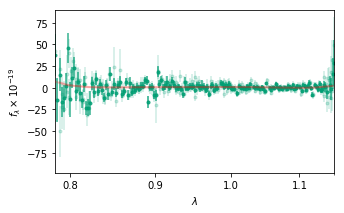

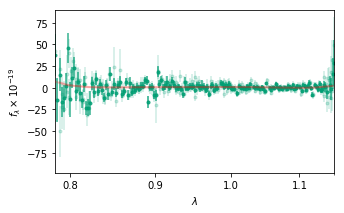

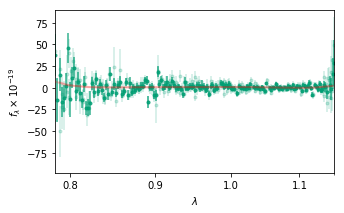

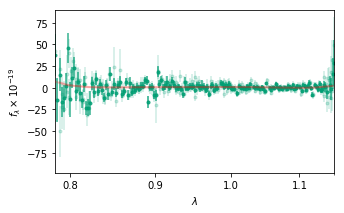

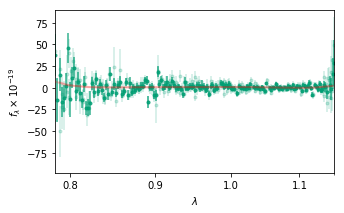

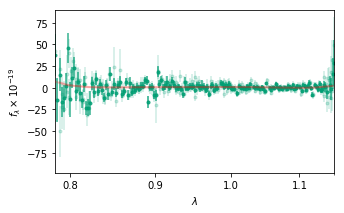

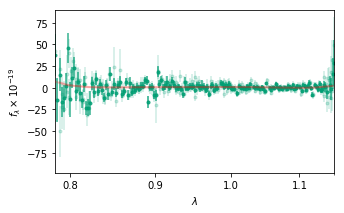

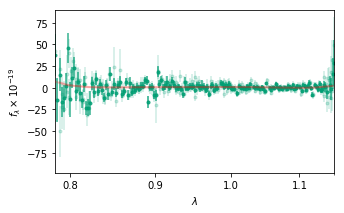

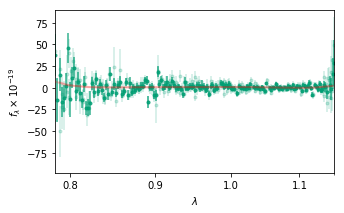

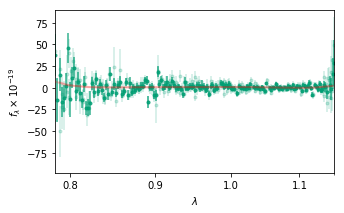

In [35]:
for id_i in source_ids:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

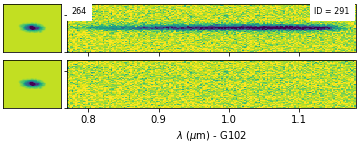

In [39]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

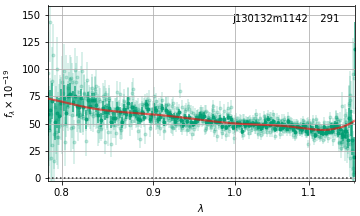

In [40]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run 291


(291, 1, 20.83938694000244)

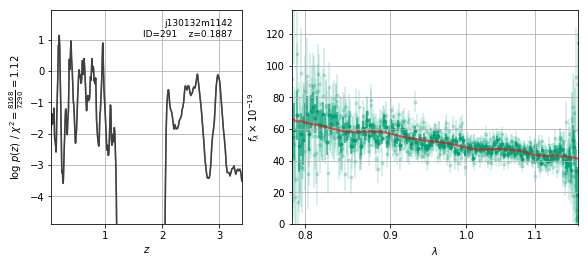

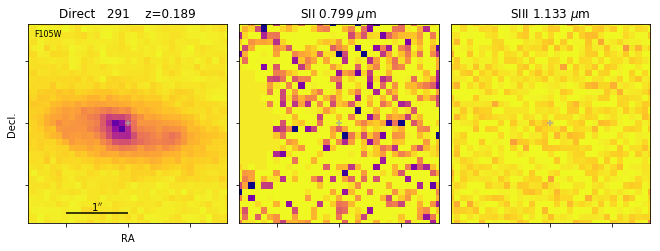

In [41]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
fitting.run_all_parallel(id)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [42]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j130132m1142_00291.1D.png
j130132m1142_00291.stack.fits
j130132m1142_00291.full.fits
j130132m1142_00291.beams.fits
j130132m1142_00291.line.png
j130132m1142_00291.stack.png
j130132m1142_00291.1D.fits
j130132m1142_00291.full.png
j130132m1142_00291.log_par


In [43]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j130132m1142_00291.stack.fits


Filename: j130132m1142_00291.stack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  SCI         G102,264.0 ImageHDU        54   (178, 64)   float32   
  2  WHT         G102,264.0 ImageHDU        22   (178, 64)   float32   
  3  CONTAM      G102,264.0 ImageHDU        22   (178, 64)   float32   
  4  MODEL       G102,264.0 ImageHDU        24   (178, 64)   float32   
  5  KERNEL      G102,264.0 ImageHDU        22   (64, 64)   float32   
  6  SCI         G102 ImageHDU        53   (178, 64)   float32   
  7  WHT         G102 ImageHDU        22   (178, 64)   float32   
  8  MODEL       G102 ImageHDU        24   (178, 64)   float32   
  9  KERNEL      G102 ImageHDU        22   (64, 64)   float32   


j130132m1142_00291.full.fits


Filename: j130132m1142_00291.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  Z

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [44]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 626 1
j130132m1142_00626.beams.fits


True

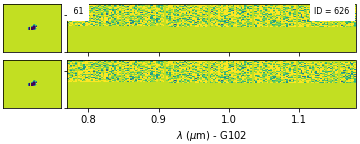

In [45]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

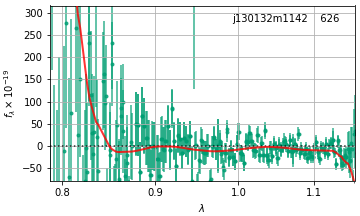

In [46]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 626


(626, 1, 4.607828378677368)

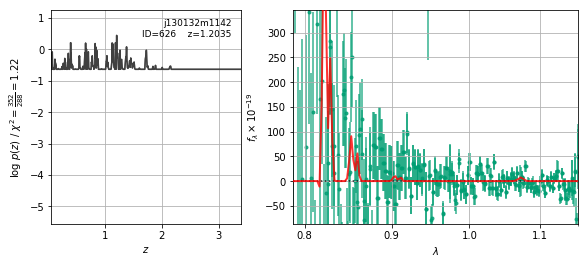

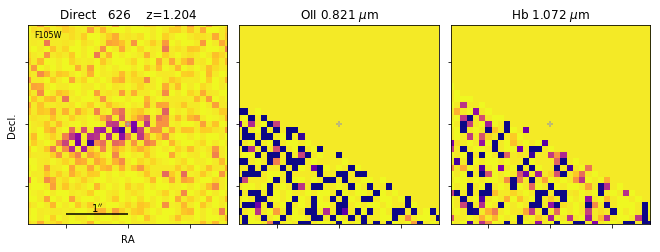

In [47]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).